In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')

import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "bs": 10,
    "lr": 1e-1,
    "var_lr": 1e-1,
    "trials": 10,
    "norm": False,
    "workers": 8,
    "steps": 5000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
    'out_dir': '/Users/patroklos/Regression',
    'eps': 1e-5,
    'var': 40,
    'step_lr': 100, 
    'step_lr_gamma': .9, 
    'tol': 1e-2, 
    'n': 100,
    'attempts': 3,
})

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.7792]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.1293]], requires_grad=True)
alpha:  tensor([0.5080])
gt ols coef:  [[0.8093197]]
gt ols intercept:  [-0.04690992]
trunc ols coef:  [[0.28515214]]
trunc ols intercept:  [2.5962896]


Text(0, 0.5, 'y')

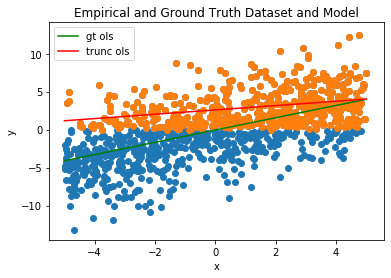

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([10.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [7]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9966)
beta:  tensor(4.9966)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([4.6769])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

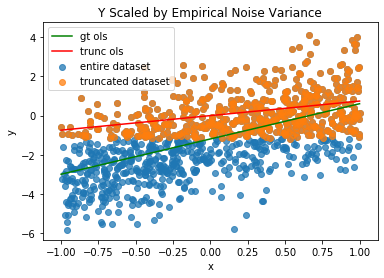

In [8]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.4677])
reg noise var:  tensor([0.9581])


Text(0, 0.5, 'y')

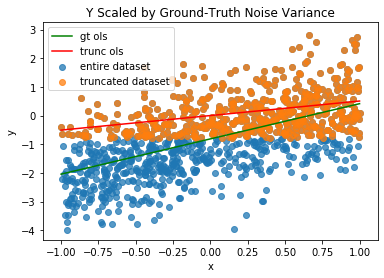

In [9]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [10]:
emp_scale_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(emp_noise_var))
known_emp_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=False, val=100, bs=10, n=100, tol=1e-2, steps=1500)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta
known_emp_bias_unnorm = known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.14233669638633728
Iteration: 1.0 | Score: 0.0290553979575634
Iteration: 2.0 | Score: 0.009654086083173752


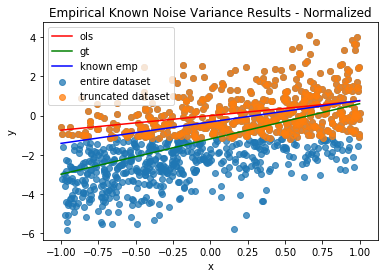

Text(0, 0.5, 'y')

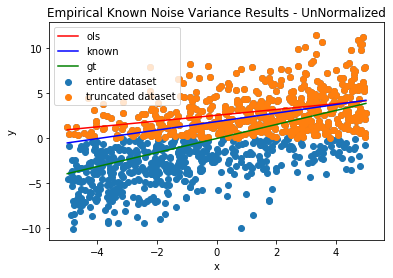

In [11]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')

plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [34]:
stand_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
known_trunc_reg = TruncatedRegression(phi=stand_phi, alpha=alpha, unknown=False, val=100, bs=10, n=100, tol=1e-3, steps=5000, step_lr_gamma=1.0)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.2594698667526245
Iteration: 1.0 | Score: 0.07019151002168655
Iteration: 2.0 | Score: 0.02566063404083252
Iteration: 3.0 | Score: 0.04387335479259491
Iteration: 4.0 | Score: 0.041270364075899124
Iteration: 5.0 | Score: 0.053241945803165436
Iteration: 6.0 | Score: 0.06270083039999008
Iteration: 7.0 | Score: 0.03098481521010399
Iteration: 8.0 | Score: 0.06425943225622177
Iteration: 9.0 | Score: 0.04839853197336197
Iteration: 10.0 | Score: 0.06273867189884186
Iteration: 11.0 | Score: 0.04147355258464813
Iteration: 12.0 | Score: 0.06240370124578476
Iteration: 13.0 | Score: 0.06343967467546463
Iteration: 14.0 | Score: 0.06254849582910538
Iteration: 15.0 | Score: 0.05319095030426979
Iteration: 16.0 | Score: 0.05108698084950447
Iteration: 17.0 | Score: 0.0507688969373703
Iteration: 18.0 | Score: 0.036647990345954895
Iteration: 19.0 | Score: 0.05222034081816673
Iteration: 20.0 | Score: 0.03877989575266838
Iteration: 21.0 | Score: 0.05836239457130432
Iteration: 22.0 | S

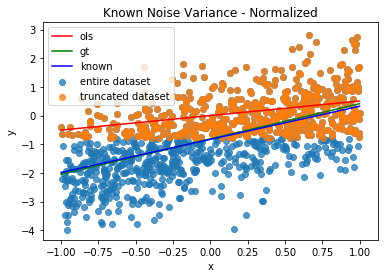

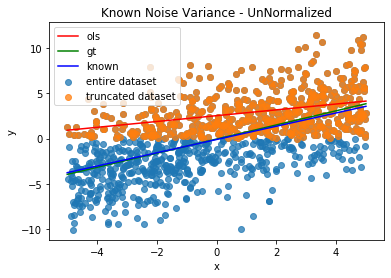

In [35]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [46]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=True, bs=10, n=100, tol=1e-2, val=100, steps=2000, step_lr_gamma=1.0)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

unknown_weight_unnorm = (unknown_trunc_reg.weight  * ch.sqrt(emp_noise_var)) / beta
unknown_bias_unnorm = unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.19935822486877441
Iteration: 1.0 | Score: 0.13923092186450958
Iteration: 2.0 | Score: 0.10559302568435669
Iteration: 3.0 | Score: 0.10563316941261292
Iteration: 4.0 | Score: 0.08363194018602371
Iteration: 5.0 | Score: 0.09220293164253235
Iteration: 6.0 | Score: 0.1387084722518921
Iteration: 7.0 | Score: 0.041503604501485825
Iteration: 8.0 | Score: 0.21274176239967346
Iteration: 9.0 | Score: 0.163943812251091
Iteration: 10.0 | Score: 0.1934526264667511
Iteration: 11.0 | Score: 0.22898326814174652
Iteration: 12.0 | Score: 0.2433662861585617
Iteration: 13.0 | Score: 0.20433394610881805
Iteration: 14.0 | Score: 0.11090316623449326
Iteration: 15.0 | Score: 0.09378673881292343
Iteration: 16.0 | Score: 0.09576207399368286
Iteration: 17.0 | Score: 0.08441003412008286
Iteration: 18.0 | Score: 0.14254021644592285
Iteration: 19.0 | Score: 0.14438937604427338
Iteration: 20.0 | Score: 0.07567647099494934


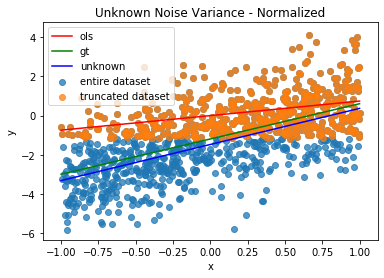

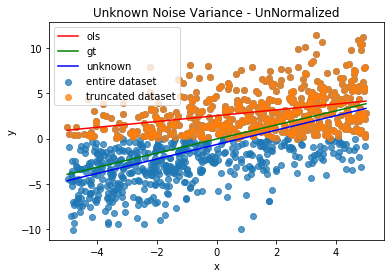

In [47]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [3]:
EXP = 'Experiment'

In [49]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [50]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left(0.0)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

# create base classifier
with ch.no_grad():
    # generate data
    X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
    y = gt(X)

In [6]:
for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir + '/' + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_emp_r2': float,
        'known_emp_param_mse': float,
        'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'trunc_reg_r2': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_mse': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
    rand_noise = ch.randn(X.size(0), 1)
        
    for noise_var in range(1, args.var + 1): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*rand_noise
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        # mean for dependent variable
        y_trunc_mu = y_trunc.mean(0)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        val = int(.15*x_trunc.size(0))
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
        emp_stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
        known_emp_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_emp_trunc_reg, total_time = run_trial(known_emp_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, known_emp_trunc_reg.intercept[..., None] * ch.sqrt(emp_noise_var) + y_trunc_mu
        known_emp_params = ch.cat([w, w0]).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'known_emp_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
            'known_emp_time': total_time, 
        })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(noise_var))
    
        # run procedure until get reasonable score
        known_kwargs = { 
            'phi': stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var) + y_trunc_mu
        known_params = ch.cat([w, w0]).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })

        
        # truncated regression with unknown variance
        # run procedure until get reasonable score
        unknown_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'var_lr': args.var_lr,
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        unknown_var = unknown_trunc_reg.variance * emp_noise_var
        w, w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w, w0]).flatten()
        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
            
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': ch.abs(trunc_res[-1].pow(2)[None,...] - noise_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /Users/patroklos/Regression/5TrialsVar40WithoutStep/b2bd6cf4-0a22-4d39-b5e0-238a9696a836
weight bounds:  Bounds(lower=tensor([-24.3252, -19.0106]), upper=tensor([25.0140, 30.3287]))
bias bounds:  Bounds(lower=-26.563941955566406, upper=22.775287628173828)
var bounds:  None
Iteration 1 | Score: 0.06397004425525665
Iteration 2 | Score: 0.027783289551734924
Iteration 3 | Score: 0.09358305484056473
Iteration 4 | Score: 0.15263794362545013
Iteration 5 | Score: 0.03286314755678177
Iteration 6 | Score: 0.0211652684956789
Iteration 7 | Score: 0.06570212543010712
Iteration 8 | Score: 0.15019379556179047
Iteration 9 | Score: 0.11252482980489731
Iteration 10 | Score: 0.0245843306183815
Final Score: 0.0024823108687996864
weight bounds:  Bounds(lower=tensor([-24.3469, -19.1618]), upper=tensor([24.9923, 30.1774]))
bias bounds:  Bounds(lower=-26.530710220336914, upper=22.80851936340332)
var bounds:  None
Iteration 1 | Score: 0.11490107327699661
Iteration 2 | Score: 0.07189616560935974
Ite

Iteration 44 | Score: 0.1741330474615097
Iteration 45 | Score: 0.2902141809463501
Iteration 46 | Score: 0.08787716180086136
Iteration 47 | Score: 0.014750609174370766
Iteration 48 | Score: 0.047664396464824677
Iteration 49 | Score: 0.16785436868667603
Iteration 50 | Score: 0.10807427763938904
weight bounds:  Bounds(lower=tensor([-34.2988, -29.0625]), upper=tensor([35.0405, 40.2767]))
bias bounds:  Bounds(lower=-36.55056381225586, upper=32.78866958618164)
var bounds:  Bounds(lower=0.5106496214866638, upper=3.6773228645324707)
Iteration 1 | Score: 0.012314620427787304
Iteration 2 | Score: 0.060157522559165955
Iteration 3 | Score: 0.10282984375953674
Iteration 4 | Score: 0.23805983364582062
Iteration 5 | Score: 0.12160231918096542
Iteration 6 | Score: 0.044310491532087326
Iteration 7 | Score: 0.17994481325149536
Iteration 8 | Score: 0.08838002383708954
Iteration 9 | Score: 0.15151487290859222
Iteration 10 | Score: 0.0680980458855629
Iteration 11 | Score: 0.04897023364901543
Iteration 12 |

Iteration 22 | Score: 0.07806163281202316
Iteration 23 | Score: 0.07134903222322464
Iteration 24 | Score: 0.06721366941928864
Iteration 25 | Score: 0.06530016660690308
Iteration 26 | Score: 0.08297114074230194
Iteration 27 | Score: 0.08357489109039307
Iteration 28 | Score: 0.0790991485118866
Iteration 29 | Score: 0.057432182133197784
Iteration 30 | Score: 0.08469119668006897
Iteration 31 | Score: 0.06925158202648163
Iteration 32 | Score: 0.07617297768592834
Iteration 33 | Score: 0.07784458249807358
Iteration 34 | Score: 0.06073500216007233
Iteration 35 | Score: 0.07342711091041565
Iteration 36 | Score: 0.059623271226882935
Iteration 37 | Score: 0.07947462797164917
Iteration 38 | Score: 0.08988848328590393
Iteration 39 | Score: 0.08030082285404205
Iteration 40 | Score: 0.08921897411346436
Iteration 41 | Score: 0.0777783989906311
Iteration 42 | Score: 0.07594317197799683
Iteration 43 | Score: 0.07654818892478943
Iteration 44 | Score: 0.06974227726459503
Iteration 45 | Score: 0.0808779746

Iteration 36 | Score: 0.26788201928138733
Iteration 37 | Score: 0.2386663407087326
Iteration 38 | Score: 0.36271369457244873
Iteration 39 | Score: 0.35337477922439575
Iteration 40 | Score: 0.3291653096675873
Iteration 41 | Score: 0.2239312082529068
Iteration 42 | Score: 0.22542276978492737
Iteration 43 | Score: 0.42227721214294434
Iteration 44 | Score: 0.3627464175224304
Iteration 45 | Score: 0.270262748003006
Iteration 46 | Score: 0.26544201374053955
Iteration 47 | Score: 0.3994498550891876
Iteration 48 | Score: 0.36658573150634766
Iteration 49 | Score: 0.3297826051712036
Iteration 50 | Score: 0.24504078924655914
weight bounds:  Bounds(lower=tensor([-34.3944, -31.0821]), upper=tensor([34.9448, 38.2571]))
bias bounds:  Bounds(lower=-35.847923278808594, upper=33.491310119628906)
var bounds:  Bounds(lower=0.5160812735557556, upper=3.716437816619873)
Iteration 1 | Score: 0.1457182615995407
Iteration 2 | Score: 0.23082847893238068
Iteration 3 | Score: 0.2363634556531906
Iteration 4 | Score

Iteration 2 | Score: 0.33993396162986755
Iteration 3 | Score: 0.3025634288787842
Iteration 4 | Score: 0.3143438398838043
Iteration 5 | Score: 0.2463044822216034
Iteration 6 | Score: 0.2914189398288727
Iteration 7 | Score: 0.2983821928501129
Iteration 8 | Score: 0.22203561663627625
Iteration 9 | Score: 0.2516721189022064
Iteration 10 | Score: 0.24816368520259857
Iteration 11 | Score: 0.28623685240745544
Iteration 12 | Score: 0.2820521891117096
Iteration 13 | Score: 0.27703621983528137
Iteration 14 | Score: 0.2580516040325165
Iteration 15 | Score: 0.2762887179851532
Iteration 16 | Score: 0.2751847207546234
Iteration 17 | Score: 0.254689484834671
Iteration 18 | Score: 0.2792576849460602
Iteration 19 | Score: 0.2444673329591751
Iteration 20 | Score: 0.28209084272384644
Iteration 21 | Score: 0.27759885787963867
Iteration 22 | Score: 0.26693660020828247
Iteration 23 | Score: 0.24450433254241943
Iteration 24 | Score: 0.2631865441799164
Iteration 25 | Score: 0.2552436888217926
Iteration 26 | S

Iteration 28 | Score: 0.084324911236763
Iteration 29 | Score: 0.09265043586492538
Iteration 30 | Score: 0.0593549907207489
Iteration 31 | Score: 0.05759356543421745
Iteration 32 | Score: 0.0686795637011528
Iteration 33 | Score: 0.09397688508033752
Iteration 34 | Score: 0.0409722663462162
Iteration 35 | Score: 0.076681949198246
Iteration 36 | Score: 0.06970681250095367
Iteration 37 | Score: 0.0723089799284935
Iteration 38 | Score: 0.07473550736904144
Iteration 39 | Score: 0.06469079852104187
Iteration 40 | Score: 0.0782470852136612
Iteration 41 | Score: 0.07825352251529694
Iteration 42 | Score: 0.08736831694841385
Iteration 43 | Score: 0.07827208191156387
Iteration 44 | Score: 0.06891599297523499
Iteration 45 | Score: 0.07653874158859253
Iteration 46 | Score: 0.09613829851150513
Iteration 47 | Score: 0.07164046168327332
Iteration 48 | Score: 0.06609717756509781
Iteration 49 | Score: 0.05550050362944603
Iteration 50 | Score: 0.04270750284194946
weight bounds:  Bounds(lower=tensor([-34.42

Iteration 2 | Score: 0.17581599950790405
Iteration 3 | Score: 0.08710074424743652
Iteration 4 | Score: 0.10956218838691711
Iteration 5 | Score: 0.1593218445777893
Iteration 6 | Score: 0.11349131166934967
Iteration 7 | Score: 0.09843997657299042
Iteration 8 | Score: 0.10263471305370331
Iteration 9 | Score: 0.1261214315891266
Iteration 10 | Score: 0.0843510851264
Iteration 11 | Score: 0.1151822879910469
Iteration 12 | Score: 0.11067692935466766
Iteration 13 | Score: 0.14492349326610565
Iteration 14 | Score: 0.09188124537467957
Iteration 15 | Score: 0.12241469323635101
Iteration 16 | Score: 0.13426372408866882
Iteration 17 | Score: 0.1437823325395584
Iteration 18 | Score: 0.10504364222288132
Iteration 19 | Score: 0.09716673940420151
Iteration 20 | Score: 0.10954883694648743
Iteration 21 | Score: 0.11293571442365646
Iteration 22 | Score: 0.1139419749379158
Iteration 23 | Score: 0.11996079981327057
Iteration 24 | Score: 0.11436769366264343
Iteration 25 | Score: 0.12356938421726227
Iteration

Iteration 17 | Score: 0.10054738819599152
Iteration 18 | Score: 0.09750555455684662
Iteration 19 | Score: 0.17883871495723724
Iteration 20 | Score: 0.12667618691921234
Iteration 21 | Score: 0.11527946591377258
Iteration 22 | Score: 0.07285613566637039
Iteration 23 | Score: 0.18955884873867035
Iteration 24 | Score: 0.19638372957706451
Iteration 25 | Score: 0.14907996356487274
Iteration 26 | Score: 0.11809080839157104
Iteration 27 | Score: 0.16654689610004425
Iteration 28 | Score: 0.1404196321964264
Iteration 29 | Score: 0.09974055737257004
Iteration 30 | Score: 0.125829815864563
Iteration 31 | Score: 0.13260819017887115
Iteration 32 | Score: 0.13304507732391357
Iteration 33 | Score: 0.10534016788005829
Iteration 34 | Score: 0.1480495184659958
Iteration 35 | Score: 0.13387028872966766
Iteration 36 | Score: 0.14233516156673431
Iteration 37 | Score: 0.13638438284397125
Iteration 38 | Score: 0.15438883006572723
Iteration 39 | Score: 0.16037648916244507
Iteration 40 | Score: 0.13309943675994

Iteration 50 | Score: 0.10030872374773026
weight bounds:  Bounds(lower=tensor([-24.5670, -22.9486]), upper=tensor([25.1718, 26.7902]))
bias bounds:  Bounds(lower=-25.412586212158203, upper=24.326282501220703)
var bounds:  None
Iteration 1 | Score: 0.05282657966017723
Iteration 2 | Score: 0.13726122677326202
Iteration 3 | Score: 0.12278523296117783
Iteration 4 | Score: 0.01851329393684864
Iteration 5 | Score: 0.05069689452648163
Iteration 6 | Score: 0.165191188454628
Iteration 7 | Score: 0.07179296016693115
Iteration 8 | Score: 0.03787131607532501
Iteration 9 | Score: 0.06971219927072525
Iteration 10 | Score: 0.11230073124170303
Iteration 11 | Score: 0.04606498032808304
Iteration 12 | Score: 0.046852290630340576
Iteration 13 | Score: 0.09832502156496048
Iteration 14 | Score: 0.07498399913311005
Iteration 15 | Score: 0.04490441083908081
Iteration 16 | Score: 0.026600459590554237
Iteration 17 | Score: 0.0760258212685585
Iteration 18 | Score: 0.07727309316396713
Iteration 19 | Score: 0.067

Iteration 23 | Score: 0.04398118332028389
Iteration 24 | Score: 0.060505710542201996
Iteration 25 | Score: 0.05059841275215149
Iteration 26 | Score: 0.04682958498597145
Iteration 27 | Score: 0.045828673988580704
Iteration 28 | Score: 0.05249326676130295
Iteration 29 | Score: 0.07487767189741135
Iteration 30 | Score: 0.053615763783454895
Iteration 31 | Score: 0.0377858467400074
Iteration 32 | Score: 0.06511736661195755
Iteration 33 | Score: 0.05114847421646118
Iteration 34 | Score: 0.0423886813223362
Iteration 35 | Score: 0.07560576498508453
Iteration 36 | Score: 0.06140948459506035
Iteration 37 | Score: 0.07167835533618927
Iteration 38 | Score: 0.029965637251734734
Iteration 39 | Score: 0.029376577585935593
Iteration 40 | Score: 0.033153071999549866
Iteration 41 | Score: 0.03511868417263031
Iteration 42 | Score: 0.07445061206817627
Iteration 43 | Score: 0.05395272374153137
Iteration 44 | Score: 0.0655665397644043
Iteration 45 | Score: 0.02812287211418152
Iteration 46 | Score: 0.0307896

Iteration 3 | Score: 0.02648741379380226
Iteration 4 | Score: 0.026814572513103485
Iteration 5 | Score: 0.019452519714832306
Iteration 6 | Score: 0.010484430938959122
Iteration 7 | Score: 0.011914804577827454
Final Score: 0.00468805618584156
weight bounds:  Bounds(lower=tensor([-34.7916, -33.2464]), upper=tensor([35.1667, 36.7119]))
bias bounds:  Bounds(lower=-35.43956756591797, upper=34.51869201660156)
var bounds:  Bounds(lower=0.5042992234230042, upper=3.9237589836120605)
Iteration 1 | Score: 0.09768415242433548
Iteration 2 | Score: 0.1582726091146469
Iteration 3 | Score: 0.1661267876625061
Iteration 4 | Score: 0.13867227733135223
Iteration 5 | Score: 0.12332730740308762
Iteration 6 | Score: 0.10827375203371048
Iteration 7 | Score: 0.1490231603384018
Iteration 8 | Score: 0.14474384486675262
Iteration 9 | Score: 0.1316058486700058
Iteration 10 | Score: 0.12254878878593445
Iteration 11 | Score: 0.16831561923027039
Iteration 12 | Score: 0.11664849519729614
Iteration 13 | Score: 0.138087

Iteration 6 | Score: 0.12632089853286743
Iteration 7 | Score: 0.17109860479831696
Iteration 8 | Score: 0.13498762249946594
Iteration 9 | Score: 0.20762357115745544
Iteration 10 | Score: 0.1879013627767563
Iteration 11 | Score: 0.1618299037218094
Iteration 12 | Score: 0.17213162779808044
Iteration 13 | Score: 0.1853768676519394
Iteration 14 | Score: 0.17266540229320526
Iteration 15 | Score: 0.17156758904457092
Iteration 16 | Score: 0.16099314391613007
Iteration 17 | Score: 0.16180306673049927
Iteration 18 | Score: 0.16824086010456085
Iteration 19 | Score: 0.15114952623844147
Iteration 20 | Score: 0.16920888423919678
Iteration 21 | Score: 0.17665840685367584
Iteration 22 | Score: 0.14679741859436035
Iteration 23 | Score: 0.16118638217449188
Iteration 24 | Score: 0.16874931752681732
Iteration 25 | Score: 0.17441023886203766
Iteration 26 | Score: 0.19226057827472687
Iteration 27 | Score: 0.15089592337608337
Iteration 28 | Score: 0.15752094984054565
Iteration 29 | Score: 0.157268688082695
I

Iteration 43 | Score: 0.12899325788021088
Iteration 44 | Score: 0.1450149118900299
Iteration 45 | Score: 0.1450342833995819
Iteration 46 | Score: 0.14386019110679626
Iteration 47 | Score: 0.1334463655948639
Iteration 48 | Score: 0.1618461012840271
Iteration 49 | Score: 0.14326521754264832
Iteration 50 | Score: 0.15385814011096954
weight bounds:  Bounds(lower=tensor([-24.8559, -23.6840]), upper=tensor([25.0708, 26.2428]))
bias bounds:  Bounds(lower=-25.317949295043945, upper=24.60878562927246)
var bounds:  None
Final Score: 0.006724376231431961
weight bounds:  Bounds(lower=tensor([-34.8002, -33.3120]), upper=tensor([35.1265, 36.6148]))
bias bounds:  Bounds(lower=-35.37147521972656, upper=34.555259704589844)
var bounds:  Bounds(lower=0.512371301651001, upper=3.9708855152130127)
Iteration 1 | Score: 0.25716152787208557
Iteration 2 | Score: 0.3217851519584656
Iteration 3 | Score: 0.43139058351516724
Iteration 4 | Score: 0.16124185919761658
Iteration 5 | Score: 0.21691487729549408
Iteration

Iteration 16 | Score: 0.13119709491729736
Iteration 17 | Score: 0.1352250576019287
Iteration 18 | Score: 0.17764079570770264
Iteration 19 | Score: 0.09103548526763916
Iteration 20 | Score: 0.11181102693080902
Iteration 21 | Score: 0.16726413369178772
Iteration 22 | Score: 0.09992776811122894
Iteration 23 | Score: 0.07287755608558655
Iteration 24 | Score: 0.15240806341171265
Iteration 25 | Score: 0.178788959980011
Iteration 26 | Score: 0.07712365686893463
Iteration 27 | Score: 0.12328135222196579
Iteration 28 | Score: 0.13325752317905426
Iteration 29 | Score: 0.17662590742111206
Iteration 30 | Score: 0.10444560647010803
Iteration 31 | Score: 0.13035668432712555
Iteration 32 | Score: 0.1665177345275879
Iteration 33 | Score: 0.08501088619232178
Iteration 34 | Score: 0.0495225265622139
Iteration 35 | Score: 0.17602874338626862
Iteration 36 | Score: 0.1984752118587494
Iteration 37 | Score: 0.08754050731658936
Iteration 38 | Score: 0.11538568139076233
Iteration 39 | Score: 0.1373399794101715

Iteration 50 | Score: 0.1275065839290619
weight bounds:  Bounds(lower=tensor([-24.8523, -23.8195]), upper=tensor([25.1376, 26.1703]))
bias bounds:  Bounds(lower=-25.297405242919922, upper=24.692447662353516)
var bounds:  None
Iteration 1 | Score: 0.013307172805070877
Iteration 2 | Score: 0.01250940840691328
Iteration 3 | Score: 0.055739354342222214
Iteration 4 | Score: 0.07065810263156891
Final Score: 9.318254888057709e-05
weight bounds:  Bounds(lower=tensor([-34.8525, -33.5868]), upper=tensor([35.1374, 36.4030]))
bias bounds:  Bounds(lower=-35.37013626098633, upper=34.61971664428711)
var bounds:  Bounds(lower=0.48441392183303833, upper=3.783951997756958)
Iteration 1 | Score: 0.23503798246383667
Iteration 2 | Score: 0.16770167648792267
Iteration 3 | Score: 0.1442514806985855
Iteration 4 | Score: 0.24790780246257782
Iteration 5 | Score: 0.27594229578971863
Iteration 6 | Score: 0.21341857314109802
Iteration 7 | Score: 0.12062717229127884
Iteration 8 | Score: 0.27581512928009033
Iteration

Iteration 20 | Score: 0.16975454986095428
Iteration 21 | Score: 0.18159101903438568
Iteration 22 | Score: 0.16296789050102234
Iteration 23 | Score: 0.18735362589359283
Iteration 24 | Score: 0.17137837409973145
Iteration 25 | Score: 0.1692405641078949
Iteration 26 | Score: 0.176194965839386
Iteration 27 | Score: 0.17295828461647034
Iteration 28 | Score: 0.1685868352651596
Iteration 29 | Score: 0.20191653072834015
Iteration 30 | Score: 0.1715770810842514
Iteration 31 | Score: 0.15912503004074097
Iteration 32 | Score: 0.16543307900428772
Iteration 33 | Score: 0.16783401370048523
Iteration 34 | Score: 0.1689513623714447
Iteration 35 | Score: 0.1547018587589264
Iteration 36 | Score: 0.16018502414226532
Iteration 37 | Score: 0.16578105092048645
Iteration 38 | Score: 0.16949929296970367
Iteration 39 | Score: 0.17407439649105072
Iteration 40 | Score: 0.1656983345746994
Iteration 41 | Score: 0.17464712262153625
Iteration 42 | Score: 0.1591491997241974
Iteration 43 | Score: 0.17099425196647644
I

Iteration 48 | Score: 0.07828111946582794
Iteration 49 | Score: 0.09118620306253433
Iteration 50 | Score: 0.0868762880563736
weight bounds:  Bounds(lower=tensor([-24.8544, -23.9161]), upper=tensor([25.1039, 26.0422]))
bias bounds:  Bounds(lower=-25.213369369506836, upper=24.744890213012695)
var bounds:  None
Iteration 1 | Score: 0.24931615591049194
Iteration 2 | Score: 0.21765807271003723
Iteration 3 | Score: 0.19457346200942993
Iteration 4 | Score: 0.22205133736133575
Iteration 5 | Score: 0.22594013810157776
Iteration 6 | Score: 0.21974627673625946
Iteration 7 | Score: 0.21792033314704895
Iteration 8 | Score: 0.22355929017066956
Iteration 9 | Score: 0.21104878187179565
Iteration 10 | Score: 0.18853843212127686
Iteration 11 | Score: 0.18668635189533234
Iteration 12 | Score: 0.21432840824127197
Iteration 13 | Score: 0.19771085679531097
Iteration 14 | Score: 0.18693523108959198
Iteration 15 | Score: 0.1949280947446823
Iteration 16 | Score: 0.19779101014137268
Iteration 17 | Score: 0.2348

Iteration 23 | Score: 0.2081960141658783
Iteration 24 | Score: 0.07378046214580536
Iteration 25 | Score: 0.024395322427153587
Iteration 26 | Score: 0.12316244840621948
Iteration 27 | Score: 0.1274716705083847
Iteration 28 | Score: 0.0914684534072876
Iteration 29 | Score: 0.1681056171655655
Iteration 30 | Score: 0.29294073581695557
Iteration 31 | Score: 0.09874530881643295
Iteration 32 | Score: 0.10255852341651917
Iteration 33 | Score: 0.10377015918493271
Iteration 34 | Score: 0.19839061796665192
Iteration 35 | Score: 0.08105809986591339
Iteration 36 | Score: 0.07347221672534943
Iteration 37 | Score: 0.12094148248434067
Iteration 38 | Score: 0.11089041084051132
Iteration 39 | Score: 0.10483724623918533
Iteration 40 | Score: 0.15283508598804474
Iteration 41 | Score: 0.26612919569015503
Iteration 42 | Score: 0.10848196595907211
Iteration 43 | Score: 0.10605243593454361
Iteration 44 | Score: 0.0908152386546135
Iteration 45 | Score: 0.19248902797698975
Iteration 46 | Score: 0.07758804410696

Iteration 38 | Score: 0.12502864003181458
Iteration 39 | Score: 0.10307945311069489
Iteration 40 | Score: 0.15100906789302826
Iteration 41 | Score: 0.13239212334156036
Iteration 42 | Score: 0.02826002426445484
Iteration 43 | Score: 0.14281292259693146
Iteration 44 | Score: 0.15032291412353516
Iteration 45 | Score: 0.03772937133908272
Iteration 46 | Score: 0.04065767303109169
Iteration 47 | Score: 0.05383353680372238
Iteration 48 | Score: 0.17632780969142914
Iteration 49 | Score: 0.08823216706514359
Iteration 50 | Score: 0.1261172592639923
weight bounds:  Bounds(lower=tensor([-34.7367, -33.6462]), upper=tensor([35.1272, 36.2176]))
bias bounds:  Bounds(lower=-35.24763870239258, upper=34.61623001098633)
var bounds:  Bounds(lower=0.49423664808273315, upper=3.800359010696411)
Iteration 1 | Score: 0.02018708549439907
Iteration 2 | Score: 0.14700651168823242
Iteration 3 | Score: 0.08431890606880188
Iteration 4 | Score: 0.11752050369977951
Iteration 5 | Score: 0.04213396832346916
Iteration 6 |

Iteration 11 | Score: 0.04766824096441269
Iteration 12 | Score: 0.08761889487504959
Iteration 13 | Score: 0.0805874839425087
Iteration 14 | Score: 0.0665893405675888
Iteration 15 | Score: 0.07660476863384247
Iteration 16 | Score: 0.07214765250682831
Iteration 17 | Score: 0.05012683570384979
Iteration 18 | Score: 0.0675659328699112
Iteration 19 | Score: 0.05661925673484802
Iteration 20 | Score: 0.06898461282253265
Iteration 21 | Score: 0.07012858986854553
Iteration 22 | Score: 0.0659274160861969
Iteration 23 | Score: 0.06333816796541214
Iteration 24 | Score: 0.07235977053642273
Iteration 25 | Score: 0.0669541209936142
Iteration 26 | Score: 0.06924258917570114
Iteration 27 | Score: 0.0651453286409378
Iteration 28 | Score: 0.052110347896814346
Iteration 29 | Score: 0.07096059620380402
Iteration 30 | Score: 0.06276177614927292
Iteration 31 | Score: 0.061455368995666504
Iteration 32 | Score: 0.07019811123609543
Iteration 33 | Score: 0.061151280999183655
Iteration 34 | Score: 0.0681204944849

Iteration 39 | Score: 0.17304809391498566
Iteration 40 | Score: 0.21496444940567017
Iteration 41 | Score: 0.22291474044322968
Iteration 42 | Score: 0.2700986862182617
Iteration 43 | Score: 0.21728847920894623
Iteration 44 | Score: 0.2770114243030548
Iteration 45 | Score: 0.247566819190979
Iteration 46 | Score: 0.22813937067985535
Iteration 47 | Score: 0.16744554042816162
Iteration 48 | Score: 0.22265443205833435
Iteration 49 | Score: 0.2811129689216614
Iteration 50 | Score: 0.1883215606212616
weight bounds:  Bounds(lower=tensor([-34.6834, -33.7313]), upper=tensor([35.0866, 36.0387]))
bias bounds:  Bounds(lower=-35.15000534057617, upper=34.62002182006836)
var bounds:  Bounds(lower=0.5073084831237793, upper=3.855381488800049)
Iteration 1 | Score: 0.06806667149066925
Iteration 2 | Score: 0.03676840290427208
Iteration 3 | Score: 0.03336086869239807
Iteration 4 | Score: 0.049482252448797226
Iteration 5 | Score: 0.05776197463274002
Iteration 6 | Score: 0.04325365647673607
Iteration 7 | Score

Iteration 3 | Score: 0.2128218412399292
Iteration 4 | Score: 0.1787131279706955
Iteration 5 | Score: 0.18598248064517975
Iteration 6 | Score: 0.19962958991527557
Iteration 7 | Score: 0.179830402135849
Iteration 8 | Score: 0.2102653831243515
Iteration 9 | Score: 0.17754815518856049
Iteration 10 | Score: 0.204510897397995
Iteration 11 | Score: 0.18121372163295746
Iteration 12 | Score: 0.17106914520263672
Iteration 13 | Score: 0.17328818142414093
Iteration 14 | Score: 0.20173756778240204
Iteration 15 | Score: 0.18658806383609772
Iteration 16 | Score: 0.17190299928188324
Iteration 17 | Score: 0.18231303989887238
Iteration 18 | Score: 0.17067889869213104
Iteration 19 | Score: 0.17617197334766388
Iteration 20 | Score: 0.1665603220462799
Iteration 21 | Score: 0.1826227605342865
Iteration 22 | Score: 0.18879446387290955
Iteration 23 | Score: 0.16965898871421814
Iteration 24 | Score: 0.18843302130699158
Iteration 25 | Score: 0.1808338612318039
Iteration 26 | Score: 0.18982520699501038
Iteration

Iteration 33 | Score: 0.2327120304107666
Iteration 34 | Score: 0.2499520480632782
Iteration 35 | Score: 0.2659723162651062
Iteration 36 | Score: 0.26098015904426575
Iteration 37 | Score: 0.2280835062265396
Iteration 38 | Score: 0.2397729754447937
Iteration 39 | Score: 0.2547408640384674
Iteration 40 | Score: 0.23531241714954376
Iteration 41 | Score: 0.2559099793434143
Iteration 42 | Score: 0.25597456097602844
Iteration 43 | Score: 0.24609552323818207
Iteration 44 | Score: 0.2508944869041443
Iteration 45 | Score: 0.2469681203365326
Iteration 46 | Score: 0.2554309070110321
Iteration 47 | Score: 0.251769095659256
Iteration 48 | Score: 0.24957247078418732
Iteration 49 | Score: 0.2358337640762329
Iteration 50 | Score: 0.2566491663455963
weight bounds:  Bounds(lower=tensor([-24.9004, -24.2408]), upper=tensor([25.1846, 25.8442]))
bias bounds:  Bounds(lower=-25.22740936279297, upper=24.857585906982422)
var bounds:  None
Iteration 1 | Score: 0.012573093175888062
Iteration 2 | Score: 0.032346397

Iteration 50 | Score: 0.11052486300468445
weight bounds:  Bounds(lower=tensor([-34.8452, -33.9655]), upper=tensor([35.2398, 36.1195]))
bias bounds:  Bounds(lower=-35.26267623901367, upper=34.82231521606445)
var bounds:  Bounds(lower=0.5096381902694702, upper=4.028616905212402)
Iteration 1 | Score: 0.2243485450744629
Iteration 2 | Score: 0.15114830434322357
Iteration 3 | Score: 0.11879979819059372
Iteration 4 | Score: 0.26220235228538513
Iteration 5 | Score: 0.2063496708869934
Iteration 6 | Score: 0.13672606647014618
Iteration 7 | Score: 0.2633982300758362
Iteration 8 | Score: 0.1700943261384964
Iteration 9 | Score: 0.12623196840286255
Iteration 10 | Score: 0.2101854383945465
Iteration 11 | Score: 0.20611919462680817
Iteration 12 | Score: 0.11994142085313797
Iteration 13 | Score: 0.23645992577075958
Iteration 14 | Score: 0.19143223762512207
Iteration 15 | Score: 0.11691775918006897
Iteration 16 | Score: 0.24095453321933746
Iteration 17 | Score: 0.20133066177368164
Iteration 18 | Score: 

Iteration 18 | Score: 0.11109034717082977
Iteration 19 | Score: 0.11176344752311707
Iteration 20 | Score: 0.13582095503807068
Iteration 21 | Score: 0.12059053778648376
Iteration 22 | Score: 0.11765541136264801
Iteration 23 | Score: 0.12789370119571686
Iteration 24 | Score: 0.1290377974510193
Iteration 25 | Score: 0.10522610694169998
Iteration 26 | Score: 0.11100569367408752
Iteration 27 | Score: 0.13226418197155
Iteration 28 | Score: 0.11744952201843262
Iteration 29 | Score: 0.10955837368965149
Iteration 30 | Score: 0.1269012689590454
Iteration 31 | Score: 0.1390572190284729
Iteration 32 | Score: 0.12691009044647217
Iteration 33 | Score: 0.10656983405351639
Iteration 34 | Score: 0.13399331271648407
Iteration 35 | Score: 0.10990940034389496
Iteration 36 | Score: 0.11253602802753448
Iteration 37 | Score: 0.10262146592140198
Iteration 38 | Score: 0.102956123650074
Iteration 39 | Score: 0.10379756987094879
Iteration 40 | Score: 0.13001710176467896
Iteration 41 | Score: 0.10933031141757965


Iteration 50 | Score: 0.11388903111219406
weight bounds:  Bounds(lower=tensor([-34.8692, -33.8444]), upper=tensor([35.1523, 36.1771]))
bias bounds:  Bounds(lower=-35.2285270690918, upper=34.7929801940918)
var bounds:  Bounds(lower=0.4947790801525116, upper=3.880239725112915)
Iteration 1 | Score: 0.2716171145439148
Iteration 2 | Score: 0.3337589204311371
Iteration 3 | Score: 0.17986942827701569
Iteration 4 | Score: 0.2424413561820984
Iteration 5 | Score: 0.29789024591445923
Iteration 6 | Score: 0.2545194625854492
Iteration 7 | Score: 0.2519380450248718
Iteration 8 | Score: 0.2773591876029968
Iteration 9 | Score: 0.23286589980125427
Iteration 10 | Score: 0.2592776417732239
Iteration 11 | Score: 0.27937477827072144
Iteration 12 | Score: 0.17378735542297363
Iteration 13 | Score: 0.2989049255847931
Iteration 14 | Score: 0.2568601369857788
Iteration 15 | Score: 0.21680693328380585
Iteration 16 | Score: 0.2554880976676941
Iteration 17 | Score: 0.257146418094635
Iteration 18 | Score: 0.2186518

Iteration 25 | Score: 0.0797119140625
Iteration 26 | Score: 0.08304692059755325
Iteration 27 | Score: 0.07918813079595566
Iteration 28 | Score: 0.08811924606561661
Iteration 29 | Score: 0.06801677495241165
Iteration 30 | Score: 0.081879161298275
Iteration 31 | Score: 0.06669622659683228
Iteration 32 | Score: 0.08033031225204468
Iteration 33 | Score: 0.06901483237743378
Iteration 34 | Score: 0.054084088653326035
Iteration 35 | Score: 0.08562122285366058
Iteration 36 | Score: 0.07256808876991272
Iteration 37 | Score: 0.06330950558185577
Iteration 38 | Score: 0.07454777508974075
Iteration 39 | Score: 0.05378938466310501
Iteration 40 | Score: 0.07089632004499435
Iteration 41 | Score: 0.09565456211566925
Iteration 42 | Score: 0.06980851292610168
Iteration 43 | Score: 0.06930575519800186
Iteration 44 | Score: 0.07063553482294083
Iteration 45 | Score: 0.08238907158374786
Iteration 46 | Score: 0.06879101693630219
Iteration 47 | Score: 0.09745348989963531
Iteration 48 | Score: 0.062452927231788

Iteration 3 | Score: 0.06649095565080643
Iteration 4 | Score: 0.2121530920267105
Iteration 5 | Score: 0.11703193187713623
Iteration 6 | Score: 0.11560315638780594
Iteration 7 | Score: 0.19482430815696716
Iteration 8 | Score: 0.16820141673088074
Iteration 9 | Score: 0.23164884746074677
Iteration 10 | Score: 0.08197988569736481
Iteration 11 | Score: 0.35378140211105347
Iteration 12 | Score: 0.0759950503706932
Iteration 13 | Score: 0.07094765454530716
Iteration 14 | Score: 0.08069565147161484
Iteration 15 | Score: 0.24403855204582214
Iteration 16 | Score: 0.15191757678985596
Iteration 17 | Score: 0.10289402306079865
Iteration 18 | Score: 0.1673518270254135
Iteration 19 | Score: 0.15238472819328308
Iteration 20 | Score: 0.2042422592639923
Iteration 21 | Score: 0.1097368523478508
Iteration 22 | Score: 0.2864166796207428
Iteration 23 | Score: 0.1030057892203331
Iteration 24 | Score: 0.05600305274128914
Iteration 25 | Score: 0.06434865295886993
Iteration 26 | Score: 0.23794133961200714
Iterat

Iteration 38 | Score: 0.1305352747440338
Iteration 39 | Score: 0.12402418255805969
Iteration 40 | Score: 0.144882932305336
Iteration 41 | Score: 0.12712256610393524
Iteration 42 | Score: 0.1276320070028305
Iteration 43 | Score: 0.14350326359272003
Iteration 44 | Score: 0.13885612785816193
Iteration 45 | Score: 0.1254703402519226
Iteration 46 | Score: 0.12355051934719086
Iteration 47 | Score: 0.1477057784795761
Iteration 48 | Score: 0.14052775502204895
Iteration 49 | Score: 0.13954076170921326
Iteration 50 | Score: 0.134084552526474
weight bounds:  Bounds(lower=tensor([-24.8487, -23.9263]), upper=tensor([25.1728, 26.0953]))
bias bounds:  Bounds(lower=-25.25156593322754, upper=24.769941329956055)
var bounds:  None
Iteration 1 | Score: 0.048355892300605774
Iteration 2 | Score: 0.07161394506692886
Iteration 3 | Score: 0.09345173090696335
Iteration 4 | Score: 0.05282754823565483
Iteration 5 | Score: 0.09042823314666748
Iteration 6 | Score: 0.08141984045505524
Iteration 7 | Score: 0.07795088

Iteration 18 | Score: 0.10676014423370361
Iteration 19 | Score: 0.11527359485626221
Iteration 20 | Score: 0.10223591327667236
Iteration 21 | Score: 0.09641875326633453
Iteration 22 | Score: 0.11618246138095856
Iteration 23 | Score: 0.09755488485097885
Iteration 24 | Score: 0.10154110938310623
Iteration 25 | Score: 0.12213213741779327
Iteration 26 | Score: 0.09791165590286255
Iteration 27 | Score: 0.12145859748125076
Iteration 28 | Score: 0.10358384251594543
Iteration 29 | Score: 0.10738788545131683
Iteration 30 | Score: 0.11346198618412018
Iteration 31 | Score: 0.09417310357093811
Iteration 32 | Score: 0.10566867142915726
Iteration 33 | Score: 0.11692263185977936
Iteration 34 | Score: 0.1162317767739296
Iteration 35 | Score: 0.13279683887958527
Iteration 36 | Score: 0.10356847941875458
Iteration 37 | Score: 0.11715887486934662
Iteration 38 | Score: 0.12135881185531616
Iteration 39 | Score: 0.11329244077205658
Iteration 40 | Score: 0.10985319316387177
Iteration 41 | Score: 0.12390152364

Iteration 50 | Score: 0.27584269642829895
weight bounds:  Bounds(lower=tensor([-24.8587, -23.8850]), upper=tensor([25.2263, 26.2000]))
bias bounds:  Bounds(lower=-25.265872955322266, upper=24.819122314453125)
var bounds:  None
Iteration 1 | Score: 0.1540660709142685
Iteration 2 | Score: 0.04262644425034523
Iteration 3 | Score: 0.06991202384233475
Iteration 4 | Score: 0.17012441158294678
Iteration 5 | Score: 0.07553902268409729
Iteration 6 | Score: 0.10688148438930511
Iteration 7 | Score: 0.10680067539215088
Iteration 8 | Score: 0.1137114018201828
Iteration 9 | Score: 0.11072727292776108
Iteration 10 | Score: 0.09180796891450882
Iteration 11 | Score: 0.12129822373390198
Iteration 12 | Score: 0.10127665102481842
Iteration 13 | Score: 0.12558133900165558
Iteration 14 | Score: 0.14109937846660614
Iteration 15 | Score: 0.1318129599094391
Iteration 16 | Score: 0.12507306039333344
Iteration 17 | Score: 0.13798211514949799
Iteration 18 | Score: 0.11991715431213379
Iteration 19 | Score: 0.12040

Iteration 30 | Score: 0.05062161386013031
Iteration 31 | Score: 0.049067433923482895
Iteration 32 | Score: 0.0656697005033493
Iteration 33 | Score: 0.06912966072559357
Iteration 34 | Score: 0.058959320187568665
Iteration 35 | Score: 0.0499209463596344
Iteration 36 | Score: 0.055561281740665436
Iteration 37 | Score: 0.07069703936576843
Iteration 38 | Score: 0.06631013005971909
Iteration 39 | Score: 0.045946720987558365
Iteration 40 | Score: 0.06360011547803879
Iteration 41 | Score: 0.051576897501945496
Iteration 42 | Score: 0.0669989138841629
Iteration 43 | Score: 0.07878907769918442
Iteration 44 | Score: 0.07625607401132584
Iteration 45 | Score: 0.04346708580851555
Iteration 46 | Score: 0.07351891696453094
Iteration 47 | Score: 0.06767331063747406
Iteration 48 | Score: 0.04891765117645264
Iteration 49 | Score: 0.07863175123929977
Iteration 50 | Score: 0.06591382622718811
weight bounds:  Bounds(lower=tensor([-24.9372, -24.3885]), upper=tensor([25.1478, 25.6965]))
bias bounds:  Bounds(lo

Iteration 7 | Score: 0.10742761939764023
Iteration 8 | Score: 0.09362590312957764
Iteration 9 | Score: 0.09764555096626282
Iteration 10 | Score: 0.09521245211362839
Iteration 11 | Score: 0.09522280842065811
Iteration 12 | Score: 0.09256034344434738
Iteration 13 | Score: 0.09656456857919693
Iteration 14 | Score: 0.10696133226156235
Iteration 15 | Score: 0.09525012969970703
Iteration 16 | Score: 0.10076896101236343
Iteration 17 | Score: 0.0839817076921463
Iteration 18 | Score: 0.09254325181245804
Iteration 19 | Score: 0.10072754323482513
Iteration 20 | Score: 0.08195213228464127
Iteration 21 | Score: 0.08171168714761734
Iteration 22 | Score: 0.09053890407085419
Iteration 23 | Score: 0.07839328795671463
Iteration 24 | Score: 0.09596255421638489
Iteration 25 | Score: 0.10646326094865799
Iteration 26 | Score: 0.08923830091953278
Iteration 27 | Score: 0.08981198072433472
Iteration 28 | Score: 0.0861460417509079
Iteration 29 | Score: 0.10182034969329834
Iteration 30 | Score: 0.093776136636734

Iteration 26 | Score: 0.09991326928138733
Iteration 27 | Score: 0.10986734926700592
Iteration 28 | Score: 0.12466015666723251
Iteration 29 | Score: 0.12551765143871307
Iteration 30 | Score: 0.11380159854888916
Iteration 31 | Score: 0.1092149093747139
Iteration 32 | Score: 0.11505676805973053
Iteration 33 | Score: 0.11420267820358276
Iteration 34 | Score: 0.14022313058376312
Iteration 35 | Score: 0.12645187973976135
Iteration 36 | Score: 0.09562233835458755
Iteration 37 | Score: 0.11514133960008621
Iteration 38 | Score: 0.10269170254468918
Iteration 39 | Score: 0.10891716182231903
Iteration 40 | Score: 0.10299676656723022
Iteration 41 | Score: 0.11003427952528
Iteration 42 | Score: 0.1217833161354065
Iteration 43 | Score: 0.11770275235176086
Iteration 44 | Score: 0.11941242218017578
Iteration 45 | Score: 0.12143132835626602
Iteration 46 | Score: 0.12303797900676727
Iteration 47 | Score: 0.1286831498146057
Iteration 48 | Score: 0.12199543416500092
Iteration 49 | Score: 0.128034308552742


Iteration 2 | Score: 0.12708120048046112
Iteration 3 | Score: 0.17612868547439575
Iteration 4 | Score: 0.44526639580726624
Iteration 5 | Score: 0.1398710310459137
Iteration 6 | Score: 0.12085454165935516
Iteration 7 | Score: 0.18843331933021545
Iteration 8 | Score: 0.2780722975730896
Iteration 9 | Score: 0.11796621233224869
Iteration 10 | Score: 0.24841146171092987
Iteration 11 | Score: 0.9178842902183533
Iteration 12 | Score: 0.12810418009757996
Iteration 13 | Score: 0.13055579364299774
Iteration 14 | Score: 0.15792565047740936
Iteration 15 | Score: 0.3977910280227661
Iteration 16 | Score: 0.15340381860733032
Iteration 17 | Score: 0.10096336156129837
Iteration 18 | Score: 0.1583239883184433
Iteration 19 | Score: 0.25579601526260376
Iteration 20 | Score: 0.11811331659555435
Iteration 21 | Score: 0.2248760610818863
Iteration 22 | Score: 0.7328070402145386
Iteration 23 | Score: 0.16047783195972443
Iteration 24 | Score: 0.11881609261035919
Iteration 25 | Score: 0.18528378009796143
Iterati

Iteration 7 | Score: 0.16477593779563904
Iteration 8 | Score: 0.08064109086990356
Iteration 9 | Score: 0.062124501913785934
Iteration 10 | Score: 0.1600668728351593
Iteration 11 | Score: 0.11458723247051239
Iteration 12 | Score: 0.0420144721865654
Iteration 13 | Score: 0.15500175952911377
Iteration 14 | Score: 0.16482755541801453
Iteration 15 | Score: 0.09959862381219864
Iteration 16 | Score: 0.08283430337905884
Iteration 17 | Score: 0.169590026140213
Iteration 18 | Score: 0.19458186626434326
Iteration 19 | Score: 0.07716062664985657
Iteration 20 | Score: 0.0706404373049736
Iteration 21 | Score: 0.1341409534215927
Iteration 22 | Score: 0.11621207743883133
Iteration 23 | Score: 0.04462826997041702
Iteration 24 | Score: 0.1550820767879486
Iteration 25 | Score: 0.160551518201828
Iteration 26 | Score: 0.07606774568557739
Iteration 27 | Score: 0.09613937139511108
Iteration 28 | Score: 0.1669502556324005
Iteration 29 | Score: 0.14988291263580322
Iteration 30 | Score: 0.061434149742126465
Ite

Iteration 27 | Score: 0.16724972426891327
Iteration 28 | Score: 0.17966440320014954
Iteration 29 | Score: 0.18351700901985168
Iteration 30 | Score: 0.17467859387397766
Iteration 31 | Score: 0.15175428986549377
Iteration 32 | Score: 0.1731029897928238
Iteration 33 | Score: 0.17131660878658295
Iteration 34 | Score: 0.17794549465179443
Iteration 35 | Score: 0.1738027185201645
Iteration 36 | Score: 0.19332203269004822
Iteration 37 | Score: 0.1609487533569336
Iteration 38 | Score: 0.1647508591413498
Iteration 39 | Score: 0.17579996585845947
Iteration 40 | Score: 0.18776659667491913
Iteration 41 | Score: 0.18635977804660797
Iteration 42 | Score: 0.1678469479084015
Iteration 43 | Score: 0.17642691731452942
Iteration 44 | Score: 0.17790383100509644
Iteration 45 | Score: 0.17741167545318604
Iteration 46 | Score: 0.17126981914043427
Iteration 47 | Score: 0.1676723062992096
Iteration 48 | Score: 0.13093054294586182
Iteration 49 | Score: 0.18678122758865356
Iteration 50 | Score: 0.1511995643377304

Iteration 3 | Score: 0.17973580956459045
Iteration 4 | Score: 0.17366032302379608
Iteration 5 | Score: 0.1764027625322342
Iteration 6 | Score: 0.1650368571281433
Iteration 7 | Score: 0.16950510442256927
Iteration 8 | Score: 0.17497441172599792
Iteration 9 | Score: 0.17541466653347015
Iteration 10 | Score: 0.18877777457237244
Iteration 11 | Score: 0.17484396696090698
Iteration 12 | Score: 0.17380790412425995
Iteration 13 | Score: 0.18663007020950317
Iteration 14 | Score: 0.16869015991687775
Iteration 15 | Score: 0.15646708011627197
Iteration 16 | Score: 0.17672809958457947
Iteration 17 | Score: 0.1811016947031021
Iteration 18 | Score: 0.15645471215248108
Iteration 19 | Score: 0.18131732940673828
Iteration 20 | Score: 0.16330984234809875
Iteration 21 | Score: 0.17995679378509521
Iteration 22 | Score: 0.1761288344860077
Iteration 23 | Score: 0.18765957653522491
Iteration 24 | Score: 0.18697556853294373
Iteration 25 | Score: 0.17670504748821259
Iteration 26 | Score: 0.17465293407440186
Ite

Iteration 15 | Score: 0.06979453563690186
Iteration 16 | Score: 0.1515040546655655
Iteration 17 | Score: 0.13863225281238556
Iteration 18 | Score: 0.08849216997623444
Iteration 19 | Score: 0.08193252235651016
Iteration 20 | Score: 0.12023785710334778
Iteration 21 | Score: 0.09574057906866074
Iteration 22 | Score: 0.10950168967247009
Iteration 23 | Score: 0.10335303097963333
Iteration 24 | Score: 0.12410212308168411
Iteration 25 | Score: 0.11966955661773682
Iteration 26 | Score: 0.09156623482704163
Iteration 27 | Score: 0.11440343409776688
Iteration 28 | Score: 0.1021697074174881
Iteration 29 | Score: 0.11074525862932205
Iteration 30 | Score: 0.11205697804689407
Iteration 31 | Score: 0.11725638061761856
Iteration 32 | Score: 0.12224312126636505
Iteration 33 | Score: 0.12328317016363144
Iteration 34 | Score: 0.11124859005212784
Iteration 35 | Score: 0.08626817166805267
Iteration 36 | Score: 0.10511039942502975
Iteration 37 | Score: 0.09185788035392761
Iteration 38 | Score: 0.112135425209

Iteration 41 | Score: 0.08615707606077194
Iteration 42 | Score: 0.07452192902565002
Iteration 43 | Score: 0.0659317821264267
Iteration 44 | Score: 0.06967845559120178
Iteration 45 | Score: 0.06331247836351395
Iteration 46 | Score: 0.08031250536441803
Iteration 47 | Score: 0.07425574958324432
Iteration 48 | Score: 0.05755675584077835
Iteration 49 | Score: 0.06708023697137833
Iteration 50 | Score: 0.060832686722278595
weight bounds:  Bounds(lower=tensor([-34.8463, -34.1078]), upper=tensor([35.2387, 35.9772]))
bias bounds:  Bounds(lower=-35.22149658203125, upper=34.863494873046875)
var bounds:  Bounds(lower=0.5033332109451294, upper=3.978776693344116)
Iteration 1 | Score: 0.05898616462945938
Iteration 2 | Score: 0.09997068345546722
Iteration 3 | Score: 0.12379827350378036
Iteration 4 | Score: 0.06267262995243073
Iteration 5 | Score: 0.15089158713817596
Iteration 6 | Score: 0.08971931040287018
Iteration 7 | Score: 0.08203503489494324
Iteration 8 | Score: 0.13842006027698517
Iteration 9 | S

Iteration 7 | Score: 0.09532219171524048
Iteration 8 | Score: 0.10233888030052185
Iteration 9 | Score: 0.03916938230395317
Iteration 10 | Score: 0.10588078945875168
Iteration 11 | Score: 0.1240014135837555
Iteration 12 | Score: 0.059314340353012085
Iteration 13 | Score: 0.08023550361394882
Iteration 14 | Score: 0.09231701493263245
Iteration 15 | Score: 0.06578338146209717
Iteration 16 | Score: 0.06628291308879852
Iteration 17 | Score: 0.0971655622124672
Iteration 18 | Score: 0.07510078698396683
Iteration 19 | Score: 0.08250536024570465
Iteration 20 | Score: 0.09387822449207306
Iteration 21 | Score: 0.08122694492340088
Iteration 22 | Score: 0.08759930729866028
Iteration 23 | Score: 0.09577396512031555
Iteration 24 | Score: 0.06599937379360199
Iteration 25 | Score: 0.060631491243839264
Iteration 26 | Score: 0.08184517920017242
Iteration 27 | Score: 0.08947654813528061
Iteration 28 | Score: 0.06900209933519363
Iteration 29 | Score: 0.08149724453687668
Iteration 30 | Score: 0.0883809775114

Iteration 20 | Score: 0.13598768413066864
Iteration 21 | Score: 0.10719865560531616
Iteration 22 | Score: 0.13302217423915863
Iteration 23 | Score: 0.1427878737449646
Iteration 24 | Score: 0.12525814771652222
Iteration 25 | Score: 0.11157208681106567
Iteration 26 | Score: 0.1278015375137329
Iteration 27 | Score: 0.12181992828845978
Iteration 28 | Score: 0.12965528666973114
Iteration 29 | Score: 0.13007816672325134
Iteration 30 | Score: 0.13182809948921204
Iteration 31 | Score: 0.10143157839775085
Iteration 32 | Score: 0.11506877094507217
Iteration 33 | Score: 0.13155235350131989
Iteration 34 | Score: 0.13484081625938416
Iteration 35 | Score: 0.1291690468788147
Iteration 36 | Score: 0.11576233059167862
Iteration 37 | Score: 0.14110609889030457
Iteration 38 | Score: 0.13447871804237366
Iteration 39 | Score: 0.13014888763427734
Iteration 40 | Score: 0.12669220566749573
Iteration 41 | Score: 0.12220653891563416
Iteration 42 | Score: 0.11781498044729233
Iteration 43 | Score: 0.1243131011724

Iteration 36 | Score: 0.0868268758058548
Iteration 37 | Score: 0.13483814895153046
Iteration 38 | Score: 0.05380084365606308
Iteration 39 | Score: 0.06267955899238586
Iteration 40 | Score: 0.1289483904838562
Iteration 41 | Score: 0.02879924327135086
Iteration 42 | Score: 0.06437098979949951
Iteration 43 | Score: 0.13703790307044983
Iteration 44 | Score: 0.01605413854122162
Iteration 45 | Score: 0.07003142684698105
Iteration 46 | Score: 0.11706866323947906
Iteration 47 | Score: 0.07112449407577515
Iteration 48 | Score: 0.07256580889225006
Iteration 49 | Score: 0.1598835289478302
Iteration 50 | Score: 0.08605588972568512
weight bounds:  Bounds(lower=tensor([-24.9268, -24.4267]), upper=tensor([25.0947, 25.5949]))
bias bounds:  Bounds(lower=-25.13568115234375, upper=24.885826110839844)
var bounds:  None
Iteration 1 | Score: 0.0794421136379242
Iteration 2 | Score: 0.0983433872461319
Iteration 3 | Score: 0.10381733626127243
Iteration 4 | Score: 0.10072384029626846
Iteration 5 | Score: 0.0767

Iteration 15 | Score: 0.14379067718982697
Iteration 16 | Score: 0.16885317862033844
Iteration 17 | Score: 0.1411321759223938
Iteration 18 | Score: 0.15479327738285065
Iteration 19 | Score: 0.12886598706245422
Iteration 20 | Score: 0.14826203882694244
Iteration 21 | Score: 0.13563908636569977
Iteration 22 | Score: 0.13854238390922546
Iteration 23 | Score: 0.11831158399581909
Iteration 24 | Score: 0.15014062821865082
Iteration 25 | Score: 0.13833360373973846
Iteration 26 | Score: 0.12450208514928818
Iteration 27 | Score: 0.1270313560962677
Iteration 28 | Score: 0.12168696522712708
Iteration 29 | Score: 0.15256939828395844
Iteration 30 | Score: 0.14226076006889343
Iteration 31 | Score: 0.15015603601932526
Iteration 32 | Score: 0.15604321658611298
Iteration 33 | Score: 0.14459024369716644
Iteration 34 | Score: 0.14111651480197906
Iteration 35 | Score: 0.12721744179725647
Iteration 36 | Score: 0.14601603150367737
Iteration 37 | Score: 0.14782314002513885
Iteration 38 | Score: 0.140858203172

Iteration 9 | Score: 0.08114594221115112
Iteration 10 | Score: 0.0810558944940567
Iteration 11 | Score: 0.083385169506073
Iteration 12 | Score: 0.07190763205289841
Iteration 13 | Score: 0.06057514250278473
Iteration 14 | Score: 0.07093966752290726
Iteration 15 | Score: 0.08018505573272705
Iteration 16 | Score: 0.07622615993022919
Iteration 17 | Score: 0.06683935225009918
Iteration 18 | Score: 0.0753462091088295
Iteration 19 | Score: 0.07650145888328552
Iteration 20 | Score: 0.07005377113819122
Iteration 21 | Score: 0.06888182461261749
Iteration 22 | Score: 0.09022606909275055
Iteration 23 | Score: 0.06762555241584778
Iteration 24 | Score: 0.08492842316627502
Iteration 25 | Score: 0.0799814909696579
Iteration 26 | Score: 0.07284880429506302
Iteration 27 | Score: 0.08793582767248154
Iteration 28 | Score: 0.07712912559509277
Iteration 29 | Score: 0.04834701865911484
Iteration 30 | Score: 0.08898434042930603
Iteration 31 | Score: 0.06551927328109741
Iteration 32 | Score: 0.0807674974203109

Iteration 33 | Score: 0.18440407514572144
Iteration 34 | Score: 0.15063193440437317
Iteration 35 | Score: 0.1781526654958725
Iteration 36 | Score: 0.19818942248821259
Iteration 37 | Score: 0.22739487886428833
Iteration 38 | Score: 0.13829761743545532
Iteration 39 | Score: 0.25637418031692505
Iteration 40 | Score: 0.2686595320701599
Iteration 41 | Score: 0.19210587441921234
Iteration 42 | Score: 0.052692826837301254
Iteration 43 | Score: 0.22203968465328217
Iteration 44 | Score: 0.245271235704422
Iteration 45 | Score: 0.1189592182636261
Iteration 46 | Score: 0.20975694060325623
Iteration 47 | Score: 0.21901923418045044
Iteration 48 | Score: 0.24052934348583221
Iteration 49 | Score: 0.1542285531759262
Iteration 50 | Score: 0.24425511062145233
weight bounds:  Bounds(lower=tensor([-34.8915, -34.2091]), upper=tensor([35.0984, 35.7808]))
bias bounds:  Bounds(lower=-35.120426177978516, upper=34.86942672729492)
var bounds:  Bounds(lower=0.5110806822776794, upper=3.9922566413879395)
Iteration 1

Iteration 29 | Score: 0.1416930854320526
Iteration 30 | Score: 0.15932877361774445
Iteration 31 | Score: 0.139102965593338
Iteration 32 | Score: 0.13475288450717926
Iteration 33 | Score: 0.15667040646076202
Iteration 34 | Score: 0.16719172894954681
Iteration 35 | Score: 0.1585981696844101
Iteration 36 | Score: 0.13465343415737152
Iteration 37 | Score: 0.13632448017597198
Iteration 38 | Score: 0.14297878742218018
Iteration 39 | Score: 0.15124452114105225
Iteration 40 | Score: 0.15328839421272278
Iteration 41 | Score: 0.1585475206375122
Iteration 42 | Score: 0.13038267195224762
Iteration 43 | Score: 0.13954788446426392
Iteration 44 | Score: 0.11914429068565369
Iteration 45 | Score: 0.1395530253648758
Iteration 46 | Score: 0.1484273076057434
Iteration 47 | Score: 0.14086872339248657
Iteration 48 | Score: 0.1362149566411972
Iteration 49 | Score: 0.1419227123260498
Iteration 50 | Score: 0.1702621579170227
weight bounds:  Bounds(lower=tensor([-24.8772, -24.4937]), upper=tensor([25.1127, 25.4

Iteration 50 | Score: 0.0951491966843605
weight bounds:  Bounds(lower=tensor([-34.8203, -34.2036]), upper=tensor([35.1696, 35.7862]))
bias bounds:  Bounds(lower=-35.15070724487305, upper=34.83914566040039)
var bounds:  Bounds(lower=0.4991900324821472, upper=3.899374008178711)
Iteration 1 | Score: 0.0632292702794075
Iteration 2 | Score: 0.026875196024775505
Iteration 3 | Score: 0.07680780440568924
Iteration 4 | Score: 0.08089755475521088
Iteration 5 | Score: 0.056981660425662994
Iteration 6 | Score: 0.07447996735572815
Iteration 7 | Score: 0.10016672313213348
Iteration 8 | Score: 0.059298448264598846
Iteration 9 | Score: 0.062244195491075516
Iteration 10 | Score: 0.09830869734287262
Iteration 11 | Score: 0.058104246854782104
Iteration 12 | Score: 0.07733210176229477
Iteration 13 | Score: 0.04794727638363838
Iteration 14 | Score: 0.10373777151107788
Iteration 15 | Score: 0.10237129032611847
Iteration 16 | Score: 0.07623124122619629
Iteration 17 | Score: 0.0862932950258255
Iteration 18 | 

Iteration 14 | Score: 0.09399641305208206
Iteration 15 | Score: 0.10915041714906693
Iteration 16 | Score: 0.08643180131912231
Iteration 17 | Score: 0.06010192260146141
Iteration 18 | Score: 0.06652969866991043
Iteration 19 | Score: 0.12615323066711426
Iteration 20 | Score: 0.07933909446001053
Iteration 21 | Score: 0.07029348611831665
Iteration 22 | Score: 0.09733147919178009
Iteration 23 | Score: 0.10279236733913422
Iteration 24 | Score: 0.09199672937393188
Iteration 25 | Score: 0.07590720057487488
Iteration 26 | Score: 0.10394081473350525
Iteration 27 | Score: 0.06805134564638138
Iteration 28 | Score: 0.07679827511310577
Iteration 29 | Score: 0.07698090374469757
Iteration 30 | Score: 0.080485999584198
Iteration 31 | Score: 0.078415647149086
Iteration 32 | Score: 0.05764090269804001
Iteration 33 | Score: 0.049357280135154724
Iteration 34 | Score: 0.10431018471717834
Iteration 35 | Score: 0.11188296973705292
Iteration 36 | Score: 0.06082052364945412
Iteration 37 | Score: 0.0626115277409

Iteration 19 | Score: 0.05024689808487892
Iteration 20 | Score: 0.06027807295322418
Iteration 21 | Score: 0.06017708778381348
Iteration 22 | Score: 0.048697203397750854
Iteration 23 | Score: 0.037930458784103394
Iteration 24 | Score: 0.06482334434986115
Iteration 25 | Score: 0.03083742782473564
Iteration 26 | Score: 0.03770002722740173
Iteration 27 | Score: 0.04924723505973816
Iteration 28 | Score: 0.04343763366341591
Iteration 29 | Score: 0.048042524605989456
Iteration 30 | Score: 0.03962493687868118
Iteration 31 | Score: 0.04021254554390907
Iteration 32 | Score: 0.058487147092819214
Iteration 33 | Score: 0.053819380700588226
Iteration 34 | Score: 0.04437150061130524
Iteration 35 | Score: 0.04379340633749962
Iteration 36 | Score: 0.04315905272960663
Iteration 37 | Score: 0.06100673973560333
Iteration 38 | Score: 0.05480965971946716
Iteration 39 | Score: 0.05912322551012039
Iteration 40 | Score: 0.05481542646884918
Iteration 41 | Score: 0.05417237430810928
Iteration 42 | Score: 0.06138

weight bounds:  Bounds(lower=tensor([-24.8877, -24.2192]), upper=tensor([25.0076, 25.6761]))
bias bounds:  Bounds(lower=-25.09811019897461, upper=24.797161102294922)
var bounds:  None
Iteration 1 | Score: 0.11815088987350464
Iteration 2 | Score: 0.17599084973335266
Iteration 3 | Score: 0.09407329559326172
Iteration 4 | Score: 0.13898985087871552
Iteration 5 | Score: 0.14533522725105286
Iteration 6 | Score: 0.1041395366191864
Iteration 7 | Score: 0.14253151416778564
Iteration 8 | Score: 0.13938364386558533
Iteration 9 | Score: 0.1598004847764969
Iteration 10 | Score: 0.13084465265274048
Iteration 11 | Score: 0.16602467000484467
Iteration 12 | Score: 0.13661780953407288
Iteration 13 | Score: 0.1464022994041443
Iteration 14 | Score: 0.13774994015693665
Iteration 15 | Score: 0.14530709385871887
Iteration 16 | Score: 0.15140196681022644
Iteration 17 | Score: 0.13368725776672363
Iteration 18 | Score: 0.14737728238105774
Iteration 19 | Score: 0.1437854766845703
Iteration 20 | Score: 0.1580948

Iteration 30 | Score: 0.047057006508111954
Iteration 31 | Score: 0.07502928376197815
Iteration 32 | Score: 0.0525975301861763
Iteration 33 | Score: 0.06518511474132538
Iteration 34 | Score: 0.0802616998553276
Iteration 35 | Score: 0.03559448942542076
Iteration 36 | Score: 0.07122210413217545
Iteration 37 | Score: 0.05381915718317032
Iteration 38 | Score: 0.05257832631468773
Iteration 39 | Score: 0.05967095494270325
Iteration 40 | Score: 0.06173542141914368
Iteration 41 | Score: 0.06996368616819382
Iteration 42 | Score: 0.08082854002714157
Iteration 43 | Score: 0.06084809452295303
Iteration 44 | Score: 0.053065430372953415
Iteration 45 | Score: 0.08504961431026459
Iteration 46 | Score: 0.06121673807501793
Iteration 47 | Score: 0.06419515609741211
Iteration 48 | Score: 0.06516049802303314
Iteration 49 | Score: 0.06965397298336029
Iteration 50 | Score: 0.0646594688296318
weight bounds:  Bounds(lower=tensor([-24.8675, -24.4655]), upper=tensor([25.0278, 25.4297]))
bias bounds:  Bounds(lower

Iteration 3 | Score: 0.2546771764755249
Iteration 4 | Score: 0.19606290757656097
Iteration 5 | Score: 0.20666806399822235
Iteration 6 | Score: 0.15527406334877014
Iteration 7 | Score: 0.2050049602985382
Iteration 8 | Score: 0.17859087884426117
Iteration 9 | Score: 0.1921142190694809
Iteration 10 | Score: 0.15682879090309143
Iteration 11 | Score: 0.2528074085712433
Iteration 12 | Score: 0.08092206716537476
Iteration 13 | Score: 0.24737174808979034
Iteration 14 | Score: 0.241457000374794
Iteration 15 | Score: 0.1763734370470047
Iteration 16 | Score: 0.2023659348487854
Iteration 17 | Score: 0.13673970103263855
Iteration 18 | Score: 0.23078525066375732
Iteration 19 | Score: 0.21226759254932404
Iteration 20 | Score: 0.1870127171278
Iteration 21 | Score: 0.13351336121559143
Iteration 22 | Score: 0.24239660799503326
Iteration 23 | Score: 0.06966358423233032
Iteration 24 | Score: 0.2105499804019928
Iteration 25 | Score: 0.23836567997932434
Iteration 26 | Score: 0.18039627373218536
Iteration 27

Iteration 29 | Score: 0.1589554250240326
Iteration 30 | Score: 0.14084284007549286
Iteration 31 | Score: 0.14511564373970032
Iteration 32 | Score: 0.15745511651039124
Iteration 33 | Score: 0.13542401790618896
Iteration 34 | Score: 0.14252617955207825
Iteration 35 | Score: 0.16578194499015808
Iteration 36 | Score: 0.1395300328731537
Iteration 37 | Score: 0.14903393387794495
Iteration 38 | Score: 0.1391383409500122
Iteration 39 | Score: 0.1588963121175766
Iteration 40 | Score: 0.1698499470949173
Iteration 41 | Score: 0.15815213322639465
Iteration 42 | Score: 0.1395789086818695
Iteration 43 | Score: 0.15064965188503265
Iteration 44 | Score: 0.14189361035823822
Iteration 45 | Score: 0.13403499126434326
Iteration 46 | Score: 0.14810492098331451
Iteration 47 | Score: 0.15856851637363434
Iteration 48 | Score: 0.16297005116939545
Iteration 49 | Score: 0.1392812430858612
Iteration 50 | Score: 0.17182016372680664
weight bounds:  Bounds(lower=tensor([-24.8802, -24.4516]), upper=tensor([24.9836, 2

Iteration 6 | Score: 0.1380390077829361
Iteration 7 | Score: 0.12864895164966583
Iteration 8 | Score: 0.1640932410955429
Iteration 9 | Score: 0.13696709275245667
Iteration 10 | Score: 0.15151286125183105
Iteration 11 | Score: 0.13430292904376984
Iteration 12 | Score: 0.1631578654050827
Iteration 13 | Score: 0.1554573029279709
Iteration 14 | Score: 0.1361740082502365
Iteration 15 | Score: 0.1297622174024582
Iteration 16 | Score: 0.13838739693164825
Iteration 17 | Score: 0.13591687381267548
Iteration 18 | Score: 0.12002389132976532
Iteration 19 | Score: 0.14403805136680603
Iteration 20 | Score: 0.1409740447998047
Iteration 21 | Score: 0.13307757675647736
Iteration 22 | Score: 0.12533129751682281
Iteration 23 | Score: 0.1261851042509079
Iteration 24 | Score: 0.15081509947776794
Iteration 25 | Score: 0.13264113664627075
Iteration 26 | Score: 0.13506631553173065
Iteration 27 | Score: 0.14064733684062958
Iteration 28 | Score: 0.1307569444179535
Iteration 29 | Score: 0.12659643590450287
Itera

Iteration 2 | Score: 0.10149644315242767
Final Score: 0.004294647369533777
weight bounds:  Bounds(lower=tensor([-34.8657, -34.1521]), upper=tensor([34.9668, 35.6805]))
bias bounds:  Bounds(lower=-35.04544448852539, upper=34.78708267211914)
var bounds:  Bounds(lower=0.5052110552787781, upper=3.8695554733276367)
Iteration 1 | Score: 0.13748817145824432
Iteration 2 | Score: 0.07217748463153839
Iteration 3 | Score: 0.10707398504018784
Iteration 4 | Score: 0.21985262632369995
Iteration 5 | Score: 0.07724761962890625
Iteration 6 | Score: 0.07043018937110901
Iteration 7 | Score: 0.03724610432982445
Iteration 8 | Score: 0.17163367569446564
Iteration 9 | Score: 0.08493725210428238
Iteration 10 | Score: 0.07743099331855774
Iteration 11 | Score: 0.2082216739654541
Iteration 12 | Score: 0.17036011815071106
Iteration 13 | Score: 0.07210881263017654
Iteration 14 | Score: 0.07451662421226501
Iteration 15 | Score: 0.20766252279281616
Iteration 16 | Score: 0.07901015132665634
Iteration 17 | Score: 0.04

Iteration 22 | Score: 0.068123459815979
Iteration 23 | Score: 0.0748371109366417
Iteration 24 | Score: 0.06447479128837585
Iteration 25 | Score: 0.05038803070783615
Iteration 26 | Score: 0.06351257115602493
Iteration 27 | Score: 0.061396606266498566
Iteration 28 | Score: 0.07552679628133774
Iteration 29 | Score: 0.0622372031211853
Iteration 30 | Score: 0.039196498692035675
Iteration 31 | Score: 0.05576065927743912
Iteration 32 | Score: 0.05459849536418915
Iteration 33 | Score: 0.03425523266196251
Iteration 34 | Score: 0.06536830216646194
Iteration 35 | Score: 0.032953955233097076
Iteration 36 | Score: 0.0700547844171524
Iteration 37 | Score: 0.06500059366226196
Iteration 38 | Score: 0.051725372672080994
Iteration 39 | Score: 0.05545336753129959
Iteration 40 | Score: 0.07037647813558578
Iteration 41 | Score: 0.04541332274675369
Iteration 42 | Score: 0.04810208082199097
Iteration 43 | Score: 0.049950793385505676
Iteration 44 | Score: 0.06213824450969696
Iteration 45 | Score: 0.0599115565

Iteration 49 | Score: 0.22502495348453522
Iteration 50 | Score: 0.15337426960468292
weight bounds:  Bounds(lower=tensor([-34.7636, -34.2030]), upper=tensor([35.1316, 35.6923]))
bias bounds:  Bounds(lower=-35.07903289794922, upper=34.81623840332031)
var bounds:  Bounds(lower=0.5127133131027222, upper=3.9579381942749023)
Iteration 1 | Score: 0.09633129835128784
Iteration 2 | Score: 0.11865082383155823
Iteration 3 | Score: 0.10082945972681046
Iteration 4 | Score: 0.1821044236421585
Iteration 5 | Score: 0.10574902594089508
Iteration 6 | Score: 0.08241035789251328
Iteration 7 | Score: 0.0869777724146843
Iteration 8 | Score: 0.16738905012607574
Iteration 9 | Score: 0.08172877877950668
Iteration 10 | Score: 0.06798985600471497
Iteration 11 | Score: 0.11902476102113724
Iteration 12 | Score: 0.15049666166305542
Iteration 13 | Score: 0.0884937196969986
Iteration 14 | Score: 0.08261899650096893
Iteration 15 | Score: 0.1081082671880722
Iteration 16 | Score: 0.12491152435541153
Iteration 17 | Score

Iteration 48 | Score: 0.07615500688552856
Iteration 49 | Score: 0.05533445626497269
Iteration 50 | Score: 0.07472273707389832
weight bounds:  Bounds(lower=tensor([-24.8068, -24.4879]), upper=tensor([25.0570, 25.3759]))
bias bounds:  Bounds(lower=-25.00708770751953, upper=24.856781005859375)
var bounds:  None
Final Score: 0.006181277334690094
weight bounds:  Bounds(lower=tensor([-34.7907, -34.2771]), upper=tensor([35.0731, 35.5868]))
bias bounds:  Bounds(lower=-35.02995300292969, upper=34.83391571044922)
var bounds:  Bounds(lower=0.5282344818115234, upper=4.0617804527282715)
Iteration 1 | Score: 0.14407192170619965
Iteration 2 | Score: 0.18183311820030212
Iteration 3 | Score: 0.20842500030994415
Iteration 4 | Score: 0.28818732500076294
Iteration 5 | Score: 0.31090983748435974
Iteration 6 | Score: 0.12620611488819122
Iteration 7 | Score: 0.22991329431533813
Iteration 8 | Score: 0.11009731143712997
Iteration 9 | Score: 0.20880278944969177
Iteration 10 | Score: 0.17358103394508362
Iteratio

Iteration 20 | Score: 0.035241276025772095
Iteration 21 | Score: 0.04452425241470337
Iteration 22 | Score: 0.03219743072986603
Iteration 23 | Score: 0.06647159904241562
Iteration 24 | Score: 0.02909943275153637
Iteration 25 | Score: 0.04895944148302078
Iteration 26 | Score: 0.04481456056237221
Iteration 27 | Score: 0.05959715321660042
Iteration 28 | Score: 0.05733269453048706
Iteration 29 | Score: 0.061676133424043655
Iteration 30 | Score: 0.056548021733760834
Iteration 31 | Score: 0.055523984134197235
Iteration 32 | Score: 0.05654329061508179
Iteration 33 | Score: 0.049257487058639526
Iteration 34 | Score: 0.04844796285033226
Iteration 35 | Score: 0.047026824206113815
Iteration 36 | Score: 0.0676204040646553
Iteration 37 | Score: 0.060424335300922394
Iteration 38 | Score: 0.06470632553100586
Iteration 39 | Score: 0.059214867651462555
Iteration 40 | Score: 0.05092631280422211
Iteration 41 | Score: 0.05462834984064102
Iteration 42 | Score: 0.057541534304618835
Iteration 43 | Score: 0.05

Iteration 4 | Score: 0.07866907864809036
Iteration 5 | Score: 0.0773516371846199
Iteration 6 | Score: 0.0736277848482132
Iteration 7 | Score: 0.05941825360059738
Iteration 8 | Score: 0.09787243604660034
Iteration 9 | Score: 0.08773300051689148
Iteration 10 | Score: 0.08284161984920502
Iteration 11 | Score: 0.08081971853971481
Iteration 12 | Score: 0.09387705475091934
Iteration 13 | Score: 0.09327215701341629
Iteration 14 | Score: 0.09308742731809616
Iteration 15 | Score: 0.07035573571920395
Iteration 16 | Score: 0.0830468162894249
Iteration 17 | Score: 0.09506087005138397
Iteration 18 | Score: 0.07297521829605103
Iteration 19 | Score: 0.08821231871843338
Iteration 20 | Score: 0.10283112525939941
Iteration 21 | Score: 0.08680973947048187
Iteration 22 | Score: 0.07914459705352783
Iteration 23 | Score: 0.09074459224939346
Iteration 24 | Score: 0.09384366869926453
Iteration 25 | Score: 0.1016119122505188
Iteration 26 | Score: 0.09437087178230286
Iteration 27 | Score: 0.07889270037412643
It

Iteration 36 | Score: 0.07316716760396957
Iteration 37 | Score: 0.0799771249294281
Iteration 38 | Score: 0.055685970932245255
Iteration 39 | Score: 0.08308180421590805
Iteration 40 | Score: 0.09199637919664383
Iteration 41 | Score: 0.1105402335524559
Iteration 42 | Score: 0.07620809972286224
Iteration 43 | Score: 0.06465296447277069
Iteration 44 | Score: 0.06713525950908661
Iteration 45 | Score: 0.08189953863620758
Iteration 46 | Score: 0.054468926042318344
Iteration 47 | Score: 0.08117981255054474
Iteration 48 | Score: 0.08092721551656723
Iteration 49 | Score: 0.06508184969425201
Iteration 50 | Score: 0.06771226972341537
weight bounds:  Bounds(lower=tensor([-34.7044, -34.2942]), upper=tensor([35.1908, 35.6010]))
bias bounds:  Bounds(lower=-35.07477569580078, upper=34.82049560546875)
var bounds:  Bounds(lower=0.49428361654281616, upper=3.8156685829162598)
Iteration 1 | Score: 0.10235735028982162
Iteration 2 | Score: 0.21834388375282288
Iteration 3 | Score: 0.1910715103149414
Iteration 

Iteration 16 | Score: 0.3867676556110382
Iteration 17 | Score: 0.395565927028656
Iteration 18 | Score: 0.3737257421016693
Iteration 19 | Score: 0.3699604570865631
Iteration 20 | Score: 0.3708350956439972
Iteration 21 | Score: 0.387804239988327
Iteration 22 | Score: 0.3897708058357239
Iteration 23 | Score: 0.3636896014213562
Iteration 24 | Score: 0.3642923831939697
Iteration 25 | Score: 0.37676361203193665
Iteration 26 | Score: 0.3809749186038971
Iteration 27 | Score: 0.37246406078338623
Iteration 28 | Score: 0.37191042304039
Iteration 29 | Score: 0.3693362772464752
Iteration 30 | Score: 0.3775998055934906
Iteration 31 | Score: 0.39846107363700867
Iteration 32 | Score: 0.38111168146133423
Iteration 33 | Score: 0.37399548292160034
Iteration 34 | Score: 0.38445761799812317
Iteration 35 | Score: 0.3889140784740448
Iteration 36 | Score: 0.35745787620544434
Iteration 37 | Score: 0.38439351320266724
Iteration 38 | Score: 0.373460978269577
Iteration 39 | Score: 0.3868054449558258
Iteration 40 

Iteration 40 | Score: 0.2584511935710907
Iteration 41 | Score: 0.2751586437225342
Iteration 42 | Score: 0.3063978850841522
Iteration 43 | Score: 0.2652841806411743
Iteration 44 | Score: 0.2554679214954376
Iteration 45 | Score: 0.2740124762058258
Iteration 46 | Score: 0.2614362835884094
Iteration 47 | Score: 0.20023921132087708
Iteration 48 | Score: 0.2142842411994934
Iteration 49 | Score: 0.2799297869205475
Iteration 50 | Score: 0.3115094304084778
weight bounds:  Bounds(lower=tensor([-24.7674, -24.2448]), upper=tensor([25.1278, 25.6505]))
bias bounds:  Bounds(lower=-25.070287704467773, upper=24.824983596801758)
var bounds:  None
Iteration 1 | Score: 0.025791110470891
Iteration 2 | Score: 0.05855753645300865
Iteration 3 | Score: 0.05328097194433212
Iteration 4 | Score: 0.06872472167015076
Iteration 5 | Score: 0.05233020335435867
Iteration 6 | Score: 0.09153302013874054
Iteration 7 | Score: 0.04167407006025314
Iteration 8 | Score: 0.07613737881183624
Iteration 9 | Score: 0.03584190085530

Iteration 9 | Score: 0.12260009348392487
Iteration 10 | Score: 0.14708390831947327
Iteration 11 | Score: 0.14268983900547028
Iteration 12 | Score: 0.1372893750667572
Iteration 13 | Score: 0.10526717454195023
Iteration 14 | Score: 0.12638360261917114
Iteration 15 | Score: 0.11587322503328323
Iteration 16 | Score: 0.13418497145175934
Iteration 17 | Score: 0.12094439566135406
Iteration 18 | Score: 0.1335601508617401
Iteration 19 | Score: 0.13212046027183533
Iteration 20 | Score: 0.10726358741521835
Iteration 21 | Score: 0.12435171008110046
Iteration 22 | Score: 0.12331278622150421
Iteration 23 | Score: 0.13059861958026886
Iteration 24 | Score: 0.11806607246398926
Iteration 25 | Score: 0.13563388586044312
Iteration 26 | Score: 0.10794144123792648
Iteration 27 | Score: 0.13133758306503296
Iteration 28 | Score: 0.11953650414943695
Iteration 29 | Score: 0.12097390741109848
Iteration 30 | Score: 0.11412940919399261
Iteration 31 | Score: 0.11800380051136017
Iteration 32 | Score: 0.1300754547119

Iteration 39 | Score: 0.3144468069076538
Iteration 40 | Score: 0.29933300614356995
Iteration 41 | Score: 0.28809863328933716
Iteration 42 | Score: 0.2460944652557373
Iteration 43 | Score: 0.285486102104187
Iteration 44 | Score: 0.20849184691905975
Iteration 45 | Score: 0.34628114104270935
Iteration 46 | Score: 0.3183552026748657
Iteration 47 | Score: 0.2168446034193039
Iteration 48 | Score: 0.2884065508842468
Iteration 49 | Score: 0.26232635974884033
Iteration 50 | Score: 0.3046886622905731
weight bounds:  Bounds(lower=tensor([-24.7792, -24.3514]), upper=tensor([25.1161, 25.5438]))
bias bounds:  Bounds(lower=-25.040470123291016, upper=24.854801177978516)
var bounds:  None
Iteration 1 | Score: 0.024277687072753906
Iteration 2 | Score: 0.0332099124789238
Iteration 3 | Score: 0.058373235166072845
Iteration 4 | Score: 0.050414055585861206
Final Score: 0.009369216859340668
weight bounds:  Bounds(lower=tensor([-24.9022, -24.5230]), upper=tensor([24.9930, 25.3723]))
bias bounds:  Bounds(lower

Iteration 10 | Score: 0.2261781543493271
Iteration 11 | Score: 0.1448218673467636
Iteration 12 | Score: 0.2000301480293274
Iteration 13 | Score: 0.1778724193572998
Iteration 14 | Score: 0.18279783427715302
Iteration 15 | Score: 0.12968462705612183
Iteration 16 | Score: 0.2112192064523697
Iteration 17 | Score: 0.18371178209781647
Iteration 18 | Score: 0.1651134043931961
Iteration 19 | Score: 0.09935402125120163
Iteration 20 | Score: 0.20004543662071228
Iteration 21 | Score: 0.21961984038352966
Iteration 22 | Score: 0.14082582294940948
Iteration 23 | Score: 0.1611020416021347
Iteration 24 | Score: 0.2083716243505478
Iteration 25 | Score: 0.1934833973646164
Iteration 26 | Score: 0.15226303040981293
Iteration 27 | Score: 0.3058685064315796
Iteration 28 | Score: 0.21449662744998932
Iteration 29 | Score: 0.1250259131193161
Iteration 30 | Score: 0.14150051772594452
Iteration 31 | Score: 0.1946466714143753
Iteration 32 | Score: 0.24452103674411774
Iteration 33 | Score: 0.11779913306236267
Iter

Iteration 39 | Score: 0.20767201483249664
Iteration 40 | Score: 0.1767905354499817
Iteration 41 | Score: 0.19385972619056702
Iteration 42 | Score: 0.19302548468112946
Iteration 43 | Score: 0.21443232893943787
Iteration 44 | Score: 0.21783511340618134
Iteration 45 | Score: 0.19834592938423157
Iteration 46 | Score: 0.19115619361400604
Iteration 47 | Score: 0.20064401626586914
Iteration 48 | Score: 0.2222456932067871
Iteration 49 | Score: 0.2185843139886856
Iteration 50 | Score: 0.20017734169960022
weight bounds:  Bounds(lower=tensor([-24.8348, -24.3214]), upper=tensor([25.0605, 25.5738]))
bias bounds:  Bounds(lower=-25.059022903442383, upper=24.83624839782715)
var bounds:  None
Iteration 1 | Score: 0.050904061645269394
Iteration 2 | Score: 0.10719524323940277
Iteration 3 | Score: 0.10237462818622589
Iteration 4 | Score: 0.10511691868305206
Iteration 5 | Score: 0.0620962530374527
Iteration 6 | Score: 0.07549475133419037
Iteration 7 | Score: 0.08087514340877533
Iteration 8 | Score: 0.07917

Iteration 19 | Score: 0.12147790193557739
Iteration 20 | Score: 0.12339690327644348
Iteration 21 | Score: 0.13780690729618073
Iteration 22 | Score: 0.12263170629739761
Iteration 23 | Score: 0.12293131649494171
Iteration 24 | Score: 0.143038809299469
Iteration 25 | Score: 0.13138911128044128
Iteration 26 | Score: 0.1286235749721527
Iteration 27 | Score: 0.12122493982315063
Iteration 28 | Score: 0.11728420108556747
Iteration 29 | Score: 0.12883228063583374
Iteration 30 | Score: 0.12143532931804657
Iteration 31 | Score: 0.12569387257099152
Iteration 32 | Score: 0.11365832388401031
Iteration 33 | Score: 0.12708504498004913
Iteration 34 | Score: 0.1253165304660797
Iteration 35 | Score: 0.1324423849582672
Iteration 36 | Score: 0.13764707744121552
Iteration 37 | Score: 0.14825253188610077
Iteration 38 | Score: 0.14012223482131958
Iteration 39 | Score: 0.11264417320489883
Iteration 40 | Score: 0.14155997335910797
Iteration 41 | Score: 0.13095755875110626
Iteration 42 | Score: 0.121248632669448

Iteration 40 | Score: 0.12050122022628784
Iteration 41 | Score: 0.09976594150066376
Iteration 42 | Score: 0.10253094881772995
Iteration 43 | Score: 0.11434333026409149
Iteration 44 | Score: 0.101951465010643
Iteration 45 | Score: 0.12953613698482513
Iteration 46 | Score: 0.12092429399490356
Iteration 47 | Score: 0.12592457234859467
Iteration 48 | Score: 0.1142740398645401
Iteration 49 | Score: 0.11029642075300217
Iteration 50 | Score: 0.10361970961093903
weight bounds:  Bounds(lower=tensor([-24.8308, -24.3985]), upper=tensor([25.0960, 25.5282]))
bias bounds:  Bounds(lower=-25.072689056396484, upper=24.854045867919922)
var bounds:  None
Iteration 1 | Score: 0.1313098669052124
Iteration 2 | Score: 0.122287817299366
Iteration 3 | Score: 0.1680743247270584
Iteration 4 | Score: 0.14250147342681885
Iteration 5 | Score: 0.14163798093795776
Iteration 6 | Score: 0.13166776299476624
Iteration 7 | Score: 0.10373450070619583
Iteration 8 | Score: 0.17014868557453156
Iteration 9 | Score: 0.162002459

Iteration 20 | Score: 0.09984783083200455
Iteration 21 | Score: 0.07229770720005035
Iteration 22 | Score: 0.09365303814411163
Iteration 23 | Score: 0.09819862246513367
Iteration 24 | Score: 0.09232693165540695
Iteration 25 | Score: 0.08737421780824661
Iteration 26 | Score: 0.08435486257076263
Iteration 27 | Score: 0.08764519542455673
Iteration 28 | Score: 0.10529123246669769
Iteration 29 | Score: 0.09236574172973633
Iteration 30 | Score: 0.07832430303096771
Iteration 31 | Score: 0.08843540400266647
Iteration 32 | Score: 0.08381075412034988
Iteration 33 | Score: 0.0852973610162735
Iteration 34 | Score: 0.0969940647482872
Iteration 35 | Score: 0.10246596485376358
Iteration 36 | Score: 0.10240285843610764
Iteration 37 | Score: 0.08828771114349365
Iteration 38 | Score: 0.09698232263326645
Iteration 39 | Score: 0.10019947588443756
Iteration 40 | Score: 0.08344098180532455
Iteration 41 | Score: 0.08016086369752884
Iteration 42 | Score: 0.11485017836093903
Iteration 43 | Score: 0.087600737810

Iteration 2 | Score: 0.35610753297805786
Iteration 3 | Score: 0.09429582208395004
Iteration 4 | Score: 0.015239647589623928
Iteration 5 | Score: 0.1632034182548523
Iteration 6 | Score: 0.11495090276002884
Iteration 7 | Score: 0.06831666082143784
Iteration 8 | Score: 0.026751909404993057
Iteration 9 | Score: 0.04729517549276352
Iteration 10 | Score: 0.05959979072213173
Iteration 11 | Score: 0.07661184668540955
Iteration 12 | Score: 0.043956201523542404
Iteration 13 | Score: 0.16916434466838837
Iteration 14 | Score: 0.04297318309545517
Final Score: 0.009338918142020702
Logging in: /Users/patroklos/Regression/5TrialsVar40WithoutStep/d7980468-df52-4b9a-aa17-5cbf3d7f8e07
weight bounds:  Bounds(lower=tensor([-24.3763, -19.1999]), upper=tensor([25.0543, 30.2307]))
bias bounds:  Bounds(lower=-26.57014274597168, upper=22.860429763793945)
var bounds:  None
Iteration 1 | Score: 0.01564802974462509
Iteration 2 | Score: 0.08466412127017975
Iteration 3 | Score: 0.119713693857193
Iteration 4 | Score:

Iteration 49 | Score: 0.17280030250549316
Iteration 50 | Score: 0.03781963884830475
weight bounds:  Bounds(lower=tensor([-24.5521, -21.2837]), upper=tensor([25.1247, 28.3931]))
bias bounds:  Bounds(lower=-26.01641082763672, upper=23.660320281982422)
var bounds:  None
Iteration 1 | Score: 0.08410853147506714
Iteration 2 | Score: 0.12079639732837677
Iteration 3 | Score: 0.07519187033176422
Final Score: 0.0099518783390522
weight bounds:  Bounds(lower=tensor([-24.5437, -21.7204]), upper=tensor([25.1330, 27.9564]))
bias bounds:  Bounds(lower=-25.892976760864258, upper=23.783754348754883)
var bounds:  None
Iteration 1 | Score: 0.034202829003334045
Iteration 2 | Score: 0.1417190283536911
Iteration 3 | Score: 0.12796913087368011
Iteration 4 | Score: 0.12241391837596893
Iteration 5 | Score: 0.12721872329711914
Iteration 6 | Score: 0.12568017840385437
Iteration 7 | Score: 0.12760058045387268
Iteration 8 | Score: 0.14225028455257416
Iteration 9 | Score: 0.12563887238502502
Iteration 10 | Score: 0

Iteration 20 | Score: 0.29005199670791626
Iteration 21 | Score: 0.23294901847839355
Iteration 22 | Score: 0.11764619499444962
Iteration 23 | Score: 0.3471863567829132
Iteration 24 | Score: 0.3179759681224823
Iteration 25 | Score: 0.20180299878120422
Iteration 26 | Score: 0.21578486263751984
Iteration 27 | Score: 0.31895649433135986
Iteration 28 | Score: 0.2788393795490265
Iteration 29 | Score: 0.17752069234848022
Iteration 30 | Score: 0.22513382136821747
Iteration 31 | Score: 0.3207453489303589
Iteration 32 | Score: 0.25850582122802734
Iteration 33 | Score: 0.1194293424487114
Iteration 34 | Score: 0.3142786920070648
Iteration 35 | Score: 0.2881828546524048
Iteration 36 | Score: 0.18178245425224304
Iteration 37 | Score: 0.24159294366836548
Iteration 38 | Score: 0.3239155113697052
Iteration 39 | Score: 0.25364306569099426
Iteration 40 | Score: 0.16913865506649017
Iteration 41 | Score: 0.26618221402168274
Iteration 42 | Score: 0.32914429903030396
Iteration 43 | Score: 0.2688504755496979
I

Final Score: 0.002164676785469055
weight bounds:  Bounds(lower=tensor([-24.7751, -22.1805]), upper=tensor([25.1516, 27.7462]))
bias bounds:  Bounds(lower=-25.8616943359375, upper=24.065040588378906)
var bounds:  None
Iteration 1 | Score: 0.13454432785511017
Iteration 2 | Score: 0.03331362456083298
Iteration 3 | Score: 0.01790880411863327
Iteration 4 | Score: 0.03947576880455017
Iteration 5 | Score: 0.07338009029626846
Iteration 6 | Score: 0.046075738966464996
Iteration 7 | Score: 0.020400352776050568
Iteration 8 | Score: 0.04981512576341629
Iteration 9 | Score: 0.06490924954414368
Iteration 10 | Score: 0.042845893651247025
Iteration 11 | Score: 0.01819577068090439
Iteration 12 | Score: 0.06450986862182617
Iteration 13 | Score: 0.06111879646778107
Iteration 14 | Score: 0.04312935471534729
Iteration 15 | Score: 0.03867895528674126
Iteration 16 | Score: 0.04488352686166763
Iteration 17 | Score: 0.025643236935138702
Iteration 18 | Score: 0.012105397880077362
Iteration 19 | Score: 0.0403581

Iteration 6 | Score: 0.038833264261484146
Iteration 7 | Score: 0.11026410013437271
Iteration 8 | Score: 0.07672084867954254
Iteration 9 | Score: 0.08529140055179596
Iteration 10 | Score: 0.07055247575044632
Iteration 11 | Score: 0.06483091413974762
Iteration 12 | Score: 0.07624158263206482
Iteration 13 | Score: 0.05526913329958916
Iteration 14 | Score: 0.07935915887355804
Iteration 15 | Score: 0.09202620387077332
Iteration 16 | Score: 0.0677381381392479
Iteration 17 | Score: 0.04712208732962608
Iteration 18 | Score: 0.09921205788850784
Iteration 19 | Score: 0.06930877268314362
Iteration 20 | Score: 0.08312471956014633
Iteration 21 | Score: 0.08068815618753433
Iteration 22 | Score: 0.09014573693275452
Iteration 23 | Score: 0.07039798051118851
Iteration 24 | Score: 0.08253425359725952
Iteration 25 | Score: 0.05963626503944397
Iteration 26 | Score: 0.06707542389631271
Iteration 27 | Score: 0.0719899907708168
Iteration 28 | Score: 0.06096512824296951
Iteration 29 | Score: 0.080480441451072

Iteration 12 | Score: 0.06750385463237762
Iteration 13 | Score: 0.1207377016544342
Iteration 14 | Score: 0.07030778378248215
Iteration 15 | Score: 0.04064703732728958
Iteration 16 | Score: 0.04408556967973709
Iteration 17 | Score: 0.0629318356513977
Iteration 18 | Score: 0.11658073961734772
Iteration 19 | Score: 0.03344736620783806
Iteration 20 | Score: 0.06653424352407455
Iteration 21 | Score: 0.10452750325202942
Iteration 22 | Score: 0.047314178198575974
Iteration 23 | Score: 0.07546854019165039
Iteration 24 | Score: 0.10728751122951508
Iteration 25 | Score: 0.09739035367965698
Iteration 26 | Score: 0.0756462812423706
Iteration 27 | Score: 0.08243253827095032
Iteration 28 | Score: 0.09434530884027481
Iteration 29 | Score: 0.10471393167972565
Iteration 30 | Score: 0.0929974615573883
Iteration 31 | Score: 0.10540945827960968
Iteration 32 | Score: 0.10496868193149567
Iteration 33 | Score: 0.0913539007306099
Iteration 34 | Score: 0.08348797261714935
Iteration 35 | Score: 0.09516414999961

Iteration 47 | Score: 0.19762441515922546
Iteration 48 | Score: 0.18396423757076263
Iteration 49 | Score: 0.20325474441051483
Iteration 50 | Score: 0.1484212577342987
weight bounds:  Bounds(lower=tensor([-34.7564, -32.7628]), upper=tensor([35.1703, 37.1640]))
bias bounds:  Bounds(lower=-35.64006423950195, upper=34.28667068481445)
var bounds:  Bounds(lower=0.4962291419506073, upper=3.8457834720611572)
Iteration 1 | Score: 0.2036375105381012
Iteration 2 | Score: 0.08393779397010803
Iteration 3 | Score: 0.16426298022270203
Iteration 4 | Score: 0.12953177094459534
Iteration 5 | Score: 0.07165710628032684
Iteration 6 | Score: 0.07895959913730621
Iteration 7 | Score: 0.07394801080226898
Iteration 8 | Score: 0.08099287003278732
Iteration 9 | Score: 0.06866130977869034
Iteration 10 | Score: 0.084614098072052
Iteration 11 | Score: 0.08382120728492737
Iteration 12 | Score: 0.03861548379063606
Iteration 13 | Score: 0.08603610843420029
Iteration 14 | Score: 0.08805355429649353
Iteration 15 | Score

Iteration 13 | Score: 0.13226468861103058
Iteration 14 | Score: 0.13985460996627808
Iteration 15 | Score: 0.150292307138443
Iteration 16 | Score: 0.15788625180721283
Iteration 17 | Score: 0.1487395316362381
Iteration 18 | Score: 0.1458681970834732
Iteration 19 | Score: 0.14690133929252625
Iteration 20 | Score: 0.13870477676391602
Iteration 21 | Score: 0.13621848821640015
Iteration 22 | Score: 0.13676613569259644
Iteration 23 | Score: 0.1405894011259079
Iteration 24 | Score: 0.14462172985076904
Iteration 25 | Score: 0.15701711177825928
Iteration 26 | Score: 0.13944175839424133
Iteration 27 | Score: 0.12369254976511002
Iteration 28 | Score: 0.14963147044181824
Iteration 29 | Score: 0.12702107429504395
Iteration 30 | Score: 0.13990625739097595
Iteration 31 | Score: 0.15205536782741547
Iteration 32 | Score: 0.12383875250816345
Iteration 33 | Score: 0.12220044434070587
Iteration 34 | Score: 0.15725046396255493
Iteration 35 | Score: 0.132948637008667
Iteration 36 | Score: 0.13877949118614197

Iteration 45 | Score: 0.41051244735717773
Iteration 46 | Score: 0.21451658010482788
Iteration 47 | Score: 0.3336176872253418
Iteration 48 | Score: 0.4792433977127075
Iteration 49 | Score: 0.2180834263563156
Iteration 50 | Score: 0.27777403593063354
weight bounds:  Bounds(lower=tensor([-24.9534, -23.4684]), upper=tensor([25.3558, 26.8408]))
bias bounds:  Bounds(lower=-25.638965606689453, upper=24.67026138305664)
var bounds:  None
Final Score: 0.0020795129239559174
weight bounds:  Bounds(lower=tensor([-25.0172, -23.5150]), upper=tensor([25.2920, 26.7942]))
bias bounds:  Bounds(lower=-25.639474868774414, upper=24.66975212097168)
var bounds:  None
Iteration 1 | Score: 0.010792762041091919
Iteration 2 | Score: 0.02077886089682579
Iteration 3 | Score: 0.047122057527303696
Iteration 4 | Score: 0.01099594309926033
Iteration 5 | Score: 0.02469828352332115
Iteration 6 | Score: 0.038861166685819626
Iteration 7 | Score: 0.05027341842651367
Iteration 8 | Score: 0.04697425663471222
Iteration 9 | Sco

Iteration 11 | Score: 0.06497177481651306
Iteration 12 | Score: 0.09250183403491974
Iteration 13 | Score: 0.07967807352542877
Iteration 14 | Score: 0.05891986936330795
Iteration 15 | Score: 0.08321519941091537
Iteration 16 | Score: 0.07472869753837585
Iteration 17 | Score: 0.05429285764694214
Iteration 18 | Score: 0.05800855904817581
Iteration 19 | Score: 0.0796455591917038
Iteration 20 | Score: 0.07889384031295776
Iteration 21 | Score: 0.06946796923875809
Iteration 22 | Score: 0.06541383266448975
Iteration 23 | Score: 0.06886745989322662
Iteration 24 | Score: 0.06250238418579102
Iteration 25 | Score: 0.0859171599149704
Iteration 26 | Score: 0.07109150290489197
Iteration 27 | Score: 0.07624180614948273
Iteration 28 | Score: 0.057295676320791245
Iteration 29 | Score: 0.06301192939281464
Iteration 30 | Score: 0.06816995143890381
Iteration 31 | Score: 0.07814057916402817
Iteration 32 | Score: 0.066525399684906
Iteration 33 | Score: 0.06544908136129379
Iteration 34 | Score: 0.0810539275407

Iteration 42 | Score: 0.35379138588905334
Iteration 43 | Score: 0.2751140296459198
Iteration 44 | Score: 0.2955370843410492
Iteration 45 | Score: 0.32423701882362366
Iteration 46 | Score: 0.21499596536159515
Iteration 47 | Score: 0.24365711212158203
Iteration 48 | Score: 0.32463523745536804
Iteration 49 | Score: 0.2737797200679779
Iteration 50 | Score: 0.25033077597618103
weight bounds:  Bounds(lower=tensor([-25.1037, -23.6216]), upper=tensor([25.4002, 26.8823]))
bias bounds:  Bounds(lower=-25.68291664123535, upper=24.821035385131836)
var bounds:  None
Iteration 1 | Score: 0.10163186490535736
Iteration 2 | Score: 0.14189265668392181
Iteration 3 | Score: 0.10935802012681961
Iteration 4 | Score: 0.07198698818683624
Iteration 5 | Score: 0.1183391734957695
Iteration 6 | Score: 0.1108059510588646
Iteration 7 | Score: 0.10497833788394928
Iteration 8 | Score: 0.09078419208526611
Iteration 9 | Score: 0.10373003780841827
Iteration 10 | Score: 0.06065896898508072
Iteration 11 | Score: 0.08514752

Iteration 7 | Score: 0.06865299493074417
Iteration 8 | Score: 0.09910735487937927
Iteration 9 | Score: 0.08144530653953552
Iteration 10 | Score: 0.07024151086807251
Iteration 11 | Score: 0.0805983692407608
Iteration 12 | Score: 0.08678407222032547
Iteration 13 | Score: 0.09469804167747498
Iteration 14 | Score: 0.07101234048604965
Iteration 15 | Score: 0.08453534543514252
Iteration 16 | Score: 0.09531117230653763
Iteration 17 | Score: 0.08382485061883926
Iteration 18 | Score: 0.08200984448194504
Iteration 19 | Score: 0.09312674403190613
Iteration 20 | Score: 0.07229233533143997
Iteration 21 | Score: 0.096950963139534
Iteration 22 | Score: 0.10092438012361526
Iteration 23 | Score: 0.095887690782547
Iteration 24 | Score: 0.08342407643795013
Iteration 25 | Score: 0.08667780458927155
Iteration 26 | Score: 0.08769218623638153
Iteration 27 | Score: 0.09082936495542526
Iteration 28 | Score: 0.08559677004814148
Iteration 29 | Score: 0.0957891121506691
Iteration 30 | Score: 0.08978470414876938
I

Iteration 29 | Score: 0.11178946495056152
Iteration 30 | Score: 0.07429948449134827
Iteration 31 | Score: 0.11853404343128204
Iteration 32 | Score: 0.1005396693944931
Iteration 33 | Score: 0.12082632631063461
Iteration 34 | Score: 0.09989111870527267
Iteration 35 | Score: 0.07580529898405075
Iteration 36 | Score: 0.09689987450838089
Iteration 37 | Score: 0.11381291598081589
Iteration 38 | Score: 0.09784404933452606
Iteration 39 | Score: 0.10658647865056992
Iteration 40 | Score: 0.07295330613851547
Iteration 41 | Score: 0.10855669528245926
Iteration 42 | Score: 0.11795251816511154
Iteration 43 | Score: 0.12194782495498657
Iteration 44 | Score: 0.11921267211437225
Iteration 45 | Score: 0.13343752920627594
Iteration 46 | Score: 0.10525894165039062
Iteration 47 | Score: 0.08418373018503189
Iteration 48 | Score: 0.10528980940580368
Iteration 49 | Score: 0.08738187700510025
Iteration 50 | Score: 0.13795170187950134
weight bounds:  Bounds(lower=tensor([-25.1463, -23.8315]), upper=tensor([25.4

Iteration 1 | Score: 0.31830939650535583
Iteration 2 | Score: 0.18479497730731964
Iteration 3 | Score: 0.10317101329565048
Iteration 4 | Score: 0.1524687260389328
Iteration 5 | Score: 0.29560980200767517
Iteration 6 | Score: 0.2112036496400833
Iteration 7 | Score: 0.2910442352294922
Iteration 8 | Score: 0.38248854875564575
Iteration 9 | Score: 0.18217773735523224
Iteration 10 | Score: 0.1935521364212036
Iteration 11 | Score: 0.1616698056459427
Iteration 12 | Score: 0.274723619222641
Iteration 13 | Score: 0.25669407844543457
Iteration 14 | Score: 0.1958092600107193
Iteration 15 | Score: 0.2715650200843811
Iteration 16 | Score: 0.1887127310037613
Iteration 17 | Score: 0.28566327691078186
Iteration 18 | Score: 0.14180710911750793
Iteration 19 | Score: 0.15976257622241974
Iteration 20 | Score: 0.4069598913192749
Iteration 21 | Score: 0.29346323013305664
Iteration 22 | Score: 0.24547815322875977
Iteration 23 | Score: 0.2122824639081955
Iteration 24 | Score: 0.08348415046930313
Iteration 25 

Iteration 27 | Score: 0.10037782788276672
Iteration 28 | Score: 0.11313965916633606
Iteration 29 | Score: 0.098316490650177
Iteration 30 | Score: 0.10482440888881683
Iteration 31 | Score: 0.11938163638114929
Iteration 32 | Score: 0.0964064821600914
Iteration 33 | Score: 0.09815704077482224
Iteration 34 | Score: 0.11100119352340698
Iteration 35 | Score: 0.10336897522211075
Iteration 36 | Score: 0.09294094890356064
Iteration 37 | Score: 0.11301228404045105
Iteration 38 | Score: 0.09930158406496048
Iteration 39 | Score: 0.11154855787754059
Iteration 40 | Score: 0.09536809474229813
Iteration 41 | Score: 0.0981999859213829
Iteration 42 | Score: 0.11163505166769028
Iteration 43 | Score: 0.10077603161334991
Iteration 44 | Score: 0.11547961086034775
Iteration 45 | Score: 0.10486848652362823
Iteration 46 | Score: 0.11401032656431198
Iteration 47 | Score: 0.10719607025384903
Iteration 48 | Score: 0.1054920107126236
Iteration 49 | Score: 0.11802699416875839
Iteration 50 | Score: 0.097075760364532

Iteration 4 | Score: 0.05242851749062538
Iteration 5 | Score: 0.0761885717511177
Iteration 6 | Score: 0.02072443813085556
Iteration 7 | Score: 0.12325850129127502
Iteration 8 | Score: 0.06614106893539429
Iteration 9 | Score: 0.08162856101989746
Iteration 10 | Score: 0.07970252633094788
Iteration 11 | Score: 0.02423303946852684
Iteration 12 | Score: 0.07881687581539154
Iteration 13 | Score: 0.05764139071106911
Iteration 14 | Score: 0.086003378033638
Iteration 15 | Score: 0.07376889884471893
Iteration 16 | Score: 0.07879582792520523
Iteration 17 | Score: 0.09628450870513916
Iteration 18 | Score: 0.08135722577571869
Iteration 19 | Score: 0.09023973345756531
Iteration 20 | Score: 0.06146690621972084
Iteration 21 | Score: 0.09477104246616364
Iteration 22 | Score: 0.057138822972774506
Iteration 23 | Score: 0.07387696206569672
Iteration 24 | Score: 0.06996439397335052
Iteration 25 | Score: 0.051355790346860886
Iteration 26 | Score: 0.06265662610530853
Iteration 27 | Score: 0.06288100779056549

Iteration 1 | Score: 0.08319339156150818
Iteration 2 | Score: 0.14106257259845734
Iteration 3 | Score: 0.14381110668182373
Iteration 4 | Score: 0.052454568445682526
Iteration 5 | Score: 0.07074102759361267
Iteration 6 | Score: 0.04975985735654831
Iteration 7 | Score: 0.06818263977766037
Iteration 8 | Score: 0.03806789219379425
Iteration 9 | Score: 0.0753374919295311
Iteration 10 | Score: 0.05946662649512291
Iteration 11 | Score: 0.052308108657598495
Iteration 12 | Score: 0.040310051292181015
Iteration 13 | Score: 0.0340210497379303
Iteration 14 | Score: 0.04638885706663132
Iteration 15 | Score: 0.06762374192476273
Iteration 16 | Score: 0.05234594643115997
Iteration 17 | Score: 0.0709414854645729
Iteration 18 | Score: 0.038578763604164124
Iteration 19 | Score: 0.03631281480193138
Iteration 20 | Score: 0.036847781389951706
Iteration 21 | Score: 0.05744072422385216
Iteration 22 | Score: 0.06226775422692299
Iteration 23 | Score: 0.04407684504985809
Iteration 24 | Score: 0.03214859962463379

Iteration 25 | Score: 0.1039673238992691
Iteration 26 | Score: 0.11874275654554367
Iteration 27 | Score: 0.1224023699760437
Iteration 28 | Score: 0.11539492011070251
Iteration 29 | Score: 0.14857624471187592
Iteration 30 | Score: 0.11375743895769119
Iteration 31 | Score: 0.12483406066894531
Iteration 32 | Score: 0.11235624551773071
Iteration 33 | Score: 0.12783211469650269
Iteration 34 | Score: 0.1284538209438324
Iteration 35 | Score: 0.1349889039993286
Iteration 36 | Score: 0.11061567068099976
Iteration 37 | Score: 0.12439312785863876
Iteration 38 | Score: 0.12364256381988525
Iteration 39 | Score: 0.13023191690444946
Iteration 40 | Score: 0.12332433462142944
Iteration 41 | Score: 0.1261431723833084
Iteration 42 | Score: 0.1289881318807602
Iteration 43 | Score: 0.1085992306470871
Iteration 44 | Score: 0.11298321187496185
Iteration 45 | Score: 0.11918479204177856
Iteration 46 | Score: 0.13020087778568268
Iteration 47 | Score: 0.11893077939748764
Iteration 48 | Score: 0.10124009847640991

Iteration 40 | Score: 0.23052798211574554
Iteration 41 | Score: 0.3272342085838318
Iteration 42 | Score: 0.11962772160768509
Iteration 43 | Score: 0.3892104923725128
Iteration 44 | Score: 0.23414640128612518
Iteration 45 | Score: 0.31650015711784363
Iteration 46 | Score: 0.23740556836128235
Iteration 47 | Score: 0.23786592483520508
Iteration 48 | Score: 0.15313991904258728
Iteration 49 | Score: 0.2032165825366974
Iteration 50 | Score: 0.43432560563087463
weight bounds:  Bounds(lower=tensor([-35.2284, -34.1212]), upper=tensor([35.6389, 36.7460]))
bias bounds:  Bounds(lower=-35.72127914428711, upper=35.14595413208008)
var bounds:  Bounds(lower=0.50266432762146, upper=4.381643295288086)
Iteration 1 | Score: 0.41923001408576965
Iteration 2 | Score: 0.17743435502052307
Iteration 3 | Score: 0.3202422261238098
Iteration 4 | Score: 0.1921285092830658
Iteration 5 | Score: 0.17352326214313507
Iteration 6 | Score: 0.17717351019382477
Iteration 7 | Score: 0.2496614009141922
Iteration 8 | Score: 0.

Iteration 14 | Score: 0.08029458671808243
Iteration 15 | Score: 0.07539713382720947
Iteration 16 | Score: 0.06455622613430023
Iteration 17 | Score: 0.0580749548971653
Iteration 18 | Score: 0.0671011209487915
Iteration 19 | Score: 0.08124272525310516
Iteration 20 | Score: 0.07104630023241043
Iteration 21 | Score: 0.08006327599287033
Iteration 22 | Score: 0.07079003006219864
Iteration 23 | Score: 0.06434571743011475
Iteration 24 | Score: 0.042440712451934814
Iteration 25 | Score: 0.05495498329401016
Iteration 26 | Score: 0.06867039948701859
Iteration 27 | Score: 0.0782068744301796
Iteration 28 | Score: 0.06909754127264023
Iteration 29 | Score: 0.06284783780574799
Iteration 30 | Score: 0.05183485522866249
Iteration 31 | Score: 0.09031907469034195
Iteration 32 | Score: 0.07804283499717712
Iteration 33 | Score: 0.06146909296512604
Iteration 34 | Score: 0.06893432140350342
Iteration 35 | Score: 0.07052388787269592
Iteration 36 | Score: 0.061851032078266144
Iteration 37 | Score: 0.08118557929

Iteration 37 | Score: 0.11131720244884491
Iteration 38 | Score: 0.15845037996768951
Iteration 39 | Score: 0.10388075560331345
Iteration 40 | Score: 0.1569960117340088
Iteration 41 | Score: 0.19322842359542847
Iteration 42 | Score: 0.11226942390203476
Iteration 43 | Score: 0.21764230728149414
Iteration 44 | Score: 0.09205715358257294
Iteration 45 | Score: 0.231754332780838
Iteration 46 | Score: 0.07108209282159805
Iteration 47 | Score: 0.12547259032726288
Iteration 48 | Score: 0.09865774214267731
Iteration 49 | Score: 0.21740177273750305
Iteration 50 | Score: 0.2550309896469116
weight bounds:  Bounds(lower=tensor([-35.3134, -34.2013]), upper=tensor([35.5539, 36.6659]))
bias bounds:  Bounds(lower=-35.7111930847168, upper=35.15604019165039)
var bounds:  Bounds(lower=0.5239983201026917, upper=4.56760835647583)
Iteration 1 | Score: 0.07877027243375778
Iteration 2 | Score: 0.18300655484199524
Iteration 3 | Score: 0.06654704362154007
Iteration 4 | Score: 0.254085898399353
Iteration 5 | Score:

Iteration 16 | Score: 0.050468046218156815
Iteration 17 | Score: 0.05245163291692734
Iteration 18 | Score: 0.0519489049911499
Iteration 19 | Score: 0.0651954859495163
Iteration 20 | Score: 0.03335714340209961
Iteration 21 | Score: 0.04256652295589447
Iteration 22 | Score: 0.05626528710126877
Iteration 23 | Score: 0.05865646153688431
Iteration 24 | Score: 0.06668227910995483
Iteration 25 | Score: 0.06558857858181
Iteration 26 | Score: 0.060059450566768646
Iteration 27 | Score: 0.04233262687921524
Iteration 28 | Score: 0.04966432601213455
Iteration 29 | Score: 0.05208569020032883
Iteration 30 | Score: 0.06066896393895149
Iteration 31 | Score: 0.05121760070323944
Iteration 32 | Score: 0.032524846494197845
Iteration 33 | Score: 0.0556357279419899
Iteration 34 | Score: 0.06872546672821045
Iteration 35 | Score: 0.0564417764544487
Iteration 36 | Score: 0.0569358728826046
Iteration 37 | Score: 0.051240287721157074
Iteration 38 | Score: 0.045059897005558014
Iteration 39 | Score: 0.0346146374940

Iteration 38 | Score: 0.07763000577688217
Iteration 39 | Score: 0.09996294975280762
Iteration 40 | Score: 0.1118292436003685
Iteration 41 | Score: 0.0992150530219078
Iteration 42 | Score: 0.10225226730108261
Iteration 43 | Score: 0.11232654005289078
Iteration 44 | Score: 0.08903054893016815
Iteration 45 | Score: 0.0966004952788353
Iteration 46 | Score: 0.08121152967214584
Iteration 47 | Score: 0.09823325276374817
Iteration 48 | Score: 0.0880068987607956
Iteration 49 | Score: 0.11029918491840363
Iteration 50 | Score: 0.14729264378547668
weight bounds:  Bounds(lower=tensor([-35.2599, -34.1315]), upper=tensor([35.5407, 36.6691]))
bias bounds:  Bounds(lower=-35.70167922973633, upper=35.0988883972168)
var bounds:  Bounds(lower=0.494918555021286, upper=4.278323173522949)
Iteration 1 | Score: 0.07959415018558502
Iteration 2 | Score: 0.07055027782917023
Iteration 3 | Score: 0.09369957447052002
Iteration 4 | Score: 0.09798534959554672
Iteration 5 | Score: 0.06026693060994148
Iteration 6 | Score

Iteration 14 | Score: 0.09552191942930222
Iteration 15 | Score: 0.10508789867162704
Iteration 16 | Score: 0.09155657887458801
Iteration 17 | Score: 0.1100601851940155
Iteration 18 | Score: 0.08435019105672836
Iteration 19 | Score: 0.08124282211065292
Iteration 20 | Score: 0.0714356079697609
Iteration 21 | Score: 0.07780315726995468
Iteration 22 | Score: 0.06546437740325928
Iteration 23 | Score: 0.09600653499364853
Iteration 24 | Score: 0.09076638519763947
Iteration 25 | Score: 0.08116966485977173
Iteration 26 | Score: 0.10321745276451111
Iteration 27 | Score: 0.08148547261953354
Iteration 28 | Score: 0.10512780398130417
Iteration 29 | Score: 0.10184815526008606
Iteration 30 | Score: 0.1175219714641571
Iteration 31 | Score: 0.06284691393375397
Iteration 32 | Score: 0.09692063182592392
Iteration 33 | Score: 0.07628408819437027
Iteration 34 | Score: 0.09584343433380127
Iteration 35 | Score: 0.08450393378734589
Iteration 36 | Score: 0.09862630069255829
Iteration 37 | Score: 0.0912234336137

Iteration 27 | Score: 0.08601128309965134
Iteration 28 | Score: 0.11588592827320099
Iteration 29 | Score: 0.11508750170469284
Iteration 30 | Score: 0.0828961506485939
Iteration 31 | Score: 0.11046329140663147
Iteration 32 | Score: 0.062132515013217926
Iteration 33 | Score: 0.11765189468860626
Iteration 34 | Score: 0.1078069731593132
Iteration 35 | Score: 0.07906284928321838
Iteration 36 | Score: 0.0790645107626915
Iteration 37 | Score: 0.09728730469942093
Iteration 38 | Score: 0.08693786710500717
Iteration 39 | Score: 0.10630965977907181
Iteration 40 | Score: 0.10117006301879883
Iteration 41 | Score: 0.1183491200208664
Iteration 42 | Score: 0.10465744882822037
Iteration 43 | Score: 0.08604051917791367
Iteration 44 | Score: 0.1051088348031044
Iteration 45 | Score: 0.12704648077487946
Iteration 46 | Score: 0.11996551603078842
Iteration 47 | Score: 0.08368212729692459
Iteration 48 | Score: 0.1047697588801384
Iteration 49 | Score: 0.07309886068105698
Iteration 50 | Score: 0.108703218400478

Iteration 8 | Score: 0.05880240350961685
Iteration 9 | Score: 0.10228852182626724
Iteration 10 | Score: 0.08506893366575241
Iteration 11 | Score: 0.10083049535751343
Iteration 12 | Score: 0.1289171576499939
Iteration 13 | Score: 0.06001956760883331
Iteration 14 | Score: 0.14241984486579895
Iteration 15 | Score: 0.05027789995074272
Iteration 16 | Score: 0.17272603511810303
Iteration 17 | Score: 0.05553028732538223
Iteration 18 | Score: 0.05019516497850418
Iteration 19 | Score: 0.11264215409755707
Iteration 20 | Score: 0.07443814724683762
Iteration 21 | Score: 0.1252344697713852
Iteration 22 | Score: 0.11631903052330017
Iteration 23 | Score: 0.13303376734256744
Iteration 24 | Score: 0.05291993170976639
Iteration 25 | Score: 0.111094169318676
Iteration 26 | Score: 0.08589941263198853
Iteration 27 | Score: 0.08731180429458618
Iteration 28 | Score: 0.14340271055698395
Iteration 29 | Score: 0.05479929596185684
Iteration 30 | Score: 0.12857697904109955
Iteration 31 | Score: 0.1059421449899673

Iteration 34 | Score: 0.20569811761379242
Iteration 35 | Score: 0.11520104855298996
Iteration 36 | Score: 0.12836439907550812
Iteration 37 | Score: 0.11044047027826309
Iteration 38 | Score: 0.1337733417749405
Iteration 39 | Score: 0.18562667071819305
Iteration 40 | Score: 0.1498645395040512
Iteration 41 | Score: 0.2595042884349823
Iteration 42 | Score: 0.21504074335098267
Iteration 43 | Score: 0.2302352637052536
Iteration 44 | Score: 0.08201858401298523
Iteration 45 | Score: 0.09696915745735168
Iteration 46 | Score: 0.11475734412670135
Iteration 47 | Score: 0.09604675322771072
Iteration 48 | Score: 0.17395122349262238
Iteration 49 | Score: 0.17605064809322357
Iteration 50 | Score: 0.19680047035217285
weight bounds:  Bounds(lower=tensor([-35.4795, -34.2887]), upper=tensor([35.5219, 36.7127]))
bias bounds:  Bounds(lower=-35.7402458190918, upper=35.26115798950195)
var bounds:  Bounds(lower=0.49536728858947754, upper=4.3910675048828125)
Iteration 1 | Score: 0.10247646272182465
Iteration 2 

Iteration 14 | Score: 0.026551827788352966
Iteration 15 | Score: 0.024391360580921173
Iteration 16 | Score: 0.03959958255290985
Iteration 17 | Score: 0.0394614040851593
Iteration 18 | Score: 0.045641928911209106
Iteration 19 | Score: 0.04573000967502594
Iteration 20 | Score: 0.05196584761142731
Iteration 21 | Score: 0.018347755074501038
Iteration 22 | Score: 0.03287201374769211
Iteration 23 | Score: 0.04266680032014847
Iteration 24 | Score: 0.060202546417713165
Iteration 25 | Score: 0.047821082174777985
Iteration 26 | Score: 0.040629006922245026
Iteration 27 | Score: 0.06119507551193237
Iteration 28 | Score: 0.026695512235164642
Iteration 29 | Score: 0.045871734619140625
Iteration 30 | Score: 0.047070227563381195
Iteration 31 | Score: 0.04410463571548462
Iteration 32 | Score: 0.04454939067363739
Iteration 33 | Score: 0.030428893864154816
Iteration 34 | Score: 0.05918610095977783
Iteration 35 | Score: 0.06312188506126404
Iteration 36 | Score: 0.05068616569042206
Iteration 37 | Score: 0.

Iteration 41 | Score: 0.10391273349523544
Iteration 42 | Score: 0.08686429262161255
Iteration 43 | Score: 0.1075163409113884
Iteration 44 | Score: 0.11645714938640594
Iteration 45 | Score: 0.08306483179330826
Iteration 46 | Score: 0.10941297560930252
Iteration 47 | Score: 0.12349595874547958
Iteration 48 | Score: 0.11625047028064728
Iteration 49 | Score: 0.08160033077001572
Iteration 50 | Score: 0.09361045807600021
weight bounds:  Bounds(lower=tensor([-35.3332, -34.3606]), upper=tensor([35.6682, 36.6408]))
bias bounds:  Bounds(lower=-35.755252838134766, upper=35.246150970458984)
var bounds:  Bounds(lower=0.48663946986198425, upper=4.313701629638672)
Iteration 1 | Score: 0.011804869398474693
Iteration 2 | Score: 0.2856397330760956
Iteration 3 | Score: 0.07284416258335114
Iteration 4 | Score: 0.2968912720680237
Iteration 5 | Score: 0.14411041140556335
Iteration 6 | Score: 0.2548482418060303
Iteration 7 | Score: 0.30047398805618286
Iteration 8 | Score: 0.15711377561092377
Iteration 9 | Sc

Iteration 47 | Score: 0.13122014701366425
Iteration 48 | Score: 0.1726166307926178
Iteration 49 | Score: 0.13011063635349274
Iteration 50 | Score: 0.11965034157037735
weight bounds:  Bounds(lower=tensor([-25.4211, -24.7782]), upper=tensor([25.6817, 26.3245]))
bias bounds:  Bounds(lower=-25.703990936279297, upper=25.398784637451172)
var bounds:  None
Iteration 1 | Score: 0.021498557180166245
Iteration 2 | Score: 0.03431288152933121
Iteration 3 | Score: 0.011802981607615948
Final Score: 0.006579464301466942
weight bounds:  Bounds(lower=tensor([-25.4485, -24.7761]), upper=tensor([25.6543, 26.3267]))
bias bounds:  Bounds(lower=-25.72140884399414, upper=25.381366729736328)
var bounds:  None
Iteration 1 | Score: 0.14513735473155975
Iteration 2 | Score: 0.09484952688217163
Iteration 3 | Score: 0.14154358208179474
Iteration 4 | Score: 0.10664191842079163
Iteration 5 | Score: 0.16862833499908447
Iteration 6 | Score: 0.13542096316814423
Iteration 7 | Score: 0.13430768251419067
Iteration 8 | Scor

Iteration 17 | Score: 0.04757220670580864
Iteration 18 | Score: 0.03845890611410141
Iteration 19 | Score: 0.04619433730840683
Iteration 20 | Score: 0.05988044664263725
Iteration 21 | Score: 0.03760115057229996
Iteration 22 | Score: 0.040654245764017105
Iteration 23 | Score: 0.021836616098880768
Iteration 24 | Score: 0.0358000323176384
Iteration 25 | Score: 0.040541261434555054
Iteration 26 | Score: 0.04140109941363335
Iteration 27 | Score: 0.03882269188761711
Iteration 28 | Score: 0.05412254109978676
Iteration 29 | Score: 0.04774033650755882
Iteration 30 | Score: 0.05789892002940178
Iteration 31 | Score: 0.019901489838957787
Iteration 32 | Score: 0.056204695254564285
Iteration 33 | Score: 0.04478371515870094
Iteration 34 | Score: 0.020824041217565536
Iteration 35 | Score: 0.03709416463971138
Iteration 36 | Score: 0.02662455290555954
Iteration 37 | Score: 0.05654924362897873
Iteration 38 | Score: 0.02966935932636261
Iteration 39 | Score: 0.03291502594947815
Iteration 40 | Score: 0.05143

Iteration 42 | Score: 0.09128408133983612
Iteration 43 | Score: 0.14357444643974304
Iteration 44 | Score: 0.10434757173061371
Iteration 45 | Score: 0.17507144808769226
Iteration 46 | Score: 0.1286444216966629
Iteration 47 | Score: 0.1942884922027588
Iteration 48 | Score: 0.18172594904899597
Iteration 49 | Score: 0.1362152248620987
Iteration 50 | Score: 0.1721687614917755
weight bounds:  Bounds(lower=tensor([-25.4399, -24.7959]), upper=tensor([25.6968, 26.3408]))
bias bounds:  Bounds(lower=-25.728633880615234, upper=25.408077239990234)
var bounds:  None
Iteration 1 | Score: 0.0841493234038353
Iteration 2 | Score: 0.05452525615692139
Iteration 3 | Score: 0.05881942808628082
Iteration 4 | Score: 0.07665161788463593
Iteration 5 | Score: 0.08083213865756989
Iteration 6 | Score: 0.060906004160642624
Iteration 7 | Score: 0.0648779347538948
Iteration 8 | Score: 0.0957503542304039
Iteration 9 | Score: 0.07858427613973618
Iteration 10 | Score: 0.09839720278978348
Iteration 11 | Score: 0.07881008

Iteration 20 | Score: 0.32261648774147034
Iteration 21 | Score: 0.3067657947540283
Iteration 22 | Score: 0.2504631578922272
Iteration 23 | Score: 0.2261742800474167
Iteration 24 | Score: 0.34805479645729065
Iteration 25 | Score: 0.10346119850873947
Iteration 26 | Score: 0.32702693343162537
Iteration 27 | Score: 0.27065762877464294
Iteration 28 | Score: 0.25140056014060974
Iteration 29 | Score: 0.1947328746318817
Iteration 30 | Score: 0.21530841290950775
Iteration 31 | Score: 0.3309304118156433
Iteration 32 | Score: 0.19217590987682343
Iteration 33 | Score: 0.32194679975509644
Iteration 34 | Score: 0.17528754472732544
Iteration 35 | Score: 0.2984481453895569
Iteration 36 | Score: 0.3374122679233551
Iteration 37 | Score: 0.31949135661125183
Iteration 38 | Score: 0.25484558939933777
Iteration 39 | Score: 0.15817658603191376
Iteration 40 | Score: 0.30976125597953796
Iteration 41 | Score: 0.16184036433696747
Iteration 42 | Score: 0.3132602274417877
Iteration 43 | Score: 0.1885429471731186
I

Iteration 2 | Score: 0.30167895555496216
Iteration 3 | Score: 0.27753326296806335
Iteration 4 | Score: 0.35452401638031006
Iteration 5 | Score: 0.2571166753768921
Iteration 6 | Score: 0.37828192114830017
Iteration 7 | Score: 0.21934138238430023
Iteration 8 | Score: 0.3257558047771454
Iteration 9 | Score: 0.3151267468929291
Iteration 10 | Score: 0.32403305172920227
Iteration 11 | Score: 0.3246859312057495
Iteration 12 | Score: 0.2917226254940033
Iteration 13 | Score: 0.3564029335975647
Iteration 14 | Score: 0.2725812792778015
Iteration 15 | Score: 0.34170350432395935
Iteration 16 | Score: 0.2331819385290146
Iteration 17 | Score: 0.34422996640205383
Iteration 18 | Score: 0.3414684236049652
Iteration 19 | Score: 0.3062041699886322
Iteration 20 | Score: 0.3589099645614624
Iteration 21 | Score: 0.2760973274707794
Iteration 22 | Score: 0.3712630569934845
Iteration 23 | Score: 0.2530054748058319
Iteration 24 | Score: 0.34952419996261597
Iteration 25 | Score: 0.3074713349342346
Iteration 26 | 

Iteration 32 | Score: 0.21106357872486115
Iteration 33 | Score: 0.19369038939476013
Iteration 34 | Score: 0.20741762220859528
Iteration 35 | Score: 0.20245817303657532
Iteration 36 | Score: 0.2167131006717682
Iteration 37 | Score: 0.22312147915363312
Iteration 38 | Score: 0.2002219557762146
Iteration 39 | Score: 0.20739157497882843
Iteration 40 | Score: 0.20783527195453644
Iteration 41 | Score: 0.21370530128479004
Iteration 42 | Score: 0.19771742820739746
Iteration 43 | Score: 0.2286330759525299
Iteration 44 | Score: 0.22835148870944977
Iteration 45 | Score: 0.1957644671201706
Iteration 46 | Score: 0.2115149348974228
Iteration 47 | Score: 0.22126759588718414
Iteration 48 | Score: 0.2103557139635086
Iteration 49 | Score: 0.2187451422214508
Iteration 50 | Score: 0.2182527780532837
weight bounds:  Bounds(lower=tensor([-35.3427, -34.4164]), upper=tensor([35.7940, 36.7203]))
bias bounds:  Bounds(lower=-35.79924392700195, upper=35.337467193603516)
var bounds:  Bounds(lower=0.4875577092170715

Iteration 31 | Score: 0.08266142010688782
Iteration 32 | Score: 0.0847720354795456
Iteration 33 | Score: 0.10171246528625488
Iteration 34 | Score: 0.08778398483991623
Iteration 35 | Score: 0.09783847630023956
Iteration 36 | Score: 0.0839269757270813
Iteration 37 | Score: 0.08302205801010132
Iteration 38 | Score: 0.09240593016147614
Iteration 39 | Score: 0.10233673453330994
Iteration 40 | Score: 0.09647488594055176
Iteration 41 | Score: 0.07397665083408356
Iteration 42 | Score: 0.10980691015720367
Iteration 43 | Score: 0.07166880369186401
Iteration 44 | Score: 0.09636996686458588
Iteration 45 | Score: 0.10891585797071457
Iteration 46 | Score: 0.0950554758310318
Iteration 47 | Score: 0.08408563584089279
Iteration 48 | Score: 0.0761680155992508
Iteration 49 | Score: 0.09355732798576355
Iteration 50 | Score: 0.09059935063123703
weight bounds:  Bounds(lower=tensor([-25.5162, -24.8361]), upper=tensor([25.6205, 26.3006]))
bias bounds:  Bounds(lower=-25.739473342895508, upper=25.39723777770996

Iteration 3 | Score: 0.21983693540096283
Iteration 4 | Score: 0.3262368440628052
Iteration 5 | Score: 0.20271962881088257
Iteration 6 | Score: 0.2633497714996338
Iteration 7 | Score: 0.20839565992355347
Iteration 8 | Score: 0.21986140310764313
Iteration 9 | Score: 0.13624019920825958
Iteration 10 | Score: 0.1788940280675888
Iteration 11 | Score: 0.30628058314323425
Iteration 12 | Score: 0.24171631038188934
Iteration 13 | Score: 0.2756654918193817
Iteration 14 | Score: 0.18719476461410522
Iteration 15 | Score: 0.22860769927501678
Iteration 16 | Score: 0.1498006284236908
Iteration 17 | Score: 0.29152244329452515
Iteration 18 | Score: 0.3178156316280365
Iteration 19 | Score: 0.23982857167720795
Iteration 20 | Score: 0.31398388743400574
Iteration 21 | Score: 0.17742349207401276
Iteration 22 | Score: 0.26159900426864624
Iteration 23 | Score: 0.2868250012397766
Iteration 24 | Score: 0.21397262811660767
Iteration 25 | Score: 0.18098007142543793
Iteration 26 | Score: 0.2659866511821747
Iterati

Iteration 40 | Score: 0.1471097618341446
Iteration 41 | Score: 0.14535509049892426
Iteration 42 | Score: 0.14949627220630646
Iteration 43 | Score: 0.15397635102272034
Iteration 44 | Score: 0.12516216933727264
Iteration 45 | Score: 0.1254855841398239
Iteration 46 | Score: 0.13101333379745483
Iteration 47 | Score: 0.13718080520629883
Iteration 48 | Score: 0.16223858296871185
Iteration 49 | Score: 0.134904682636261
Iteration 50 | Score: 0.12606166303157806
weight bounds:  Bounds(lower=tensor([-25.5082, -24.8169]), upper=tensor([25.6625, 26.3538]))
bias bounds:  Bounds(lower=-25.68689727783203, upper=25.48381805419922)
var bounds:  None
Iteration 1 | Score: 0.3037607967853546
Iteration 2 | Score: 0.26570379734039307
Iteration 3 | Score: 0.30800122022628784
Iteration 4 | Score: 0.2868475914001465
Iteration 5 | Score: 0.27860066294670105
Iteration 6 | Score: 0.2627105116844177
Iteration 7 | Score: 0.269290566444397
Iteration 8 | Score: 0.27447694540023804
Iteration 9 | Score: 0.2806923985481

Iteration 10 | Score: 0.059247132390737534
Iteration 11 | Score: 0.07124233990907669
Iteration 12 | Score: 0.06716356426477432
Iteration 13 | Score: 0.04664827883243561
Iteration 14 | Score: 0.06431159377098083
Iteration 15 | Score: 0.06397882848978043
Iteration 16 | Score: 0.07099703699350357
Iteration 17 | Score: 0.04824521765112877
Iteration 18 | Score: 0.07758214324712753
Iteration 19 | Score: 0.06521502137184143
Iteration 20 | Score: 0.05649671331048012
Iteration 21 | Score: 0.06874530017375946
Iteration 22 | Score: 0.060166459530591965
Iteration 23 | Score: 0.07515718042850494
Iteration 24 | Score: 0.09300462156534195
Iteration 25 | Score: 0.06486217677593231
Iteration 26 | Score: 0.08886412531137466
Iteration 27 | Score: 0.06338030844926834
Iteration 28 | Score: 0.07761211693286896
Iteration 29 | Score: 0.07704110443592072
Iteration 30 | Score: 0.06813462823629379
Iteration 31 | Score: 0.0689254179596901
Iteration 32 | Score: 0.0817369818687439
Iteration 33 | Score: 0.0655570849

Iteration 30 | Score: 0.12574858963489532
Iteration 31 | Score: 0.1827458292245865
Iteration 32 | Score: 0.1481913924217224
Iteration 33 | Score: 0.17267195880413055
Iteration 34 | Score: 0.16313841938972473
Iteration 35 | Score: 0.20228701829910278
Iteration 36 | Score: 0.11026784032583237
Iteration 37 | Score: 0.15835241973400116
Iteration 38 | Score: 0.13895553350448608
Iteration 39 | Score: 0.17414651811122894
Iteration 40 | Score: 0.13460500538349152
Iteration 41 | Score: 0.1631315052509308
Iteration 42 | Score: 0.1329101026058197
Iteration 43 | Score: 0.14708732068538666
Iteration 44 | Score: 0.0940132588148117
Iteration 45 | Score: 0.15563946962356567
Iteration 46 | Score: 0.17547212541103363
Iteration 47 | Score: 0.15948671102523804
Iteration 48 | Score: 0.13408607244491577
Iteration 49 | Score: 0.1723882257938385
Iteration 50 | Score: 0.15479551255702972
weight bounds:  Bounds(lower=tensor([-35.6096, -34.5846]), upper=tensor([35.6978, 36.7228]))
bias bounds:  Bounds(lower=-35.

Iteration 12 | Score: 0.08732575178146362
Iteration 13 | Score: 0.07593797892332077
Iteration 14 | Score: 0.07310734689235687
Iteration 15 | Score: 0.09261766076087952
Iteration 16 | Score: 0.08209650218486786
Iteration 17 | Score: 0.08900416642427444
Iteration 18 | Score: 0.0799688845872879
Iteration 19 | Score: 0.07492770254611969
Iteration 20 | Score: 0.08116751909255981
Iteration 21 | Score: 0.07865786552429199
Iteration 22 | Score: 0.07402333617210388
Iteration 23 | Score: 0.08260595798492432
Iteration 24 | Score: 0.0717160701751709
Iteration 25 | Score: 0.08557279407978058
Iteration 26 | Score: 0.08263146132230759
Iteration 27 | Score: 0.08560534566640854
Iteration 28 | Score: 0.061758629977703094
Iteration 29 | Score: 0.08439379185438156
Iteration 30 | Score: 0.07902351021766663
Iteration 31 | Score: 0.04764271154999733
Iteration 32 | Score: 0.07165233790874481
Iteration 33 | Score: 0.07512646168470383
Iteration 34 | Score: 0.06762205064296722
Iteration 35 | Score: 0.07106038928

Iteration 36 | Score: 0.3293648064136505
Iteration 37 | Score: 0.3104912340641022
Iteration 38 | Score: 0.3482356369495392
Iteration 39 | Score: 0.31547221541404724
Iteration 40 | Score: 0.3451695740222931
Iteration 41 | Score: 0.25566843152046204
Iteration 42 | Score: 0.3509536683559418
Iteration 43 | Score: 0.32197102904319763
Iteration 44 | Score: 0.3484269678592682
Iteration 45 | Score: 0.2632690370082855
Iteration 46 | Score: 0.3430248200893402
Iteration 47 | Score: 0.325339674949646
Iteration 48 | Score: 0.3615165948867798
Iteration 49 | Score: 0.2512245178222656
Iteration 50 | Score: 0.3612641394138336
weight bounds:  Bounds(lower=tensor([-35.5699, -34.5311]), upper=tensor([35.7032, 36.7421]))
bias bounds:  Bounds(lower=-35.807456970214844, upper=35.46571350097656)
var bounds:  Bounds(lower=0.51325923204422, upper=4.706878185272217)
Iteration 1 | Score: 0.12365586310625076
Iteration 2 | Score: 0.17679321765899658
Iteration 3 | Score: 0.1740766167640686
Iteration 4 | Score: 0.205

Iteration 40 | Score: 0.04116731509566307
Iteration 41 | Score: 0.06816905736923218
Iteration 42 | Score: 0.066776342689991
Iteration 43 | Score: 0.05882256105542183
Iteration 44 | Score: 0.07838424295186996
Iteration 45 | Score: 0.0711463987827301
Iteration 46 | Score: 0.05931246280670166
Iteration 47 | Score: 0.06591945886611938
Iteration 48 | Score: 0.06997746229171753
Iteration 49 | Score: 0.06255566328763962
Iteration 50 | Score: 0.07381627708673477
weight bounds:  Bounds(lower=tensor([-35.5646, -34.6470]), upper=tensor([35.6744, 36.5919]))
bias bounds:  Bounds(lower=-35.791648864746094, upper=35.447296142578125)
var bounds:  Bounds(lower=0.5121417045593262, upper=4.676580905914307)
Iteration 1 | Score: 0.06911243498325348
Iteration 2 | Score: 0.08881162852048874
Iteration 3 | Score: 0.023270322009921074
Iteration 4 | Score: 0.06043725088238716
Iteration 5 | Score: 0.041424158960580826
Iteration 6 | Score: 0.07477571070194244
Iteration 7 | Score: 0.07194411754608154
Iteration 8 | 

Iteration 29 | Score: 0.14791437983512878
Iteration 30 | Score: 0.12041838467121124
Iteration 31 | Score: 0.11738010495901108
Iteration 32 | Score: 0.12214023619890213
Iteration 33 | Score: 0.11664646863937378
Iteration 34 | Score: 0.1342529058456421
Iteration 35 | Score: 0.12502449750900269
Iteration 36 | Score: 0.12467972934246063
Iteration 37 | Score: 0.13878250122070312
Iteration 38 | Score: 0.14435139298439026
Iteration 39 | Score: 0.14435508847236633
Iteration 40 | Score: 0.13798028230667114
Iteration 41 | Score: 0.12016410380601883
Iteration 42 | Score: 0.13181178271770477
Iteration 43 | Score: 0.1291671097278595
Iteration 44 | Score: 0.13005822896957397
Iteration 45 | Score: 0.1371869444847107
Iteration 46 | Score: 0.11134310811758041
Iteration 47 | Score: 0.12522366642951965
Iteration 48 | Score: 0.11856456100940704
Iteration 49 | Score: 0.1258336305618286
Iteration 50 | Score: 0.13061819970607758
weight bounds:  Bounds(lower=tensor([-25.4685, -24.5837]), upper=tensor([25.7022

Iteration 10 | Score: 0.07582250237464905
Iteration 11 | Score: 0.0685589611530304
Iteration 12 | Score: 0.057739607989788055
Iteration 13 | Score: 0.06985505670309067
Iteration 14 | Score: 0.06623028218746185
Iteration 15 | Score: 0.06836730986833572
Iteration 16 | Score: 0.06971213966608047
Iteration 17 | Score: 0.04734646901488304
Iteration 18 | Score: 0.07115859538316727
Iteration 19 | Score: 0.049645185470581055
Iteration 20 | Score: 0.05689746141433716
Iteration 21 | Score: 0.05760420486330986
Iteration 22 | Score: 0.05539955943822861
Iteration 23 | Score: 0.08003032207489014
Iteration 24 | Score: 0.07820893079042435
Iteration 25 | Score: 0.053169265389442444
Iteration 26 | Score: 0.06563689559698105
Iteration 27 | Score: 0.0675060823559761
Iteration 28 | Score: 0.043839454650878906
Iteration 29 | Score: 0.052899330854415894
Iteration 30 | Score: 0.06586097925901413
Iteration 31 | Score: 0.057341113686561584
Iteration 32 | Score: 0.07201619446277618
Iteration 33 | Score: 0.047188

Iteration 12 | Score: 0.03128907456994057
Iteration 13 | Score: 0.03875217214226723
Iteration 14 | Score: 0.06763634085655212
Iteration 15 | Score: 0.02944071590900421
Iteration 16 | Score: 0.019179968163371086
Iteration 17 | Score: 0.04327085614204407
Iteration 18 | Score: 0.03654547780752182
Iteration 19 | Score: 0.03441982716321945
Iteration 20 | Score: 0.032284148037433624
Iteration 21 | Score: 0.047560859471559525
Iteration 22 | Score: 0.02618436887860298
Iteration 23 | Score: 0.05064136162400246
Iteration 24 | Score: 0.043415069580078125
Iteration 25 | Score: 0.03136662766337395
Iteration 26 | Score: 0.03812623396515846
Iteration 27 | Score: 0.0336574986577034
Iteration 28 | Score: 0.044900018721818924
Iteration 29 | Score: 0.04965847730636597
Iteration 30 | Score: 0.01626192405819893
Iteration 31 | Score: 0.02870248071849346
Iteration 32 | Score: 0.03126643970608711
Iteration 33 | Score: 0.0403270460665226
Iteration 34 | Score: 0.04835691675543785
Iteration 35 | Score: 0.0467286

Iteration 46 | Score: 0.0735064148902893
Iteration 47 | Score: 0.08111441135406494
Iteration 48 | Score: 0.07262612134218216
Iteration 49 | Score: 0.10964293777942657
Iteration 50 | Score: 0.08675011992454529
weight bounds:  Bounds(lower=tensor([-25.5541, -24.9423]), upper=tensor([25.6166, 26.2284]))
bias bounds:  Bounds(lower=-25.678407669067383, upper=25.492307662963867)
var bounds:  None
Iteration 1 | Score: 0.09966913610696793
Iteration 2 | Score: 0.09571504592895508
Iteration 3 | Score: 0.10468430817127228
Iteration 4 | Score: 0.05847005546092987
Iteration 5 | Score: 0.10354684293270111
Iteration 6 | Score: 0.06546230614185333
Iteration 7 | Score: 0.10229507833719254
Iteration 8 | Score: 0.08668120205402374
Iteration 9 | Score: 0.0958523228764534
Iteration 10 | Score: 0.07873210310935974
Iteration 11 | Score: 0.08081358671188354
Iteration 12 | Score: 0.08046374469995499
Iteration 13 | Score: 0.09378142654895782
Iteration 14 | Score: 0.09646369516849518
Iteration 15 | Score: 0.1155

Iteration 11 | Score: 0.26770636439323425
Iteration 12 | Score: 0.1553567498922348
Iteration 13 | Score: 0.2580532729625702
Iteration 14 | Score: 0.15408305823802948
Iteration 15 | Score: 0.25391289591789246
Iteration 16 | Score: 0.13908445835113525
Iteration 17 | Score: 0.31700000166893005
Iteration 18 | Score: 0.18970471620559692
Iteration 19 | Score: 0.28854891657829285
Iteration 20 | Score: 0.1297505497932434
Iteration 21 | Score: 0.2388765811920166
Iteration 22 | Score: 0.15960080921649933
Iteration 23 | Score: 0.2508237361907959
Iteration 24 | Score: 0.17483869194984436
Iteration 25 | Score: 0.2576209008693695
Iteration 26 | Score: 0.17062711715698242
Iteration 27 | Score: 0.24523523449897766
Iteration 28 | Score: 0.13757528364658356
Iteration 29 | Score: 0.29987016320228577
Iteration 30 | Score: 0.1367262750864029
Iteration 31 | Score: 0.23290635645389557
Iteration 32 | Score: 0.16982941329479218
Iteration 33 | Score: 0.2808425724506378
Iteration 34 | Score: 0.1156768798828125
I

Iteration 39 | Score: 0.12288886308670044
Iteration 40 | Score: 0.0815238356590271
Iteration 41 | Score: 0.12095915526151657
Iteration 42 | Score: 0.10299646109342575
Iteration 43 | Score: 0.1111203208565712
Iteration 44 | Score: 0.09974741190671921
Iteration 45 | Score: 0.10496878623962402
Iteration 46 | Score: 0.11865943670272827
Iteration 47 | Score: 0.11624624580144882
Iteration 48 | Score: 0.07902418076992035
Iteration 49 | Score: 0.11437462270259857
Iteration 50 | Score: 0.09835655987262726
weight bounds:  Bounds(lower=tensor([-25.5953, -24.9754]), upper=tensor([25.6779, 26.2977]))
bias bounds:  Bounds(lower=-25.74152183532715, upper=25.531648635864258)
var bounds:  None
Iteration 1 | Score: 0.04918694868683815
Iteration 2 | Score: 0.05053507536649704
Iteration 3 | Score: 0.03438670188188553
Iteration 4 | Score: 0.0341353714466095
Iteration 5 | Score: 0.039182715117931366
Iteration 6 | Score: 0.03612339496612549
Final Score: 0.009612594731152058
weight bounds:  Bounds(lower=tenso

Iteration 4 | Score: 0.287158340215683
Iteration 5 | Score: 0.13568389415740967
Iteration 6 | Score: 0.271618515253067
Iteration 7 | Score: 0.13917316496372223
Iteration 8 | Score: 0.2901042103767395
Iteration 9 | Score: 0.12880010902881622
Iteration 10 | Score: 0.2852116823196411
Iteration 11 | Score: 0.1183481514453888
Iteration 12 | Score: 0.28316909074783325
Iteration 13 | Score: 0.1450485736131668
Iteration 14 | Score: 0.2683633863925934
Iteration 15 | Score: 0.1500111222267151
Iteration 16 | Score: 0.2574087083339691
Iteration 17 | Score: 0.15020321309566498
Iteration 18 | Score: 0.28287455439567566
Iteration 19 | Score: 0.14945752918720245
Iteration 20 | Score: 0.268284410238266
Iteration 21 | Score: 0.1340184062719345
Iteration 22 | Score: 0.2624146640300751
Iteration 23 | Score: 0.13290812075138092
Iteration 24 | Score: 0.30034419894218445
Iteration 25 | Score: 0.1308807134628296
Iteration 26 | Score: 0.2623443603515625
Iteration 27 | Score: 0.12901823222637177
Iteration 28 | 

Iteration 42 | Score: 0.09813220053911209
Iteration 43 | Score: 0.09281247854232788
Iteration 44 | Score: 0.10621841251850128
Iteration 45 | Score: 0.10471554845571518
Iteration 46 | Score: 0.09037674963474274
Iteration 47 | Score: 0.09059880673885345
Iteration 48 | Score: 0.08330642431974411
Iteration 49 | Score: 0.08458834141492844
Iteration 50 | Score: 0.08768481761217117
weight bounds:  Bounds(lower=tensor([-25.5296, -24.9255]), upper=tensor([25.6411, 26.2452]))
bias bounds:  Bounds(lower=-25.69820785522461, upper=25.47250747680664)
var bounds:  None
Iteration 1 | Score: 0.08058469742536545
Iteration 2 | Score: 0.025720592588186264
Iteration 3 | Score: 0.06959915161132812
Iteration 4 | Score: 0.0345897413790226
Iteration 5 | Score: 0.07995760440826416
Iteration 6 | Score: 0.05263293907046318
Iteration 7 | Score: 0.045619651675224304
Iteration 8 | Score: 0.06086307391524315
Iteration 9 | Score: 0.07737093418836594
Iteration 10 | Score: 0.05645618960261345
Iteration 11 | Score: 0.090

Iteration 5 | Score: 0.36673587560653687
Iteration 6 | Score: 0.04966453090310097
Iteration 7 | Score: 0.29926878213882446
Iteration 8 | Score: 0.055277664214372635
Iteration 9 | Score: 0.33561867475509644
Iteration 10 | Score: 0.10017124563455582
Iteration 11 | Score: 0.33804380893707275
Iteration 12 | Score: 0.07399037480354309
Iteration 13 | Score: 0.3757093548774719
Iteration 14 | Score: 0.0803450345993042
Iteration 15 | Score: 0.3330344557762146
Iteration 16 | Score: 0.07509039342403412
Iteration 17 | Score: 0.39097094535827637
Iteration 18 | Score: 0.05723696947097778
Iteration 19 | Score: 0.3673679530620575
Iteration 20 | Score: 0.05170941725373268
Iteration 21 | Score: 0.37215372920036316
Iteration 22 | Score: 0.05514388158917427
Iteration 23 | Score: 0.2958121597766876
Iteration 24 | Score: 0.07357589900493622
Iteration 25 | Score: 0.320156067609787
Iteration 26 | Score: 0.05908100679516792
Iteration 27 | Score: 0.35029515624046326
Iteration 28 | Score: 0.09050858020782471
Ite

Iteration 25 | Score: 0.3601990342140198
Iteration 26 | Score: 0.06169077381491661
Iteration 27 | Score: 0.3952963054180145
Iteration 28 | Score: 0.08211860805749893
Iteration 29 | Score: 0.2346305549144745
Iteration 30 | Score: 0.19657747447490692
Iteration 31 | Score: 0.11675314605236053
Iteration 32 | Score: 0.23766973614692688
Iteration 33 | Score: 0.05382377281785011
Iteration 34 | Score: 0.551511287689209
Iteration 35 | Score: 0.060277968645095825
Iteration 36 | Score: 0.13355004787445068
Iteration 37 | Score: 0.12927201390266418
Iteration 38 | Score: 0.27465981245040894
Iteration 39 | Score: 0.21823829412460327
Iteration 40 | Score: 0.07959453761577606
Iteration 41 | Score: 0.42775118350982666
Iteration 42 | Score: 0.01943732239305973
Iteration 43 | Score: 0.23570628464221954
Iteration 44 | Score: 0.0834943950176239
Iteration 45 | Score: 0.15179289877414703
Iteration 46 | Score: 0.19356615841388702
Iteration 47 | Score: 0.1974911093711853
Iteration 48 | Score: 0.2015394419431686

Iteration 34 | Score: 0.08008500188589096
Iteration 35 | Score: 0.05942255258560181
Iteration 36 | Score: 0.055731795728206635
Iteration 37 | Score: 0.06667502224445343
Iteration 38 | Score: 0.0569009855389595
Iteration 39 | Score: 0.07589517533779144
Iteration 40 | Score: 0.05471420660614967
Iteration 41 | Score: 0.07267609983682632
Iteration 42 | Score: 0.06778306514024734
Iteration 43 | Score: 0.06712185591459274
Iteration 44 | Score: 0.09236949682235718
Iteration 45 | Score: 0.061834536492824554
Iteration 46 | Score: 0.03684088587760925
Iteration 47 | Score: 0.05881781131029129
Iteration 48 | Score: 0.0681503564119339
Iteration 49 | Score: 0.08435366302728653
Iteration 50 | Score: 0.08013124763965607
weight bounds:  Bounds(lower=tensor([-35.4803, -34.6891]), upper=tensor([35.6564, 36.4476]))
bias bounds:  Bounds(lower=-35.70374298095703, upper=35.43296813964844)
var bounds:  Bounds(lower=0.4992215931415558, upper=4.500715255737305)
Iteration 1 | Score: 0.09265553951263428
Iteration

Iteration 12 | Score: 0.07878576219081879
Iteration 13 | Score: 0.03245430067181587
Iteration 14 | Score: 0.05835670977830887
Iteration 15 | Score: 0.03249390423297882
Iteration 16 | Score: 0.030927173793315887
Iteration 17 | Score: 0.03718274459242821
Iteration 18 | Score: 0.032355811446905136
Iteration 19 | Score: 0.04085693880915642
Iteration 20 | Score: 0.05332450196146965
Iteration 21 | Score: 0.0381806418299675
Iteration 22 | Score: 0.05937177315354347
Iteration 23 | Score: 0.03178439289331436
Iteration 24 | Score: 0.06646237522363663
Iteration 25 | Score: 0.023507075384259224
Iteration 26 | Score: 0.024719610810279846
Iteration 27 | Score: 0.037502627819776535
Iteration 28 | Score: 0.04574510455131531
Iteration 29 | Score: 0.04474826529622078
Iteration 30 | Score: 0.04598717764019966
Iteration 31 | Score: 0.03462444618344307
Iteration 32 | Score: 0.03214269131422043
Iteration 33 | Score: 0.038246236741542816
Iteration 34 | Score: 0.04896647110581398
Iteration 35 | Score: 0.01814

Iteration 39 | Score: 0.059487178921699524
Iteration 40 | Score: 0.05077040195465088
Iteration 41 | Score: 0.062499769032001495
Iteration 42 | Score: 0.07456302642822266
Iteration 43 | Score: 0.06588059663772583
Iteration 44 | Score: 0.059878941625356674
Iteration 45 | Score: 0.0624716654419899
Iteration 46 | Score: 0.07526049017906189
Iteration 47 | Score: 0.06598284840583801
Iteration 48 | Score: 0.07317394763231277
Iteration 49 | Score: 0.07163004577159882
Iteration 50 | Score: 0.06975582987070084
weight bounds:  Bounds(lower=tensor([-25.5625, -24.9937]), upper=tensor([25.6082, 26.1770]))
bias bounds:  Bounds(lower=-25.699373245239258, upper=25.471342086791992)
var bounds:  None
Iteration 1 | Score: 0.13839532434940338
Iteration 2 | Score: 0.15216314792633057
Iteration 3 | Score: 0.11287924647331238
Iteration 4 | Score: 0.13598008453845978
Iteration 5 | Score: 0.1440822333097458
Iteration 6 | Score: 0.1577669084072113
Iteration 7 | Score: 0.15385004878044128
Iteration 8 | Score: 0.1

Iteration 16 | Score: 0.06580933183431625
Iteration 17 | Score: 0.10184744745492935
Iteration 18 | Score: 0.09897032380104065
Iteration 19 | Score: 0.08433378487825394
Iteration 20 | Score: 0.09809500724077225
Iteration 21 | Score: 0.09849510341882706
Iteration 22 | Score: 0.09507229924201965
Iteration 23 | Score: 0.07338564842939377
Iteration 24 | Score: 0.0984964668750763
Iteration 25 | Score: 0.08110006898641586
Iteration 26 | Score: 0.09284042567014694
Iteration 27 | Score: 0.07307738065719604
Iteration 28 | Score: 0.08291994780302048
Iteration 29 | Score: 0.04738699272274971
Iteration 30 | Score: 0.12298547476530075
Iteration 31 | Score: 0.10771429538726807
Iteration 32 | Score: 0.09077410399913788
Iteration 33 | Score: 0.06594260782003403
Iteration 34 | Score: 0.0955195426940918
Iteration 35 | Score: 0.07045261561870575
Iteration 36 | Score: 0.05984455347061157
Iteration 37 | Score: 0.05543320253491402
Iteration 38 | Score: 0.11459726095199585
Iteration 39 | Score: 0.065533168613

Iteration 33 | Score: 0.23517242074012756
Iteration 34 | Score: 0.31421250104904175
Iteration 35 | Score: 0.23328015208244324
Iteration 36 | Score: 0.31023675203323364
Iteration 37 | Score: 0.269431471824646
Iteration 38 | Score: 0.3119741678237915
Iteration 39 | Score: 0.21346426010131836
Iteration 40 | Score: 0.2567983865737915
Iteration 41 | Score: 0.2670077681541443
Iteration 42 | Score: 0.27783048152923584
Iteration 43 | Score: 0.30062335729599
Iteration 44 | Score: 0.2899010181427002
Iteration 45 | Score: 0.25573670864105225
Iteration 46 | Score: 0.31575295329093933
Iteration 47 | Score: 0.20643454790115356
Iteration 48 | Score: 0.28594738245010376
Iteration 49 | Score: 0.24269551038742065
Iteration 50 | Score: 0.27535808086395264
weight bounds:  Bounds(lower=tensor([-35.5761, -34.6229]), upper=tensor([35.5946, 36.5479]))
bias bounds:  Bounds(lower=-35.7184944152832, upper=35.45222091674805)
var bounds:  Bounds(lower=0.507330596446991, upper=4.593305587768555)
Iteration 1 | Score

Iteration 10 | Score: 0.09237371385097504
Iteration 11 | Score: 0.07385431230068207
Iteration 12 | Score: 0.08011782169342041
Iteration 13 | Score: 0.052187301218509674
Iteration 14 | Score: 0.09081980586051941
Iteration 15 | Score: 0.07447709143161774
Iteration 16 | Score: 0.0928758755326271
Iteration 17 | Score: 0.060505881905555725
Iteration 18 | Score: 0.09306561946868896
Iteration 19 | Score: 0.08062947541475296
Iteration 20 | Score: 0.09313784539699554
Iteration 21 | Score: 0.07787953317165375
Iteration 22 | Score: 0.08509017527103424
Iteration 23 | Score: 0.0784008577466011
Iteration 24 | Score: 0.07810977101325989
Iteration 25 | Score: 0.09295690059661865
Iteration 26 | Score: 0.08313917368650436
Iteration 27 | Score: 0.07778014987707138
Iteration 28 | Score: 0.08587628602981567
Iteration 29 | Score: 0.07315341383218765
Iteration 30 | Score: 0.0841367095708847
Iteration 31 | Score: 0.08057406544685364
Iteration 32 | Score: 0.07580433785915375
Iteration 33 | Score: 0.08992826938

Iteration 37 | Score: 0.0976506918668747
Iteration 38 | Score: 0.13729622960090637
Iteration 39 | Score: 0.11561170965433121
Iteration 40 | Score: 0.0814395621418953
Iteration 41 | Score: 0.09888682514429092
Iteration 42 | Score: 0.11092094331979752
Iteration 43 | Score: 0.1370990127325058
Iteration 44 | Score: 0.09909366816282272
Iteration 45 | Score: 0.09881114214658737
Iteration 46 | Score: 0.13080210983753204
Iteration 47 | Score: 0.13050393760204315
Iteration 48 | Score: 0.08794239908456802
Iteration 49 | Score: 0.11126507073640823
Iteration 50 | Score: 0.13418002426624298
weight bounds:  Bounds(lower=tensor([-35.5016, -34.6447]), upper=tensor([35.7374, 36.5943]))
bias bounds:  Bounds(lower=-35.75271987915039, upper=35.48622512817383)
var bounds:  Bounds(lower=0.526323139667511, upper=4.806077480316162)
Iteration 1 | Score: 0.19488179683685303
Iteration 2 | Score: 0.3188056945800781
Iteration 3 | Score: 0.20047226548194885
Iteration 4 | Score: 0.33682212233543396
Iteration 5 | Sco

Iteration 27 | Score: 0.017831221222877502
Iteration 28 | Score: 0.025471463799476624
Iteration 29 | Score: 0.039983078837394714
Iteration 30 | Score: 0.02539399266242981
Iteration 31 | Score: 0.02749006636440754
Iteration 32 | Score: 0.03596608713269234
Iteration 33 | Score: 0.03294999152421951
Iteration 34 | Score: 0.023245329037308693
Iteration 35 | Score: 0.03063698671758175
Iteration 36 | Score: 0.012145083397626877
Iteration 37 | Score: 0.02001495286822319
Iteration 38 | Score: 0.02846461907029152
Iteration 39 | Score: 0.030360247939825058
Iteration 40 | Score: 0.03847212344408035
Iteration 41 | Score: 0.04887101426720619
Iteration 42 | Score: 0.04404384270310402
Iteration 43 | Score: 0.023358842357993126
Iteration 44 | Score: 0.021167688071727753
Iteration 45 | Score: 0.03457292541861534
Iteration 46 | Score: 0.015943920239806175
Iteration 47 | Score: 0.017312495037913322
Iteration 48 | Score: 0.03108936920762062
Iteration 49 | Score: 0.03384430706501007
Iteration 50 | Score: 0.

Iteration 4 | Score: 0.06658113747835159
Iteration 5 | Score: 0.05056886374950409
Iteration 6 | Score: 0.054074838757514954
Iteration 7 | Score: 0.04625404626131058
Iteration 8 | Score: 0.06799579411745071
Iteration 9 | Score: 0.06737355887889862
Iteration 10 | Score: 0.08006902039051056
Iteration 11 | Score: 0.07607368379831314
Iteration 12 | Score: 0.06091523915529251
Iteration 13 | Score: 0.062109991908073425
Iteration 14 | Score: 0.07436689734458923
Iteration 15 | Score: 0.05628199875354767
Iteration 16 | Score: 0.08568548411130905
Iteration 17 | Score: 0.058933936059474945
Iteration 18 | Score: 0.07852203398942947
Iteration 19 | Score: 0.05239637941122055
Iteration 20 | Score: 0.05993130803108215
Iteration 21 | Score: 0.06137092411518097
Iteration 22 | Score: 0.065888911485672
Iteration 23 | Score: 0.07474597543478012
Iteration 24 | Score: 0.06774262338876724
Iteration 25 | Score: 0.04133682698011398
Iteration 26 | Score: 0.06305518746376038
Iteration 27 | Score: 0.046429753303527

Iteration 10 | Score: 0.2612380087375641
Iteration 11 | Score: 0.13043232262134552
Iteration 12 | Score: 0.23256315290927887
Iteration 13 | Score: 0.1520206332206726
Iteration 14 | Score: 0.31020042300224304
Iteration 15 | Score: 0.14456959068775177
Iteration 16 | Score: 0.24281665682792664
Iteration 17 | Score: 0.1459948718547821
Iteration 18 | Score: 0.2641832232475281
Iteration 19 | Score: 0.12848614156246185
Iteration 20 | Score: 0.2206258773803711
Iteration 21 | Score: 0.14396661520004272
Iteration 22 | Score: 0.234809011220932
Iteration 23 | Score: 0.12724260985851288
Iteration 24 | Score: 0.24570901691913605
Iteration 25 | Score: 0.14434003829956055
Iteration 26 | Score: 0.26696139574050903
Iteration 27 | Score: 0.11934065818786621
Iteration 28 | Score: 0.2330121099948883
Iteration 29 | Score: 0.14681708812713623
Iteration 30 | Score: 0.21968698501586914
Iteration 31 | Score: 0.13261409103870392
Iteration 32 | Score: 0.22171415388584137
Iteration 33 | Score: 0.14380407333374023


Iteration 39 | Score: 0.1031227558851242
Iteration 40 | Score: 0.07641436159610748
Iteration 41 | Score: 0.0832778587937355
Iteration 42 | Score: 0.07623430341482162
Iteration 43 | Score: 0.11745590716600418
Iteration 44 | Score: 0.08573725819587708
Iteration 45 | Score: 0.09208925068378448
Iteration 46 | Score: 0.08819218724966049
Iteration 47 | Score: 0.09629739820957184
Iteration 48 | Score: 0.10399625450372696
Iteration 49 | Score: 0.09554348140954971
Iteration 50 | Score: 0.1043839156627655
weight bounds:  Bounds(lower=tensor([-25.5503, -25.0533]), upper=tensor([25.6887, 26.1856]))
bias bounds:  Bounds(lower=-25.70026969909668, upper=25.53867530822754)
var bounds:  None
Iteration 1 | Score: 0.026750031858682632
Iteration 2 | Score: 0.01586565375328064
Final Score: 0.0008465787395834923
weight bounds:  Bounds(lower=tensor([-35.4829, -34.6852]), upper=tensor([35.7561, 36.5537]))
bias bounds:  Bounds(lower=-35.741180419921875, upper=35.497764587402344)
var bounds:  Bounds(lower=0.517

Iteration 3 | Score: 0.014831505715847015
Iteration 4 | Score: 0.058604076504707336
Iteration 5 | Score: 0.018382824957370758
Iteration 6 | Score: 0.02924414724111557
Final Score: 0.00891910120844841
weight bounds:  Bounds(lower=tensor([-35.4785, -34.6950]), upper=tensor([35.7263, 36.5098]))
bias bounds:  Bounds(lower=-35.74486541748047, upper=35.459930419921875)
var bounds:  Bounds(lower=0.49526578187942505, upper=4.503214359283447)
Iteration 1 | Score: 0.1339089721441269
Iteration 2 | Score: 0.1849430948495865
Iteration 3 | Score: 0.12957307696342468
Iteration 4 | Score: 0.1346784234046936
Iteration 5 | Score: 0.16734205186367035
Iteration 6 | Score: 0.13450533151626587
Iteration 7 | Score: 0.14826324582099915
Iteration 8 | Score: 0.17523467540740967
Iteration 9 | Score: 0.11641290783882141
Iteration 10 | Score: 0.14619554579257965
Iteration 11 | Score: 0.10467922687530518
Iteration 12 | Score: 0.07771379500627518
Iteration 13 | Score: 0.15617330372333527
Iteration 14 | Score: 0.1569

Iteration 23 | Score: 0.06742051988840103
Iteration 24 | Score: 0.06680548191070557
Iteration 25 | Score: 0.06190343573689461
Iteration 26 | Score: 0.0656571164727211
Iteration 27 | Score: 0.05173264443874359
Iteration 28 | Score: 0.07266013324260712
Iteration 29 | Score: 0.0498603880405426
Iteration 30 | Score: 0.02605557069182396
Iteration 31 | Score: 0.051077939569950104
Iteration 32 | Score: 0.0578656941652298
Iteration 33 | Score: 0.052838779985904694
Iteration 34 | Score: 0.05679856240749359
Iteration 35 | Score: 0.0813325047492981
Iteration 36 | Score: 0.056119225919246674
Iteration 37 | Score: 0.06596861779689789
Iteration 38 | Score: 0.07528313994407654
Iteration 39 | Score: 0.041024498641490936
Iteration 40 | Score: 0.059554606676101685
Iteration 41 | Score: 0.05294933170080185
Iteration 42 | Score: 0.047493867576122284
Iteration 43 | Score: 0.06133050471544266
Iteration 44 | Score: 0.057986069470644
Iteration 45 | Score: 0.06692887842655182
Iteration 46 | Score: 0.0487554445

Iteration 3 | Score: 0.050380416214466095
Iteration 4 | Score: 0.03597729280591011
Iteration 5 | Score: 0.06325358152389526
Iteration 6 | Score: 0.05079026520252228
Iteration 7 | Score: 0.052693139761686325
Iteration 8 | Score: 0.036279670894145966
Iteration 9 | Score: 0.04296976327896118
Iteration 10 | Score: 0.046852972358465195
Iteration 11 | Score: 0.04510268568992615
Iteration 12 | Score: 0.05131353810429573
Iteration 13 | Score: 0.05986013635993004
Iteration 14 | Score: 0.0421922504901886
Iteration 15 | Score: 0.05211407691240311
Iteration 16 | Score: 0.05701426416635513
Iteration 17 | Score: 0.04588904604315758
Iteration 18 | Score: 0.04785413667559624
Iteration 19 | Score: 0.04470311105251312
Iteration 20 | Score: 0.05317792668938637
Iteration 21 | Score: 0.047803618013858795
Iteration 22 | Score: 0.043915312737226486
Iteration 23 | Score: 0.05654674768447876
Iteration 24 | Score: 0.04858829081058502
Iteration 25 | Score: 0.03164456784725189
Iteration 26 | Score: 0.035885859280

Iteration 21 | Score: 0.15425342321395874
Iteration 22 | Score: 0.15873779356479645
Iteration 23 | Score: 0.16283577680587769
Iteration 24 | Score: 0.13879179954528809
Iteration 25 | Score: 0.15789347887039185
Iteration 26 | Score: 0.15324075520038605
Iteration 27 | Score: 0.1558448225259781
Iteration 28 | Score: 0.15377667546272278
Iteration 29 | Score: 0.15752409398555756
Iteration 30 | Score: 0.13309873640537262
Iteration 31 | Score: 0.15956710278987885
Iteration 32 | Score: 0.14998440444469452
Iteration 33 | Score: 0.15368004143238068
Iteration 34 | Score: 0.14084553718566895
Iteration 35 | Score: 0.14732621610164642
Iteration 36 | Score: 0.16444629430770874
Iteration 37 | Score: 0.16474273800849915
Iteration 38 | Score: 0.15715423226356506
Iteration 39 | Score: 0.13524344563484192
Iteration 40 | Score: 0.18640246987342834
Iteration 41 | Score: 0.15653571486473083
Iteration 42 | Score: 0.1660582423210144
Iteration 43 | Score: 0.16189619898796082
Iteration 44 | Score: 0.158558294177

Iteration 3 | Score: 0.09375658631324768
Iteration 4 | Score: 0.1682489961385727
Iteration 5 | Score: 0.13237038254737854
Iteration 6 | Score: 0.19826370477676392
Iteration 7 | Score: 0.11872157454490662
Iteration 8 | Score: 0.20253215730190277
Iteration 9 | Score: 0.08403107523918152
Iteration 10 | Score: 0.1955471634864807
Iteration 11 | Score: 0.15504680573940277
Iteration 12 | Score: 0.19808299839496613
Iteration 13 | Score: 0.11068159341812134
Iteration 14 | Score: 0.20601728558540344
Iteration 15 | Score: 0.13177648186683655
Iteration 16 | Score: 0.17860400676727295
Iteration 17 | Score: 0.11381049454212189
Iteration 18 | Score: 0.2080879509449005
Iteration 19 | Score: 0.12409494817256927
Iteration 20 | Score: 0.16857489943504333
Iteration 21 | Score: 0.16084468364715576
Iteration 22 | Score: 0.19170695543289185
Iteration 23 | Score: 0.1189475730061531
Iteration 24 | Score: 0.18656466901302338
Iteration 25 | Score: 0.12645377218723297
Iteration 26 | Score: 0.2030148059129715
Iter

Iteration 36 | Score: 0.14010830223560333
Iteration 37 | Score: 0.09305834770202637
Iteration 38 | Score: 0.14990553259849548
Iteration 39 | Score: 0.07255298644304276
Iteration 40 | Score: 0.16655346751213074
Iteration 41 | Score: 0.053883280605077744
Iteration 42 | Score: 0.14983312785625458
Iteration 43 | Score: 0.050259560346603394
Iteration 44 | Score: 0.17066863179206848
Iteration 45 | Score: 0.049778662621974945
Iteration 46 | Score: 0.17613612115383148
Iteration 47 | Score: 0.07604624330997467
Iteration 48 | Score: 0.15980063378810883
Iteration 49 | Score: 0.06311273574829102
Iteration 50 | Score: 0.17564284801483154
weight bounds:  Bounds(lower=tensor([-25.4775, -24.8661]), upper=tensor([25.7273, 26.3387]))
bias bounds:  Bounds(lower=-25.68324851989746, upper=25.521547317504883)
var bounds:  None
Iteration 1 | Score: 0.10206370055675507
Iteration 2 | Score: 0.14978627860546112
Iteration 3 | Score: 0.13034705817699432
Iteration 4 | Score: 0.13702210783958435
Iteration 5 | Score

Iteration 7 | Score: 0.01190989837050438
Iteration 8 | Score: 0.04651053994894028
Iteration 9 | Score: 0.021394800394773483
Iteration 10 | Score: 0.04521613568067551
Final Score: 0.00476498156785965
weight bounds:  Bounds(lower=tensor([-35.4636, -34.7003]), upper=tensor([35.7412, 36.5045]))
bias bounds:  Bounds(lower=-35.73591613769531, upper=35.46887969970703)
var bounds:  Bounds(lower=0.49375465512275696, upper=4.489474296569824)
Iteration 1 | Score: 0.030659018084406853
Iteration 2 | Score: 0.18375125527381897
Iteration 3 | Score: 0.06417875736951828
Iteration 4 | Score: 0.1567433774471283
Iteration 5 | Score: 0.023628918454051018
Iteration 6 | Score: 0.1629558801651001
Iteration 7 | Score: 0.042423661798238754
Iteration 8 | Score: 0.18894372880458832
Iteration 9 | Score: 0.05133770406246185
Iteration 10 | Score: 0.1566857546567917
Iteration 11 | Score: 0.053241245448589325
Iteration 12 | Score: 0.19917438924312592
Iteration 13 | Score: 0.04797074943780899
Iteration 14 | Score: 0.15

Iteration 4 | Score: 0.39296552538871765
Iteration 5 | Score: 0.4095127284526825
Iteration 6 | Score: 0.24261540174484253
Iteration 7 | Score: 0.3481862246990204
Iteration 8 | Score: 0.3414902687072754
Iteration 9 | Score: 0.34795379638671875
Iteration 10 | Score: 0.2949966788291931
Iteration 11 | Score: 0.3024662733078003
Iteration 12 | Score: 0.3421688377857208
Iteration 13 | Score: 0.3970094919204712
Iteration 14 | Score: 0.45169079303741455
Iteration 15 | Score: 0.24773840606212616
Iteration 16 | Score: 0.3625830113887787
Iteration 17 | Score: 0.3335007429122925
Iteration 18 | Score: 0.35529494285583496
Iteration 19 | Score: 0.2989276051521301
Iteration 20 | Score: 0.3033379316329956
Iteration 21 | Score: 0.32455697655677795
Iteration 22 | Score: 0.39722341299057007
Iteration 23 | Score: 0.4241325557231903
Iteration 24 | Score: 0.250968337059021
Iteration 25 | Score: 0.3267045021057129
Iteration 26 | Score: 0.3631196618080139
Iteration 27 | Score: 0.34570086002349854
Iteration 28 |

Iteration 24 | Score: 0.3312331438064575
Iteration 25 | Score: 0.3790701627731323
Iteration 26 | Score: 0.3200598359107971
Iteration 27 | Score: 0.21467618644237518
Iteration 28 | Score: 0.2582697868347168
Iteration 29 | Score: 0.4161548912525177
Iteration 30 | Score: 0.40266573429107666
Iteration 31 | Score: 0.40215498208999634
Iteration 32 | Score: 0.20370525121688843
Iteration 33 | Score: 0.2876977026462555
Iteration 34 | Score: 0.43269041180610657
Iteration 35 | Score: 0.2863321602344513
Iteration 36 | Score: 0.2321837842464447
Iteration 37 | Score: 0.2860817313194275
Iteration 38 | Score: 0.4646603763103485
Iteration 39 | Score: 0.3744560182094574
Iteration 40 | Score: 0.4321366250514984
Iteration 41 | Score: 0.2274709939956665
Iteration 42 | Score: 0.34673479199409485
Iteration 43 | Score: 0.40036651492118835
Iteration 44 | Score: 0.2932654023170471
Iteration 45 | Score: 0.2357383519411087
Iteration 46 | Score: 0.27811601758003235
Iteration 47 | Score: 0.4472056031227112
Iteratio

Iteration 49 | Score: 0.09662158787250519
Iteration 50 | Score: 0.10910125821828842
weight bounds:  Bounds(lower=tensor([-24.6079, -21.2626]), upper=tensor([24.9145, 28.2598]))
bias bounds:  Bounds(lower=-25.856000900268555, upper=23.66643714904785)
var bounds:  None
Iteration 1 | Score: 0.10089073330163956
Iteration 2 | Score: 0.11318066716194153
Iteration 3 | Score: 0.08536265790462494
Iteration 4 | Score: 0.11759571731090546
Iteration 5 | Score: 0.10932505130767822
Iteration 6 | Score: 0.06052504852414131
Iteration 7 | Score: 0.07721784710884094
Iteration 8 | Score: 0.0907546877861023
Iteration 9 | Score: 0.10203815996646881
Iteration 10 | Score: 0.09630201756954193
Iteration 11 | Score: 0.0894528180360794
Iteration 12 | Score: 0.057813555002212524
Iteration 13 | Score: 0.09074720740318298
Iteration 14 | Score: 0.09380915760993958
Iteration 15 | Score: 0.07931467890739441
Iteration 16 | Score: 0.08254356682300568
Iteration 17 | Score: 0.07635984569787979
Iteration 18 | Score: 0.0892

Iteration 14 | Score: 0.09165338426828384
Iteration 15 | Score: 0.08447565138339996
Iteration 16 | Score: 0.08796834200620651
Iteration 17 | Score: 0.07052476704120636
Iteration 18 | Score: 0.0799373984336853
Iteration 19 | Score: 0.09692398458719254
Iteration 20 | Score: 0.07842488586902618
Iteration 21 | Score: 0.08159158378839493
Iteration 22 | Score: 0.10735171288251877
Iteration 23 | Score: 0.058105096220970154
Iteration 24 | Score: 0.07061813026666641
Iteration 25 | Score: 0.05744016170501709
Iteration 26 | Score: 0.06757775694131851
Iteration 27 | Score: 0.06908561289310455
Iteration 28 | Score: 0.0736859142780304
Iteration 29 | Score: 0.07028935849666595
Iteration 30 | Score: 0.0710529014468193
Iteration 31 | Score: 0.09371612966060638
Iteration 32 | Score: 0.10557013750076294
Iteration 33 | Score: 0.05527601018548012
Iteration 34 | Score: 0.06541688740253448
Iteration 35 | Score: 0.0972757562994957
Iteration 36 | Score: 0.09996636211872101
Iteration 37 | Score: 0.0767962858080

Iteration 48 | Score: 0.09715665876865387
Iteration 49 | Score: 0.11165806651115417
Iteration 50 | Score: 0.09357012808322906
weight bounds:  Bounds(lower=tensor([-24.5503, -22.0120]), upper=tensor([25.0029, 27.5412]))
bias bounds:  Bounds(lower=-25.606952667236328, upper=23.946224212646484)
var bounds:  None
Iteration 1 | Score: 0.06295497715473175
Iteration 2 | Score: 0.17524176836013794
Iteration 3 | Score: 0.21701297163963318
Iteration 4 | Score: 0.141834557056427
Iteration 5 | Score: 0.04641775041818619
Iteration 6 | Score: 0.12186336517333984
Iteration 7 | Score: 0.16052496433258057
Iteration 8 | Score: 0.18137051165103912
Iteration 9 | Score: 0.1011083796620369
Iteration 10 | Score: 0.10772722959518433
Iteration 11 | Score: 0.14109811186790466
Iteration 12 | Score: 0.18708917498588562
Iteration 13 | Score: 0.15006566047668457
Iteration 14 | Score: 0.04183616489171982
Iteration 15 | Score: 0.13888195157051086
Iteration 16 | Score: 0.15944015979766846
Iteration 17 | Score: 0.15625

Iteration 28 | Score: 0.10264509171247482
Iteration 29 | Score: 0.09011629223823547
Iteration 30 | Score: 0.0794689953327179
Iteration 31 | Score: 0.11834374815225601
Iteration 32 | Score: 0.04866242781281471
Iteration 33 | Score: 0.06666726619005203
Iteration 34 | Score: 0.052552688866853714
Iteration 35 | Score: 0.08175849914550781
Iteration 36 | Score: 0.1248333677649498
Iteration 37 | Score: 0.05600772798061371
Iteration 38 | Score: 0.0738978311419487
Iteration 39 | Score: 0.03660453483462334
Iteration 40 | Score: 0.07907970249652863
Iteration 41 | Score: 0.061462003737688065
Iteration 42 | Score: 0.066639244556427
Iteration 43 | Score: 0.04203617945313454
Iteration 44 | Score: 0.03624923527240753
Iteration 45 | Score: 0.06777559965848923
Iteration 46 | Score: 0.09932368248701096
Iteration 47 | Score: 0.09645424038171768
Iteration 48 | Score: 0.07305935770273209
Iteration 49 | Score: 0.13015331327915192
Iteration 50 | Score: 0.03922547399997711
weight bounds:  Bounds(lower=tensor([

Iteration 10 | Score: 0.08547548949718475
Iteration 11 | Score: 0.0911606103181839
Iteration 12 | Score: 0.08603529632091522
Iteration 13 | Score: 0.06318934261798859
Iteration 14 | Score: 0.0769416093826294
Iteration 15 | Score: 0.057313427329063416
Iteration 16 | Score: 0.08562231063842773
Iteration 17 | Score: 0.047391779720783234
Iteration 18 | Score: 0.06923660635948181
Iteration 19 | Score: 0.07913580536842346
Iteration 20 | Score: 0.0807591900229454
Iteration 21 | Score: 0.09189250320196152
Iteration 22 | Score: 0.10612986236810684
Iteration 23 | Score: 0.08218756318092346
Iteration 24 | Score: 0.040502890944480896
Iteration 25 | Score: 0.028811411932110786
Iteration 26 | Score: 0.05690605193376541
Iteration 27 | Score: 0.07420109957456589
Iteration 28 | Score: 0.07368975877761841
Iteration 29 | Score: 0.0796566754579544
Iteration 30 | Score: 0.08011628687381744
Iteration 31 | Score: 0.07717469334602356
Iteration 32 | Score: 0.0734006017446518
Iteration 33 | Score: 0.05688658356

Iteration 28 | Score: 0.13896125555038452
Iteration 29 | Score: 0.16458460688591003
Iteration 30 | Score: 0.14133194088935852
Iteration 31 | Score: 0.1616145670413971
Iteration 32 | Score: 0.14500749111175537
Iteration 33 | Score: 0.142393559217453
Iteration 34 | Score: 0.17151567339897156
Iteration 35 | Score: 0.1385839879512787
Iteration 36 | Score: 0.1361997425556183
Iteration 37 | Score: 0.15501391887664795
Iteration 38 | Score: 0.12486755847930908
Iteration 39 | Score: 0.15156584978103638
Iteration 40 | Score: 0.17429348826408386
Iteration 41 | Score: 0.15806320309638977
Iteration 42 | Score: 0.1385844349861145
Iteration 43 | Score: 0.14429649710655212
Iteration 44 | Score: 0.14821889996528625
Iteration 45 | Score: 0.1487986147403717
Iteration 46 | Score: 0.14353077113628387
Iteration 47 | Score: 0.14010483026504517
Iteration 48 | Score: 0.15017296373844147
Iteration 49 | Score: 0.15569564700126648
Iteration 50 | Score: 0.14995506405830383
weight bounds:  Bounds(lower=tensor([-24.

Iteration 49 | Score: 0.08697564899921417
Iteration 50 | Score: 0.10013005882501602
weight bounds:  Bounds(lower=tensor([-34.5430, -32.7780]), upper=tensor([34.8571, 36.6220]))
bias bounds:  Bounds(lower=-35.23745346069336, upper=34.16261672973633)
var bounds:  Bounds(lower=0.48512428998947144, upper=3.520176649093628)
Iteration 1 | Score: 0.09802696108818054
Iteration 2 | Score: 0.16053128242492676
Iteration 3 | Score: 0.1016482412815094
Iteration 4 | Score: 0.0793847069144249
Iteration 5 | Score: 0.18465663492679596
Iteration 6 | Score: 0.06585093587636948
Iteration 7 | Score: 0.07258757203817368
Iteration 8 | Score: 0.03581545874476433
Iteration 9 | Score: 0.033514417707920074
Iteration 10 | Score: 0.046566493809223175
Iteration 11 | Score: 0.07484374940395355
Iteration 12 | Score: 0.07365703582763672
Iteration 13 | Score: 0.05021461471915245
Iteration 14 | Score: 0.07863827049732208
Iteration 15 | Score: 0.03764514625072479
Iteration 16 | Score: 0.04353205859661102
Iteration 17 | S

Iteration 21 | Score: 0.0825519859790802
Iteration 22 | Score: 0.0988040342926979
Iteration 23 | Score: 0.0774073377251625
Iteration 24 | Score: 0.07873639464378357
Iteration 25 | Score: 0.11207316070795059
Iteration 26 | Score: 0.11001618206501007
Iteration 27 | Score: 0.06902648508548737
Iteration 28 | Score: 0.1101909652352333
Iteration 29 | Score: 0.08466271311044693
Iteration 30 | Score: 0.09282530099153519
Iteration 31 | Score: 0.11144372820854187
Iteration 32 | Score: 0.10647457838058472
Iteration 33 | Score: 0.10346363484859467
Iteration 34 | Score: 0.0870039165019989
Iteration 35 | Score: 0.08220335841178894
Iteration 36 | Score: 0.08704893290996552
Iteration 37 | Score: 0.07363786548376083
Iteration 38 | Score: 0.08073599636554718
Iteration 39 | Score: 0.12117766588926315
Iteration 40 | Score: 0.08951602876186371
Iteration 41 | Score: 0.08800762891769409
Iteration 42 | Score: 0.12211280316114426
Iteration 43 | Score: 0.10034365206956863
Iteration 44 | Score: 0.097332924604415

Iteration 3 | Score: 0.1117648333311081
Iteration 4 | Score: 0.22070257365703583
Iteration 5 | Score: 0.2267717868089676
Iteration 6 | Score: 0.1351805031299591
Iteration 7 | Score: 0.14635679125785828
Iteration 8 | Score: 0.21063213050365448
Iteration 9 | Score: 0.24672465026378632
Iteration 10 | Score: 0.14676882326602936
Iteration 11 | Score: 0.15913064777851105
Iteration 12 | Score: 0.13378338515758514
Iteration 13 | Score: 0.22842520475387573
Iteration 14 | Score: 0.22122544050216675
Iteration 15 | Score: 0.14771869778633118
Iteration 16 | Score: 0.1450783908367157
Iteration 17 | Score: 0.23654168844223022
Iteration 18 | Score: 0.2485409677028656
Iteration 19 | Score: 0.1369844675064087
Iteration 20 | Score: 0.155633807182312
Iteration 21 | Score: 0.14206604659557343
Iteration 22 | Score: 0.20150074362754822
Iteration 23 | Score: 0.20840542018413544
Iteration 24 | Score: 0.14425775408744812
Iteration 25 | Score: 0.14822737872600555
Iteration 26 | Score: 0.20117853581905365
Iterati

Iteration 50 | Score: 0.09797842800617218
weight bounds:  Bounds(lower=tensor([-34.6544, -33.2978]), upper=tensor([34.7762, 36.1328]))
bias bounds:  Bounds(lower=-35.08167266845703, upper=34.348899841308594)
var bounds:  Bounds(lower=0.49974772334098816, upper=3.640141725540161)
Iteration 1 | Score: 0.0711621567606926
Iteration 2 | Score: 0.12482897192239761
Iteration 3 | Score: 0.17330849170684814
Iteration 4 | Score: 0.08614419400691986
Iteration 5 | Score: 0.06584958732128143
Iteration 6 | Score: 0.08981801569461823
Iteration 7 | Score: 0.06833183020353317
Iteration 8 | Score: 0.09713772684335709
Iteration 9 | Score: 0.11438580602407455
Iteration 10 | Score: 0.06918343901634216
Iteration 11 | Score: 0.05905763432383537
Iteration 12 | Score: 0.04603048786520958
Iteration 13 | Score: 0.09058814495801926
Iteration 14 | Score: 0.07257308810949326
Iteration 15 | Score: 0.0560331717133522
Iteration 16 | Score: 0.06645834445953369
Iteration 17 | Score: 0.07601301372051239
Iteration 18 | Sc

Iteration 1 | Score: 0.19866624474525452
Iteration 2 | Score: 0.20003797113895416
Iteration 3 | Score: 0.144112229347229
Iteration 4 | Score: 0.154441237449646
Iteration 5 | Score: 0.12915296852588654
Iteration 6 | Score: 0.16722050309181213
Iteration 7 | Score: 0.17224524915218353
Iteration 8 | Score: 0.16115331649780273
Iteration 9 | Score: 0.1533317267894745
Iteration 10 | Score: 0.16629719734191895
Iteration 11 | Score: 0.17416183650493622
Iteration 12 | Score: 0.15890508890151978
Iteration 13 | Score: 0.16895055770874023
Iteration 14 | Score: 0.1653669774532318
Iteration 15 | Score: 0.15703965723514557
Iteration 16 | Score: 0.15254510939121246
Iteration 17 | Score: 0.16776885092258453
Iteration 18 | Score: 0.15175366401672363
Iteration 19 | Score: 0.15538692474365234
Iteration 20 | Score: 0.1805245727300644
Iteration 21 | Score: 0.16811603307724
Iteration 22 | Score: 0.18794843554496765
Iteration 23 | Score: 0.14606276154518127
Iteration 24 | Score: 0.15100756287574768
Iteration 2

Iteration 35 | Score: 0.08359656482934952
Iteration 36 | Score: 0.05735412612557411
Iteration 37 | Score: 0.039080191403627396
Iteration 38 | Score: 0.07199186831712723
Iteration 39 | Score: 0.04188912734389305
Iteration 40 | Score: 0.07542409002780914
Iteration 41 | Score: 0.06407082080841064
Iteration 42 | Score: 0.08351285755634308
Iteration 43 | Score: 0.052832573652267456
Iteration 44 | Score: 0.09086774289608002
Iteration 45 | Score: 0.059777770191431046
Iteration 46 | Score: 0.047467075288295746
Iteration 47 | Score: 0.07793182134628296
Iteration 48 | Score: 0.06001933664083481
Iteration 49 | Score: 0.03920084610581398
Iteration 50 | Score: 0.058160264045000076
weight bounds:  Bounds(lower=tensor([-34.6049, -33.3602]), upper=tensor([34.8563, 36.1009]))
bias bounds:  Bounds(lower=-35.097442626953125, upper=34.36369323730469)
var bounds:  Bounds(lower=0.4580451548099518, upper=3.3491525650024414)
Iteration 1 | Score: 0.2072761207818985
Iteration 2 | Score: 0.3930005133152008
Itera

Iteration 17 | Score: 0.0881197527050972
Iteration 18 | Score: 0.08522147685289383
Iteration 19 | Score: 0.05142098665237427
Iteration 20 | Score: 0.06864398717880249
Iteration 21 | Score: 0.0748998299241066
Iteration 22 | Score: 0.0754556804895401
Iteration 23 | Score: 0.08150531351566315
Iteration 24 | Score: 0.05881362035870552
Iteration 25 | Score: 0.06474707275629044
Iteration 26 | Score: 0.08136893063783646
Iteration 27 | Score: 0.0706191211938858
Iteration 28 | Score: 0.07283201068639755
Iteration 29 | Score: 0.04808137193322182
Iteration 30 | Score: 0.06385514885187149
Iteration 31 | Score: 0.07840585708618164
Iteration 32 | Score: 0.05131614953279495
Iteration 33 | Score: 0.0629291757941246
Iteration 34 | Score: 0.08675651997327805
Iteration 35 | Score: 0.06403213739395142
Iteration 36 | Score: 0.0583074651658535
Iteration 37 | Score: 0.07294945418834686
Iteration 38 | Score: 0.06859025359153748
Iteration 39 | Score: 0.07668320089578629
Iteration 40 | Score: 0.0918214768171310

Iteration 17 | Score: 0.08903124183416367
Iteration 18 | Score: 0.04999793693423271
Iteration 19 | Score: 0.03646911308169365
Iteration 20 | Score: 0.0586179718375206
Iteration 21 | Score: 0.05122961476445198
Iteration 22 | Score: 0.07207217812538147
Iteration 23 | Score: 0.06081797927618027
Iteration 24 | Score: 0.07829360663890839
Iteration 25 | Score: 0.059408798813819885
Iteration 26 | Score: 0.0595242977142334
Iteration 27 | Score: 0.06170845404267311
Iteration 28 | Score: 0.07601968199014664
Iteration 29 | Score: 0.07280480116605759
Iteration 30 | Score: 0.043426815420389175
Iteration 31 | Score: 0.04835447669029236
Iteration 32 | Score: 0.083460733294487
Iteration 33 | Score: 0.05831541493535042
Iteration 34 | Score: 0.07261980324983597
Iteration 35 | Score: 0.056245848536491394
Iteration 36 | Score: 0.06511134654283524
Iteration 37 | Score: 0.06814901530742645
Iteration 38 | Score: 0.029564425349235535
Iteration 39 | Score: 0.046937115490436554
Iteration 40 | Score: 0.058984309

Iteration 1 | Score: 0.08782938122749329
Iteration 2 | Score: 0.12145783752202988
Iteration 3 | Score: 0.1350136548280716
Iteration 4 | Score: 0.022378481924533844
Iteration 5 | Score: 0.07121366262435913
Iteration 6 | Score: 0.09498002380132675
Iteration 7 | Score: 0.12817253172397614
Iteration 8 | Score: 0.020723365247249603
Iteration 9 | Score: 0.0774143636226654
Iteration 10 | Score: 0.09930288791656494
Iteration 11 | Score: 0.11571953445672989
Iteration 12 | Score: 0.11576628684997559
Iteration 13 | Score: 0.05015271157026291
Iteration 14 | Score: 0.06980259716510773
Iteration 15 | Score: 0.09102900326251984
Iteration 16 | Score: 0.11617177724838257
Iteration 17 | Score: 0.07448822259902954
Iteration 18 | Score: 0.07476548850536346
Iteration 19 | Score: 0.08702920377254486
Iteration 20 | Score: 0.09873979538679123
Iteration 21 | Score: 0.10173891484737396
Iteration 22 | Score: 0.06420763581991196
Iteration 23 | Score: 0.08744871616363525
Iteration 24 | Score: 0.09519806504249573
I

Iteration 26 | Score: 0.18832653760910034
Iteration 27 | Score: 0.11943848431110382
Iteration 28 | Score: 0.24453330039978027
Iteration 29 | Score: 0.11850562691688538
Iteration 30 | Score: 0.15965299308300018
Iteration 31 | Score: 0.1374594122171402
Iteration 32 | Score: 0.16165274381637573
Iteration 33 | Score: 0.16716943681240082
Iteration 34 | Score: 0.1565569043159485
Iteration 35 | Score: 0.18829838931560516
Iteration 36 | Score: 0.13332073390483856
Iteration 37 | Score: 0.19786934554576874
Iteration 38 | Score: 0.14070813357830048
Iteration 39 | Score: 0.14842236042022705
Iteration 40 | Score: 0.15571025013923645
Iteration 41 | Score: 0.19365286827087402
Iteration 42 | Score: 0.1744515746831894
Iteration 43 | Score: 0.20311735570430756
Iteration 44 | Score: 0.16340434551239014
Iteration 45 | Score: 0.12674061954021454
Iteration 46 | Score: 0.22432152926921844
Iteration 47 | Score: 0.16428789496421814
Iteration 48 | Score: 0.18479713797569275
Iteration 49 | Score: 0.0933848097920

Iteration 42 | Score: 0.08474953472614288
Iteration 43 | Score: 0.08025194704532623
Iteration 44 | Score: 0.10280033946037292
Iteration 45 | Score: 0.09791255742311478
Iteration 46 | Score: 0.10914675146341324
Iteration 47 | Score: 0.10072414577007294
Iteration 48 | Score: 0.08949374407529831
Iteration 49 | Score: 0.09311671555042267
Iteration 50 | Score: 0.0992852970957756
weight bounds:  Bounds(lower=tensor([-24.6751, -23.8980]), upper=tensor([24.9089, 25.6860]))
bias bounds:  Bounds(lower=-24.987844467163086, upper=24.596132278442383)
var bounds:  None
Iteration 1 | Score: 0.03575887903571129
Final Score: 0.009373988956212997
weight bounds:  Bounds(lower=tensor([-34.6564, -33.8370]), upper=tensor([34.9275, 35.7470]))
bias bounds:  Bounds(lower=-35.00997543334961, upper=34.57400131225586)
var bounds:  Bounds(lower=0.5180962681770325, upper=3.8468544483184814)
Iteration 1 | Score: 0.07570340484380722
Iteration 2 | Score: 0.10732567310333252
Iteration 3 | Score: 0.28778496384620667
Ite

Iteration 44 | Score: 0.16419200599193573
Iteration 45 | Score: 0.1749875545501709
Iteration 46 | Score: 0.17920011281967163
Iteration 47 | Score: 0.1847594827413559
Iteration 48 | Score: 0.19036579132080078
Iteration 49 | Score: 0.20141863822937012
Iteration 50 | Score: 0.18332234025001526
weight bounds:  Bounds(lower=tensor([-24.6959, -23.8018]), upper=tensor([24.9498, 25.8439]))
bias bounds:  Bounds(lower=-25.05529022216797, upper=24.59046173095703)
var bounds:  None
Iteration 1 | Score: 0.06213662773370743
Final Score: 0.008887849748134613
weight bounds:  Bounds(lower=tensor([-24.7423, -23.7771]), upper=tensor([24.9035, 25.8686]))
bias bounds:  Bounds(lower=-25.03982162475586, upper=24.60593032836914)
var bounds:  None
Iteration 1 | Score: 0.14582186937332153
Iteration 2 | Score: 0.08689314126968384
Iteration 3 | Score: 0.10523777455091476
Iteration 4 | Score: 0.1438261866569519
Iteration 5 | Score: 0.12461718916893005
Iteration 6 | Score: 0.07201561331748962
Iteration 7 | Score: 0

Iteration 11 | Score: 0.03854108974337578
Iteration 12 | Score: 0.048385098576545715
Iteration 13 | Score: 0.058433908969163895
Iteration 14 | Score: 0.053775299340486526
Iteration 15 | Score: 0.035302162170410156
Iteration 16 | Score: 0.04050317406654358
Iteration 17 | Score: 0.07281102240085602
Iteration 18 | Score: 0.02754667028784752
Iteration 19 | Score: 0.057340122759342194
Iteration 20 | Score: 0.038863588124513626
Iteration 21 | Score: 0.028677526861429214
Iteration 22 | Score: 0.016736051067709923
Iteration 23 | Score: 0.04024042561650276
Iteration 24 | Score: 0.02991855889558792
Iteration 25 | Score: 0.05075463280081749
Iteration 26 | Score: 0.013374045491218567
Iteration 27 | Score: 0.04735002666711807
Iteration 28 | Score: 0.032412365078926086
Iteration 29 | Score: 0.0515609011054039
Iteration 30 | Score: 0.027889881283044815
Final Score: 0.006169385276734829
weight bounds:  Bounds(lower=tensor([-34.7656, -33.8698]), upper=tensor([34.8802, 35.7760]))
bias bounds:  Bounds(lo

Iteration 46 | Score: 0.09065499901771545
Iteration 47 | Score: 0.07734464108943939
Iteration 48 | Score: 0.08642800897359848
Iteration 49 | Score: 0.06904764473438263
Iteration 50 | Score: 0.06629450619220734
weight bounds:  Bounds(lower=tensor([-24.7633, -23.7874]), upper=tensor([24.9756, 25.9514]))
bias bounds:  Bounds(lower=-25.111169815063477, upper=24.62769889831543)
var bounds:  None
Iteration 1 | Score: 0.06858795881271362
Iteration 2 | Score: 0.0648265853524208
Iteration 3 | Score: 0.045818448066711426
Iteration 4 | Score: 0.05442385375499725
Iteration 5 | Score: 0.07984407246112823
Iteration 6 | Score: 0.066667340695858
Iteration 7 | Score: 0.05715659260749817
Iteration 8 | Score: 0.0794706642627716
Iteration 9 | Score: 0.035776205360889435
Iteration 10 | Score: 0.044354427605867386
Iteration 11 | Score: 0.06272447109222412
Iteration 12 | Score: 0.0505162850022316
Iteration 13 | Score: 0.06941299140453339
Iteration 14 | Score: 0.055796440690755844
Iteration 15 | Score: 0.0596

Iteration 17 | Score: 0.1139000952243805
Iteration 18 | Score: 0.11730065196752548
Iteration 19 | Score: 0.10635637491941452
Iteration 20 | Score: 0.09422436356544495
Iteration 21 | Score: 0.11992385238409042
Iteration 22 | Score: 0.08520568907260895
Iteration 23 | Score: 0.10224185138940811
Iteration 24 | Score: 0.07375901937484741
Iteration 25 | Score: 0.10257630050182343
Iteration 26 | Score: 0.09052900224924088
Iteration 27 | Score: 0.08902374655008316
Iteration 28 | Score: 0.10076772421598434
Iteration 29 | Score: 0.09234175831079483
Iteration 30 | Score: 0.10379345715045929
Iteration 31 | Score: 0.09038687497377396
Iteration 32 | Score: 0.09381367266178131
Iteration 33 | Score: 0.10704915225505829
Iteration 34 | Score: 0.09937158226966858
Iteration 35 | Score: 0.11389578878879547
Iteration 36 | Score: 0.1020403578877449
Iteration 37 | Score: 0.09590420871973038
Iteration 38 | Score: 0.11395997554063797
Iteration 39 | Score: 0.12092654407024384
Iteration 40 | Score: 0.108129844069

Iteration 2 | Score: 0.2237197458744049
Iteration 3 | Score: 0.22852712869644165
Iteration 4 | Score: 0.0639285296201706
Iteration 5 | Score: 0.1638205349445343
Iteration 6 | Score: 0.24956443905830383
Iteration 7 | Score: 0.2039264738559723
Iteration 8 | Score: 0.11408986151218414
Iteration 9 | Score: 0.1706065833568573
Iteration 10 | Score: 0.21863970160484314
Iteration 11 | Score: 0.1315585970878601
Iteration 12 | Score: 0.14587068557739258
Iteration 13 | Score: 0.2159537971019745
Iteration 14 | Score: 0.22753891348838806
Iteration 15 | Score: 0.07650317251682281
Iteration 16 | Score: 0.1407845914363861
Iteration 17 | Score: 0.23925244808197021
Iteration 18 | Score: 0.19271031022071838
Iteration 19 | Score: 0.1052502989768982
Iteration 20 | Score: 0.16761738061904907
Iteration 21 | Score: 0.2232894003391266
Iteration 22 | Score: 0.09767290204763412
Iteration 23 | Score: 0.13917046785354614
Iteration 24 | Score: 0.2327728271484375
Iteration 25 | Score: 0.22081488370895386
Iteration 2

Iteration 25 | Score: 0.13641929626464844
Iteration 26 | Score: 0.14377984404563904
Iteration 27 | Score: 0.1449953317642212
Iteration 28 | Score: 0.14677275717258453
Iteration 29 | Score: 0.14310035109519958
Iteration 30 | Score: 0.1469641625881195
Iteration 31 | Score: 0.1495041400194168
Iteration 32 | Score: 0.15059666335582733
Iteration 33 | Score: 0.15884703397750854
Iteration 34 | Score: 0.14545442163944244
Iteration 35 | Score: 0.10892212390899658
Iteration 36 | Score: 0.14418387413024902
Iteration 37 | Score: 0.16564880311489105
Iteration 38 | Score: 0.13014715909957886
Iteration 39 | Score: 0.15726912021636963
Iteration 40 | Score: 0.14326980710029602
Iteration 41 | Score: 0.13692116737365723
Iteration 42 | Score: 0.14312779903411865
Iteration 43 | Score: 0.13143903017044067
Iteration 44 | Score: 0.11530371755361557
Iteration 45 | Score: 0.1503993421792984
Iteration 46 | Score: 0.13998278975486755
Iteration 47 | Score: 0.13632608950138092
Iteration 48 | Score: 0.12772549688816

Iteration 39 | Score: 0.0660405308008194
Iteration 40 | Score: 0.05868345499038696
Iteration 41 | Score: 0.058570947498083115
Iteration 42 | Score: 0.06180240586400032
Iteration 43 | Score: 0.07207280397415161
Iteration 44 | Score: 0.05339306220412254
Iteration 45 | Score: 0.0435202419757843
Iteration 46 | Score: 0.03795017674565315
Iteration 47 | Score: 0.04439521208405495
Iteration 48 | Score: 0.08654055744409561
Iteration 49 | Score: 0.05503129959106445
Iteration 50 | Score: 0.03869275376200676
weight bounds:  Bounds(lower=tensor([-24.7574, -24.0998]), upper=tensor([24.9504, 25.6080]))
bias bounds:  Bounds(lower=-24.99323272705078, upper=24.71453857421875)
var bounds:  None
Iteration 1 | Score: 0.1391102373600006
Iteration 2 | Score: 0.11224823445081711
Iteration 3 | Score: 0.0730336531996727
Iteration 4 | Score: 0.0857716053724289
Iteration 5 | Score: 0.10789593309164047
Iteration 6 | Score: 0.1385791301727295
Iteration 7 | Score: 0.08895821869373322
Iteration 8 | Score: 0.09688565

Iteration 1 | Score: 0.12704697251319885
Iteration 2 | Score: 0.12947863340377808
Iteration 3 | Score: 0.0821971595287323
Iteration 4 | Score: 0.11064860969781876
Iteration 5 | Score: 0.044620122760534286
Iteration 6 | Score: 0.08423526585102081
Iteration 7 | Score: 0.10207201540470123
Iteration 8 | Score: 0.08556389063596725
Iteration 9 | Score: 0.04868276044726372
Iteration 10 | Score: 0.05901351571083069
Iteration 11 | Score: 0.11558748036623001
Iteration 12 | Score: 0.07500044256448746
Iteration 13 | Score: 0.028914762660861015
Iteration 14 | Score: 0.03221336379647255
Iteration 15 | Score: 0.05605234205722809
Iteration 16 | Score: 0.0753321573138237
Iteration 17 | Score: 0.05754522606730461
Iteration 18 | Score: 0.041124094277620316
Iteration 19 | Score: 0.05568374693393707
Iteration 20 | Score: 0.05912284925580025
Iteration 21 | Score: 0.06179587170481682
Iteration 22 | Score: 0.03616071864962578
Iteration 23 | Score: 0.08608036488294601
Iteration 24 | Score: 0.04620311036705971


Iteration 13 | Score: 0.09451256692409515
Iteration 14 | Score: 0.06747213751077652
Iteration 15 | Score: 0.08669713139533997
Iteration 16 | Score: 0.06481625139713287
Iteration 17 | Score: 0.07115046679973602
Iteration 18 | Score: 0.05640764534473419
Iteration 19 | Score: 0.06474754959344864
Iteration 20 | Score: 0.06967363506555557
Iteration 21 | Score: 0.0543682835996151
Iteration 22 | Score: 0.07318860292434692
Iteration 23 | Score: 0.05853283405303955
Iteration 24 | Score: 0.06978573650121689
Iteration 25 | Score: 0.07020525634288788
Iteration 26 | Score: 0.06495551764965057
Iteration 27 | Score: 0.08285649865865707
Iteration 28 | Score: 0.06057772785425186
Iteration 29 | Score: 0.07168849557638168
Iteration 30 | Score: 0.07923493534326553
Iteration 31 | Score: 0.06731449067592621
Iteration 32 | Score: 0.08129977434873581
Iteration 33 | Score: 0.07577908039093018
Iteration 34 | Score: 0.06227835267782211
Iteration 35 | Score: 0.051672495901584625
Iteration 36 | Score: 0.0612419471

Iteration 46 | Score: 0.27747681736946106
Iteration 47 | Score: 0.28995978832244873
Iteration 48 | Score: 0.316428005695343
Iteration 49 | Score: 0.32595962285995483
Iteration 50 | Score: 0.2941448986530304
weight bounds:  Bounds(lower=tensor([-34.7721, -33.8133]), upper=tensor([34.8737, 35.8324]))
bias bounds:  Bounds(lower=-35.01102066040039, upper=34.63473129272461)
var bounds:  Bounds(lower=0.5226058959960938, upper=3.9104180335998535)
Iteration 1 | Score: 0.13818010687828064
Iteration 2 | Score: 0.10621485114097595
Iteration 3 | Score: 0.2614273726940155
Iteration 4 | Score: 0.2939605116844177
Iteration 5 | Score: 0.29211854934692383
Iteration 6 | Score: 0.1682979017496109
Iteration 7 | Score: 0.19199025630950928
Iteration 8 | Score: 0.13959172368049622
Iteration 9 | Score: 0.14669269323349
Iteration 10 | Score: 0.17890064418315887
Iteration 11 | Score: 0.3468075394630432
Iteration 12 | Score: 0.1722620278596878
Iteration 13 | Score: 0.16454027593135834
Iteration 14 | Score: 0.243

Iteration 21 | Score: 0.08149551600217819
Iteration 22 | Score: 0.08007221668958664
Iteration 23 | Score: 0.07873180508613586
Iteration 24 | Score: 0.08290572464466095
Iteration 25 | Score: 0.08489964157342911
Iteration 26 | Score: 0.06745371967554092
Iteration 27 | Score: 0.09809613227844238
Iteration 28 | Score: 0.08575112372636795
Iteration 29 | Score: 0.08231502026319504
Iteration 30 | Score: 0.09512156248092651
Iteration 31 | Score: 0.09089680016040802
Iteration 32 | Score: 0.07123234122991562
Iteration 33 | Score: 0.08516697585582733
Iteration 34 | Score: 0.06376730650663376
Iteration 35 | Score: 0.07329268008470535
Iteration 36 | Score: 0.07605709880590439
Iteration 37 | Score: 0.0781940147280693
Iteration 38 | Score: 0.06216290965676308
Iteration 39 | Score: 0.07953987270593643
Iteration 40 | Score: 0.08105117082595825
Iteration 41 | Score: 0.08598880469799042
Iteration 42 | Score: 0.06278666108846664
Iteration 43 | Score: 0.09567014873027802
Iteration 44 | Score: 0.08520019054

weight bounds:  Bounds(lower=tensor([-24.8952, -24.1031]), upper=tensor([25.0315, 25.8236]))
bias bounds:  Bounds(lower=-25.15085792541504, upper=24.775876998901367)
var bounds:  None
Iteration 1 | Score: 0.11519268900156021
Iteration 2 | Score: 0.2242351770401001
Iteration 3 | Score: 0.21207588911056519
Iteration 4 | Score: 0.11929669976234436
Iteration 5 | Score: 0.14097309112548828
Iteration 6 | Score: 0.18728962540626526
Iteration 7 | Score: 0.18817561864852905
Iteration 8 | Score: 0.14876802265644073
Iteration 9 | Score: 0.1112184077501297
Iteration 10 | Score: 0.18975147604942322
Iteration 11 | Score: 0.146683007478714
Iteration 12 | Score: 0.14544110000133514
Iteration 13 | Score: 0.16036027669906616
Iteration 14 | Score: 0.17268851399421692
Iteration 15 | Score: 0.1384081244468689
Iteration 16 | Score: 0.14015759527683258
Iteration 17 | Score: 0.1633584201335907
Iteration 18 | Score: 0.17451532185077667
Iteration 19 | Score: 0.14494819939136505
Iteration 20 | Score: 0.131195038

Iteration 28 | Score: 0.15033794939517975
Iteration 29 | Score: 0.14544883370399475
Iteration 30 | Score: 0.11600513756275177
Iteration 31 | Score: 0.1371380239725113
Iteration 32 | Score: 0.10604757070541382
Iteration 33 | Score: 0.13525566458702087
Iteration 34 | Score: 0.12437416613101959
Iteration 35 | Score: 0.13569189608097076
Iteration 36 | Score: 0.1149200052022934
Iteration 37 | Score: 0.14091446995735168
Iteration 38 | Score: 0.11252769827842712
Iteration 39 | Score: 0.13124121725559235
Iteration 40 | Score: 0.12001955509185791
Iteration 41 | Score: 0.13991352915763855
Iteration 42 | Score: 0.11165246367454529
Iteration 43 | Score: 0.13392609357833862
Iteration 44 | Score: 0.11514909565448761
Iteration 45 | Score: 0.11188244819641113
Iteration 46 | Score: 0.12066632509231567
Iteration 47 | Score: 0.13798899948596954
Iteration 48 | Score: 0.11783356219530106
Iteration 49 | Score: 0.09878938645124435
Iteration 50 | Score: 0.14784415066242218
weight bounds:  Bounds(lower=tensor(

Iteration 4 | Score: 0.04038570076227188
Iteration 5 | Score: 0.08942928910255432
Iteration 6 | Score: 0.027577964588999748
Iteration 7 | Score: 0.1635655164718628
Iteration 8 | Score: 0.052602823823690414
Iteration 9 | Score: 0.027970077469944954
Iteration 10 | Score: 0.08242730796337128
Iteration 11 | Score: 0.03247896954417229
Iteration 12 | Score: 0.020099392160773277
Iteration 13 | Score: 0.032436978071928024
Iteration 14 | Score: 0.09043607860803604
Iteration 15 | Score: 0.06920122355222702
Iteration 16 | Score: 0.027257218956947327
Iteration 17 | Score: 0.026857279241085052
Iteration 18 | Score: 0.09259440749883652
Iteration 19 | Score: 0.01456269808113575
Iteration 20 | Score: 0.021585874259471893
Iteration 21 | Score: 0.025322750210762024
Iteration 22 | Score: 0.023645443841814995
Final Score: 0.0044027348048985004
weight bounds:  Bounds(lower=tensor([-24.9330, -24.1764]), upper=tensor([24.9623, 25.7189]))
bias bounds:  Bounds(lower=-25.10101318359375, upper=24.79425811767578)

Iteration 50 | Score: 0.10277222841978073
weight bounds:  Bounds(lower=tensor([-34.8628, -34.0945]), upper=tensor([35.0325, 35.8008]))
bias bounds:  Bounds(lower=-35.077903747558594, upper=34.81736755371094)
var bounds:  Bounds(lower=0.5205775499343872, upper=4.018647193908691)
Iteration 1 | Score: 0.3246581256389618
Iteration 2 | Score: 0.17227749526500702
Iteration 3 | Score: 0.1671406626701355
Iteration 4 | Score: 0.26764780282974243
Iteration 5 | Score: 0.39811912178993225
Iteration 6 | Score: 0.13709039986133575
Iteration 7 | Score: 0.037906259298324585
Iteration 8 | Score: 0.2834679186344147
Iteration 9 | Score: 0.28960373997688293
Iteration 10 | Score: 0.2039901167154312
Iteration 11 | Score: 0.12391329556703568
Iteration 12 | Score: 0.24436447024345398
Iteration 13 | Score: 0.19612419605255127
Iteration 14 | Score: 0.17066629230976105
Iteration 15 | Score: 0.24475114047527313
Iteration 16 | Score: 0.3293258547782898
Iteration 17 | Score: 0.1773442178964615
Iteration 18 | Score:

Iteration 30 | Score: 0.10460908710956573
Iteration 31 | Score: 0.08344372361898422
Iteration 32 | Score: 0.09195617586374283
Iteration 33 | Score: 0.09521326422691345
Iteration 34 | Score: 0.10205058008432388
Iteration 35 | Score: 0.09225068986415863
Iteration 36 | Score: 0.106216661632061
Iteration 37 | Score: 0.09521275013685226
Iteration 38 | Score: 0.11224128305912018
Iteration 39 | Score: 0.08726391941308975
Iteration 40 | Score: 0.10245740413665771
Iteration 41 | Score: 0.10462240874767303
Iteration 42 | Score: 0.09996304661035538
Iteration 43 | Score: 0.09507423639297485
Iteration 44 | Score: 0.09410133957862854
Iteration 45 | Score: 0.1049748957157135
Iteration 46 | Score: 0.0966958999633789
Iteration 47 | Score: 0.12118464708328247
Iteration 48 | Score: 0.10240636020898819
Iteration 49 | Score: 0.10166160762310028
Iteration 50 | Score: 0.11075644195079803
weight bounds:  Bounds(lower=tensor([-24.9122, -24.1531]), upper=tensor([25.0777, 25.8368]))
bias bounds:  Bounds(lower=-2

Iteration 42 | Score: 0.18849407136440277
Iteration 43 | Score: 0.12222887575626373
Iteration 44 | Score: 0.033552221953868866
Iteration 45 | Score: 0.09245820343494415
Iteration 46 | Score: 0.143349289894104
Iteration 47 | Score: 0.09077902138233185
Iteration 48 | Score: 0.1533355414867401
Iteration 49 | Score: 0.15524539351463318
Iteration 50 | Score: 0.08261407911777496
weight bounds:  Bounds(lower=tensor([-34.9425, -34.0957]), upper=tensor([35.0474, 35.8942]))
bias bounds:  Bounds(lower=-35.12516403198242, upper=34.864688873291016)
var bounds:  Bounds(lower=0.5134821534156799, upper=4.01101541519165)
Iteration 1 | Score: 0.3203473389148712
Iteration 2 | Score: 0.17269642651081085
Iteration 3 | Score: 0.3028528094291687
Iteration 4 | Score: 0.12095807492733002
Iteration 5 | Score: 0.2836645245552063
Iteration 6 | Score: 0.253662109375
Iteration 7 | Score: 0.20975638926029205
Iteration 8 | Score: 0.16982190310955048
Iteration 9 | Score: 0.3072143495082855
Iteration 10 | Score: 0.2225

Iteration 22 | Score: 0.24486763775348663
Iteration 23 | Score: 0.21783895790576935
Iteration 24 | Score: 0.2369285374879837
Iteration 25 | Score: 0.23472262918949127
Iteration 26 | Score: 0.23062166571617126
Iteration 27 | Score: 0.2568839490413666
Iteration 28 | Score: 0.23231351375579834
Iteration 29 | Score: 0.21314695477485657
Iteration 30 | Score: 0.22241033613681793
Iteration 31 | Score: 0.22948963940143585
Iteration 32 | Score: 0.2273537814617157
Iteration 33 | Score: 0.24743106961250305
Iteration 34 | Score: 0.23718923330307007
Iteration 35 | Score: 0.21408981084823608
Iteration 36 | Score: 0.22403618693351746
Iteration 37 | Score: 0.23601645231246948
Iteration 38 | Score: 0.22859063744544983
Iteration 39 | Score: 0.2290841042995453
Iteration 40 | Score: 0.23903506994247437
Iteration 41 | Score: 0.210316002368927
Iteration 42 | Score: 0.2324659526348114
Iteration 43 | Score: 0.2237020879983902
Iteration 44 | Score: 0.21556363999843597
Iteration 45 | Score: 0.2289467304944992
I

Iteration 49 | Score: 0.11923103779554367
Iteration 50 | Score: 0.20320655405521393
weight bounds:  Bounds(lower=tensor([-34.9771, -34.0764]), upper=tensor([35.0128, 35.9134]))
bias bounds:  Bounds(lower=-35.1581916809082, upper=34.831661224365234)
var bounds:  Bounds(lower=0.5123670101165771, upper=4.002304553985596)
Iteration 1 | Score: 0.08952447026968002
Iteration 2 | Score: 0.05969029292464256
Iteration 3 | Score: 0.09843599051237106
Iteration 4 | Score: 0.11306234449148178
Iteration 5 | Score: 0.17376212775707245
Iteration 6 | Score: 0.10631804913282394
Iteration 7 | Score: 0.13300420343875885
Iteration 8 | Score: 0.0922292098402977
Iteration 9 | Score: 0.10380244255065918
Iteration 10 | Score: 0.1396782249212265
Iteration 11 | Score: 0.10629695653915405
Iteration 12 | Score: 0.08415793627500534
Iteration 13 | Score: 0.07225649058818817
Iteration 14 | Score: 0.09745191782712936
Iteration 15 | Score: 0.12472053617238998
Iteration 16 | Score: 0.14640510082244873
Iteration 17 | Scor

Iteration 20 | Score: 0.14392946660518646
Iteration 21 | Score: 0.18982946872711182
Iteration 22 | Score: 0.18249472975730896
Iteration 23 | Score: 0.1619635820388794
Iteration 24 | Score: 0.20422710478305817
Iteration 25 | Score: 0.18312378227710724
Iteration 26 | Score: 0.1739395707845688
Iteration 27 | Score: 0.17973463237285614
Iteration 28 | Score: 0.17497003078460693
Iteration 29 | Score: 0.14937415719032288
Iteration 30 | Score: 0.18058979511260986
Iteration 31 | Score: 0.17720146477222443
Iteration 32 | Score: 0.16539651155471802
Iteration 33 | Score: 0.15984350442886353
Iteration 34 | Score: 0.1670280396938324
Iteration 35 | Score: 0.18704524636268616
Iteration 36 | Score: 0.17255255579948425
Iteration 37 | Score: 0.17952227592468262
Iteration 38 | Score: 0.17114859819412231
Iteration 39 | Score: 0.1875186562538147
Iteration 40 | Score: 0.17609648406505585
Iteration 41 | Score: 0.19173873960971832
Iteration 42 | Score: 0.18191920220851898
Iteration 43 | Score: 0.20131465792655

Iteration 18 | Score: 0.18638086318969727
Iteration 19 | Score: 0.1940106749534607
Iteration 20 | Score: 0.09992853552103043
Iteration 21 | Score: 0.21271143853664398
Iteration 22 | Score: 0.2624880373477936
Iteration 23 | Score: 0.20199324190616608
Iteration 24 | Score: 0.11819501221179962
Iteration 25 | Score: 0.1816457062959671
Iteration 26 | Score: 0.047070879489183426
Iteration 27 | Score: 0.11949474364519119
Iteration 28 | Score: 0.18488511443138123
Iteration 29 | Score: 0.06999107450246811
Iteration 30 | Score: 0.17696645855903625
Iteration 31 | Score: 0.15765336155891418
Iteration 32 | Score: 0.09898705035448074
Iteration 33 | Score: 0.19230931997299194
Iteration 34 | Score: 0.1884826123714447
Iteration 35 | Score: 0.11448860168457031
Iteration 36 | Score: 0.2680281698703766
Iteration 37 | Score: 0.12243016064167023
Iteration 38 | Score: 0.2531885802745819
Iteration 39 | Score: 0.08415680378675461
Iteration 40 | Score: 0.12195530533790588
Iteration 41 | Score: 0.214606478810310

Iteration 44 | Score: 0.23322074115276337
Iteration 45 | Score: 0.44467875361442566
Iteration 46 | Score: 0.13635578751564026
Iteration 47 | Score: 0.18454663455486298
Iteration 48 | Score: 0.3186357915401459
Iteration 49 | Score: 0.08210812509059906
Iteration 50 | Score: 0.17438144981861115
weight bounds:  Bounds(lower=tensor([-35.0187, -34.1721]), upper=tensor([35.0028, 35.8494]))
bias bounds:  Bounds(lower=-35.170494079589844, upper=34.85101318359375)
var bounds:  Bounds(lower=0.515937328338623, upper=4.046170711517334)
Iteration 1 | Score: 0.1289980560541153
Iteration 2 | Score: 0.16280530393123627
Iteration 3 | Score: 0.19126026332378387
Iteration 4 | Score: 0.14210347831249237
Iteration 5 | Score: 0.21866439282894135
Iteration 6 | Score: 0.13465113937854767
Iteration 7 | Score: 0.1460256427526474
Iteration 8 | Score: 0.14436529576778412
Iteration 9 | Score: 0.1626119762659073
Iteration 10 | Score: 0.19468098878860474
Iteration 11 | Score: 0.18939819931983948
Iteration 12 | Score:

Iteration 21 | Score: 0.12891802191734314
Iteration 22 | Score: 0.13335958123207092
Iteration 23 | Score: 0.14518141746520996
Iteration 24 | Score: 0.14692917466163635
Iteration 25 | Score: 0.1293230801820755
Iteration 26 | Score: 0.1333930492401123
Iteration 27 | Score: 0.1326061189174652
Iteration 28 | Score: 0.14614489674568176
Iteration 29 | Score: 0.11965814977884293
Iteration 30 | Score: 0.12725496292114258
Iteration 31 | Score: 0.14664196968078613
Iteration 32 | Score: 0.14907599985599518
Iteration 33 | Score: 0.1463804394006729
Iteration 34 | Score: 0.14323824644088745
Iteration 35 | Score: 0.1480833739042282
Iteration 36 | Score: 0.14335331320762634
Iteration 37 | Score: 0.14688462018966675
Iteration 38 | Score: 0.14680704474449158
Iteration 39 | Score: 0.14705297350883484
Iteration 40 | Score: 0.12944349646568298
Iteration 41 | Score: 0.1538659632205963
Iteration 42 | Score: 0.14266113936901093
Iteration 43 | Score: 0.1269640177488327
Iteration 44 | Score: 0.13111291825771332

Iteration 11 | Score: 0.13103245198726654
Iteration 12 | Score: 0.13413578271865845
Iteration 13 | Score: 0.26076820492744446
Iteration 14 | Score: 0.12364345043897629
Iteration 15 | Score: 0.13791877031326294
Iteration 16 | Score: 0.3121001720428467
Iteration 17 | Score: 0.1501760184764862
Iteration 18 | Score: 0.14791125059127808
Iteration 19 | Score: 0.2019098699092865
Iteration 20 | Score: 0.1394711583852768
Iteration 21 | Score: 0.13262124359607697
Iteration 22 | Score: 0.15861330926418304
Iteration 23 | Score: 0.1440269649028778
Iteration 24 | Score: 0.17166493833065033
Iteration 25 | Score: 0.18522341549396515
Iteration 26 | Score: 0.15014155209064484
Iteration 27 | Score: 0.1549726277589798
Iteration 28 | Score: 0.14453668892383575
Iteration 29 | Score: 0.1717291623353958
Iteration 30 | Score: 0.1641080230474472
Iteration 31 | Score: 0.15122300386428833
Iteration 32 | Score: 0.1562989205121994
Iteration 33 | Score: 0.135975182056427
Iteration 34 | Score: 0.15985874831676483
Ite

Iteration 3 | Score: 0.02106407843530178
Iteration 4 | Score: 0.038388174027204514
Iteration 5 | Score: 0.05435680225491524
Iteration 6 | Score: 0.011884930543601513
Iteration 7 | Score: 0.058311644941568375
Iteration 8 | Score: 0.030129924416542053
Iteration 9 | Score: 0.0357779935002327
Iteration 10 | Score: 0.02053178660571575
Iteration 11 | Score: 0.023503735661506653
Iteration 12 | Score: 0.02832227759063244
Iteration 13 | Score: 0.02038094773888588
Final Score: 0.007806438487023115
weight bounds:  Bounds(lower=tensor([-35.0460, -34.3546]), upper=tensor([35.1027, 35.7941]))
bias bounds:  Bounds(lower=-35.20680618286133, upper=34.94193649291992)
var bounds:  Bounds(lower=0.5023959279060364, upper=4.003139019012451)
Iteration 1 | Score: 0.13057273626327515
Iteration 2 | Score: 0.06727475672960281
Iteration 3 | Score: 0.20427215099334717
Iteration 4 | Score: 0.09758201241493225
Iteration 5 | Score: 0.05636633187532425
Iteration 6 | Score: 0.12381606549024582
Iteration 7 | Score: 0.10

Iteration 3 | Score: 0.17598961293697357
Iteration 4 | Score: 0.18290328979492188
Iteration 5 | Score: 0.10609914362430573
Iteration 6 | Score: 0.21567532420158386
Iteration 7 | Score: 0.24093036353588104
Iteration 8 | Score: 0.17739459872245789
Iteration 9 | Score: 0.25105828046798706
Iteration 10 | Score: 0.15740059316158295
Iteration 11 | Score: 0.2481665313243866
Iteration 12 | Score: 0.18869701027870178
Iteration 13 | Score: 0.15254941582679749
Iteration 14 | Score: 0.14502429962158203
Iteration 15 | Score: 0.13549399375915527
Iteration 16 | Score: 0.14973904192447662
Iteration 17 | Score: 0.1663118302822113
Iteration 18 | Score: 0.18078607320785522
Iteration 19 | Score: 0.15796735882759094
Iteration 20 | Score: 0.16647619009017944
Iteration 21 | Score: 0.2080414593219757
Iteration 22 | Score: 0.1536969691514969
Iteration 23 | Score: 0.20054733753204346
Iteration 24 | Score: 0.1972421258687973
Iteration 25 | Score: 0.15740059316158295
Iteration 26 | Score: 0.19838881492614746
Iter

Iteration 9 | Score: 0.1263578236103058
Iteration 10 | Score: 0.1596430540084839
Iteration 11 | Score: 0.09194470942020416
Iteration 12 | Score: 0.11960367858409882
Iteration 13 | Score: 0.13853737711906433
Iteration 14 | Score: 0.1338888704776764
Iteration 15 | Score: 0.12683364748954773
Iteration 16 | Score: 0.1827501654624939
Iteration 17 | Score: 0.12973378598690033
Iteration 18 | Score: 0.12765994668006897
Iteration 19 | Score: 0.1388106644153595
Iteration 20 | Score: 0.1634894609451294
Iteration 21 | Score: 0.147852823138237
Iteration 22 | Score: 0.15320459008216858
Iteration 23 | Score: 0.12343480437994003
Iteration 24 | Score: 0.153457373380661
Iteration 25 | Score: 0.13513480126857758
Iteration 26 | Score: 0.10559301823377609
Iteration 27 | Score: 0.17756007611751556
Iteration 28 | Score: 0.1461702585220337
Iteration 29 | Score: 0.10736723989248276
Iteration 30 | Score: 0.1502164900302887
Iteration 31 | Score: 0.1617094874382019
Iteration 32 | Score: 0.1238437071442604
Iterati

Iteration 38 | Score: 0.1479135900735855
Iteration 39 | Score: 0.16549436748027802
Iteration 40 | Score: 0.15778380632400513
Iteration 41 | Score: 0.14939406514167786
Iteration 42 | Score: 0.14958156645298004
Iteration 43 | Score: 0.1639353185892105
Iteration 44 | Score: 0.1730276346206665
Iteration 45 | Score: 0.14951790869235992
Iteration 46 | Score: 0.1420348733663559
Iteration 47 | Score: 0.15179172158241272
Iteration 48 | Score: 0.14800910651683807
Iteration 49 | Score: 0.15010499954223633
Iteration 50 | Score: 0.1390901654958725
weight bounds:  Bounds(lower=tensor([-25.0595, -24.6042]), upper=tensor([25.1533, 25.6085]))
bias bounds:  Bounds(lower=-25.184934616088867, upper=25.027807235717773)
var bounds:  None
Iteration 1 | Score: 0.037937961518764496
Final Score: 0.004756823182106018
weight bounds:  Bounds(lower=tensor([-25.0671, -24.5425]), upper=tensor([25.1456, 25.6702]))
bias bounds:  Bounds(lower=-25.193767547607422, upper=25.01897430419922)
var bounds:  None
Iteration 1 | 

Iteration 4 | Score: 0.06635632365942001
Iteration 5 | Score: 0.08544567227363586
Iteration 6 | Score: 0.0642065554857254
Iteration 7 | Score: 0.10788854211568832
Iteration 8 | Score: 0.11030998826026917
Iteration 9 | Score: 0.07959040999412537
Iteration 10 | Score: 0.08279619365930557
Iteration 11 | Score: 0.11949252337217331
Iteration 12 | Score: 0.07795953750610352
Iteration 13 | Score: 0.10229703783988953
Iteration 14 | Score: 0.12289800494909286
Iteration 15 | Score: 0.07430049777030945
Iteration 16 | Score: 0.11865413188934326
Iteration 17 | Score: 0.1288810819387436
Iteration 18 | Score: 0.09878475964069366
Iteration 19 | Score: 0.0934540256857872
Iteration 20 | Score: 0.10494805872440338
Iteration 21 | Score: 0.10783576965332031
Iteration 22 | Score: 0.09843173623085022
Iteration 23 | Score: 0.09784809499979019
Iteration 24 | Score: 0.09698081761598587
Iteration 25 | Score: 0.09334849566221237
Iteration 26 | Score: 0.10128182172775269
Iteration 27 | Score: 0.09274635463953018
I

Iteration 3 | Score: 0.346961110830307
Iteration 4 | Score: 0.5388696193695068
Iteration 5 | Score: 0.5047358274459839
Iteration 6 | Score: 0.30242374539375305
Iteration 7 | Score: 0.5112141370773315
Iteration 8 | Score: 0.5277643799781799
Iteration 9 | Score: 0.43058592081069946
Iteration 10 | Score: 0.5306885242462158
Iteration 11 | Score: 0.4679185748100281
Iteration 12 | Score: 0.37462493777275085
Iteration 13 | Score: 0.5237131714820862
Iteration 14 | Score: 0.47836577892303467
Iteration 15 | Score: 0.3978624939918518
Iteration 16 | Score: 0.5314067602157593
Iteration 17 | Score: 0.4463759958744049
Iteration 18 | Score: 0.4575555622577667
Iteration 19 | Score: 0.5456333160400391
Iteration 20 | Score: 0.4204307794570923
Iteration 21 | Score: 0.45310118794441223
Iteration 22 | Score: 0.496389776468277
Iteration 23 | Score: 0.4561539590358734
Iteration 24 | Score: 0.42546477913856506
Iteration 25 | Score: 0.4288562834262848
Iteration 26 | Score: 0.4378218948841095
Iteration 27 | Scor

Iteration 38 | Score: 0.09378573298454285
Iteration 39 | Score: 0.0773506611585617
Iteration 40 | Score: 0.09627682715654373
Iteration 41 | Score: 0.10506616532802582
Iteration 42 | Score: 0.09666222333908081
Iteration 43 | Score: 0.10054318606853485
Iteration 44 | Score: 0.09338660538196564
Iteration 45 | Score: 0.11806928366422653
Iteration 46 | Score: 0.0978081226348877
Iteration 47 | Score: 0.08179681748151779
Iteration 48 | Score: 0.0903235450387001
Iteration 49 | Score: 0.09037964046001434
Iteration 50 | Score: 0.09093426913022995
weight bounds:  Bounds(lower=tensor([-25.0974, -24.4742]), upper=tensor([25.2118, 25.8350]))
bias bounds:  Bounds(lower=-25.273487091064453, upper=25.03573989868164)
var bounds:  None
Final Score: 0.0024502985179424286
weight bounds:  Bounds(lower=tensor([-25.1049, -24.6989]), upper=tensor([25.2043, 25.6103]))
bias bounds:  Bounds(lower=-25.218303680419922, upper=25.090923309326172)
var bounds:  None
Iteration 1 | Score: 0.048742830753326416
Iteration 2

Iteration 48 | Score: 0.13082529604434967
Iteration 49 | Score: 0.1164037436246872
Iteration 50 | Score: 0.12598536908626556
weight bounds:  Bounds(lower=tensor([-35.1031, -34.4662]), upper=tensor([35.2061, 35.8430]))
bias bounds:  Bounds(lower=-35.25609588623047, upper=35.053131103515625)
var bounds:  Bounds(lower=0.4880938231945038, upper=3.967984437942505)
Iteration 1 | Score: 0.18319213390350342
Iteration 2 | Score: 0.10502085089683533
Iteration 3 | Score: 0.14432860910892487
Iteration 4 | Score: 0.15194912254810333
Iteration 5 | Score: 0.14139218628406525
Iteration 6 | Score: 0.2066096067428589
Iteration 7 | Score: 0.168651282787323
Iteration 8 | Score: 0.1606837809085846
Iteration 9 | Score: 0.20054273307323456
Iteration 10 | Score: 0.1648915410041809
Iteration 11 | Score: 0.11951050907373428
Iteration 12 | Score: 0.11043587327003479
Iteration 13 | Score: 0.12258422374725342
Iteration 14 | Score: 0.11723267287015915
Iteration 15 | Score: 0.10024012625217438
Iteration 16 | Score: 

Iteration 28 | Score: 0.21188214421272278
Iteration 29 | Score: 0.21876975893974304
Iteration 30 | Score: 0.20878389477729797
Iteration 31 | Score: 0.21007445454597473
Iteration 32 | Score: 0.20574188232421875
Iteration 33 | Score: 0.1989174336194992
Iteration 34 | Score: 0.21995268762111664
Iteration 35 | Score: 0.22431617975234985
Iteration 36 | Score: 0.2098676860332489
Iteration 37 | Score: 0.21409645676612854
Iteration 38 | Score: 0.21045003831386566
Iteration 39 | Score: 0.2128322273492813
Iteration 40 | Score: 0.23172807693481445
Iteration 41 | Score: 0.22511306405067444
Iteration 42 | Score: 0.22422142326831818
Iteration 43 | Score: 0.22199200093746185
Iteration 44 | Score: 0.20856520533561707
Iteration 45 | Score: 0.2076832801103592
Iteration 46 | Score: 0.23115412890911102
Iteration 47 | Score: 0.21338717639446259
Iteration 48 | Score: 0.21799999475479126
Iteration 49 | Score: 0.22852584719657898
Iteration 50 | Score: 0.2336072474718094
weight bounds:  Bounds(lower=tensor([-2

Iteration 8 | Score: 0.09242835640907288
Iteration 9 | Score: 0.06617510318756104
Iteration 10 | Score: 0.06873884797096252
Iteration 11 | Score: 0.07630129158496857
Iteration 12 | Score: 0.08890987187623978
Iteration 13 | Score: 0.08071304857730865
Iteration 14 | Score: 0.10293447226285934
Iteration 15 | Score: 0.08759381622076035
Iteration 16 | Score: 0.06857207417488098
Iteration 17 | Score: 0.08004166930913925
Iteration 18 | Score: 0.08391450345516205
Iteration 19 | Score: 0.059935323894023895
Iteration 20 | Score: 0.09284965693950653
Iteration 21 | Score: 0.09161804616451263
Iteration 22 | Score: 0.09038417041301727
Iteration 23 | Score: 0.08388359844684601
Iteration 24 | Score: 0.07202105224132538
Iteration 25 | Score: 0.0705166757106781
Iteration 26 | Score: 0.06780862808227539
Iteration 27 | Score: 0.07969678938388824
Iteration 28 | Score: 0.08158759027719498
Iteration 29 | Score: 0.07782427221536636
Iteration 30 | Score: 0.07768476009368896
Iteration 31 | Score: 0.082627996802

Iteration 40 | Score: 0.1073942482471466
Iteration 41 | Score: 0.14605213701725006
Iteration 42 | Score: 0.09102116525173187
Iteration 43 | Score: 0.0795798972249031
Iteration 44 | Score: 0.20659856498241425
Iteration 45 | Score: 0.07465898245573044
Iteration 46 | Score: 0.11078295856714249
Iteration 47 | Score: 0.22116056084632874
Iteration 48 | Score: 0.031910184770822525
Iteration 49 | Score: 0.10721147060394287
Iteration 50 | Score: 0.19947344064712524
weight bounds:  Bounds(lower=tensor([-25.0963, -24.4611]), upper=tensor([25.2776, 25.9128]))
bias bounds:  Bounds(lower=-25.277114868164062, upper=25.096755981445312)
var bounds:  None
Iteration 1 | Score: 0.13502749800682068
Iteration 2 | Score: 0.10224220901727676
Iteration 3 | Score: 0.08637598156929016
Iteration 4 | Score: 0.1011417806148529
Iteration 5 | Score: 0.16421477496623993
Iteration 6 | Score: 0.1390732377767563
Iteration 7 | Score: 0.11545197665691376
Iteration 8 | Score: 0.13141043484210968
Iteration 9 | Score: 0.09713

Iteration 1 | Score: 0.26010242104530334
Iteration 2 | Score: 0.26926904916763306
Iteration 3 | Score: 0.29522231221199036
Iteration 4 | Score: 0.32389330863952637
Iteration 5 | Score: 0.4149969518184662
Iteration 6 | Score: 0.29912546277046204
Iteration 7 | Score: 0.25321605801582336
Iteration 8 | Score: 0.17166097462177277
Iteration 9 | Score: 0.25729966163635254
Iteration 10 | Score: 0.3100568354129791
Iteration 11 | Score: 0.23492400348186493
Iteration 12 | Score: 0.30006057024002075
Iteration 13 | Score: 0.3093034625053406
Iteration 14 | Score: 0.2222588062286377
Iteration 15 | Score: 0.3474157154560089
Iteration 16 | Score: 0.21115702390670776
Iteration 17 | Score: 0.15556317567825317
Iteration 18 | Score: 0.24587734043598175
Iteration 19 | Score: 0.24367617070674896
Iteration 20 | Score: 0.3309531807899475
Iteration 21 | Score: 0.26638105511665344
Iteration 22 | Score: 0.28953081369400024
Iteration 23 | Score: 0.2692337930202484
Iteration 24 | Score: 0.300863116979599
Iteration 

Iteration 11 | Score: 0.028338046744465828
Iteration 12 | Score: 0.07660471647977829
Iteration 13 | Score: 0.06747391074895859
Iteration 14 | Score: 0.044308070093393326
Iteration 15 | Score: 0.0910395160317421
Iteration 16 | Score: 0.09549462050199509
Iteration 17 | Score: 0.05269678682088852
Iteration 18 | Score: 0.030578462406992912
Iteration 19 | Score: 0.03404597193002701
Iteration 20 | Score: 0.05353974550962448
Iteration 21 | Score: 0.05446964502334595
Iteration 22 | Score: 0.044859398156404495
Iteration 23 | Score: 0.06770987063646317
Iteration 24 | Score: 0.04150170832872391
Iteration 25 | Score: 0.07668550312519073
Iteration 26 | Score: 0.05793532356619835
Iteration 27 | Score: 0.05623508617281914
Iteration 28 | Score: 0.07444538921117783
Iteration 29 | Score: 0.0535392165184021
Iteration 30 | Score: 0.07996311038732529
Iteration 31 | Score: 0.028953617438673973
Iteration 32 | Score: 0.0350741483271122
Iteration 33 | Score: 0.07117391377687454
Iteration 34 | Score: 0.07020770

Iteration 44 | Score: 0.07265631854534149
Iteration 45 | Score: 0.08633440732955933
Iteration 46 | Score: 0.0832875669002533
Iteration 47 | Score: 0.08628830313682556
Iteration 48 | Score: 0.0888575091958046
Iteration 49 | Score: 0.08099953085184097
Iteration 50 | Score: 0.07393475621938705
weight bounds:  Bounds(lower=tensor([-25.1272, -24.5320]), upper=tensor([25.2143, 25.8095]))
bias bounds:  Bounds(lower=-25.258508682250977, upper=25.083005905151367)
var bounds:  None
Iteration 1 | Score: 0.04514922574162483
Iteration 2 | Score: 0.019130073487758636
Iteration 3 | Score: 0.05785328149795532
Iteration 4 | Score: 0.061253622174263
Iteration 5 | Score: 0.015531782060861588
Iteration 6 | Score: 0.07205458730459213
Iteration 7 | Score: 0.02722226455807686
Iteration 8 | Score: 0.019940778613090515
Iteration 9 | Score: 0.07298463582992554
Iteration 10 | Score: 0.03125055506825447
Final Score: 0.005067220889031887
weight bounds:  Bounds(lower=tensor([-25.1504, -24.3769]), upper=tensor([25.1

Iteration 9 | Score: 0.03340023756027222
Iteration 10 | Score: 0.025646697729825974
Iteration 11 | Score: 0.033816490322351456
Iteration 12 | Score: 0.029011473059654236
Iteration 13 | Score: 0.013880766928195953
Iteration 14 | Score: 0.013401836156845093
Iteration 15 | Score: 0.03202204406261444
Iteration 16 | Score: 0.025171376764774323
Iteration 17 | Score: 0.019264541566371918
Iteration 18 | Score: 0.04190310090780258
Iteration 19 | Score: 0.02703947387635708
Iteration 20 | Score: 0.034851156175136566
Iteration 21 | Score: 0.020663630217313766
Iteration 22 | Score: 0.021461619064211845
Iteration 23 | Score: 0.036711156368255615
Iteration 24 | Score: 0.04223683476448059
Iteration 25 | Score: 0.03950197994709015
Iteration 26 | Score: 0.026551365852355957
Iteration 27 | Score: 0.03900216147303581
Iteration 28 | Score: 0.030847016721963882
Iteration 29 | Score: 0.03565191477537155
Iteration 30 | Score: 0.03163813799619675
Iteration 31 | Score: 0.025113165378570557
Iteration 32 | Score:

Iteration 39 | Score: 0.35100093483924866
Iteration 40 | Score: 0.12802468240261078
Iteration 41 | Score: 0.20169031620025635
Iteration 42 | Score: 0.305044561624527
Iteration 43 | Score: 0.1477176994085312
Iteration 44 | Score: 0.15474072098731995
Iteration 45 | Score: 0.27976280450820923
Iteration 46 | Score: 0.3053150177001953
Iteration 47 | Score: 0.11650998145341873
Iteration 48 | Score: 0.30077168345451355
Iteration 49 | Score: 0.2772718667984009
Iteration 50 | Score: 0.10947628319263458
weight bounds:  Bounds(lower=tensor([-25.0981, -24.4898]), upper=tensor([25.2112, 25.8195]))
bias bounds:  Bounds(lower=-25.249977111816406, upper=25.059249877929688)
var bounds:  None
Iteration 1 | Score: 0.05482775717973709
Iteration 2 | Score: 0.08897659182548523
Iteration 3 | Score: 0.05954138934612274
Iteration 4 | Score: 0.053216394037008286
Iteration 5 | Score: 0.09902210533618927
Iteration 6 | Score: 0.023545708507299423
Iteration 7 | Score: 0.011649703606963158
Iteration 8 | Score: 0.067

Iteration 4 | Score: 0.1544783115386963
Iteration 5 | Score: 0.1545814722776413
Iteration 6 | Score: 0.14717727899551392
Iteration 7 | Score: 0.15360616147518158
Iteration 8 | Score: 0.16650430858135223
Iteration 9 | Score: 0.1198296919465065
Iteration 10 | Score: 0.1392153799533844
Iteration 11 | Score: 0.15484586358070374
Iteration 12 | Score: 0.1272568553686142
Iteration 13 | Score: 0.1559896469116211
Iteration 14 | Score: 0.16277119517326355
Iteration 15 | Score: 0.15780942142009735
Iteration 16 | Score: 0.1468479186296463
Iteration 17 | Score: 0.15807758271694183
Iteration 18 | Score: 0.14426276087760925
Iteration 19 | Score: 0.1620335578918457
Iteration 20 | Score: 0.14675995707511902
Iteration 21 | Score: 0.14898362755775452
Iteration 22 | Score: 0.1427016258239746
Iteration 23 | Score: 0.1558719277381897
Iteration 24 | Score: 0.1581626534461975
Iteration 25 | Score: 0.1508645862340927
Iteration 26 | Score: 0.14331170916557312
Iteration 27 | Score: 0.1488020420074463
Iteration 2

Iteration 36 | Score: 0.1891896277666092
Iteration 37 | Score: 0.18256160616874695
Iteration 38 | Score: 0.2008446753025055
Iteration 39 | Score: 0.1780461221933365
Iteration 40 | Score: 0.17772863805294037
Iteration 41 | Score: 0.20254632830619812
Iteration 42 | Score: 0.20337867736816406
Iteration 43 | Score: 0.20474937558174133
Iteration 44 | Score: 0.20105138421058655
Iteration 45 | Score: 0.21219895780086517
Iteration 46 | Score: 0.1968560516834259
Iteration 47 | Score: 0.19806928932666779
Iteration 48 | Score: 0.2004641890525818
Iteration 49 | Score: 0.18244782090187073
Iteration 50 | Score: 0.2021392583847046
weight bounds:  Bounds(lower=tensor([-25.0741, -24.4917]), upper=tensor([25.2029, 25.7853]))
bias bounds:  Bounds(lower=-25.185203552246094, upper=25.091796875)
var bounds:  None
Iteration 1 | Score: 0.34829744696617126
Iteration 2 | Score: 0.33505934476852417
Iteration 3 | Score: 0.2997725009918213
Iteration 4 | Score: 0.30798792839050293
Iteration 5 | Score: 0.31084081530

Iteration 50 | Score: 0.08498335629701614
weight bounds:  Bounds(lower=tensor([-35.1077, -34.4124]), upper=tensor([35.1693, 35.8646]))
bias bounds:  Bounds(lower=-35.203983306884766, upper=35.07301712036133)
var bounds:  Bounds(lower=0.5233889818191528, upper=4.2378129959106445)
Iteration 1 | Score: 0.35159653425216675
Iteration 2 | Score: 0.3233429491519928
Iteration 3 | Score: 0.32052886486053467
Iteration 4 | Score: 0.3411335051059723
Iteration 5 | Score: 0.3259408473968506
Iteration 6 | Score: 0.28802376985549927
Iteration 7 | Score: 0.28301718831062317
Iteration 8 | Score: 0.3538020849227905
Iteration 9 | Score: 0.316228449344635
Iteration 10 | Score: 0.33729609847068787
Iteration 11 | Score: 0.3329714238643646
Iteration 12 | Score: 0.37031009793281555
Iteration 13 | Score: 0.25749969482421875
Iteration 14 | Score: 0.3330649733543396
Iteration 15 | Score: 0.32843104004859924
Iteration 16 | Score: 0.30350252985954285
Iteration 17 | Score: 0.32289379835128784
Iteration 18 | Score: 0

Iteration 31 | Score: 0.11951048672199249
Iteration 32 | Score: 0.1256435513496399
Iteration 33 | Score: 0.13770584762096405
Iteration 34 | Score: 0.10111766308546066
Iteration 35 | Score: 0.13536234200000763
Iteration 36 | Score: 0.12146031111478806
Iteration 37 | Score: 0.12770888209342957
Iteration 38 | Score: 0.11678153276443481
Iteration 39 | Score: 0.13141003251075745
Iteration 40 | Score: 0.14002220332622528
Iteration 41 | Score: 0.11631284654140472
Iteration 42 | Score: 0.1218838095664978
Iteration 43 | Score: 0.1314825415611267
Iteration 44 | Score: 0.12024857848882675
Iteration 45 | Score: 0.1331736296415329
Iteration 46 | Score: 0.13081714510917664
Iteration 47 | Score: 0.11934129893779755
Iteration 48 | Score: 0.11727084219455719
Iteration 49 | Score: 0.1205630898475647
Iteration 50 | Score: 0.13072186708450317
weight bounds:  Bounds(lower=tensor([-25.0726, -24.7320]), upper=tensor([25.2366, 25.5772]))
bias bounds:  Bounds(lower=-25.22911834716797, upper=25.080108642578125)

Iteration 11 | Score: 0.21849286556243896
Iteration 12 | Score: 0.2579457759857178
Iteration 13 | Score: 0.19142694771289825
Iteration 14 | Score: 0.19257627427577972
Iteration 15 | Score: 0.24300366640090942
Iteration 16 | Score: 0.21489550173282623
Iteration 17 | Score: 0.2401724010705948
Iteration 18 | Score: 0.1996782124042511
Iteration 19 | Score: 0.23856060206890106
Iteration 20 | Score: 0.14167244732379913
Iteration 21 | Score: 0.16276411712169647
Iteration 22 | Score: 0.20681200921535492
Iteration 23 | Score: 0.170884370803833
Iteration 24 | Score: 0.17696070671081543
Iteration 25 | Score: 0.30129483342170715
Iteration 26 | Score: 0.19010694324970245
Iteration 27 | Score: 0.1936894804239273
Iteration 28 | Score: 0.3036157786846161
Iteration 29 | Score: 0.21773669123649597
Iteration 30 | Score: 0.2028626948595047
Iteration 31 | Score: 0.25498121976852417
Iteration 32 | Score: 0.24559085071086884
Iteration 33 | Score: 0.24051375687122345
Iteration 34 | Score: 0.3293306529521942
I

Iteration 44 | Score: 0.10019559413194656
Iteration 45 | Score: 0.10077773034572601
Iteration 46 | Score: 0.11351406574249268
Iteration 47 | Score: 0.10100379586219788
Iteration 48 | Score: 0.11259200423955917
Iteration 49 | Score: 0.12130007147789001
Iteration 50 | Score: 0.11391229182481766
weight bounds:  Bounds(lower=tensor([-25.0286, -24.3620]), upper=tensor([25.2162, 25.8828]))
bias bounds:  Bounds(lower=-25.257938385009766, upper=24.986900329589844)
var bounds:  None
Iteration 1 | Score: 0.19367408752441406
Iteration 2 | Score: 0.17741233110427856
Iteration 3 | Score: 0.17025576531887054
Iteration 4 | Score: 0.17790189385414124
Iteration 5 | Score: 0.19210411608219147
Iteration 6 | Score: 0.13785648345947266
Iteration 7 | Score: 0.19010809063911438
Iteration 8 | Score: 0.1970321536064148
Iteration 9 | Score: 0.15324218571186066
Iteration 10 | Score: 0.19963385164737701
Iteration 11 | Score: 0.19649909436702728
Iteration 12 | Score: 0.13731969892978668
Iteration 13 | Score: 0.193

Iteration 17 | Score: 0.024588288739323616
Iteration 18 | Score: 0.050529368221759796
Iteration 19 | Score: 0.013334035873413086
Iteration 20 | Score: 0.03839688003063202
Iteration 21 | Score: 0.028744546696543694
Iteration 22 | Score: 0.024778293445706367
Iteration 23 | Score: 0.03663954511284828
Iteration 24 | Score: 0.02962000109255314
Iteration 25 | Score: 0.03370000422000885
Iteration 26 | Score: 0.04899903014302254
Iteration 27 | Score: 0.03597721830010414
Iteration 28 | Score: 0.03495674580335617
Iteration 29 | Score: 0.03261640667915344
Iteration 30 | Score: 0.02411416731774807
Iteration 31 | Score: 0.018490690737962723
Iteration 32 | Score: 0.052754130214452744
Iteration 33 | Score: 0.01442890614271164
Iteration 34 | Score: 0.031057439744472504
Iteration 35 | Score: 0.039903562515974045
Iteration 36 | Score: 0.018892377614974976
Iteration 37 | Score: 0.030493225902318954
Iteration 38 | Score: 0.04694259166717529
Iteration 39 | Score: 0.03421822562813759
Iteration 40 | Score: 0

Iteration 49 | Score: 0.07246584445238113
Iteration 50 | Score: 0.12667226791381836
weight bounds:  Bounds(lower=tensor([-25.1154, -24.4154]), upper=tensor([25.1294, 25.8294]))
bias bounds:  Bounds(lower=-25.223623275756836, upper=25.021215438842773)
var bounds:  None
Iteration 1 | Score: 0.01931668445467949
Iteration 2 | Score: 0.033829156309366226
Final Score: 0.0017989352345466614
weight bounds:  Bounds(lower=tensor([-25.0219, -24.5061]), upper=tensor([25.2229, 25.7388]))
bias bounds:  Bounds(lower=-25.190263748168945, upper=25.054574966430664)
var bounds:  None
Iteration 1 | Score: 0.15173028409481049
Iteration 2 | Score: 0.15940654277801514
Iteration 3 | Score: 0.12721091508865356
Iteration 4 | Score: 0.14308130741119385
Iteration 5 | Score: 0.13425715267658234
Iteration 6 | Score: 0.11457805335521698
Iteration 7 | Score: 0.12707194685935974
Iteration 8 | Score: 0.14666202664375305
Iteration 9 | Score: 0.12183967977762222
Iteration 10 | Score: 0.13569751381874084
Iteration 11 | Sc

Iteration 23 | Score: 0.1963900774717331
Iteration 24 | Score: 0.21107344329357147
Iteration 25 | Score: 0.20751988887786865
Iteration 26 | Score: 0.19634298980236053
Iteration 27 | Score: 0.218312606215477
Iteration 28 | Score: 0.1893748641014099
Iteration 29 | Score: 0.2155526578426361
Iteration 30 | Score: 0.21098968386650085
Iteration 31 | Score: 0.23199695348739624
Iteration 32 | Score: 0.19673532247543335
Iteration 33 | Score: 0.21927180886268616
Iteration 34 | Score: 0.2168649435043335
Iteration 35 | Score: 0.2077244520187378
Iteration 36 | Score: 0.2024497240781784
Iteration 37 | Score: 0.20495450496673584
Iteration 38 | Score: 0.202487975358963
Iteration 39 | Score: 0.20592807233333588
Iteration 40 | Score: 0.2324858009815216
Iteration 41 | Score: 0.20371359586715698
Iteration 42 | Score: 0.2127256691455841
Iteration 43 | Score: 0.21583867073059082
Iteration 44 | Score: 0.20234623551368713
Iteration 45 | Score: 0.22528770565986633
Iteration 46 | Score: 0.21431902050971985
Iter

Iteration 1 | Score: 0.30851083993911743
Iteration 2 | Score: 0.2448204606771469
Iteration 3 | Score: 0.142867773771286
Iteration 4 | Score: 0.31359606981277466
Iteration 5 | Score: 0.3065195083618164
Iteration 6 | Score: 0.12119969725608826
Iteration 7 | Score: 0.22130537033081055
Iteration 8 | Score: 0.19305366277694702
Iteration 9 | Score: 0.12029117345809937
Iteration 10 | Score: 0.1080547347664833
Iteration 11 | Score: 0.291400283575058
Iteration 12 | Score: 0.12824219465255737
Iteration 13 | Score: 0.17737774550914764
Iteration 14 | Score: 0.32736873626708984
Iteration 15 | Score: 0.1313372701406479
Iteration 16 | Score: 0.22522658109664917
Iteration 17 | Score: 0.34101489186286926
Iteration 18 | Score: 0.1556665450334549
Iteration 19 | Score: 0.2369810789823532
Iteration 20 | Score: 0.16655781865119934
Iteration 21 | Score: 0.20070430636405945
Iteration 22 | Score: 0.17154334485530853
Iteration 23 | Score: 0.26198291778564453
Iteration 24 | Score: 0.1490751951932907
Iteration 25

Iteration 22 | Score: 0.07535848021507263
Iteration 23 | Score: 0.05258969962596893
Iteration 24 | Score: 0.0791783407330513
Iteration 25 | Score: 0.057028431445360184
Iteration 26 | Score: 0.08158913999795914
Iteration 27 | Score: 0.06222585216164589
Iteration 28 | Score: 0.06209307163953781
Iteration 29 | Score: 0.0675944983959198
Iteration 30 | Score: 0.07292678952217102
Iteration 31 | Score: 0.07240242511034012
Iteration 32 | Score: 0.08648074418306351
Iteration 33 | Score: 0.06807838380336761
Iteration 34 | Score: 0.06759556382894516
Iteration 35 | Score: 0.05349656939506531
Iteration 36 | Score: 0.06701521575450897
Iteration 37 | Score: 0.06302373111248016
Iteration 38 | Score: 0.08691324293613434
Iteration 39 | Score: 0.07347497344017029
Iteration 40 | Score: 0.05380554124712944
Iteration 41 | Score: 0.07871511578559875
Iteration 42 | Score: 0.05793821066617966
Iteration 43 | Score: 0.061684392392635345
Iteration 44 | Score: 0.08532202243804932
Iteration 45 | Score: 0.0687590315

Iteration 4 | Score: 0.0906626284122467
Iteration 5 | Score: 0.16533850133419037
Iteration 6 | Score: 0.16836890578269958
Iteration 7 | Score: 0.10182878375053406
Iteration 8 | Score: 0.13323846459388733
Iteration 9 | Score: 0.117547906935215
Iteration 10 | Score: 0.11095160245895386
Iteration 11 | Score: 0.15326295793056488
Iteration 12 | Score: 0.15314090251922607
Iteration 13 | Score: 0.11893459409475327
Iteration 14 | Score: 0.12644094228744507
Iteration 15 | Score: 0.13145922124385834
Iteration 16 | Score: 0.12040552496910095
Iteration 17 | Score: 0.1327272653579712
Iteration 18 | Score: 0.14298459887504578
Iteration 19 | Score: 0.1566106528043747
Iteration 20 | Score: 0.14618444442749023
Iteration 21 | Score: 0.13488110899925232
Iteration 22 | Score: 0.10638093948364258
Iteration 23 | Score: 0.1269071400165558
Iteration 24 | Score: 0.12457206845283508
Iteration 25 | Score: 0.1236463338136673
Iteration 26 | Score: 0.11841440200805664
Iteration 27 | Score: 0.12173767387866974
Itera

Final Score: 0.005213690456002951
weight bounds:  Bounds(lower=tensor([-24.3080, -20.7533]), upper=tensor([24.6710, 28.2257]))
bias bounds:  Bounds(lower=-25.658466339111328, upper=23.32052230834961)
var bounds:  None
Final Score: 0.006300043314695358
weight bounds:  Bounds(lower=tensor([-24.2884, -20.9726]), upper=tensor([24.6906, 28.0064]))
bias bounds:  Bounds(lower=-25.58843994140625, upper=23.390548706054688)
var bounds:  None
Iteration 1 | Score: 0.018427066504955292
Iteration 2 | Score: 0.0239141583442688
Iteration 3 | Score: 0.10972056537866592
Iteration 4 | Score: 0.10319744050502777
Iteration 5 | Score: 0.05133625119924545
Iteration 6 | Score: 0.053990431129932404
Final Score: 0.0029473379254341125
weight bounds:  Bounds(lower=tensor([-24.3256, -21.5573]), upper=tensor([24.6533, 27.4217]))
bias bounds:  Bounds(lower=-25.415184020996094, upper=23.563804626464844)
var bounds:  None
Iteration 1 | Score: 0.09270182251930237
Iteration 2 | Score: 0.076780766248703
Final Score: 0.00

Iteration 5 | Score: 0.16778025031089783
Iteration 6 | Score: 0.08537840098142624
Iteration 7 | Score: 0.06096390634775162
Iteration 8 | Score: 0.05217597261071205
Iteration 9 | Score: 0.07143405079841614
Iteration 10 | Score: 0.14263413846492767
Iteration 11 | Score: 0.20550896227359772
Iteration 12 | Score: 0.1299263834953308
Iteration 13 | Score: 0.10206760466098785
Iteration 14 | Score: 0.059968892484903336
Iteration 15 | Score: 0.12459611147642136
Iteration 16 | Score: 0.17944437265396118
Iteration 17 | Score: 0.16268718242645264
Iteration 18 | Score: 0.07619132846593857
Iteration 19 | Score: 0.10705259442329407
Iteration 20 | Score: 0.07416250556707382
Iteration 21 | Score: 0.12650658190250397
Iteration 22 | Score: 0.19310255348682404
Iteration 23 | Score: 0.15082086622714996
Iteration 24 | Score: 0.04969730228185654
Iteration 25 | Score: 0.11390454322099686
Iteration 26 | Score: 0.0840657502412796
Iteration 27 | Score: 0.109932079911232
Iteration 28 | Score: 0.14873643219470978


Iteration 18 | Score: 0.11292397975921631
Iteration 19 | Score: 0.09837929904460907
Iteration 20 | Score: 0.10611994564533234
Iteration 21 | Score: 0.08945242315530777
Iteration 22 | Score: 0.12530246376991272
Iteration 23 | Score: 0.11887525022029877
Iteration 24 | Score: 0.09472289681434631
Iteration 25 | Score: 0.09955132752656937
Iteration 26 | Score: 0.11202964186668396
Iteration 27 | Score: 0.11571436375379562
Iteration 28 | Score: 0.09313459694385529
Iteration 29 | Score: 0.1131640300154686
Iteration 30 | Score: 0.12346262484788895
Iteration 31 | Score: 0.09847250580787659
Iteration 32 | Score: 0.09959282726049423
Iteration 33 | Score: 0.10778157413005829
Iteration 34 | Score: 0.11145080626010895
Iteration 35 | Score: 0.09493285417556763
Iteration 36 | Score: 0.11656368523836136
Iteration 37 | Score: 0.10384432226419449
Iteration 38 | Score: 0.10982321202754974
Iteration 39 | Score: 0.14143362641334534
Iteration 40 | Score: 0.11806558817625046
Iteration 41 | Score: 0.11131387948

Iteration 42 | Score: 0.08257056772708893
Iteration 43 | Score: 0.0752001404762268
Iteration 44 | Score: 0.06987886130809784
Iteration 45 | Score: 0.0902617797255516
Iteration 46 | Score: 0.08456035703420639
Iteration 47 | Score: 0.08488889038562775
Iteration 48 | Score: 0.09896782040596008
Iteration 49 | Score: 0.09048986434936523
Iteration 50 | Score: 0.09669920802116394
weight bounds:  Bounds(lower=tensor([-34.3761, -32.3654]), upper=tensor([34.6922, 36.7029]))
bias bounds:  Bounds(lower=-35.16598129272461, upper=33.90230941772461)
var bounds:  Bounds(lower=0.5007011890411377, upper=3.4856116771698)
Iteration 1 | Score: 0.06437446177005768
Iteration 2 | Score: 0.012488390319049358
Iteration 3 | Score: 0.0136649701744318
Iteration 4 | Score: 0.07281482964754105
Iteration 5 | Score: 0.09133335202932358
Iteration 6 | Score: 0.11789488047361374
Iteration 7 | Score: 0.011500249616801739
Final Score: 0.003931247629225254
weight bounds:  Bounds(lower=tensor([-34.3474, -32.2856]), upper=ten

Iteration 39 | Score: 0.04677876457571983
Iteration 40 | Score: 0.047106511890888214
Iteration 41 | Score: 0.06565459072589874
Iteration 42 | Score: 0.04829138517379761
Iteration 43 | Score: 0.05126089230179787
Iteration 44 | Score: 0.048691026866436005
Iteration 45 | Score: 0.05297287926077843
Iteration 46 | Score: 0.04520989954471588
Iteration 47 | Score: 0.04414857551455498
Iteration 48 | Score: 0.060106366872787476
Iteration 49 | Score: 0.05255024507641792
Iteration 50 | Score: 0.04574848711490631
weight bounds:  Bounds(lower=tensor([-24.4769, -23.1871]), upper=tensor([24.6512, 25.9410]))
bias bounds:  Bounds(lower=-24.969520568847656, upper=24.158584594726562)
var bounds:  None
Iteration 1 | Score: 0.16093173623085022
Iteration 2 | Score: 0.15844756364822388
Iteration 3 | Score: 0.1942397505044937
Iteration 4 | Score: 0.16274096071720123
Iteration 5 | Score: 0.16121700406074524
Iteration 6 | Score: 0.14844205975532532
Iteration 7 | Score: 0.1492341309785843
Iteration 8 | Score: 0.

Iteration 3 | Score: 0.35477402806282043
Iteration 4 | Score: 0.14493127167224884
Iteration 5 | Score: 0.09271322935819626
Iteration 6 | Score: 0.1004834696650505
Iteration 7 | Score: 0.16168099641799927
Iteration 8 | Score: 0.23714381456375122
Iteration 9 | Score: 0.3745320439338684
Iteration 10 | Score: 0.14935548603534698
Iteration 11 | Score: 0.08504454791545868
Iteration 12 | Score: 0.08621987700462341
Iteration 13 | Score: 0.1731586456298828
Iteration 14 | Score: 0.2715330421924591
Iteration 15 | Score: 0.31088611483573914
Iteration 16 | Score: 0.1682557463645935
Iteration 17 | Score: 0.08509977161884308
Iteration 18 | Score: 0.11219090223312378
Iteration 19 | Score: 0.1602218598127365
Iteration 20 | Score: 0.25475963950157166
Iteration 21 | Score: 0.2802788317203522
Iteration 22 | Score: 0.13671745359897614
Iteration 23 | Score: 0.12284760177135468
Iteration 24 | Score: 0.17452766001224518
Iteration 25 | Score: 0.2238069325685501
Iteration 26 | Score: 0.3082957863807678
Iteratio

Final Score: 0.0033514145761728287
weight bounds:  Bounds(lower=tensor([-24.5657, -23.4422]), upper=tensor([24.7736, 25.8970]))
bias bounds:  Bounds(lower=-24.983613967895508, upper=24.355615615844727)
var bounds:  None
Iteration 1 | Score: 0.0666315034031868
Iteration 2 | Score: 0.013090986758470535
Iteration 3 | Score: 0.021408021450042725
Iteration 4 | Score: 0.025945886969566345
Iteration 5 | Score: 0.08393536508083344
Iteration 6 | Score: 0.0341096967458725
Iteration 7 | Score: 0.03444769233465195
Iteration 8 | Score: 0.0799378827214241
Iteration 9 | Score: 0.03699791803956032
Iteration 10 | Score: 0.06445418298244476
Iteration 11 | Score: 0.0403241328895092
Iteration 12 | Score: 0.03704667463898659
Iteration 13 | Score: 0.02985338494181633
Iteration 14 | Score: 0.0660182535648346
Iteration 15 | Score: 0.035020433366298676
Iteration 16 | Score: 0.047158509492874146
Iteration 17 | Score: 0.05363088473677635
Iteration 18 | Score: 0.030270643532276154
Iteration 19 | Score: 0.04168034

Iteration 27 | Score: 0.38062724471092224
Iteration 28 | Score: 0.30481958389282227
Iteration 29 | Score: 0.14120027422904968
Iteration 30 | Score: 0.25679832696914673
Iteration 31 | Score: 0.32696792483329773
Iteration 32 | Score: 0.2977728843688965
Iteration 33 | Score: 0.22228053212165833
Iteration 34 | Score: 0.16774775087833405
Iteration 35 | Score: 0.2808295786380768
Iteration 36 | Score: 0.36625218391418457
Iteration 37 | Score: 0.29111507534980774
Iteration 38 | Score: 0.14928796887397766
Iteration 39 | Score: 0.24188672006130219
Iteration 40 | Score: 0.291900634765625
Iteration 41 | Score: 0.3195234537124634
Iteration 42 | Score: 0.2592616379261017
Iteration 43 | Score: 0.16725365817546844
Iteration 44 | Score: 0.2941904664039612
Iteration 45 | Score: 0.3801433742046356
Iteration 46 | Score: 0.2800239622592926
Iteration 47 | Score: 0.1502341777086258
Iteration 48 | Score: 0.256944864988327
Iteration 49 | Score: 0.29254207015037537
Iteration 50 | Score: 0.28661927580833435
weig

Final Score: 0.0014725159853696823
weight bounds:  Bounds(lower=tensor([-24.5341, -23.6331]), upper=tensor([24.8051, 25.7061]))
bias bounds:  Bounds(lower=-24.93033790588379, upper=24.408891677856445)
var bounds:  None
Iteration 1 | Score: 0.014466121792793274
Iteration 2 | Score: 0.03127063065767288
Iteration 3 | Score: 0.02974141761660576
Iteration 4 | Score: 0.025136936455965042
Iteration 5 | Score: 0.038446251302957535
Iteration 6 | Score: 0.08145919442176819
Iteration 7 | Score: 0.04019054025411606
Iteration 8 | Score: 0.04514925181865692
Iteration 9 | Score: 0.02446674555540085
Iteration 10 | Score: 0.022160517051815987
Iteration 11 | Score: 0.04486683011054993
Iteration 12 | Score: 0.04579871892929077
Iteration 13 | Score: 0.04552294313907623
Iteration 14 | Score: 0.03274212032556534
Iteration 15 | Score: 0.0359034389257431
Iteration 16 | Score: 0.031290341168642044
Iteration 17 | Score: 0.04160594940185547
Iteration 18 | Score: 0.03144073113799095
Iteration 19 | Score: 0.029585

Iteration 27 | Score: 0.1544228345155716
Iteration 28 | Score: 0.15120109915733337
Iteration 29 | Score: 0.15056009590625763
Iteration 30 | Score: 0.1542518138885498
Iteration 31 | Score: 0.16149058938026428
Iteration 32 | Score: 0.1411912590265274
Iteration 33 | Score: 0.1539565920829773
Iteration 34 | Score: 0.16489560902118683
Iteration 35 | Score: 0.15897904336452484
Iteration 36 | Score: 0.14857961237430573
Iteration 37 | Score: 0.15047086775302887
Iteration 38 | Score: 0.14926782250404358
Iteration 39 | Score: 0.1506587564945221
Iteration 40 | Score: 0.15377572178840637
Iteration 41 | Score: 0.1483236402273178
Iteration 42 | Score: 0.1431504637002945
Iteration 43 | Score: 0.1406164914369583
Iteration 44 | Score: 0.153421550989151
Iteration 45 | Score: 0.15032126009464264
Iteration 46 | Score: 0.1632952243089676
Iteration 47 | Score: 0.1495113968849182
Iteration 48 | Score: 0.16397210955619812
Iteration 49 | Score: 0.14043143391609192
Iteration 50 | Score: 0.14776860177516937
weig

Iteration 50 | Score: 0.10676997154951096
weight bounds:  Bounds(lower=tensor([-24.5715, -23.7660]), upper=tensor([24.7982, 25.6036]))
bias bounds:  Bounds(lower=-24.9163818359375, upper=24.45323944091797)
var bounds:  None
Iteration 1 | Score: 0.017040695995092392
Final Score: 0.007787075825035572
weight bounds:  Bounds(lower=tensor([-34.5124, -33.2650]), upper=tensor([34.8572, 36.1046]))
bias bounds:  Bounds(lower=-35.00666809082031, upper=34.362953186035156)
var bounds:  Bounds(lower=0.5162537097930908, upper=3.731828212738037)
Iteration 1 | Score: 0.34572675824165344
Iteration 2 | Score: 0.2882183790206909
Iteration 3 | Score: 0.21942876279354095
Iteration 4 | Score: 0.29943063855171204
Iteration 5 | Score: 0.399245947599411
Iteration 6 | Score: 0.278050035238266
Iteration 7 | Score: 0.3103865087032318
Iteration 8 | Score: 0.22213385999202728
Iteration 9 | Score: 0.4056128263473511
Iteration 10 | Score: 0.3555279076099396
Iteration 11 | Score: 0.29066094756126404
Iteration 12 | Sco

Iteration 20 | Score: 0.18022873997688293
Iteration 21 | Score: 0.18393677473068237
Iteration 22 | Score: 0.1875070184469223
Iteration 23 | Score: 0.23074617981910706
Iteration 24 | Score: 0.20148368179798126
Iteration 25 | Score: 0.19921565055847168
Iteration 26 | Score: 0.18933680653572083
Iteration 27 | Score: 0.1963539719581604
Iteration 28 | Score: 0.20084768533706665
Iteration 29 | Score: 0.19794778525829315
Iteration 30 | Score: 0.1907370686531067
Iteration 31 | Score: 0.19334082305431366
Iteration 32 | Score: 0.22553247213363647
Iteration 33 | Score: 0.2134428322315216
Iteration 34 | Score: 0.18890400230884552
Iteration 35 | Score: 0.2066582292318344
Iteration 36 | Score: 0.19205032289028168
Iteration 37 | Score: 0.1915053129196167
Iteration 38 | Score: 0.19255295395851135
Iteration 39 | Score: 0.20999208092689514
Iteration 40 | Score: 0.18027761578559875
Iteration 41 | Score: 0.2224903255701065
Iteration 42 | Score: 0.22443431615829468
Iteration 43 | Score: 0.20034152269363403

Iteration 16 | Score: 0.18268011510372162
Iteration 17 | Score: 0.23099327087402344
Iteration 18 | Score: 0.2904473841190338
Iteration 19 | Score: 0.1622336208820343
Iteration 20 | Score: 0.1887211799621582
Iteration 21 | Score: 0.15114930272102356
Iteration 22 | Score: 0.2620677649974823
Iteration 23 | Score: 0.1271916627883911
Iteration 24 | Score: 0.1642308533191681
Iteration 25 | Score: 0.18217232823371887
Iteration 26 | Score: 0.22714945673942566
Iteration 27 | Score: 0.2542811632156372
Iteration 28 | Score: 0.15175573527812958
Iteration 29 | Score: 0.17804019153118134
Iteration 30 | Score: 0.14436623454093933
Iteration 31 | Score: 0.22718407213687897
Iteration 32 | Score: 0.17063942551612854
Iteration 33 | Score: 0.16273674368858337
Iteration 34 | Score: 0.19144633412361145
Iteration 35 | Score: 0.1975484937429428
Iteration 36 | Score: 0.2502530515193939
Iteration 37 | Score: 0.189854696393013
Iteration 38 | Score: 0.20431923866271973
Iteration 39 | Score: 0.17803806066513062
Ite

Iteration 29 | Score: 0.13803747296333313
Iteration 30 | Score: 0.08672254532575607
Iteration 31 | Score: 0.13297143578529358
Iteration 32 | Score: 0.1922851800918579
Iteration 33 | Score: 0.15295082330703735
Iteration 34 | Score: 0.10510681569576263
Iteration 35 | Score: 0.07463107258081436
Iteration 36 | Score: 0.1946496069431305
Iteration 37 | Score: 0.10718975216150284
Iteration 38 | Score: 0.16346240043640137
Iteration 39 | Score: 0.10203161835670471
Iteration 40 | Score: 0.1743544489145279
Iteration 41 | Score: 0.2004360407590866
Iteration 42 | Score: 0.17804566025733948
Iteration 43 | Score: 0.11317180097103119
Iteration 44 | Score: 0.09536463022232056
Iteration 45 | Score: 0.18830862641334534
Iteration 46 | Score: 0.09982403367757797
Iteration 47 | Score: 0.13938871026039124
Iteration 48 | Score: 0.07777349650859833
Iteration 49 | Score: 0.1455221325159073
Iteration 50 | Score: 0.20877715945243835
weight bounds:  Bounds(lower=tensor([-34.6160, -33.5784]), upper=tensor([34.8757,

Iteration 6 | Score: 0.04655914008617401
Iteration 7 | Score: 0.0938517302274704
Iteration 8 | Score: 0.06720545887947083
Iteration 9 | Score: 0.08933160454034805
Iteration 10 | Score: 0.048232730478048325
Iteration 11 | Score: 0.09295476227998734
Iteration 12 | Score: 0.10504035651683807
Iteration 13 | Score: 0.08614267408847809
Iteration 14 | Score: 0.10296855121850967
Iteration 15 | Score: 0.05705120041966438
Iteration 16 | Score: 0.06519211083650589
Iteration 17 | Score: 0.09802845120429993
Iteration 18 | Score: 0.08998949825763702
Iteration 19 | Score: 0.07669566571712494
Iteration 20 | Score: 0.0773116797208786
Iteration 21 | Score: 0.08491411060094833
Iteration 22 | Score: 0.09195449203252792
Iteration 23 | Score: 0.089851014316082
Iteration 24 | Score: 0.06512802839279175
Iteration 25 | Score: 0.10037612915039062
Iteration 26 | Score: 0.06992755085229874
Iteration 27 | Score: 0.09335844963788986
Iteration 28 | Score: 0.07481423765420914
Iteration 29 | Score: 0.07095898687839508

Iteration 16 | Score: 0.06029380112886429
Iteration 17 | Score: 0.05748406797647476
Iteration 18 | Score: 0.047591738402843475
Iteration 19 | Score: 0.08299215137958527
Iteration 20 | Score: 0.06311969459056854
Iteration 21 | Score: 0.06821437180042267
Iteration 22 | Score: 0.034184083342552185
Iteration 23 | Score: 0.05030353367328644
Iteration 24 | Score: 0.09946033358573914
Iteration 25 | Score: 0.05315324291586876
Iteration 26 | Score: 0.08645392209291458
Iteration 27 | Score: 0.0466509684920311
Iteration 28 | Score: 0.050995081663131714
Iteration 29 | Score: 0.03779350966215134
Iteration 30 | Score: 0.07064439356327057
Iteration 31 | Score: 0.05563223734498024
Iteration 32 | Score: 0.05846187099814415
Iteration 33 | Score: 0.06255875527858734
Iteration 34 | Score: 0.04742587357759476
Iteration 35 | Score: 0.06449561566114426
Iteration 36 | Score: 0.06734264642000198
Iteration 37 | Score: 0.06510388851165771
Iteration 38 | Score: 0.049390923231840134
Iteration 39 | Score: 0.0741886

Iteration 19 | Score: 0.04930796101689339
Iteration 20 | Score: 0.06329364329576492
Iteration 21 | Score: 0.0443701297044754
Iteration 22 | Score: 0.08314807713031769
Iteration 23 | Score: 0.05524745583534241
Iteration 24 | Score: 0.054991722106933594
Iteration 25 | Score: 0.04611361771821976
Iteration 26 | Score: 0.059090591967105865
Iteration 27 | Score: 0.06253081560134888
Iteration 28 | Score: 0.07277040928602219
Iteration 29 | Score: 0.059615377336740494
Iteration 30 | Score: 0.05041150003671646
Iteration 31 | Score: 0.044332779943943024
Iteration 32 | Score: 0.06630124151706696
Iteration 33 | Score: 0.057404376566410065
Iteration 34 | Score: 0.06978775560855865
Iteration 35 | Score: 0.04721411317586899
Iteration 36 | Score: 0.028066251426935196
Iteration 37 | Score: 0.03794606029987335
Iteration 38 | Score: 0.056076303124427795
Iteration 39 | Score: 0.06248684972524643
Iteration 40 | Score: 0.05108071118593216
Iteration 41 | Score: 0.05500805377960205
Iteration 42 | Score: 0.0556

Iteration 2 | Score: 0.16926836967468262
Iteration 3 | Score: 0.039645418524742126
Iteration 4 | Score: 0.1310647428035736
Iteration 5 | Score: 0.09359197318553925
Iteration 6 | Score: 0.14233070611953735
Iteration 7 | Score: 0.09284614771604538
Iteration 8 | Score: 0.0471380352973938
Iteration 9 | Score: 0.047739531844854355
Iteration 10 | Score: 0.03513353317975998
Iteration 11 | Score: 0.15403656661510468
Iteration 12 | Score: 0.05114508420228958
Iteration 13 | Score: 0.09485684335231781
Iteration 14 | Score: 0.06029871478676796
Iteration 15 | Score: 0.11287922412157059
Iteration 16 | Score: 0.11040148138999939
Iteration 17 | Score: 0.023464081808924675
Iteration 18 | Score: 0.029835935682058334
Iteration 19 | Score: 0.02986808493733406
Iteration 20 | Score: 0.07923831790685654
Iteration 21 | Score: 0.07031198590993881
Iteration 22 | Score: 0.07738422602415085
Iteration 23 | Score: 0.04102456569671631
Iteration 24 | Score: 0.057636912912130356
Iteration 25 | Score: 0.081625051796436

Iteration 34 | Score: 0.09976634383201599
Iteration 35 | Score: 0.14189475774765015
Iteration 36 | Score: 0.15197423100471497
Iteration 37 | Score: 0.07040925323963165
Iteration 38 | Score: 0.09873916953802109
Iteration 39 | Score: 0.11847911775112152
Iteration 40 | Score: 0.15539737045764923
Iteration 41 | Score: 0.15870247781276703
Iteration 42 | Score: 0.0774163007736206
Iteration 43 | Score: 0.06783425807952881
Iteration 44 | Score: 0.13300488889217377
Iteration 45 | Score: 0.12889568507671356
Iteration 46 | Score: 0.07253172993659973
Iteration 47 | Score: 0.09912549704313278
Iteration 48 | Score: 0.1364818960428238
Iteration 49 | Score: 0.1570834070444107
Iteration 50 | Score: 0.15184228122234344
weight bounds:  Bounds(lower=tensor([-24.5244, -23.7321]), upper=tensor([24.8757, 25.6680]))
bias bounds:  Bounds(lower=-24.904611587524414, upper=24.495458602905273)
var bounds:  None
Iteration 1 | Score: 0.11583637446165085
Iteration 2 | Score: 0.01886625587940216
Iteration 3 | Score: 0

Iteration 46 | Score: 0.1775934100151062
Iteration 47 | Score: 0.11143960803747177
Iteration 48 | Score: 0.21798740327358246
Iteration 49 | Score: 0.15545204281806946
Iteration 50 | Score: 0.18246327340602875
weight bounds:  Bounds(lower=tensor([-34.5297, -33.8078]), upper=tensor([34.8704, 35.5923]))
bias bounds:  Bounds(lower=-34.890625, upper=34.50944519042969)
var bounds:  Bounds(lower=0.5052130818367004, upper=3.6659457683563232)
Iteration 1 | Score: 0.15430298447608948
Iteration 2 | Score: 0.04982302710413933
Iteration 3 | Score: 0.038591038435697556
Iteration 4 | Score: 0.07295044511556625
Iteration 5 | Score: 0.05865263193845749
Iteration 6 | Score: 0.06400053948163986
Iteration 7 | Score: 0.06315114349126816
Iteration 8 | Score: 0.06019027903676033
Iteration 9 | Score: 0.038052067160606384
Iteration 10 | Score: 0.07797165215015411
Iteration 11 | Score: 0.06260848045349121
Iteration 12 | Score: 0.053124796599149704
Iteration 13 | Score: 0.0626155436038971
Iteration 14 | Score: 0

Iteration 8 | Score: 0.15021683275699615
Iteration 9 | Score: 0.1350189447402954
Iteration 10 | Score: 0.2483544647693634
Iteration 11 | Score: 0.30909889936447144
Iteration 12 | Score: 0.13180619478225708
Iteration 13 | Score: 0.10203798115253448
Iteration 14 | Score: 0.18630008399486542
Iteration 15 | Score: 0.23934274911880493
Iteration 16 | Score: 0.23243357241153717
Iteration 17 | Score: 0.171003058552742
Iteration 18 | Score: 0.1679488718509674
Iteration 19 | Score: 0.25109797716140747
Iteration 20 | Score: 0.30287477374076843
Iteration 21 | Score: 0.1518574357032776
Iteration 22 | Score: 0.14481693506240845
Iteration 23 | Score: 0.15253601968288422
Iteration 24 | Score: 0.2574809491634369
Iteration 25 | Score: 0.24076588451862335
Iteration 26 | Score: 0.15799561142921448
Iteration 27 | Score: 0.14269983768463135
Iteration 28 | Score: 0.2318221628665924
Iteration 29 | Score: 0.33080819249153137
Iteration 30 | Score: 0.13978096842765808
Iteration 31 | Score: 0.11432000249624252
It

Iteration 40 | Score: 0.22569064795970917
Iteration 41 | Score: 0.20945695042610168
Iteration 42 | Score: 0.20723767578601837
Iteration 43 | Score: 0.24987773597240448
Iteration 44 | Score: 0.14734111726284027
Iteration 45 | Score: 0.30274826288223267
Iteration 46 | Score: 0.16168704628944397
Iteration 47 | Score: 0.21756060421466827
Iteration 48 | Score: 0.09377729147672653
Iteration 49 | Score: 0.2000192403793335
Iteration 50 | Score: 0.22056689858436584
weight bounds:  Bounds(lower=tensor([-24.5288, -23.8031]), upper=tensor([24.9936, 25.7194]))
bias bounds:  Bounds(lower=-24.946517944335938, upper=24.57592010498047)
var bounds:  None
Iteration 1 | Score: 0.14111721515655518
Iteration 2 | Score: 0.10625851154327393
Iteration 3 | Score: 0.07207074761390686
Iteration 4 | Score: 0.03645874187350273
Iteration 5 | Score: 0.15428557991981506
Iteration 6 | Score: 0.16699355840682983
Iteration 7 | Score: 0.07660558074712753
Iteration 8 | Score: 0.03145230561494827
Iteration 9 | Score: 0.1152

Iteration 6 | Score: 0.04865608736872673
Iteration 7 | Score: 0.07875717431306839
Iteration 8 | Score: 0.09227673709392548
Iteration 9 | Score: 0.10879486054182053
Iteration 10 | Score: 0.14168325066566467
Iteration 11 | Score: 0.10905466973781586
Iteration 12 | Score: 0.08203476667404175
Iteration 13 | Score: 0.06129740923643112
Iteration 14 | Score: 0.07614615559577942
Iteration 15 | Score: 0.07206758111715317
Iteration 16 | Score: 0.08354400843381882
Iteration 17 | Score: 0.08349479734897614
Iteration 18 | Score: 0.08298518508672714
Iteration 19 | Score: 0.11078858375549316
Iteration 20 | Score: 0.09773824363946915
Iteration 21 | Score: 0.08963819593191147
Iteration 22 | Score: 0.0528385192155838
Iteration 23 | Score: 0.09101057052612305
Iteration 24 | Score: 0.05543090030550957
Iteration 25 | Score: 0.06947885453701019
Iteration 26 | Score: 0.06635827571153641
Iteration 27 | Score: 0.09710071235895157
Iteration 28 | Score: 0.09026486426591873
Iteration 29 | Score: 0.083287253975868

Iteration 28 | Score: 0.20068156719207764
Iteration 29 | Score: 0.19914712011814117
Iteration 30 | Score: 0.2054014950990677
Iteration 31 | Score: 0.214984729886055
Iteration 32 | Score: 0.20182056725025177
Iteration 33 | Score: 0.2135091871023178
Iteration 34 | Score: 0.20538687705993652
Iteration 35 | Score: 0.20397326350212097
Iteration 36 | Score: 0.21028542518615723
Iteration 37 | Score: 0.1969945877790451
Iteration 38 | Score: 0.2234531193971634
Iteration 39 | Score: 0.1984054297208786
Iteration 40 | Score: 0.2118610292673111
Iteration 41 | Score: 0.2066255509853363
Iteration 42 | Score: 0.20369446277618408
Iteration 43 | Score: 0.18777133524417877
Iteration 44 | Score: 0.21884042024612427
Iteration 45 | Score: 0.20310914516448975
Iteration 46 | Score: 0.20961721241474152
Iteration 47 | Score: 0.19642944633960724
Iteration 48 | Score: 0.2203819900751114
Iteration 49 | Score: 0.217276468873024
Iteration 50 | Score: 0.20770356059074402
weight bounds:  Bounds(lower=tensor([-24.6402,

Iteration 1 | Score: 0.49677008390426636
Iteration 2 | Score: 0.3089577555656433
Iteration 3 | Score: 0.26922211050987244
Iteration 4 | Score: 0.08944680541753769
Iteration 5 | Score: 0.2796953022480011
Iteration 6 | Score: 0.4487706124782562
Iteration 7 | Score: 0.2908893823623657
Iteration 8 | Score: 0.24855776131153107
Iteration 9 | Score: 0.2089596837759018
Iteration 10 | Score: 0.3507526218891144
Iteration 11 | Score: 0.36318960785865784
Iteration 12 | Score: 0.2571917176246643
Iteration 13 | Score: 0.08736000210046768
Iteration 14 | Score: 0.2387528419494629
Iteration 15 | Score: 0.418853223323822
Iteration 16 | Score: 0.289417028427124
Iteration 17 | Score: 0.22293272614479065
Iteration 18 | Score: 0.1858508288860321
Iteration 19 | Score: 0.3586559295654297
Iteration 20 | Score: 0.3184475600719452
Iteration 21 | Score: 0.27973759174346924
Iteration 22 | Score: 0.07851967215538025
Iteration 23 | Score: 0.2348652333021164
Iteration 24 | Score: 0.41755232214927673
Iteration 25 | Sc

Iteration 34 | Score: 0.10314461588859558
Iteration 35 | Score: 0.11065541207790375
Iteration 36 | Score: 0.14882029592990875
Iteration 37 | Score: 0.11986014246940613
Iteration 38 | Score: 0.135323166847229
Iteration 39 | Score: 0.07558058202266693
Iteration 40 | Score: 0.11660786718130112
Iteration 41 | Score: 0.1464776247739792
Iteration 42 | Score: 0.13856346905231476
Iteration 43 | Score: 0.12558650970458984
Iteration 44 | Score: 0.11027181148529053
Iteration 45 | Score: 0.13425225019454956
Iteration 46 | Score: 0.12880198657512665
Iteration 47 | Score: 0.1224440261721611
Iteration 48 | Score: 0.11415469646453857
Iteration 49 | Score: 0.12383649498224258
Iteration 50 | Score: 0.12635068595409393
weight bounds:  Bounds(lower=tensor([-24.6250, -23.9882]), upper=tensor([24.9282, 25.5650]))
bias bounds:  Bounds(lower=-24.921724319458008, upper=24.631452560424805)
var bounds:  None
Iteration 1 | Score: 0.1067516952753067
Iteration 2 | Score: 0.04526428133249283
Final Score: 0.002387806

Iteration 3 | Score: 0.05747944116592407
Iteration 4 | Score: 0.1685366928577423
Iteration 5 | Score: 0.07294987142086029
Iteration 6 | Score: 0.08352221548557281
Iteration 7 | Score: 0.10349150747060776
Iteration 8 | Score: 0.13022789359092712
Iteration 9 | Score: 0.14991627633571625
Iteration 10 | Score: 0.0867011696100235
Iteration 11 | Score: 0.1049010306596756
Iteration 12 | Score: 0.10263080894947052
Iteration 13 | Score: 0.11280577629804611
Iteration 14 | Score: 0.12232334166765213
Iteration 15 | Score: 0.08578973263502121
Iteration 16 | Score: 0.1038624569773674
Iteration 17 | Score: 0.11918250471353531
Iteration 18 | Score: 0.14208640158176422
Iteration 19 | Score: 0.11253304779529572
Iteration 20 | Score: 0.11556559801101685
Iteration 21 | Score: 0.09139995276927948
Iteration 22 | Score: 0.13300171494483948
Iteration 23 | Score: 0.13226871192455292
Iteration 24 | Score: 0.09356305003166199
Iteration 25 | Score: 0.09809371829032898
Iteration 26 | Score: 0.1312347650527954
Iter

Iteration 40 | Score: 0.09691172093153
Iteration 41 | Score: 0.11576996743679047
Iteration 42 | Score: 0.10532599687576294
Iteration 43 | Score: 0.10415634512901306
Iteration 44 | Score: 0.10065306723117828
Iteration 45 | Score: 0.11501073092222214
Iteration 46 | Score: 0.12479236721992493
Iteration 47 | Score: 0.11322230100631714
Iteration 48 | Score: 0.12777754664421082
Iteration 49 | Score: 0.13461525738239288
Iteration 50 | Score: 0.11214688420295715
weight bounds:  Bounds(lower=tensor([-24.7129, -24.2808]), upper=tensor([24.9639, 25.3959]))
bias bounds:  Bounds(lower=-24.931800842285156, upper=24.744930267333984)
var bounds:  None
Iteration 1 | Score: 0.06802977621555328
Iteration 2 | Score: 0.08220894634723663
Iteration 3 | Score: 0.10401149094104767
Iteration 4 | Score: 0.05829330533742905
Iteration 5 | Score: 0.08114597946405411
Iteration 6 | Score: 0.09474536776542664
Iteration 7 | Score: 0.09983278810977936
Iteration 8 | Score: 0.06746307015419006
Iteration 9 | Score: 0.07450

Iteration 1 | Score: 0.31307321786880493
Iteration 2 | Score: 0.1836845725774765
Iteration 3 | Score: 0.046126291155815125
Iteration 4 | Score: 0.27162811160087585
Iteration 5 | Score: 0.23682762682437897
Iteration 6 | Score: 0.17650844156742096
Iteration 7 | Score: 0.2328157126903534
Iteration 8 | Score: 0.3140947222709656
Iteration 9 | Score: 0.2823653221130371
Iteration 10 | Score: 0.11536645144224167
Iteration 11 | Score: 0.22920262813568115
Iteration 12 | Score: 0.28996968269348145
Iteration 13 | Score: 0.22989816963672638
Iteration 14 | Score: 0.10346105694770813
Iteration 15 | Score: 0.2787746489048004
Iteration 16 | Score: 0.18486109375953674
Iteration 17 | Score: 0.20324523746967316
Iteration 18 | Score: 0.23385223746299744
Iteration 19 | Score: 0.2921665608882904
Iteration 20 | Score: 0.25773167610168457
Iteration 21 | Score: 0.059459708631038666
Iteration 22 | Score: 0.2382318377494812
Iteration 23 | Score: 0.30491626262664795
Iteration 24 | Score: 0.24329572916030884
Iterat

Iteration 30 | Score: 0.0855182632803917
Iteration 31 | Score: 0.07872520387172699
Iteration 32 | Score: 0.07515944540500641
Iteration 33 | Score: 0.06189649552106857
Iteration 34 | Score: 0.06268692761659622
Iteration 35 | Score: 0.07449524104595184
Iteration 36 | Score: 0.060122355818748474
Iteration 37 | Score: 0.07258787751197815
Iteration 38 | Score: 0.06270234286785126
Iteration 39 | Score: 0.08263053745031357
Iteration 40 | Score: 0.06898853927850723
Iteration 41 | Score: 0.083524689078331
Iteration 42 | Score: 0.0664920061826706
Iteration 43 | Score: 0.07429327815771103
Iteration 44 | Score: 0.07920818030834198
Iteration 45 | Score: 0.06382323056459427
Iteration 46 | Score: 0.0901091992855072
Iteration 47 | Score: 0.05197664350271225
Iteration 48 | Score: 0.07320884615182877
Iteration 49 | Score: 0.07954227179288864
Iteration 50 | Score: 0.07247959822416306
weight bounds:  Bounds(lower=tensor([-24.6884, -24.3308]), upper=tensor([24.9573, 25.3149]))
bias bounds:  Bounds(lower=-2

weight bounds:  Bounds(lower=tensor([-24.5996, -24.0408]), upper=tensor([24.9844, 25.5431]))
bias bounds:  Bounds(lower=-24.916141510009766, upper=24.667835235595703)
var bounds:  None
Iteration 1 | Score: 0.01636822335422039
Iteration 2 | Score: 0.06496987491846085
Iteration 3 | Score: 0.1218075305223465
Iteration 4 | Score: 0.09023978561162949
Final Score: 0.008341155014932156
weight bounds:  Bounds(lower=tensor([-24.6433, -24.0093]), upper=tensor([24.9406, 25.5746]))
bias bounds:  Bounds(lower=-24.924741744995117, upper=24.65923500061035)
var bounds:  None
Iteration 1 | Score: 0.09234414994716644
Iteration 2 | Score: 0.07664225995540619
Iteration 3 | Score: 0.028872070834040642
Iteration 4 | Score: 0.07076260447502136
Iteration 5 | Score: 0.13515619933605194
Iteration 6 | Score: 0.09771294891834259
Iteration 7 | Score: 0.06312651932239532
Iteration 8 | Score: 0.02759067341685295
Iteration 9 | Score: 0.03880176693201065
Iteration 10 | Score: 0.08953119814395905
Iteration 11 | Score: 

Iteration 14 | Score: 0.13995379209518433
Iteration 15 | Score: 0.12045153975486755
Iteration 16 | Score: 0.13417711853981018
Iteration 17 | Score: 0.152734637260437
Iteration 18 | Score: 0.1615486592054367
Iteration 19 | Score: 0.1440088152885437
Iteration 20 | Score: 0.1382334679365158
Iteration 21 | Score: 0.14013653993606567
Iteration 22 | Score: 0.14721284806728363
Iteration 23 | Score: 0.1478458046913147
Iteration 24 | Score: 0.12374766170978546
Iteration 25 | Score: 0.15446513891220093
Iteration 26 | Score: 0.1439996212720871
Iteration 27 | Score: 0.14915400743484497
Iteration 28 | Score: 0.12771320343017578
Iteration 29 | Score: 0.13404297828674316
Iteration 30 | Score: 0.13017107546329498
Iteration 31 | Score: 0.12706944346427917
Iteration 32 | Score: 0.14659644663333893
Iteration 33 | Score: 0.15848810970783234
Iteration 34 | Score: 0.1572895050048828
Iteration 35 | Score: 0.13559043407440186
Iteration 36 | Score: 0.13094036281108856
Iteration 37 | Score: 0.1483071744441986
I

Iteration 45 | Score: 0.14894996583461761
Iteration 46 | Score: 0.4396902620792389
Iteration 47 | Score: 0.24498099088668823
Iteration 48 | Score: 0.3693060874938965
Iteration 49 | Score: 0.19440895318984985
Iteration 50 | Score: 0.3192865550518036
weight bounds:  Bounds(lower=tensor([-24.5818, -24.0257]), upper=tensor([24.9100, 25.4661]))
bias bounds:  Bounds(lower=-24.867284774780273, upper=24.624475479125977)
var bounds:  None
Iteration 1 | Score: 0.0676790326833725
Iteration 2 | Score: 0.026247767731547356
Iteration 3 | Score: 0.01759491115808487
Iteration 4 | Score: 0.10223925113677979
Iteration 5 | Score: 0.07604753971099854
Iteration 6 | Score: 0.05577268451452255
Final Score: 0.0017982497811317444
weight bounds:  Bounds(lower=tensor([-24.6671, -24.0304]), upper=tensor([24.8246, 25.4614]))
bias bounds:  Bounds(lower=-24.884841918945312, upper=24.606918334960938)
var bounds:  None
Iteration 1 | Score: 0.05978848785161972
Iteration 2 | Score: 0.04678015410900116
Iteration 3 | Scor

Iteration 15 | Score: 0.11732487380504608
Iteration 16 | Score: 0.11586274206638336
Iteration 17 | Score: 0.08759674429893494
Iteration 18 | Score: 0.09716545790433884
Iteration 19 | Score: 0.1087181493639946
Iteration 20 | Score: 0.1234564334154129
Iteration 21 | Score: 0.08617598563432693
Iteration 22 | Score: 0.10179175436496735
Iteration 23 | Score: 0.10123176127672195
Iteration 24 | Score: 0.10290675610303879
Iteration 25 | Score: 0.09106989204883575
Iteration 26 | Score: 0.10753490030765533
Iteration 27 | Score: 0.08642486482858658
Iteration 28 | Score: 0.09232275933027267
Iteration 29 | Score: 0.10248245298862457
Iteration 30 | Score: 0.10141883045434952
Iteration 31 | Score: 0.1097254753112793
Iteration 32 | Score: 0.09401276707649231
Iteration 33 | Score: 0.08823230862617493
Iteration 34 | Score: 0.11186772584915161
Iteration 35 | Score: 0.0995006337761879
Iteration 36 | Score: 0.09618023037910461
Iteration 37 | Score: 0.09930509328842163
Iteration 38 | Score: 0.10372858494520

Iteration 7 | Score: 0.1980605274438858
Iteration 8 | Score: 0.1505255401134491
Iteration 9 | Score: 0.29043444991111755
Iteration 10 | Score: 0.19524219632148743
Iteration 11 | Score: 0.05089477077126503
Iteration 12 | Score: 0.25448453426361084
Iteration 13 | Score: 0.1843283772468567
Iteration 14 | Score: 0.31335222721099854
Iteration 15 | Score: 0.10435128211975098
Iteration 16 | Score: 0.22863373160362244
Iteration 17 | Score: 0.17234669625759125
Iteration 18 | Score: 0.3004463315010071
Iteration 19 | Score: 0.18720173835754395
Iteration 20 | Score: 0.09436023235321045
Iteration 21 | Score: 0.2646969258785248
Iteration 22 | Score: 0.19596220552921295
Iteration 23 | Score: 0.29369309544563293
Iteration 24 | Score: 0.11867862939834595
Iteration 25 | Score: 0.2205786406993866
Iteration 26 | Score: 0.157168909907341
Iteration 27 | Score: 0.2848171591758728
Iteration 28 | Score: 0.1670280396938324
Iteration 29 | Score: 0.06065412238240242
Iteration 30 | Score: 0.262256383895874
Iterati

Iteration 44 | Score: 0.09019885957241058
Iteration 45 | Score: 0.07135826349258423
Iteration 46 | Score: 0.06308265030384064
Iteration 47 | Score: 0.08354569971561432
Iteration 48 | Score: 0.07550901174545288
Iteration 49 | Score: 0.07807663083076477
Iteration 50 | Score: 0.09053077548742294
weight bounds:  Bounds(lower=tensor([-24.6802, -24.2861]), upper=tensor([24.8423, 25.2364]))
bias bounds:  Bounds(lower=-24.842086791992188, upper=24.68035125732422)
var bounds:  None
Iteration 1 | Score: 0.03493916988372803
Iteration 2 | Score: 0.02034599892795086
Final Score: 0.0016620880924165249
weight bounds:  Bounds(lower=tensor([-34.6315, -33.9814]), upper=tensor([34.8909, 35.5410]))
bias bounds:  Bounds(lower=-34.882301330566406, upper=34.64013671875)
var bounds:  Bounds(lower=0.5105975270271301, upper=3.76212477684021)
Iteration 1 | Score: 0.11136628687381744
Iteration 2 | Score: 0.018471695482730865
Iteration 3 | Score: 0.18185560405254364
Iteration 4 | Score: 0.1734687089920044
Iteratio

Iteration 32 | Score: 0.052945151925086975
Iteration 33 | Score: 0.05451134964823723
Iteration 34 | Score: 0.04214607924222946
Iteration 35 | Score: 0.06076466292142868
Iteration 36 | Score: 0.04257356375455856
Iteration 37 | Score: 0.052518416196107864
Iteration 38 | Score: 0.059879619628190994
Iteration 39 | Score: 0.055332258343696594
Iteration 40 | Score: 0.03388207405805588
Iteration 41 | Score: 0.048209428787231445
Iteration 42 | Score: 0.057805076241493225
Iteration 43 | Score: 0.07534103095531464
Iteration 44 | Score: 0.04839739575982094
Iteration 45 | Score: 0.042083535343408585
Iteration 46 | Score: 0.046917855739593506
Iteration 47 | Score: 0.046639323234558105
Iteration 48 | Score: 0.04635781794786453
Iteration 49 | Score: 0.057362399995326996
Iteration 50 | Score: 0.049790702760219574
weight bounds:  Bounds(lower=tensor([-24.5727, -24.0412]), upper=tensor([24.9805, 25.5120]))
bias bounds:  Bounds(lower=-24.899385452270508, upper=24.653791427612305)
var bounds:  None
Iterat

Iteration 41 | Score: 0.10635224729776382
Iteration 42 | Score: 0.16100022196769714
Iteration 43 | Score: 0.18220220506191254
Iteration 44 | Score: 0.14919903874397278
Iteration 45 | Score: 0.06958652287721634
Iteration 46 | Score: 0.19026590883731842
Iteration 47 | Score: 0.1604527235031128
Iteration 48 | Score: 0.18859779834747314
Iteration 49 | Score: 0.08445396274328232
Iteration 50 | Score: 0.11736103892326355
weight bounds:  Bounds(lower=tensor([-34.6124, -34.0479]), upper=tensor([34.9408, 35.5053]))
bias bounds:  Bounds(lower=-34.91971206665039, upper=34.63346481323242)
var bounds:  Bounds(lower=0.5191873908042908, upper=3.8401436805725098)
Iteration 1 | Score: 0.15743719041347504
Iteration 2 | Score: 0.19342578947544098
Iteration 3 | Score: 0.1606740802526474
Iteration 4 | Score: 0.19466282427310944
Iteration 5 | Score: 0.13397476077079773
Iteration 6 | Score: 0.1480715125799179
Iteration 7 | Score: 0.18212555348873138
Iteration 8 | Score: 0.1657584309577942
Iteration 9 | Score

Iteration 3 | Score: 0.12254314869642258
Iteration 4 | Score: 0.10859894752502441
Iteration 5 | Score: 0.11249931901693344
Iteration 6 | Score: 0.14985208213329315
Iteration 7 | Score: 0.199161097407341
Iteration 8 | Score: 0.09719005227088928
Iteration 9 | Score: 0.07518116384744644
Iteration 10 | Score: 0.106828972697258
Iteration 11 | Score: 0.15573650598526
Iteration 12 | Score: 0.17993813753128052
Iteration 13 | Score: 0.10798872262239456
Iteration 14 | Score: 0.12458623200654984
Iteration 15 | Score: 0.10094968974590302
Iteration 16 | Score: 0.2277710735797882
Iteration 17 | Score: 0.11305781453847885
Iteration 18 | Score: 0.07551062107086182
Iteration 19 | Score: 0.1041601374745369
Iteration 20 | Score: 0.11938083171844482
Iteration 21 | Score: 0.12975528836250305
Iteration 22 | Score: 0.10795824974775314
Iteration 23 | Score: 0.12029176205396652
Iteration 24 | Score: 0.16709910333156586
Iteration 25 | Score: 0.1897958219051361
Iteration 26 | Score: 0.10627391189336777
Iteration

Iteration 22 | Score: 0.17061913013458252
Iteration 23 | Score: 0.1736241579055786
Iteration 24 | Score: 0.19529755413532257
Iteration 25 | Score: 0.19983240962028503
Iteration 26 | Score: 0.1544114351272583
Iteration 27 | Score: 0.15204563736915588
Iteration 28 | Score: 0.1738501340150833
Iteration 29 | Score: 0.14974632859230042
Iteration 30 | Score: 0.1711583137512207
Iteration 31 | Score: 0.1507168859243393
Iteration 32 | Score: 0.178561732172966
Iteration 33 | Score: 0.18044710159301758
Iteration 34 | Score: 0.16687451303005219
Iteration 35 | Score: 0.15447653830051422
Iteration 36 | Score: 0.1790074110031128
Iteration 37 | Score: 0.17077691853046417
Iteration 38 | Score: 0.1377267837524414
Iteration 39 | Score: 0.18921677768230438
Iteration 40 | Score: 0.164699986577034
Iteration 41 | Score: 0.1717124879360199
Iteration 42 | Score: 0.17503373324871063
Iteration 43 | Score: 0.1740012913942337
Iteration 44 | Score: 0.1577182114124298
Iteration 45 | Score: 0.15307030081748962
Iterat

Iteration 2 | Score: 0.23108656704425812
Iteration 3 | Score: 0.1802811622619629
Iteration 4 | Score: 0.2280290424823761
Iteration 5 | Score: 0.12969785928726196
Iteration 6 | Score: 0.19700342416763306
Iteration 7 | Score: 0.2149152159690857
Iteration 8 | Score: 0.17656685411930084
Iteration 9 | Score: 0.16654512286186218
Iteration 10 | Score: 0.20307283103466034
Iteration 11 | Score: 0.2109740525484085
Iteration 12 | Score: 0.19297827780246735
Iteration 13 | Score: 0.17650753259658813
Iteration 14 | Score: 0.16310307383537292
Iteration 15 | Score: 0.1985398679971695
Iteration 16 | Score: 0.2113340049982071
Iteration 17 | Score: 0.17421159148216248
Iteration 18 | Score: 0.17005762457847595
Iteration 19 | Score: 0.1990942507982254
Iteration 20 | Score: 0.19716903567314148
Iteration 21 | Score: 0.19089308381080627
Iteration 22 | Score: 0.19914622604846954
Iteration 23 | Score: 0.19805003702640533
Iteration 24 | Score: 0.1763993203639984
Iteration 25 | Score: 0.1841018944978714
Iteration

Iteration 26 | Score: 0.07428519427776337
Iteration 27 | Score: 0.0814421996474266
Iteration 28 | Score: 0.07621061056852341
Iteration 29 | Score: 0.15690478682518005
Iteration 30 | Score: 0.1768094301223755
Iteration 31 | Score: 0.08026192337274551
Iteration 32 | Score: 0.09913916140794754
Iteration 33 | Score: 0.17441467940807343
Iteration 34 | Score: 0.05845123529434204
Iteration 35 | Score: 0.10413536429405212
Iteration 36 | Score: 0.0686686635017395
Iteration 37 | Score: 0.09632788598537445
Iteration 38 | Score: 0.15767249464988708
Iteration 39 | Score: 0.18467767536640167
Iteration 40 | Score: 0.06272842735052109
Iteration 41 | Score: 0.11073518544435501
Iteration 42 | Score: 0.16649319231510162
Iteration 43 | Score: 0.06165974959731102
Iteration 44 | Score: 0.08866000175476074
Iteration 45 | Score: 0.11954580247402191
Iteration 46 | Score: 0.0801895409822464
Iteration 47 | Score: 0.1614900529384613
Iteration 48 | Score: 0.18227805197238922
Iteration 49 | Score: 0.064963318407535

Iteration 2 | Score: 0.15351004898548126
Iteration 3 | Score: 0.09764950722455978
Iteration 4 | Score: 0.13759845495224
Iteration 5 | Score: 0.10327302664518356
Iteration 6 | Score: 0.11468996107578278
Iteration 7 | Score: 0.1130392998456955
Iteration 8 | Score: 0.11741630733013153
Iteration 9 | Score: 0.10825995355844498
Iteration 10 | Score: 0.12906260788440704
Iteration 11 | Score: 0.1283874809741974
Iteration 12 | Score: 0.12395377457141876
Iteration 13 | Score: 0.1166451945900917
Iteration 14 | Score: 0.1104821190237999
Iteration 15 | Score: 0.10042502731084824
Iteration 16 | Score: 0.11455259472131729
Iteration 17 | Score: 0.12901905179023743
Iteration 18 | Score: 0.1317531019449234
Iteration 19 | Score: 0.1067349761724472
Iteration 20 | Score: 0.1286095380783081
Iteration 21 | Score: 0.10876137763261795
Iteration 22 | Score: 0.13055217266082764
Iteration 23 | Score: 0.11564646661281586
Iteration 24 | Score: 0.11982661485671997
Iteration 25 | Score: 0.1225554570555687
Iteration 2

Iteration 16 | Score: 0.02263762056827545
Iteration 17 | Score: 0.05163596197962761
Iteration 18 | Score: 0.11509545892477036
Iteration 19 | Score: 0.0729764848947525
Iteration 20 | Score: 0.12850475311279297
Iteration 21 | Score: 0.024992862716317177
Iteration 22 | Score: 0.07569928467273712
Iteration 23 | Score: 0.07899593561887741
Iteration 24 | Score: 0.07369431108236313
Iteration 25 | Score: 0.03179723024368286
Iteration 26 | Score: 0.05746631324291229
Iteration 27 | Score: 0.0916832685470581
Iteration 28 | Score: 0.11351250112056732
Iteration 29 | Score: 0.11151411384344101
Iteration 30 | Score: 0.07104130834341049
Iteration 31 | Score: 0.07321593165397644
Iteration 32 | Score: 0.11385589092969894
Iteration 33 | Score: 0.0906849130988121
Iteration 34 | Score: 0.0604170486330986
Iteration 35 | Score: 0.0620630644261837
Iteration 36 | Score: 0.10083987563848495
Iteration 37 | Score: 0.10991331934928894
Iteration 38 | Score: 0.08436762541532516
Iteration 39 | Score: 0.09126219153404

Iteration 2 | Score: 0.05616068094968796
Iteration 3 | Score: 0.0573037751019001
Iteration 4 | Score: 0.03704307973384857
Iteration 5 | Score: 0.03690147027373314
Iteration 6 | Score: 0.053699687123298645
Iteration 7 | Score: 0.059346459805965424
Iteration 8 | Score: 0.05071163550019264
Iteration 9 | Score: 0.04472217708826065
Iteration 10 | Score: 0.055781133472919464
Iteration 11 | Score: 0.051008716225624084
Iteration 12 | Score: 0.07806871086359024
Iteration 13 | Score: 0.05818990245461464
Iteration 14 | Score: 0.0753837376832962
Iteration 15 | Score: 0.08002172410488129
Iteration 16 | Score: 0.06516630202531815
Iteration 17 | Score: 0.052536386996507645
Iteration 18 | Score: 0.0440639853477478
Iteration 19 | Score: 0.07389481365680695
Iteration 20 | Score: 0.04444029927253723
Iteration 21 | Score: 0.07604949921369553
Iteration 22 | Score: 0.05082134157419205
Iteration 23 | Score: 0.06040334329009056
Iteration 24 | Score: 0.0661344975233078
Iteration 25 | Score: 0.07255728542804718

Iteration 25 | Score: 0.2292858511209488
Iteration 26 | Score: 0.163116917014122
Iteration 27 | Score: 0.3274574875831604
Iteration 28 | Score: 0.2911085784435272
Iteration 29 | Score: 0.2537044584751129
Iteration 30 | Score: 0.2532689869403839
Iteration 31 | Score: 0.18682938814163208
Iteration 32 | Score: 0.3197803497314453
Iteration 33 | Score: 0.3187714219093323
Iteration 34 | Score: 0.2588532865047455
Iteration 35 | Score: 0.16559642553329468
Iteration 36 | Score: 0.2766880989074707
Iteration 37 | Score: 0.2696489095687866
Iteration 38 | Score: 0.2544308006763458
Iteration 39 | Score: 0.24633808434009552
Iteration 40 | Score: 0.2537503242492676
Iteration 41 | Score: 0.286929726600647
Iteration 42 | Score: 0.3278852105140686
Iteration 43 | Score: 0.2351035177707672
Iteration 44 | Score: 0.17973649501800537
Iteration 45 | Score: 0.30914542078971863
Iteration 46 | Score: 0.2740040123462677
Iteration 47 | Score: 0.2456263154745102
Iteration 48 | Score: 0.20233559608459473
Iteration 49

Iteration 2 | Score: 0.010952036827802658
Final Score: 0.0022711753845214844
weight bounds:  Bounds(lower=tensor([-34.6587, -34.1562]), upper=tensor([34.9253, 35.4278]))
bias bounds:  Bounds(lower=-34.89769744873047, upper=34.686279296875)
var bounds:  Bounds(lower=0.5177819728851318, upper=3.8445208072662354)
Iteration 1 | Score: 0.12067390233278275
Iteration 2 | Score: 0.13324517011642456
Iteration 3 | Score: 0.18830247223377228
Iteration 4 | Score: 0.12193653732538223
Iteration 5 | Score: 0.1476854532957077
Iteration 6 | Score: 0.13878774642944336
Iteration 7 | Score: 0.12293609976768494
Iteration 8 | Score: 0.15264588594436646
Iteration 9 | Score: 0.13118116557598114
Iteration 10 | Score: 0.14307191967964172
Iteration 11 | Score: 0.1324824094772339
Iteration 12 | Score: 0.17707987129688263
Iteration 13 | Score: 0.14889249205589294
Iteration 14 | Score: 0.11523181945085526
Iteration 15 | Score: 0.1243758276104927
Iteration 16 | Score: 0.12567082047462463
Iteration 17 | Score: 0.1212

Iteration 22 | Score: 0.06631022691726685
Iteration 23 | Score: 0.08368734270334244
Iteration 24 | Score: 0.07182823866605759
Iteration 25 | Score: 0.0693093091249466
Iteration 26 | Score: 0.06868767738342285
Iteration 27 | Score: 0.07959619164466858
Iteration 28 | Score: 0.07945173978805542
Iteration 29 | Score: 0.06778822839260101
Iteration 30 | Score: 0.07371421158313751
Iteration 31 | Score: 0.07978329062461853
Iteration 32 | Score: 0.0784287378191948
Iteration 33 | Score: 0.0661030113697052
Iteration 34 | Score: 0.07157471030950546
Iteration 35 | Score: 0.07529349625110626
Iteration 36 | Score: 0.06817958503961563
Iteration 37 | Score: 0.06712380051612854
Iteration 38 | Score: 0.07235299795866013
Iteration 39 | Score: 0.08384157717227936
Iteration 40 | Score: 0.08721625804901123
Iteration 41 | Score: 0.05985237658023834
Iteration 42 | Score: 0.0781690925359726
Iteration 43 | Score: 0.05804576352238655
Iteration 44 | Score: 0.08004388213157654
Iteration 45 | Score: 0.07198409736156

Iteration 49 | Score: 0.10144796967506409
Iteration 50 | Score: 0.09321006387472153
weight bounds:  Bounds(lower=tensor([-34.5858, -34.1700]), upper=tensor([34.9982, 35.4140]))
bias bounds:  Bounds(lower=-34.880306243896484, upper=34.703670501708984)
var bounds:  Bounds(lower=0.5113231539726257, upper=3.7965643405914307)
Iteration 1 | Score: 0.07636477053165436
Iteration 2 | Score: 0.1756012886762619
Iteration 3 | Score: 0.03107694536447525
Iteration 4 | Score: 0.04104376211762428
Iteration 5 | Score: 0.06319867819547653
Iteration 6 | Score: 0.12498535960912704
Iteration 7 | Score: 0.12550435960292816
Iteration 8 | Score: 0.04438958317041397
Iteration 9 | Score: 0.04452754557132721
Iteration 10 | Score: 0.04110031574964523
Iteration 11 | Score: 0.09095769375562668
Iteration 12 | Score: 0.06738632172346115
Iteration 13 | Score: 0.06894668936729431
Iteration 14 | Score: 0.09245379269123077
Iteration 15 | Score: 0.043779440224170685
Iteration 16 | Score: 0.049393247812986374
Iteration 17 

Iteration 2 | Score: 0.08647257089614868
Iteration 3 | Score: 0.07149004936218262
Iteration 4 | Score: 0.09332069754600525
Iteration 5 | Score: 0.13176628947257996
Iteration 6 | Score: 0.0804625153541565
Iteration 7 | Score: 0.0793079137802124
Iteration 8 | Score: 0.07092760503292084
Iteration 9 | Score: 0.07945985347032547
Iteration 10 | Score: 0.09930048882961273
Iteration 11 | Score: 0.07934344559907913
Iteration 12 | Score: 0.07327927649021149
Iteration 13 | Score: 0.07462512701749802
Iteration 14 | Score: 0.08615968376398087
Iteration 15 | Score: 0.06722085177898407
Iteration 16 | Score: 0.08801858127117157
Iteration 17 | Score: 0.08443712443113327
Iteration 18 | Score: 0.0896802619099617
Iteration 19 | Score: 0.09168297052383423
Iteration 20 | Score: 0.09106850624084473
Iteration 21 | Score: 0.07890906929969788
Iteration 22 | Score: 0.0796700045466423
Iteration 23 | Score: 0.09158831834793091
Iteration 24 | Score: 0.0856529027223587
Iteration 25 | Score: 0.08348557353019714
Itera

Iteration 32 | Score: 0.26468604803085327
Iteration 33 | Score: 0.26245179772377014
Iteration 34 | Score: 0.26970821619033813
Iteration 35 | Score: 0.23770692944526672
Iteration 36 | Score: 0.25032883882522583
Iteration 37 | Score: 0.2661132514476776
Iteration 38 | Score: 0.28328490257263184
Iteration 39 | Score: 0.2651465833187103
Iteration 40 | Score: 0.28023484349250793
Iteration 41 | Score: 0.27993133664131165
Iteration 42 | Score: 0.2708461284637451
Iteration 43 | Score: 0.24950824677944183
Iteration 44 | Score: 0.24089623987674713
Iteration 45 | Score: 0.24468709528446198
Iteration 46 | Score: 0.2696826756000519
Iteration 47 | Score: 0.2712854743003845
Iteration 48 | Score: 0.2656511664390564
Iteration 49 | Score: 0.2541763186454773
Iteration 50 | Score: 0.22871258854866028
weight bounds:  Bounds(lower=tensor([-24.6082, -24.1322]), upper=tensor([25.0067, 25.4826]))
bias bounds:  Bounds(lower=-24.929433822631836, upper=24.68540382385254)
var bounds:  None
Iteration 1 | Score: 0.17

Iteration 37 | Score: 0.13220414519309998
Iteration 38 | Score: 0.15861546993255615
Iteration 39 | Score: 0.13314439356327057
Iteration 40 | Score: 0.11546976119279861
Iteration 41 | Score: 0.12497460842132568
Iteration 42 | Score: 0.15044477581977844
Iteration 43 | Score: 0.14448608458042145
Iteration 44 | Score: 0.13158497214317322
Iteration 45 | Score: 0.12984101474285126
Iteration 46 | Score: 0.12678325176239014
Iteration 47 | Score: 0.14352811872959137
Iteration 48 | Score: 0.10752790421247482
Iteration 49 | Score: 0.12135644257068634
Iteration 50 | Score: 0.13626012206077576
weight bounds:  Bounds(lower=tensor([-34.5903, -34.1571]), upper=tensor([35.0245, 35.4577]))
bias bounds:  Bounds(lower=-34.90223693847656, upper=34.71260070800781)
var bounds:  Bounds(lower=0.5009064078330994, upper=3.733593463897705)
Iteration 1 | Score: 0.08183561265468597
Iteration 2 | Score: 0.2143513262271881
Iteration 3 | Score: 0.12300627678632736
Iteration 4 | Score: 0.11591982841491699
Iteration 5 |

Iteration 45 | Score: 0.06833723187446594
Iteration 46 | Score: 0.06586364656686783
Iteration 47 | Score: 0.081380195915699
Iteration 48 | Score: 0.06696266680955887
Iteration 49 | Score: 0.07886066287755966
Iteration 50 | Score: 0.06922789663076401
weight bounds:  Bounds(lower=tensor([-34.6145, -34.1347]), upper=tensor([34.9695, 35.4493]))
bias bounds:  Bounds(lower=-34.87242889404297, upper=34.7115478515625)
var bounds:  Bounds(lower=0.5079644918441772, upper=3.7716262340545654)
Iteration 1 | Score: 0.09276214987039566
Iteration 2 | Score: 0.2823121249675751
Iteration 3 | Score: 0.18557032942771912
Iteration 4 | Score: 0.11713698506355286
Iteration 5 | Score: 0.10034716129302979
Iteration 6 | Score: 0.03780660405755043
Iteration 7 | Score: 0.1110624149441719
Iteration 8 | Score: 0.19267386198043823
Iteration 9 | Score: 0.032806769013404846
Iteration 10 | Score: 0.05245165526866913
Iteration 11 | Score: 0.23653674125671387
Iteration 12 | Score: 0.20614127814769745
Iteration 13 | Score

Iteration 22 | Score: 0.12557712197303772
Iteration 23 | Score: 0.12863492965698242
Iteration 24 | Score: 0.13380175828933716
Iteration 25 | Score: 0.10486447811126709
Iteration 26 | Score: 0.12113555520772934
Iteration 27 | Score: 0.12677021324634552
Iteration 28 | Score: 0.11446353793144226
Iteration 29 | Score: 0.11482401192188263
Iteration 30 | Score: 0.14434216916561127
Iteration 31 | Score: 0.12713125348091125
Iteration 32 | Score: 0.12821535766124725
Iteration 33 | Score: 0.122781902551651
Iteration 34 | Score: 0.12704148888587952
Iteration 35 | Score: 0.1160106360912323
Iteration 36 | Score: 0.13021209836006165
Iteration 37 | Score: 0.12611599266529083
Iteration 38 | Score: 0.11134499311447144
Iteration 39 | Score: 0.10995429754257202
Iteration 40 | Score: 0.12878617644309998
Iteration 41 | Score: 0.1428726762533188
Iteration 42 | Score: 0.13569536805152893
Iteration 43 | Score: 0.1370571255683899
Iteration 44 | Score: 0.11070176959037781
Iteration 45 | Score: 0.105729244649410

Iteration 40 | Score: 0.14654771983623505
Iteration 41 | Score: 0.13633601367473602
Iteration 42 | Score: 0.15004505217075348
Iteration 43 | Score: 0.12521661818027496
Iteration 44 | Score: 0.13851280510425568
Iteration 45 | Score: 0.12079416215419769
Iteration 46 | Score: 0.1331494003534317
Iteration 47 | Score: 0.15439319610595703
Iteration 48 | Score: 0.13968226313591003
Iteration 49 | Score: 0.14841370284557343
Iteration 50 | Score: 0.1345183551311493
weight bounds:  Bounds(lower=tensor([-34.6769, -34.2244]), upper=tensor([34.9688, 35.4214]))
bias bounds:  Bounds(lower=-34.91518783569336, upper=34.73056411743164)
var bounds:  Bounds(lower=0.4858268201351166, upper=3.6352171897888184)
Iteration 1 | Score: 0.220991313457489
Iteration 2 | Score: 0.20344319939613342
Iteration 3 | Score: 0.1309957057237625
Iteration 4 | Score: 0.15073919296264648
Iteration 5 | Score: 0.17101946473121643
Iteration 6 | Score: 0.17596323788166046
Iteration 7 | Score: 0.10561949014663696
Iteration 8 | Score

Iteration 3 | Score: 0.03172849118709564
Iteration 4 | Score: 0.03529691696166992
Iteration 5 | Score: 0.03047817200422287
Iteration 6 | Score: 0.047269485890865326
Iteration 7 | Score: 0.014183670282363892
Iteration 8 | Score: 0.01420467346906662
Iteration 9 | Score: 0.03441969305276871
Iteration 10 | Score: 0.02581845037639141
Iteration 11 | Score: 0.03457998111844063
Iteration 12 | Score: 0.036553945392370224
Iteration 13 | Score: 0.0392475500702858
Iteration 14 | Score: 0.027187423780560493
Iteration 15 | Score: 0.034732066094875336
Iteration 16 | Score: 0.05083870142698288
Iteration 17 | Score: 0.03674463927745819
Iteration 18 | Score: 0.015850208699703217
Iteration 19 | Score: 0.030320540070533752
Iteration 20 | Score: 0.027637090533971786
Iteration 21 | Score: 0.028605587780475616
Iteration 22 | Score: 0.047198615968227386
Iteration 23 | Score: 0.022277891635894775
Iteration 24 | Score: 0.040264055132865906
Iteration 25 | Score: 0.024373646825551987
Iteration 26 | Score: 0.03150

Iteration 28 | Score: 0.10016044974327087
Iteration 29 | Score: 0.10727132111787796
Iteration 30 | Score: 0.09430138766765594
Iteration 31 | Score: 0.10678494721651077
Iteration 32 | Score: 0.11052625626325607
Iteration 33 | Score: 0.09446738660335541
Iteration 34 | Score: 0.09764207899570465
Iteration 35 | Score: 0.10413439571857452
Iteration 36 | Score: 0.11054456979036331
Iteration 37 | Score: 0.0947335883975029
Iteration 38 | Score: 0.12024687975645065
Iteration 39 | Score: 0.10062473267316818
Iteration 40 | Score: 0.09701347351074219
Iteration 41 | Score: 0.09061017632484436
Iteration 42 | Score: 0.11511286348104477
Iteration 43 | Score: 0.10491393506526947
Iteration 44 | Score: 0.12540903687477112
Iteration 45 | Score: 0.10145705193281174
Iteration 46 | Score: 0.1300402581691742
Iteration 47 | Score: 0.1073763445019722
Iteration 48 | Score: 0.09697602689266205
Iteration 49 | Score: 0.09692265093326569
Iteration 50 | Score: 0.09833735972642899
weight bounds:  Bounds(lower=tensor([

Iteration 39 | Score: 0.01975226029753685
Iteration 40 | Score: 0.035841964185237885
Iteration 41 | Score: 0.039866991341114044
Iteration 42 | Score: 0.04949326068162918
Iteration 43 | Score: 0.04568496346473694
Iteration 44 | Score: 0.034283347427845
Iteration 45 | Score: 0.03574944660067558
Iteration 46 | Score: 0.022103842347860336
Iteration 47 | Score: 0.017663877457380295
Iteration 48 | Score: 0.03120310604572296
Iteration 49 | Score: 0.03007778525352478
Iteration 50 | Score: 0.014921382069587708
weight bounds:  Bounds(lower=tensor([-24.6866, -24.5092]), upper=tensor([24.9282, 25.1056]))
bias bounds:  Bounds(lower=-24.857070922851562, upper=24.757766723632812)
var bounds:  None
Iteration 1 | Score: 0.06174211949110031
Iteration 2 | Score: 0.046950142830610275
Iteration 3 | Score: 0.06924077123403549
Iteration 4 | Score: 0.03359748423099518
Iteration 5 | Score: 0.07492184638977051
Iteration 6 | Score: 0.09411749243736267
Iteration 7 | Score: 0.05567176640033722
Iteration 8 | Score:

Iteration 34 | Score: 0.01939171925187111
Iteration 35 | Score: 0.10559727251529694
Iteration 36 | Score: 0.07521655410528183
Iteration 37 | Score: 0.19644606113433838
Iteration 38 | Score: 0.035936642438173294
Iteration 39 | Score: 0.1040601059794426
Iteration 40 | Score: 0.07693439722061157
Iteration 41 | Score: 0.18446989357471466
Iteration 42 | Score: 0.09978494793176651
Iteration 43 | Score: 0.010757953859865665
Iteration 44 | Score: 0.13522537052631378
Iteration 45 | Score: 0.06718536466360092
Iteration 46 | Score: 0.16209007799625397
Iteration 47 | Score: 0.03889281302690506
Iteration 48 | Score: 0.0813080295920372
Iteration 49 | Score: 0.05055923014879227
Iteration 50 | Score: 0.1366697996854782
weight bounds:  Bounds(lower=tensor([-24.7091, -24.2823]), upper=tensor([24.9677, 25.3944]))
bias bounds:  Bounds(lower=-24.90706443786621, upper=24.76966667175293)
var bounds:  None
Iteration 1 | Score: 0.024167031049728394
Iteration 2 | Score: 0.07691916823387146
Iteration 3 | Score: 

Final Score: 0.004953701980412006
weight bounds:  Bounds(lower=tensor([-34.7230, -34.3072]), upper=tensor([34.9538, 35.3695]))
bias bounds:  Bounds(lower=-34.919334411621094, upper=34.75739288330078)
var bounds:  Bounds(lower=0.5075791478157043, upper=3.812715530395508)
Iteration 1 | Score: 0.20797380805015564
Iteration 2 | Score: 0.07776360958814621
Iteration 3 | Score: 0.1064007431268692
Iteration 4 | Score: 0.12667915225028992
Iteration 5 | Score: 0.04454632103443146
Iteration 6 | Score: 0.06920135766267776
Iteration 7 | Score: 0.13222576677799225
Iteration 8 | Score: 0.03749828785657883
Iteration 9 | Score: 0.056790124624967575
Iteration 10 | Score: 0.043695829808712006
Iteration 11 | Score: 0.07863802462816238
Iteration 12 | Score: 0.053496383130550385
Iteration 13 | Score: 0.05860849842429161
Iteration 14 | Score: 0.09583427757024765
Iteration 15 | Score: 0.10976378619670868
Iteration 16 | Score: 0.06349100917577744
Iteration 17 | Score: 0.059256572276353836
Iteration 18 | Score:

Iteration 22 | Score: 0.07980881631374359
Iteration 23 | Score: 0.0816459134221077
Iteration 24 | Score: 0.12083466351032257
Iteration 25 | Score: 0.09923902899026871
Iteration 26 | Score: 0.09796164184808731
Iteration 27 | Score: 0.08332142233848572
Iteration 28 | Score: 0.1104041114449501
Iteration 29 | Score: 0.09177562594413757
Iteration 30 | Score: 0.10721666365861893
Iteration 31 | Score: 0.08533618599176407
Iteration 32 | Score: 0.10001219063997269
Iteration 33 | Score: 0.1135268285870552
Iteration 34 | Score: 0.08761368691921234
Iteration 35 | Score: 0.08167563378810883
Iteration 36 | Score: 0.09637773036956787
Iteration 37 | Score: 0.09704723954200745
Iteration 38 | Score: 0.11630768328905106
Iteration 39 | Score: 0.10819742828607559
Iteration 40 | Score: 0.09437710046768188
Iteration 41 | Score: 0.10551510751247406
Iteration 42 | Score: 0.10896999388933182
Iteration 43 | Score: 0.09052358567714691
Iteration 44 | Score: 0.09629139304161072
Iteration 45 | Score: 0.1051782667636

Iteration 50 | Score: 0.16303589940071106
weight bounds:  Bounds(lower=tensor([-34.7002, -34.2385]), upper=tensor([35.0387, 35.5004]))
bias bounds:  Bounds(lower=-34.94169235229492, upper=34.797176361083984)
var bounds:  Bounds(lower=0.5003335475921631, upper=3.7875936031341553)
Iteration 1 | Score: 0.01498896349221468
Iteration 2 | Score: 0.033143918961286545
Iteration 3 | Score: 0.07386988401412964
Iteration 4 | Score: 0.10379873961210251
Iteration 5 | Score: 0.02204396389424801
Iteration 6 | Score: 0.16784396767616272
Iteration 7 | Score: 0.028413323685526848
Iteration 8 | Score: 0.06339167058467865
Iteration 9 | Score: 0.246791809797287
Iteration 10 | Score: 0.2724262475967407
Iteration 11 | Score: 0.07983212918043137
Iteration 12 | Score: 0.052447207272052765
Iteration 13 | Score: 0.05711540952324867
Iteration 14 | Score: 0.0712864026427269
Iteration 15 | Score: 0.1170489713549614
Iteration 16 | Score: 0.013596112839877605
Iteration 17 | Score: 0.18858899176120758
Iteration 18 | S

Iteration 23 | Score: 0.07021817564964294
Iteration 24 | Score: 0.08011424541473389
Iteration 25 | Score: 0.05669869855046272
Iteration 26 | Score: 0.09396912157535553
Iteration 27 | Score: 0.08061089366674423
Iteration 28 | Score: 0.07084548473358154
Iteration 29 | Score: 0.070363350212574
Iteration 30 | Score: 0.09088379889726639
Iteration 31 | Score: 0.07732956111431122
Iteration 32 | Score: 0.08044156432151794
Iteration 33 | Score: 0.07511161267757416
Iteration 34 | Score: 0.0766277015209198
Iteration 35 | Score: 0.0748554989695549
Iteration 36 | Score: 0.07774798572063446
Iteration 37 | Score: 0.08057297021150589
Iteration 38 | Score: 0.08409888297319412
Iteration 39 | Score: 0.07684172689914703
Iteration 40 | Score: 0.08486528694629669
Iteration 41 | Score: 0.07047487795352936
Iteration 42 | Score: 0.07990003377199173
Iteration 43 | Score: 0.0748138427734375
Iteration 44 | Score: 0.08940672129392624
Iteration 45 | Score: 0.07153123617172241
Iteration 46 | Score: 0.071231439709663

Iteration 2 | Score: 0.10724350064992905
Iteration 3 | Score: 0.10041980445384979
Iteration 4 | Score: 0.19737188518047333
Iteration 5 | Score: 0.10925545543432236
Iteration 6 | Score: 0.043612558394670486
Iteration 7 | Score: 0.13597919046878815
Iteration 8 | Score: 0.1117391288280487
Iteration 9 | Score: 0.13492116332054138
Iteration 10 | Score: 0.08618500083684921
Iteration 11 | Score: 0.20146700739860535
Iteration 12 | Score: 0.1025877296924591
Iteration 13 | Score: 0.11013607680797577
Iteration 14 | Score: 0.10964442044496536
Iteration 15 | Score: 0.14573122560977936
Iteration 16 | Score: 0.1460791379213333
Iteration 17 | Score: 0.05411344766616821
Iteration 18 | Score: 0.1335180401802063
Iteration 19 | Score: 0.09233176708221436
Iteration 20 | Score: 0.11590832471847534
Iteration 21 | Score: 0.08276253938674927
Iteration 22 | Score: 0.1908179521560669
Iteration 23 | Score: 0.11043760180473328
Iteration 24 | Score: 0.13491587340831757
Iteration 25 | Score: 0.10563527047634125
Iter

Iteration 21 | Score: 0.17204779386520386
Iteration 22 | Score: 0.1558847874403
Iteration 23 | Score: 0.1629537045955658
Iteration 24 | Score: 0.16696766018867493
Iteration 25 | Score: 0.1685638576745987
Iteration 26 | Score: 0.17095106840133667
Iteration 27 | Score: 0.1501818299293518
Iteration 28 | Score: 0.1501748114824295
Iteration 29 | Score: 0.16495546698570251
Iteration 30 | Score: 0.16574639081954956
Iteration 31 | Score: 0.15411366522312164
Iteration 32 | Score: 0.1698649525642395
Iteration 33 | Score: 0.14604465663433075
Iteration 34 | Score: 0.15065626800060272
Iteration 35 | Score: 0.15533116459846497
Iteration 36 | Score: 0.1752678006887436
Iteration 37 | Score: 0.16643446683883667
Iteration 38 | Score: 0.17403733730316162
Iteration 39 | Score: 0.16469953954219818
Iteration 40 | Score: 0.15091188251972198
Iteration 41 | Score: 0.15989120304584503
Iteration 42 | Score: 0.17219266295433044
Iteration 43 | Score: 0.18100622296333313
Iteration 44 | Score: 0.18018698692321777
It

Iteration 48 | Score: 0.15891091525554657
Iteration 49 | Score: 0.1568683385848999
Iteration 50 | Score: 0.15467894077301025
weight bounds:  Bounds(lower=tensor([-34.7916, -34.4241]), upper=tensor([34.9473, 35.3147]))
bias bounds:  Bounds(lower=-34.97413635253906, upper=34.764732360839844)
var bounds:  Bounds(lower=0.4999113976955414, upper=3.784397840499878)
Iteration 1 | Score: 0.19218634068965912
Iteration 2 | Score: 0.32914072275161743
Iteration 3 | Score: 0.31020933389663696
Iteration 4 | Score: 0.31171953678131104
Iteration 5 | Score: 0.22848205268383026
Iteration 6 | Score: 0.23239769041538239
Iteration 7 | Score: 0.28599146008491516
Iteration 8 | Score: 0.35394468903541565
Iteration 9 | Score: 0.34338539838790894
Iteration 10 | Score: 0.2694394290447235
Iteration 11 | Score: 0.20958665013313293
Iteration 12 | Score: 0.2207147181034088
Iteration 13 | Score: 0.32821065187454224
Iteration 14 | Score: 0.3015161156654358
Iteration 15 | Score: 0.3293280005455017
Iteration 16 | Score:

Iteration 2 | Score: 0.29861390590667725
Iteration 3 | Score: 0.13436715304851532
Iteration 4 | Score: 0.19261638820171356
Iteration 5 | Score: 0.20908239483833313
Iteration 6 | Score: 0.3259018063545227
Iteration 7 | Score: 0.14180447161197662
Iteration 8 | Score: 0.27434131503105164
Iteration 9 | Score: 0.22497355937957764
Iteration 10 | Score: 0.33340775966644287
Iteration 11 | Score: 0.2658917307853699
Iteration 12 | Score: 0.1362282633781433
Iteration 13 | Score: 0.17783723771572113
Iteration 14 | Score: 0.183746799826622
Iteration 15 | Score: 0.29081276059150696
Iteration 16 | Score: 0.14215430617332458
Iteration 17 | Score: 0.2719571888446808
Iteration 18 | Score: 0.22769606113433838
Iteration 19 | Score: 0.3457794189453125
Iteration 20 | Score: 0.2949204742908478
Iteration 21 | Score: 0.13898085057735443
Iteration 22 | Score: 0.20444312691688538
Iteration 23 | Score: 0.21967239677906036
Iteration 24 | Score: 0.2903454005718231
Iteration 25 | Score: 0.1032353863120079
Iteration 

Iteration 1 | Score: 0.15615347027778625
Iteration 2 | Score: 0.14699801802635193
Iteration 3 | Score: 0.13332462310791016
Iteration 4 | Score: 0.10534927994012833
Iteration 5 | Score: 0.07245074212551117
Iteration 6 | Score: 0.0295659601688385
Iteration 7 | Score: 0.09769904613494873
Iteration 8 | Score: 0.08016112446784973
Iteration 9 | Score: 0.11200646311044693
Iteration 10 | Score: 0.10278274118900299
Iteration 11 | Score: 0.054007045924663544
Iteration 12 | Score: 0.08834148198366165
Iteration 13 | Score: 0.10412318259477615
Iteration 14 | Score: 0.08156803250312805
Iteration 15 | Score: 0.09843479096889496
Iteration 16 | Score: 0.09783095866441727
Iteration 17 | Score: 0.08144862949848175
Iteration 18 | Score: 0.1053738221526146
Iteration 19 | Score: 0.10672003030776978
Iteration 20 | Score: 0.0788319781422615
Iteration 21 | Score: 0.10138916224241257
Iteration 22 | Score: 0.09998070448637009
Iteration 23 | Score: 0.09668073803186417
Iteration 24 | Score: 0.10223601758480072
Ite

Iteration 28 | Score: 0.429398775100708
Iteration 29 | Score: 0.5247626900672913
Iteration 30 | Score: 0.5319307446479797
Iteration 31 | Score: 0.47890913486480713
Iteration 32 | Score: 0.4784100353717804
Iteration 33 | Score: 0.4616727828979492
Iteration 34 | Score: 0.4358319342136383
Iteration 35 | Score: 0.5136825442314148
Iteration 36 | Score: 0.4379922151565552
Iteration 37 | Score: 0.474764883518219
Iteration 38 | Score: 0.45320063829421997
Iteration 39 | Score: 0.4387936294078827
Iteration 40 | Score: 0.43648746609687805
Iteration 41 | Score: 0.5066743493080139
Iteration 42 | Score: 0.4604114890098572
Iteration 43 | Score: 0.4915916323661804
Iteration 44 | Score: 0.4087309241294861
Iteration 45 | Score: 0.45390230417251587
Iteration 46 | Score: 0.5054378509521484
Iteration 47 | Score: 0.5499204993247986
Iteration 48 | Score: 0.4978600740432739
Iteration 49 | Score: 0.4880791902542114
Iteration 50 | Score: 0.399942010641098
weight bounds:  Bounds(lower=tensor([-34.1894, -30.7850]

Iteration 44 | Score: 0.1472921222448349
Iteration 45 | Score: 0.15894843637943268
Iteration 46 | Score: 0.15282215178012848
Iteration 47 | Score: 0.15391579270362854
Iteration 48 | Score: 0.1372293382883072
Iteration 49 | Score: 0.13279296457767487
Iteration 50 | Score: 0.14416447281837463
weight bounds:  Bounds(lower=tensor([-34.2953, -31.6740]), upper=tensor([34.9833, 37.6046]))
bias bounds:  Bounds(lower=-35.50977325439453, upper=33.76885223388672)
var bounds:  Bounds(lower=0.4847884774208069, upper=3.464742660522461)
Iteration 1 | Score: 0.13230909407138824
Iteration 2 | Score: 0.19321556389331818
Iteration 3 | Score: 0.18772302567958832
Iteration 4 | Score: 0.11426534503698349
Iteration 5 | Score: 0.35788002610206604
Iteration 6 | Score: 0.21300916373729706
Iteration 7 | Score: 0.16556547582149506
Iteration 8 | Score: 0.22219064831733704
Iteration 9 | Score: 0.16876588761806488
Iteration 10 | Score: 0.21311554312705994
Iteration 11 | Score: 0.21104887127876282
Iteration 12 | Scor

Iteration 22 | Score: 0.2137138545513153
Iteration 23 | Score: 0.23518404364585876
Iteration 24 | Score: 0.26590681076049805
Iteration 25 | Score: 0.24831558763980865
Iteration 26 | Score: 0.2465277910232544
Iteration 27 | Score: 0.24684973061084747
Iteration 28 | Score: 0.24657130241394043
Iteration 29 | Score: 0.21810077130794525
Iteration 30 | Score: 0.24567106366157532
Iteration 31 | Score: 0.22522500157356262
Iteration 32 | Score: 0.2333068549633026
Iteration 33 | Score: 0.22774894535541534
Iteration 34 | Score: 0.23752766847610474
Iteration 35 | Score: 0.2585093677043915
Iteration 36 | Score: 0.2233041673898697
Iteration 37 | Score: 0.24158981442451477
Iteration 38 | Score: 0.24090033769607544
Iteration 39 | Score: 0.21871380507946014
Iteration 40 | Score: 0.235224187374115
Iteration 41 | Score: 0.2180369645357132
Iteration 42 | Score: 0.22862589359283447
Iteration 43 | Score: 0.2307092398405075
Iteration 44 | Score: 0.27288904786109924
Iteration 45 | Score: 0.23153528571128845
I

Iteration 48 | Score: 0.1317877620458603
Iteration 49 | Score: 0.2618582844734192
Iteration 50 | Score: 0.13770809769630432
weight bounds:  Bounds(lower=tensor([-34.4830, -32.3016]), upper=tensor([34.9476, 37.1290]))
bias bounds:  Bounds(lower=-35.41651916503906, upper=34.01405334472656)
var bounds:  Bounds(lower=0.49371856451034546, upper=3.5962255001068115)
Iteration 1 | Score: 0.022287005558609962
Iteration 2 | Score: 0.13865037262439728
Iteration 3 | Score: 0.07424061000347137
Iteration 4 | Score: 0.16241459548473358
Iteration 5 | Score: 0.09351011365652084
Iteration 6 | Score: 0.11338042467832565
Iteration 7 | Score: 0.14157956838607788
Iteration 8 | Score: 0.07365066558122635
Iteration 9 | Score: 0.195017471909523
Iteration 10 | Score: 0.027044715359807014
Iteration 11 | Score: 0.15330205857753754
Iteration 12 | Score: 0.029346441850066185
Iteration 13 | Score: 0.16714392602443695
Iteration 14 | Score: 0.12082840502262115
Iteration 15 | Score: 0.11667877435684204
Iteration 16 | S

Iteration 25 | Score: 0.14477774500846863
Iteration 26 | Score: 0.13227124512195587
Iteration 27 | Score: 0.1340479552745819
Iteration 28 | Score: 0.13796602189540863
Iteration 29 | Score: 0.13376595079898834
Iteration 30 | Score: 0.10755160450935364
Iteration 31 | Score: 0.12751458585262299
Iteration 32 | Score: 0.14307768642902374
Iteration 33 | Score: 0.11347395181655884
Iteration 34 | Score: 0.12252643704414368
Iteration 35 | Score: 0.12394317984580994
Iteration 36 | Score: 0.15086404979228973
Iteration 37 | Score: 0.1242760643362999
Iteration 38 | Score: 0.14023441076278687
Iteration 39 | Score: 0.12955354154109955
Iteration 40 | Score: 0.13961170613765717
Iteration 41 | Score: 0.14364983141422272
Iteration 42 | Score: 0.15171556174755096
Iteration 43 | Score: 0.139980748295784
Iteration 44 | Score: 0.11713473498821259
Iteration 45 | Score: 0.14048722386360168
Iteration 46 | Score: 0.14292018115520477
Iteration 47 | Score: 0.12716197967529297
Iteration 48 | Score: 0.13647517561912

Iteration 41 | Score: 0.17688988149166107
Iteration 42 | Score: 0.18833553791046143
Iteration 43 | Score: 0.18705444037914276
Iteration 44 | Score: 0.19629546999931335
Iteration 45 | Score: 0.18689315021038055
Iteration 46 | Score: 0.1757291555404663
Iteration 47 | Score: 0.20680877566337585
Iteration 48 | Score: 0.20921295881271362
Iteration 49 | Score: 0.2005075067281723
Iteration 50 | Score: 0.21277493238449097
weight bounds:  Bounds(lower=tensor([-34.3495, -32.8509]), upper=tensor([34.9594, 36.4580]))
bias bounds:  Bounds(lower=-35.13618850708008, upper=34.17271041870117)
var bounds:  Bounds(lower=0.5046988725662231, upper=3.620716094970703)
Iteration 1 | Score: 0.0767492726445198
Iteration 2 | Score: 0.06941743195056915
Iteration 3 | Score: 0.11113797873258591
Iteration 4 | Score: 0.06612192094326019
Iteration 5 | Score: 0.09196875989437103
Iteration 6 | Score: 0.02522379346191883
Iteration 7 | Score: 0.0648719072341919
Final Score: 0.009827431291341782
weight bounds:  Bounds(lowe

Iteration 41 | Score: 0.041630636900663376
Iteration 42 | Score: 0.05288880318403244
Iteration 43 | Score: 0.056244850158691406
Iteration 44 | Score: 0.05608055368065834
Iteration 45 | Score: 0.06660076230764389
Iteration 46 | Score: 0.052007123827934265
Iteration 47 | Score: 0.045666277408599854
Iteration 48 | Score: 0.057152312248945236
Iteration 49 | Score: 0.034312207251787186
Iteration 50 | Score: 0.04898390173912048
weight bounds:  Bounds(lower=tensor([-24.5531, -23.5061]), upper=tensor([24.9386, 25.9856]))
bias bounds:  Bounds(lower=-25.066251754760742, upper=24.425508499145508)
var bounds:  None
Iteration 1 | Score: 0.052268318831920624
Iteration 2 | Score: 0.013385459780693054
Final Score: 0.008041208609938622
weight bounds:  Bounds(lower=tensor([-34.5244, -33.1312]), upper=tensor([34.9673, 36.3605]))
bias bounds:  Bounds(lower=-35.1735954284668, upper=34.31816482543945)
var bounds:  Bounds(lower=0.4824431240558624, upper=3.541074752807617)
Iteration 1 | Score: 0.2175011485815

Iteration 4 | Score: 0.16590595245361328
Iteration 5 | Score: 0.13998575508594513
Iteration 6 | Score: 0.09459465742111206
Iteration 7 | Score: 0.1253998577594757
Iteration 8 | Score: 0.16410943865776062
Iteration 9 | Score: 0.15270499885082245
Iteration 10 | Score: 0.13006854057312012
Iteration 11 | Score: 0.12875661253929138
Iteration 12 | Score: 0.16526100039482117
Iteration 13 | Score: 0.15295429527759552
Iteration 14 | Score: 0.12154597043991089
Iteration 15 | Score: 0.13096435368061066
Iteration 16 | Score: 0.10792063176631927
Iteration 17 | Score: 0.1520932912826538
Iteration 18 | Score: 0.13211959600448608
Iteration 19 | Score: 0.15374243259429932
Iteration 20 | Score: 0.12252266705036163
Iteration 21 | Score: 0.13208821415901184
Iteration 22 | Score: 0.1465781182050705
Iteration 23 | Score: 0.14039644598960876
Iteration 24 | Score: 0.1478319764137268
Iteration 25 | Score: 0.13300715386867523
Iteration 26 | Score: 0.12571901082992554
Iteration 27 | Score: 0.12367792427539825
It

Iteration 10 | Score: 0.27317145466804504
Iteration 11 | Score: 0.23934884369373322
Iteration 12 | Score: 0.3652782142162323
Iteration 13 | Score: 0.3405526578426361
Iteration 14 | Score: 0.3176776170730591
Iteration 15 | Score: 0.27337121963500977
Iteration 16 | Score: 0.309796541929245
Iteration 17 | Score: 0.28288882970809937
Iteration 18 | Score: 0.3719593584537506
Iteration 19 | Score: 0.29246705770492554
Iteration 20 | Score: 0.2005041539669037
Iteration 21 | Score: 0.36858299374580383
Iteration 22 | Score: 0.32739928364753723
Iteration 23 | Score: 0.34698015451431274
Iteration 24 | Score: 0.27442413568496704
Iteration 25 | Score: 0.298663854598999
Iteration 26 | Score: 0.2721470892429352
Iteration 27 | Score: 0.3316369652748108
Iteration 28 | Score: 0.31617385149002075
Iteration 29 | Score: 0.22694723308086395
Iteration 30 | Score: 0.37869590520858765
Iteration 31 | Score: 0.327914834022522
Iteration 32 | Score: 0.35729461908340454
Iteration 33 | Score: 0.28565722703933716
Itera

Iteration 27 | Score: 0.10182060301303864
Iteration 28 | Score: 0.11637206375598907
Iteration 29 | Score: 0.11136087030172348
Iteration 30 | Score: 0.10590732097625732
Iteration 31 | Score: 0.12032517790794373
Iteration 32 | Score: 0.1017686128616333
Iteration 33 | Score: 0.12539450824260712
Iteration 34 | Score: 0.11874237656593323
Iteration 35 | Score: 0.10807886719703674
Iteration 36 | Score: 0.11671112477779388
Iteration 37 | Score: 0.11458829045295715
Iteration 38 | Score: 0.12958678603172302
Iteration 39 | Score: 0.1052100881934166
Iteration 40 | Score: 0.11774555593729019
Iteration 41 | Score: 0.11492215096950531
Iteration 42 | Score: 0.11171593517065048
Iteration 43 | Score: 0.10442721843719482
Iteration 44 | Score: 0.13334444165229797
Iteration 45 | Score: 0.11552789807319641
Iteration 46 | Score: 0.10884733498096466
Iteration 47 | Score: 0.1344805210828781
Iteration 48 | Score: 0.11863802373409271
Iteration 49 | Score: 0.1065094992518425
Iteration 50 | Score: 0.12573584914207

Iteration 1 | Score: 0.44091272354125977
Iteration 2 | Score: 0.4175975024700165
Iteration 3 | Score: 0.3922325372695923
Iteration 4 | Score: 0.3080860674381256
Iteration 5 | Score: 0.31254544854164124
Iteration 6 | Score: 0.35812655091285706
Iteration 7 | Score: 0.42829909920692444
Iteration 8 | Score: 0.3965074419975281
Iteration 9 | Score: 0.3696748614311218
Iteration 10 | Score: 0.256400465965271
Iteration 11 | Score: 0.307124525308609
Iteration 12 | Score: 0.3678492605686188
Iteration 13 | Score: 0.43928495049476624
Iteration 14 | Score: 0.3944171965122223
Iteration 15 | Score: 0.32001516222953796
Iteration 16 | Score: 0.3186494708061218
Iteration 17 | Score: 0.3253454267978668
Iteration 18 | Score: 0.3708225190639496
Iteration 19 | Score: 0.4383835196495056
Iteration 20 | Score: 0.38264137506484985
Iteration 21 | Score: 0.2703034281730652
Iteration 22 | Score: 0.30833563208580017
Iteration 23 | Score: 0.34600937366485596
Iteration 24 | Score: 0.3909735381603241
Iteration 25 | Sco

Iteration 36 | Score: 0.09947237372398376
Iteration 37 | Score: 0.11558878421783447
Iteration 38 | Score: 0.11308349668979645
Iteration 39 | Score: 0.11071252077817917
Iteration 40 | Score: 0.10686786472797394
Iteration 41 | Score: 0.08638188987970352
Iteration 42 | Score: 0.10620009899139404
Iteration 43 | Score: 0.10325650870800018
Iteration 44 | Score: 0.11169767379760742
Iteration 45 | Score: 0.11244317144155502
Iteration 46 | Score: 0.1037776991724968
Iteration 47 | Score: 0.08827304095029831
Iteration 48 | Score: 0.08914097398519516
Iteration 49 | Score: 0.11036758124828339
Iteration 50 | Score: 0.1038467213511467
weight bounds:  Bounds(lower=tensor([-24.3803, -23.6557]), upper=tensor([24.7778, 25.5024]))
bias bounds:  Bounds(lower=-24.797569274902344, upper=24.36052703857422)
var bounds:  None
Iteration 1 | Score: 0.034856393933296204
Iteration 2 | Score: 0.03207896649837494
Iteration 3 | Score: 0.06684963405132294
Iteration 4 | Score: 0.04392800107598305
Iteration 5 | Score: 0.

Iteration 48 | Score: 0.11811947822570801
Iteration 49 | Score: 0.11549592018127441
Iteration 50 | Score: 0.11731065809726715
weight bounds:  Bounds(lower=tensor([-24.4270, -23.7610]), upper=tensor([24.7913, 25.4573]))
bias bounds:  Bounds(lower=-24.783771514892578, upper=24.43447494506836)
var bounds:  None
Iteration 1 | Score: 0.04465167969465256
Iteration 2 | Score: 0.03998813033103943
Iteration 3 | Score: 0.04866394028067589
Iteration 4 | Score: 0.04298274591565132
Iteration 5 | Score: 0.05522290989756584
Iteration 6 | Score: 0.05314118415117264
Iteration 7 | Score: 0.07119720429182053
Iteration 8 | Score: 0.03909951075911522
Iteration 9 | Score: 0.042644303292036057
Iteration 10 | Score: 0.06548228859901428
Iteration 11 | Score: 0.055096451193094254
Iteration 12 | Score: 0.06991399079561234
Iteration 13 | Score: 0.05422983318567276
Iteration 14 | Score: 0.05224805325269699
Iteration 15 | Score: 0.05210727080702782
Iteration 16 | Score: 0.06770534813404083
Iteration 17 | Score: 0.0

Iteration 19 | Score: 0.060110919177532196
Iteration 20 | Score: 0.07236901670694351
Iteration 21 | Score: 0.044436015188694
Iteration 22 | Score: 0.07705019414424896
Iteration 23 | Score: 0.04229874536395073
Iteration 24 | Score: 0.038710713386535645
Iteration 25 | Score: 0.03191714733839035
Iteration 26 | Score: 0.0678577572107315
Iteration 27 | Score: 0.048873722553253174
Iteration 28 | Score: 0.07593023031949997
Iteration 29 | Score: 0.04695733264088631
Iteration 30 | Score: 0.051067329943180084
Iteration 31 | Score: 0.06788571923971176
Iteration 32 | Score: 0.061614613980054855
Iteration 33 | Score: 0.053883615881204605
Iteration 34 | Score: 0.06086882948875427
Iteration 35 | Score: 0.07700580358505249
Iteration 36 | Score: 0.04157596826553345
Iteration 37 | Score: 0.05925912782549858
Iteration 38 | Score: 0.04089361056685448
Iteration 39 | Score: 0.06131378933787346
Iteration 40 | Score: 0.06903861463069916
Iteration 41 | Score: 0.07990440726280212
Iteration 42 | Score: 0.0652730

Iteration 35 | Score: 0.08227360248565674
Iteration 36 | Score: 0.07830468565225601
Iteration 37 | Score: 0.08484411239624023
Iteration 38 | Score: 0.08902134746313095
Iteration 39 | Score: 0.07176386564970016
Iteration 40 | Score: 0.06452646106481552
Iteration 41 | Score: 0.04900031536817551
Iteration 42 | Score: 0.07162084430456161
Iteration 43 | Score: 0.09038642793893814
Iteration 44 | Score: 0.062396444380283356
Iteration 45 | Score: 0.07248062640428543
Iteration 46 | Score: 0.07703583687543869
Iteration 47 | Score: 0.06768552213907242
Iteration 48 | Score: 0.05998962000012398
Iteration 49 | Score: 0.08936702460050583
Iteration 50 | Score: 0.07703064382076263
weight bounds:  Bounds(lower=tensor([-34.3351, -33.4286]), upper=tensor([34.9435, 35.8500]))
bias bounds:  Bounds(lower=-34.874366760253906, upper=34.404258728027344)
var bounds:  Bounds(lower=0.49773767590522766, upper=3.5572893619537354)
Iteration 1 | Score: 0.10056375712156296
Iteration 2 | Score: 0.11626964807510376
Itera

Iteration 14 | Score: 0.1534605324268341
Iteration 15 | Score: 0.15417878329753876
Iteration 16 | Score: 0.15944337844848633
Iteration 17 | Score: 0.16311292350292206
Iteration 18 | Score: 0.12668052315711975
Iteration 19 | Score: 0.1691160500049591
Iteration 20 | Score: 0.1696200966835022
Iteration 21 | Score: 0.1719595342874527
Iteration 22 | Score: 0.06837747991085052
Iteration 23 | Score: 0.15726925432682037
Iteration 24 | Score: 0.1530161201953888
Iteration 25 | Score: 0.1706969290971756
Iteration 26 | Score: 0.18690705299377441
Iteration 27 | Score: 0.12397564947605133
Iteration 28 | Score: 0.16648583114147186
Iteration 29 | Score: 0.17932318150997162
Iteration 30 | Score: 0.153467059135437
Iteration 31 | Score: 0.061895206570625305
Iteration 32 | Score: 0.14128926396369934
Iteration 33 | Score: 0.15814413130283356
Iteration 34 | Score: 0.14809899032115936
Iteration 35 | Score: 0.14773821830749512
Iteration 36 | Score: 0.12380339205265045
Iteration 37 | Score: 0.14772285521030426

Iteration 42 | Score: 0.08301068097352982
Iteration 43 | Score: 0.08814828097820282
Iteration 44 | Score: 0.085451640188694
Iteration 45 | Score: 0.07579289376735687
Iteration 46 | Score: 0.08139492571353912
Iteration 47 | Score: 0.05955278128385544
Iteration 48 | Score: 0.08747357130050659
Iteration 49 | Score: 0.07353304326534271
Iteration 50 | Score: 0.07010786980390549
weight bounds:  Bounds(lower=tensor([-34.4190, -33.5265]), upper=tensor([34.8899, 35.7824]))
bias bounds:  Bounds(lower=-34.9228401184082, upper=34.38605880737305)
var bounds:  Bounds(lower=0.4679422080516815, upper=3.357023239135742)
Iteration 1 | Score: 0.3468741178512573
Iteration 2 | Score: 0.45779603719711304
Iteration 3 | Score: 0.37505587935447693
Iteration 4 | Score: 0.41487422585487366
Iteration 5 | Score: 0.2300972193479538
Iteration 6 | Score: 0.38828936219215393
Iteration 7 | Score: 0.3974778950214386
Iteration 8 | Score: 0.34418511390686035
Iteration 9 | Score: 0.3968183994293213
Iteration 10 | Score: 0.

Iteration 20 | Score: 0.18950510025024414
Iteration 21 | Score: 0.17583653330802917
Iteration 22 | Score: 0.17638830840587616
Iteration 23 | Score: 0.13291577994823456
Iteration 24 | Score: 0.15345831215381622
Iteration 25 | Score: 0.1631273776292801
Iteration 26 | Score: 0.1627780795097351
Iteration 27 | Score: 0.16551992297172546
Iteration 28 | Score: 0.16236813366413116
Iteration 29 | Score: 0.18076929450035095
Iteration 30 | Score: 0.16672885417938232
Iteration 31 | Score: 0.1811446100473404
Iteration 32 | Score: 0.17369511723518372
Iteration 33 | Score: 0.16983890533447266
Iteration 34 | Score: 0.17557701468467712
Iteration 35 | Score: 0.16583633422851562
Iteration 36 | Score: 0.15311142802238464
Iteration 37 | Score: 0.16598893702030182
Iteration 38 | Score: 0.18726813793182373
Iteration 39 | Score: 0.17768630385398865
Iteration 40 | Score: 0.15427950024604797
Iteration 41 | Score: 0.13788041472434998
Iteration 42 | Score: 0.16026587784290314
Iteration 43 | Score: 0.1468201279640

Final Score: 0.005017558112740517
weight bounds:  Bounds(lower=tensor([-34.4393, -33.5888]), upper=tensor([34.9608, 35.8113]))
bias bounds:  Bounds(lower=-34.90592575073242, upper=34.494144439697266)
var bounds:  Bounds(lower=0.5068902373313904, upper=3.6781156063079834)
Iteration 1 | Score: 0.051115669310092926
Iteration 2 | Score: 0.04609375819563866
Iteration 3 | Score: 0.2369968146085739
Iteration 4 | Score: 0.19228041172027588
Iteration 5 | Score: 0.08327845484018326
Iteration 6 | Score: 0.0783640518784523
Iteration 7 | Score: 0.15009520947933197
Iteration 8 | Score: 0.184439018368721
Iteration 9 | Score: 0.16947445273399353
Iteration 10 | Score: 0.060739971697330475
Iteration 11 | Score: 0.039049290120601654
Iteration 12 | Score: 0.2089533656835556
Iteration 13 | Score: 0.18550361692905426
Iteration 14 | Score: 0.1073947623372078
Iteration 15 | Score: 0.05365956947207451
Iteration 16 | Score: 0.18166318535804749
Iteration 17 | Score: 0.15369564294815063
Iteration 18 | Score: 0.10

Iteration 28 | Score: 0.10487118363380432
Iteration 29 | Score: 0.09647290408611298
Iteration 30 | Score: 0.12088699638843536
Iteration 31 | Score: 0.10995285212993622
Iteration 32 | Score: 0.11162178963422775
Iteration 33 | Score: 0.0841856598854065
Iteration 34 | Score: 0.08202378451824188
Iteration 35 | Score: 0.10547807067632675
Iteration 36 | Score: 0.07830172777175903
Iteration 37 | Score: 0.09620612114667892
Iteration 38 | Score: 0.1071658581495285
Iteration 39 | Score: 0.10603518038988113
Iteration 40 | Score: 0.0931854099035263
Iteration 41 | Score: 0.11480416357517242
Iteration 42 | Score: 0.0942024439573288
Iteration 43 | Score: 0.11732073128223419
Iteration 44 | Score: 0.11300624907016754
Iteration 45 | Score: 0.0980728268623352
Iteration 46 | Score: 0.09810328483581543
Iteration 47 | Score: 0.08708737045526505
Iteration 48 | Score: 0.09840145707130432
Iteration 49 | Score: 0.10311421006917953
Iteration 50 | Score: 0.10038909316062927
weight bounds:  Bounds(lower=tensor([-2

Iteration 50 | Score: 0.1343228816986084
weight bounds:  Bounds(lower=tensor([-34.5095, -33.6730]), upper=tensor([34.9211, 35.7575]))
bias bounds:  Bounds(lower=-34.89543914794922, upper=34.535133361816406)
var bounds:  Bounds(lower=0.5215663909912109, upper=3.799067974090576)
Iteration 1 | Score: 0.2385653257369995
Iteration 2 | Score: 0.1627960503101349
Iteration 3 | Score: 0.15107262134552002
Iteration 4 | Score: 0.26103222370147705
Iteration 5 | Score: 0.25725993514060974
Iteration 6 | Score: 0.1705215573310852
Iteration 7 | Score: 0.1047186553478241
Iteration 8 | Score: 0.1329379677772522
Iteration 9 | Score: 0.3254111707210541
Iteration 10 | Score: 0.23745021224021912
Iteration 11 | Score: 0.18216542899608612
Iteration 12 | Score: 0.18337780237197876
Iteration 13 | Score: 0.212269589304924
Iteration 14 | Score: 0.22946251928806305
Iteration 15 | Score: 0.1854737251996994
Iteration 16 | Score: 0.15734075009822845
Iteration 17 | Score: 0.1507878452539444
Iteration 18 | Score: 0.288

Iteration 24 | Score: 0.12415602803230286
Iteration 25 | Score: 0.13543613255023956
Iteration 26 | Score: 0.13863512873649597
Iteration 27 | Score: 0.13417565822601318
Iteration 28 | Score: 0.12572461366653442
Iteration 29 | Score: 0.11979164183139801
Iteration 30 | Score: 0.13867641985416412
Iteration 31 | Score: 0.13051199913024902
Iteration 32 | Score: 0.1520751267671585
Iteration 33 | Score: 0.10468801856040955
Iteration 34 | Score: 0.13809926807880402
Iteration 35 | Score: 0.12709984183311462
Iteration 36 | Score: 0.13676738739013672
Iteration 37 | Score: 0.13413448631763458
Iteration 38 | Score: 0.1212254986166954
Iteration 39 | Score: 0.11982345581054688
Iteration 40 | Score: 0.14947395026683807
Iteration 41 | Score: 0.1223214641213417
Iteration 42 | Score: 0.12496759742498398
Iteration 43 | Score: 0.11628502607345581
Iteration 44 | Score: 0.13416840136051178
Iteration 45 | Score: 0.11146621406078339
Iteration 46 | Score: 0.11432301253080368
Iteration 47 | Score: 0.1130859330296

Iteration 2 | Score: 0.23040321469306946
Iteration 3 | Score: 0.1377650499343872
Iteration 4 | Score: 0.21311748027801514
Iteration 5 | Score: 0.23291119933128357
Iteration 6 | Score: 0.15134850144386292
Iteration 7 | Score: 0.24190568923950195
Iteration 8 | Score: 0.17437566816806793
Iteration 9 | Score: 0.22454515099525452
Iteration 10 | Score: 0.1976262629032135
Iteration 11 | Score: 0.25659894943237305
Iteration 12 | Score: 0.1264660656452179
Iteration 13 | Score: 0.1639823466539383
Iteration 14 | Score: 0.18483394384384155
Iteration 15 | Score: 0.17074713110923767
Iteration 16 | Score: 0.27631694078445435
Iteration 17 | Score: 0.1843923032283783
Iteration 18 | Score: 0.2189159393310547
Iteration 19 | Score: 0.20996783673763275
Iteration 20 | Score: 0.23325654864311218
Iteration 21 | Score: 0.14344953000545502
Iteration 22 | Score: 0.17050962150096893
Iteration 23 | Score: 0.19475965201854706
Iteration 24 | Score: 0.17676717042922974
Iteration 25 | Score: 0.23494602739810944
Iterat

Iteration 5 | Score: 0.28575581312179565
Iteration 6 | Score: 0.2403847724199295
Iteration 7 | Score: 0.2197272777557373
Iteration 8 | Score: 0.24380892515182495
Iteration 9 | Score: 0.2741040885448456
Iteration 10 | Score: 0.33022770285606384
Iteration 11 | Score: 0.13216952979564667
Iteration 12 | Score: 0.2311500459909439
Iteration 13 | Score: 0.24117110669612885
Iteration 14 | Score: 0.27431172132492065
Iteration 15 | Score: 0.24318107962608337
Iteration 16 | Score: 0.19447365403175354
Iteration 17 | Score: 0.22943849861621857
Iteration 18 | Score: 0.2750621438026428
Iteration 19 | Score: 0.3285524845123291
Iteration 20 | Score: 0.16209353506565094
Iteration 21 | Score: 0.2462967336177826
Iteration 22 | Score: 0.2314874231815338
Iteration 23 | Score: 0.27063843607902527
Iteration 24 | Score: 0.24969592690467834
Iteration 25 | Score: 0.22679241001605988
Iteration 26 | Score: 0.2085968554019928
Iteration 27 | Score: 0.308057576417923
Iteration 28 | Score: 0.32779762148857117
Iteratio

Iteration 18 | Score: 0.10165131837129593
Iteration 19 | Score: 0.09006695449352264
Iteration 20 | Score: 0.08063077926635742
Iteration 21 | Score: 0.08556733280420303
Iteration 22 | Score: 0.10324998199939728
Iteration 23 | Score: 0.1297401487827301
Iteration 24 | Score: 0.1003279760479927
Iteration 25 | Score: 0.09297274798154831
Iteration 26 | Score: 0.10355855524539948
Iteration 27 | Score: 0.10903801769018173
Iteration 28 | Score: 0.0984683558344841
Iteration 29 | Score: 0.10004176199436188
Iteration 30 | Score: 0.08749909698963165
Iteration 31 | Score: 0.09549033641815186
Iteration 32 | Score: 0.0916278213262558
Iteration 33 | Score: 0.1078844666481018
Iteration 34 | Score: 0.10049594938755035
Iteration 35 | Score: 0.10335362702608109
Iteration 36 | Score: 0.09008756279945374
Iteration 37 | Score: 0.09725189954042435
Iteration 38 | Score: 0.08894290775060654
Iteration 39 | Score: 0.10639204829931259
Iteration 40 | Score: 0.11724316328763962
Iteration 41 | Score: 0.095064669847488

Iteration 44 | Score: 0.07008781284093857
Iteration 45 | Score: 0.03778623789548874
Iteration 46 | Score: 0.05256444588303566
Iteration 47 | Score: 0.09173206239938736
Iteration 48 | Score: 0.07301325350999832
Iteration 49 | Score: 0.09522030502557755
Iteration 50 | Score: 0.04256519302725792
weight bounds:  Bounds(lower=tensor([-34.5149, -33.8282]), upper=tensor([34.9769, 35.6635]))
bias bounds:  Bounds(lower=-34.91337203979492, upper=34.57838821411133)
var bounds:  Bounds(lower=0.48910728096961975, upper=3.589988946914673)
Iteration 1 | Score: 0.06600350141525269
Iteration 2 | Score: 0.06625337898731232
Iteration 3 | Score: 0.11326110363006592
Iteration 4 | Score: 0.06361593306064606
Iteration 5 | Score: 0.06555674225091934
Iteration 6 | Score: 0.09329354763031006
Iteration 7 | Score: 0.07281599193811417
Iteration 8 | Score: 0.07339204847812653
Iteration 9 | Score: 0.0775023102760315
Iteration 10 | Score: 0.0654110535979271
Iteration 11 | Score: 0.08218497037887573
Iteration 12 | Sco

Iteration 3 | Score: 0.3107585906982422
Iteration 4 | Score: 0.32211029529571533
Iteration 5 | Score: 0.20322345197200775
Iteration 6 | Score: 0.3525461256504059
Iteration 7 | Score: 0.333882600069046
Iteration 8 | Score: 0.27476418018341064
Iteration 9 | Score: 0.4171638488769531
Iteration 10 | Score: 0.27268698811531067
Iteration 11 | Score: 0.3306448459625244
Iteration 12 | Score: 0.29459914565086365
Iteration 13 | Score: 0.35559946298599243
Iteration 14 | Score: 0.22911280393600464
Iteration 15 | Score: 0.3254413902759552
Iteration 16 | Score: 0.3270043730735779
Iteration 17 | Score: 0.32251501083374023
Iteration 18 | Score: 0.41606998443603516
Iteration 19 | Score: 0.2729814052581787
Iteration 20 | Score: 0.3474605977535248
Iteration 21 | Score: 0.28761714696884155
Iteration 22 | Score: 0.324891060590744
Iteration 23 | Score: 0.2613934278488159
Iteration 24 | Score: 0.34860190749168396
Iteration 25 | Score: 0.3129750192165375
Iteration 26 | Score: 0.312343567609787
Iteration 27 | 

Iteration 16 | Score: 0.1256978064775467
Iteration 17 | Score: 0.1015319675207138
Iteration 18 | Score: 0.12337712198495865
Iteration 19 | Score: 0.14046286046504974
Iteration 20 | Score: 0.10680180042982101
Iteration 21 | Score: 0.13606871664524078
Iteration 22 | Score: 0.13809077441692352
Iteration 23 | Score: 0.10834742337465286
Iteration 24 | Score: 0.1443590223789215
Iteration 25 | Score: 0.1722257137298584
Iteration 26 | Score: 0.13467785716056824
Iteration 27 | Score: 0.1622595638036728
Iteration 28 | Score: 0.11721218377351761
Iteration 29 | Score: 0.16174562275409698
Iteration 30 | Score: 0.12120900303125381
Iteration 31 | Score: 0.12780585885047913
Iteration 32 | Score: 0.1374390572309494
Iteration 33 | Score: 0.13353122770786285
Iteration 34 | Score: 0.106485515832901
Iteration 35 | Score: 0.10839755088090897
Iteration 36 | Score: 0.11478544771671295
Iteration 37 | Score: 0.12704917788505554
Iteration 38 | Score: 0.15220923721790314
Iteration 39 | Score: 0.1500227004289627
I

Iteration 42 | Score: 0.08434859663248062
Iteration 43 | Score: 0.08014509081840515
Iteration 44 | Score: 0.07418080419301987
Iteration 45 | Score: 0.05960876867175102
Iteration 46 | Score: 0.07835722714662552
Iteration 47 | Score: 0.05987625941634178
Iteration 48 | Score: 0.0821608304977417
Iteration 49 | Score: 0.0489216074347496
Iteration 50 | Score: 0.06641459465026855
weight bounds:  Bounds(lower=tensor([-24.6510, -24.2356]), upper=tensor([24.9638, 25.3793]))
bias bounds:  Bounds(lower=-24.910123825073242, upper=24.704713821411133)
var bounds:  None
Final Score: 0.0065199583768844604
weight bounds:  Bounds(lower=tensor([-34.5197, -33.9414]), upper=tensor([35.0952, 35.6735]))
bias bounds:  Bounds(lower=-34.96723556518555, upper=34.64760208129883)
var bounds:  Bounds(lower=0.4857034981250763, upper=3.6202759742736816)
Iteration 1 | Score: 0.07412146031856537
Iteration 2 | Score: 0.1458880752325058
Iteration 3 | Score: 0.14359523355960846
Iteration 4 | Score: 0.21807225048542023
Iter

Iteration 12 | Score: 0.26696476340293884
Iteration 13 | Score: 0.2767701745033264
Iteration 14 | Score: 0.2627404034137726
Iteration 15 | Score: 0.25544726848602295
Iteration 16 | Score: 0.24792608618736267
Iteration 17 | Score: 0.249113529920578
Iteration 18 | Score: 0.2861883342266083
Iteration 19 | Score: 0.24399125576019287
Iteration 20 | Score: 0.24939312040805817
Iteration 21 | Score: 0.2496272176504135
Iteration 22 | Score: 0.2574669122695923
Iteration 23 | Score: 0.26406553387641907
Iteration 24 | Score: 0.256477415561676
Iteration 25 | Score: 0.25757262110710144
Iteration 26 | Score: 0.26500287652015686
Iteration 27 | Score: 0.24638105928897858
Iteration 28 | Score: 0.251895546913147
Iteration 29 | Score: 0.2607298791408539
Iteration 30 | Score: 0.248183935880661
Iteration 31 | Score: 0.24936646223068237
Iteration 32 | Score: 0.2732553482055664
Iteration 33 | Score: 0.25112655758857727
Iteration 34 | Score: 0.25864869356155396
Iteration 35 | Score: 0.2471960186958313
Iteratio

Iteration 25 | Score: 0.09147331118583679
Iteration 26 | Score: 0.10086838155984879
Iteration 27 | Score: 0.11222831159830093
Iteration 28 | Score: 0.10073737800121307
Iteration 29 | Score: 0.09897644072771072
Iteration 30 | Score: 0.10970212519168854
Iteration 31 | Score: 0.09098780155181885
Iteration 32 | Score: 0.09148446470499039
Iteration 33 | Score: 0.09178808331489563
Iteration 34 | Score: 0.0881083682179451
Iteration 35 | Score: 0.08477950096130371
Iteration 36 | Score: 0.09955664724111557
Iteration 37 | Score: 0.08260010182857513
Iteration 38 | Score: 0.09910903871059418
Iteration 39 | Score: 0.11173036694526672
Iteration 40 | Score: 0.09531059861183167
Iteration 41 | Score: 0.09924512356519699
Iteration 42 | Score: 0.09910950064659119
Iteration 43 | Score: 0.09058062732219696
Iteration 44 | Score: 0.10575047135353088
Iteration 45 | Score: 0.09240804612636566
Iteration 46 | Score: 0.10474640130996704
Iteration 47 | Score: 0.09280428290367126
Iteration 48 | Score: 0.10499860346

Iteration 2 | Score: 0.28644007444381714
Iteration 3 | Score: 0.3138081431388855
Iteration 4 | Score: 0.3068029582500458
Iteration 5 | Score: 0.2700778841972351
Iteration 6 | Score: 0.2942047715187073
Iteration 7 | Score: 0.3111448585987091
Iteration 8 | Score: 0.26791155338287354
Iteration 9 | Score: 0.29239964485168457
Iteration 10 | Score: 0.29019659757614136
Iteration 11 | Score: 0.3003602623939514
Iteration 12 | Score: 0.28453776240348816
Iteration 13 | Score: 0.2672090530395508
Iteration 14 | Score: 0.30174124240875244
Iteration 15 | Score: 0.28508976101875305
Iteration 16 | Score: 0.2685968279838562
Iteration 17 | Score: 0.29255741834640503
Iteration 18 | Score: 0.2933654189109802
Iteration 19 | Score: 0.2992957830429077
Iteration 20 | Score: 0.30272457003593445
Iteration 21 | Score: 0.2937456965446472
Iteration 22 | Score: 0.28926509618759155
Iteration 23 | Score: 0.28533583879470825
Iteration 24 | Score: 0.296097069978714
Iteration 25 | Score: 0.29105931520462036
Iteration 26 

Iteration 16 | Score: 0.12296013534069061
Iteration 17 | Score: 0.11509174108505249
Iteration 18 | Score: 0.11441081762313843
Iteration 19 | Score: 0.11821315437555313
Iteration 20 | Score: 0.11692728102207184
Iteration 21 | Score: 0.129155233502388
Iteration 22 | Score: 0.1115768551826477
Iteration 23 | Score: 0.12089672684669495
Iteration 24 | Score: 0.11958570033311844
Iteration 25 | Score: 0.12070826441049576
Iteration 26 | Score: 0.10726352035999298
Iteration 27 | Score: 0.12925264239311218
Iteration 28 | Score: 0.12022562325000763
Iteration 29 | Score: 0.14550921320915222
Iteration 30 | Score: 0.11071779578924179
Iteration 31 | Score: 0.12814760208129883
Iteration 32 | Score: 0.11562207341194153
Iteration 33 | Score: 0.13007491827011108
Iteration 34 | Score: 0.1123051792383194
Iteration 35 | Score: 0.11508329957723618
Iteration 36 | Score: 0.11030859500169754
Iteration 37 | Score: 0.12015116959810257
Iteration 38 | Score: 0.11591160297393799
Iteration 39 | Score: 0.12282132357358

Iteration 48 | Score: 0.11811705678701401
Iteration 49 | Score: 0.12165229022502899
Iteration 50 | Score: 0.12333715707063675
weight bounds:  Bounds(lower=tensor([-24.5888, -24.0593]), upper=tensor([25.1190, 25.6484]))
bias bounds:  Bounds(lower=-24.975143432617188, upper=24.732627868652344)
var bounds:  None
Iteration 1 | Score: 0.06331056356430054
Iteration 2 | Score: 0.06602459400892258
Iteration 3 | Score: 0.04502960667014122
Iteration 4 | Score: 0.1927124410867691
Iteration 5 | Score: 0.08403583616018295
Iteration 6 | Score: 0.07600189000368118
Iteration 7 | Score: 0.06841699033975601
Iteration 8 | Score: 0.12572762370109558
Iteration 9 | Score: 0.03470403701066971
Iteration 10 | Score: 0.044171955436468124
Iteration 11 | Score: 0.09082379192113876
Iteration 12 | Score: 0.07569439709186554
Iteration 13 | Score: 0.05514812469482422
Iteration 14 | Score: 0.0821370780467987
Iteration 15 | Score: 0.11312293261289597
Iteration 16 | Score: 0.08504948765039444
Iteration 17 | Score: 0.086

Iteration 28 | Score: 0.03248274326324463
Iteration 29 | Score: 0.04011431336402893
Iteration 30 | Score: 0.04538150876760483
Iteration 31 | Score: 0.05032728612422943
Iteration 32 | Score: 0.05403810366988182
Iteration 33 | Score: 0.03875238075852394
Iteration 34 | Score: 0.04863522946834564
Iteration 35 | Score: 0.04365224391222
Iteration 36 | Score: 0.03946889191865921
Iteration 37 | Score: 0.03982669115066528
Iteration 38 | Score: 0.03230034559965134
Iteration 39 | Score: 0.04571507126092911
Iteration 40 | Score: 0.04594790190458298
Iteration 41 | Score: 0.034507572650909424
Iteration 42 | Score: 0.05257701873779297
Iteration 43 | Score: 0.047074899077415466
Iteration 44 | Score: 0.048566173762083054
Iteration 45 | Score: 0.04471784830093384
Iteration 46 | Score: 0.04419047385454178
Iteration 47 | Score: 0.039474524557590485
Iteration 48 | Score: 0.04853459447622299
Iteration 49 | Score: 0.03788401558995247
Iteration 50 | Score: 0.040581583976745605
weight bounds:  Bounds(lower=ten

Iteration 5 | Score: 0.10947087407112122
Iteration 6 | Score: 0.1420806348323822
Iteration 7 | Score: 0.039612509310245514
Iteration 8 | Score: 0.1566944420337677
Iteration 9 | Score: 0.28962671756744385
Final Score: 0.006847732700407505
weight bounds:  Bounds(lower=tensor([-24.6759, -24.0479]), upper=tensor([25.0630, 25.6910]))
bias bounds:  Bounds(lower=-25.00745964050293, upper=24.731409072875977)
var bounds:  None
Iteration 1 | Score: 0.06686355173587799
Final Score: 0.00888253003358841
weight bounds:  Bounds(lower=tensor([-24.6930, -24.3646]), upper=tensor([25.0459, 25.3742]))
bias bounds:  Bounds(lower=-24.961685180664062, upper=24.777183532714844)
var bounds:  None
Iteration 1 | Score: 0.06418105959892273
Iteration 2 | Score: 0.051436446607112885
Iteration 3 | Score: 0.03812815248966217
Iteration 4 | Score: 0.03752890229225159
Iteration 5 | Score: 0.06704437732696533
Iteration 6 | Score: 0.07862228900194168
Iteration 7 | Score: 0.03266939893364906
Iteration 8 | Score: 0.04861937

Iteration 11 | Score: 0.2992388904094696
Iteration 12 | Score: 0.30058860778808594
Iteration 13 | Score: 0.2571042776107788
Iteration 14 | Score: 0.2671040892601013
Iteration 15 | Score: 0.24055568873882294
Iteration 16 | Score: 0.32995671033859253
Iteration 17 | Score: 0.2584732174873352
Iteration 18 | Score: 0.2757376730442047
Iteration 19 | Score: 0.2527109384536743
Iteration 20 | Score: 0.34140491485595703
Iteration 21 | Score: 0.22990435361862183
Iteration 22 | Score: 0.3261881470680237
Iteration 23 | Score: 0.30634114146232605
Iteration 24 | Score: 0.26444804668426514
Iteration 25 | Score: 0.27099519968032837
Iteration 26 | Score: 0.24787478148937225
Iteration 27 | Score: 0.314795583486557
Iteration 28 | Score: 0.23103804886341095
Iteration 29 | Score: 0.26974496245384216
Iteration 30 | Score: 0.2777603268623352
Iteration 31 | Score: 0.3110133111476898
Iteration 32 | Score: 0.2904232144355774
Iteration 33 | Score: 0.28482308983802795
Iteration 34 | Score: 0.2806049883365631
Itera

Iteration 41 | Score: 0.12035085260868073
Iteration 42 | Score: 0.18460765480995178
Iteration 43 | Score: 0.18341627717018127
Iteration 44 | Score: 0.13990730047225952
Iteration 45 | Score: 0.14089548587799072
Iteration 46 | Score: 0.22072724997997284
Iteration 47 | Score: 0.15614669024944305
Iteration 48 | Score: 0.1356053650379181
Iteration 49 | Score: 0.15872134268283844
Iteration 50 | Score: 0.24672876298427582
weight bounds:  Bounds(lower=tensor([-24.7237, -24.3851]), upper=tensor([24.9840, 25.3227]))
bias bounds:  Bounds(lower=-24.929094314575195, upper=24.778676986694336)
var bounds:  None
Iteration 1 | Score: 0.019536375999450684
Final Score: 0.0015300251543521881
weight bounds:  Bounds(lower=tensor([-24.7121, -24.4008]), upper=tensor([24.9956, 25.3070]))
bias bounds:  Bounds(lower=-24.919553756713867, upper=24.788217544555664)
var bounds:  None
Iteration 1 | Score: 0.07400349527597427
Iteration 2 | Score: 0.06775346398353577
Iteration 3 | Score: 0.08058865368366241
Iteration 4

Iteration 1 | Score: 0.06727845221757889
Iteration 2 | Score: 0.14740650355815887
Iteration 3 | Score: 0.1646677851676941
Iteration 4 | Score: 0.06601835042238235
Iteration 5 | Score: 0.11164844781160355
Iteration 6 | Score: 0.14783987402915955
Iteration 7 | Score: 0.15044882893562317
Iteration 8 | Score: 0.05817098915576935
Iteration 9 | Score: 0.1185605376958847
Iteration 10 | Score: 0.14848801493644714
Iteration 11 | Score: 0.05549284443259239
Iteration 12 | Score: 0.04712250456213951
Iteration 13 | Score: 0.11064904183149338
Iteration 14 | Score: 0.13345760107040405
Iteration 15 | Score: 0.08712901920080185
Iteration 16 | Score: 0.10639638453722
Iteration 17 | Score: 0.0878543108701706
Iteration 18 | Score: 0.14951157569885254
Iteration 19 | Score: 0.06176895648241043
Iteration 20 | Score: 0.09641492366790771
Iteration 21 | Score: 0.12543454766273499
Iteration 22 | Score: 0.07952383160591125
Iteration 23 | Score: 0.09327921271324158
Iteration 24 | Score: 0.10281886905431747
Iterati

Iteration 3 | Score: 0.2544254958629608
Iteration 4 | Score: 0.2310621291399002
Iteration 5 | Score: 0.39070001244544983
Iteration 6 | Score: 0.350409597158432
Iteration 7 | Score: 0.2741902470588684
Iteration 8 | Score: 0.3322996497154236
Iteration 9 | Score: 0.409101665019989
Iteration 10 | Score: 0.29469186067581177
Iteration 11 | Score: 0.28133532404899597
Iteration 12 | Score: 0.33770278096199036
Iteration 13 | Score: 0.3926772475242615
Iteration 14 | Score: 0.3009687662124634
Iteration 15 | Score: 0.27125611901283264
Iteration 16 | Score: 0.3763323724269867
Iteration 17 | Score: 0.3490336537361145
Iteration 18 | Score: 0.2583325207233429
Iteration 19 | Score: 0.31478697061538696
Iteration 20 | Score: 0.4054183065891266
Iteration 21 | Score: 0.2693521976470947
Iteration 22 | Score: 0.29638299345970154
Iteration 23 | Score: 0.34785163402557373
Iteration 24 | Score: 0.3819751739501953
Iteration 25 | Score: 0.2670462429523468
Iteration 26 | Score: 0.2552160918712616
Iteration 27 | Sc

Iteration 31 | Score: 0.09573627263307571
Iteration 32 | Score: 0.08657781779766083
Iteration 33 | Score: 0.09800221025943756
Iteration 34 | Score: 0.07926137745380402
Iteration 35 | Score: 0.08830449730157852
Iteration 36 | Score: 0.07776626944541931
Iteration 37 | Score: 0.08022892475128174
Iteration 38 | Score: 0.09363766014575958
Iteration 39 | Score: 0.09757796674966812
Iteration 40 | Score: 0.10001011192798615
Iteration 41 | Score: 0.0922052338719368
Iteration 42 | Score: 0.07446034997701645
Iteration 43 | Score: 0.07307912409305573
Iteration 44 | Score: 0.08164212107658386
Iteration 45 | Score: 0.10188290476799011
Iteration 46 | Score: 0.081474170088768
Iteration 47 | Score: 0.10080864280462265
Iteration 48 | Score: 0.09201855957508087
Iteration 49 | Score: 0.07431931048631668
Iteration 50 | Score: 0.0860389843583107
weight bounds:  Bounds(lower=tensor([-24.8203, -24.4528]), upper=tensor([24.9809, 25.3484]))
bias bounds:  Bounds(lower=-24.97503662109375, upper=24.826210021972656

Iteration 2 | Score: 0.25751107931137085
Iteration 3 | Score: 0.20055723190307617
Iteration 4 | Score: 0.21092477440834045
Iteration 5 | Score: 0.1738775074481964
Iteration 6 | Score: 0.21103249490261078
Iteration 7 | Score: 0.19056127965450287
Iteration 8 | Score: 0.20735004544258118
Iteration 9 | Score: 0.18159428238868713
Iteration 10 | Score: 0.19714899361133575
Iteration 11 | Score: 0.19949477910995483
Iteration 12 | Score: 0.20673079788684845
Iteration 13 | Score: 0.2104683667421341
Iteration 14 | Score: 0.20470380783081055
Iteration 15 | Score: 0.2111395001411438
Iteration 16 | Score: 0.19927363097667694
Iteration 17 | Score: 0.20944802463054657
Iteration 18 | Score: 0.2097318023443222
Iteration 19 | Score: 0.22502782940864563
Iteration 20 | Score: 0.20004136860370636
Iteration 21 | Score: 0.19670958817005157
Iteration 22 | Score: 0.2022070735692978
Iteration 23 | Score: 0.20342275500297546
Iteration 24 | Score: 0.19755235314369202
Iteration 25 | Score: 0.1920386105775833
Iterat

Iteration 20 | Score: 0.0717468112707138
Iteration 21 | Score: 0.06976263225078583
Iteration 22 | Score: 0.07628077268600464
Iteration 23 | Score: 0.06515833735466003
Iteration 24 | Score: 0.06223679333925247
Iteration 25 | Score: 0.06633518636226654
Iteration 26 | Score: 0.08480072021484375
Iteration 27 | Score: 0.07508528232574463
Iteration 28 | Score: 0.06850632280111313
Iteration 29 | Score: 0.0713854730129242
Iteration 30 | Score: 0.0666784793138504
Iteration 31 | Score: 0.07518337666988373
Iteration 32 | Score: 0.057992123067379
Iteration 33 | Score: 0.06011447310447693
Iteration 34 | Score: 0.07759257405996323
Iteration 35 | Score: 0.06966609507799149
Iteration 36 | Score: 0.07095248252153397
Iteration 37 | Score: 0.05876336619257927
Iteration 38 | Score: 0.06787537038326263
Iteration 39 | Score: 0.09316876530647278
Iteration 40 | Score: 0.06830962747335434
Iteration 41 | Score: 0.07758559286594391
Iteration 42 | Score: 0.07713807374238968
Iteration 43 | Score: 0.068932689726352

Iteration 2 | Score: 0.3171200454235077
Iteration 3 | Score: 0.25129127502441406
Iteration 4 | Score: 0.2851647436618805
Iteration 5 | Score: 0.24938669800758362
Iteration 6 | Score: 0.14917123317718506
Iteration 7 | Score: 0.24105727672576904
Iteration 8 | Score: 0.2121366560459137
Iteration 9 | Score: 0.2459097057580948
Iteration 10 | Score: 0.16490092873573303
Iteration 11 | Score: 0.236722931265831
Iteration 12 | Score: 0.23103860020637512
Iteration 13 | Score: 0.28686583042144775
Iteration 14 | Score: 0.2628505527973175
Iteration 15 | Score: 0.28347811102867126
Iteration 16 | Score: 0.23598229885101318
Iteration 17 | Score: 0.14372193813323975
Iteration 18 | Score: 0.21751759946346283
Iteration 19 | Score: 0.22401975095272064
Iteration 20 | Score: 0.23969261348247528
Iteration 21 | Score: 0.1567356139421463
Iteration 22 | Score: 0.23838530480861664
Iteration 23 | Score: 0.25079602003097534
Iteration 24 | Score: 0.2833797037601471
Iteration 25 | Score: 0.213358536362648
Iteration 2

Iteration 24 | Score: 0.23487532138824463
Iteration 25 | Score: 0.22890402376651764
Iteration 26 | Score: 0.2308923602104187
Iteration 27 | Score: 0.21121671795845032
Iteration 28 | Score: 0.19986127316951752
Iteration 29 | Score: 0.2456437647342682
Iteration 30 | Score: 0.24183320999145508
Iteration 31 | Score: 0.21744786202907562
Iteration 32 | Score: 0.22570285201072693
Iteration 33 | Score: 0.23438741266727448
Iteration 34 | Score: 0.22245149314403534
Iteration 35 | Score: 0.23575282096862793
Iteration 36 | Score: 0.241298645734787
Iteration 37 | Score: 0.23586419224739075
Iteration 38 | Score: 0.22327947616577148
Iteration 39 | Score: 0.22754976153373718
Iteration 40 | Score: 0.23276279866695404
Iteration 41 | Score: 0.21814516186714172
Iteration 42 | Score: 0.21548016369342804
Iteration 43 | Score: 0.22116315364837646
Iteration 44 | Score: 0.23635736107826233
Iteration 45 | Score: 0.23547835648059845
Iteration 46 | Score: 0.2289915829896927
Iteration 47 | Score: 0.224946811795234

Iteration 4 | Score: 0.07381657510995865
Iteration 5 | Score: 0.016890153288841248
Final Score: 0.009554658085107803
weight bounds:  Bounds(lower=tensor([-24.6772, -24.1728]), upper=tensor([24.9995, 25.5039]))
bias bounds:  Bounds(lower=-24.941776275634766, upper=24.734954833984375)
var bounds:  None
Iteration 1 | Score: 0.04756888002157211
Iteration 2 | Score: 0.06135115027427673
Iteration 3 | Score: 0.04519376903772354
Iteration 4 | Score: 0.03628496825695038
Final Score: 0.009142670780420303
weight bounds:  Bounds(lower=tensor([-24.7256, -24.0925]), upper=tensor([24.9511, 25.5842]))
bias bounds:  Bounds(lower=-24.9428653717041, upper=24.73386573791504)
var bounds:  None
Iteration 1 | Score: 0.13737699389457703
Iteration 2 | Score: 0.02980908565223217
Iteration 3 | Score: 0.01707020029425621
Iteration 4 | Score: 0.08377936482429504
Iteration 5 | Score: 0.08107343316078186
Iteration 6 | Score: 0.03687117248773575
Iteration 7 | Score: 0.04763006418943405
Iteration 8 | Score: 0.04564942

Iteration 21 | Score: 0.15840530395507812
Iteration 22 | Score: 0.15103131532669067
Iteration 23 | Score: 0.14499378204345703
Iteration 24 | Score: 0.1661444902420044
Iteration 25 | Score: 0.16352343559265137
Iteration 26 | Score: 0.1692981868982315
Iteration 27 | Score: 0.17462395131587982
Iteration 28 | Score: 0.1638360321521759
Iteration 29 | Score: 0.15953809022903442
Iteration 30 | Score: 0.16453416645526886
Iteration 31 | Score: 0.15293049812316895
Iteration 32 | Score: 0.15263351798057556
Iteration 33 | Score: 0.1610029637813568
Iteration 34 | Score: 0.16975122690200806
Iteration 35 | Score: 0.16349223256111145
Iteration 36 | Score: 0.15472549200057983
Iteration 37 | Score: 0.153123140335083
Iteration 38 | Score: 0.16537335515022278
Iteration 39 | Score: 0.1694858968257904
Iteration 40 | Score: 0.16989731788635254
Iteration 41 | Score: 0.1687893569469452
Iteration 42 | Score: 0.16773037612438202
Iteration 43 | Score: 0.15574754774570465
Iteration 44 | Score: 0.17514239251613617


weight bounds:  Bounds(lower=tensor([-24.7564, -24.1678]), upper=tensor([25.0136, 25.6023]))
bias bounds:  Bounds(lower=-25.002113342285156, upper=24.767913818359375)
var bounds:  None
Iteration 1 | Score: 0.018301183357834816
Iteration 2 | Score: 0.07604293525218964
Iteration 3 | Score: 0.019168931990861893
Iteration 4 | Score: 0.05930822715163231
Iteration 5 | Score: 0.07062538713216782
Iteration 6 | Score: 0.049143627285957336
Iteration 7 | Score: 0.08699574321508408
Iteration 8 | Score: 0.0949399545788765
Iteration 9 | Score: 0.08943386375904083
Iteration 10 | Score: 0.0945289209485054
Iteration 11 | Score: 0.07283266633749008
Iteration 12 | Score: 0.0538778081536293
Iteration 13 | Score: 0.08336348831653595
Iteration 14 | Score: 0.05830570310354233
Iteration 15 | Score: 0.0643041804432869
Iteration 16 | Score: 0.071119025349617
Iteration 17 | Score: 0.046177275478839874
Iteration 18 | Score: 0.08454097807407379
Iteration 19 | Score: 0.07795795053243637
Iteration 20 | Score: 0.0808

Iteration 33 | Score: 0.04959452152252197
Iteration 34 | Score: 0.06439292430877686
Iteration 35 | Score: 0.05928714945912361
Iteration 36 | Score: 0.049044810235500336
Iteration 37 | Score: 0.05787666514515877
Iteration 38 | Score: 0.06432442367076874
Iteration 39 | Score: 0.05844832956790924
Iteration 40 | Score: 0.05312895029783249
Iteration 41 | Score: 0.05014248192310333
Iteration 42 | Score: 0.0431143119931221
Iteration 43 | Score: 0.051999811083078384
Iteration 44 | Score: 0.05265629291534424
Iteration 45 | Score: 0.05279069393873215
Iteration 46 | Score: 0.04083119332790375
Iteration 47 | Score: 0.05040600523352623
Iteration 48 | Score: 0.06027848646044731
Iteration 49 | Score: 0.05570666864514351
Iteration 50 | Score: 0.06851055473089218
weight bounds:  Bounds(lower=tensor([-24.8074, -24.4757]), upper=tensor([24.9626, 25.2944]))
bias bounds:  Bounds(lower=-24.943302154541016, upper=24.826725006103516)
var bounds:  None
Iteration 1 | Score: 0.0323602557182312
Iteration 2 | Scor

Iteration 18 | Score: 0.13505138456821442
Iteration 19 | Score: 0.1381295919418335
Iteration 20 | Score: 0.1285378485918045
Iteration 21 | Score: 0.128980353474617
Iteration 22 | Score: 0.11997882276773453
Iteration 23 | Score: 0.13471117615699768
Iteration 24 | Score: 0.1298314481973648
Iteration 25 | Score: 0.12738096714019775
Iteration 26 | Score: 0.1325654238462448
Iteration 27 | Score: 0.10965798795223236
Iteration 28 | Score: 0.13751064240932465
Iteration 29 | Score: 0.11284107714891434
Iteration 30 | Score: 0.12365544587373734
Iteration 31 | Score: 0.12751056253910065
Iteration 32 | Score: 0.1364366114139557
Iteration 33 | Score: 0.1344139277935028
Iteration 34 | Score: 0.14006325602531433
Iteration 35 | Score: 0.1155303418636322
Iteration 36 | Score: 0.11586228013038635
Iteration 37 | Score: 0.13359524309635162
Iteration 38 | Score: 0.12629348039627075
Iteration 39 | Score: 0.1222149208188057
Iteration 40 | Score: 0.12692946195602417
Iteration 41 | Score: 0.11187627911567688
It

Iteration 44 | Score: 0.15865802764892578
Iteration 45 | Score: 0.15631383657455444
Iteration 46 | Score: 0.18819986283779144
Iteration 47 | Score: 0.13031361997127533
Iteration 48 | Score: 0.12955830991268158
Iteration 49 | Score: 0.10106173902750015
Iteration 50 | Score: 0.09833108633756638
weight bounds:  Bounds(lower=tensor([-34.7329, -34.1687]), upper=tensor([35.0997, 35.6638]))
bias bounds:  Bounds(lower=-35.035526275634766, upper=34.797000885009766)
var bounds:  Bounds(lower=0.47064656019210815, upper=3.604816198348999)
Iteration 1 | Score: 0.2183064967393875
Iteration 2 | Score: 0.15081652998924255
Iteration 3 | Score: 0.15648435056209564
Iteration 4 | Score: 0.11711710691452026
Iteration 5 | Score: 0.12310083210468292
Iteration 6 | Score: 0.1571543663740158
Iteration 7 | Score: 0.18835259974002838
Iteration 8 | Score: 0.13692234456539154
Iteration 9 | Score: 0.14216329157352448
Iteration 10 | Score: 0.1746903359889984
Iteration 11 | Score: 0.17881138622760773
Iteration 12 | Sc

Iteration 8 | Score: 0.3784373700618744
Iteration 9 | Score: 0.2727549076080322
Iteration 10 | Score: 0.25777027010917664
Iteration 11 | Score: 0.4141039252281189
Iteration 12 | Score: 0.3079046308994293
Iteration 13 | Score: 0.16518013179302216
Iteration 14 | Score: 0.3099832832813263
Iteration 15 | Score: 0.35623136162757874
Iteration 16 | Score: 0.18247702717781067
Iteration 17 | Score: 0.2558935284614563
Iteration 18 | Score: 0.36406081914901733
Iteration 19 | Score: 0.38356441259384155
Iteration 20 | Score: 0.26664337515830994
Iteration 21 | Score: 0.2556478977203369
Iteration 22 | Score: 0.3897456228733063
Iteration 23 | Score: 0.32077768445014954
Iteration 24 | Score: 0.14285410940647125
Iteration 25 | Score: 0.30396926403045654
Iteration 26 | Score: 0.3720169961452484
Iteration 27 | Score: 0.2062242031097412
Iteration 28 | Score: 0.2706282436847687
Iteration 29 | Score: 0.3663100004196167
Iteration 30 | Score: 0.3918183743953705
Iteration 31 | Score: 0.25889158248901367
Iterati

Iteration 41 | Score: 0.06811940670013428
Iteration 42 | Score: 0.08205060660839081
Iteration 43 | Score: 0.05573366954922676
Iteration 44 | Score: 0.0837366133928299
Iteration 45 | Score: 0.07768738269805908
Iteration 46 | Score: 0.06749579310417175
Iteration 47 | Score: 0.06772492080926895
Iteration 48 | Score: 0.0708320215344429
Iteration 49 | Score: 0.08277597278356552
Iteration 50 | Score: 0.07915706932544708
weight bounds:  Bounds(lower=tensor([-24.7283, -24.2082]), upper=tensor([25.1042, 25.6243]))
bias bounds:  Bounds(lower=-25.01921272277832, upper=24.81331443786621)
var bounds:  None
Iteration 1 | Score: 0.0101732537150383
Iteration 2 | Score: 0.014832016080617905
Iteration 3 | Score: 0.024182241410017014
Iteration 4 | Score: 0.03179950267076492
Final Score: 0.009112615138292313
weight bounds:  Bounds(lower=tensor([-24.8717, -24.5169]), upper=tensor([24.9608, 25.3156]))
bias bounds:  Bounds(lower=-24.98666000366211, upper=24.845867156982422)
var bounds:  None
Iteration 1 | Sc

Iteration 4 | Score: 0.1254817247390747
Iteration 5 | Score: 0.13584597408771515
Iteration 6 | Score: 0.13648588955402374
Iteration 7 | Score: 0.10471275448799133
Iteration 8 | Score: 0.15067078173160553
Iteration 9 | Score: 0.12337019294500351
Iteration 10 | Score: 0.1214510053396225
Iteration 11 | Score: 0.12886293232440948
Iteration 12 | Score: 0.13107740879058838
Iteration 13 | Score: 0.14173540472984314
Iteration 14 | Score: 0.09511005133390427
Iteration 15 | Score: 0.13961999118328094
Iteration 16 | Score: 0.13661061227321625
Iteration 17 | Score: 0.13026010990142822
Iteration 18 | Score: 0.11737880855798721
Iteration 19 | Score: 0.1362522542476654
Iteration 20 | Score: 0.1088455319404602
Iteration 21 | Score: 0.12080112099647522
Iteration 22 | Score: 0.11998194456100464
Iteration 23 | Score: 0.11416980624198914
Iteration 24 | Score: 0.11567278951406479
Iteration 25 | Score: 0.11025816947221756
Iteration 26 | Score: 0.12606655061244965
Iteration 27 | Score: 0.1259078085422516
Ite

Iteration 33 | Score: 0.12593165040016174
Iteration 34 | Score: 0.13974027335643768
Iteration 35 | Score: 0.13840678334236145
Iteration 36 | Score: 0.13215208053588867
Iteration 37 | Score: 0.13475951552391052
Iteration 38 | Score: 0.14399659633636475
Iteration 39 | Score: 0.12346919625997543
Iteration 40 | Score: 0.13846930861473083
Iteration 41 | Score: 0.1458483338356018
Iteration 42 | Score: 0.12595874071121216
Iteration 43 | Score: 0.13991522789001465
Iteration 44 | Score: 0.13057580590248108
Iteration 45 | Score: 0.1305183321237564
Iteration 46 | Score: 0.12392719089984894
Iteration 47 | Score: 0.12288883328437805
Iteration 48 | Score: 0.12593302130699158
Iteration 49 | Score: 0.13262924551963806
Iteration 50 | Score: 0.13086649775505066
weight bounds:  Bounds(lower=tensor([-24.8152, -24.5476]), upper=tensor([25.0801, 25.3477]))
bias bounds:  Bounds(lower=-25.009220123291016, upper=24.886051177978516)
var bounds:  None
Iteration 1 | Score: 0.02384881116449833
Final Score: 0.00353

Iteration 2 | Score: 0.09422443062067032
Iteration 3 | Score: 0.14176133275032043
Iteration 4 | Score: 0.20063962042331696
Iteration 5 | Score: 0.21986374258995056
Iteration 6 | Score: 0.19645637273788452
Iteration 7 | Score: 0.1279633641242981
Iteration 8 | Score: 0.19597330689430237
Iteration 9 | Score: 0.2096937596797943
Iteration 10 | Score: 0.13866949081420898
Iteration 11 | Score: 0.14524394273757935
Iteration 12 | Score: 0.21697013080120087
Iteration 13 | Score: 0.08561547100543976
Iteration 14 | Score: 0.14522913098335266
Iteration 15 | Score: 0.18346410989761353
Iteration 16 | Score: 0.23130711913108826
Iteration 17 | Score: 0.18046355247497559
Iteration 18 | Score: 0.14120443165302277
Iteration 19 | Score: 0.20341835916042328
Iteration 20 | Score: 0.18220457434654236
Iteration 21 | Score: 0.18202020227909088
Iteration 22 | Score: 0.16370344161987305
Iteration 23 | Score: 0.2068720906972885
Iteration 24 | Score: 0.11427408456802368
Iteration 25 | Score: 0.16885653138160706
Ite

Iteration 19 | Score: 0.11648005992174149
Iteration 20 | Score: 0.09288476407527924
Iteration 21 | Score: 0.08460864424705505
Iteration 22 | Score: 0.32806527614593506
Iteration 23 | Score: 0.16049514710903168
Iteration 24 | Score: 0.13781091570854187
Iteration 25 | Score: 0.07522569596767426
Iteration 26 | Score: 0.19608964025974274
Iteration 27 | Score: 0.05558145046234131
Iteration 28 | Score: 0.1702408343553543
Iteration 29 | Score: 0.08931677043437958
Iteration 30 | Score: 0.12209329009056091
Iteration 31 | Score: 0.15216025710105896
Iteration 32 | Score: 0.0910634696483612
Iteration 33 | Score: 0.5760805606842041
Iteration 34 | Score: 0.130432590842247
Iteration 35 | Score: 0.14864365756511688
Iteration 36 | Score: 0.08018503338098526
Iteration 37 | Score: 0.21739605069160461
Iteration 38 | Score: 0.07870457321405411
Iteration 39 | Score: 0.17227612435817719
Iteration 40 | Score: 0.11840978264808655
Iteration 41 | Score: 0.12455067038536072
Iteration 42 | Score: 0.107238948345184

Final Score: 0.006116960197687149
weight bounds:  Bounds(lower=tensor([-24.8938, -24.5778]), upper=tensor([24.9701, 25.2860]))
bias bounds:  Bounds(lower=-24.99948501586914, upper=24.864383697509766)
var bounds:  None
Iteration 1 | Score: 0.13858164846897125
Iteration 2 | Score: 0.09612199664115906
Iteration 3 | Score: 0.08123695105314255
Iteration 4 | Score: 0.11546604335308075
Iteration 5 | Score: 0.13040469586849213
Iteration 6 | Score: 0.12135468423366547
Iteration 7 | Score: 0.12403468042612076
Iteration 8 | Score: 0.12949125468730927
Iteration 9 | Score: 0.1280619502067566
Iteration 10 | Score: 0.12434446811676025
Iteration 11 | Score: 0.12525206804275513
Iteration 12 | Score: 0.1349669098854065
Iteration 13 | Score: 0.125614732503891
Iteration 14 | Score: 0.10376691818237305
Iteration 15 | Score: 0.13355551660060883
Iteration 16 | Score: 0.10718001425266266
Iteration 17 | Score: 0.1027541235089302
Iteration 18 | Score: 0.1220473051071167
Iteration 19 | Score: 0.14238408207893372

Iteration 20 | Score: 0.22131134569644928
Iteration 21 | Score: 0.20614343881607056
Iteration 22 | Score: 0.1192658469080925
Iteration 23 | Score: 0.2612174153327942
Iteration 24 | Score: 0.30087608098983765
Iteration 25 | Score: 0.1470954269170761
Iteration 26 | Score: 0.22288008034229279
Iteration 27 | Score: 0.21968750655651093
Iteration 28 | Score: 0.18039250373840332
Iteration 29 | Score: 0.15071125328540802
Iteration 30 | Score: 0.19455993175506592
Iteration 31 | Score: 0.2000168114900589
Iteration 32 | Score: 0.18128451704978943
Iteration 33 | Score: 0.161778062582016
Iteration 34 | Score: 0.24383041262626648
Iteration 35 | Score: 0.2970934212207794
Iteration 36 | Score: 0.11609689146280289
Iteration 37 | Score: 0.2204439640045166
Iteration 38 | Score: 0.20923419296741486
Iteration 39 | Score: 0.1697959452867508
Iteration 40 | Score: 0.13316670060157776
Iteration 41 | Score: 0.19714055955410004
Iteration 42 | Score: 0.23427258431911469
Iteration 43 | Score: 0.20116852223873138
I

Iteration 34 | Score: 0.09173110127449036
Iteration 35 | Score: 0.10742101818323135
Iteration 36 | Score: 0.09965081512928009
Iteration 37 | Score: 0.11335711181163788
Iteration 38 | Score: 0.09733244776725769
Iteration 39 | Score: 0.09954799711704254
Iteration 40 | Score: 0.10859934985637665
Iteration 41 | Score: 0.09581931680440903
Iteration 42 | Score: 0.09315738081932068
Iteration 43 | Score: 0.08553865551948547
Iteration 44 | Score: 0.10601375997066498
Iteration 45 | Score: 0.10499183088541031
Iteration 46 | Score: 0.09065286070108414
Iteration 47 | Score: 0.11259029805660248
Iteration 48 | Score: 0.08669724315404892
Iteration 49 | Score: 0.11146748065948486
Iteration 50 | Score: 0.10312998294830322
weight bounds:  Bounds(lower=tensor([-24.8389, -24.5690]), upper=tensor([25.0564, 25.3263]))
bias bounds:  Bounds(lower=-24.989999771118164, upper=24.905271530151367)
var bounds:  None
Iteration 1 | Score: 0.06399928033351898
Iteration 2 | Score: 0.055337563157081604
Iteration 3 | Scor

Iteration 11 | Score: 0.03859223797917366
Iteration 12 | Score: 0.051371246576309204
Iteration 13 | Score: 0.029884370043873787
Iteration 14 | Score: 0.026857588440179825
Iteration 15 | Score: 0.07607585191726685
Iteration 16 | Score: 0.03512183204293251
Iteration 17 | Score: 0.059343352913856506
Iteration 18 | Score: 0.044576890766620636
Iteration 19 | Score: 0.01978274993598461
Iteration 20 | Score: 0.05893494188785553
Iteration 21 | Score: 0.03696203604340553
Iteration 22 | Score: 0.03870070353150368
Iteration 23 | Score: 0.03046126663684845
Iteration 24 | Score: 0.06083935499191284
Iteration 25 | Score: 0.035977233201265335
Iteration 26 | Score: 0.04320933297276497
Iteration 27 | Score: 0.03791042044758797
Iteration 28 | Score: 0.036609020084142685
Iteration 29 | Score: 0.02162846364080906
Iteration 30 | Score: 0.055895302444696426
Iteration 31 | Score: 0.05090630427002907
Iteration 32 | Score: 0.05727715417742729
Iteration 33 | Score: 0.04624548926949501
Iteration 34 | Score: 0.04

Iteration 22 | Score: 0.1166892722249031
Iteration 23 | Score: 0.12947039306163788
Iteration 24 | Score: 0.15506623685359955
Iteration 25 | Score: 0.13425959646701813
Iteration 26 | Score: 0.12443181127309799
Iteration 27 | Score: 0.12895172834396362
Iteration 28 | Score: 0.14269894361495972
Iteration 29 | Score: 0.12287934869527817
Iteration 30 | Score: 0.11808968335390091
Iteration 31 | Score: 0.1362449824810028
Iteration 32 | Score: 0.13153298199176788
Iteration 33 | Score: 0.13222156465053558
Iteration 34 | Score: 0.13607056438922882
Iteration 35 | Score: 0.12647582590579987
Iteration 36 | Score: 0.11829128116369247
Iteration 37 | Score: 0.08825282007455826
Iteration 38 | Score: 0.13527706265449524
Iteration 39 | Score: 0.11055859178304672
Iteration 40 | Score: 0.15952704846858978
Iteration 41 | Score: 0.1262098103761673
Iteration 42 | Score: 0.10368962585926056
Iteration 43 | Score: 0.15580326318740845
Iteration 44 | Score: 0.13853749632835388
Iteration 45 | Score: 0.1564847379922

Iteration 1 | Score: 0.08194249868392944
Iteration 2 | Score: 0.015009801834821701
Iteration 3 | Score: 0.04512674733996391
Iteration 4 | Score: 0.034075476229190826
Iteration 5 | Score: 0.02306908741593361
Iteration 6 | Score: 0.02927287109196186
Iteration 7 | Score: 0.050578489899635315
Iteration 8 | Score: 0.0390097051858902
Iteration 9 | Score: 0.01707416959106922
Final Score: 0.0042894138023257256
weight bounds:  Bounds(lower=tensor([-24.3958, -19.3801]), upper=tensor([25.0959, 30.1116]))
bias bounds:  Bounds(lower=-26.546831130981445, upper=22.944929122924805)
var bounds:  None
Iteration 1 | Score: 0.04635890945792198
Iteration 2 | Score: 0.053586214780807495
Iteration 3 | Score: 0.13251742720603943
Iteration 4 | Score: 0.1350887417793274
Iteration 5 | Score: 0.07669822126626968
Iteration 6 | Score: 0.042476363480091095
Iteration 7 | Score: 0.1022927463054657
Iteration 8 | Score: 0.17471346259117126
Iteration 9 | Score: 0.14021871984004974
Iteration 10 | Score: 0.0957861617207527

Iteration 20 | Score: 0.297652930021286
Iteration 21 | Score: 0.5582409501075745
Iteration 22 | Score: 0.43654632568359375
Iteration 23 | Score: 0.3682834506034851
Iteration 24 | Score: 0.2634395956993103
Iteration 25 | Score: 0.38464653491973877
Iteration 26 | Score: 0.4031344950199127
Iteration 27 | Score: 0.43320730328559875
Iteration 28 | Score: 0.2888340950012207
Iteration 29 | Score: 0.3122616410255432
Iteration 30 | Score: 0.5008350610733032
Iteration 31 | Score: 0.4844120740890503
Iteration 32 | Score: 0.35256946086883545
Iteration 33 | Score: 0.2793034017086029
Iteration 34 | Score: 0.3916855454444885
Iteration 35 | Score: 0.36334043741226196
Iteration 36 | Score: 0.4422714114189148
Iteration 37 | Score: 0.29792290925979614
Iteration 38 | Score: 0.31291794776916504
Iteration 39 | Score: 0.49049779772758484
Iteration 40 | Score: 0.38760143518447876
Iteration 41 | Score: 0.3800892233848572
Iteration 42 | Score: 0.2610800564289093
Iteration 43 | Score: 0.3954929709434509
Iteratio

Iteration 45 | Score: 0.10012521594762802
Iteration 46 | Score: 0.056033290922641754
Iteration 47 | Score: 0.08333583176136017
Iteration 48 | Score: 0.08562088012695312
Iteration 49 | Score: 0.07516928762197495
Iteration 50 | Score: 0.07911156117916107
weight bounds:  Bounds(lower=tensor([-24.5563, -21.3622]), upper=tensor([24.9661, 28.1603]))
bias bounds:  Bounds(lower=-25.87679672241211, upper=23.645641326904297)
var bounds:  None
Iteration 1 | Score: 0.020458204671740532
Iteration 2 | Score: 0.02656511403620243
Iteration 3 | Score: 0.10414349287748337
Iteration 4 | Score: 0.050349995493888855
Iteration 5 | Score: 0.03207537159323692
Iteration 6 | Score: 0.015115211717784405
Iteration 7 | Score: 0.04541218280792236
Iteration 8 | Score: 0.07136306166648865
Iteration 9 | Score: 0.03945952653884888
Iteration 10 | Score: 0.0455162450671196
Iteration 11 | Score: 0.04907689243555069
Iteration 12 | Score: 0.06048531085252762
Iteration 13 | Score: 0.09218420088291168
Iteration 14 | Score: 0.

Iteration 50 | Score: 0.22856929898262024
weight bounds:  Bounds(lower=tensor([-24.6049, -21.9751]), upper=tensor([25.0409, 27.6706]))
bias bounds:  Bounds(lower=-25.74349021911621, upper=23.90226173400879)
var bounds:  None
Iteration 1 | Score: 0.29889312386512756
Iteration 2 | Score: 0.24880114197731018
Iteration 3 | Score: 0.173658549785614
Iteration 4 | Score: 0.2287144511938095
Iteration 5 | Score: 0.23897042870521545
Iteration 6 | Score: 0.21564403176307678
Iteration 7 | Score: 0.1816432774066925
Iteration 8 | Score: 0.19635513424873352
Iteration 9 | Score: 0.21017003059387207
Iteration 10 | Score: 0.1775262951850891
Iteration 11 | Score: 0.19105413556098938
Iteration 12 | Score: 0.20942097902297974
Iteration 13 | Score: 0.19553017616271973
Iteration 14 | Score: 0.1741403490304947
Iteration 15 | Score: 0.19503453373908997
Iteration 16 | Score: 0.19587010145187378
Iteration 17 | Score: 0.20018750429153442
Iteration 18 | Score: 0.19997870922088623
Iteration 19 | Score: 0.1781725734

Iteration 14 | Score: 0.1520216464996338
Iteration 15 | Score: 0.23863250017166138
Iteration 16 | Score: 0.3257260024547577
Iteration 17 | Score: 0.2854888141155243
Iteration 18 | Score: 0.20237167179584503
Iteration 19 | Score: 0.26611340045928955
Iteration 20 | Score: 0.2724304497241974
Iteration 21 | Score: 0.11642128229141235
Iteration 22 | Score: 0.24769560992717743
Iteration 23 | Score: 0.20003654062747955
Iteration 24 | Score: 0.20346198976039886
Iteration 25 | Score: 0.14553087949752808
Iteration 26 | Score: 0.23806850612163544
Iteration 27 | Score: 0.30986085534095764
Iteration 28 | Score: 0.27886295318603516
Iteration 29 | Score: 0.19972561299800873
Iteration 30 | Score: 0.27662962675094604
Iteration 31 | Score: 0.2750265598297119
Iteration 32 | Score: 0.05912430211901665
Iteration 33 | Score: 0.22399628162384033
Iteration 34 | Score: 0.18351824581623077
Iteration 35 | Score: 0.18576861917972565
Iteration 36 | Score: 0.15072283148765564
Iteration 37 | Score: 0.262160569429397

Iteration 24 | Score: 0.1891665756702423
Iteration 25 | Score: 0.2122136652469635
Iteration 26 | Score: 0.18745967745780945
Iteration 27 | Score: 0.21760299801826477
Iteration 28 | Score: 0.20786064863204956
Iteration 29 | Score: 0.21422040462493896
Iteration 30 | Score: 0.18949414789676666
Iteration 31 | Score: 0.1833229511976242
Iteration 32 | Score: 0.22326673567295074
Iteration 33 | Score: 0.2059207409620285
Iteration 34 | Score: 0.21263137459754944
Iteration 35 | Score: 0.20150981843471527
Iteration 36 | Score: 0.21474766731262207
Iteration 37 | Score: 0.18970991671085358
Iteration 38 | Score: 0.19191738963127136
Iteration 39 | Score: 0.18966279923915863
Iteration 40 | Score: 0.19606435298919678
Iteration 41 | Score: 0.17693132162094116
Iteration 42 | Score: 0.22845406830310822
Iteration 43 | Score: 0.2009521722793579
Iteration 44 | Score: 0.20181706547737122
Iteration 45 | Score: 0.18256314098834991
Iteration 46 | Score: 0.20592892169952393
Iteration 47 | Score: 0.190347135066986

Iteration 1 | Score: 0.18197569251060486
Iteration 2 | Score: 0.11569643765687943
Iteration 3 | Score: 0.13156159222126007
Iteration 4 | Score: 0.19785355031490326
Iteration 5 | Score: 0.16709434986114502
Iteration 6 | Score: 0.1638275682926178
Iteration 7 | Score: 0.0957251712679863
Iteration 8 | Score: 0.12407319992780685
Iteration 9 | Score: 0.11898834258317947
Iteration 10 | Score: 0.14686410129070282
Iteration 11 | Score: 0.09972365200519562
Iteration 12 | Score: 0.12377859652042389
Iteration 13 | Score: 0.14028969407081604
Iteration 14 | Score: 0.11079896986484528
Iteration 15 | Score: 0.12291546911001205
Iteration 16 | Score: 0.09526701271533966
Iteration 17 | Score: 0.08782897144556046
Iteration 18 | Score: 0.10738549381494522
Iteration 19 | Score: 0.13647808134555817
Iteration 20 | Score: 0.10366188734769821
Iteration 21 | Score: 0.1020064502954483
Iteration 22 | Score: 0.10094986855983734
Iteration 23 | Score: 0.1164311096072197
Iteration 24 | Score: 0.09266241639852524
Itera

Iteration 17 | Score: 0.1506974995136261
Iteration 18 | Score: 0.1337493360042572
Iteration 19 | Score: 0.1314331442117691
Iteration 20 | Score: 0.12891343235969543
Iteration 21 | Score: 0.1460849940776825
Iteration 22 | Score: 0.129095196723938
Iteration 23 | Score: 0.13159851729869843
Iteration 24 | Score: 0.144264817237854
Iteration 25 | Score: 0.13065099716186523
Iteration 26 | Score: 0.13337621092796326
Iteration 27 | Score: 0.12911546230316162
Iteration 28 | Score: 0.1280694603919983
Iteration 29 | Score: 0.1334775984287262
Iteration 30 | Score: 0.1323966383934021
Iteration 31 | Score: 0.12698706984519958
Iteration 32 | Score: 0.14558757841587067
Iteration 33 | Score: 0.13311836123466492
Iteration 34 | Score: 0.13935880362987518
Iteration 35 | Score: 0.14927414059638977
Iteration 36 | Score: 0.13820576667785645
Iteration 37 | Score: 0.14042899012565613
Iteration 38 | Score: 0.12955057621002197
Iteration 39 | Score: 0.12591105699539185
Iteration 40 | Score: 0.13715049624443054
Ite

Iteration 25 | Score: 0.15623627603054047
Iteration 26 | Score: 0.1421748697757721
Iteration 27 | Score: 0.1338919997215271
Iteration 28 | Score: 0.18288582563400269
Iteration 29 | Score: 0.07459497451782227
Iteration 30 | Score: 0.1742590218782425
Iteration 31 | Score: 0.18152612447738647
Iteration 32 | Score: 0.1365933120250702
Iteration 33 | Score: 0.1472627967596054
Iteration 34 | Score: 0.1631547510623932
Iteration 35 | Score: 0.15250274538993835
Iteration 36 | Score: 0.14647582173347473
Iteration 37 | Score: 0.18164776265621185
Iteration 38 | Score: 0.07497875392436981
Iteration 39 | Score: 0.1545366793870926
Iteration 40 | Score: 0.17096079885959625
Iteration 41 | Score: 0.16745448112487793
Iteration 42 | Score: 0.1754341870546341
Iteration 43 | Score: 0.1661326289176941
Iteration 44 | Score: 0.12318898737430573
Iteration 45 | Score: 0.11384217441082001
Iteration 46 | Score: 0.1870274543762207
Iteration 47 | Score: 0.07634760439395905
Iteration 48 | Score: 0.13906607031822205
It

Iteration 41 | Score: 0.11402543634176254
Iteration 42 | Score: 0.08754344284534454
Iteration 43 | Score: 0.10113687813282013
Iteration 44 | Score: 0.1015527993440628
Iteration 45 | Score: 0.09748675674200058
Iteration 46 | Score: 0.09982861578464508
Iteration 47 | Score: 0.10481087863445282
Iteration 48 | Score: 0.10856083035469055
Iteration 49 | Score: 0.09989389032125473
Iteration 50 | Score: 0.12186358869075775
weight bounds:  Bounds(lower=tensor([-34.6782, -32.9159]), upper=tensor([34.9058, 36.6681]))
bias bounds:  Bounds(lower=-35.29271697998047, upper=34.291259765625)
var bounds:  Bounds(lower=0.5165202021598816, upper=3.8351521492004395)
Iteration 1 | Score: 0.21350611746311188
Iteration 2 | Score: 0.043215904384851456
Iteration 3 | Score: 0.06069778650999069
Iteration 4 | Score: 0.1884390115737915
Iteration 5 | Score: 0.05818247050046921
Iteration 6 | Score: 0.19267018139362335
Iteration 7 | Score: 0.03569154441356659
Iteration 8 | Score: 0.10871114581823349
Iteration 9 | Scor

Iteration 5 | Score: 0.14766182005405426
Iteration 6 | Score: 0.23943261802196503
Iteration 7 | Score: 0.1916932761669159
Iteration 8 | Score: 0.20769453048706055
Iteration 9 | Score: 0.17027254402637482
Iteration 10 | Score: 0.17215080559253693
Iteration 11 | Score: 0.20542675256729126
Iteration 12 | Score: 0.17511461675167084
Iteration 13 | Score: 0.18159587681293488
Iteration 14 | Score: 0.1699255108833313
Iteration 15 | Score: 0.19534671306610107
Iteration 16 | Score: 0.2038540095090866
Iteration 17 | Score: 0.20084528625011444
Iteration 18 | Score: 0.18772877752780914
Iteration 19 | Score: 0.1771467924118042
Iteration 20 | Score: 0.19831547141075134
Iteration 21 | Score: 0.17884461581707
Iteration 22 | Score: 0.1882280856370926
Iteration 23 | Score: 0.18015582859516144
Iteration 24 | Score: 0.19568638503551483
Iteration 25 | Score: 0.18854208290576935
Iteration 26 | Score: 0.1729494333267212
Iteration 27 | Score: 0.1701243370771408
Iteration 28 | Score: 0.1966419219970703
Iteratio

Iteration 10 | Score: 0.10977247357368469
Iteration 11 | Score: 0.20574279129505157
Iteration 12 | Score: 0.18636563420295715
Iteration 13 | Score: 0.14059999585151672
Iteration 14 | Score: 0.09290536493062973
Iteration 15 | Score: 0.18854814767837524
Iteration 16 | Score: 0.22027048468589783
Iteration 17 | Score: 0.23572054505348206
Iteration 18 | Score: 0.16692399978637695
Iteration 19 | Score: 0.09832458198070526
Iteration 20 | Score: 0.1689332127571106
Iteration 21 | Score: 0.1760912984609604
Iteration 22 | Score: 0.1633075624704361
Iteration 23 | Score: 0.11095127463340759
Iteration 24 | Score: 0.14234547317028046
Iteration 25 | Score: 0.1994212418794632
Iteration 26 | Score: 0.2246130257844925
Iteration 27 | Score: 0.13278333842754364
Iteration 28 | Score: 0.11736400425434113
Iteration 29 | Score: 0.1985245794057846
Iteration 30 | Score: 0.18814200162887573
Iteration 31 | Score: 0.14707696437835693
Iteration 32 | Score: 0.1250823736190796
Iteration 33 | Score: 0.14690518379211426

Iteration 31 | Score: 0.26745909452438354
Iteration 32 | Score: 0.3007757365703583
Iteration 33 | Score: 0.2622057795524597
Iteration 34 | Score: 0.18076394498348236
Iteration 35 | Score: 0.28007495403289795
Iteration 36 | Score: 0.33529362082481384
Iteration 37 | Score: 0.3106606900691986
Iteration 38 | Score: 0.06577039510011673
Iteration 39 | Score: 0.1178080216050148
Iteration 40 | Score: 0.27554720640182495
Iteration 41 | Score: 0.31600460410118103
Iteration 42 | Score: 0.273222416639328
Iteration 43 | Score: 0.19701166450977325
Iteration 44 | Score: 0.27882564067840576
Iteration 45 | Score: 0.3494756519794464
Iteration 46 | Score: 0.2729465365409851
Iteration 47 | Score: 0.06045009568333626
Iteration 48 | Score: 0.08301102370023727
Iteration 49 | Score: 0.2620445191860199
Iteration 50 | Score: 0.3189868927001953
weight bounds:  Bounds(lower=tensor([-34.6002, -33.1618]), upper=tensor([34.8304, 36.2687]))
bias bounds:  Bounds(lower=-35.11317825317383, upper=34.3173942565918)
var bo

Iteration 19 | Score: 0.04825964570045471
Iteration 20 | Score: 0.056751661002635956
Iteration 21 | Score: 0.06311358511447906
Iteration 22 | Score: 0.05686726048588753
Iteration 23 | Score: 0.054099030792713165
Iteration 24 | Score: 0.06351413577795029
Iteration 25 | Score: 0.052969835698604584
Iteration 26 | Score: 0.05757281929254532
Iteration 27 | Score: 0.04359814524650574
Iteration 28 | Score: 0.0354885533452034
Iteration 29 | Score: 0.04188438504934311
Iteration 30 | Score: 0.04123222082853317
Iteration 31 | Score: 0.05829716846346855
Iteration 32 | Score: 0.05911879986524582
Iteration 33 | Score: 0.05214102938771248
Iteration 34 | Score: 0.04270318150520325
Iteration 35 | Score: 0.03723408654332161
Iteration 36 | Score: 0.030051132664084435
Iteration 37 | Score: 0.04120085388422012
Iteration 38 | Score: 0.039450082927942276
Iteration 39 | Score: 0.036130283027887344
Iteration 40 | Score: 0.04907820373773575
Iteration 41 | Score: 0.020476335659623146
Iteration 42 | Score: 0.0501

Iteration 1 | Score: 0.21560706198215485
Iteration 2 | Score: 0.14737768471240997
Iteration 3 | Score: 0.1617315262556076
Iteration 4 | Score: 0.12574343383312225
Iteration 5 | Score: 0.13176511228084564
Iteration 6 | Score: 0.1308610886335373
Iteration 7 | Score: 0.12026038020849228
Iteration 8 | Score: 0.1306162029504776
Iteration 9 | Score: 0.10390869528055191
Iteration 10 | Score: 0.11030540615320206
Iteration 11 | Score: 0.10657454282045364
Iteration 12 | Score: 0.13043904304504395
Iteration 13 | Score: 0.12239304184913635
Iteration 14 | Score: 0.10160870105028152
Iteration 15 | Score: 0.10526446253061295
Iteration 16 | Score: 0.1063738688826561
Iteration 17 | Score: 0.10945092141628265
Iteration 18 | Score: 0.07876455038785934
Iteration 19 | Score: 0.10980233550071716
Iteration 20 | Score: 0.09673728793859482
Iteration 21 | Score: 0.1116541400551796
Iteration 22 | Score: 0.11376618593931198
Iteration 23 | Score: 0.11296600848436356
Iteration 24 | Score: 0.09462764114141464
Iterat

Iteration 1 | Score: 0.05873136222362518
Iteration 2 | Score: 0.2797614336013794
Iteration 3 | Score: 0.28317680954933167
Iteration 4 | Score: 0.07849106937646866
Iteration 5 | Score: 0.11672897636890411
Iteration 6 | Score: 0.19037438929080963
Iteration 7 | Score: 0.13281011581420898
Iteration 8 | Score: 0.185464546084404
Iteration 9 | Score: 0.10171779245138168
Iteration 10 | Score: 0.05494393780827522
Iteration 11 | Score: 0.2616555094718933
Iteration 12 | Score: 0.2386123389005661
Iteration 13 | Score: 0.07305196672677994
Iteration 14 | Score: 0.1243930384516716
Iteration 15 | Score: 0.24396713078022003
Iteration 16 | Score: 0.17869430780410767
Iteration 17 | Score: 0.17201398313045502
Iteration 18 | Score: 0.1592719703912735
Iteration 19 | Score: 0.047151435166597366
Iteration 20 | Score: 0.27560973167419434
Iteration 21 | Score: 0.2615918219089508
Iteration 22 | Score: 0.11681357771158218
Iteration 23 | Score: 0.10952282696962357
Iteration 24 | Score: 0.1877017468214035
Iteration

Iteration 36 | Score: 0.06573198735713959
Iteration 37 | Score: 0.05375736206769943
Iteration 38 | Score: 0.08026941865682602
Iteration 39 | Score: 0.06413140147924423
Iteration 40 | Score: 0.062428608536720276
Iteration 41 | Score: 0.06059696525335312
Iteration 42 | Score: 0.07364556193351746
Iteration 43 | Score: 0.058328285813331604
Iteration 44 | Score: 0.08076776564121246
Iteration 45 | Score: 0.08963265269994736
Iteration 46 | Score: 0.07018100470304489
Iteration 47 | Score: 0.05514904856681824
Iteration 48 | Score: 0.06826574355363846
Iteration 49 | Score: 0.07008884847164154
Iteration 50 | Score: 0.055569976568222046
weight bounds:  Bounds(lower=tensor([-24.6773, -23.8640]), upper=tensor([24.8451, 25.6584]))
bias bounds:  Bounds(lower=-24.963363647460938, upper=24.55907440185547)
var bounds:  None
Iteration 1 | Score: 0.06147308647632599
Iteration 2 | Score: 0.07193561643362045
Iteration 3 | Score: 0.0802258774638176
Iteration 4 | Score: 0.11357750743627548
Iteration 5 | Score:

Iteration 6 | Score: 0.07365753501653671
Iteration 7 | Score: 0.02330624684691429
Iteration 8 | Score: 0.09753330051898956
Iteration 9 | Score: 0.05803249403834343
Iteration 10 | Score: 0.0326373465359211
Iteration 11 | Score: 0.025314513593912125
Iteration 12 | Score: 0.043685100972652435
Iteration 13 | Score: 0.040707267820835114
Iteration 14 | Score: 0.03542281314730644
Iteration 15 | Score: 0.06528382003307343
Iteration 16 | Score: 0.02921479567885399
Iteration 17 | Score: 0.03868996351957321
Iteration 18 | Score: 0.04769248887896538
Iteration 19 | Score: 0.03869412839412689
Iteration 20 | Score: 0.024715092033147812
Iteration 21 | Score: 0.03776099905371666
Iteration 22 | Score: 0.04933752119541168
Iteration 23 | Score: 0.030224205926060677
Iteration 24 | Score: 0.040200501680374146
Iteration 25 | Score: 0.05431529879570007
Iteration 26 | Score: 0.03909427672624588
Iteration 27 | Score: 0.03740464523434639
Iteration 28 | Score: 0.05275852978229523
Iteration 29 | Score: 0.064153678

Iteration 31 | Score: 0.13206934928894043
Iteration 32 | Score: 0.14637434482574463
Iteration 33 | Score: 0.12854062020778656
Iteration 34 | Score: 0.1340668946504593
Iteration 35 | Score: 0.1406691074371338
Iteration 36 | Score: 0.15128546953201294
Iteration 37 | Score: 0.11702771484851837
Iteration 38 | Score: 0.1440810263156891
Iteration 39 | Score: 0.15390987694263458
Iteration 40 | Score: 0.18636727333068848
Iteration 41 | Score: 0.16528482735157013
Iteration 42 | Score: 0.12293112277984619
Iteration 43 | Score: 0.1435849964618683
Iteration 44 | Score: 0.15375836193561554
Iteration 45 | Score: 0.16867037117481232
Iteration 46 | Score: 0.15378442406654358
Iteration 47 | Score: 0.14491865038871765
Iteration 48 | Score: 0.12815731763839722
Iteration 49 | Score: 0.13817301392555237
Iteration 50 | Score: 0.12201793491840363
weight bounds:  Bounds(lower=tensor([-34.7735, -33.5701]), upper=tensor([34.6877, 35.8911]))
bias bounds:  Bounds(lower=-35.04644775390625, upper=34.41468811035156)

Iteration 1 | Score: 0.0189611054956913
Iteration 2 | Score: 0.04258391261100769
Iteration 3 | Score: 0.08719192445278168
Iteration 4 | Score: 0.051585160195827484
Iteration 5 | Score: 0.044162604957818985
Iteration 6 | Score: 0.02054717391729355
Iteration 7 | Score: 0.0408514030277729
Iteration 8 | Score: 0.07842018455266953
Iteration 9 | Score: 0.05077037960290909
Iteration 10 | Score: 0.037902817130088806
Iteration 11 | Score: 0.033541105687618256
Iteration 12 | Score: 0.06468477845191956
Iteration 13 | Score: 0.045410554856061935
Iteration 14 | Score: 0.07032698392868042
Iteration 15 | Score: 0.038859982043504715
Iteration 16 | Score: 0.02690833806991577
Iteration 17 | Score: 0.06422770023345947
Iteration 18 | Score: 0.05727162957191467
Iteration 19 | Score: 0.050667911767959595
Iteration 20 | Score: 0.0366356186568737
Iteration 21 | Score: 0.06342803686857224
Iteration 22 | Score: 0.044521182775497437
Iteration 23 | Score: 0.05500815063714981
Iteration 24 | Score: 0.06451790779829

Iteration 35 | Score: 0.10542032867670059
Iteration 36 | Score: 0.22965598106384277
Iteration 37 | Score: 0.09655014425516129
Iteration 38 | Score: 0.2971090078353882
Iteration 39 | Score: 0.1789810061454773
Iteration 40 | Score: 0.2239440679550171
Iteration 41 | Score: 0.24912503361701965
Iteration 42 | Score: 0.2586428225040436
Iteration 43 | Score: 0.11622422188520432
Iteration 44 | Score: 0.16492092609405518
Iteration 45 | Score: 0.2519832253456116
Iteration 46 | Score: 0.08109434694051743
Iteration 47 | Score: 0.3035193681716919
Iteration 48 | Score: 0.20035062730312347
Iteration 49 | Score: 0.18451057374477386
Iteration 50 | Score: 0.26377055048942566
weight bounds:  Bounds(lower=tensor([-34.6412, -33.5255]), upper=tensor([34.7589, 35.8745]))
bias bounds:  Bounds(lower=-34.98860549926758, upper=34.41146469116211)
var bounds:  Bounds(lower=0.4781995713710785, upper=3.4699294567108154)
Iteration 1 | Score: 0.2907966077327728
Iteration 2 | Score: 0.13318714499473572
Iteration 3 | Sc

Iteration 3 | Score: 0.08904513716697693
Iteration 4 | Score: 0.15055501461029053
Iteration 5 | Score: 0.125220388174057
Iteration 6 | Score: 0.15412089228630066
Iteration 7 | Score: 0.13922026753425598
Iteration 8 | Score: 0.13008232414722443
Iteration 9 | Score: 0.1412772685289383
Iteration 10 | Score: 0.14752915501594543
Iteration 11 | Score: 0.13780541718006134
Iteration 12 | Score: 0.120022252202034
Iteration 13 | Score: 0.1170998141169548
Iteration 14 | Score: 0.14093713462352753
Iteration 15 | Score: 0.13435852527618408
Iteration 16 | Score: 0.12939706444740295
Iteration 17 | Score: 0.1416543573141098
Iteration 18 | Score: 0.1379781812429428
Iteration 19 | Score: 0.1466982513666153
Iteration 20 | Score: 0.12441769242286682
Iteration 21 | Score: 0.12300519645214081
Iteration 22 | Score: 0.12671393156051636
Iteration 23 | Score: 0.13734294474124908
Iteration 24 | Score: 0.13642308115959167
Iteration 25 | Score: 0.11060726642608643
Iteration 26 | Score: 0.14192616939544678
Iteratio

Iteration 2 | Score: 0.034481290727853775
Iteration 3 | Score: 0.18939314782619476
Iteration 4 | Score: 0.06502733379602432
Iteration 5 | Score: 0.1252785325050354
Iteration 6 | Score: 0.03659617900848389
Iteration 7 | Score: 0.08437394350767136
Iteration 8 | Score: 0.0827268734574318
Iteration 9 | Score: 0.05924232676625252
Iteration 10 | Score: 0.10579225420951843
Iteration 11 | Score: 0.02880633994936943
Iteration 12 | Score: 0.11947964876890182
Iteration 13 | Score: 0.10928580909967422
Iteration 14 | Score: 0.10750739276409149
Iteration 15 | Score: 0.07454144954681396
Iteration 16 | Score: 0.08514560014009476
Iteration 17 | Score: 0.08240381628274918
Iteration 18 | Score: 0.07542461901903152
Iteration 19 | Score: 0.06554117053747177
Iteration 20 | Score: 0.06349889189004898
Iteration 21 | Score: 0.1086728572845459
Iteration 22 | Score: 0.057980090379714966
Iteration 23 | Score: 0.07229838520288467
Iteration 24 | Score: 0.10125923901796341
Iteration 25 | Score: 0.07297507673501968
I

Iteration 36 | Score: 0.18601572513580322
Iteration 37 | Score: 0.2177095115184784
Iteration 38 | Score: 0.20039868354797363
Iteration 39 | Score: 0.21806000173091888
Iteration 40 | Score: 0.20536455512046814
Iteration 41 | Score: 0.2157156765460968
Iteration 42 | Score: 0.1905032992362976
Iteration 43 | Score: 0.20461560785770416
Iteration 44 | Score: 0.2401411235332489
Iteration 45 | Score: 0.20125453174114227
Iteration 46 | Score: 0.1914970725774765
Iteration 47 | Score: 0.21119549870491028
Iteration 48 | Score: 0.20616963505744934
Iteration 49 | Score: 0.2153066098690033
Iteration 50 | Score: 0.2012268453836441
weight bounds:  Bounds(lower=tensor([-24.6331, -23.8728]), upper=tensor([24.7365, 25.4969]))
bias bounds:  Bounds(lower=-24.859703063964844, upper=24.509918212890625)
var bounds:  None
Iteration 1 | Score: 0.04009544104337692
Iteration 2 | Score: 0.03460702672600746
Iteration 3 | Score: 0.04837900772690773
Iteration 4 | Score: 0.07804973423480988
Iteration 5 | Score: 0.05373

Iteration 6 | Score: 0.11249042302370071
Iteration 7 | Score: 0.1953340768814087
Iteration 8 | Score: 0.05267558991909027
Iteration 9 | Score: 0.02675403095781803
Iteration 10 | Score: 0.10402747243642807
Iteration 11 | Score: 0.1403767615556717
Iteration 12 | Score: 0.13327738642692566
Iteration 13 | Score: 0.09789958596229553
Iteration 14 | Score: 0.07649614661931992
Iteration 15 | Score: 0.08766742795705795
Iteration 16 | Score: 0.1068495586514473
Iteration 17 | Score: 0.03851126506924629
Iteration 18 | Score: 0.0445437990128994
Iteration 19 | Score: 0.060869235545396805
Iteration 20 | Score: 0.12414656579494476
Iteration 21 | Score: 0.11086875200271606
Iteration 22 | Score: 0.03158726170659065
Iteration 23 | Score: 0.028500143438577652
Iteration 24 | Score: 0.07649964094161987
Iteration 25 | Score: 0.11161620169878006
Iteration 26 | Score: 0.06549476087093353
Iteration 27 | Score: 0.027145102620124817
Iteration 28 | Score: 0.04411395266652107
Iteration 29 | Score: 0.051372498273849

Iteration 25 | Score: 0.07592292875051498
Iteration 26 | Score: 0.08009657263755798
Iteration 27 | Score: 0.08046287298202515
Iteration 28 | Score: 0.09314502030611038
Iteration 29 | Score: 0.08613588660955429
Iteration 30 | Score: 0.0851387232542038
Iteration 31 | Score: 0.10134449601173401
Iteration 32 | Score: 0.1056852638721466
Iteration 33 | Score: 0.07840273529291153
Iteration 34 | Score: 0.08317124098539352
Iteration 35 | Score: 0.10683581978082657
Iteration 36 | Score: 0.08925748616456985
Iteration 37 | Score: 0.08430084586143494
Iteration 38 | Score: 0.09524799138307571
Iteration 39 | Score: 0.0839201807975769
Iteration 40 | Score: 0.09342337399721146
Iteration 41 | Score: 0.07244661450386047
Iteration 42 | Score: 0.07621783018112183
Iteration 43 | Score: 0.07607395201921463
Iteration 44 | Score: 0.07066866010427475
Iteration 45 | Score: 0.09032630175352097
Iteration 46 | Score: 0.08882107585668564
Iteration 47 | Score: 0.11343564093112946
Iteration 48 | Score: 0.0845380127429

Iteration 3 | Score: 0.016234582290053368
Iteration 4 | Score: 0.07992955297231674
Iteration 5 | Score: 0.14065569639205933
Iteration 6 | Score: 0.040778111666440964
Iteration 7 | Score: 0.06259623914957047
Iteration 8 | Score: 0.10852408409118652
Iteration 9 | Score: 0.05219676345586777
Iteration 10 | Score: 0.02672005631029606
Iteration 11 | Score: 0.02246062643826008
Iteration 12 | Score: 0.03560275584459305
Iteration 13 | Score: 0.04012027382850647
Iteration 14 | Score: 0.031082358211278915
Iteration 15 | Score: 0.02874715067446232
Iteration 16 | Score: 0.02698199637234211
Iteration 17 | Score: 0.027349697425961494
Iteration 18 | Score: 0.01908612623810768
Final Score: 0.00879514217376709
weight bounds:  Bounds(lower=tensor([-24.6460, -23.5789]), upper=tensor([24.6629, 25.7300]))
bias bounds:  Bounds(lower=-24.858192443847656, upper=24.450706481933594)
var bounds:  None
Iteration 1 | Score: 0.09393259882926941
Iteration 2 | Score: 0.012463271617889404
Iteration 3 | Score: 0.0272078

Iteration 3 | Score: 0.12713351845741272
Iteration 4 | Score: 0.147530198097229
Iteration 5 | Score: 0.12363697588443756
Iteration 6 | Score: 0.1312696933746338
Iteration 7 | Score: 0.04171782732009888
Iteration 8 | Score: 0.03989746421575546
Iteration 9 | Score: 0.11573750525712967
Iteration 10 | Score: 0.06575574725866318
Iteration 11 | Score: 0.05332653969526291
Iteration 12 | Score: 0.08402889966964722
Iteration 13 | Score: 0.09674084186553955
Iteration 14 | Score: 0.07675768435001373
Iteration 15 | Score: 0.05334554612636566
Iteration 16 | Score: 0.041318297386169434
Iteration 17 | Score: 0.06978372484445572
Iteration 18 | Score: 0.10037017613649368
Iteration 19 | Score: 0.06380097568035126
Iteration 20 | Score: 0.048774994909763336
Iteration 21 | Score: 0.04024433344602585
Iteration 22 | Score: 0.05188006907701492
Iteration 23 | Score: 0.06656154245138168
Iteration 24 | Score: 0.06741631776094437
Iteration 25 | Score: 0.05621149390935898
Iteration 26 | Score: 0.07000476866960526


Iteration 11 | Score: 0.11106625199317932
Iteration 12 | Score: 0.09453071653842926
Iteration 13 | Score: 0.12087703496217728
Iteration 14 | Score: 0.10700628161430359
Iteration 15 | Score: 0.13010729849338531
Iteration 16 | Score: 0.11219501495361328
Iteration 17 | Score: 0.1126546561717987
Iteration 18 | Score: 0.11348285526037216
Iteration 19 | Score: 0.12864068150520325
Iteration 20 | Score: 0.12050151824951172
Iteration 21 | Score: 0.11634491384029388
Iteration 22 | Score: 0.12200377136468887
Iteration 23 | Score: 0.12347712367773056
Iteration 24 | Score: 0.11626899242401123
Iteration 25 | Score: 0.11568119376897812
Iteration 26 | Score: 0.11898517608642578
Iteration 27 | Score: 0.12132661044597626
Iteration 28 | Score: 0.12402920424938202
Iteration 29 | Score: 0.12329919636249542
Iteration 30 | Score: 0.10511109977960587
Iteration 31 | Score: 0.1268886774778366
Iteration 32 | Score: 0.1260909140110016
Iteration 33 | Score: 0.12898020446300507
Iteration 34 | Score: 0.1352754831314

Iteration 45 | Score: 0.17479844391345978
Iteration 46 | Score: 0.16149991750717163
Iteration 47 | Score: 0.16512373089790344
Iteration 48 | Score: 0.1476530134677887
Iteration 49 | Score: 0.1605755090713501
Iteration 50 | Score: 0.18140558898448944
weight bounds:  Bounds(lower=tensor([-34.5481, -33.6221]), upper=tensor([34.7003, 35.6263]))
bias bounds:  Bounds(lower=-34.8128662109375, upper=34.43553924560547)
var bounds:  Bounds(lower=0.49700304865837097, upper=3.5386478900909424)
Iteration 1 | Score: 0.09505189955234528
Iteration 2 | Score: 0.09580743312835693
Iteration 3 | Score: 0.09384246170520782
Iteration 4 | Score: 0.09529697895050049
Iteration 5 | Score: 0.12787429988384247
Iteration 6 | Score: 0.1162215992808342
Iteration 7 | Score: 0.16587653756141663
Iteration 8 | Score: 0.14454765617847443
Iteration 9 | Score: 0.10310789197683334
Iteration 10 | Score: 0.06971853971481323
Iteration 11 | Score: 0.08516969531774521
Iteration 12 | Score: 0.06465873122215271
Iteration 13 | Scor

Iteration 8 | Score: 0.025962039828300476
Iteration 9 | Score: 0.018345165997743607
Iteration 10 | Score: 0.029315192252397537
Final Score: 0.008086374029517174
weight bounds:  Bounds(lower=tensor([-24.5525, -23.8633]), upper=tensor([24.6356, 25.3248]))
bias bounds:  Bounds(lower=-24.72860336303711, upper=24.459537506103516)
var bounds:  None
Iteration 1 | Score: 0.014055579900741577
Final Score: 0.00971864815801382
weight bounds:  Bounds(lower=tensor([-24.5246, -23.9304]), upper=tensor([24.6635, 25.2578]))
bias bounds:  Bounds(lower=-24.72584342956543, upper=24.462297439575195)
var bounds:  None
Iteration 1 | Score: 0.0349721759557724
Iteration 2 | Score: 0.05210067331790924
Iteration 3 | Score: 0.024484196677803993
Iteration 4 | Score: 0.029144080355763435
Iteration 5 | Score: 0.042077526450157166
Final Score: 0.009353891015052795
weight bounds:  Bounds(lower=tensor([-24.5316, -23.9071]), upper=tensor([24.6565, 25.2811]))
bias bounds:  Bounds(lower=-24.744829177856445, upper=24.44331

Iteration 4 | Score: 0.029120612889528275
Iteration 5 | Score: 0.03138504922389984
Iteration 6 | Score: 0.011930622160434723
Iteration 7 | Score: 0.013222716748714447
Iteration 8 | Score: 0.03783244267106056
Iteration 9 | Score: 0.06454256922006607
Iteration 10 | Score: 0.05722931772470474
Iteration 11 | Score: 0.03797931969165802
Iteration 12 | Score: 0.017739681527018547
Iteration 13 | Score: 0.01951754093170166
Iteration 14 | Score: 0.052042920142412186
Iteration 15 | Score: 0.05500606447458267
Iteration 16 | Score: 0.03768127039074898
Iteration 17 | Score: 0.02827971987426281
Iteration 18 | Score: 0.020420819520950317
Iteration 19 | Score: 0.031466662883758545
Iteration 20 | Score: 0.04255219176411629
Iteration 21 | Score: 0.046638742089271545
Iteration 22 | Score: 0.050835300236940384
Iteration 23 | Score: 0.01235424354672432
Iteration 24 | Score: 0.03254348039627075
Iteration 25 | Score: 0.015791431069374084
Iteration 26 | Score: 0.048542171716690063
Iteration 27 | Score: 0.03040

Iteration 21 | Score: 0.10455799102783203
Iteration 22 | Score: 0.10978766530752182
Iteration 23 | Score: 0.21777603030204773
Iteration 24 | Score: 0.3885532319545746
Iteration 25 | Score: 0.17273138463497162
Iteration 26 | Score: 0.10149320960044861
Iteration 27 | Score: 0.08151276409626007
Iteration 28 | Score: 0.14098785817623138
Iteration 29 | Score: 0.2780475616455078
Iteration 30 | Score: 0.3225826323032379
Iteration 31 | Score: 0.11701223254203796
Iteration 32 | Score: 0.10319024324417114
Iteration 33 | Score: 0.09745857119560242
Iteration 34 | Score: 0.14269153773784637
Iteration 35 | Score: 0.31627824902534485
Iteration 36 | Score: 0.23248229920864105
Iteration 37 | Score: 0.1581549197435379
Iteration 38 | Score: 0.11944948136806488
Iteration 39 | Score: 0.09714751690626144
Iteration 40 | Score: 0.1408156454563141
Iteration 41 | Score: 0.250352144241333
Iteration 42 | Score: 0.20304939150810242
Iteration 43 | Score: 0.13121823966503143
Iteration 44 | Score: 0.09974819421768188

Iteration 2 | Score: 0.09384146332740784
Iteration 3 | Score: 0.09994339942932129
Iteration 4 | Score: 0.015559154562652111
Iteration 5 | Score: 0.03660742565989494
Iteration 6 | Score: 0.05948328226804733
Iteration 7 | Score: 0.05313462018966675
Iteration 8 | Score: 0.06496462225914001
Iteration 9 | Score: 0.038173969835042953
Iteration 10 | Score: 0.012884413823485374
Iteration 11 | Score: 0.02555748075246811
Iteration 12 | Score: 0.057014625519514084
Iteration 13 | Score: 0.058495908975601196
Iteration 14 | Score: 0.06407111138105392
Iteration 15 | Score: 0.039799340069293976
Iteration 16 | Score: 0.03448640927672386
Iteration 17 | Score: 0.06038195267319679
Iteration 18 | Score: 0.04712503403425217
Iteration 19 | Score: 0.046500351279973984
Iteration 20 | Score: 0.04829472675919533
Iteration 21 | Score: 0.040415458381175995
Iteration 22 | Score: 0.053647480905056
Iteration 23 | Score: 0.05173184722661972
Iteration 24 | Score: 0.04331876337528229
Iteration 25 | Score: 0.061568051576

Iteration 6 | Score: 0.018940070644021034
Iteration 7 | Score: 0.011276616714894772
Iteration 8 | Score: 0.05220519378781319
Iteration 9 | Score: 0.025171499699354172
Iteration 10 | Score: 0.02918117493391037
Iteration 11 | Score: 0.025720365345478058
Iteration 12 | Score: 0.016622405499219894
Final Score: 0.009783327579498291
weight bounds:  Bounds(lower=tensor([-34.5229, -33.7192]), upper=tensor([34.6652, 35.4689]))
bias bounds:  Bounds(lower=-34.75404739379883, upper=34.4340934753418)
var bounds:  Bounds(lower=0.5298998355865479, upper=3.7445573806762695)
Iteration 1 | Score: 0.20271939039230347
Iteration 2 | Score: 0.12223105877637863
Iteration 3 | Score: 0.25169637799263
Iteration 4 | Score: 0.2274860292673111
Iteration 5 | Score: 0.1243545413017273
Iteration 6 | Score: 0.1355450302362442
Iteration 7 | Score: 0.25079330801963806
Iteration 8 | Score: 0.1799665242433548
Iteration 9 | Score: 0.16767482459545135
Iteration 10 | Score: 0.2873240113258362
Iteration 11 | Score: 0.22179794

Iteration 23 | Score: 0.18547146022319794
Iteration 24 | Score: 0.30092713236808777
Iteration 25 | Score: 0.376041442155838
Iteration 26 | Score: 0.3515271246433258
Iteration 27 | Score: 0.28030166029930115
Iteration 28 | Score: 0.2322760820388794
Iteration 29 | Score: 0.19023063778877258
Iteration 30 | Score: 0.27723073959350586
Iteration 31 | Score: 0.4411590099334717
Iteration 32 | Score: 0.33798491954803467
Iteration 33 | Score: 0.2679966688156128
Iteration 34 | Score: 0.20703954994678497
Iteration 35 | Score: 0.24116943776607513
Iteration 36 | Score: 0.3007102608680725
Iteration 37 | Score: 0.42468664050102234
Iteration 38 | Score: 0.3298366963863373
Iteration 39 | Score: 0.25736573338508606
Iteration 40 | Score: 0.14531520009040833
Iteration 41 | Score: 0.3486934006214142
Iteration 42 | Score: 0.39549311995506287
Iteration 43 | Score: 0.41504165530204773
Iteration 44 | Score: 0.2604750394821167
Iteration 45 | Score: 0.21677839756011963
Iteration 46 | Score: 0.18282827734947205
It

Iteration 2 | Score: 0.24337588250637054
Iteration 3 | Score: 0.2593848407268524
Iteration 4 | Score: 0.2511582672595978
Iteration 5 | Score: 0.2419065535068512
Iteration 6 | Score: 0.267943799495697
Iteration 7 | Score: 0.2871190309524536
Iteration 8 | Score: 0.24500177800655365
Iteration 9 | Score: 0.2472723424434662
Iteration 10 | Score: 0.24512244760990143
Iteration 11 | Score: 0.2317262887954712
Iteration 12 | Score: 0.24997952580451965
Iteration 13 | Score: 0.2488071620464325
Iteration 14 | Score: 0.23964400589466095
Iteration 15 | Score: 0.2490020990371704
Iteration 16 | Score: 0.2531939148902893
Iteration 17 | Score: 0.23582111299037933
Iteration 18 | Score: 0.2542239725589752
Iteration 19 | Score: 0.25015729665756226
Iteration 20 | Score: 0.2612997889518738
Iteration 21 | Score: 0.25480976700782776
Iteration 22 | Score: 0.24483826756477356
Iteration 23 | Score: 0.24966615438461304
Iteration 24 | Score: 0.2632196247577667
Iteration 25 | Score: 0.2450372576713562
Iteration 26 | 

Iteration 24 | Score: 0.11225330829620361
Iteration 25 | Score: 0.12955725193023682
Iteration 26 | Score: 0.22236643731594086
Iteration 27 | Score: 0.15114326775074005
Iteration 28 | Score: 0.3247378468513489
Iteration 29 | Score: 0.2889578640460968
Iteration 30 | Score: 0.13647066056728363
Iteration 31 | Score: 0.12789930403232574
Iteration 32 | Score: 0.2474111020565033
Iteration 33 | Score: 0.21975453197956085
Iteration 34 | Score: 0.24758680164813995
Iteration 35 | Score: 0.2392987757921219
Iteration 36 | Score: 0.13785773515701294
Iteration 37 | Score: 0.14260366559028625
Iteration 38 | Score: 0.23330624401569366
Iteration 39 | Score: 0.3158232867717743
Iteration 40 | Score: 0.23503513634204865
Iteration 41 | Score: 0.12978968024253845
Iteration 42 | Score: 0.12211830914020538
Iteration 43 | Score: 0.19282883405685425
Iteration 44 | Score: 0.20855693519115448
Iteration 45 | Score: 0.2597000300884247
Iteration 46 | Score: 0.31205272674560547
Iteration 47 | Score: 0.1091513708233833

Iteration 4 | Score: 0.08362185955047607
Iteration 5 | Score: 0.05066607892513275
Iteration 6 | Score: 0.02619645930826664
Iteration 7 | Score: 0.03382240980863571
Iteration 8 | Score: 0.042344871908426285
Iteration 9 | Score: 0.0639423057436943
Iteration 10 | Score: 0.07130897790193558
Iteration 11 | Score: 0.04188726842403412
Iteration 12 | Score: 0.03176110237836838
Iteration 13 | Score: 0.029593627899885178
Iteration 14 | Score: 0.051411569118499756
Iteration 15 | Score: 0.05500272661447525
Iteration 16 | Score: 0.05520636960864067
Iteration 17 | Score: 0.042794469743967056
Iteration 18 | Score: 0.03889811784029007
Iteration 19 | Score: 0.030550707131624222
Iteration 20 | Score: 0.0557684525847435
Iteration 21 | Score: 0.05541687458753586
Iteration 22 | Score: 0.054022740572690964
Iteration 23 | Score: 0.07152252644300461
Iteration 24 | Score: 0.036959197372198105
Iteration 25 | Score: 0.06548339128494263
Iteration 26 | Score: 0.07391159981489182
Iteration 27 | Score: 0.05409482121

Iteration 5 | Score: 0.13750532269477844
Iteration 6 | Score: 0.1312493085861206
Iteration 7 | Score: 0.1411125659942627
Iteration 8 | Score: 0.1540178656578064
Iteration 9 | Score: 0.1626422107219696
Iteration 10 | Score: 0.16325047612190247
Iteration 11 | Score: 0.1598750501871109
Iteration 12 | Score: 0.12700122594833374
Iteration 13 | Score: 0.15546651184558868
Iteration 14 | Score: 0.14914052188396454
Iteration 15 | Score: 0.16051357984542847
Iteration 16 | Score: 0.1554318070411682
Iteration 17 | Score: 0.16158798336982727
Iteration 18 | Score: 0.13268078863620758
Iteration 19 | Score: 0.15210801362991333
Iteration 20 | Score: 0.17893794178962708
Iteration 21 | Score: 0.16184546053409576
Iteration 22 | Score: 0.1586889922618866
Iteration 23 | Score: 0.14439865946769714
Iteration 24 | Score: 0.16364794969558716
Iteration 25 | Score: 0.16332808136940002
Iteration 26 | Score: 0.16481296718120575
Iteration 27 | Score: 0.16218362748622894
Iteration 28 | Score: 0.15112973749637604
Iter

Iteration 22 | Score: 0.13992446660995483
Iteration 23 | Score: 0.22517280280590057
Iteration 24 | Score: 0.18860746920108795
Iteration 25 | Score: 0.024760091677308083
Iteration 26 | Score: 0.018119273707270622
Iteration 27 | Score: 0.19435805082321167
Iteration 28 | Score: 0.2188647985458374
Iteration 29 | Score: 0.1627340018749237
Iteration 30 | Score: 0.19553609192371368
Iteration 31 | Score: 0.03677651658654213
Iteration 32 | Score: 0.08443361520767212
Iteration 33 | Score: 0.13992974162101746
Iteration 34 | Score: 0.1195678859949112
Iteration 35 | Score: 0.1854046881198883
Iteration 36 | Score: 0.11709766089916229
Iteration 37 | Score: 0.13796183466911316
Iteration 38 | Score: 0.1730932891368866
Iteration 39 | Score: 0.16007642447948456
Iteration 40 | Score: 0.17331388592720032
Iteration 41 | Score: 0.21496275067329407
Iteration 42 | Score: 0.12171126157045364
Iteration 43 | Score: 0.03977382928133011
Iteration 44 | Score: 0.24159632623195648
Iteration 45 | Score: 0.1077723652124

Iteration 1 | Score: 0.1337684541940689
Iteration 2 | Score: 0.15468886494636536
Iteration 3 | Score: 0.1502501368522644
Iteration 4 | Score: 0.12445278465747833
Iteration 5 | Score: 0.15460145473480225
Iteration 6 | Score: 0.15361148118972778
Iteration 7 | Score: 0.14007088541984558
Iteration 8 | Score: 0.15212731063365936
Iteration 9 | Score: 0.1523715853691101
Iteration 10 | Score: 0.13904692232608795
Iteration 11 | Score: 0.13841000199317932
Iteration 12 | Score: 0.1677301526069641
Iteration 13 | Score: 0.14810854196548462
Iteration 14 | Score: 0.14511330425739288
Iteration 15 | Score: 0.18544630706310272
Iteration 16 | Score: 0.15180017054080963
Iteration 17 | Score: 0.14249977469444275
Iteration 18 | Score: 0.15240058302879333
Iteration 19 | Score: 0.14274615049362183
Iteration 20 | Score: 0.1410626471042633
Iteration 21 | Score: 0.14820793271064758
Iteration 22 | Score: 0.15063321590423584
Iteration 23 | Score: 0.14800645411014557
Iteration 24 | Score: 0.1331789344549179
Iterati

Iteration 35 | Score: 0.20350299775600433
Iteration 36 | Score: 0.12541083991527557
Iteration 37 | Score: 0.1430131047964096
Iteration 38 | Score: 0.14104975759983063
Iteration 39 | Score: 0.179249107837677
Iteration 40 | Score: 0.21054130792617798
Iteration 41 | Score: 0.13597248494625092
Iteration 42 | Score: 0.13213422894477844
Iteration 43 | Score: 0.14234167337417603
Iteration 44 | Score: 0.1451495885848999
Iteration 45 | Score: 0.15781830251216888
Iteration 46 | Score: 0.47871750593185425
Iteration 47 | Score: 0.12103237211704254
Iteration 48 | Score: 0.22614823281764984
Iteration 49 | Score: 0.14902661740779877
Iteration 50 | Score: 0.19144515693187714
weight bounds:  Bounds(lower=tensor([-34.5029, -33.7408]), upper=tensor([34.6252, 35.3873]))
bias bounds:  Bounds(lower=-34.7529182434082, upper=34.375186920166016)
var bounds:  Bounds(lower=0.4666120707988739, upper=3.272679567337036)
Iteration 1 | Score: 0.37827712297439575
Iteration 2 | Score: 0.38867315649986267
Iteration 3 | 

Iteration 1 | Score: 0.08515894412994385
Iteration 2 | Score: 0.08040589839220047
Iteration 3 | Score: 0.09838107228279114
Iteration 4 | Score: 0.10724924504756927
Iteration 5 | Score: 0.09856429696083069
Iteration 6 | Score: 0.06703983247280121
Iteration 7 | Score: 0.10135923326015472
Iteration 8 | Score: 0.07439412921667099
Iteration 9 | Score: 0.1023418977856636
Iteration 10 | Score: 0.09144716709852219
Iteration 11 | Score: 0.08653125166893005
Iteration 12 | Score: 0.10978356003761292
Iteration 13 | Score: 0.09279465675354004
Iteration 14 | Score: 0.09825064241886139
Iteration 15 | Score: 0.10652515292167664
Iteration 16 | Score: 0.09278646111488342
Iteration 17 | Score: 0.07832349836826324
Iteration 18 | Score: 0.08873297274112701
Iteration 19 | Score: 0.09364227205514908
Iteration 20 | Score: 0.10870379209518433
Iteration 21 | Score: 0.09373210370540619
Iteration 22 | Score: 0.10899439454078674
Iteration 23 | Score: 0.07960177958011627
Iteration 24 | Score: 0.09390127658843994
It

Iteration 35 | Score: 0.25589069724082947
Iteration 36 | Score: 0.29493477940559387
Iteration 37 | Score: 0.3666219711303711
Iteration 38 | Score: 0.2799927592277527
Iteration 39 | Score: 0.3578246533870697
Iteration 40 | Score: 0.2347627878189087
Iteration 41 | Score: 0.24274592101573944
Iteration 42 | Score: 0.2859816253185272
Iteration 43 | Score: 0.32761910557746887
Iteration 44 | Score: 0.2031237930059433
Iteration 45 | Score: 0.3459520936012268
Iteration 46 | Score: 0.17699629068374634
Iteration 47 | Score: 0.3109032213687897
Iteration 48 | Score: 0.2834198772907257
Iteration 49 | Score: 0.2514970302581787
Iteration 50 | Score: 0.27332404255867004
weight bounds:  Bounds(lower=tensor([-34.4551, -33.7760]), upper=tensor([34.6431, 35.3222]))
bias bounds:  Bounds(lower=-34.68167495727539, upper=34.4164924621582)
var bounds:  Bounds(lower=0.49662530422210693, upper=3.4701738357543945)
Iteration 1 | Score: 0.18730954825878143
Iteration 2 | Score: 0.05013681575655937
Iteration 3 | Score

Iteration 50 | Score: 0.3096964657306671
weight bounds:  Bounds(lower=tensor([-24.5378, -23.9727]), upper=tensor([24.5305, 25.0956]))
bias bounds:  Bounds(lower=-24.63793182373047, upper=24.43035888671875)
var bounds:  None
Iteration 1 | Score: 0.03915797546505928
Iteration 2 | Score: 0.03455497324466705
Iteration 3 | Score: 0.08398573845624924
Iteration 4 | Score: 0.08108721673488617
Iteration 5 | Score: 0.06012357771396637
Iteration 6 | Score: 0.09140799194574356
Iteration 7 | Score: 0.07351908832788467
Iteration 8 | Score: 0.057028017938137054
Iteration 9 | Score: 0.10641174763441086
Iteration 10 | Score: 0.10394741594791412
Iteration 11 | Score: 0.0845482125878334
Iteration 12 | Score: 0.10845698416233063
Iteration 13 | Score: 0.094833604991436
Iteration 14 | Score: 0.0879661813378334
Iteration 15 | Score: 0.0888071283698082
Iteration 16 | Score: 0.08485610038042068
Iteration 17 | Score: 0.0851738452911377
Iteration 18 | Score: 0.08366158604621887
Iteration 19 | Score: 0.0790908262

Iteration 19 | Score: 0.07509928941726685
Iteration 20 | Score: 0.09578818827867508
Iteration 21 | Score: 0.0354861281812191
Iteration 22 | Score: 0.052903588861227036
Iteration 23 | Score: 0.052106618881225586
Iteration 24 | Score: 0.055051032453775406
Iteration 25 | Score: 0.105026476085186
Iteration 26 | Score: 0.023659424856305122
Iteration 27 | Score: 0.08113172650337219
Iteration 28 | Score: 0.01148703321814537
Iteration 29 | Score: 0.05743297562003136
Iteration 30 | Score: 0.08695387840270996
Iteration 31 | Score: 0.07818358391523361
Iteration 32 | Score: 0.030710183084011078
Iteration 33 | Score: 0.04432100057601929
Iteration 34 | Score: 0.0344708114862442
Iteration 35 | Score: 0.06253757327795029
Iteration 36 | Score: 0.04791738837957382
Iteration 37 | Score: 0.06535550951957703
Iteration 38 | Score: 0.05739863961935043
Iteration 39 | Score: 0.06558763235807419
Iteration 40 | Score: 0.07457809150218964
Iteration 41 | Score: 0.04983490705490112
Iteration 42 | Score: 0.060512583

Iteration 39 | Score: 0.14839224517345428
Iteration 40 | Score: 0.16505840420722961
Iteration 41 | Score: 0.15562258660793304
Iteration 42 | Score: 0.145827516913414
Iteration 43 | Score: 0.14627715945243835
Iteration 44 | Score: 0.13413408398628235
Iteration 45 | Score: 0.14532452821731567
Iteration 46 | Score: 0.15039582550525665
Iteration 47 | Score: 0.15626643598079681
Iteration 48 | Score: 0.14260293543338776
Iteration 49 | Score: 0.15926143527030945
Iteration 50 | Score: 0.14813970029354095
weight bounds:  Bounds(lower=tensor([-24.5584, -24.0195]), upper=tensor([24.5697, 25.1086]))
bias bounds:  Bounds(lower=-24.648651123046875, upper=24.479454040527344)
var bounds:  None
Iteration 1 | Score: 0.026070136576890945
Iteration 2 | Score: 0.02579950913786888
Iteration 3 | Score: 0.011860966682434082
Final Score: 0.0028285235166549683
weight bounds:  Bounds(lower=tensor([-34.6085, -33.7650]), upper=tensor([34.5196, 35.3631]))
bias bounds:  Bounds(lower=-34.705970764160156, upper=34.422

Iteration 8 | Score: 0.21853528916835785
Iteration 9 | Score: 0.2923966348171234
Iteration 10 | Score: 0.2196078598499298
Iteration 11 | Score: 0.18788719177246094
Iteration 12 | Score: 0.2865224778652191
Iteration 13 | Score: 0.2897844910621643
Iteration 14 | Score: 0.24366848170757294
Iteration 15 | Score: 0.2886908948421478
Iteration 16 | Score: 0.20794594287872314
Iteration 17 | Score: 0.22177857160568237
Iteration 18 | Score: 0.29106855392456055
Iteration 19 | Score: 0.23249562084674835
Iteration 20 | Score: 0.25250357389450073
Iteration 21 | Score: 0.26931777596473694
Iteration 22 | Score: 0.1567956507205963
Iteration 23 | Score: 0.2717836797237396
Iteration 24 | Score: 0.3123238682746887
Iteration 25 | Score: 0.23021575808525085
Iteration 26 | Score: 0.27029889822006226
Iteration 27 | Score: 0.2534821629524231
Iteration 28 | Score: 0.2069610208272934
Iteration 29 | Score: 0.2661747932434082
Iteration 30 | Score: 0.30908170342445374
Iteration 31 | Score: 0.2265739142894745
Iterat

Iteration 37 | Score: 0.05230579152703285
Iteration 38 | Score: 0.07955878973007202
Iteration 39 | Score: 0.06627103686332703
Iteration 40 | Score: 0.06495172530412674
Iteration 41 | Score: 0.06730370223522186
Iteration 42 | Score: 0.06933271884918213
Iteration 43 | Score: 0.06603842228651047
Iteration 44 | Score: 0.060557931661605835
Iteration 45 | Score: 0.06216048449277878
Iteration 46 | Score: 0.08223070204257965
Iteration 47 | Score: 0.08699999004602432
Iteration 48 | Score: 0.06958038359880447
Iteration 49 | Score: 0.07484576851129532
Iteration 50 | Score: 0.0688888281583786
weight bounds:  Bounds(lower=tensor([-24.6000, -23.9982]), upper=tensor([24.5881, 25.1899]))
bias bounds:  Bounds(lower=-24.703205108642578, upper=24.484935760498047)
var bounds:  None
Iteration 1 | Score: 0.054281435906887054
Iteration 2 | Score: 0.061928652226924896
Iteration 3 | Score: 0.10219310969114304
Iteration 4 | Score: 0.07822120934724808
Iteration 5 | Score: 0.10636648535728455
Iteration 6 | Score:

Iteration 12 | Score: 0.208824023604393
Iteration 13 | Score: 0.11730169504880905
Iteration 14 | Score: 0.10258833318948746
Iteration 15 | Score: 0.08825305104255676
Iteration 16 | Score: 0.08758092671632767
Iteration 17 | Score: 0.15561102330684662
Iteration 18 | Score: 0.20812270045280457
Iteration 19 | Score: 0.15608064830303192
Iteration 20 | Score: 0.08870143443346024
Iteration 21 | Score: 0.03513965755701065
Iteration 22 | Score: 0.07079825550317764
Iteration 23 | Score: 0.13023440539836884
Iteration 24 | Score: 0.14493463933467865
Iteration 25 | Score: 0.20734018087387085
Iteration 26 | Score: 0.0483655147254467
Iteration 27 | Score: 0.058760594576597214
Iteration 28 | Score: 0.06210494786500931
Iteration 29 | Score: 0.1127619817852974
Iteration 30 | Score: 0.19641278684139252
Iteration 31 | Score: 0.12156731635332108
Iteration 32 | Score: 0.1331542581319809
Iteration 33 | Score: 0.043083760887384415
Iteration 34 | Score: 0.14823628962039948
Iteration 35 | Score: 0.2297074198722

Iteration 41 | Score: 0.19542939960956573
Iteration 42 | Score: 0.1942106932401657
Iteration 43 | Score: 0.18832790851593018
Iteration 44 | Score: 0.16223058104515076
Iteration 45 | Score: 0.1947477161884308
Iteration 46 | Score: 0.19395743310451508
Iteration 47 | Score: 0.20207259058952332
Iteration 48 | Score: 0.18352454900741577
Iteration 49 | Score: 0.1743040829896927
Iteration 50 | Score: 0.1889674961566925
weight bounds:  Bounds(lower=tensor([-24.5545, -24.0759]), upper=tensor([24.6036, 25.0822]))
bias bounds:  Bounds(lower=-24.668413162231445, upper=24.489683151245117)
var bounds:  None
Iteration 1 | Score: 0.03791317716240883
Iteration 2 | Score: 0.020541373640298843
Iteration 3 | Score: 0.07263218611478806
Iteration 4 | Score: 0.05837181955575943
Iteration 5 | Score: 0.08491343259811401
Iteration 6 | Score: 0.04937400668859482
Iteration 7 | Score: 0.06242356821894646
Iteration 8 | Score: 0.0617758110165596
Iteration 9 | Score: 0.06657527387142181
Iteration 10 | Score: 0.057987

Iteration 9 | Score: 0.20387187600135803
Iteration 10 | Score: 0.27132800221443176
Iteration 11 | Score: 0.1416298747062683
Iteration 12 | Score: 0.256488174200058
Iteration 13 | Score: 0.20177769660949707
Iteration 14 | Score: 0.09415001422166824
Iteration 15 | Score: 0.20657981932163239
Iteration 16 | Score: 0.2672308385372162
Iteration 17 | Score: 0.2777988314628601
Iteration 18 | Score: 0.2160302996635437
Iteration 19 | Score: 0.1509978175163269
Iteration 20 | Score: 0.1471758782863617
Iteration 21 | Score: 0.2450406700372696
Iteration 22 | Score: 0.2742312550544739
Iteration 23 | Score: 0.2654331624507904
Iteration 24 | Score: 0.24595199525356293
Iteration 25 | Score: 0.04354921355843544
Iteration 26 | Score: 0.17409639060497284
Iteration 27 | Score: 0.2688763737678528
Iteration 28 | Score: 0.24111218750476837
Iteration 29 | Score: 0.3012455999851227
Iteration 30 | Score: 0.22361105680465698
Iteration 31 | Score: 0.044680215418338776
Iteration 32 | Score: 0.16906026005744934
Itera

Iteration 44 | Score: 0.043775297701358795
Iteration 45 | Score: 0.04847849905490875
Iteration 46 | Score: 0.07429713010787964
Iteration 47 | Score: 0.0717337504029274
Iteration 48 | Score: 0.050661392509937286
Iteration 49 | Score: 0.06123737245798111
Iteration 50 | Score: 0.05781227722764015
weight bounds:  Bounds(lower=tensor([-24.5618, -24.0164]), upper=tensor([24.5663, 25.1117]))
bias bounds:  Bounds(lower=-24.64821434020996, upper=24.479890823364258)
var bounds:  None
Iteration 1 | Score: 0.019414953887462616
Iteration 2 | Score: 0.033797889947891235
Iteration 3 | Score: 0.012330860830843449
Iteration 4 | Score: 0.019853051751852036
Iteration 5 | Score: 0.011077221482992172
Final Score: 0.0007450152188539505
weight bounds:  Bounds(lower=tensor([-24.4962, -24.0928]), upper=tensor([24.6319, 25.0353]))
bias bounds:  Bounds(lower=-24.656145095825195, upper=24.471960067749023)
var bounds:  None
Iteration 1 | Score: 0.10454640537500381
Iteration 2 | Score: 0.11582943052053452
Iteration

Iteration 6 | Score: 0.135281503200531
Iteration 7 | Score: 0.150823175907135
Iteration 8 | Score: 0.038608353585004807
Iteration 9 | Score: 0.1021740660071373
Iteration 10 | Score: 0.12729567289352417
Iteration 11 | Score: 0.016002055257558823
Iteration 12 | Score: 0.13863331079483032
Iteration 13 | Score: 0.09334439784288406
Iteration 14 | Score: 0.05759057402610779
Iteration 15 | Score: 0.07600247859954834
Iteration 16 | Score: 0.08075354248285294
Iteration 17 | Score: 0.025673262774944305
Iteration 18 | Score: 0.09475180506706238
Iteration 19 | Score: 0.07461248338222504
Iteration 20 | Score: 0.05517164245247841
Iteration 21 | Score: 0.042592015117406845
Iteration 22 | Score: 0.1291961669921875
Iteration 23 | Score: 0.031047489494085312
Iteration 24 | Score: 0.15376994013786316
Iteration 25 | Score: 0.10251828283071518
Iteration 26 | Score: 0.08466041833162308
Iteration 27 | Score: 0.034260958433151245
Iteration 28 | Score: 0.014107266440987587
Iteration 29 | Score: 0.0518468581140

Iteration 39 | Score: 0.09321161359548569
Iteration 40 | Score: 0.06984597444534302
Iteration 41 | Score: 0.0729096382856369
Iteration 42 | Score: 0.059428200125694275
Iteration 43 | Score: 0.08192909508943558
Iteration 44 | Score: 0.08908218890428543
Iteration 45 | Score: 0.07192648947238922
Iteration 46 | Score: 0.06703551113605499
Iteration 47 | Score: 0.0842331200838089
Iteration 48 | Score: 0.09165579825639725
Iteration 49 | Score: 0.08974999189376831
Iteration 50 | Score: 0.06888550519943237
weight bounds:  Bounds(lower=tensor([-24.5624, -23.9978]), upper=tensor([24.5957, 25.1603]))
bias bounds:  Bounds(lower=-24.6636962890625, upper=24.494400024414062)
var bounds:  None
Iteration 1 | Score: 0.027769671753048897
Iteration 2 | Score: 0.045958127826452255
Iteration 3 | Score: 0.021973568946123123
Iteration 4 | Score: 0.04148831218481064
Iteration 5 | Score: 0.021934619173407555
Iteration 6 | Score: 0.02324593998491764
Iteration 7 | Score: 0.04378234222531319
Iteration 8 | Score: 0.

Iteration 17 | Score: 0.2102714478969574
Iteration 18 | Score: 0.08278626203536987
Iteration 19 | Score: 0.1506473571062088
Iteration 20 | Score: 0.07599109411239624
Iteration 21 | Score: 0.06540738791227341
Iteration 22 | Score: 0.04242854192852974
Iteration 23 | Score: 0.2703878581523895
Iteration 24 | Score: 0.05978327617049217
Iteration 25 | Score: 0.051579300314188004
Iteration 26 | Score: 0.14617660641670227
Iteration 27 | Score: 0.027176901698112488
Iteration 28 | Score: 0.03515973314642906
Iteration 29 | Score: 0.2270255833864212
Iteration 30 | Score: 0.11340853571891785
Iteration 31 | Score: 0.021718880161643028
Iteration 32 | Score: 0.12165499478578568
Iteration 33 | Score: 0.045201126486063004
Iteration 34 | Score: 0.09565309435129166
Iteration 35 | Score: 0.15516801178455353
Iteration 36 | Score: 0.06522050499916077
Iteration 37 | Score: 0.03716134652495384
Iteration 38 | Score: 0.10364378988742828
Iteration 39 | Score: 0.07540527731180191
Iteration 40 | Score: 0.1986325532

Iteration 34 | Score: 0.0364624485373497
Iteration 35 | Score: 0.047023262828588486
Iteration 36 | Score: 0.06053433567285538
Iteration 37 | Score: 0.052092909812927246
Iteration 38 | Score: 0.04502090811729431
Iteration 39 | Score: 0.05793054401874542
Iteration 40 | Score: 0.06213986128568649
Iteration 41 | Score: 0.030564185231924057
Iteration 42 | Score: 0.04599519819021225
Iteration 43 | Score: 0.03763917088508606
Iteration 44 | Score: 0.04819280281662941
Iteration 45 | Score: 0.06275811791419983
Iteration 46 | Score: 0.05017373710870743
Iteration 47 | Score: 0.04670651629567146
Iteration 48 | Score: 0.05040176212787628
Iteration 49 | Score: 0.04969586059451103
Iteration 50 | Score: 0.05558405816555023
weight bounds:  Bounds(lower=tensor([-24.5624, -24.1482]), upper=tensor([24.6860, 25.1002]))
bias bounds:  Bounds(lower=-24.691923141479492, upper=24.556482315063477)
var bounds:  None
Iteration 1 | Score: 0.01266535185277462
Iteration 2 | Score: 0.026279477402567863
Iteration 3 | Sc

Iteration 21 | Score: 0.1611901968717575
Iteration 22 | Score: 0.13901419937610626
Iteration 23 | Score: 0.05810955539345741
Iteration 24 | Score: 0.10359019786119461
Iteration 25 | Score: 0.14856451749801636
Iteration 26 | Score: 0.04301215708255768
Iteration 27 | Score: 0.22806093096733093
Iteration 28 | Score: 0.21142107248306274
Iteration 29 | Score: 0.06764116138219833
Iteration 30 | Score: 0.15823060274124146
Iteration 31 | Score: 0.05918030068278313
Iteration 32 | Score: 0.14596262574195862
Iteration 33 | Score: 0.19915887713432312
Iteration 34 | Score: 0.13042977452278137
Iteration 35 | Score: 0.11132275313138962
Iteration 36 | Score: 0.17272347211837769
Iteration 37 | Score: 0.12347449362277985
Iteration 38 | Score: 0.11980591714382172
Iteration 39 | Score: 0.22382009029388428
Iteration 40 | Score: 0.11060070991516113
Iteration 41 | Score: 0.15561874210834503
Iteration 42 | Score: 0.1361549198627472
Iteration 43 | Score: 0.142913818359375
Iteration 44 | Score: 0.14263053238391

Iteration 2 | Score: 0.0384894534945488
Final Score: 0.002131391316652298
weight bounds:  Bounds(lower=tensor([-24.6433, -24.0930]), upper=tensor([24.6656, 25.2159]))
bias bounds:  Bounds(lower=-24.740497589111328, upper=24.568401336669922)
var bounds:  None
Iteration 1 | Score: 0.043164849281311035
Final Score: 0.0015237722545862198
weight bounds:  Bounds(lower=tensor([-34.6365, -33.8550]), upper=tensor([34.6724, 35.4539]))
bias bounds:  Bounds(lower=-34.76179504394531, upper=34.54710388183594)
var bounds:  Bounds(lower=0.5322728753089905, upper=3.8185324668884277)
Iteration 1 | Score: 0.10384894162416458
Iteration 2 | Score: 0.17162227630615234
Iteration 3 | Score: 0.2424076795578003
Iteration 4 | Score: 0.31935280561447144
Iteration 5 | Score: 0.1413920521736145
Iteration 6 | Score: 0.13761109113693237
Iteration 7 | Score: 0.2865733206272125
Iteration 8 | Score: 0.36547836661338806
Iteration 9 | Score: 0.12050358206033707
Iteration 10 | Score: 0.10642604529857635
Iteration 11 | Scor

Iteration 14 | Score: 0.06351383775472641
Iteration 15 | Score: 0.08245347440242767
Iteration 16 | Score: 0.0945511907339096
Iteration 17 | Score: 0.07527688145637512
Iteration 18 | Score: 0.05896393582224846
Iteration 19 | Score: 0.08619929850101471
Iteration 20 | Score: 0.07309529185295105
Iteration 21 | Score: 0.06531333178281784
Iteration 22 | Score: 0.07594592869281769
Iteration 23 | Score: 0.08280783891677856
Iteration 24 | Score: 0.07939207553863525
Iteration 25 | Score: 0.062376584857702255
Iteration 26 | Score: 0.06007200479507446
Iteration 27 | Score: 0.08164341747760773
Iteration 28 | Score: 0.08093613386154175
Iteration 29 | Score: 0.06079144775867462
Iteration 30 | Score: 0.07864046096801758
Iteration 31 | Score: 0.06874927878379822
Iteration 32 | Score: 0.06939728558063507
Iteration 33 | Score: 0.072125144302845
Iteration 34 | Score: 0.07122339308261871
Iteration 35 | Score: 0.05615603178739548
Iteration 36 | Score: 0.07743760198354721
Iteration 37 | Score: 0.075996838510

Iteration 48 | Score: 0.08496828377246857
Iteration 49 | Score: 0.1052824854850769
Iteration 50 | Score: 0.09543965756893158
weight bounds:  Bounds(lower=tensor([-24.5569, -24.2114]), upper=tensor([24.7520, 25.0975]))
bias bounds:  Bounds(lower=-24.753700256347656, upper=24.555198669433594)
var bounds:  None
Iteration 1 | Score: 0.19598446786403656
Iteration 2 | Score: 0.23355256021022797
Iteration 3 | Score: 0.22012892365455627
Iteration 4 | Score: 0.19310450553894043
Iteration 5 | Score: 0.21014246344566345
Iteration 6 | Score: 0.193092480301857
Iteration 7 | Score: 0.2313271164894104
Iteration 8 | Score: 0.1988283395767212
Iteration 9 | Score: 0.20344042778015137
Iteration 10 | Score: 0.20046401023864746
Iteration 11 | Score: 0.23356404900550842
Iteration 12 | Score: 0.22051116824150085
Iteration 13 | Score: 0.20560860633850098
Iteration 14 | Score: 0.20405778288841248
Iteration 15 | Score: 0.1949886679649353
Iteration 16 | Score: 0.22030174732208252
Iteration 17 | Score: 0.21472990

Iteration 26 | Score: 0.0518314503133297
Iteration 27 | Score: 0.08428553491830826
Iteration 28 | Score: 0.07346878200769424
Iteration 29 | Score: 0.08049719780683517
Iteration 30 | Score: 0.08413753658533096
Iteration 31 | Score: 0.08859672397375107
Iteration 32 | Score: 0.07305138558149338
Iteration 33 | Score: 0.0853622779250145
Iteration 34 | Score: 0.067952960729599
Iteration 35 | Score: 0.10788475722074509
Iteration 36 | Score: 0.08916990458965302
Iteration 37 | Score: 0.07106761634349823
Iteration 38 | Score: 0.07970203459262848
Iteration 39 | Score: 0.07861108332872391
Iteration 40 | Score: 0.07698732614517212
Iteration 41 | Score: 0.0630124881863594
Iteration 42 | Score: 0.07878762483596802
Iteration 43 | Score: 0.08473321795463562
Iteration 44 | Score: 0.08511225879192352
Iteration 45 | Score: 0.048306532204151154
Iteration 46 | Score: 0.09351804852485657
Iteration 47 | Score: 0.08358943462371826
Iteration 48 | Score: 0.08603046089410782
Iteration 49 | Score: 0.06436344236135

Iteration 42 | Score: 0.07491642981767654
Iteration 43 | Score: 0.057888925075531006
Iteration 44 | Score: 0.07263624668121338
Iteration 45 | Score: 0.06983355432748795
Iteration 46 | Score: 0.07755240797996521
Iteration 47 | Score: 0.05991575866937637
Iteration 48 | Score: 0.0632513165473938
Iteration 49 | Score: 0.06378646939992905
Iteration 50 | Score: 0.057117871940135956
weight bounds:  Bounds(lower=tensor([-34.6803, -33.9799]), upper=tensor([34.6286, 35.3290]))
bias bounds:  Bounds(lower=-34.74984359741211, upper=34.55905532836914)
var bounds:  Bounds(lower=0.5077694654464722, upper=3.642744541168213)
Iteration 1 | Score: 0.06359957158565521
Iteration 2 | Score: 0.020084578543901443
Iteration 3 | Score: 0.07189786434173584
Iteration 4 | Score: 0.06914679706096649
Iteration 5 | Score: 0.0597725547850132
Iteration 6 | Score: 0.03107292391359806
Iteration 7 | Score: 0.06579279899597168
Iteration 8 | Score: 0.22882546484470367
Iteration 9 | Score: 0.013765601441264153
Iteration 10 | 

Iteration 20 | Score: 0.0787915363907814
Iteration 21 | Score: 0.1005818322300911
Iteration 22 | Score: 0.10177326947450638
Iteration 23 | Score: 0.10327418148517609
Iteration 24 | Score: 0.09165851771831512
Iteration 25 | Score: 0.11685428768396378
Iteration 26 | Score: 0.08811935782432556
Iteration 27 | Score: 0.10248338431119919
Iteration 28 | Score: 0.11285291612148285
Iteration 29 | Score: 0.09018909931182861
Iteration 30 | Score: 0.08904050290584564
Iteration 31 | Score: 0.11293058097362518
Iteration 32 | Score: 0.09094473719596863
Iteration 33 | Score: 0.10598115622997284
Iteration 34 | Score: 0.10534808039665222
Iteration 35 | Score: 0.09539811313152313
Iteration 36 | Score: 0.10684647411108017
Iteration 37 | Score: 0.10668109357357025
Iteration 38 | Score: 0.088852658867836
Iteration 39 | Score: 0.12062357366085052
Iteration 40 | Score: 0.10474613308906555
Iteration 41 | Score: 0.09134967625141144
Iteration 42 | Score: 0.11457547545433044
Iteration 43 | Score: 0.08446087688207

Iteration 4 | Score: 0.019744904711842537
Final Score: 0.0027224225923419
weight bounds:  Bounds(lower=tensor([-24.6368, -24.1810]), upper=tensor([24.6721, 25.1279]))
bias bounds:  Bounds(lower=-24.696475982666016, upper=24.612422943115234)
var bounds:  None
Iteration 1 | Score: 0.23111899197101593
Iteration 2 | Score: 0.22248108685016632
Iteration 3 | Score: 0.17377854883670807
Iteration 4 | Score: 0.15552569925785065
Iteration 5 | Score: 0.20807808637619019
Iteration 6 | Score: 0.19470688700675964
Iteration 7 | Score: 0.19307070970535278
Iteration 8 | Score: 0.18940642476081848
Iteration 9 | Score: 0.18760783970355988
Iteration 10 | Score: 0.1849321573972702
Iteration 11 | Score: 0.2153809517621994
Iteration 12 | Score: 0.19286465644836426
Iteration 13 | Score: 0.19327667355537415
Iteration 14 | Score: 0.18846507370471954
Iteration 15 | Score: 0.17947804927825928
Iteration 16 | Score: 0.198472797870636
Iteration 17 | Score: 0.1938532590866089
Iteration 18 | Score: 0.19921106100082397

Iteration 12 | Score: 0.08431819826364517
Iteration 13 | Score: 0.05476420372724533
Iteration 14 | Score: 0.0920822024345398
Iteration 15 | Score: 0.07468573749065399
Iteration 16 | Score: 0.06465917080640793
Iteration 17 | Score: 0.07565087080001831
Iteration 18 | Score: 0.06396646797657013
Iteration 19 | Score: 0.06611161679029465
Iteration 20 | Score: 0.056865960359573364
Iteration 21 | Score: 0.06947484612464905
Iteration 22 | Score: 0.060876376926898956
Iteration 23 | Score: 0.085811547935009
Iteration 24 | Score: 0.0620836578309536
Iteration 25 | Score: 0.07482790946960449
Iteration 26 | Score: 0.06828127801418304
Iteration 27 | Score: 0.07133107632398605
Iteration 28 | Score: 0.07092772424221039
Iteration 29 | Score: 0.07636259496212006
Iteration 30 | Score: 0.07444299757480621
Iteration 31 | Score: 0.07086487859487534
Iteration 32 | Score: 0.09323091804981232
Iteration 33 | Score: 0.06611019372940063
Iteration 34 | Score: 0.06468798220157623
Iteration 35 | Score: 0.071070134639

Iteration 38 | Score: 0.1064513623714447
Iteration 39 | Score: 0.10980698466300964
Iteration 40 | Score: 0.12560606002807617
Iteration 41 | Score: 0.11758964508771896
Iteration 42 | Score: 0.11205454170703888
Iteration 43 | Score: 0.1135796532034874
Iteration 44 | Score: 0.11356905102729797
Iteration 45 | Score: 0.11491704732179642
Iteration 46 | Score: 0.12584835290908813
Iteration 47 | Score: 0.12015848606824875
Iteration 48 | Score: 0.10166538506746292
Iteration 49 | Score: 0.11613018810749054
Iteration 50 | Score: 0.10305384546518326
weight bounds:  Bounds(lower=tensor([-24.6269, -24.2494]), upper=tensor([24.7123, 25.0898]))
bias bounds:  Bounds(lower=-24.745702743530273, upper=24.59352684020996)
var bounds:  None
Iteration 1 | Score: 0.06869035959243774
Iteration 2 | Score: 0.12398355454206467
Iteration 3 | Score: 0.10932214558124542
Iteration 4 | Score: 0.05023752897977829
Iteration 5 | Score: 0.061408255249261856
Iteration 6 | Score: 0.07992956042289734
Iteration 7 | Score: 0.09

Iteration 4 | Score: 0.09929029643535614
Iteration 5 | Score: 0.02407434955239296
Iteration 6 | Score: 0.09575362503528595
Iteration 7 | Score: 0.060389693826436996
Iteration 8 | Score: 0.04091701656579971
Iteration 9 | Score: 0.07080230116844177
Iteration 10 | Score: 0.09016121178865433
Iteration 11 | Score: 0.0430167019367218
Iteration 12 | Score: 0.05761996656656265
Iteration 13 | Score: 0.06328930705785751
Iteration 14 | Score: 0.04341049864888191
Iteration 15 | Score: 0.056326158344745636
Iteration 16 | Score: 0.04288925975561142
Iteration 17 | Score: 0.04918792098760605
Iteration 18 | Score: 0.0508890226483345
Iteration 19 | Score: 0.061967842280864716
Iteration 20 | Score: 0.038711920380592346
Iteration 21 | Score: 0.05356265604496002
Iteration 22 | Score: 0.06443177163600922
Iteration 23 | Score: 0.05190792307257652
Iteration 24 | Score: 0.06253006309270859
Iteration 25 | Score: 0.05295940116047859
Iteration 26 | Score: 0.05620165169239044
Iteration 27 | Score: 0.04592657834291

Iteration 39 | Score: 0.06374810636043549
Iteration 40 | Score: 0.054989513009786606
Iteration 41 | Score: 0.0512457937002182
Iteration 42 | Score: 0.06707985699176788
Iteration 43 | Score: 0.06563469767570496
Iteration 44 | Score: 0.07853532582521439
Iteration 45 | Score: 0.03961419314146042
Iteration 46 | Score: 0.055037323385477066
Iteration 47 | Score: 0.06338438391685486
Iteration 48 | Score: 0.05637229233980179
Iteration 49 | Score: 0.07790840417146683
Iteration 50 | Score: 0.058136239647865295
weight bounds:  Bounds(lower=tensor([-24.6382, -24.2135]), upper=tensor([24.7010, 25.1258]))
bias bounds:  Bounds(lower=-24.762800216674805, upper=24.57642936706543)
var bounds:  None
Iteration 1 | Score: 0.17888668179512024
Iteration 2 | Score: 0.16702304780483246
Iteration 3 | Score: 0.18002796173095703
Iteration 4 | Score: 0.18500691652297974
Iteration 5 | Score: 0.1702297031879425
Iteration 6 | Score: 0.17297500371932983
Iteration 7 | Score: 0.16575050354003906
Iteration 8 | Score: 0.1

Iteration 16 | Score: 0.10405050218105316
Iteration 17 | Score: 0.08538348227739334
Iteration 18 | Score: 0.10135164111852646
Iteration 19 | Score: 0.09242551028728485
Iteration 20 | Score: 0.09746988862752914
Iteration 21 | Score: 0.10263937711715698
Iteration 22 | Score: 0.0918615385890007
Iteration 23 | Score: 0.09533482044935226
Iteration 24 | Score: 0.0995943546295166
Iteration 25 | Score: 0.11838807910680771
Iteration 26 | Score: 0.11797244101762772
Iteration 27 | Score: 0.08760964125394821
Iteration 28 | Score: 0.10987512767314911
Iteration 29 | Score: 0.08772445470094681
Iteration 30 | Score: 0.09639261662960052
Iteration 31 | Score: 0.10716562718153
Iteration 32 | Score: 0.11886577308177948
Iteration 33 | Score: 0.09480415284633636
Iteration 34 | Score: 0.10247918218374252
Iteration 35 | Score: 0.09872987121343613
Iteration 36 | Score: 0.09867914766073227
Iteration 37 | Score: 0.10128030925989151
Iteration 38 | Score: 0.08575549721717834
Iteration 39 | Score: 0.081383034586906

Iteration 1 | Score: 0.1150774285197258
Iteration 2 | Score: 0.08711468428373337
Iteration 3 | Score: 0.08162140846252441
Iteration 4 | Score: 0.04741015285253525
Iteration 5 | Score: 0.07329154014587402
Iteration 6 | Score: 0.04962034150958061
Final Score: 0.0007315622642636299
weight bounds:  Bounds(lower=tensor([-24.6469, -19.8088]), upper=tensor([25.0919, 29.9300]))
bias bounds:  Bounds(lower=-26.600994110107422, upper=23.137874603271484)
var bounds:  None
Iteration 1 | Score: 0.10913445055484772
Iteration 2 | Score: 0.07297996431589127
Iteration 3 | Score: 0.12955638766288757
Iteration 4 | Score: 0.06252393871545792
Iteration 5 | Score: 0.13346588611602783
Iteration 6 | Score: 0.11588317900896072
Iteration 7 | Score: 0.14427542686462402
Iteration 8 | Score: 0.109245166182518
Iteration 9 | Score: 0.07459905743598938
Iteration 10 | Score: 0.11157746613025665
Iteration 11 | Score: 0.11999794840812683
Iteration 12 | Score: 0.12459447979927063
Iteration 13 | Score: 0.099742092192173
It

Iteration 17 | Score: 0.2081107348203659
Iteration 18 | Score: 0.28160274028778076
Iteration 19 | Score: 0.3043117821216583
Iteration 20 | Score: 0.27475130558013916
Iteration 21 | Score: 0.235275536775589
Iteration 22 | Score: 0.3514494299888611
Iteration 23 | Score: 0.28426069021224976
Iteration 24 | Score: 0.2031792253255844
Iteration 25 | Score: 0.2992076575756073
Iteration 26 | Score: 0.3323703706264496
Iteration 27 | Score: 0.24256674945354462
Iteration 28 | Score: 0.24575144052505493
Iteration 29 | Score: 0.2927376329898834
Iteration 30 | Score: 0.30773821473121643
Iteration 31 | Score: 0.26089388132095337
Iteration 32 | Score: 0.2494533210992813
Iteration 33 | Score: 0.3354605436325073
Iteration 34 | Score: 0.31808748841285706
Iteration 35 | Score: 0.19415497779846191
Iteration 36 | Score: 0.26653748750686646
Iteration 37 | Score: 0.34178924560546875
Iteration 38 | Score: 0.21624194085597992
Iteration 39 | Score: 0.21331290900707245
Iteration 40 | Score: 0.2930511236190796
Iter

Iteration 29 | Score: 0.1997223049402237
Iteration 30 | Score: 0.3044469356536865
Iteration 31 | Score: 0.08077282458543777
Iteration 32 | Score: 0.039573028683662415
Iteration 33 | Score: 0.08420310169458389
Iteration 34 | Score: 0.10938438028097153
Iteration 35 | Score: 0.15420207381248474
Iteration 36 | Score: 0.08844829350709915
Iteration 37 | Score: 0.026077570393681526
Iteration 38 | Score: 0.0556253083050251
Iteration 39 | Score: 0.1298101246356964
Iteration 40 | Score: 0.22648753225803375
Iteration 41 | Score: 0.31611520051956177
Iteration 42 | Score: 0.12928412854671478
Iteration 43 | Score: 0.06101073697209358
Iteration 44 | Score: 0.12721024453639984
Iteration 45 | Score: 0.11439437419176102
Iteration 46 | Score: 0.15531589090824127
Iteration 47 | Score: 0.0898817628622055
Iteration 48 | Score: 0.032659921795129776
Iteration 49 | Score: 0.03274193033576012
Iteration 50 | Score: 0.1315099000930786
weight bounds:  Bounds(lower=tensor([-34.7948, -31.4382]), upper=tensor([35.100

Iteration 25 | Score: 0.08559473603963852
Iteration 26 | Score: 0.08960305154323578
Iteration 27 | Score: 0.08486929535865784
Iteration 28 | Score: 0.05759298428893089
Iteration 29 | Score: 0.0989064872264862
Iteration 30 | Score: 0.09750239551067352
Iteration 31 | Score: 0.0984916239976883
Iteration 32 | Score: 0.07241344451904297
Iteration 33 | Score: 0.08649785816669464
Iteration 34 | Score: 0.06594003736972809
Iteration 35 | Score: 0.11588289588689804
Iteration 36 | Score: 0.09498658776283264
Iteration 37 | Score: 0.09817851334810257
Iteration 38 | Score: 0.07840708643198013
Iteration 39 | Score: 0.05757495388388634
Iteration 40 | Score: 0.08065536618232727
Iteration 41 | Score: 0.0838790237903595
Iteration 42 | Score: 0.09700198471546173
Iteration 43 | Score: 0.08029566705226898
Iteration 44 | Score: 0.08230636268854141
Iteration 45 | Score: 0.08899018913507462
Iteration 46 | Score: 0.08597023040056229
Iteration 47 | Score: 0.07587260007858276
Iteration 48 | Score: 0.0875061973929

Iteration 45 | Score: 0.23132984340190887
Iteration 46 | Score: 0.2150566726922989
Iteration 47 | Score: 0.312595009803772
Iteration 48 | Score: 0.20863163471221924
Iteration 49 | Score: 0.2553289532661438
Iteration 50 | Score: 0.31665945053100586
weight bounds:  Bounds(lower=tensor([-34.9562, -32.2658]), upper=tensor([35.0653, 37.7557]))
bias bounds:  Bounds(lower=-35.8963737487793, upper=34.1251335144043)
var bounds:  Bounds(lower=0.5070597529411316, upper=3.9765493869781494)
Iteration 1 | Score: 0.17717909812927246
Iteration 2 | Score: 0.07445148378610611
Iteration 3 | Score: 0.16561771929264069
Iteration 4 | Score: 0.08265964686870575
Iteration 5 | Score: 0.12579245865345
Iteration 6 | Score: 0.0832296684384346
Iteration 7 | Score: 0.09947818517684937
Iteration 8 | Score: 0.10022342205047607
Iteration 9 | Score: 0.08920525759458542
Iteration 10 | Score: 0.09422052651643753
Iteration 11 | Score: 0.0999329686164856
Iteration 12 | Score: 0.09790484607219696
Iteration 13 | Score: 0.074

Iteration 48 | Score: 0.20608064532279968
Iteration 49 | Score: 0.22064732015132904
Iteration 50 | Score: 0.19925905764102936
weight bounds:  Bounds(lower=tensor([-24.8850, -23.1831]), upper=tensor([24.8850, 26.5870]))
bias bounds:  Bounds(lower=-25.40907096862793, upper=24.3609561920166)
var bounds:  None
Iteration 1 | Score: 0.10687490552663803
Iteration 2 | Score: 0.05350489169359207
Iteration 3 | Score: 0.055157020688056946
Iteration 4 | Score: 0.04641895368695259
Iteration 5 | Score: 0.06955603510141373
Iteration 6 | Score: 0.03846001625061035
Iteration 7 | Score: 0.04661431908607483
Iteration 8 | Score: 0.06828837096691132
Iteration 9 | Score: 0.07518664747476578
Iteration 10 | Score: 0.06416678428649902
Iteration 11 | Score: 0.05781610310077667
Iteration 12 | Score: 0.06992142647504807
Iteration 13 | Score: 0.07368726283311844
Iteration 14 | Score: 0.058230429887771606
Iteration 15 | Score: 0.03171553835272789
Iteration 16 | Score: 0.06857442855834961
Iteration 17 | Score: 0.085

Iteration 16 | Score: 0.18777452409267426
Iteration 17 | Score: 0.3497167229652405
Iteration 18 | Score: 0.37324994802474976
Iteration 19 | Score: 0.023538434877991676
Iteration 20 | Score: 0.049162931740283966
Iteration 21 | Score: 0.34343838691711426
Iteration 22 | Score: 0.39621493220329285
Iteration 23 | Score: 0.02422921732068062
Iteration 24 | Score: 0.25325873494148254
Iteration 25 | Score: 0.3280765116214752
Iteration 26 | Score: 0.266190767288208
Iteration 27 | Score: 0.2155037224292755
Iteration 28 | Score: 0.3375367224216461
Iteration 29 | Score: 0.36091580986976624
Final Score: 0.007128886878490448
weight bounds:  Bounds(lower=tensor([-24.7049, -22.9307]), upper=tensor([24.9099, 26.6841]))
bias bounds:  Bounds(lower=-25.339710235595703, upper=24.275127410888672)
var bounds:  None
Iteration 1 | Score: 0.07832511514425278
Iteration 2 | Score: 0.04853073135018349
Iteration 3 | Score: 0.06459012627601624
Iteration 4 | Score: 0.0762118548154831
Iteration 5 | Score: 0.04033756628

Iteration 7 | Score: 0.15274547040462494
Iteration 8 | Score: 0.372674822807312
Iteration 9 | Score: 0.09793974459171295
Iteration 10 | Score: 0.10987003147602081
Iteration 11 | Score: 0.041116226464509964
Iteration 12 | Score: 0.23410166800022125
Iteration 13 | Score: 0.2291155308485031
Iteration 14 | Score: 0.07354084402322769
Iteration 15 | Score: 0.06261562556028366
Iteration 16 | Score: 0.14277301728725433
Iteration 17 | Score: 0.2933880388736725
Iteration 18 | Score: 0.10630816966295242
Iteration 19 | Score: 0.12788589298725128
Iteration 20 | Score: 0.07018106430768967
Iteration 21 | Score: 0.1996745616197586
Iteration 22 | Score: 0.2066986858844757
Iteration 23 | Score: 0.0820416808128357
Iteration 24 | Score: 0.06386098265647888
Iteration 25 | Score: 0.13269397616386414
Iteration 26 | Score: 0.30154359340667725
Iteration 27 | Score: 0.1154688224196434
Iteration 28 | Score: 0.12353120744228363
Iteration 29 | Score: 0.05999306961894035
Iteration 30 | Score: 0.21122512221336365
It

Iteration 26 | Score: 0.0557679682970047
Iteration 27 | Score: 0.07942566275596619
Iteration 28 | Score: 0.0709787905216217
Iteration 29 | Score: 0.06488390266895294
Iteration 30 | Score: 0.07819122076034546
Iteration 31 | Score: 0.06410432606935501
Iteration 32 | Score: 0.06923642009496689
Iteration 33 | Score: 0.0723271518945694
Iteration 34 | Score: 0.06787463277578354
Iteration 35 | Score: 0.0616573840379715
Iteration 36 | Score: 0.07192455232143402
Iteration 37 | Score: 0.060912296175956726
Iteration 38 | Score: 0.05830730125308037
Iteration 39 | Score: 0.06066928803920746
Iteration 40 | Score: 0.05675831809639931
Iteration 41 | Score: 0.06689193099737167
Iteration 42 | Score: 0.04342751204967499
Iteration 43 | Score: 0.06559360772371292
Iteration 44 | Score: 0.07614284753799438
Iteration 45 | Score: 0.07914010435342789
Iteration 46 | Score: 0.07703573256731033
Iteration 47 | Score: 0.08368238061666489
Iteration 48 | Score: 0.061628006398677826
Iteration 49 | Score: 0.059419833123

Iteration 1 | Score: 0.06474752724170685
Iteration 2 | Score: 0.3359951674938202
Iteration 3 | Score: 0.08407296240329742
Iteration 4 | Score: 0.08439399302005768
Iteration 5 | Score: 0.08942817896604538
Iteration 6 | Score: 0.15579375624656677
Iteration 7 | Score: 0.07377783954143524
Iteration 8 | Score: 0.07993748039007187
Iteration 9 | Score: 0.09423261880874634
Iteration 10 | Score: 0.1397167444229126
Iteration 11 | Score: 0.0803675428032875
Iteration 12 | Score: 0.06509248167276382
Iteration 13 | Score: 0.14584414660930634
Iteration 14 | Score: 0.13133671879768372
Iteration 15 | Score: 0.07532469183206558
Iteration 16 | Score: 0.08179227262735367
Iteration 17 | Score: 0.11725448071956635
Iteration 18 | Score: 0.09137964993715286
Iteration 19 | Score: 0.11098971962928772
Iteration 20 | Score: 0.09439801424741745
Iteration 21 | Score: 0.1448347419500351
Iteration 22 | Score: 0.0978882908821106
Iteration 23 | Score: 0.07642319798469543
Iteration 24 | Score: 0.13397614657878876
Iterat

Iteration 23 | Score: 0.0874534398317337
Iteration 24 | Score: 0.06833925098180771
Iteration 25 | Score: 0.07780863344669342
Iteration 26 | Score: 0.0700928196310997
Iteration 27 | Score: 0.08591712266206741
Iteration 28 | Score: 0.06708142161369324
Iteration 29 | Score: 0.0728934034705162
Iteration 30 | Score: 0.0636436939239502
Iteration 31 | Score: 0.07583466172218323
Iteration 32 | Score: 0.06917884200811386
Iteration 33 | Score: 0.07772780954837799
Iteration 34 | Score: 0.06888312101364136
Iteration 35 | Score: 0.0739843025803566
Iteration 36 | Score: 0.08548885583877563
Iteration 37 | Score: 0.06295391917228699
Iteration 38 | Score: 0.07202542573213577
Iteration 39 | Score: 0.09634795784950256
Iteration 40 | Score: 0.08251240849494934
Iteration 41 | Score: 0.07512453943490982
Iteration 42 | Score: 0.0744948610663414
Iteration 43 | Score: 0.04885236918926239
Iteration 44 | Score: 0.09365236759185791
Iteration 45 | Score: 0.09196653962135315
Iteration 46 | Score: 0.0761314779520034

Iteration 1 | Score: 0.09292443096637726
Iteration 2 | Score: 0.02570877969264984
Iteration 3 | Score: 0.02393203042447567
Final Score: 0.0014979690313339233
weight bounds:  Bounds(lower=tensor([-24.8378, -23.2592]), upper=tensor([24.7771, 26.3556]))
bias bounds:  Bounds(lower=-25.15831184387207, upper=24.456525802612305)
var bounds:  None
Iteration 1 | Score: 0.248422771692276
Iteration 2 | Score: 0.2643622159957886
Iteration 3 | Score: 0.3488016724586487
Iteration 4 | Score: 0.3096064627170563
Iteration 5 | Score: 0.25148600339889526
Iteration 6 | Score: 0.3170130252838135
Iteration 7 | Score: 0.2754157781600952
Iteration 8 | Score: 0.290248304605484
Iteration 9 | Score: 0.316498339176178
Iteration 10 | Score: 0.2667655050754547
Iteration 11 | Score: 0.2843590974807739
Iteration 12 | Score: 0.3259202241897583
Iteration 13 | Score: 0.31002509593963623
Iteration 14 | Score: 0.28820323944091797
Iteration 15 | Score: 0.3075098693370819
Iteration 16 | Score: 0.2762657701969147
Iteration 1

Iteration 28 | Score: 0.06670454144477844
Iteration 29 | Score: 0.1345856785774231
Iteration 30 | Score: 0.16616535186767578
Iteration 31 | Score: 0.12868836522102356
Iteration 32 | Score: 0.09973689168691635
Iteration 33 | Score: 0.12833499908447266
Iteration 34 | Score: 0.14933383464813232
Iteration 35 | Score: 0.12675420939922333
Iteration 36 | Score: 0.09393878281116486
Iteration 37 | Score: 0.06727835536003113
Iteration 38 | Score: 0.12940901517868042
Iteration 39 | Score: 0.15337322652339935
Iteration 40 | Score: 0.14313961565494537
Iteration 41 | Score: 0.07099956274032593
Iteration 42 | Score: 0.10972056537866592
Iteration 43 | Score: 0.14498195052146912
Iteration 44 | Score: 0.1611480712890625
Iteration 45 | Score: 0.08068884164094925
Iteration 46 | Score: 0.08567075431346893
Iteration 47 | Score: 0.13539499044418335
Iteration 48 | Score: 0.14120173454284668
Iteration 49 | Score: 0.10055767744779587
Iteration 50 | Score: 0.10695652663707733
weight bounds:  Bounds(lower=tensor(

Iteration 29 | Score: 0.030373279005289078
Iteration 30 | Score: 0.0411374494433403
Iteration 31 | Score: 0.043015532195568085
Iteration 32 | Score: 0.02971307374536991
Iteration 33 | Score: 0.02487274631857872
Iteration 34 | Score: 0.0325690321624279
Iteration 35 | Score: 0.03223472088575363
Iteration 36 | Score: 0.038707226514816284
Iteration 37 | Score: 0.05338484048843384
Iteration 38 | Score: 0.044420141726732254
Iteration 39 | Score: 0.048502061516046524
Iteration 40 | Score: 0.0391879566013813
Iteration 41 | Score: 0.041285715997219086
Iteration 42 | Score: 0.04745771735906601
Iteration 43 | Score: 0.02878642827272415
Iteration 44 | Score: 0.02867497131228447
Iteration 45 | Score: 0.04202846810221672
Iteration 46 | Score: 0.04082699120044708
Iteration 47 | Score: 0.031012339517474174
Iteration 48 | Score: 0.032484784722328186
Iteration 49 | Score: 0.03537747263908386
Iteration 50 | Score: 0.029947945848107338
weight bounds:  Bounds(lower=tensor([-24.9060, -23.4662]), upper=tenso

Iteration 1 | Score: 0.16011258959770203
Iteration 2 | Score: 0.13475437462329865
Iteration 3 | Score: 0.12196145951747894
Iteration 4 | Score: 0.12221438437700272
Iteration 5 | Score: 0.21070723235607147
Iteration 6 | Score: 0.153671532869339
Iteration 7 | Score: 0.15413689613342285
Iteration 8 | Score: 0.12859618663787842
Iteration 9 | Score: 0.17748871445655823
Iteration 10 | Score: 0.1375993937253952
Iteration 11 | Score: 0.16622135043144226
Iteration 12 | Score: 0.156837597489357
Iteration 13 | Score: 0.16544078290462494
Iteration 14 | Score: 0.12187904864549637
Iteration 15 | Score: 0.13772013783454895
Iteration 16 | Score: 0.1708878129720688
Iteration 17 | Score: 0.15260964632034302
Iteration 18 | Score: 0.13866707682609558
Iteration 19 | Score: 0.1356046497821808
Iteration 20 | Score: 0.15930496156215668
Iteration 21 | Score: 0.14254964888095856
Iteration 22 | Score: 0.1588539332151413
Iteration 23 | Score: 0.15510152280330658
Iteration 24 | Score: 0.15029442310333252
Iteration

Iteration 15 | Score: 0.033342115581035614
Iteration 16 | Score: 0.03386589512228966
Iteration 17 | Score: 0.05310062691569328
Iteration 18 | Score: 0.04595423489809036
Iteration 19 | Score: 0.048955272883176804
Iteration 20 | Score: 0.03257971629500389
Iteration 21 | Score: 0.049091726541519165
Iteration 22 | Score: 0.044672854244709015
Iteration 23 | Score: 0.045181676745414734
Iteration 24 | Score: 0.03543376922607422
Iteration 25 | Score: 0.032881464809179306
Iteration 26 | Score: 0.04729464650154114
Iteration 27 | Score: 0.05010638013482094
Iteration 28 | Score: 0.051226045936346054
Iteration 29 | Score: 0.05530998855829239
Iteration 30 | Score: 0.050481416285037994
Iteration 31 | Score: 0.014082284644246101
Iteration 32 | Score: 0.03290218114852905
Iteration 33 | Score: 0.04356319457292557
Iteration 34 | Score: 0.05211848393082619
Iteration 35 | Score: 0.04731553792953491
Iteration 36 | Score: 0.04623754322528839
Iteration 37 | Score: 0.05463889613747597
Iteration 38 | Score: 0.0

Iteration 38 | Score: 0.1399746984243393
Iteration 39 | Score: 0.16069671511650085
Iteration 40 | Score: 0.16161592304706573
Iteration 41 | Score: 0.2228250354528427
Iteration 42 | Score: 0.0713924840092659
Iteration 43 | Score: 0.15106289088726044
Iteration 44 | Score: 0.22058197855949402
Iteration 45 | Score: 0.22400270402431488
Iteration 46 | Score: 0.16822636127471924
Iteration 47 | Score: 0.12106391787528992
Iteration 48 | Score: 0.25572818517684937
Iteration 49 | Score: 0.14401127398014069
Iteration 50 | Score: 0.1602267026901245
weight bounds:  Bounds(lower=tensor([-34.9261, -33.5502]), upper=tensor([34.7817, 36.1576]))
bias bounds:  Bounds(lower=-35.14728927612305, upper=34.560482025146484)
var bounds:  Bounds(lower=0.49178314208984375, upper=3.7084224224090576)
Iteration 1 | Score: 0.18106268346309662
Iteration 2 | Score: 0.1654253900051117
Iteration 3 | Score: 0.15920428931713104
Iteration 4 | Score: 0.16662684082984924
Iteration 5 | Score: 0.17137262225151062
Iteration 6 | S

Iteration 38 | Score: 0.10612650960683823
Iteration 39 | Score: 0.0800296887755394
Iteration 40 | Score: 0.09412125498056412
Iteration 41 | Score: 0.08166664093732834
Iteration 42 | Score: 0.08076009899377823
Iteration 43 | Score: 0.11631295830011368
Iteration 44 | Score: 0.08467541635036469
Iteration 45 | Score: 0.10315113514661789
Iteration 46 | Score: 0.09807702898979187
Iteration 47 | Score: 0.09551975876092911
Iteration 48 | Score: 0.0957474634051323
Iteration 49 | Score: 0.11105191707611084
Iteration 50 | Score: 0.0810893103480339
weight bounds:  Bounds(lower=tensor([-34.8861, -33.4385]), upper=tensor([34.7906, 36.2383]))
bias bounds:  Bounds(lower=-35.134559631347656, upper=34.54216766357422)
var bounds:  Bounds(lower=0.508745551109314, upper=3.821477174758911)
Iteration 1 | Score: 0.3935804069042206
Iteration 2 | Score: 0.4331721067428589
Iteration 3 | Score: 0.20532725751399994
Iteration 4 | Score: 0.22077076137065887
Iteration 5 | Score: 0.21370117366313934
Iteration 6 | Scor

Iteration 35 | Score: 0.043739836663007736
Iteration 36 | Score: 0.07096915692090988
Iteration 37 | Score: 0.03892752155661583
Iteration 38 | Score: 0.05007336661219597
Iteration 39 | Score: 0.05872994288802147
Iteration 40 | Score: 0.061779145151376724
Iteration 41 | Score: 0.05389069765806198
Iteration 42 | Score: 0.05737609788775444
Iteration 43 | Score: 0.06050597131252289
Iteration 44 | Score: 0.08105666935443878
Iteration 45 | Score: 0.057764701545238495
Iteration 46 | Score: 0.0651913583278656
Iteration 47 | Score: 0.06469641625881195
Iteration 48 | Score: 0.06493239104747772
Iteration 49 | Score: 0.08001381158828735
Iteration 50 | Score: 0.06662304699420929
weight bounds:  Bounds(lower=tensor([-24.8489, -23.9673]), upper=tensor([24.7659, 25.6475]))
bias bounds:  Bounds(lower=-25.004241943359375, upper=24.610595703125)
var bounds:  None
Iteration 1 | Score: 0.08530760556459427
Iteration 2 | Score: 0.01173577643930912
Iteration 3 | Score: 0.061009421944618225
Iteration 4 | Score:

Iteration 22 | Score: 0.231247216463089
Iteration 23 | Score: 0.22844751179218292
Iteration 24 | Score: 0.23079796135425568
Iteration 25 | Score: 0.23508036136627197
Iteration 26 | Score: 0.2317470759153366
Iteration 27 | Score: 0.21455278992652893
Iteration 28 | Score: 0.22853270173072815
Iteration 29 | Score: 0.2169017493724823
Iteration 30 | Score: 0.2222367823123932
Iteration 31 | Score: 0.22544245421886444
Iteration 32 | Score: 0.21762441098690033
Iteration 33 | Score: 0.22863613069057465
Iteration 34 | Score: 0.2317659854888916
Iteration 35 | Score: 0.22619053721427917
Iteration 36 | Score: 0.22741925716400146
Iteration 37 | Score: 0.2391985058784485
Iteration 38 | Score: 0.2129594385623932
Iteration 39 | Score: 0.22340723872184753
Iteration 40 | Score: 0.21964102983474731
Iteration 41 | Score: 0.23191899061203003
Iteration 42 | Score: 0.23638588190078735
Iteration 43 | Score: 0.22479113936424255
Iteration 44 | Score: 0.22202759981155396
Iteration 45 | Score: 0.23639999330043793


Iteration 31 | Score: 0.08141645044088364
Iteration 32 | Score: 0.08848174661397934
Iteration 33 | Score: 0.07854053378105164
Iteration 34 | Score: 0.08539528399705887
Iteration 35 | Score: 0.07683109492063522
Iteration 36 | Score: 0.09703976660966873
Iteration 37 | Score: 0.08980337530374527
Iteration 38 | Score: 0.07421524077653885
Iteration 39 | Score: 0.07891600579023361
Iteration 40 | Score: 0.08024429529905319
Iteration 41 | Score: 0.11131961643695831
Iteration 42 | Score: 0.09625191241502762
Iteration 43 | Score: 0.08532780408859253
Iteration 44 | Score: 0.07578663527965546
Iteration 45 | Score: 0.08831118047237396
Iteration 46 | Score: 0.053911253809928894
Iteration 47 | Score: 0.08755234628915787
Iteration 48 | Score: 0.1003718376159668
Iteration 49 | Score: 0.051896192133426666
Iteration 50 | Score: 0.07220601290464401
weight bounds:  Bounds(lower=tensor([-34.8009, -33.7306]), upper=tensor([34.8758, 35.9462]))
bias bounds:  Bounds(lower=-35.072540283203125, upper=34.604187011

Iteration 28 | Score: 0.04582686722278595
Iteration 29 | Score: 0.0754961147904396
Iteration 30 | Score: 0.0713539719581604
Iteration 31 | Score: 0.0671675056219101
Iteration 32 | Score: 0.04845200479030609
Iteration 33 | Score: 0.08252281695604324
Iteration 34 | Score: 0.07828928530216217
Iteration 35 | Score: 0.07961412519216537
Iteration 36 | Score: 0.05845647677779198
Iteration 37 | Score: 0.08083034306764603
Iteration 38 | Score: 0.07293055951595306
Iteration 39 | Score: 0.08902525156736374
Iteration 40 | Score: 0.08881182223558426
Iteration 41 | Score: 0.08450006693601608
Iteration 42 | Score: 0.07479003816843033
Iteration 43 | Score: 0.08564430475234985
Iteration 44 | Score: 0.0873289555311203
Iteration 45 | Score: 0.06572963297367096
Iteration 46 | Score: 0.07270137220621109
Iteration 47 | Score: 0.06735050678253174
Iteration 48 | Score: 0.08687806129455566
Iteration 49 | Score: 0.058216068893671036
Iteration 50 | Score: 0.06353111565113068
weight bounds:  Bounds(lower=tensor([

Iteration 47 | Score: 0.07973241060972214
Iteration 48 | Score: 0.09096329659223557
Iteration 49 | Score: 0.08491861820220947
Iteration 50 | Score: 0.08630278706550598
weight bounds:  Bounds(lower=tensor([-24.8855, -23.7429]), upper=tensor([24.8533, 25.9959]))
bias bounds:  Bounds(lower=-25.08408546447754, upper=24.654783248901367)
var bounds:  None
Iteration 1 | Score: 0.2397427260875702
Iteration 2 | Score: 0.13069070875644684
Iteration 3 | Score: 0.11873117834329605
Iteration 4 | Score: 0.14708790183067322
Iteration 5 | Score: 0.19012674689292908
Iteration 6 | Score: 0.10930586606264114
Iteration 7 | Score: 0.144955113530159
Iteration 8 | Score: 0.12922123074531555
Iteration 9 | Score: 0.1663397252559662
Iteration 10 | Score: 0.12044110894203186
Iteration 11 | Score: 0.13605445623397827
Iteration 12 | Score: 0.1594466120004654
Iteration 13 | Score: 0.15142938494682312
Iteration 14 | Score: 0.12445849180221558
Iteration 15 | Score: 0.12816694378852844
Iteration 16 | Score: 0.14854657

Iteration 26 | Score: 0.11554531753063202
Iteration 27 | Score: 0.1365174800157547
Iteration 28 | Score: 0.1263376772403717
Iteration 29 | Score: 0.12665371596813202
Iteration 30 | Score: 0.13210579752922058
Iteration 31 | Score: 0.12334993481636047
Iteration 32 | Score: 0.11059606075286865
Iteration 33 | Score: 0.12741798162460327
Iteration 34 | Score: 0.11179989576339722
Iteration 35 | Score: 0.11546049267053604
Iteration 36 | Score: 0.12293046712875366
Iteration 37 | Score: 0.12132816761732101
Iteration 38 | Score: 0.12436208873987198
Iteration 39 | Score: 0.10932523012161255
Iteration 40 | Score: 0.1245880126953125
Iteration 41 | Score: 0.12763777375221252
Iteration 42 | Score: 0.104025699198246
Iteration 43 | Score: 0.10353708267211914
Iteration 44 | Score: 0.12278580665588379
Iteration 45 | Score: 0.11513824760913849
Iteration 46 | Score: 0.14249290525913239
Iteration 47 | Score: 0.11303886026144028
Iteration 48 | Score: 0.12401564419269562
Iteration 49 | Score: 0.121773160994052

Iteration 26 | Score: 0.10989479720592499
Iteration 27 | Score: 0.1342865526676178
Iteration 28 | Score: 0.10657348483800888
Iteration 29 | Score: 0.11135502904653549
Iteration 30 | Score: 0.1095813512802124
Iteration 31 | Score: 0.11809247732162476
Iteration 32 | Score: 0.06593821197748184
Iteration 33 | Score: 0.09135233610868454
Iteration 34 | Score: 0.12880519032478333
Iteration 35 | Score: 0.09552091360092163
Iteration 36 | Score: 0.10574813932180405
Iteration 37 | Score: 0.09754546731710434
Iteration 38 | Score: 0.12086712568998337
Iteration 39 | Score: 0.10333068668842316
Iteration 40 | Score: 0.09362536668777466
Iteration 41 | Score: 0.10335483402013779
Iteration 42 | Score: 0.08473458141088486
Iteration 43 | Score: 0.11540268361568451
Iteration 44 | Score: 0.1260736733675003
Iteration 45 | Score: 0.11720424890518188
Iteration 46 | Score: 0.10097581148147583
Iteration 47 | Score: 0.10986457765102386
Iteration 48 | Score: 0.10892733931541443
Iteration 49 | Score: 0.1347061693668

Iteration 42 | Score: 0.047749899327754974
Iteration 43 | Score: 0.06836099922657013
Iteration 44 | Score: 0.0441630519926548
Iteration 45 | Score: 0.057415738701820374
Iteration 46 | Score: 0.06852535158395767
Iteration 47 | Score: 0.053969018161296844
Iteration 48 | Score: 0.07495783269405365
Iteration 49 | Score: 0.049063555896282196
Iteration 50 | Score: 0.06455042213201523
weight bounds:  Bounds(lower=tensor([-24.8803, -24.2422]), upper=tensor([24.8898, 25.5278]))
bias bounds:  Bounds(lower=-25.03426170349121, upper=24.73576545715332)
var bounds:  None
Iteration 1 | Score: 0.12853670120239258
Iteration 2 | Score: 0.0996108278632164
Iteration 3 | Score: 0.1301647573709488
Iteration 4 | Score: 0.10314282029867172
Iteration 5 | Score: 0.1044854074716568
Iteration 6 | Score: 0.10683997720479965
Iteration 7 | Score: 0.10843554139137268
Iteration 8 | Score: 0.10237258672714233
Iteration 9 | Score: 0.10676437616348267
Iteration 10 | Score: 0.11970234662294388
Iteration 11 | Score: 0.1165

Iteration 18 | Score: 0.1472969949245453
Iteration 19 | Score: 0.14613871276378632
Iteration 20 | Score: 0.17506404221057892
Iteration 21 | Score: 0.16417984664440155
Iteration 22 | Score: 0.1454031616449356
Iteration 23 | Score: 0.17081286013126373
Iteration 24 | Score: 0.11690715700387955
Iteration 25 | Score: 0.14545857906341553
Iteration 26 | Score: 0.1467662751674652
Iteration 27 | Score: 0.14300982654094696
Iteration 28 | Score: 0.15503056347370148
Iteration 29 | Score: 0.15507204830646515
Iteration 30 | Score: 0.16840115189552307
Iteration 31 | Score: 0.14276933670043945
Iteration 32 | Score: 0.13844403624534607
Iteration 33 | Score: 0.15637947618961334
Iteration 34 | Score: 0.14808158576488495
Iteration 35 | Score: 0.15342436730861664
Iteration 36 | Score: 0.14386020600795746
Iteration 37 | Score: 0.1462966799736023
Iteration 38 | Score: 0.14743076264858246
Iteration 39 | Score: 0.13968566060066223
Iteration 40 | Score: 0.16798633337020874
Iteration 41 | Score: 0.16395771503448

Iteration 31 | Score: 0.07661735266447067
Iteration 32 | Score: 0.08595587313175201
Iteration 33 | Score: 0.10087783634662628
Iteration 34 | Score: 0.07972635328769684
Iteration 35 | Score: 0.07794500887393951
Iteration 36 | Score: 0.06872770935297012
Iteration 37 | Score: 0.08498375117778778
Iteration 38 | Score: 0.07690300792455673
Iteration 39 | Score: 0.09015866369009018
Iteration 40 | Score: 0.10887908190488815
Iteration 41 | Score: 0.07244357466697693
Iteration 42 | Score: 0.06425699591636658
Iteration 43 | Score: 0.09834102541208267
Iteration 44 | Score: 0.0947064459323883
Iteration 45 | Score: 0.06617647409439087
Iteration 46 | Score: 0.08090434968471527
Iteration 47 | Score: 0.08493071049451828
Iteration 48 | Score: 0.10521470010280609
Iteration 49 | Score: 0.06808173656463623
Iteration 50 | Score: 0.07571648061275482
weight bounds:  Bounds(lower=tensor([-34.9441, -33.8733]), upper=tensor([34.7636, 35.8344]))
bias bounds:  Bounds(lower=-35.05712890625, upper=34.65064239501953)

Iteration 9 | Score: 0.048270244151353836
Iteration 10 | Score: 0.08700079470872879
Iteration 11 | Score: 0.039851751178503036
Iteration 12 | Score: 0.0742308646440506
Iteration 13 | Score: 0.07348153740167618
Iteration 14 | Score: 0.0844574123620987
Iteration 15 | Score: 0.06763710081577301
Iteration 16 | Score: 0.06194353476166725
Iteration 17 | Score: 0.08194585889577866
Iteration 18 | Score: 0.04944564029574394
Iteration 19 | Score: 0.05635582655668259
Iteration 20 | Score: 0.05091384798288345
Iteration 21 | Score: 0.08183687925338745
Iteration 22 | Score: 0.05112171918153763
Iteration 23 | Score: 0.06693198531866074
Iteration 24 | Score: 0.05129075422883034
Iteration 25 | Score: 0.06647436320781708
Iteration 26 | Score: 0.055391278117895126
Iteration 27 | Score: 0.06333357095718384
Iteration 28 | Score: 0.07493990659713745
Iteration 29 | Score: 0.06156352162361145
Iteration 30 | Score: 0.06630724668502808
Iteration 31 | Score: 0.055184051394462585
Iteration 32 | Score: 0.047613140

Iteration 30 | Score: 0.12305936217308044
Iteration 31 | Score: 0.10447300225496292
Iteration 32 | Score: 0.13489806652069092
Iteration 33 | Score: 0.13436216115951538
Iteration 34 | Score: 0.1306045800447464
Iteration 35 | Score: 0.1031653881072998
Iteration 36 | Score: 0.1152271032333374
Iteration 37 | Score: 0.14099456369876862
Iteration 38 | Score: 0.11416640132665634
Iteration 39 | Score: 0.12509770691394806
Iteration 40 | Score: 0.10656583309173584
Iteration 41 | Score: 0.1426173448562622
Iteration 42 | Score: 0.09475063532590866
Iteration 43 | Score: 0.11095166206359863
Iteration 44 | Score: 0.1291164606809616
Iteration 45 | Score: 0.13187533617019653
Iteration 46 | Score: 0.11257751286029816
Iteration 47 | Score: 0.114874467253685
Iteration 48 | Score: 0.1404733955860138
Iteration 49 | Score: 0.15400537848472595
Iteration 50 | Score: 0.09715574979782104
weight bounds:  Bounds(lower=tensor([-34.8258, -33.8749]), upper=tensor([34.8509, 35.8019]))
bias bounds:  Bounds(lower=-35.02

Iteration 1 | Score: 0.18144488334655762
Iteration 2 | Score: 0.14446890354156494
Iteration 3 | Score: 0.1870492398738861
Iteration 4 | Score: 0.20578856766223907
Iteration 5 | Score: 0.18089625239372253
Iteration 6 | Score: 0.1791982203722
Iteration 7 | Score: 0.16884560883045197
Iteration 8 | Score: 0.19630742073059082
Iteration 9 | Score: 0.19474992156028748
Iteration 10 | Score: 0.19289734959602356
Iteration 11 | Score: 0.17736786603927612
Iteration 12 | Score: 0.20447291433811188
Iteration 13 | Score: 0.17651419341564178
Iteration 14 | Score: 0.20040592551231384
Iteration 15 | Score: 0.1890684962272644
Iteration 16 | Score: 0.1755983829498291
Iteration 17 | Score: 0.16930243372917175
Iteration 18 | Score: 0.18402515351772308
Iteration 19 | Score: 0.19266194105148315
Iteration 20 | Score: 0.1762673556804657
Iteration 21 | Score: 0.1826580911874771
Iteration 22 | Score: 0.17924940586090088
Iteration 23 | Score: 0.19714750349521637
Iteration 24 | Score: 0.1760823130607605
Iteration 2

Iteration 43 | Score: 0.21842046082019806
Iteration 44 | Score: 0.21221593022346497
Iteration 45 | Score: 0.20150990784168243
Iteration 46 | Score: 0.1979314088821411
Iteration 47 | Score: 0.2023579329252243
Iteration 48 | Score: 0.2298526018857956
Iteration 49 | Score: 0.2065337747335434
Iteration 50 | Score: 0.21499891579151154
weight bounds:  Bounds(lower=tensor([-34.8679, -33.8878]), upper=tensor([34.7778, 35.7579]))
bias bounds:  Bounds(lower=-35.000160217285156, upper=34.645591735839844)
var bounds:  Bounds(lower=0.49866190552711487, upper=3.7312562465667725)
Iteration 1 | Score: 0.0487547293305397
Iteration 2 | Score: 0.2057109773159027
Iteration 3 | Score: 0.08614835143089294
Iteration 4 | Score: 0.013518362306058407
Iteration 5 | Score: 0.02675757184624672
Iteration 6 | Score: 0.10695356130599976
Iteration 7 | Score: 0.1074383482336998
Iteration 8 | Score: 0.046771544963121414
Iteration 9 | Score: 0.16634859144687653
Iteration 10 | Score: 0.012835079804062843
Iteration 11 | Sc

Iteration 2 | Score: 0.03482670709490776
Final Score: 0.005606692284345627
weight bounds:  Bounds(lower=tensor([-34.8349, -33.9560]), upper=tensor([34.7800, 35.6588]))
bias bounds:  Bounds(lower=-34.976646423339844, upper=34.63819122314453)
var bounds:  Bounds(lower=0.47633934020996094, upper=3.55047869682312)
Iteration 1 | Score: 0.20112119615077972
Iteration 2 | Score: 0.22231890261173248
Iteration 3 | Score: 0.14524371922016144
Iteration 4 | Score: 0.22072437405586243
Iteration 5 | Score: 0.15246674418449402
Iteration 6 | Score: 0.13474762439727783
Iteration 7 | Score: 0.192169189453125
Iteration 8 | Score: 0.2198367714881897
Iteration 9 | Score: 0.28604716062545776
Iteration 10 | Score: 0.20862187445163727
Iteration 11 | Score: 0.22441333532333374
Iteration 12 | Score: 0.16081711649894714
Iteration 13 | Score: 0.19255581498146057
Iteration 14 | Score: 0.1571498066186905
Iteration 15 | Score: 0.20329225063323975
Iteration 16 | Score: 0.15838846564292908
Iteration 17 | Score: 0.18644

Iteration 25 | Score: 0.128592386841774
Iteration 26 | Score: 0.12191028147935867
Iteration 27 | Score: 0.10912339389324188
Iteration 28 | Score: 0.14458176493644714
Iteration 29 | Score: 0.12819920480251312
Iteration 30 | Score: 0.12015778571367264
Iteration 31 | Score: 0.1276606321334839
Iteration 32 | Score: 0.11861377954483032
Iteration 33 | Score: 0.12391700595617294
Iteration 34 | Score: 0.12394040822982788
Iteration 35 | Score: 0.13831092417240143
Iteration 36 | Score: 0.11751466989517212
Iteration 37 | Score: 0.1395135521888733
Iteration 38 | Score: 0.13961245119571686
Iteration 39 | Score: 0.1380801796913147
Iteration 40 | Score: 0.13377921283245087
Iteration 41 | Score: 0.12800191342830658
Iteration 42 | Score: 0.11285112798213959
Iteration 43 | Score: 0.13111524283885956
Iteration 44 | Score: 0.13140761852264404
Iteration 45 | Score: 0.1016741469502449
Iteration 46 | Score: 0.1204146295785904
Iteration 47 | Score: 0.1287914514541626
Iteration 48 | Score: 0.12146167457103729


Iteration 38 | Score: 0.021245433017611504
Iteration 39 | Score: 0.054903145879507065
Iteration 40 | Score: 0.07847841084003448
Iteration 41 | Score: 0.02956695854663849
Iteration 42 | Score: 0.047805305570364
Iteration 43 | Score: 0.0394565649330616
Iteration 44 | Score: 0.056848641484975815
Iteration 45 | Score: 0.03851737082004547
Iteration 46 | Score: 0.025927048176527023
Iteration 47 | Score: 0.019637010991573334
Iteration 48 | Score: 0.04282098636031151
Iteration 49 | Score: 0.03900618106126785
Iteration 50 | Score: 0.04153189808130264
weight bounds:  Bounds(lower=tensor([-34.7704, -33.9633]), upper=tensor([34.7213, 35.5285]))
bias bounds:  Bounds(lower=-34.89707565307617, upper=34.59468460083008)
var bounds:  Bounds(lower=0.4767014682292938, upper=3.498931646347046)
Iteration 1 | Score: 0.14145202934741974
Iteration 2 | Score: 0.19825533032417297
Iteration 3 | Score: 0.24541744589805603
Iteration 4 | Score: 0.2971208691596985
Iteration 5 | Score: 0.09692863374948502
Iteration 6 

Iteration 3 | Score: 0.04021149128675461
Iteration 4 | Score: 0.026424527168273926
Final Score: 0.005012119188904762
weight bounds:  Bounds(lower=tensor([-24.7977, -24.1204]), upper=tensor([24.6634, 25.3407]))
bias bounds:  Bounds(lower=-24.846845626831055, upper=24.614290237426758)
var bounds:  None
Iteration 1 | Score: 0.019575588405132294
Iteration 2 | Score: 0.012757867574691772
Iteration 3 | Score: 0.03594403713941574
Final Score: 0.0018087401986122131
weight bounds:  Bounds(lower=tensor([-34.7596, -33.9133]), upper=tensor([34.7015, 35.5478]))
bias bounds:  Bounds(lower=-34.86367416381836, upper=34.59746170043945)
var bounds:  Bounds(lower=0.5063261389732361, upper=3.7021753787994385)
Iteration 1 | Score: 0.0750141441822052
Iteration 2 | Score: 0.21680480241775513
Iteration 3 | Score: 0.1431817263364792
Iteration 4 | Score: 0.21639499068260193
Iteration 5 | Score: 0.06879126280546188
Iteration 6 | Score: 0.08279775828123093
Iteration 7 | Score: 0.1258886158466339
Iteration 8 | Sco

Iteration 45 | Score: 0.041927773505449295
Iteration 46 | Score: 0.047743938863277435
Iteration 47 | Score: 0.03274554759263992
Iteration 48 | Score: 0.03831733763217926
Iteration 49 | Score: 0.0396980345249176
Iteration 50 | Score: 0.0459594652056694
weight bounds:  Bounds(lower=tensor([-24.7767, -23.8924]), upper=tensor([24.7457, 25.6300]))
bias bounds:  Bounds(lower=-24.922887802124023, upper=24.599550247192383)
var bounds:  None
Iteration 1 | Score: 0.04751533269882202
Iteration 2 | Score: 0.09461136162281036
Iteration 3 | Score: 0.05144578218460083
Iteration 4 | Score: 0.0382070317864418
Iteration 5 | Score: 0.025301838293671608
Iteration 6 | Score: 0.04062061384320259
Final Score: 0.0018568988889455795
weight bounds:  Bounds(lower=tensor([-24.7893, -24.0472]), upper=tensor([24.7331, 25.4753]))
bias bounds:  Bounds(lower=-24.897676467895508, upper=24.6247615814209)
var bounds:  None
Final Score: 0.0027412455528974533
weight bounds:  Bounds(lower=tensor([-24.7891, -24.2624]), upper

Iteration 1 | Score: 0.02871106006205082
Iteration 2 | Score: 0.13341084122657776
Iteration 3 | Score: 0.19356849789619446
Iteration 4 | Score: 0.14774248003959656
Iteration 5 | Score: 0.032686881721019745
Iteration 6 | Score: 0.08649492263793945
Iteration 7 | Score: 0.2608886659145355
Iteration 8 | Score: 0.13844579458236694
Iteration 9 | Score: 0.2835236191749573
Iteration 10 | Score: 0.025352831929922104
Iteration 11 | Score: 0.14631976187229156
Iteration 12 | Score: 0.16399945318698883
Iteration 13 | Score: 0.17877237498760223
Iteration 14 | Score: 0.038703352212905884
Iteration 15 | Score: 0.022325530648231506
Iteration 16 | Score: 0.17982067167758942
Iteration 17 | Score: 0.16534323990345
Iteration 18 | Score: 0.21419213712215424
Iteration 19 | Score: 0.04588660970330238
Iteration 20 | Score: 0.14319871366024017
Iteration 21 | Score: 0.18327122926712036
Iteration 22 | Score: 0.15815642476081848
Iteration 23 | Score: 0.013723859563469887
Iteration 24 | Score: 0.01628854125738144
I

Iteration 42 | Score: 0.10583092272281647
Iteration 43 | Score: 0.08551370352506638
Iteration 44 | Score: 0.09854532033205032
Iteration 45 | Score: 0.09077320992946625
Iteration 46 | Score: 0.08680678904056549
Iteration 47 | Score: 0.11866642534732819
Iteration 48 | Score: 0.09642523527145386
Iteration 49 | Score: 0.10394713282585144
Iteration 50 | Score: 0.09769874811172485
weight bounds:  Bounds(lower=tensor([-24.7381, -23.9129]), upper=tensor([24.7537, 25.5789]))
bias bounds:  Bounds(lower=-24.877811431884766, upper=24.613948822021484)
var bounds:  None
Iteration 1 | Score: 0.136808380484581
Iteration 2 | Score: 0.13999827206134796
Iteration 3 | Score: 0.13271033763885498
Iteration 4 | Score: 0.0910634845495224
Iteration 5 | Score: 0.08656560629606247
Iteration 6 | Score: 0.07560528069734573
Iteration 7 | Score: 0.13710163533687592
Iteration 8 | Score: 0.09863781929016113
Iteration 9 | Score: 0.05774998292326927
Iteration 10 | Score: 0.11463648080825806
Iteration 11 | Score: 0.12807

Iteration 39 | Score: 0.1016891673207283
Iteration 40 | Score: 0.11812743544578552
Iteration 41 | Score: 0.10928423702716827
Iteration 42 | Score: 0.11778104305267334
Iteration 43 | Score: 0.11491839587688446
Iteration 44 | Score: 0.0995141863822937
Iteration 45 | Score: 0.09480668604373932
Iteration 46 | Score: 0.0742357075214386
Iteration 47 | Score: 0.10958711802959442
Iteration 48 | Score: 0.09937803447246552
Iteration 49 | Score: 0.11537361890077591
Iteration 50 | Score: 0.09149540215730667
weight bounds:  Bounds(lower=tensor([-34.7855, -33.9450]), upper=tensor([34.7062, 35.5467]))
bias bounds:  Bounds(lower=-34.86269760131836, upper=34.62906265258789)
var bounds:  Bounds(lower=0.5105036497116089, upper=3.7470357418060303)
Iteration 1 | Score: 0.46354472637176514
Iteration 2 | Score: 0.18306228518486023
Iteration 3 | Score: 0.12166855484247208
Iteration 4 | Score: 0.1267755627632141
Iteration 5 | Score: 0.13085731863975525
Iteration 6 | Score: 0.20903274416923523
Iteration 7 | Sco

Iteration 15 | Score: 0.12955978512763977
Iteration 16 | Score: 0.09459976851940155
Iteration 17 | Score: 0.10116457939147949
Iteration 18 | Score: 0.13385041058063507
Iteration 19 | Score: 0.12117979675531387
Iteration 20 | Score: 0.10299758613109589
Iteration 21 | Score: 0.12055125832557678
Iteration 22 | Score: 0.1102856919169426
Iteration 23 | Score: 0.10859408229589462
Iteration 24 | Score: 0.1334688365459442
Iteration 25 | Score: 0.10692238807678223
Iteration 26 | Score: 0.12819871306419373
Iteration 27 | Score: 0.11593131721019745
Iteration 28 | Score: 0.11230746656656265
Iteration 29 | Score: 0.1150064542889595
Iteration 30 | Score: 0.12273500859737396
Iteration 31 | Score: 0.12611471116542816
Iteration 32 | Score: 0.1274113953113556
Iteration 33 | Score: 0.13023923337459564
Iteration 34 | Score: 0.11431363970041275
Iteration 35 | Score: 0.13104330003261566
Iteration 36 | Score: 0.10826228559017181
Iteration 37 | Score: 0.11607830226421356
Iteration 38 | Score: 0.10853502154350

Iteration 35 | Score: 0.0450778529047966
Iteration 36 | Score: 0.0361083559691906
Iteration 37 | Score: 0.013102717697620392
Iteration 38 | Score: 0.04048517346382141
Iteration 39 | Score: 0.0447743721306324
Iteration 40 | Score: 0.04397144913673401
Iteration 41 | Score: 0.04011303558945656
Iteration 42 | Score: 0.04008924961090088
Iteration 43 | Score: 0.03534364327788353
Iteration 44 | Score: 0.04887916147708893
Iteration 45 | Score: 0.022219860926270485
Iteration 46 | Score: 0.03048587590456009
Iteration 47 | Score: 0.03804720938205719
Iteration 48 | Score: 0.029015664011240005
Iteration 49 | Score: 0.05830059200525284
Iteration 50 | Score: 0.04335872828960419
weight bounds:  Bounds(lower=tensor([-24.8170, -24.2899]), upper=tensor([24.7670, 25.2940]))
bias bounds:  Bounds(lower=-24.893978118896484, upper=24.689998626708984)
var bounds:  None
Iteration 1 | Score: 0.08989971876144409
Iteration 2 | Score: 0.09775418043136597
Iteration 3 | Score: 0.056984901428222656
Iteration 4 | Score

Iteration 10 | Score: 0.22328756749629974
Iteration 11 | Score: 0.047667548060417175
Iteration 12 | Score: 0.06118444725871086
Iteration 13 | Score: 0.053596287965774536
Iteration 14 | Score: 0.21062541007995605
Iteration 15 | Score: 0.056521687656641006
Iteration 16 | Score: 0.12063810229301453
Iteration 17 | Score: 0.09980582445859909
Iteration 18 | Score: 0.1789366900920868
Iteration 19 | Score: 0.21972312033176422
Iteration 20 | Score: 0.07596254348754883
Iteration 21 | Score: 0.031578339636325836
Iteration 22 | Score: 0.05104360356926918
Iteration 23 | Score: 0.20593149960041046
Iteration 24 | Score: 0.15583699941635132
Iteration 25 | Score: 0.11452046781778336
Iteration 26 | Score: 0.05400090292096138
Iteration 27 | Score: 0.19009949266910553
Iteration 28 | Score: 0.19115984439849854
Iteration 29 | Score: 0.0726800262928009
Iteration 30 | Score: 0.05035234987735748
Iteration 31 | Score: 0.04837219417095184
Iteration 32 | Score: 0.17180310189723969
Iteration 33 | Score: 0.13802787

Iteration 35 | Score: 0.05413581058382988
Iteration 36 | Score: 0.05444582551717758
Iteration 37 | Score: 0.057880040258169174
Iteration 38 | Score: 0.06068790331482887
Iteration 39 | Score: 0.04407201707363129
Iteration 40 | Score: 0.05894492566585541
Iteration 41 | Score: 0.04773619398474693
Iteration 42 | Score: 0.045876067131757736
Iteration 43 | Score: 0.07184026390314102
Iteration 44 | Score: 0.05213901028037071
Iteration 45 | Score: 0.06421348452568054
Iteration 46 | Score: 0.04032135754823685
Iteration 47 | Score: 0.05183305963873863
Iteration 48 | Score: 0.0645669549703598
Iteration 49 | Score: 0.0633893758058548
Iteration 50 | Score: 0.05200287699699402
weight bounds:  Bounds(lower=tensor([-24.7926, -24.2746]), upper=tensor([24.8222, 25.3402]))
bias bounds:  Bounds(lower=-24.897008895874023, upper=24.71782875061035)
var bounds:  None
Final Score: 0.0027672769501805305
weight bounds:  Bounds(lower=tensor([-34.8431, -34.0416]), upper=tensor([34.7717, 35.5732]))
bias bounds:  Bo

Iteration 26 | Score: 0.1965206414461136
Iteration 27 | Score: 0.19049353897571564
Iteration 28 | Score: 0.19952934980392456
Iteration 29 | Score: 0.20565402507781982
Iteration 30 | Score: 0.2152957171201706
Iteration 31 | Score: 0.2022000253200531
Iteration 32 | Score: 0.20059488713741302
Iteration 33 | Score: 0.19950200617313385
Iteration 34 | Score: 0.19067099690437317
Iteration 35 | Score: 0.21237416565418243
Iteration 36 | Score: 0.20601852238178253
Iteration 37 | Score: 0.1947965770959854
Iteration 38 | Score: 0.20114018023014069
Iteration 39 | Score: 0.20746290683746338
Iteration 40 | Score: 0.21255150437355042
Iteration 41 | Score: 0.19896084070205688
Iteration 42 | Score: 0.2006775140762329
Iteration 43 | Score: 0.2005137950181961
Iteration 44 | Score: 0.21554681658744812
Iteration 45 | Score: 0.19624954462051392
Iteration 46 | Score: 0.20167341828346252
Iteration 47 | Score: 0.18043364584445953
Iteration 48 | Score: 0.19560645520687103
Iteration 49 | Score: 0.2008955329656601

Iteration 40 | Score: 0.08919747918844223
Iteration 41 | Score: 0.06709764897823334
Iteration 42 | Score: 0.07431463897228241
Iteration 43 | Score: 0.08751947432756424
Iteration 44 | Score: 0.07822533696889877
Iteration 45 | Score: 0.08013605326414108
Iteration 46 | Score: 0.07941974699497223
Iteration 47 | Score: 0.07134155184030533
Iteration 48 | Score: 0.0884629338979721
Iteration 49 | Score: 0.06697079539299011
Iteration 50 | Score: 0.08789333701133728
weight bounds:  Bounds(lower=tensor([-34.8318, -34.0603]), upper=tensor([34.8450, 35.6165]))
bias bounds:  Bounds(lower=-34.99003982543945, upper=34.68668746948242)
var bounds:  Bounds(lower=0.5139027833938599, upper=3.860215902328491)
Iteration 1 | Score: 0.1920926719903946
Iteration 2 | Score: 0.19284024834632874
Iteration 3 | Score: 0.1909496784210205
Iteration 4 | Score: 0.1871037781238556
Iteration 5 | Score: 0.18849381804466248
Iteration 6 | Score: 0.20569200813770294
Iteration 7 | Score: 0.16962192952632904
Iteration 8 | Score

Iteration 18 | Score: 0.1413242667913437
Iteration 19 | Score: 0.1725071668624878
Iteration 20 | Score: 0.17609252035617828
Iteration 21 | Score: 0.16262099146842957
Iteration 22 | Score: 0.14183542132377625
Iteration 23 | Score: 0.15809756517410278
Iteration 24 | Score: 0.1624116152524948
Iteration 25 | Score: 0.14075762033462524
Iteration 26 | Score: 0.15603937208652496
Iteration 27 | Score: 0.15982872247695923
Iteration 28 | Score: 0.1541793942451477
Iteration 29 | Score: 0.1585617959499359
Iteration 30 | Score: 0.1433430314064026
Iteration 31 | Score: 0.1595991998910904
Iteration 32 | Score: 0.15864963829517365
Iteration 33 | Score: 0.14292506873607635
Iteration 34 | Score: 0.14579716324806213
Iteration 35 | Score: 0.15254239737987518
Iteration 36 | Score: 0.15967808663845062
Iteration 37 | Score: 0.14022518694400787
Iteration 38 | Score: 0.16303980350494385
Iteration 39 | Score: 0.13907653093338013
Iteration 40 | Score: 0.1617119312286377
Iteration 41 | Score: 0.15927520394325256


Iteration 39 | Score: 0.09924628585577011
Iteration 40 | Score: 0.1047801598906517
Iteration 41 | Score: 0.091587133705616
Iteration 42 | Score: 0.091900534927845
Iteration 43 | Score: 0.07535161823034286
Iteration 44 | Score: 0.0908479318022728
Iteration 45 | Score: 0.0941496193408966
Iteration 46 | Score: 0.11069967597723007
Iteration 47 | Score: 0.07419779151678085
Iteration 48 | Score: 0.09563928842544556
Iteration 49 | Score: 0.07796076685190201
Iteration 50 | Score: 0.09817031770944595
weight bounds:  Bounds(lower=tensor([-34.8880, -34.1757]), upper=tensor([34.8509, 35.5631]))
bias bounds:  Bounds(lower=-34.969337463378906, upper=34.76953125)
var bounds:  Bounds(lower=0.5023316740989685, upper=3.8027195930480957)
Iteration 1 | Score: 0.16191163659095764
Iteration 2 | Score: 0.09185517579317093
Iteration 3 | Score: 0.13065604865550995
Iteration 4 | Score: 0.1934833526611328
Iteration 5 | Score: 0.3270499110221863
Iteration 6 | Score: 0.13069772720336914
Iteration 7 | Score: 0.1046

Iteration 3 | Score: 0.19728006422519684
Iteration 4 | Score: 0.1987137496471405
Iteration 5 | Score: 0.1810847818851471
Iteration 6 | Score: 0.18423396348953247
Iteration 7 | Score: 0.1967117041349411
Iteration 8 | Score: 0.18453609943389893
Iteration 9 | Score: 0.17335355281829834
Iteration 10 | Score: 0.19081316888332367
Iteration 11 | Score: 0.16040048003196716
Iteration 12 | Score: 0.1806723177433014
Iteration 13 | Score: 0.16617867350578308
Iteration 14 | Score: 0.17392756044864655
Iteration 15 | Score: 0.17919182777404785
Iteration 16 | Score: 0.18650272488594055
Iteration 17 | Score: 0.16264420747756958
Iteration 18 | Score: 0.16928935050964355
Iteration 19 | Score: 0.15604478120803833
Iteration 20 | Score: 0.17972245812416077
Iteration 21 | Score: 0.18400011956691742
Iteration 22 | Score: 0.1605544537305832
Iteration 23 | Score: 0.1793503761291504
Iteration 24 | Score: 0.17443913221359253
Iteration 25 | Score: 0.16978022456169128
Iteration 26 | Score: 0.16820745170116425
Itera

Iteration 21 | Score: 0.17920774221420288
Iteration 22 | Score: 0.12344681471586227
Iteration 23 | Score: 0.2878625690937042
Iteration 24 | Score: 0.1819455623626709
Iteration 25 | Score: 0.17239820957183838
Iteration 26 | Score: 0.23232784867286682
Iteration 27 | Score: 0.2604410946369171
Iteration 28 | Score: 0.10188011080026627
Iteration 29 | Score: 0.1451897770166397
Iteration 30 | Score: 0.2440817654132843
Iteration 31 | Score: 0.2999534010887146
Iteration 32 | Score: 0.14017130434513092
Iteration 33 | Score: 0.17245860397815704
Iteration 34 | Score: 0.2420729249715805
Iteration 35 | Score: 0.2003145068883896
Iteration 36 | Score: 0.18196716904640198
Iteration 37 | Score: 0.22890052199363708
Iteration 38 | Score: 0.30310526490211487
Iteration 39 | Score: 0.1357797384262085
Iteration 40 | Score: 0.17382143437862396
Iteration 41 | Score: 0.28571051359176636
Iteration 42 | Score: 0.2583199739456177
Iteration 43 | Score: 0.13645213842391968
Iteration 44 | Score: 0.17426246404647827
It

Iteration 47 | Score: 0.1237945705652237
Iteration 48 | Score: 0.1175159215927124
Iteration 49 | Score: 0.1342446506023407
Iteration 50 | Score: 0.12111939489841461
weight bounds:  Bounds(lower=tensor([-24.8448, -24.3905]), upper=tensor([24.8630, 25.3172]))
bias bounds:  Bounds(lower=-24.906267166137695, upper=24.801504135131836)
var bounds:  None
Iteration 1 | Score: 0.17571179568767548
Iteration 2 | Score: 0.16064372658729553
Iteration 3 | Score: 0.1478370726108551
Iteration 4 | Score: 0.19256719946861267
Iteration 5 | Score: 0.16512027382850647
Iteration 6 | Score: 0.15635831654071808
Iteration 7 | Score: 0.15935319662094116
Iteration 8 | Score: 0.19203878939151764
Iteration 9 | Score: 0.17142125964164734
Iteration 10 | Score: 0.15555723011493683
Iteration 11 | Score: 0.17432022094726562
Iteration 12 | Score: 0.17066998779773712
Iteration 13 | Score: 0.15359017252922058
Iteration 14 | Score: 0.14979974925518036
Iteration 15 | Score: 0.16754038631916046
Iteration 16 | Score: 0.159107

Iteration 18 | Score: 0.08286924660205841
Iteration 19 | Score: 0.09235817939043045
Iteration 20 | Score: 0.13052567839622498
Iteration 21 | Score: 0.11743540316820145
Iteration 22 | Score: 0.12790317833423615
Iteration 23 | Score: 0.09069442003965378
Iteration 24 | Score: 0.16176865994930267
Iteration 25 | Score: 0.09620130062103271
Iteration 26 | Score: 0.09972675144672394
Iteration 27 | Score: 0.08859897404909134
Iteration 28 | Score: 0.09147903323173523
Iteration 29 | Score: 0.09360707551240921
Iteration 30 | Score: 0.10780604183673859
Iteration 31 | Score: 0.1052422896027565
Iteration 32 | Score: 0.1519722193479538
Iteration 33 | Score: 0.1340659260749817
Iteration 34 | Score: 0.11464991420507431
Iteration 35 | Score: 0.1014963760972023
Iteration 36 | Score: 0.11234037578105927
Iteration 37 | Score: 0.11297650635242462
Iteration 38 | Score: 0.12844139337539673
Iteration 39 | Score: 0.09731640666723251
Iteration 40 | Score: 0.10718117654323578
Iteration 41 | Score: 0.09340893477201

Iteration 1 | Score: 0.1546553075313568
Iteration 2 | Score: 0.12205760180950165
Iteration 3 | Score: 0.13207891583442688
Iteration 4 | Score: 0.16933301091194153
Iteration 5 | Score: 0.1359008550643921
Iteration 6 | Score: 0.15981000661849976
Iteration 7 | Score: 0.14195913076400757
Iteration 8 | Score: 0.15240062773227692
Iteration 9 | Score: 0.17926213145256042
Iteration 10 | Score: 0.14270943403244019
Iteration 11 | Score: 0.15390995144844055
Iteration 12 | Score: 0.14049860835075378
Iteration 13 | Score: 0.15151630342006683
Iteration 14 | Score: 0.158260315656662
Iteration 15 | Score: 0.153378427028656
Iteration 16 | Score: 0.1367032676935196
Iteration 17 | Score: 0.1526309996843338
Iteration 18 | Score: 0.1646033674478531
Iteration 19 | Score: 0.15043006837368011
Iteration 20 | Score: 0.17164376378059387
Iteration 21 | Score: 0.14553946256637573
Iteration 22 | Score: 0.1455567181110382
Iteration 23 | Score: 0.1421414315700531
Iteration 24 | Score: 0.1576487123966217
Iteration 25 

Iteration 17 | Score: 0.06618170440196991
Iteration 18 | Score: 0.07787559181451797
Iteration 19 | Score: 0.08071058243513107
Iteration 20 | Score: 0.08598155528306961
Iteration 21 | Score: 0.07489581406116486
Iteration 22 | Score: 0.07649285346269608
Iteration 23 | Score: 0.07038614898920059
Iteration 24 | Score: 0.06240195035934448
Iteration 25 | Score: 0.07307276874780655
Iteration 26 | Score: 0.08566407859325409
Iteration 27 | Score: 0.08607324212789536
Iteration 28 | Score: 0.07080310583114624
Iteration 29 | Score: 0.06707127392292023
Iteration 30 | Score: 0.07157347351312637
Iteration 31 | Score: 0.07277137786149979
Iteration 32 | Score: 0.06834231317043304
Iteration 33 | Score: 0.08204258233308792
Iteration 34 | Score: 0.07439912855625153
Iteration 35 | Score: 0.05304693430662155
Iteration 36 | Score: 0.06581231951713562
Iteration 37 | Score: 0.09027336537837982
Iteration 38 | Score: 0.06269612908363342
Iteration 39 | Score: 0.06872464716434479
Iteration 40 | Score: 0.0886022597

Iteration 40 | Score: 0.04087598994374275
Iteration 41 | Score: 0.034979045391082764
Iteration 42 | Score: 0.028467964380979538
Iteration 43 | Score: 0.027466803789138794
Iteration 44 | Score: 0.046414487063884735
Iteration 45 | Score: 0.034437887370586395
Iteration 46 | Score: 0.03673238307237625
Iteration 47 | Score: 0.04698560759425163
Iteration 48 | Score: 0.017763933166861534
Iteration 49 | Score: 0.04289228469133377
Iteration 50 | Score: 0.04478394612669945
weight bounds:  Bounds(lower=tensor([-24.8656, -24.4142]), upper=tensor([24.9045, 25.3558]))
bias bounds:  Bounds(lower=-24.965843200683594, upper=24.804183959960938)
var bounds:  None
Iteration 1 | Score: 0.01064341887831688
Iteration 2 | Score: 0.02532454952597618
Iteration 3 | Score: 0.035857778042554855
Iteration 4 | Score: 0.024798035621643066
Iteration 5 | Score: 0.014719363301992416
Iteration 6 | Score: 0.041031159460544586
Iteration 7 | Score: 0.03691491857171059
Iteration 8 | Score: 0.012556500732898712
Iteration 9 | 

Iteration 11 | Score: 0.06082344427704811
Iteration 12 | Score: 0.12892940640449524
Iteration 13 | Score: 0.15296468138694763
Iteration 14 | Score: 0.06325037032365799
Iteration 15 | Score: 0.05509234219789505
Iteration 16 | Score: 0.17774149775505066
Iteration 17 | Score: 0.26824554800987244
Iteration 18 | Score: 0.0827590748667717
Iteration 19 | Score: 0.16282537579536438
Iteration 20 | Score: 0.2695143222808838
Iteration 21 | Score: 0.12624987959861755
Iteration 22 | Score: 0.05382896214723587
Iteration 23 | Score: 0.14485551416873932
Iteration 24 | Score: 0.12515640258789062
Iteration 25 | Score: 0.055380094796419144
Iteration 26 | Score: 0.04927181452512741
Iteration 27 | Score: 0.16465577483177185
Iteration 28 | Score: 0.22204819321632385
Iteration 29 | Score: 0.05811268463730812
Iteration 30 | Score: 0.11480114609003067
Iteration 31 | Score: 0.23923321068286896
Iteration 32 | Score: 0.15553981065750122
Iteration 33 | Score: 0.06970801949501038
Iteration 34 | Score: 0.14633633196

Iteration 44 | Score: 0.1333109438419342
Iteration 45 | Score: 0.10848207771778107
Iteration 46 | Score: 0.12018047273159027
Iteration 47 | Score: 0.07098251581192017
Iteration 48 | Score: 0.1137470155954361
Iteration 49 | Score: 0.11484544724225998
Iteration 50 | Score: 0.09976589679718018
weight bounds:  Bounds(lower=tensor([-24.9245, -24.2121]), upper=tensor([24.8455, 25.5579]))
bias bounds:  Bounds(lower=-24.992151260375977, upper=24.777875900268555)
var bounds:  None
Iteration 1 | Score: 0.09016461670398712
Iteration 2 | Score: 0.024012867361307144
Iteration 3 | Score: 0.07127515226602554
Final Score: 0.0063527412712574005
weight bounds:  Bounds(lower=tensor([-24.9300, -24.4261]), upper=tensor([24.8400, 25.3439]))
bias bounds:  Bounds(lower=-24.961206436157227, upper=24.808820724487305)
var bounds:  None
Iteration 1 | Score: 0.0366949737071991
Iteration 2 | Score: 0.02577376365661621
Iteration 3 | Score: 0.03091372177004814
Iteration 4 | Score: 0.06096814572811127
Iteration 5 | Sc

Iteration 1 | Score: 0.03197884187102318
Iteration 2 | Score: 0.012056542560458183
Iteration 3 | Score: 0.11230169236660004
Iteration 4 | Score: 0.105568066239357
Iteration 5 | Score: 0.07059051096439362
Iteration 6 | Score: 0.028307192027568817
Iteration 7 | Score: 0.09833280742168427
Iteration 8 | Score: 0.08425593376159668
Iteration 9 | Score: 0.03846815228462219
Iteration 10 | Score: 0.05326978117227554
Iteration 11 | Score: 0.10217563807964325
Iteration 12 | Score: 0.06707527488470078
Iteration 13 | Score: 0.06064147502183914
Iteration 14 | Score: 0.08022058010101318
Iteration 15 | Score: 0.08485499024391174
Iteration 16 | Score: 0.05851130932569504
Iteration 17 | Score: 0.06133105978369713
Iteration 18 | Score: 0.07175801694393158
Iteration 19 | Score: 0.07457376271486282
Iteration 20 | Score: 0.0797157883644104
Iteration 21 | Score: 0.056988753378391266
Iteration 22 | Score: 0.06883646547794342
Iteration 23 | Score: 0.046258099377155304
Iteration 24 | Score: 0.07317762076854706


Iteration 29 | Score: 0.19806820154190063
Iteration 30 | Score: 0.17014478147029877
Iteration 31 | Score: 0.1924080103635788
Iteration 32 | Score: 0.2068588137626648
Iteration 33 | Score: 0.2238321751356125
Iteration 34 | Score: 0.1650165319442749
Iteration 35 | Score: 0.17586688697338104
Iteration 36 | Score: 0.23301959037780762
Iteration 37 | Score: 0.20347249507904053
Iteration 38 | Score: 0.18140825629234314
Iteration 39 | Score: 0.1769942045211792
Iteration 40 | Score: 0.20138879120349884
Iteration 41 | Score: 0.19320067763328552
Iteration 42 | Score: 0.17859451472759247
Iteration 43 | Score: 0.18365851044654846
Iteration 44 | Score: 0.2360408902168274
Iteration 45 | Score: 0.17007718980312347
Iteration 46 | Score: 0.19665586948394775
Iteration 47 | Score: 0.20162886381149292
Iteration 48 | Score: 0.18930424749851227
Iteration 49 | Score: 0.19940167665481567
Iteration 50 | Score: 0.234465554356575
weight bounds:  Bounds(lower=tensor([-35.0696, -34.3279]), upper=tensor([34.7943, 35

Iteration 2 | Score: 0.12131433188915253
Iteration 3 | Score: 0.10039911419153214
Iteration 4 | Score: 0.070744588971138
Iteration 5 | Score: 0.07783692330121994
Iteration 6 | Score: 0.11123001575469971
Iteration 7 | Score: 0.08929093182086945
Iteration 8 | Score: 0.09317974746227264
Iteration 9 | Score: 0.09967853873968124
Iteration 10 | Score: 0.1060672402381897
Iteration 11 | Score: 0.10308763384819031
Iteration 12 | Score: 0.10419566184282303
Iteration 13 | Score: 0.09373041987419128
Iteration 14 | Score: 0.09533526003360748
Iteration 15 | Score: 0.11065781861543655
Iteration 16 | Score: 0.09649625420570374
Iteration 17 | Score: 0.10636685788631439
Iteration 18 | Score: 0.12055455893278122
Iteration 19 | Score: 0.09202050417661667
Iteration 20 | Score: 0.08711037784814835
Iteration 21 | Score: 0.09963751584291458
Iteration 22 | Score: 0.10088703036308289
Iteration 23 | Score: 0.09813803434371948
Iteration 24 | Score: 0.1180906593799591
Iteration 25 | Score: 0.09409797936677933
Iter

Iteration 27 | Score: 0.14192868769168854
Iteration 28 | Score: 0.09074722975492477
Iteration 29 | Score: 0.14547233283519745
Iteration 30 | Score: 0.09738465398550034
Iteration 31 | Score: 0.1740994155406952
Iteration 32 | Score: 0.12992334365844727
Iteration 33 | Score: 0.20244739949703217
Iteration 34 | Score: 0.06152839958667755
Iteration 35 | Score: 0.16506028175354004
Iteration 36 | Score: 0.08536980301141739
Iteration 37 | Score: 0.10567475110292435
Iteration 38 | Score: 0.16202634572982788
Iteration 39 | Score: 0.11398883908987045
Iteration 40 | Score: 0.11702588945627213
Iteration 41 | Score: 0.12925666570663452
Iteration 42 | Score: 0.23728974163532257
Iteration 43 | Score: 0.10877703875303268
Iteration 44 | Score: 0.16871504485607147
Iteration 45 | Score: 0.06820018589496613
Iteration 46 | Score: 0.17750944197177887
Iteration 47 | Score: 0.08592475205659866
Iteration 48 | Score: 0.10549242049455643
Iteration 49 | Score: 0.13763026893138885
Iteration 50 | Score: 0.11508101969

Iteration 1 | Score: 0.05082749202847481
Iteration 2 | Score: 0.11273631453514099
Iteration 3 | Score: 0.13630349934101105
Iteration 4 | Score: 0.11408435553312302
Iteration 5 | Score: 0.061444297432899475
Iteration 6 | Score: 0.13727785646915436
Iteration 7 | Score: 0.1410805881023407
Iteration 8 | Score: 0.14766044914722443
Iteration 9 | Score: 0.1538056582212448
Iteration 10 | Score: 0.1649206280708313
Iteration 11 | Score: 0.02335338294506073
Iteration 12 | Score: 0.0602576807141304
Iteration 13 | Score: 0.10821335762739182
Iteration 14 | Score: 0.15431103110313416
Iteration 15 | Score: 0.09698055684566498
Iteration 16 | Score: 0.06862282007932663
Iteration 17 | Score: 0.12485287338495255
Iteration 18 | Score: 0.14875063300132751
Iteration 19 | Score: 0.1415889412164688
Iteration 20 | Score: 0.13054591417312622
Iteration 21 | Score: 0.19162657856941223
Iteration 22 | Score: 0.02471086010336876
Iteration 23 | Score: 0.07498405128717422
Iteration 24 | Score: 0.11577945202589035
Itera

Iteration 25 | Score: 0.1465083509683609
Iteration 26 | Score: 0.14118723571300507
Iteration 27 | Score: 0.1059073731303215
Iteration 28 | Score: 0.1719018518924713
Iteration 29 | Score: 0.05354003235697746
Iteration 30 | Score: 0.15855085849761963
Iteration 31 | Score: 0.1728501319885254
Iteration 32 | Score: 0.16074593365192413
Iteration 33 | Score: 0.1672830730676651
Iteration 34 | Score: 0.0536685436964035
Iteration 35 | Score: 0.25326719880104065
Iteration 36 | Score: 0.09590926021337509
Iteration 37 | Score: 0.1168355643749237
Iteration 38 | Score: 0.10227160155773163
Iteration 39 | Score: 0.19725893437862396
Iteration 40 | Score: 0.0392739363014698
Iteration 41 | Score: 0.19174683094024658
Iteration 42 | Score: 0.19376324117183685
Iteration 43 | Score: 0.14681410789489746
Iteration 44 | Score: 0.1954364776611328
Iteration 45 | Score: 0.11211816221475601
Iteration 46 | Score: 0.212510347366333
Iteration 47 | Score: 0.1516767293214798
Iteration 48 | Score: 0.05608714371919632
Iter

Iteration 34 | Score: 0.06908957660198212
Iteration 35 | Score: 0.05967595800757408
Iteration 36 | Score: 0.06685401499271393
Iteration 37 | Score: 0.05150153860449791
Iteration 38 | Score: 0.06089267134666443
Iteration 39 | Score: 0.07364919781684875
Iteration 40 | Score: 0.07323344051837921
Iteration 41 | Score: 0.07448451220989227
Iteration 42 | Score: 0.08943145722150803
Iteration 43 | Score: 0.06933344900608063
Iteration 44 | Score: 0.0753348097205162
Iteration 45 | Score: 0.0681210607290268
Iteration 46 | Score: 0.07621948421001434
Iteration 47 | Score: 0.06697173416614532
Iteration 48 | Score: 0.06889680027961731
Iteration 49 | Score: 0.060263510793447495
Iteration 50 | Score: 0.05672644078731537
weight bounds:  Bounds(lower=tensor([-25.0258, -24.5393]), upper=tensor([24.8695, 25.3559]))
bias bounds:  Bounds(lower=-25.0080509185791, upper=24.88722038269043)
var bounds:  None
Iteration 1 | Score: 0.029078776016831398
Final Score: 0.004612240940332413
weight bounds:  Bounds(lower=

Iteration 4 | Score: 0.06411989033222198
Iteration 5 | Score: 0.04321109130978584
Iteration 6 | Score: 0.05962284654378891
Iteration 7 | Score: 0.06088043004274368
Iteration 8 | Score: 0.10212410986423492
Iteration 9 | Score: 0.06991451978683472
Iteration 10 | Score: 0.07782277464866638
Iteration 11 | Score: 0.05616874620318413
Iteration 12 | Score: 0.0619412362575531
Iteration 13 | Score: 0.04710697755217552
Iteration 14 | Score: 0.0761747732758522
Iteration 15 | Score: 0.06396770477294922
Iteration 16 | Score: 0.05311467871069908
Iteration 17 | Score: 0.059796638786792755
Iteration 18 | Score: 0.07583502680063248
Iteration 19 | Score: 0.07477505505084991
Iteration 20 | Score: 0.07729065418243408
Iteration 21 | Score: 0.07367108762264252
Iteration 22 | Score: 0.0669529139995575
Iteration 23 | Score: 0.06296712160110474
Iteration 24 | Score: 0.07021269202232361
Iteration 25 | Score: 0.06940487027168274
Iteration 26 | Score: 0.07136143743991852
Iteration 27 | Score: 0.07015559822320938


Iteration 32 | Score: 0.12115804851055145
Iteration 33 | Score: 0.10025598108768463
Iteration 34 | Score: 0.11909662932157516
Iteration 35 | Score: 0.12375723570585251
Iteration 36 | Score: 0.11829692870378494
Iteration 37 | Score: 0.10927177220582962
Iteration 38 | Score: 0.10365434736013412
Iteration 39 | Score: 0.08509550988674164
Iteration 40 | Score: 0.10958277434110641
Iteration 41 | Score: 0.10569469630718231
Iteration 42 | Score: 0.0996723547577858
Iteration 43 | Score: 0.1123138889670372
Iteration 44 | Score: 0.09086871147155762
Iteration 45 | Score: 0.1117079108953476
Iteration 46 | Score: 0.1214122325181961
Iteration 47 | Score: 0.097005195915699
Iteration 48 | Score: 0.11732373386621475
Iteration 49 | Score: 0.10643425583839417
Iteration 50 | Score: 0.11943034082651138
weight bounds:  Bounds(lower=tensor([-35.0996, -34.3232]), upper=tensor([34.8587, 35.6351]))
bias bounds:  Bounds(lower=-35.08956527709961, upper=34.86869430541992)
var bounds:  Bounds(lower=0.482121795415878

Iteration 9 | Score: 0.15561240911483765
Iteration 10 | Score: 0.11238129436969757
Iteration 11 | Score: 0.08298225700855255
Iteration 12 | Score: 0.11829662322998047
Iteration 13 | Score: 0.12082475423812866
Iteration 14 | Score: 0.09323462098836899
Iteration 15 | Score: 0.09933178126811981
Iteration 16 | Score: 0.1265101581811905
Iteration 17 | Score: 0.10696452856063843
Iteration 18 | Score: 0.09141211211681366
Iteration 19 | Score: 0.1204427033662796
Iteration 20 | Score: 0.12806522846221924
Iteration 21 | Score: 0.11722096055746078
Iteration 22 | Score: 0.10497758537530899
Iteration 23 | Score: 0.11917189508676529
Iteration 24 | Score: 0.14255595207214355
Iteration 25 | Score: 0.10368815064430237
Iteration 26 | Score: 0.09740109741687775
Iteration 27 | Score: 0.1197524294257164
Iteration 28 | Score: 0.12208233773708344
Iteration 29 | Score: 0.0945250540971756
Iteration 30 | Score: 0.13332906365394592
Iteration 31 | Score: 0.14134107530117035
Iteration 32 | Score: 0.101619720458984

Iteration 1 | Score: 0.16808843612670898
Iteration 2 | Score: 0.08631628751754761
Iteration 3 | Score: 0.12268313765525818
Iteration 4 | Score: 0.20071718096733093
Iteration 5 | Score: 0.11857099831104279
Iteration 6 | Score: 0.13214373588562012
Iteration 7 | Score: 0.1216893196105957
Iteration 8 | Score: 0.10842910408973694
Iteration 9 | Score: 0.08777181804180145
Iteration 10 | Score: 0.09739693999290466
Iteration 11 | Score: 0.09080955386161804
Iteration 12 | Score: 0.07463978230953217
Iteration 13 | Score: 0.08327063173055649
Iteration 14 | Score: 0.1084132194519043
Iteration 15 | Score: 0.082353375852108
Iteration 16 | Score: 0.07331821322441101
Iteration 17 | Score: 0.119216687977314
Iteration 18 | Score: 0.07435086369514465
Iteration 19 | Score: 0.08963464945554733
Iteration 20 | Score: 0.12268861383199692
Iteration 21 | Score: 0.09498044103384018
Iteration 22 | Score: 0.10733486711978912
Iteration 23 | Score: 0.11622025817632675
Iteration 24 | Score: 0.1075492799282074
Iteratio

Iteration 27 | Score: 0.1272224336862564
Iteration 28 | Score: 0.1427536904811859
Iteration 29 | Score: 0.15651705861091614
Iteration 30 | Score: 0.130637526512146
Iteration 31 | Score: 0.1172589436173439
Iteration 32 | Score: 0.13879892230033875
Iteration 33 | Score: 0.15465675294399261
Iteration 34 | Score: 0.13497169315814972
Iteration 35 | Score: 0.15935322642326355
Iteration 36 | Score: 0.15385256707668304
Iteration 37 | Score: 0.1461493819952011
Iteration 38 | Score: 0.14131085574626923
Iteration 39 | Score: 0.12633781135082245
Iteration 40 | Score: 0.14274568855762482
Iteration 41 | Score: 0.1431598961353302
Iteration 42 | Score: 0.14651519060134888
Iteration 43 | Score: 0.1403089165687561
Iteration 44 | Score: 0.13462285697460175
Iteration 45 | Score: 0.15197566151618958
Iteration 46 | Score: 0.13865062594413757
Iteration 47 | Score: 0.1576869636774063
Iteration 48 | Score: 0.15501640737056732
Iteration 49 | Score: 0.12755602598190308
Iteration 50 | Score: 0.1468157172203064
we

Logging in: /Users/patroklos/Regression/5TrialsVar40WithoutStep/f13a7e61-c3a4-4625-abe7-20e03604557e
weight bounds:  Bounds(lower=tensor([-24.3531, -18.5594]), upper=tensor([24.8050, 30.5987]))
bias bounds:  Bounds(lower=-26.627899169921875, upper=22.530197143554688)
var bounds:  None
Iteration 1 | Score: 0.2111603021621704
Iteration 2 | Score: 0.1459706425666809
Iteration 3 | Score: 0.24167925119400024
Iteration 4 | Score: 0.25617513060569763
Iteration 5 | Score: 0.2697538137435913
Iteration 6 | Score: 0.2437954843044281
Iteration 7 | Score: 0.1659504771232605
Iteration 8 | Score: 0.22917258739471436
Iteration 9 | Score: 0.2542097568511963
Iteration 10 | Score: 0.26268067955970764
Iteration 11 | Score: 0.3239120841026306
Iteration 12 | Score: 0.2646549344062805
Iteration 13 | Score: 0.16138440370559692
Iteration 14 | Score: 0.25050783157348633
Iteration 15 | Score: 0.25027281045913696
Iteration 16 | Score: 0.24562647938728333
Iteration 17 | Score: 0.25083300471305847
Iteration 18 | Sc

Iteration 1 | Score: 0.06230142340064049
Iteration 2 | Score: 0.10674366354942322
Iteration 3 | Score: 0.2236263006925583
Iteration 4 | Score: 0.14388291537761688
Iteration 5 | Score: 0.2591341733932495
Iteration 6 | Score: 0.09432409703731537
Iteration 7 | Score: 0.15925496816635132
Iteration 8 | Score: 0.09895563870668411
Iteration 9 | Score: 0.12479268014431
Iteration 10 | Score: 0.21953840553760529
Iteration 11 | Score: 0.10516511648893356
Iteration 12 | Score: 0.053832828998565674
Iteration 13 | Score: 0.1933242231607437
Iteration 14 | Score: 0.2407422512769699
Iteration 15 | Score: 0.12756815552711487
Iteration 16 | Score: 0.19911396503448486
Iteration 17 | Score: 0.08172696828842163
Iteration 18 | Score: 0.09511206299066544
Iteration 19 | Score: 0.20317699015140533
Iteration 20 | Score: 0.5530515909194946
Iteration 21 | Score: 0.2403005063533783
Iteration 22 | Score: 0.37977850437164307
Iteration 23 | Score: 0.05505962669849396
Iteration 24 | Score: 0.03176775947213173
Iteration

Iteration 3 | Score: 0.11417671293020248
Iteration 4 | Score: 0.1788664162158966
Iteration 5 | Score: 0.06669268757104874
Iteration 6 | Score: 0.12751515209674835
Iteration 7 | Score: 0.045940101146698
Iteration 8 | Score: 0.07620101422071457
Iteration 9 | Score: 0.06233573704957962
Iteration 10 | Score: 0.07847718894481659
Iteration 11 | Score: 0.07091043889522552
Iteration 12 | Score: 0.08583342283964157
Iteration 13 | Score: 0.05785714462399483
Iteration 14 | Score: 0.053006362169981
Iteration 15 | Score: 0.10291959345340729
Iteration 16 | Score: 0.0558471754193306
Iteration 17 | Score: 0.05854353308677673
Iteration 18 | Score: 0.0766395851969719
Iteration 19 | Score: 0.062176208943128586
Iteration 20 | Score: 0.07886902987957001
Iteration 21 | Score: 0.08797081559896469
Iteration 22 | Score: 0.06157848238945007
Iteration 23 | Score: 0.07556414604187012
Iteration 24 | Score: 0.06789557635784149
Iteration 25 | Score: 0.07885198295116425
Iteration 26 | Score: 0.06780575960874557
Itera

Iteration 35 | Score: 0.2131626009941101
Iteration 36 | Score: 0.21186064183712006
Iteration 37 | Score: 0.20383554697036743
Iteration 38 | Score: 0.19906263053417206
Iteration 39 | Score: 0.2707556486129761
Iteration 40 | Score: 0.2563016414642334
Iteration 41 | Score: 0.16236253082752228
Iteration 42 | Score: 0.23800618946552277
Iteration 43 | Score: 0.24983546137809753
Iteration 44 | Score: 0.21989724040031433
Iteration 45 | Score: 0.28707635402679443
Iteration 46 | Score: 0.21650294959545135
Iteration 47 | Score: 0.16974492371082306
Iteration 48 | Score: 0.21148766577243805
Iteration 49 | Score: 0.23938527703285217
Iteration 50 | Score: 0.22920040786266327
weight bounds:  Bounds(lower=tensor([-24.5369, -21.4288]), upper=tensor([24.4421, 27.5502]))
bias bounds:  Bounds(lower=-25.422452926635742, upper=23.556535720825195)
var bounds:  None
Iteration 1 | Score: 0.018941329792141914
Iteration 2 | Score: 0.013126215897500515
Iteration 3 | Score: 0.02983287163078785
Iteration 4 | Score: 

Iteration 2 | Score: 0.04392392188310623
Final Score: 0.00980733335018158
weight bounds:  Bounds(lower=tensor([-34.4575, -31.5695]), upper=tensor([34.5215, 37.4095]))
bias bounds:  Bounds(lower=-35.36298751831055, upper=33.61600112915039)
var bounds:  Bounds(lower=0.5119631290435791, upper=3.524448871612549)
Iteration 1 | Score: 0.04396922513842583
Iteration 2 | Score: 0.05270751193165779
Iteration 3 | Score: 0.08879446983337402
Iteration 4 | Score: 0.11582440882921219
Iteration 5 | Score: 0.05337272956967354
Iteration 6 | Score: 0.0911991149187088
Iteration 7 | Score: 0.018419837579131126
Iteration 8 | Score: 0.06647384166717529
Iteration 9 | Score: 0.055671971291303635
Iteration 10 | Score: 0.045087527483701706
Iteration 11 | Score: 0.07617152482271194
Iteration 12 | Score: 0.07847403734922409
Iteration 13 | Score: 0.05637412518262863
Iteration 14 | Score: 0.06854485720396042
Iteration 15 | Score: 0.047228068113327026
Iteration 16 | Score: 0.035179078578948975
Iteration 17 | Score: 0

Iteration 25 | Score: 0.16580258309841156
Iteration 26 | Score: 0.18723461031913757
Iteration 27 | Score: 0.14531069993972778
Iteration 28 | Score: 0.18720801174640656
Iteration 29 | Score: 0.14217248558998108
Iteration 30 | Score: 0.17602390050888062
Iteration 31 | Score: 0.16254541277885437
Iteration 32 | Score: 0.1449921578168869
Iteration 33 | Score: 0.17114363610744476
Iteration 34 | Score: 0.17476817965507507
Iteration 35 | Score: 0.12963348627090454
Iteration 36 | Score: 0.15921853482723236
Iteration 37 | Score: 0.16303162276744843
Iteration 38 | Score: 0.1450282484292984
Iteration 39 | Score: 0.17402973771095276
Iteration 40 | Score: 0.1656007319688797
Iteration 41 | Score: 0.18574309349060059
Iteration 42 | Score: 0.13370385766029358
Iteration 43 | Score: 0.18578943610191345
Iteration 44 | Score: 0.15883803367614746
Iteration 45 | Score: 0.168908953666687
Iteration 46 | Score: 0.16386130452156067
Iteration 47 | Score: 0.1670711785554886
Iteration 48 | Score: 0.1670793145895004

Iteration 32 | Score: 0.13153119385242462
Iteration 33 | Score: 0.13210055232048035
Iteration 34 | Score: 0.14666756987571716
Iteration 35 | Score: 0.14890851080417633
Iteration 36 | Score: 0.17660938203334808
Iteration 37 | Score: 0.15436366200447083
Iteration 38 | Score: 0.174521803855896
Iteration 39 | Score: 0.12846234440803528
Iteration 40 | Score: 0.1736021339893341
Iteration 41 | Score: 0.14293213188648224
Iteration 42 | Score: 0.1432829052209854
Iteration 43 | Score: 0.14864477515220642
Iteration 44 | Score: 0.1560610681772232
Iteration 45 | Score: 0.14019690454006195
Iteration 46 | Score: 0.1543343961238861
Iteration 47 | Score: 0.11429359763860703
Iteration 48 | Score: 0.17281125485897064
Iteration 49 | Score: 0.10759217292070389
Iteration 50 | Score: 0.16320982575416565
weight bounds:  Bounds(lower=tensor([-24.4608, -22.2880]), upper=tensor([24.3998, 26.5727]))
bias bounds:  Bounds(lower=-25.040006637573242, upper=23.8206844329834)
var bounds:  None
Iteration 1 | Score: 0.19

Iteration 12 | Score: 0.13937975466251373
Iteration 13 | Score: 0.1703634113073349
Iteration 14 | Score: 0.15805312991142273
Iteration 15 | Score: 0.16159950196743011
Iteration 16 | Score: 0.18591614067554474
Iteration 17 | Score: 0.1734461486339569
Iteration 18 | Score: 0.15470609068870544
Iteration 19 | Score: 0.16348160803318024
Iteration 20 | Score: 0.16517578065395355
Iteration 21 | Score: 0.18160134553909302
Iteration 22 | Score: 0.14415478706359863
Iteration 23 | Score: 0.1533627212047577
Iteration 24 | Score: 0.1634560078382492
Iteration 25 | Score: 0.13656049966812134
Iteration 26 | Score: 0.17306463420391083
Iteration 27 | Score: 0.13809886574745178
Iteration 28 | Score: 0.16184981167316437
Iteration 29 | Score: 0.16546207666397095
Iteration 30 | Score: 0.16344891488552094
Iteration 31 | Score: 0.1588166058063507
Iteration 32 | Score: 0.15718881785869598
Iteration 33 | Score: 0.15936113893985748
Iteration 34 | Score: 0.1692042201757431
Iteration 35 | Score: 0.1644979417324066

Iteration 22 | Score: 0.14510205388069153
Iteration 23 | Score: 0.13645225763320923
Iteration 24 | Score: 0.10471782833337784
Iteration 25 | Score: 0.12750132381916046
Iteration 26 | Score: 0.11795534193515778
Iteration 27 | Score: 0.15240539610385895
Iteration 28 | Score: 0.13862226903438568
Iteration 29 | Score: 0.12978479266166687
Iteration 30 | Score: 0.15732648968696594
Iteration 31 | Score: 0.14740389585494995
Iteration 32 | Score: 0.11642856895923615
Iteration 33 | Score: 0.13148126006126404
Iteration 34 | Score: 0.12094441056251526
Iteration 35 | Score: 0.15072810649871826
Iteration 36 | Score: 0.12364885210990906
Iteration 37 | Score: 0.14215397834777832
Iteration 38 | Score: 0.130184143781662
Iteration 39 | Score: 0.12785913050174713
Iteration 40 | Score: 0.15554317831993103
Iteration 41 | Score: 0.12921154499053955
Iteration 42 | Score: 0.13006968796253204
Iteration 43 | Score: 0.14405271410942078
Iteration 44 | Score: 0.13716024160385132
Iteration 45 | Score: 0.136280491948

Iteration 42 | Score: 0.11229544878005981
Iteration 43 | Score: 0.1004893034696579
Iteration 44 | Score: 0.07508256286382675
Iteration 45 | Score: 0.10455596446990967
Iteration 46 | Score: 0.09979703277349472
Iteration 47 | Score: 0.07707364857196808
Iteration 48 | Score: 0.0939125046133995
Iteration 49 | Score: 0.08935089409351349
Iteration 50 | Score: 0.11221914738416672
weight bounds:  Bounds(lower=tensor([-24.4584, -23.0111]), upper=tensor([24.4909, 25.9382]))
bias bounds:  Bounds(lower=-24.867557525634766, upper=24.081775665283203)
var bounds:  None
Final Score: 0.009576139971613884
weight bounds:  Bounds(lower=tensor([-24.4208, -22.9693]), upper=tensor([24.5286, 25.9800]))
bias bounds:  Bounds(lower=-24.845579147338867, upper=24.1037540435791)
var bounds:  None
Iteration 1 | Score: 0.1583704948425293
Iteration 2 | Score: 0.1831139177083969
Iteration 3 | Score: 0.19623425602912903
Iteration 4 | Score: 0.15763771533966064
Iteration 5 | Score: 0.18371763825416565
Iteration 6 | Score

Iteration 13 | Score: 0.1375381052494049
Iteration 14 | Score: 0.11777538806200027
Iteration 15 | Score: 0.05906444787979126
Iteration 16 | Score: 0.034511689096689224
Iteration 17 | Score: 0.08357995003461838
Iteration 18 | Score: 0.14660632610321045
Iteration 19 | Score: 0.1567617654800415
Iteration 20 | Score: 0.1412362903356552
Iteration 21 | Score: 0.11987114697694778
Iteration 22 | Score: 0.1337420642375946
Iteration 23 | Score: 0.14792537689208984
Iteration 24 | Score: 0.07223450392484665
Iteration 25 | Score: 0.12389080226421356
Iteration 26 | Score: 0.09723283350467682
Iteration 27 | Score: 0.037805020809173584
Iteration 28 | Score: 0.04009021446108818
Iteration 29 | Score: 0.11011729389429092
Iteration 30 | Score: 0.08603989332914352
Iteration 31 | Score: 0.10754887759685516
Iteration 32 | Score: 0.08135031163692474
Iteration 33 | Score: 0.03781691566109657
Iteration 34 | Score: 0.041317906230688095
Iteration 35 | Score: 0.12305084615945816
Iteration 36 | Score: 0.11335328221

Iteration 34 | Score: 0.12953852117061615
Iteration 35 | Score: 0.11213517189025879
Iteration 36 | Score: 0.10943646728992462
Iteration 37 | Score: 0.12876226007938385
Iteration 38 | Score: 0.1319619119167328
Iteration 39 | Score: 0.11739841103553772
Iteration 40 | Score: 0.11061567068099976
Iteration 41 | Score: 0.1361241340637207
Iteration 42 | Score: 0.12166351824998856
Iteration 43 | Score: 0.11053157597780228
Iteration 44 | Score: 0.11824309080839157
Iteration 45 | Score: 0.1123727560043335
Iteration 46 | Score: 0.12691724300384521
Iteration 47 | Score: 0.11731657385826111
Iteration 48 | Score: 0.11570046842098236
Iteration 49 | Score: 0.10823825746774673
Iteration 50 | Score: 0.1193685457110405
weight bounds:  Bounds(lower=tensor([-24.3480, -23.1071]), upper=tensor([24.5422, 25.7831]))
bias bounds:  Bounds(lower=-24.77989387512207, upper=24.110288619995117)
var bounds:  None
Iteration 1 | Score: 0.035447582602500916
Iteration 2 | Score: 0.020186778157949448
Final Score: 0.0053975

Iteration 14 | Score: 0.19362175464630127
Iteration 15 | Score: 0.2073529064655304
Iteration 16 | Score: 0.1917939931154251
Iteration 17 | Score: 0.21042120456695557
Iteration 18 | Score: 0.21156179904937744
Iteration 19 | Score: 0.2026122510433197
Iteration 20 | Score: 0.217306986451149
Iteration 21 | Score: 0.20063433051109314
Iteration 22 | Score: 0.19820284843444824
Iteration 23 | Score: 0.20649564266204834
Iteration 24 | Score: 0.20214807987213135
Iteration 25 | Score: 0.20504337549209595
Iteration 26 | Score: 0.21689404547214508
Iteration 27 | Score: 0.21294642984867096
Iteration 28 | Score: 0.20445016026496887
Iteration 29 | Score: 0.20873793959617615
Iteration 30 | Score: 0.20253261923789978
Iteration 31 | Score: 0.2142932265996933
Iteration 32 | Score: 0.20050698518753052
Iteration 33 | Score: 0.22080208361148834
Iteration 34 | Score: 0.19516228139400482
Iteration 35 | Score: 0.2149972766637802
Iteration 36 | Score: 0.19662190973758698
Iteration 37 | Score: 0.20111030340194702

Iteration 40 | Score: 0.06196722760796547
Iteration 41 | Score: 0.04693499580025673
Iteration 42 | Score: 0.05541619658470154
Iteration 43 | Score: 0.044536836445331573
Iteration 44 | Score: 0.05438913777470589
Iteration 45 | Score: 0.0679345428943634
Iteration 46 | Score: 0.058840878307819366
Iteration 47 | Score: 0.05064219608902931
Iteration 48 | Score: 0.05104507505893707
Iteration 49 | Score: 0.049384355545043945
Iteration 50 | Score: 0.048494935035705566
weight bounds:  Bounds(lower=tensor([-24.3563, -23.1890]), upper=tensor([24.4749, 25.6422]))
bias bounds:  Bounds(lower=-24.714405059814453, upper=24.116844177246094)
var bounds:  None
Iteration 1 | Score: 0.011826018802821636
Iteration 2 | Score: 0.04051816463470459
Iteration 3 | Score: 0.023321056738495827
Final Score: 0.004357866011559963
weight bounds:  Bounds(lower=tensor([-34.3913, -32.8096]), upper=tensor([34.4400, 36.0216]))
bias bounds:  Bounds(lower=-34.85343551635742, upper=33.97781753540039)
var bounds:  Bounds(lower=

Iteration 2 | Score: 0.0435188002884388
Iteration 3 | Score: 0.055582284927368164
Final Score: 0.008686203509569168
weight bounds:  Bounds(lower=tensor([-24.4187, -23.3348]), upper=tensor([24.5900, 25.6739]))
bias bounds:  Bounds(lower=-24.78894805908203, upper=24.219757080078125)
var bounds:  None
Iteration 1 | Score: 0.04355456680059433
Iteration 2 | Score: 0.07112791389226913
Iteration 3 | Score: 0.04716531187295914
Iteration 4 | Score: 0.05887730419635773
Iteration 5 | Score: 0.03850941359996796
Iteration 6 | Score: 0.0480564683675766
Iteration 7 | Score: 0.03319893777370453
Iteration 8 | Score: 0.05494656041264534
Iteration 9 | Score: 0.03761499375104904
Iteration 10 | Score: 0.05144426226615906
Iteration 11 | Score: 0.033410754054784775
Iteration 12 | Score: 0.05963107571005821
Iteration 13 | Score: 0.01810266450047493
Iteration 14 | Score: 0.06042390316724777
Iteration 15 | Score: 0.024620722979307175
Iteration 16 | Score: 0.030310016125440598
Iteration 17 | Score: 0.01380652561

Iteration 26 | Score: 0.14222191274166107
Iteration 27 | Score: 0.13456971943378448
Iteration 28 | Score: 0.15324266254901886
Iteration 29 | Score: 0.15222814679145813
Iteration 30 | Score: 0.1044733077287674
Iteration 31 | Score: 0.15164947509765625
Iteration 32 | Score: 0.12901633977890015
Iteration 33 | Score: 0.13373449444770813
Iteration 34 | Score: 0.16033080220222473
Iteration 35 | Score: 0.12258435040712357
Iteration 36 | Score: 0.14167551696300507
Iteration 37 | Score: 0.13521216809749603
Iteration 38 | Score: 0.15398895740509033
Iteration 39 | Score: 0.12088391184806824
Iteration 40 | Score: 0.16009767353534698
Iteration 41 | Score: 0.14598676562309265
Iteration 42 | Score: 0.12770172953605652
Iteration 43 | Score: 0.13375116884708405
Iteration 44 | Score: 0.1433708667755127
Iteration 45 | Score: 0.131197988986969
Iteration 46 | Score: 0.13418447971343994
Iteration 47 | Score: 0.14058998227119446
Iteration 48 | Score: 0.14827635884284973
Iteration 49 | Score: 0.15308475494384

Iteration 6 | Score: 0.0905003696680069
Iteration 7 | Score: 0.046469464898109436
Iteration 8 | Score: 0.0638451874256134
Iteration 9 | Score: 0.1223241537809372
Iteration 10 | Score: 0.10207972675561905
Iteration 11 | Score: 0.08467665314674377
Iteration 12 | Score: 0.07078345119953156
Iteration 13 | Score: 0.04454178735613823
Iteration 14 | Score: 0.06613766402006149
Iteration 15 | Score: 0.10325759649276733
Iteration 16 | Score: 0.07086456567049026
Iteration 17 | Score: 0.07958139479160309
Iteration 18 | Score: 0.059765301644802094
Iteration 19 | Score: 0.056879766285419464
Iteration 20 | Score: 0.059476714581251144
Iteration 21 | Score: 0.07606399804353714
Iteration 22 | Score: 0.09509488940238953
Iteration 23 | Score: 0.061476223170757294
Iteration 24 | Score: 0.07751722633838654
Iteration 25 | Score: 0.08562681078910828
Iteration 26 | Score: 0.0754227489233017
Iteration 27 | Score: 0.06740941107273102
Iteration 28 | Score: 0.0776696652173996
Iteration 29 | Score: 0.07436332106590

Iteration 34 | Score: 0.23326057195663452
Iteration 35 | Score: 0.10492858290672302
Iteration 36 | Score: 0.1907995343208313
Iteration 37 | Score: 0.11885868012905121
Iteration 38 | Score: 0.22576306760311127
Iteration 39 | Score: 0.2913103997707367
Iteration 40 | Score: 0.49815648794174194
Iteration 41 | Score: 0.12133150547742844
Iteration 42 | Score: 0.29695770144462585
Iteration 43 | Score: 0.17704454064369202
Iteration 44 | Score: 0.26480337977409363
Iteration 45 | Score: 0.20500153303146362
Iteration 46 | Score: 0.31950271129608154
Iteration 47 | Score: 0.1652357280254364
Iteration 48 | Score: 0.18179263174533844
Iteration 49 | Score: 0.14499717950820923
Iteration 50 | Score: 0.21821992099285126
weight bounds:  Bounds(lower=tensor([-34.3767, -32.9959]), upper=tensor([34.6022, 35.9831]))
bias bounds:  Bounds(lower=-34.84192657470703, upper=34.137062072753906)
var bounds:  Bounds(lower=0.5169554352760315, upper=3.55881667137146)
Iteration 1 | Score: 0.09513740986585617
Iteration 2 

Iteration 1 | Score: 0.040438972413539886
Iteration 2 | Score: 0.07316543906927109
Iteration 3 | Score: 0.06202910840511322
Iteration 4 | Score: 0.11023059487342834
Iteration 5 | Score: 0.06928866356611252
Iteration 6 | Score: 0.09760090708732605
Iteration 7 | Score: 0.08589299768209457
Iteration 8 | Score: 0.10018288344144821
Iteration 9 | Score: 0.0857885554432869
Iteration 10 | Score: 0.11886460334062576
Iteration 11 | Score: 0.08242969959974289
Iteration 12 | Score: 0.09217003732919693
Iteration 13 | Score: 0.10377633571624756
Iteration 14 | Score: 0.10115683078765869
Iteration 15 | Score: 0.10380614548921585
Iteration 16 | Score: 0.10476592183113098
Iteration 17 | Score: 0.09648967534303665
Iteration 18 | Score: 0.09770133346319199
Iteration 19 | Score: 0.09435242414474487
Iteration 20 | Score: 0.09027014672756195
Iteration 21 | Score: 0.11192101985216141
Iteration 22 | Score: 0.08123932033777237
Iteration 23 | Score: 0.10272781550884247
Iteration 24 | Score: 0.0913616493344307
It

Iteration 29 | Score: 0.11333457380533218
Iteration 30 | Score: 0.11171164363622665
Iteration 31 | Score: 0.09763188660144806
Iteration 32 | Score: 0.10856758803129196
Iteration 33 | Score: 0.11611361056566238
Iteration 34 | Score: 0.09410474449396133
Iteration 35 | Score: 0.10970521718263626
Iteration 36 | Score: 0.09170561283826828
Iteration 37 | Score: 0.10764987021684647
Iteration 38 | Score: 0.10168687999248505
Iteration 39 | Score: 0.12787383794784546
Iteration 40 | Score: 0.10830485075712204
Iteration 41 | Score: 0.1237141564488411
Iteration 42 | Score: 0.13369141519069672
Iteration 43 | Score: 0.11009461432695389
Iteration 44 | Score: 0.11886777728796005
Iteration 45 | Score: 0.11008943617343903
Iteration 46 | Score: 0.11983426660299301
Iteration 47 | Score: 0.10827360302209854
Iteration 48 | Score: 0.12818805873394012
Iteration 49 | Score: 0.1282702088356018
Iteration 50 | Score: 0.11208289116621017
weight bounds:  Bounds(lower=tensor([-34.5066, -33.0996]), upper=tensor([34.59

Iteration 40 | Score: 0.07715760916471481
Iteration 41 | Score: 0.08070401847362518
Iteration 42 | Score: 0.11517412215471268
Iteration 43 | Score: 0.08483214676380157
Iteration 44 | Score: 0.10984521359205246
Iteration 45 | Score: 0.09168238937854767
Iteration 46 | Score: 0.0983014851808548
Iteration 47 | Score: 0.08373770117759705
Iteration 48 | Score: 0.08296501636505127
Iteration 49 | Score: 0.08931805938482285
Iteration 50 | Score: 0.08288496732711792
weight bounds:  Bounds(lower=tensor([-24.4502, -23.5428]), upper=tensor([24.6479, 25.5554]))
bias bounds:  Bounds(lower=-24.77066993713379, upper=24.327497482299805)
var bounds:  None
Iteration 1 | Score: 0.019184578210115433
Iteration 2 | Score: 0.049890387803316116
Iteration 3 | Score: 0.07266226410865784
Iteration 4 | Score: 0.0203225277364254
Iteration 5 | Score: 0.03499818593263626
Iteration 6 | Score: 0.013415049761533737
Iteration 7 | Score: 0.05327204242348671
Iteration 8 | Score: 0.04504818096756935
Iteration 9 | Score: 0.04

Iteration 15 | Score: 0.2987082004547119
Iteration 16 | Score: 0.35024070739746094
Iteration 17 | Score: 0.2920776605606079
Iteration 18 | Score: 0.2591654658317566
Iteration 19 | Score: 0.2972981929779053
Iteration 20 | Score: 0.26886358857154846
Iteration 21 | Score: 0.30533334612846375
Iteration 22 | Score: 0.29650911688804626
Iteration 23 | Score: 0.26427024602890015
Iteration 24 | Score: 0.2898332178592682
Iteration 25 | Score: 0.25303584337234497
Iteration 26 | Score: 0.27898818254470825
Iteration 27 | Score: 0.3243398070335388
Iteration 28 | Score: 0.31043797731399536
Iteration 29 | Score: 0.26217231154441833
Iteration 30 | Score: 0.29585281014442444
Iteration 31 | Score: 0.3000507950782776
Iteration 32 | Score: 0.29981493949890137
Iteration 33 | Score: 0.31028205156326294
Iteration 34 | Score: 0.2966097593307495
Iteration 35 | Score: 0.27190786600112915
Iteration 36 | Score: 0.29726099967956543
Iteration 37 | Score: 0.2877638339996338
Iteration 38 | Score: 0.3038441240787506
It

Iteration 35 | Score: 0.11952992528676987
Iteration 36 | Score: 0.12530091404914856
Iteration 37 | Score: 0.10855765640735626
Iteration 38 | Score: 0.10920841991901398
Iteration 39 | Score: 0.10740146785974503
Iteration 40 | Score: 0.12633663415908813
Iteration 41 | Score: 0.11551293730735779
Iteration 42 | Score: 0.11955554783344269
Iteration 43 | Score: 0.11942155659198761
Iteration 44 | Score: 0.11471906304359436
Iteration 45 | Score: 0.12713980674743652
Iteration 46 | Score: 0.11919832229614258
Iteration 47 | Score: 0.1140570342540741
Iteration 48 | Score: 0.13484255969524384
Iteration 49 | Score: 0.12783421576023102
Iteration 50 | Score: 0.11677984148263931
weight bounds:  Bounds(lower=tensor([-34.4616, -33.2569]), upper=tensor([34.6067, 35.8114]))
bias bounds:  Bounds(lower=-34.83222579956055, upper=34.23606491088867)
var bounds:  Bounds(lower=0.5115969181060791, upper=3.561461925506592)
Iteration 1 | Score: 0.10968530923128128
Iteration 2 | Score: 0.12427087873220444
Iteration 3

Iteration 11 | Score: 0.1656104177236557
Final Score: 0.005088109523057938
weight bounds:  Bounds(lower=tensor([-24.5211, -23.4169]), upper=tensor([24.6671, 25.7712]))
bias bounds:  Bounds(lower=-24.845998764038086, upper=24.34214210510254)
var bounds:  None
Iteration 1 | Score: 0.1301802694797516
Iteration 2 | Score: 0.09721118211746216
Iteration 3 | Score: 0.0573374442756176
Iteration 4 | Score: 0.0441400445997715
Iteration 5 | Score: 0.05562671273946762
Iteration 6 | Score: 0.07916871458292007
Iteration 7 | Score: 0.07445181906223297
Iteration 8 | Score: 0.08751018345355988
Iteration 9 | Score: 0.06420563161373138
Iteration 10 | Score: 0.048785001039505005
Iteration 11 | Score: 0.04761696979403496
Iteration 12 | Score: 0.1158558577299118
Iteration 13 | Score: 0.06567689031362534
Iteration 14 | Score: 0.07134857773780823
Iteration 15 | Score: 0.0722055584192276
Iteration 16 | Score: 0.05564205348491669
Iteration 17 | Score: 0.05155210569500923
Iteration 18 | Score: 0.0850313678383827

Iteration 10 | Score: 0.11487056314945221
Iteration 11 | Score: 0.1631936877965927
Iteration 12 | Score: 0.26427412033081055
Iteration 13 | Score: 0.17665985226631165
Iteration 14 | Score: 0.2004902958869934
Iteration 15 | Score: 0.14653629064559937
Iteration 16 | Score: 0.13231676816940308
Iteration 17 | Score: 0.13313107192516327
Iteration 18 | Score: 0.1669786125421524
Iteration 19 | Score: 0.18899673223495483
Iteration 20 | Score: 0.19672423601150513
Iteration 21 | Score: 0.1917947679758072
Iteration 22 | Score: 0.19445016980171204
Iteration 23 | Score: 0.17954841256141663
Iteration 24 | Score: 0.18464724719524384
Iteration 25 | Score: 0.20212066173553467
Iteration 26 | Score: 0.16122497618198395
Iteration 27 | Score: 0.15034423768520355
Iteration 28 | Score: 0.17562146484851837
Iteration 29 | Score: 0.1985810548067093
Iteration 30 | Score: 0.19270537793636322
Iteration 31 | Score: 0.19347301125526428
Iteration 32 | Score: 0.1779114156961441
Iteration 33 | Score: 0.1811575740575790

Iteration 6 | Score: 0.20836791396141052
Iteration 7 | Score: 0.20497888326644897
Iteration 8 | Score: 0.18951570987701416
Iteration 9 | Score: 0.19515568017959595
Iteration 10 | Score: 0.17278064787387848
Iteration 11 | Score: 0.16050204634666443
Iteration 12 | Score: 0.21430914103984833
Iteration 13 | Score: 0.1988590806722641
Iteration 14 | Score: 0.17455987632274628
Iteration 15 | Score: 0.1880573034286499
Iteration 16 | Score: 0.18815962970256805
Iteration 17 | Score: 0.19743052124977112
Iteration 18 | Score: 0.19071578979492188
Iteration 19 | Score: 0.18767628073692322
Iteration 20 | Score: 0.18844182789325714
Iteration 21 | Score: 0.17092210054397583
Iteration 22 | Score: 0.18439629673957825
Iteration 23 | Score: 0.1920635998249054
Iteration 24 | Score: 0.19609296321868896
Iteration 25 | Score: 0.18613973259925842
Iteration 26 | Score: 0.17988640069961548
Iteration 27 | Score: 0.16563719511032104
Iteration 28 | Score: 0.17599178850650787
Iteration 29 | Score: 0.1995512992143631


Iteration 36 | Score: 0.1364697366952896
Iteration 37 | Score: 0.13925722241401672
Iteration 38 | Score: 0.1356939971446991
Iteration 39 | Score: 0.13724417984485626
Iteration 40 | Score: 0.11773289740085602
Iteration 41 | Score: 0.1547638177871704
Iteration 42 | Score: 0.13496865332126617
Iteration 43 | Score: 0.14414435625076294
Iteration 44 | Score: 0.13772818446159363
Iteration 45 | Score: 0.16690267622470856
Iteration 46 | Score: 0.139034241437912
Iteration 47 | Score: 0.132738396525383
Iteration 48 | Score: 0.1289435625076294
Iteration 49 | Score: 0.12293795496225357
Iteration 50 | Score: 0.11318336427211761
weight bounds:  Bounds(lower=tensor([-24.5587, -23.4846]), upper=tensor([24.6897, 25.7638]))
bias bounds:  Bounds(lower=-24.897310256958008, upper=24.35109519958496)
var bounds:  None
Iteration 1 | Score: 0.22400669753551483
Iteration 2 | Score: 0.22716665267944336
Iteration 3 | Score: 0.16766026616096497
Iteration 4 | Score: 0.11121948808431625
Iteration 5 | Score: 0.1376788

Iteration 8 | Score: 0.08610450476408005
Iteration 9 | Score: 0.23801209032535553
Iteration 10 | Score: 0.203457310795784
Iteration 11 | Score: 0.11816217750310898
Iteration 12 | Score: 0.17145423591136932
Iteration 13 | Score: 0.17157773673534393
Iteration 14 | Score: 0.1279767006635666
Iteration 15 | Score: 0.2300344854593277
Iteration 16 | Score: 0.21549822390079498
Iteration 17 | Score: 0.08359577506780624
Iteration 18 | Score: 0.15272024273872375
Iteration 19 | Score: 0.12503674626350403
Iteration 20 | Score: 0.18993565440177917
Iteration 21 | Score: 0.22013919055461884
Iteration 22 | Score: 0.12192197144031525
Iteration 23 | Score: 0.10136568546295166
Iteration 24 | Score: 0.15403799712657928
Iteration 25 | Score: 0.15259380638599396
Iteration 26 | Score: 0.17251376807689667
Iteration 27 | Score: 0.1994619220495224
Iteration 28 | Score: 0.0761704072356224
Iteration 29 | Score: 0.14288996160030365
Iteration 30 | Score: 0.1815175563097
Iteration 31 | Score: 0.07454530894756317
Iter

Iteration 40 | Score: 0.0924079567193985
Iteration 41 | Score: 0.06864483654499054
Iteration 42 | Score: 0.061877988278865814
Iteration 43 | Score: 0.057250238955020905
Iteration 44 | Score: 0.08206193149089813
Iteration 45 | Score: 0.07573115825653076
Iteration 46 | Score: 0.07996190339326859
Iteration 47 | Score: 0.09555444866418839
Iteration 48 | Score: 0.05967848747968674
Iteration 49 | Score: 0.08264931291341782
Iteration 50 | Score: 0.09702746570110321
weight bounds:  Bounds(lower=tensor([-24.4929, -23.4535]), upper=tensor([24.6352, 25.6746]))
bias bounds:  Bounds(lower=-24.799707412719727, upper=24.328397750854492)
var bounds:  None
Iteration 1 | Score: 0.04784488305449486
Final Score: 0.002595469355583191
weight bounds:  Bounds(lower=tensor([-24.5454, -23.8191]), upper=tensor([24.5827, 25.3090]))
bias bounds:  Bounds(lower=-24.72144889831543, upper=24.40665626525879)
var bounds:  None
Iteration 1 | Score: 0.02599019929766655
Iteration 2 | Score: 0.06268136203289032
Iteration 3 

Iteration 50 | Score: 0.13675300776958466
weight bounds:  Bounds(lower=tensor([-24.4982, -23.5035]), upper=tensor([24.6299, 25.6246]))
bias bounds:  Bounds(lower=-24.783727645874023, upper=24.344377517700195)
var bounds:  None
Iteration 1 | Score: 0.019395552575588226
Iteration 2 | Score: 0.02675545960664749
Final Score: 0.0014144405722618103
weight bounds:  Bounds(lower=tensor([-24.5350, -23.6029]), upper=tensor([24.5931, 25.5252]))
bias bounds:  Bounds(lower=-24.766979217529297, upper=24.361125946044922)
var bounds:  None
Iteration 1 | Score: 0.0915793627500534
Iteration 2 | Score: 0.10932569950819016
Iteration 3 | Score: 0.03916442394256592
Iteration 4 | Score: 0.0836743637919426
Final Score: 0.0034411028027534485
weight bounds:  Bounds(lower=tensor([-24.5181, -23.8269]), upper=tensor([24.6100, 25.3012]))
bias bounds:  Bounds(lower=-24.726741790771484, upper=24.401363372802734)
var bounds:  None
Iteration 1 | Score: 0.09221506118774414
Iteration 2 | Score: 0.10174103081226349
Iterat

Iteration 11 | Score: 0.20872850716114044
Iteration 12 | Score: 0.0937979519367218
Iteration 13 | Score: 0.1301497519016266
Iteration 14 | Score: 0.18107880651950836
Iteration 15 | Score: 0.22129584848880768
Iteration 16 | Score: 0.2772885262966156
Iteration 17 | Score: 0.28388991951942444
Iteration 18 | Score: 0.03604726493358612
Iteration 19 | Score: 0.10028020292520523
Iteration 20 | Score: 0.12240681797266006
Iteration 21 | Score: 0.2599635422229767
Iteration 22 | Score: 0.25093501806259155
Iteration 23 | Score: 0.26682084798812866
Iteration 24 | Score: 0.1827031970024109
Iteration 25 | Score: 0.10894719511270523
Iteration 26 | Score: 0.15054813027381897
Iteration 27 | Score: 0.25418439507484436
Iteration 28 | Score: 0.2763657867908478
Iteration 29 | Score: 0.15874308347702026
Iteration 30 | Score: 0.17391441762447357
Iteration 31 | Score: 0.14625893533229828
Iteration 32 | Score: 0.18913239240646362
Iteration 33 | Score: 0.22775088250637054
Iteration 34 | Score: 0.2050391733646392

Iteration 43 | Score: 0.08227753639221191
Iteration 44 | Score: 0.08735378086566925
Iteration 45 | Score: 0.08747445046901703
Iteration 46 | Score: 0.08899207413196564
Iteration 47 | Score: 0.07024143636226654
Iteration 48 | Score: 0.07381904125213623
Iteration 49 | Score: 0.08801428973674774
Iteration 50 | Score: 0.07917594909667969
weight bounds:  Bounds(lower=tensor([-24.4929, -23.5620]), upper=tensor([24.6652, 25.5961]))
bias bounds:  Bounds(lower=-24.80450439453125, upper=24.353591918945312)
var bounds:  None
Iteration 1 | Score: 0.1068706288933754
Iteration 2 | Score: 0.08900261670351028
Iteration 3 | Score: 0.1243099719285965
Iteration 4 | Score: 0.16199134290218353
Iteration 5 | Score: 0.15585491061210632
Iteration 6 | Score: 0.10496984422206879
Iteration 7 | Score: 0.11447437107563019
Iteration 8 | Score: 0.11164482682943344
Iteration 9 | Score: 0.10609859228134155
Iteration 10 | Score: 0.14713038504123688
Iteration 11 | Score: 0.12654368579387665
Iteration 12 | Score: 0.13613

Iteration 11 | Score: 0.22136536240577698
Iteration 12 | Score: 0.2903369069099426
Iteration 13 | Score: 0.2635822594165802
Iteration 14 | Score: 0.3628397583961487
Iteration 15 | Score: 0.2057102471590042
Iteration 16 | Score: 0.22053641080856323
Iteration 17 | Score: 0.2557658851146698
Iteration 18 | Score: 0.15361325442790985
Iteration 19 | Score: 0.21678704023361206
Iteration 20 | Score: 0.3138309419155121
Iteration 21 | Score: 0.18630316853523254
Iteration 22 | Score: 0.23591691255569458
Iteration 23 | Score: 0.25409480929374695
Iteration 24 | Score: 0.09785909950733185
Iteration 25 | Score: 0.1767158955335617
Iteration 26 | Score: 0.23071110248565674
Iteration 27 | Score: 0.19596783816814423
Iteration 28 | Score: 0.31467151641845703
Iteration 29 | Score: 0.2090596854686737
Iteration 30 | Score: 0.13591626286506653
Iteration 31 | Score: 0.3593004047870636
Iteration 32 | Score: 0.19001975655555725
Iteration 33 | Score: 0.2086676061153412
Iteration 34 | Score: 0.24891795217990875
It

Iteration 36 | Score: 0.10424081236124039
Iteration 37 | Score: 0.0873790830373764
Iteration 38 | Score: 0.10655945539474487
Iteration 39 | Score: 0.095122791826725
Iteration 40 | Score: 0.08538142591714859
Iteration 41 | Score: 0.07412475347518921
Iteration 42 | Score: 0.08591149747371674
Iteration 43 | Score: 0.07940467447042465
Iteration 44 | Score: 0.1022167056798935
Iteration 45 | Score: 0.09323198348283768
Iteration 46 | Score: 0.09616723656654358
Iteration 47 | Score: 0.07697239518165588
Iteration 48 | Score: 0.09183304011821747
Iteration 49 | Score: 0.09633769094944
Iteration 50 | Score: 0.08645294606685638
weight bounds:  Bounds(lower=tensor([-24.4767, -23.5688]), upper=tensor([24.6215, 25.5294]))
bias bounds:  Bounds(lower=-24.776147842407227, upper=24.322019577026367)
var bounds:  None
Iteration 1 | Score: 0.2104824036359787
Iteration 2 | Score: 0.234821155667305
Iteration 3 | Score: 0.2639899253845215
Iteration 4 | Score: 0.19970126450061798
Iteration 5 | Score: 0.195504888

Iteration 5 | Score: 0.2702843248844147
Iteration 6 | Score: 0.214539036154747
Iteration 7 | Score: 0.18857339024543762
Iteration 8 | Score: 0.2182183414697647
Iteration 9 | Score: 0.2363448143005371
Iteration 10 | Score: 0.2866697907447815
Iteration 11 | Score: 0.282173216342926
Iteration 12 | Score: 0.14909152686595917
Iteration 13 | Score: 0.24033936858177185
Iteration 14 | Score: 0.13135790824890137
Iteration 15 | Score: 0.12316493690013885
Iteration 16 | Score: 0.22684749960899353
Iteration 17 | Score: 0.2747021019458771
Iteration 18 | Score: 0.09708590805530548
Iteration 19 | Score: 0.19533519446849823
Iteration 20 | Score: 0.1064809039235115
Iteration 21 | Score: 0.11657119542360306
Iteration 22 | Score: 0.2723516821861267
Iteration 23 | Score: 0.3349556028842926
Iteration 24 | Score: 0.09076855331659317
Iteration 25 | Score: 0.29661309719085693
Iteration 26 | Score: 0.03059583716094494
Iteration 27 | Score: 0.21223607659339905
Iteration 28 | Score: 0.2635563910007477
Iteration 

Iteration 1 | Score: 0.15993516147136688
Iteration 2 | Score: 0.10815200209617615
Iteration 3 | Score: 0.2083953320980072
Iteration 4 | Score: 0.15611247718334198
Iteration 5 | Score: 0.1893647015094757
Iteration 6 | Score: 0.1710502803325653
Iteration 7 | Score: 0.12664589285850525
Iteration 8 | Score: 0.12884841859340668
Iteration 9 | Score: 0.14091120660305023
Iteration 10 | Score: 0.1386214643716812
Iteration 11 | Score: 0.14529100060462952
Iteration 12 | Score: 0.13847428560256958
Iteration 13 | Score: 0.13830359280109406
Iteration 14 | Score: 0.12182388454675674
Iteration 15 | Score: 0.1420455276966095
Iteration 16 | Score: 0.15769056975841522
Iteration 17 | Score: 0.13185261189937592
Iteration 18 | Score: 0.14932164549827576
Iteration 19 | Score: 0.14556777477264404
Iteration 20 | Score: 0.12070219963788986
Iteration 21 | Score: 0.12871134281158447
Iteration 22 | Score: 0.13006050884723663
Iteration 23 | Score: 0.1263338178396225
Iteration 24 | Score: 0.13312789797782898
Iterati

Iteration 21 | Score: 0.05145994946360588
Iteration 22 | Score: 0.06494792550802231
Iteration 23 | Score: 0.07113051414489746
Iteration 24 | Score: 0.07418353855609894
Iteration 25 | Score: 0.05806039646267891
Iteration 26 | Score: 0.05719636008143425
Iteration 27 | Score: 0.07795704901218414
Iteration 28 | Score: 0.05138836428523064
Iteration 29 | Score: 0.07134392112493515
Iteration 30 | Score: 0.06306186318397522
Iteration 31 | Score: 0.07930505275726318
Iteration 32 | Score: 0.06399078667163849
Iteration 33 | Score: 0.08075432479381561
Iteration 34 | Score: 0.06153836101293564
Iteration 35 | Score: 0.07511347532272339
Iteration 36 | Score: 0.06745542585849762
Iteration 37 | Score: 0.07245703786611557
Iteration 38 | Score: 0.04384896531701088
Iteration 39 | Score: 0.06073464825749397
Iteration 40 | Score: 0.07865433394908905
Iteration 41 | Score: 0.07083018124103546
Iteration 42 | Score: 0.05984247475862503
Iteration 43 | Score: 0.06558458507061005
Iteration 44 | Score: 0.0555860251

Iteration 45 | Score: 0.21390493214130402
Iteration 46 | Score: 0.1754963994026184
Iteration 47 | Score: 0.14347924292087555
Iteration 48 | Score: 0.2981860339641571
Iteration 49 | Score: 0.25844359397888184
Iteration 50 | Score: 0.20433180034160614
weight bounds:  Bounds(lower=tensor([-34.3743, -33.5451]), upper=tensor([34.6642, 35.4933]))
bias bounds:  Bounds(lower=-34.68449020385742, upper=34.35397720336914)
var bounds:  Bounds(lower=0.48975712060928345, upper=3.3967390060424805)
Iteration 1 | Score: 0.1568344682455063
Iteration 2 | Score: 0.12499497085809708
Iteration 3 | Score: 0.1397290676832199
Iteration 4 | Score: 0.22263203561306
Iteration 5 | Score: 0.17644208669662476
Iteration 6 | Score: 0.1351703405380249
Iteration 7 | Score: 0.12782244384288788
Iteration 8 | Score: 0.1514076143503189
Iteration 9 | Score: 0.12940700352191925
Iteration 10 | Score: 0.1556740254163742
Iteration 11 | Score: 0.1589905321598053
Iteration 12 | Score: 0.17326098680496216
Iteration 13 | Score: 0.14

Iteration 1 | Score: 0.13571956753730774
Iteration 2 | Score: 0.043123554438352585
Iteration 3 | Score: 0.06096413731575012
Iteration 4 | Score: 0.06796491146087646
Iteration 5 | Score: 0.04099394008517265
Iteration 6 | Score: 0.1001044288277626
Iteration 7 | Score: 0.07528980076313019
Iteration 8 | Score: 0.037741903215646744
Iteration 9 | Score: 0.13442201912403107
Iteration 10 | Score: 0.08414694666862488
Iteration 11 | Score: 0.0495401993393898
Iteration 12 | Score: 0.06727994233369827
Iteration 13 | Score: 0.05592785403132439
Iteration 14 | Score: 0.035719092935323715
Iteration 15 | Score: 0.07592371106147766
Iteration 16 | Score: 0.05173061788082123
Iteration 17 | Score: 0.06784271448850632
Iteration 18 | Score: 0.04934689402580261
Iteration 19 | Score: 0.06151578202843666
Iteration 20 | Score: 0.039664752781391144
Iteration 21 | Score: 0.05659850686788559
Iteration 22 | Score: 0.041930682957172394
Iteration 23 | Score: 0.04879343882203102
Iteration 24 | Score: 0.0811417996883392

Iteration 34 | Score: 0.2460620254278183
Iteration 35 | Score: 0.24329164624214172
Iteration 36 | Score: 0.2453591376543045
Iteration 37 | Score: 0.2444739192724228
Iteration 38 | Score: 0.22633782029151917
Iteration 39 | Score: 0.2566571533679962
Iteration 40 | Score: 0.23497197031974792
Iteration 41 | Score: 0.24906358122825623
Iteration 42 | Score: 0.24569591879844666
Iteration 43 | Score: 0.23788204789161682
Iteration 44 | Score: 0.22758367657661438
Iteration 45 | Score: 0.24881090223789215
Iteration 46 | Score: 0.24143536388874054
Iteration 47 | Score: 0.23393526673316956
Iteration 48 | Score: 0.2560054063796997
Iteration 49 | Score: 0.2369491308927536
Iteration 50 | Score: 0.2538304924964905
weight bounds:  Bounds(lower=tensor([-24.4666, -23.5275]), upper=tensor([24.6017, 25.5408]))
bias bounds:  Bounds(lower=-24.726539611816406, upper=24.341751098632812)
var bounds:  None
Iteration 1 | Score: 0.035573579370975494
Iteration 2 | Score: 0.059255991131067276
Iteration 3 | Score: 0.0

Iteration 47 | Score: 0.027997786179184914
Iteration 48 | Score: 0.015534084290266037
Final Score: 0.007185230031609535
weight bounds:  Bounds(lower=tensor([-34.4063, -33.6202]), upper=tensor([34.6620, 35.4481]))
bias bounds:  Bounds(lower=-34.70578384399414, upper=34.36250686645508)
var bounds:  Bounds(lower=0.48400938510894775, upper=3.369412422180176)
Iteration 1 | Score: 0.11336196959018707
Iteration 2 | Score: 0.11239375919103622
Iteration 3 | Score: 0.1993405818939209
Iteration 4 | Score: 0.16929733753204346
Iteration 5 | Score: 0.16589157283306122
Iteration 6 | Score: 0.15035991370677948
Iteration 7 | Score: 0.1726870834827423
Iteration 8 | Score: 0.09032382071018219
Iteration 9 | Score: 0.16332195699214935
Iteration 10 | Score: 0.14548158645629883
Iteration 11 | Score: 0.1369999498128891
Iteration 12 | Score: 0.16067184507846832
Iteration 13 | Score: 0.1478901207447052
Iteration 14 | Score: 0.12375440448522568
Iteration 15 | Score: 0.12635286152362823
Iteration 16 | Score: 0.15

Iteration 4 | Score: 0.31071722507476807
Iteration 5 | Score: 0.25057119131088257
Iteration 6 | Score: 0.2797362804412842
Iteration 7 | Score: 0.2695375084877014
Iteration 8 | Score: 0.26455599069595337
Iteration 9 | Score: 0.2573862373828888
Iteration 10 | Score: 0.2953699827194214
Iteration 11 | Score: 0.24438565969467163
Iteration 12 | Score: 0.2616589069366455
Iteration 13 | Score: 0.24512764811515808
Iteration 14 | Score: 0.26483893394470215
Iteration 15 | Score: 0.2593016028404236
Iteration 16 | Score: 0.29433366656303406
Iteration 17 | Score: 0.26005101203918457
Iteration 18 | Score: 0.25062620639801025
Iteration 19 | Score: 0.262287974357605
Iteration 20 | Score: 0.270477831363678
Iteration 21 | Score: 0.26350414752960205
Iteration 22 | Score: 0.2616270184516907
Iteration 23 | Score: 0.27179548144340515
Iteration 24 | Score: 0.2693021595478058
Iteration 25 | Score: 0.25230327248573303
Iteration 26 | Score: 0.26022326946258545
Iteration 27 | Score: 0.2607850134372711
Iteration 2

Iteration 36 | Score: 0.1669265627861023
Iteration 37 | Score: 0.18446381390094757
Iteration 38 | Score: 0.16843561828136444
Iteration 39 | Score: 0.17342950403690338
Iteration 40 | Score: 0.1562979817390442
Iteration 41 | Score: 0.18262560665607452
Iteration 42 | Score: 0.17703288793563843
Iteration 43 | Score: 0.16963070631027222
Iteration 44 | Score: 0.17754432559013367
Iteration 45 | Score: 0.1565476357936859
Iteration 46 | Score: 0.15994307398796082
Iteration 47 | Score: 0.17399811744689941
Iteration 48 | Score: 0.19408756494522095
Iteration 49 | Score: 0.20405656099319458
Iteration 50 | Score: 0.14578941464424133
weight bounds:  Bounds(lower=tensor([-24.4326, -23.6336]), upper=tensor([24.6357, 25.4347]))
bias bounds:  Bounds(lower=-24.68297004699707, upper=24.38532066345215)
var bounds:  None
Iteration 1 | Score: 0.05285884812474251
Iteration 2 | Score: 0.06957288831472397
Iteration 3 | Score: 0.09877415746450424
Iteration 4 | Score: 0.01875101961195469
Iteration 5 | Score: 0.041

Iteration 43 | Score: 0.360760360956192
Iteration 44 | Score: 0.40576300024986267
Iteration 45 | Score: 0.4884037375450134
Iteration 46 | Score: 0.4907093346118927
Iteration 47 | Score: 0.48292234539985657
Iteration 48 | Score: 0.25254711508750916
Iteration 49 | Score: 0.3220813572406769
Iteration 50 | Score: 0.4299696683883667
weight bounds:  Bounds(lower=tensor([-34.4545, -33.5976]), upper=tensor([34.6138, 35.4707]))
bias bounds:  Bounds(lower=-34.685333251953125, upper=34.382957458496094)
var bounds:  Bounds(lower=0.514769971370697, upper=3.5835509300231934)
Iteration 1 | Score: 0.05831766128540039
Iteration 2 | Score: 0.16190439462661743
Iteration 3 | Score: 0.3318285346031189
Iteration 4 | Score: 0.18120887875556946
Iteration 5 | Score: 0.12305562198162079
Iteration 6 | Score: 0.11405327171087265
Iteration 7 | Score: 0.04646974056959152
Iteration 8 | Score: 0.3188762664794922
Iteration 9 | Score: 0.22890295088291168
Iteration 10 | Score: 0.1485186219215393
Iteration 11 | Score: 0.

Iteration 12 | Score: 0.07318329811096191
Iteration 13 | Score: 0.06659966707229614
Iteration 14 | Score: 0.0593208447098732
Iteration 15 | Score: 0.07757890224456787
Iteration 16 | Score: 0.09285333007574081
Iteration 17 | Score: 0.0785064846277237
Iteration 18 | Score: 0.07697091996669769
Iteration 19 | Score: 0.07945723086595535
Iteration 20 | Score: 0.08039802312850952
Iteration 21 | Score: 0.06750869750976562
Iteration 22 | Score: 0.06680064648389816
Iteration 23 | Score: 0.07096048444509506
Iteration 24 | Score: 0.07474047690629959
Iteration 25 | Score: 0.07757110893726349
Iteration 26 | Score: 0.08412696421146393
Iteration 27 | Score: 0.08517744392156601
Iteration 28 | Score: 0.07131841033697128
Iteration 29 | Score: 0.07942843437194824
Iteration 30 | Score: 0.06663607060909271
Iteration 31 | Score: 0.07734546810388565
Iteration 32 | Score: 0.06465066969394684
Iteration 33 | Score: 0.07968562096357346
Iteration 34 | Score: 0.06937174499034882
Iteration 35 | Score: 0.069698013365

Iteration 43 | Score: 0.036418136209249496
Iteration 44 | Score: 0.07296301424503326
Iteration 45 | Score: 0.08944113552570343
Iteration 46 | Score: 0.1431513875722885
Iteration 47 | Score: 0.19114308059215546
Iteration 48 | Score: 0.1405007541179657
Iteration 49 | Score: 0.05286845564842224
Iteration 50 | Score: 0.0746806338429451
weight bounds:  Bounds(lower=tensor([-34.4520, -33.5469]), upper=tensor([34.5865, 35.4915]))
bias bounds:  Bounds(lower=-34.698890686035156, upper=34.339576721191406)
var bounds:  Bounds(lower=0.49332866072654724, upper=3.4215097427368164)
Iteration 1 | Score: 0.0988352969288826
Iteration 2 | Score: 0.028011173009872437
Iteration 3 | Score: 0.11721538007259369
Iteration 4 | Score: 0.019127650186419487
Iteration 5 | Score: 0.12195742875337601
Iteration 6 | Score: 0.06570018827915192
Iteration 7 | Score: 0.062044985592365265
Iteration 8 | Score: 0.044733088463544846
Iteration 9 | Score: 0.054361823946237564
Iteration 10 | Score: 0.02275046892464161
Iteration 1

Iteration 21 | Score: 0.08338581025600433
Iteration 22 | Score: 0.07463528215885162
Iteration 23 | Score: 0.07800111919641495
Iteration 24 | Score: 0.07027607411146164
Iteration 25 | Score: 0.0858379453420639
Iteration 26 | Score: 0.08680979907512665
Iteration 27 | Score: 0.08897958695888519
Iteration 28 | Score: 0.09387443959712982
Iteration 29 | Score: 0.0875253826379776
Iteration 30 | Score: 0.08893276751041412
Iteration 31 | Score: 0.09504877030849457
Iteration 32 | Score: 0.08311963081359863
Iteration 33 | Score: 0.07959096133708954
Iteration 34 | Score: 0.07648766040802002
Iteration 35 | Score: 0.09302081167697906
Iteration 36 | Score: 0.07220487296581268
Iteration 37 | Score: 0.07775107026100159
Iteration 38 | Score: 0.07527609914541245
Iteration 39 | Score: 0.06765639036893845
Iteration 40 | Score: 0.08634062856435776
Iteration 41 | Score: 0.08813326060771942
Iteration 42 | Score: 0.0682365894317627
Iteration 43 | Score: 0.08435124903917313
Iteration 44 | Score: 0.0723933726549

Iteration 1 | Score: 0.09114016592502594
Iteration 2 | Score: 0.1041639894247055
Iteration 3 | Score: 0.13544584810733795
Iteration 4 | Score: 0.18283779919147491
Iteration 5 | Score: 0.10374622792005539
Iteration 6 | Score: 0.1803022176027298
Iteration 7 | Score: 0.11136391758918762
Iteration 8 | Score: 0.11942089349031448
Iteration 9 | Score: 0.19590792059898376
Iteration 10 | Score: 0.0997643694281578
Iteration 11 | Score: 0.17146481573581696
Iteration 12 | Score: 0.1112959161400795
Iteration 13 | Score: 0.12606599926948547
Iteration 14 | Score: 0.125026673078537
Iteration 15 | Score: 0.21776992082595825
Final Score: 0.008203410543501377
weight bounds:  Bounds(lower=tensor([-34.4108, -33.5725]), upper=tensor([34.6873, 35.5256]))
bias bounds:  Bounds(lower=-34.73247146606445, upper=34.36569595336914)
var bounds:  Bounds(lower=0.48028072714805603, upper=3.355966091156006)
Iteration 1 | Score: 0.1779731959104538
Iteration 2 | Score: 0.2742726802825928
Iteration 3 | Score: 0.08298826217

Iteration 13 | Score: 0.1771954745054245
Iteration 14 | Score: 0.14852353930473328
Iteration 15 | Score: 0.12841734290122986
Iteration 16 | Score: 0.15341314673423767
Iteration 17 | Score: 0.169071763753891
Iteration 18 | Score: 0.15998423099517822
Iteration 19 | Score: 0.18244025111198425
Iteration 20 | Score: 0.16568854451179504
Iteration 21 | Score: 0.13489216566085815
Iteration 22 | Score: 0.18850432336330414
Iteration 23 | Score: 0.15833334624767303
Iteration 24 | Score: 0.16650500893592834
Iteration 25 | Score: 0.18712328374385834
Iteration 26 | Score: 0.1561548411846161
Iteration 27 | Score: 0.1622997373342514
Iteration 28 | Score: 0.17019928991794586
Iteration 29 | Score: 0.16888222098350525
Iteration 30 | Score: 0.1656269133090973
Iteration 31 | Score: 0.14983755350112915
Iteration 32 | Score: 0.15884414315223694
Iteration 33 | Score: 0.1702779084444046
Iteration 34 | Score: 0.16813087463378906
Iteration 35 | Score: 0.1720760464668274
Iteration 36 | Score: 0.18050041794776917


Iteration 25 | Score: 0.4185696244239807
Iteration 26 | Score: 0.3088431656360626
Iteration 27 | Score: 0.34029942750930786
Iteration 28 | Score: 0.2950398623943329
Iteration 29 | Score: 0.3061184883117676
Iteration 30 | Score: 0.34522807598114014
Iteration 31 | Score: 0.38810408115386963
Iteration 32 | Score: 0.4529714584350586
Iteration 33 | Score: 0.29515355825424194
Iteration 34 | Score: 0.2825015187263489
Iteration 35 | Score: 0.3276244103908539
Iteration 36 | Score: 0.3644247055053711
Iteration 37 | Score: 0.3974364101886749
Iteration 38 | Score: 0.428239107131958
Iteration 39 | Score: 0.27641811966896057
Iteration 40 | Score: 0.27399498224258423
Iteration 41 | Score: 0.33323073387145996
Iteration 42 | Score: 0.3594933748245239
Iteration 43 | Score: 0.3444523215293884
Iteration 44 | Score: 0.4362553656101227
Iteration 45 | Score: 0.25852784514427185
Iteration 46 | Score: 0.28630486130714417
Iteration 47 | Score: 0.35116901993751526
Iteration 48 | Score: 0.37606173753738403
Iterat

Iteration 1 | Score: 0.028884995728731155
Iteration 2 | Score: 0.036915261298418045
Iteration 3 | Score: 0.08373117446899414
Iteration 4 | Score: 0.018236014991998672
Iteration 5 | Score: 0.022100433707237244
Iteration 6 | Score: 0.0314079150557518
Iteration 7 | Score: 0.03828500583767891
Iteration 8 | Score: 0.0611310638487339
Iteration 9 | Score: 0.04818051680922508
Final Score: 0.0024480707943439484
weight bounds:  Bounds(lower=tensor([-24.5768, -23.9880]), upper=tensor([24.6113, 25.2001]))
bias bounds:  Bounds(lower=-24.708101272583008, upper=24.480039596557617)
var bounds:  None
Iteration 1 | Score: 0.02501177228987217
Iteration 2 | Score: 0.06245879828929901
Iteration 3 | Score: 0.08112134039402008
Iteration 4 | Score: 0.11323454976081848
Iteration 5 | Score: 0.07470357418060303
Iteration 6 | Score: 0.05768510699272156
Iteration 7 | Score: 0.05713708698749542
Iteration 8 | Score: 0.055167850106954575
Iteration 9 | Score: 0.06024874001741409
Iteration 10 | Score: 0.100380152463912

Iteration 18 | Score: 0.060581695288419724
Iteration 19 | Score: 0.06464322656393051
Iteration 20 | Score: 0.1420532613992691
Iteration 21 | Score: 0.1762225329875946
Iteration 22 | Score: 0.05313959717750549
Iteration 23 | Score: 0.05071296915411949
Iteration 24 | Score: 0.06214416027069092
Iteration 25 | Score: 0.04198547080159187
Iteration 26 | Score: 0.18932314217090607
Iteration 27 | Score: 0.13891179859638214
Iteration 28 | Score: 0.03510507568717003
Iteration 29 | Score: 0.031798265874385834
Iteration 30 | Score: 0.02834221161901951
Iteration 31 | Score: 0.13064321875572205
Iteration 32 | Score: 0.17571479082107544
Iteration 33 | Score: 0.11681951582431793
Iteration 34 | Score: 0.020597118884325027
Iteration 35 | Score: 0.034180011600255966
Iteration 36 | Score: 0.04351762682199478
Iteration 37 | Score: 0.0769636258482933
Iteration 38 | Score: 0.1510230153799057
Iteration 39 | Score: 0.08311642706394196
Iteration 40 | Score: 0.053754325956106186
Iteration 41 | Score: 0.058701269

Iteration 50 | Score: 0.1913364678621292
weight bounds:  Bounds(lower=tensor([-24.4730, -23.6843]), upper=tensor([24.7452, 25.5339]))
bias bounds:  Bounds(lower=-24.744714736938477, upper=24.47353172302246)
var bounds:  None
Iteration 1 | Score: 0.12180884182453156
Iteration 2 | Score: 0.13142406940460205
Iteration 3 | Score: 0.09311175346374512
Iteration 4 | Score: 0.17772001028060913
Iteration 5 | Score: 0.16701704263687134
Iteration 6 | Score: 0.16932342946529388
Iteration 7 | Score: 0.12837925553321838
Iteration 8 | Score: 0.13338179886341095
Iteration 9 | Score: 0.1271754801273346
Iteration 10 | Score: 0.1729116141796112
Iteration 11 | Score: 0.14509129524230957
Iteration 12 | Score: 0.12296620011329651
Iteration 13 | Score: 0.11902841180562973
Iteration 14 | Score: 0.11771396547555923
Iteration 15 | Score: 0.1455652117729187
Iteration 16 | Score: 0.14437764883041382
Iteration 17 | Score: 0.15467160940170288
Iteration 18 | Score: 0.13893499970436096
Iteration 19 | Score: 0.1453759

Iteration 9 | Score: 0.14560100436210632
Iteration 10 | Score: 0.118601493537426
Iteration 11 | Score: 0.18111446499824524
Iteration 12 | Score: 0.10844424366950989
Iteration 13 | Score: 0.0390315055847168
Iteration 14 | Score: 0.15404625236988068
Iteration 15 | Score: 0.12542539834976196
Iteration 16 | Score: 0.13273200392723083
Iteration 17 | Score: 0.19624392688274384
Iteration 18 | Score: 0.06813378632068634
Iteration 19 | Score: 0.08535556495189667
Iteration 20 | Score: 0.18243587017059326
Iteration 21 | Score: 0.1301916390657425
Iteration 22 | Score: 0.11173846572637558
Iteration 23 | Score: 0.09377851337194443
Iteration 24 | Score: 0.0675845742225647
Iteration 25 | Score: 0.12623783946037292
Iteration 26 | Score: 0.13089391589164734
Iteration 27 | Score: 0.08718209713697433
Iteration 28 | Score: 0.1743289977312088
Iteration 29 | Score: 0.03450554236769676
Iteration 30 | Score: 0.02946777641773224
Iteration 31 | Score: 0.13889959454536438
Iteration 32 | Score: 0.11213187128305435

Iteration 41 | Score: 0.07939300686120987
Iteration 42 | Score: 0.09734103083610535
Iteration 43 | Score: 0.09692859649658203
Iteration 44 | Score: 0.0965292900800705
Iteration 45 | Score: 0.09377393126487732
Iteration 46 | Score: 0.08415814489126205
Iteration 47 | Score: 0.09822224080562592
Iteration 48 | Score: 0.09021104127168655
Iteration 49 | Score: 0.09013137221336365
Iteration 50 | Score: 0.10172830522060394
weight bounds:  Bounds(lower=tensor([-24.5099, -23.7609]), upper=tensor([24.6482, 25.3972]))
bias bounds:  Bounds(lower=-24.749982833862305, upper=24.408113479614258)
var bounds:  None
Iteration 1 | Score: 0.20101948082447052
Iteration 2 | Score: 0.22631968557834625
Iteration 3 | Score: 0.19107095897197723
Iteration 4 | Score: 0.19345028698444366
Iteration 5 | Score: 0.20451490581035614
Iteration 6 | Score: 0.24014949798583984
Iteration 7 | Score: 0.238394632935524
Iteration 8 | Score: 0.2689562439918518
Iteration 9 | Score: 0.24804100394248962
Iteration 10 | Score: 0.207470

Iteration 1 | Score: 0.15445904433727264
Iteration 2 | Score: 0.18233270943164825
Iteration 3 | Score: 0.16511467099189758
Iteration 4 | Score: 0.19165946543216705
Iteration 5 | Score: 0.19449888169765472
Iteration 6 | Score: 0.36317411065101624
Iteration 7 | Score: 0.200470432639122
Iteration 8 | Score: 0.22397086024284363
Iteration 9 | Score: 0.17381718754768372
Iteration 10 | Score: 0.15765583515167236
Iteration 11 | Score: 0.17592784762382507
Iteration 12 | Score: 0.29385560750961304
Iteration 13 | Score: 0.2095351368188858
Iteration 14 | Score: 0.17650415003299713
Iteration 15 | Score: 0.1721787005662918
Iteration 16 | Score: 0.18701578676700592
Iteration 17 | Score: 0.3004125952720642
Iteration 18 | Score: 0.19006747007369995
Iteration 19 | Score: 0.18396243453025818
Iteration 20 | Score: 0.17119528353214264
Iteration 21 | Score: 0.20569320023059845
Iteration 22 | Score: 0.15688274800777435
Iteration 23 | Score: 0.37359899282455444
Iteration 24 | Score: 0.16533739864826202
Iterat

Iteration 34 | Score: 0.20269446074962616
Iteration 35 | Score: 0.09989834576845169
Iteration 36 | Score: 0.06466428935527802
Iteration 37 | Score: 0.08078859746456146
Iteration 38 | Score: 0.13611945509910583
Iteration 39 | Score: 0.15785515308380127
Iteration 40 | Score: 0.14840757846832275
Iteration 41 | Score: 0.04292537271976471
Iteration 42 | Score: 0.06992322206497192
Iteration 43 | Score: 0.10744604468345642
Iteration 44 | Score: 0.08750620484352112
Iteration 45 | Score: 0.1598246842622757
Iteration 46 | Score: 0.10926476866006851
Iteration 47 | Score: 0.019701985642313957
Iteration 48 | Score: 0.06303016096353531
Iteration 49 | Score: 0.12882360816001892
Iteration 50 | Score: 0.111721932888031
weight bounds:  Bounds(lower=tensor([-24.5370, -23.7296]), upper=tensor([24.5611, 25.3686]))
bias bounds:  Bounds(lower=-24.70772361755371, upper=24.390443801879883)
var bounds:  None
Iteration 1 | Score: 0.19907164573669434
Iteration 2 | Score: 0.12698359787464142
Iteration 3 | Score: 0

Iteration 40 | Score: 0.15494048595428467
Iteration 41 | Score: 0.15047438442707062
Iteration 42 | Score: 0.1709413379430771
Iteration 43 | Score: 0.1525620073080063
Iteration 44 | Score: 0.1437159925699234
Iteration 45 | Score: 0.14912351965904236
Iteration 46 | Score: 0.15982350707054138
Iteration 47 | Score: 0.1631850004196167
Iteration 48 | Score: 0.14409707486629486
Iteration 49 | Score: 0.149119034409523
Iteration 50 | Score: 0.1532747745513916
weight bounds:  Bounds(lower=tensor([-34.4965, -33.6846]), upper=tensor([34.6017, 35.4136]))
bias bounds:  Bounds(lower=-34.69588088989258, upper=34.402286529541016)
var bounds:  Bounds(lower=0.49014973640441895, upper=3.4249258041381836)
Iteration 1 | Score: 0.1564190685749054
Iteration 2 | Score: 0.043812721967697144
Iteration 3 | Score: 0.010259957052767277
Iteration 4 | Score: 0.10057184100151062
Iteration 5 | Score: 0.010720962658524513
Iteration 6 | Score: 0.07629161328077316
Iteration 7 | Score: 0.11648213863372803
Iteration 8 | Sco

Final Score: 0.004069025162607431
weight bounds:  Bounds(lower=tensor([-34.4000, -33.7141]), upper=tensor([34.6981, 35.3841]))
bias bounds:  Bounds(lower=-34.695701599121094, upper=34.4024658203125)
var bounds:  Bounds(lower=0.5047094821929932, upper=3.5266621112823486)
Iteration 1 | Score: 0.08095814287662506
Iteration 2 | Score: 0.16286589205265045
Iteration 3 | Score: 0.03862059488892555
Iteration 4 | Score: 0.04411224275827408
Iteration 5 | Score: 0.06271396577358246
Iteration 6 | Score: 0.09860364347696304
Iteration 7 | Score: 0.08091593533754349
Iteration 8 | Score: 0.10244855284690857
Iteration 9 | Score: 0.11659277975559235
Iteration 10 | Score: 0.031457722187042236
Iteration 11 | Score: 0.11640635877847672
Iteration 12 | Score: 0.04897027835249901
Iteration 13 | Score: 0.10133947432041168
Iteration 14 | Score: 0.06972159445285797
Iteration 15 | Score: 0.06765353679656982
Iteration 16 | Score: 0.06643315404653549
Iteration 17 | Score: 0.09857720136642456
Iteration 18 | Score: 0

Iteration 27 | Score: 0.051046326756477356
Iteration 28 | Score: 0.04519399255514145
Iteration 29 | Score: 0.04357028752565384
Iteration 30 | Score: 0.03519098460674286
Iteration 31 | Score: 0.05146332085132599
Iteration 32 | Score: 0.045303769409656525
Iteration 33 | Score: 0.029279500246047974
Iteration 34 | Score: 0.048528701066970825
Iteration 35 | Score: 0.029963158071041107
Iteration 36 | Score: 0.04813288152217865
Iteration 37 | Score: 0.05120096355676651
Iteration 38 | Score: 0.04597433656454086
Iteration 39 | Score: 0.035459935665130615
Iteration 40 | Score: 0.05851513147354126
Iteration 41 | Score: 0.05567813664674759
Iteration 42 | Score: 0.06541740894317627
Iteration 43 | Score: 0.04958166182041168
Iteration 44 | Score: 0.04248310625553131
Iteration 45 | Score: 0.051616936922073364
Iteration 46 | Score: 0.04657676815986633
Iteration 47 | Score: 0.04759693145751953
Iteration 48 | Score: 0.025278419256210327
Iteration 49 | Score: 0.053467437624931335
Iteration 50 | Score: 0.0

Iteration 1 | Score: 0.10386772453784943
Iteration 2 | Score: 0.1305154711008072
Iteration 3 | Score: 0.10581109672784805
Iteration 4 | Score: 0.08864612132310867
Iteration 5 | Score: 0.08407360315322876
Iteration 6 | Score: 0.07129603624343872
Iteration 7 | Score: 0.11142824590206146
Iteration 8 | Score: 0.10084044933319092
Iteration 9 | Score: 0.11299122124910355
Iteration 10 | Score: 0.10882872343063354
Iteration 11 | Score: 0.08951506018638611
Iteration 12 | Score: 0.1042863205075264
Iteration 13 | Score: 0.12196508049964905
Iteration 14 | Score: 0.11877970397472382
Iteration 15 | Score: 0.10013386607170105
Iteration 16 | Score: 0.08789429068565369
Iteration 17 | Score: 0.09529600292444229
Iteration 18 | Score: 0.09679505228996277
Iteration 19 | Score: 0.10390869528055191
Iteration 20 | Score: 0.108541339635849
Iteration 21 | Score: 0.11960740387439728
Iteration 22 | Score: 0.1088990569114685
Iteration 23 | Score: 0.10007714480161667
Iteration 24 | Score: 0.0990312322974205
Iterati

Iteration 31 | Score: 0.1783110648393631
Iteration 32 | Score: 0.14732688665390015
Iteration 33 | Score: 0.19549532234668732
Iteration 34 | Score: 0.17059563100337982
Iteration 35 | Score: 0.15822428464889526
Iteration 36 | Score: 0.15451805293560028
Iteration 37 | Score: 0.18685849010944366
Iteration 38 | Score: 0.17896416783332825
Iteration 39 | Score: 0.1572098582983017
Iteration 40 | Score: 0.174992635846138
Iteration 41 | Score: 0.17728465795516968
Iteration 42 | Score: 0.17342600226402283
Iteration 43 | Score: 0.19510328769683838
Iteration 44 | Score: 0.18407680094242096
Iteration 45 | Score: 0.1825696974992752
Iteration 46 | Score: 0.17537111043930054
Iteration 47 | Score: 0.1713538020849228
Iteration 48 | Score: 0.16396190226078033
Iteration 49 | Score: 0.1577254682779312
Iteration 50 | Score: 0.1784440129995346
weight bounds:  Bounds(lower=tensor([-24.3920, -23.7737]), upper=tensor([24.6763, 25.2946]))
bias bounds:  Bounds(lower=-24.648601531982422, upper=24.419689178466797)
v

Iteration 1 | Score: 0.10514041781425476
Iteration 2 | Score: 0.14900994300842285
Iteration 3 | Score: 0.19390445947647095
Iteration 4 | Score: 0.15293382108211517
Iteration 5 | Score: 0.12963052093982697
Iteration 6 | Score: 0.11982689797878265
Iteration 7 | Score: 0.1496978998184204
Iteration 8 | Score: 0.1324511170387268
Iteration 9 | Score: 0.15510347485542297
Iteration 10 | Score: 0.14134277403354645
Iteration 11 | Score: 0.1408279687166214
Iteration 12 | Score: 0.154539555311203
Iteration 13 | Score: 0.15080653131008148
Iteration 14 | Score: 0.16927456855773926
Iteration 15 | Score: 0.15036247670650482
Iteration 16 | Score: 0.1531045287847519
Iteration 17 | Score: 0.14196686446666718
Iteration 18 | Score: 0.142849400639534
Iteration 19 | Score: 0.14078529179096222
Iteration 20 | Score: 0.16576002538204193
Iteration 21 | Score: 0.16311359405517578
Iteration 22 | Score: 0.1448541283607483
Iteration 23 | Score: 0.15159404277801514
Iteration 24 | Score: 0.14630992710590363
Iteration 

Iteration 16 | Score: 0.14118655025959015
Iteration 17 | Score: 0.14773084223270416
Iteration 18 | Score: 0.14069682359695435
Iteration 19 | Score: 0.16864073276519775
Iteration 20 | Score: 0.16818910837173462
Iteration 21 | Score: 0.14852310717105865
Iteration 22 | Score: 0.13438576459884644
Iteration 23 | Score: 0.14486458897590637
Iteration 24 | Score: 0.13945449888706207
Iteration 25 | Score: 0.1695042997598648
Iteration 26 | Score: 0.14555880427360535
Iteration 27 | Score: 0.15374691784381866
Iteration 28 | Score: 0.14213505387306213
Iteration 29 | Score: 0.15948477387428284
Iteration 30 | Score: 0.14421555399894714
Iteration 31 | Score: 0.160406231880188
Iteration 32 | Score: 0.15074507892131805
Iteration 33 | Score: 0.12766611576080322
Iteration 34 | Score: 0.14056497812271118
Iteration 35 | Score: 0.153042271733284
Iteration 36 | Score: 0.1652044951915741
Iteration 37 | Score: 0.15084433555603027
Iteration 38 | Score: 0.1501224935054779
Iteration 39 | Score: 0.1453736573457718


Iteration 32 | Score: 0.09509323537349701
Iteration 33 | Score: 0.11257782578468323
Iteration 34 | Score: 0.08345004171133041
Iteration 35 | Score: 0.11858160048723221
Iteration 36 | Score: 0.12766453623771667
Iteration 37 | Score: 0.09979653358459473
Iteration 38 | Score: 0.1069774255156517
Iteration 39 | Score: 0.09110961854457855
Iteration 40 | Score: 0.09724850207567215
Iteration 41 | Score: 0.09245353192090988
Iteration 42 | Score: 0.08140811324119568
Iteration 43 | Score: 0.11037571728229523
Iteration 44 | Score: 0.12015920132398605
Iteration 45 | Score: 0.11274945735931396
Iteration 46 | Score: 0.0997832715511322
Iteration 47 | Score: 0.07307114452123642
Iteration 48 | Score: 0.08830705285072327
Iteration 49 | Score: 0.10225178301334381
Iteration 50 | Score: 0.09594573080539703
weight bounds:  Bounds(lower=tensor([-34.5565, -33.7131]), upper=tensor([34.5716, 35.4150]))
bias bounds:  Bounds(lower=-34.7326774597168, upper=34.39542770385742)
var bounds:  Bounds(lower=0.474849522113

Iteration 5 | Score: 0.1134931743144989
Iteration 6 | Score: 0.1216583177447319
Iteration 7 | Score: 0.14234499633312225
Iteration 8 | Score: 0.11585742235183716
Iteration 9 | Score: 0.12803687155246735
Iteration 10 | Score: 0.12133266776800156
Iteration 11 | Score: 0.14293372631072998
Iteration 12 | Score: 0.12241534888744354
Iteration 13 | Score: 0.12700019776821136
Iteration 14 | Score: 0.13209611177444458
Iteration 15 | Score: 0.13763442635536194
Iteration 16 | Score: 0.11981123685836792
Iteration 17 | Score: 0.14292240142822266
Iteration 18 | Score: 0.12984172999858856
Iteration 19 | Score: 0.13477672636508942
Iteration 20 | Score: 0.13023671507835388
Iteration 21 | Score: 0.13395600020885468
Iteration 22 | Score: 0.12358900904655457
Iteration 23 | Score: 0.11913002282381058
Iteration 24 | Score: 0.1393015831708908
Iteration 25 | Score: 0.14051468670368195
Iteration 26 | Score: 0.13597390055656433
Iteration 27 | Score: 0.12986360490322113
Iteration 28 | Score: 0.10711722075939178


Iteration 27 | Score: 0.048254165798425674
Iteration 28 | Score: 0.07370893657207489
Iteration 29 | Score: 0.09719584137201309
Iteration 30 | Score: 0.05842011049389839
Iteration 31 | Score: 0.07942605018615723
Iteration 32 | Score: 0.04787570610642433
Iteration 33 | Score: 0.08297008275985718
Iteration 34 | Score: 0.07539648562669754
Iteration 35 | Score: 0.0732533261179924
Iteration 36 | Score: 0.08164628595113754
Iteration 37 | Score: 0.09348710626363754
Iteration 38 | Score: 0.06160295382142067
Iteration 39 | Score: 0.06764984130859375
Iteration 40 | Score: 0.08799254894256592
Iteration 41 | Score: 0.08244942873716354
Iteration 42 | Score: 0.07635955512523651
Iteration 43 | Score: 0.08792830258607864
Iteration 44 | Score: 0.0515998899936676
Iteration 45 | Score: 0.07689855992794037
Iteration 46 | Score: 0.09243214875459671
Iteration 47 | Score: 0.07966720312833786
Iteration 48 | Score: 0.0771731585264206
Iteration 49 | Score: 0.08752498775720596
Iteration 50 | Score: 0.091884270310

Iteration 7 | Score: 0.15419912338256836
Iteration 8 | Score: 0.13488200306892395
Iteration 9 | Score: 0.10842538625001907
Iteration 10 | Score: 0.1072218045592308
Iteration 11 | Score: 0.12968002259731293
Iteration 12 | Score: 0.13262486457824707
Iteration 13 | Score: 0.1053980365395546
Iteration 14 | Score: 0.1004774197936058
Iteration 15 | Score: 0.10399748384952545
Iteration 16 | Score: 0.1345105916261673
Iteration 17 | Score: 0.1405053734779358
Iteration 18 | Score: 0.12248455733060837
Iteration 19 | Score: 0.11622928082942963
Iteration 20 | Score: 0.10464190691709518
Iteration 21 | Score: 0.12383267283439636
Iteration 22 | Score: 0.09755182266235352
Iteration 23 | Score: 0.11214860528707504
Iteration 24 | Score: 0.1129317507147789
Iteration 25 | Score: 0.12534178793430328
Iteration 26 | Score: 0.1262141317129135
Iteration 27 | Score: 0.10996700078248978
Iteration 28 | Score: 0.11782877892255783
Iteration 29 | Score: 0.10757271945476532
Iteration 30 | Score: 0.12257366627454758
It

Iteration 29 | Score: 0.3292628526687622
Iteration 30 | Score: 0.35467442870140076
Iteration 31 | Score: 0.2503448724746704
Iteration 32 | Score: 0.24383358657360077
Iteration 33 | Score: 0.23558183014392853
Iteration 34 | Score: 0.3082471489906311
Iteration 35 | Score: 0.3117583692073822
Iteration 36 | Score: 0.3052735924720764
Iteration 37 | Score: 0.25887203216552734
Iteration 38 | Score: 0.2530643045902252
Iteration 39 | Score: 0.27676257491111755
Iteration 40 | Score: 0.2963710427284241
Iteration 41 | Score: 0.3062886893749237
Iteration 42 | Score: 0.3058221936225891
Iteration 43 | Score: 0.28375864028930664
Iteration 44 | Score: 0.28526896238327026
Iteration 45 | Score: 0.305939257144928
Iteration 46 | Score: 0.2837400436401367
Iteration 47 | Score: 0.2989944517612457
Iteration 48 | Score: 0.2962249219417572
Iteration 49 | Score: 0.2973339259624481
Iteration 50 | Score: 0.267263263463974
weight bounds:  Bounds(lower=tensor([-24.5401, -23.7583]), upper=tensor([24.6180, 25.3998]))


Iteration 11 | Score: 0.07493692636489868
Iteration 12 | Score: 0.0782722681760788
Iteration 13 | Score: 0.07390940189361572
Iteration 14 | Score: 0.07568488270044327
Iteration 15 | Score: 0.08608174324035645
Iteration 16 | Score: 0.09828737378120422
Iteration 17 | Score: 0.06358597427606583
Iteration 18 | Score: 0.0630837231874466
Iteration 19 | Score: 0.06806670129299164
Iteration 20 | Score: 0.06877133250236511
Iteration 21 | Score: 0.0800219252705574
Iteration 22 | Score: 0.08859166502952576
Iteration 23 | Score: 0.06552959233522415
Iteration 24 | Score: 0.0742025300860405
Iteration 25 | Score: 0.08401796966791153
Iteration 26 | Score: 0.055910877883434296
Iteration 27 | Score: 0.07619805634021759
Iteration 28 | Score: 0.07266354560852051
Iteration 29 | Score: 0.06986360251903534
Iteration 30 | Score: 0.06835020333528519
Iteration 31 | Score: 0.07749316841363907
Iteration 32 | Score: 0.07350190728902817
Iteration 33 | Score: 0.06899529695510864
Iteration 34 | Score: 0.0637057051062

Iteration 44 | Score: 0.16585637629032135
Iteration 45 | Score: 0.16779561340808868
Iteration 46 | Score: 0.19461527466773987
Iteration 47 | Score: 0.17878244817256927
Iteration 48 | Score: 0.17559248208999634
Iteration 49 | Score: 0.18787428736686707
Iteration 50 | Score: 0.17423062026500702
weight bounds:  Bounds(lower=tensor([-34.6011, -33.7666]), upper=tensor([34.5570, 35.3915]))
bias bounds:  Bounds(lower=-34.699981689453125, upper=34.45811462402344)
var bounds:  Bounds(lower=0.5039141774177551, upper=3.547579765319824)
Iteration 1 | Score: 0.21726731956005096
Iteration 2 | Score: 0.010671594180166721
Iteration 3 | Score: 0.053308047354221344
Iteration 4 | Score: 0.06395331025123596
Iteration 5 | Score: 0.08655734360218048
Iteration 6 | Score: 0.11331485211849213
Iteration 7 | Score: 0.15875832736492157
Iteration 8 | Score: 0.0457938052713871
Iteration 9 | Score: 0.040258925408124924
Iteration 10 | Score: 0.04837515205144882
Iteration 11 | Score: 0.11576925218105316
Iteration 12 |

Iteration 22 | Score: 0.2266303300857544
Iteration 23 | Score: 0.2493669092655182
Iteration 24 | Score: 0.24941164255142212
Iteration 25 | Score: 0.23766624927520752
Iteration 26 | Score: 0.23472681641578674
Iteration 27 | Score: 0.24924629926681519
Iteration 28 | Score: 0.26728224754333496
Iteration 29 | Score: 0.24028688669204712
Iteration 30 | Score: 0.24196553230285645
Iteration 31 | Score: 0.23220300674438477
Iteration 32 | Score: 0.2539673447608948
Iteration 33 | Score: 0.22163572907447815
Iteration 34 | Score: 0.23306475579738617
Iteration 35 | Score: 0.23375506699085236
Iteration 36 | Score: 0.2544636130332947
Iteration 37 | Score: 0.23154830932617188
Iteration 38 | Score: 0.24210435152053833
Iteration 39 | Score: 0.23497982323169708
Iteration 40 | Score: 0.26185011863708496
Iteration 41 | Score: 0.2329397052526474
Iteration 42 | Score: 0.2455543875694275
Iteration 43 | Score: 0.27027443051338196
Iteration 44 | Score: 0.2354436069726944
Iteration 45 | Score: 0.252674400806427
I

Iteration 41 | Score: 0.08001607656478882
Iteration 42 | Score: 0.09673023968935013
Iteration 43 | Score: 0.07955782860517502
Iteration 44 | Score: 0.0736292153596878
Iteration 45 | Score: 0.0695863589644432
Iteration 46 | Score: 0.07778412848711014
Iteration 47 | Score: 0.10565535724163055
Iteration 48 | Score: 0.08602479845285416
Iteration 49 | Score: 0.07866939157247543
Iteration 50 | Score: 0.08301864564418793
weight bounds:  Bounds(lower=tensor([-34.4801, -29.1437]), upper=tensor([35.1039, 40.4403]))
bias bounds:  Bounds(lower=-36.66632843017578, upper=32.91764831542969)
var bounds:  Bounds(lower=0.5062741041183472, upper=3.759075164794922)
Iteration 1 | Score: 0.14335493743419647
Iteration 2 | Score: 0.4199252426624298
Iteration 3 | Score: 0.20023663341999054
Iteration 4 | Score: 0.16234464943408966
Iteration 5 | Score: 0.1687675416469574
Iteration 6 | Score: 0.2069762498140335
Iteration 7 | Score: 0.2793550491333008
Iteration 8 | Score: 0.07594513893127441
Iteration 9 | Score: 0

Iteration 3 | Score: 0.18382208049297333
Iteration 4 | Score: 0.11903443932533264
Iteration 5 | Score: 0.11252905428409576
Iteration 6 | Score: 0.16777680814266205
Iteration 7 | Score: 0.17741842567920685
Iteration 8 | Score: 0.10224311053752899
Iteration 9 | Score: 0.1352105438709259
Iteration 10 | Score: 0.1519354283809662
Iteration 11 | Score: 0.14056552946567535
Iteration 12 | Score: 0.13623715937137604
Iteration 13 | Score: 0.15702491998672485
Iteration 14 | Score: 0.16131839156150818
Iteration 15 | Score: 0.13027919828891754
Iteration 16 | Score: 0.10651499032974243
Iteration 17 | Score: 0.1338450014591217
Iteration 18 | Score: 0.15159451961517334
Iteration 19 | Score: 0.1491207778453827
Iteration 20 | Score: 0.11219585686922073
Iteration 21 | Score: 0.15399402379989624
Iteration 22 | Score: 0.13569799065589905
Iteration 23 | Score: 0.13541801273822784
Iteration 24 | Score: 0.15869173407554626
Iteration 25 | Score: 0.13590407371520996
Iteration 26 | Score: 0.12446805834770203
Ite

Iteration 18 | Score: 0.08710680902004242
Iteration 19 | Score: 0.10306482762098312
Iteration 20 | Score: 0.08358781784772873
Iteration 21 | Score: 0.09374198317527771
Iteration 22 | Score: 0.09772983193397522
Iteration 23 | Score: 0.09001664072275162
Iteration 24 | Score: 0.11551813036203384
Iteration 25 | Score: 0.10574818402528763
Iteration 26 | Score: 0.08909966796636581
Iteration 27 | Score: 0.08629912883043289
Iteration 28 | Score: 0.09353820979595184
Iteration 29 | Score: 0.08640916645526886
Iteration 30 | Score: 0.0751114934682846
Iteration 31 | Score: 0.09197128564119339
Iteration 32 | Score: 0.07481694966554642
Iteration 33 | Score: 0.07772698253393173
Iteration 34 | Score: 0.07718449085950851
Iteration 35 | Score: 0.092470183968544
Iteration 36 | Score: 0.07921253144741058
Iteration 37 | Score: 0.08356254547834396
Iteration 38 | Score: 0.0909351110458374
Iteration 39 | Score: 0.08673630654811859
Iteration 40 | Score: 0.0969601571559906
Iteration 41 | Score: 0.088138803839683

Iteration 44 | Score: 0.11773769557476044
Iteration 45 | Score: 0.12191752344369888
Iteration 46 | Score: 0.12391810864210129
Iteration 47 | Score: 0.1323242485523224
Iteration 48 | Score: 0.12715166807174683
Iteration 49 | Score: 0.11273756623268127
Iteration 50 | Score: 0.13233712315559387
weight bounds:  Bounds(lower=tensor([-34.6189, -32.1813]), upper=tensor([35.0268, 37.4645]))
bias bounds:  Bounds(lower=-35.63592529296875, upper=34.00982666015625)
var bounds:  Bounds(lower=0.49137717485427856, upper=3.676748037338257)
Iteration 1 | Score: 0.2356470227241516
Iteration 2 | Score: 0.38418853282928467
Iteration 3 | Score: 0.10065503418445587
Iteration 4 | Score: 0.10238722711801529
Iteration 5 | Score: 0.22015923261642456
Iteration 6 | Score: 0.3304940164089203
Iteration 7 | Score: 0.2227175235748291
Iteration 8 | Score: 0.24156007170677185
Iteration 9 | Score: 0.37621861696243286
Iteration 10 | Score: 0.17871247231960297
Iteration 11 | Score: 0.06891051679849625
Iteration 12 | Score

Iteration 8 | Score: 0.10491001605987549
Iteration 9 | Score: 0.2094798982143402
Iteration 10 | Score: 0.11392420530319214
Iteration 11 | Score: 0.2045244425535202
Iteration 12 | Score: 0.11663369834423065
Iteration 13 | Score: 0.14972975850105286
Iteration 14 | Score: 0.2522771954536438
Iteration 15 | Score: 0.10544916242361069
Iteration 16 | Score: 0.16519272327423096
Iteration 17 | Score: 0.1329280585050583
Iteration 18 | Score: 0.19362737238407135
Iteration 19 | Score: 0.12208852171897888
Iteration 20 | Score: 0.2015986293554306
Iteration 21 | Score: 0.1278473138809204
Iteration 22 | Score: 0.11218252032995224
Iteration 23 | Score: 0.29568952322006226
Iteration 24 | Score: 0.10240129381418228
Iteration 25 | Score: 0.13817036151885986
Iteration 26 | Score: 0.14554333686828613
Iteration 27 | Score: 0.18854880332946777
Iteration 28 | Score: 0.13057026267051697
Iteration 29 | Score: 0.18765884637832642
Iteration 30 | Score: 0.12716752290725708
Iteration 31 | Score: 0.13834577798843384


Iteration 20 | Score: 0.1262328028678894
Iteration 21 | Score: 0.11483465135097504
Iteration 22 | Score: 0.11858375370502472
Iteration 23 | Score: 0.11595805734395981
Iteration 24 | Score: 0.12079650908708572
Iteration 25 | Score: 0.11364062875509262
Iteration 26 | Score: 0.10701587796211243
Iteration 27 | Score: 0.11143356561660767
Iteration 28 | Score: 0.11568933725357056
Iteration 29 | Score: 0.12492698431015015
Iteration 30 | Score: 0.12292581051588058
Iteration 31 | Score: 0.12529003620147705
Iteration 32 | Score: 0.12331919372081757
Iteration 33 | Score: 0.11692584306001663
Iteration 34 | Score: 0.12553396821022034
Iteration 35 | Score: 0.1190592497587204
Iteration 36 | Score: 0.11808139085769653
Iteration 37 | Score: 0.10468105971813202
Iteration 38 | Score: 0.09309487044811249
Iteration 39 | Score: 0.12242972105741501
Iteration 40 | Score: 0.11462671309709549
Iteration 41 | Score: 0.1524631530046463
Iteration 42 | Score: 0.09485888481140137
Iteration 43 | Score: 0.1214122846722

Iteration 2 | Score: 0.08045941591262817
Iteration 3 | Score: 0.08426771312952042
Iteration 4 | Score: 0.059544410556554794
Iteration 5 | Score: 0.09688076376914978
Iteration 6 | Score: 0.11792438477277756
Iteration 7 | Score: 0.03433248773217201
Iteration 8 | Score: 0.10046446323394775
Iteration 9 | Score: 0.08066964894533157
Iteration 10 | Score: 0.049816399812698364
Iteration 11 | Score: 0.050487298518419266
Iteration 12 | Score: 0.09380511194467545
Iteration 13 | Score: 0.05390898883342743
Iteration 14 | Score: 0.04727823659777641
Iteration 15 | Score: 0.0605463907122612
Iteration 16 | Score: 0.11244553327560425
Iteration 17 | Score: 0.0997917652130127
Iteration 18 | Score: 0.06720232963562012
Iteration 19 | Score: 0.0819704532623291
Iteration 20 | Score: 0.06675954908132553
Iteration 21 | Score: 0.05972234159708023
Iteration 22 | Score: 0.07516989856958389
Iteration 23 | Score: 0.05978766083717346
Iteration 24 | Score: 0.06211993843317032
Iteration 25 | Score: 0.06634882837533951


Iteration 36 | Score: 0.15886934101581573
Iteration 37 | Score: 0.14487454295158386
Iteration 38 | Score: 0.14252614974975586
Iteration 39 | Score: 0.16366180777549744
Iteration 40 | Score: 0.14927572011947632
Iteration 41 | Score: 0.14529547095298767
Iteration 42 | Score: 0.14495298266410828
Iteration 43 | Score: 0.14148521423339844
Iteration 44 | Score: 0.17997872829437256
Iteration 45 | Score: 0.15941476821899414
Iteration 46 | Score: 0.16008001565933228
Iteration 47 | Score: 0.15918709337711334
Iteration 48 | Score: 0.14982125163078308
Iteration 49 | Score: 0.15840600430965424
Iteration 50 | Score: 0.18038135766983032
weight bounds:  Bounds(lower=tensor([-24.7425, -23.6326]), upper=tensor([25.1528, 26.2627]))
bias bounds:  Bounds(lower=-25.299612045288086, upper=24.595659255981445)
var bounds:  None
Iteration 1 | Score: 0.017953572794795036
Iteration 2 | Score: 0.02938295155763626
Iteration 3 | Score: 0.03982526808977127
Iteration 4 | Score: 0.052883438766002655
Iteration 5 | Score

Iteration 6 | Score: 0.2696998119354248
Iteration 7 | Score: 0.25271543860435486
Iteration 8 | Score: 0.23874761164188385
Iteration 9 | Score: 0.22415253520011902
Iteration 10 | Score: 0.23789076507091522
Iteration 11 | Score: 0.24689681828022003
Iteration 12 | Score: 0.3043578565120697
Iteration 13 | Score: 0.18830741941928864
Iteration 14 | Score: 0.21944257616996765
Iteration 15 | Score: 0.2860810160636902
Iteration 16 | Score: 0.2642214000225067
Iteration 17 | Score: 0.2908202111721039
Iteration 18 | Score: 0.20401516556739807
Iteration 19 | Score: 0.264049232006073
Iteration 20 | Score: 0.2132495790719986
Iteration 21 | Score: 0.2316443771123886
Iteration 22 | Score: 0.26162752509117126
Iteration 23 | Score: 0.30468428134918213
Iteration 24 | Score: 0.201560840010643
Iteration 25 | Score: 0.21600918471813202
Iteration 26 | Score: 0.3134775459766388
Iteration 27 | Score: 0.26169684529304504
Iteration 28 | Score: 0.25438055396080017
Iteration 29 | Score: 0.25272223353385925
Iteratio

Iteration 42 | Score: 0.09934349358081818
Iteration 43 | Score: 0.09011324495077133
Iteration 44 | Score: 0.07951265573501587
Iteration 45 | Score: 0.07605022937059402
Iteration 46 | Score: 0.07387837767601013
Iteration 47 | Score: 0.08120974898338318
Iteration 48 | Score: 0.08869881182909012
Iteration 49 | Score: 0.08734491467475891
Iteration 50 | Score: 0.09678667038679123
weight bounds:  Bounds(lower=tensor([-24.8308, -23.3568]), upper=tensor([25.0959, 26.5700]))
bias bounds:  Bounds(lower=-25.355398178100586, upper=24.57133674621582)
var bounds:  None
Iteration 1 | Score: 0.08480548113584518
Iteration 2 | Score: 0.1093592494726181
Iteration 3 | Score: 0.10786142945289612
Iteration 4 | Score: 0.1663692593574524
Iteration 5 | Score: 0.0613020658493042
Iteration 6 | Score: 0.10237142443656921
Iteration 7 | Score: 0.12594948709011078
Iteration 8 | Score: 0.11660309135913849
Iteration 9 | Score: 0.08863293379545212
Iteration 10 | Score: 0.13802208006381989
Iteration 11 | Score: 0.175165

Iteration 16 | Score: 0.24136129021644592
Iteration 17 | Score: 0.20768439769744873
Iteration 18 | Score: 0.2566322684288025
Iteration 19 | Score: 0.181600421667099
Iteration 20 | Score: 0.1967170387506485
Iteration 21 | Score: 0.24786277115345
Iteration 22 | Score: 0.3000394105911255
Iteration 23 | Score: 0.25092577934265137
Iteration 24 | Score: 0.25264960527420044
Iteration 25 | Score: 0.22250568866729736
Iteration 26 | Score: 0.1938389092683792
Iteration 27 | Score: 0.23335102200508118
Iteration 28 | Score: 0.2092350423336029
Iteration 29 | Score: 0.2897619903087616
Iteration 30 | Score: 0.17806364595890045
Iteration 31 | Score: 0.20101992785930634
Iteration 32 | Score: 0.2509923577308655
Iteration 33 | Score: 0.2858913838863373
Iteration 34 | Score: 0.22138318419456482
Iteration 35 | Score: 0.24845683574676514
Iteration 36 | Score: 0.2218824326992035
Iteration 37 | Score: 0.20804068446159363
Iteration 38 | Score: 0.21295896172523499
Iteration 39 | Score: 0.20588304102420807
Iterat

Iteration 34 | Score: 0.10638097673654556
Iteration 35 | Score: 0.10452403128147125
Iteration 36 | Score: 0.08906891942024231
Iteration 37 | Score: 0.10735944658517838
Iteration 38 | Score: 0.12156632542610168
Iteration 39 | Score: 0.10554474592208862
Iteration 40 | Score: 0.10008861869573593
Iteration 41 | Score: 0.09386944025754929
Iteration 42 | Score: 0.1160532757639885
Iteration 43 | Score: 0.10425566136837006
Iteration 44 | Score: 0.10454337298870087
Iteration 45 | Score: 0.10048294067382812
Iteration 46 | Score: 0.10578004270792007
Iteration 47 | Score: 0.10609252005815506
Iteration 48 | Score: 0.09837949275970459
Iteration 49 | Score: 0.10536570101976395
Iteration 50 | Score: 0.09663482010364532
weight bounds:  Bounds(lower=tensor([-24.7130, -23.9073]), upper=tensor([25.1822, 25.9880]))
bias bounds:  Bounds(lower=-25.214069366455078, upper=24.681201934814453)
var bounds:  None
Iteration 1 | Score: 0.029603153467178345
Iteration 2 | Score: 0.0371115580201149
Iteration 3 | Score:

Iteration 11 | Score: 0.08265064656734467
Iteration 12 | Score: 0.14922583103179932
Iteration 13 | Score: 0.11691531538963318
Iteration 14 | Score: 0.15439538657665253
Iteration 15 | Score: 0.10826941579580307
Iteration 16 | Score: 0.13184383511543274
Iteration 17 | Score: 0.12457358092069626
Iteration 18 | Score: 0.14351573586463928
Iteration 19 | Score: 0.10911618173122406
Iteration 20 | Score: 0.10527391731739044
Iteration 21 | Score: 0.09825155138969421
Iteration 22 | Score: 0.09363067150115967
Iteration 23 | Score: 0.11722592264413834
Iteration 24 | Score: 0.12354494631290436
Iteration 25 | Score: 0.1295376420021057
Iteration 26 | Score: 0.09232642501592636
Iteration 27 | Score: 0.1154184341430664
Iteration 28 | Score: 0.09387023001909256
Iteration 29 | Score: 0.10830152034759521
Iteration 30 | Score: 0.12686415016651154
Iteration 31 | Score: 0.1102917492389679
Iteration 32 | Score: 0.10905838012695312
Iteration 33 | Score: 0.11866239458322525
Iteration 34 | Score: 0.0997996106743

Iteration 44 | Score: 0.0798056349158287
Iteration 45 | Score: 0.04545516520738602
Iteration 46 | Score: 0.06756746023893356
Iteration 47 | Score: 0.07215721905231476
Iteration 48 | Score: 0.060249220579862595
Iteration 49 | Score: 0.06550630927085876
Iteration 50 | Score: 0.07200078666210175
weight bounds:  Bounds(lower=tensor([-24.6679, -23.6124]), upper=tensor([25.1647, 26.2201]))
bias bounds:  Bounds(lower=-25.231115341186523, upper=24.601411819458008)
var bounds:  None
Iteration 1 | Score: 0.037686221301555634
Iteration 2 | Score: 0.03500707447528839
Iteration 3 | Score: 0.1281684935092926
Iteration 4 | Score: 0.07808542251586914
Iteration 5 | Score: 0.04271501302719116
Iteration 6 | Score: 0.023853767663240433
Iteration 7 | Score: 0.03117428719997406
Iteration 8 | Score: 0.04547983407974243
Iteration 9 | Score: 0.027977291494607925
Iteration 10 | Score: 0.050960637629032135
Iteration 11 | Score: 0.07893171161413193
Iteration 12 | Score: 0.036175720393657684
Iteration 13 | Score: 

Iteration 15 | Score: 0.21040686964988708
Iteration 16 | Score: 0.20016366243362427
Iteration 17 | Score: 0.22663816809654236
Iteration 18 | Score: 0.21109284460544586
Iteration 19 | Score: 0.1972215473651886
Iteration 20 | Score: 0.19368672370910645
Iteration 21 | Score: 0.20321446657180786
Iteration 22 | Score: 0.2129591703414917
Iteration 23 | Score: 0.21205809712409973
Iteration 24 | Score: 0.21126823127269745
Iteration 25 | Score: 0.19614598155021667
Iteration 26 | Score: 0.22307829558849335
Iteration 27 | Score: 0.20524661242961884
Iteration 28 | Score: 0.1994648277759552
Iteration 29 | Score: 0.18775539100170135
Iteration 30 | Score: 0.2234521061182022
Iteration 31 | Score: 0.22984126210212708
Iteration 32 | Score: 0.23059624433517456
Iteration 33 | Score: 0.19181539118289948
Iteration 34 | Score: 0.20951256155967712
Iteration 35 | Score: 0.2242971658706665
Iteration 36 | Score: 0.2010406255722046
Iteration 37 | Score: 0.19990019500255585
Iteration 38 | Score: 0.1894523799419403

Iteration 48 | Score: 0.09207119047641754
Iteration 49 | Score: 0.10235090553760529
Iteration 50 | Score: 0.10084153711795807
weight bounds:  Bounds(lower=tensor([-24.7478, -23.6830]), upper=tensor([25.1790, 26.2437]))
bias bounds:  Bounds(lower=-25.25436019897461, upper=24.672374725341797)
var bounds:  None
Iteration 1 | Score: 0.03811598941683769
Iteration 2 | Score: 0.11024618148803711
Final Score: 0.008022518828511238
weight bounds:  Bounds(lower=tensor([-24.8326, -24.0526]), upper=tensor([25.0941, 25.8742]))
bias bounds:  Bounds(lower=-25.183088302612305, upper=24.7436466217041)
var bounds:  None
Iteration 1 | Score: 0.07472522556781769
Iteration 2 | Score: 0.10460251569747925
Iteration 3 | Score: 0.0870853140950203
Iteration 4 | Score: 0.09732244163751602
Iteration 5 | Score: 0.08556884527206421
Iteration 6 | Score: 0.07884730398654938
Iteration 7 | Score: 0.07690079510211945
Iteration 8 | Score: 0.09582598507404327
Iteration 9 | Score: 0.09264108538627625
Iteration 10 | Score: 0

Iteration 14 | Score: 0.2698404788970947
Iteration 15 | Score: 0.41786032915115356
Iteration 16 | Score: 0.14665062725543976
Iteration 17 | Score: 0.17045728862285614
Iteration 18 | Score: 0.18686014413833618
Iteration 19 | Score: 0.2166205644607544
Iteration 20 | Score: 0.1702217310667038
Iteration 21 | Score: 0.12261645495891571
Iteration 22 | Score: 0.18148808181285858
Iteration 23 | Score: 0.15722247958183289
Iteration 24 | Score: 0.13770772516727448
Iteration 25 | Score: 0.2569865584373474
Iteration 26 | Score: 0.35938969254493713
Iteration 27 | Score: 0.1742672622203827
Iteration 28 | Score: 0.1571115106344223
Iteration 29 | Score: 0.17737166583538055
Iteration 30 | Score: 0.21013717353343964
Iteration 31 | Score: 0.20573337376117706
Iteration 32 | Score: 0.10071226209402084
Iteration 33 | Score: 0.16478681564331055
Iteration 34 | Score: 0.1744522899389267
Iteration 35 | Score: 0.13454386591911316
Iteration 36 | Score: 0.2539471685886383
Iteration 37 | Score: 0.37767335772514343


Iteration 28 | Score: 0.15181010961532593
Iteration 29 | Score: 0.13706938922405243
Iteration 30 | Score: 0.14352582395076752
Iteration 31 | Score: 0.16078488528728485
Iteration 32 | Score: 0.12229941040277481
Iteration 33 | Score: 0.17764951288700104
Iteration 34 | Score: 0.12709002196788788
Iteration 35 | Score: 0.1394088715314865
Iteration 36 | Score: 0.15922124683856964
Iteration 37 | Score: 0.15221364796161652
Iteration 38 | Score: 0.12898150086402893
Iteration 39 | Score: 0.1673077940940857
Iteration 40 | Score: 0.11818394809961319
Iteration 41 | Score: 0.14109152555465698
Iteration 42 | Score: 0.16404485702514648
Iteration 43 | Score: 0.1202067881822586
Iteration 44 | Score: 0.133165180683136
Iteration 45 | Score: 0.15754052996635437
Iteration 46 | Score: 0.14523696899414062
Iteration 47 | Score: 0.15558643639087677
Iteration 48 | Score: 0.161953404545784
Iteration 49 | Score: 0.141169473528862
Iteration 50 | Score: 0.1344149112701416
weight bounds:  Bounds(lower=tensor([-34.808

Iteration 6 | Score: 0.07921834290027618
Iteration 7 | Score: 0.1812262237071991
Iteration 8 | Score: 0.09772095829248428
Iteration 9 | Score: 0.08193838596343994
Iteration 10 | Score: 0.158389613032341
Iteration 11 | Score: 0.14060892164707184
Iteration 12 | Score: 0.14617913961410522
Iteration 13 | Score: 0.04688189923763275
Iteration 14 | Score: 0.1671031415462494
Iteration 15 | Score: 0.13450264930725098
Iteration 16 | Score: 0.11071398109197617
Iteration 17 | Score: 0.09852408617734909
Iteration 18 | Score: 0.1773132085800171
Iteration 19 | Score: 0.1380578726530075
Iteration 20 | Score: 0.07155971229076385
Iteration 21 | Score: 0.17251557111740112
Iteration 22 | Score: 0.15165254473686218
Iteration 23 | Score: 0.14629122614860535
Iteration 24 | Score: 0.05369727313518524
Iteration 25 | Score: 0.15919241309165955
Iteration 26 | Score: 0.12512022256851196
Iteration 27 | Score: 0.1019757017493248
Iteration 28 | Score: 0.08703350275754929
Iteration 29 | Score: 0.17103154957294464
Ite

Final Score: 0.004129333887249231
weight bounds:  Bounds(lower=tensor([-24.8593, -23.8727]), upper=tensor([25.1306, 26.1171]))
bias bounds:  Bounds(lower=-25.226953506469727, upper=24.76289939880371)
var bounds:  None
Final Score: 0.00806736946105957
weight bounds:  Bounds(lower=tensor([-24.8998, -24.2189]), upper=tensor([25.0901, 25.7710]))
bias bounds:  Bounds(lower=-25.14394187927246, upper=24.845911026000977)
var bounds:  None
Iteration 1 | Score: 0.14624710381031036
Iteration 2 | Score: 0.10566498339176178
Iteration 3 | Score: 0.11371751129627228
Iteration 4 | Score: 0.11570152640342712
Iteration 5 | Score: 0.12484731525182724
Iteration 6 | Score: 0.1380448341369629
Iteration 7 | Score: 0.11480000615119934
Iteration 8 | Score: 0.14625117182731628
Iteration 9 | Score: 0.11517377197742462
Iteration 10 | Score: 0.10825373232364655
Iteration 11 | Score: 0.11868765950202942
Iteration 12 | Score: 0.1158200055360794
Iteration 13 | Score: 0.12001218646764755
Iteration 14 | Score: 0.132239

Iteration 25 | Score: 0.19254833459854126
Iteration 26 | Score: 0.2616177201271057
Iteration 27 | Score: 0.24101293087005615
Iteration 28 | Score: 0.24213890731334686
Iteration 29 | Score: 0.23945091664791107
Iteration 30 | Score: 0.24382062256336212
Iteration 31 | Score: 0.24620001018047333
Iteration 32 | Score: 0.1700126975774765
Iteration 33 | Score: 0.22862038016319275
Iteration 34 | Score: 0.24739116430282593
Iteration 35 | Score: 0.246770977973938
Iteration 36 | Score: 0.2153189778327942
Iteration 37 | Score: 0.22620895504951477
Iteration 38 | Score: 0.23117445409297943
Iteration 39 | Score: 0.24314264953136444
Iteration 40 | Score: 0.22249259054660797
Iteration 41 | Score: 0.2639986276626587
Iteration 42 | Score: 0.20718646049499512
Iteration 43 | Score: 0.2185419350862503
Iteration 44 | Score: 0.23288047313690186
Iteration 45 | Score: 0.26505035161972046
Iteration 46 | Score: 0.21996618807315826
Iteration 47 | Score: 0.200133815407753
Iteration 48 | Score: 0.27687832713127136
I

Iteration 2 | Score: 0.06547906994819641
Iteration 3 | Score: 0.10905805975198746
Iteration 4 | Score: 0.13762503862380981
Iteration 5 | Score: 0.10874120891094208
Iteration 6 | Score: 0.11279432475566864
Iteration 7 | Score: 0.17984724044799805
Iteration 8 | Score: 0.11783436685800552
Iteration 9 | Score: 0.040712762624025345
Iteration 10 | Score: 0.1852990835905075
Iteration 11 | Score: 0.1429569125175476
Iteration 12 | Score: 0.07511071860790253
Iteration 13 | Score: 0.16520610451698303
Iteration 14 | Score: 0.13576583564281464
Iteration 15 | Score: 0.09063933044672012
Iteration 16 | Score: 0.16546572744846344
Iteration 17 | Score: 0.15824012458324432
Iteration 18 | Score: 0.08730383217334747
Iteration 19 | Score: 0.1782199889421463
Iteration 20 | Score: 0.16281402111053467
Iteration 21 | Score: 0.10782238841056824
Iteration 22 | Score: 0.16984426975250244
Iteration 23 | Score: 0.17916283011436462
Iteration 24 | Score: 0.11013446003198624
Iteration 25 | Score: 0.1442849040031433
Ite

Iteration 36 | Score: 0.09568529576063156
Iteration 37 | Score: 0.08819907903671265
Iteration 38 | Score: 0.10582828521728516
Iteration 39 | Score: 0.09422643482685089
Iteration 40 | Score: 0.09821600466966629
Iteration 41 | Score: 0.08349761366844177
Iteration 42 | Score: 0.08552052080631256
Iteration 43 | Score: 0.08779433369636536
Iteration 44 | Score: 0.09268990159034729
Iteration 45 | Score: 0.1119687631726265
Iteration 46 | Score: 0.11025848984718323
Iteration 47 | Score: 0.10098019242286682
Iteration 48 | Score: 0.0981338620185852
Iteration 49 | Score: 0.09872571378946304
Iteration 50 | Score: 0.08473806083202362
weight bounds:  Bounds(lower=tensor([-24.9663, -24.3878]), upper=tensor([25.1505, 25.7291]))
bias bounds:  Bounds(lower=-25.234453201293945, upper=24.882383346557617)
var bounds:  None
Iteration 1 | Score: 0.22306063771247864
Iteration 2 | Score: 0.20292729139328003
Iteration 3 | Score: 0.22893425822257996
Iteration 4 | Score: 0.2365928292274475
Iteration 5 | Score: 0.2

Iteration 14 | Score: 0.13916458189487457
Iteration 15 | Score: 0.14019018411636353
Iteration 16 | Score: 0.11775374412536621
Iteration 17 | Score: 0.15773066878318787
Iteration 18 | Score: 0.13632667064666748
Iteration 19 | Score: 0.13496699929237366
Iteration 20 | Score: 0.1578127145767212
Iteration 21 | Score: 0.14953947067260742
Iteration 22 | Score: 0.13770905137062073
Iteration 23 | Score: 0.15624240040779114
Iteration 24 | Score: 0.12876150012016296
Iteration 25 | Score: 0.1507691591978073
Iteration 26 | Score: 0.16254554688930511
Iteration 27 | Score: 0.14172840118408203
Iteration 28 | Score: 0.1514965444803238
Iteration 29 | Score: 0.14336852729320526
Iteration 30 | Score: 0.14539751410484314
Iteration 31 | Score: 0.15254753828048706
Iteration 32 | Score: 0.1747608631849289
Iteration 33 | Score: 0.14754635095596313
Iteration 34 | Score: 0.1680520623922348
Iteration 35 | Score: 0.16099749505519867
Iteration 36 | Score: 0.138787642121315
Iteration 37 | Score: 0.14992155134677887

Iteration 31 | Score: 0.1374548077583313
Iteration 32 | Score: 0.1369491070508957
Iteration 33 | Score: 0.12240749597549438
Iteration 34 | Score: 0.1484169214963913
Iteration 35 | Score: 0.14065119624137878
Iteration 36 | Score: 0.14529269933700562
Iteration 37 | Score: 0.1262948364019394
Iteration 38 | Score: 0.15915220975875854
Iteration 39 | Score: 0.13978227972984314
Iteration 40 | Score: 0.13909223675727844
Iteration 41 | Score: 0.12909817695617676
Iteration 42 | Score: 0.12551948428153992
Iteration 43 | Score: 0.14859284460544586
Iteration 44 | Score: 0.14668059349060059
Iteration 45 | Score: 0.13395236432552338
Iteration 46 | Score: 0.1517464518547058
Iteration 47 | Score: 0.14820782840251923
Iteration 48 | Score: 0.13982954621315002
Iteration 49 | Score: 0.13670936226844788
Iteration 50 | Score: 0.1476699858903885
weight bounds:  Bounds(lower=tensor([-35.0230, -34.1630]), upper=tensor([35.1898, 36.0497]))
bias bounds:  Bounds(lower=-35.31246566772461, upper=34.900272369384766)


Iteration 2 | Score: 0.27770960330963135
Iteration 3 | Score: 0.10164513438940048
Iteration 4 | Score: 0.08042216300964355
Iteration 5 | Score: 0.23357746005058289
Iteration 6 | Score: 0.10925579071044922
Iteration 7 | Score: 0.09211330115795135
Iteration 8 | Score: 0.1408633589744568
Iteration 9 | Score: 0.09665348380804062
Iteration 10 | Score: 0.11801525950431824
Iteration 11 | Score: 0.08515965938568115
Iteration 12 | Score: 0.09568347036838531
Iteration 13 | Score: 0.10674887150526047
Iteration 14 | Score: 0.11763255298137665
Iteration 15 | Score: 0.09718893468379974
Iteration 16 | Score: 0.09137570112943649
Iteration 17 | Score: 0.09942110627889633
Iteration 18 | Score: 0.1068887934088707
Iteration 19 | Score: 0.10099205374717712
Iteration 20 | Score: 0.08303532749414444
Iteration 21 | Score: 0.11050929874181747
Iteration 22 | Score: 0.12271927297115326
Iteration 23 | Score: 0.11758209019899368
Iteration 24 | Score: 0.10844280570745468
Iteration 25 | Score: 0.09936391562223434
It

Iteration 3 | Score: 0.06333006918430328
Iteration 4 | Score: 0.043827302753925323
Iteration 5 | Score: 0.023825187236070633
Iteration 6 | Score: 0.07190365344285965
Iteration 7 | Score: 0.062347956001758575
Iteration 8 | Score: 0.026265334337949753
Iteration 9 | Score: 0.040867190808057785
Iteration 10 | Score: 0.045669056475162506
Iteration 11 | Score: 0.01957717537879944
Iteration 12 | Score: 0.03987161070108414
Iteration 13 | Score: 0.049584075808525085
Iteration 14 | Score: 0.042094260454177856
Iteration 15 | Score: 0.02360302209854126
Iteration 16 | Score: 0.0319196991622448
Iteration 17 | Score: 0.03250795230269432
Iteration 18 | Score: 0.049022600054740906
Iteration 19 | Score: 0.03854652866721153
Iteration 20 | Score: 0.06251285970211029
Iteration 21 | Score: 0.052163317799568176
Iteration 22 | Score: 0.03522932156920433
Iteration 23 | Score: 0.025109294801950455
Iteration 24 | Score: 0.026713095605373383
Iteration 25 | Score: 0.03116679936647415
Iteration 26 | Score: 0.041441

Iteration 28 | Score: 0.17856362462043762
Iteration 29 | Score: 0.16698966920375824
Iteration 30 | Score: 0.14970502257347107
Iteration 31 | Score: 0.17742133140563965
Iteration 32 | Score: 0.1582973152399063
Iteration 33 | Score: 0.15840506553649902
Iteration 34 | Score: 0.16869623959064484
Iteration 35 | Score: 0.16924229264259338
Iteration 36 | Score: 0.18023602664470673
Iteration 37 | Score: 0.1691722869873047
Iteration 38 | Score: 0.18100908398628235
Iteration 39 | Score: 0.1481531709432602
Iteration 40 | Score: 0.15100878477096558
Iteration 41 | Score: 0.14974799752235413
Iteration 42 | Score: 0.15044455230236053
Iteration 43 | Score: 0.15918730199337006
Iteration 44 | Score: 0.17134755849838257
Iteration 45 | Score: 0.16494189202785492
Iteration 46 | Score: 0.15586940944194794
Iteration 47 | Score: 0.14328426122665405
Iteration 48 | Score: 0.180680513381958
Iteration 49 | Score: 0.16780519485473633
Iteration 50 | Score: 0.17179645597934723
weight bounds:  Bounds(lower=tensor([-2

Iteration 36 | Score: 0.09048881381750107
Iteration 37 | Score: 0.07984628528356552
Iteration 38 | Score: 0.08968155086040497
Iteration 39 | Score: 0.07416810095310211
Iteration 40 | Score: 0.09168526530265808
Iteration 41 | Score: 0.08225276321172714
Iteration 42 | Score: 0.0676298588514328
Iteration 43 | Score: 0.07632797211408615
Iteration 44 | Score: 0.0689137652516365
Iteration 45 | Score: 0.07902849465608597
Iteration 46 | Score: 0.07407351583242416
Iteration 47 | Score: 0.06695396453142166
Iteration 48 | Score: 0.08584092557430267
Iteration 49 | Score: 0.06930247694253922
Iteration 50 | Score: 0.08351437747478485
weight bounds:  Bounds(lower=tensor([-34.9563, -34.1753]), upper=tensor([35.2885, 36.0695]))
bias bounds:  Bounds(lower=-35.30769348144531, upper=34.93714904785156)
var bounds:  Bounds(lower=0.5099546313285828, upper=4.112471103668213)
Iteration 1 | Score: 0.0841769427061081
Iteration 2 | Score: 0.2744406461715698
Iteration 3 | Score: 0.07959043234586716
Iteration 4 | S

Iteration 12 | Score: 0.14675341546535492
Iteration 13 | Score: 0.16464850306510925
Iteration 14 | Score: 0.1439967006444931
Iteration 15 | Score: 0.13748261332511902
Iteration 16 | Score: 0.16295656561851501
Iteration 17 | Score: 0.13568834960460663
Iteration 18 | Score: 0.14711791276931763
Iteration 19 | Score: 0.1370556652545929
Iteration 20 | Score: 0.15879960358142853
Iteration 21 | Score: 0.14179012179374695
Iteration 22 | Score: 0.15184004604816437
Iteration 23 | Score: 0.12441612780094147
Iteration 24 | Score: 0.1192626878619194
Iteration 25 | Score: 0.1381150484085083
Iteration 26 | Score: 0.12752313911914825
Iteration 27 | Score: 0.13266246020793915
Iteration 28 | Score: 0.14606709778308868
Iteration 29 | Score: 0.15292581915855408
Iteration 30 | Score: 0.14785811305046082
Iteration 31 | Score: 0.14867877960205078
Iteration 32 | Score: 0.11735765635967255
Iteration 33 | Score: 0.13819237053394318
Iteration 34 | Score: 0.1615600287914276
Iteration 35 | Score: 0.157089993357658

Iteration 36 | Score: 0.06032022833824158
Iteration 37 | Score: 0.18915560841560364
Iteration 38 | Score: 0.019697779789566994
Iteration 39 | Score: 0.09045765548944473
Iteration 40 | Score: 0.15351229906082153
Iteration 41 | Score: 0.055410098284482956
Iteration 42 | Score: 0.09075086563825607
Iteration 43 | Score: 0.12095838040113449
Iteration 44 | Score: 0.0645323395729065
Iteration 45 | Score: 0.05043431371450424
Iteration 46 | Score: 0.11386257410049438
Iteration 47 | Score: 0.08090295642614365
Iteration 48 | Score: 0.06783842295408249
Iteration 49 | Score: 0.07397032529115677
Iteration 50 | Score: 0.1136786937713623
weight bounds:  Bounds(lower=tensor([-35.0043, -34.3012]), upper=tensor([35.2727, 35.9758]))
bias bounds:  Bounds(lower=-35.31145477294922, upper=34.965545654296875)
var bounds:  Bounds(lower=0.5099731683731079, upper=4.129186630249023)
Iteration 1 | Score: 0.09928377717733383
Iteration 2 | Score: 0.17421016097068787
Iteration 3 | Score: 0.09599363058805466
Iteration 

Iteration 1 | Score: 0.10248686373233795
Iteration 2 | Score: 0.09529072791337967
Iteration 3 | Score: 0.16542159020900726
Iteration 4 | Score: 0.09968248754739761
Iteration 5 | Score: 0.11195481568574905
Iteration 6 | Score: 0.11827955394983292
Iteration 7 | Score: 0.14211516082286835
Iteration 8 | Score: 0.13225381076335907
Iteration 9 | Score: 0.1485082060098648
Iteration 10 | Score: 0.16502737998962402
Iteration 11 | Score: 0.10619249194860458
Iteration 12 | Score: 0.1497839093208313
Iteration 13 | Score: 0.18639534711837769
Iteration 14 | Score: 0.1192261204123497
Iteration 15 | Score: 0.12964147329330444
Iteration 16 | Score: 0.14834965765476227
Iteration 17 | Score: 0.12591665983200073
Iteration 18 | Score: 0.09942002594470978
Iteration 19 | Score: 0.14991483092308044
Iteration 20 | Score: 0.1267327517271042
Iteration 21 | Score: 0.14784619212150574
Iteration 22 | Score: 0.1694134622812271
Iteration 23 | Score: 0.10141906142234802
Iteration 24 | Score: 0.12287338078022003
Iterat

Iteration 9 | Score: 0.08709903061389923
Iteration 10 | Score: 0.06131965294480324
Iteration 11 | Score: 0.08260418474674225
Iteration 12 | Score: 0.0947471484541893
Iteration 13 | Score: 0.07894519716501236
Iteration 14 | Score: 0.09043268859386444
Iteration 15 | Score: 0.09112200140953064
Iteration 16 | Score: 0.08408904075622559
Iteration 17 | Score: 0.09619926661252975
Iteration 18 | Score: 0.07675052434206009
Iteration 19 | Score: 0.07198745757341385
Iteration 20 | Score: 0.07628627866506577
Iteration 21 | Score: 0.08745332062244415
Iteration 22 | Score: 0.11033821105957031
Iteration 23 | Score: 0.08123134821653366
Iteration 24 | Score: 0.08630441874265671
Iteration 25 | Score: 0.09242615103721619
Iteration 26 | Score: 0.10423268377780914
Iteration 27 | Score: 0.0642787292599678
Iteration 28 | Score: 0.08179306983947754
Iteration 29 | Score: 0.09507133811712265
Iteration 30 | Score: 0.08593353629112244
Iteration 31 | Score: 0.09471358358860016
Iteration 32 | Score: 0.1002262756228

Iteration 36 | Score: 0.14924843609333038
Iteration 37 | Score: 0.15093356370925903
Iteration 38 | Score: 0.14146459102630615
Iteration 39 | Score: 0.1577395796775818
Iteration 40 | Score: 0.1573212444782257
Iteration 41 | Score: 0.14008276164531708
Iteration 42 | Score: 0.15178349614143372
Iteration 43 | Score: 0.14636756479740143
Iteration 44 | Score: 0.1698981374502182
Iteration 45 | Score: 0.1407233625650406
Iteration 46 | Score: 0.16736046969890594
Iteration 47 | Score: 0.1505151391029358
Iteration 48 | Score: 0.16055679321289062
Iteration 49 | Score: 0.15372724831104279
Iteration 50 | Score: 0.1355363428592682
weight bounds:  Bounds(lower=tensor([-35.0117, -34.2316]), upper=tensor([35.3622, 36.1422]))
bias bounds:  Bounds(lower=-35.336151123046875, upper=35.0377197265625)
var bounds:  Bounds(lower=0.5187732577323914, upper=4.251612663269043)
Iteration 1 | Score: 0.2818908989429474
Iteration 2 | Score: 0.24657820165157318
Iteration 3 | Score: 0.4129752516746521
Iteration 4 | Score

Iteration 6 | Score: 0.04164972901344299
Iteration 7 | Score: 0.13237005472183228
Iteration 8 | Score: 0.08215104788541794
Iteration 9 | Score: 0.04614492133259773
Iteration 10 | Score: 0.1385004073381424
Iteration 11 | Score: 0.010411946102976799
Iteration 12 | Score: 0.09898165613412857
Iteration 13 | Score: 0.14136916399002075
Iteration 14 | Score: 0.033881090581417084
Iteration 15 | Score: 0.09710313379764557
Iteration 16 | Score: 0.04176713898777962
Iteration 17 | Score: 0.048026178032159805
Iteration 18 | Score: 0.13999177515506744
Iteration 19 | Score: 0.06339085847139359
Iteration 20 | Score: 0.11167451739311218
Iteration 21 | Score: 0.1295216977596283
Iteration 22 | Score: 0.04494985565543175
Iteration 23 | Score: 0.13884305953979492
Iteration 24 | Score: 0.029363282024860382
Iteration 25 | Score: 0.04548347741365433
Iteration 26 | Score: 0.10940448939800262
Iteration 27 | Score: 0.046115800738334656
Iteration 28 | Score: 0.10499104857444763
Iteration 29 | Score: 0.08461999893

Iteration 42 | Score: 0.09571076184511185
Iteration 43 | Score: 0.09721477329730988
Iteration 44 | Score: 0.08866957575082779
Iteration 45 | Score: 0.10546949505805969
Iteration 46 | Score: 0.0802205353975296
Iteration 47 | Score: 0.08247388154268265
Iteration 48 | Score: 0.0803239643573761
Iteration 49 | Score: 0.09029369056224823
Iteration 50 | Score: 0.0892886221408844
weight bounds:  Bounds(lower=tensor([-25.1004, -24.7314]), upper=tensor([25.3383, 25.7073]))
bias bounds:  Bounds(lower=-25.31363296508789, upper=25.12514877319336)
var bounds:  None
Iteration 1 | Score: 0.0251595601439476
Iteration 2 | Score: 0.053778424859046936
Iteration 3 | Score: 0.036422066390514374
Iteration 4 | Score: 0.061078161001205444
Iteration 5 | Score: 0.04770643264055252
Iteration 6 | Score: 0.029430368915200233
Iteration 7 | Score: 0.03766259551048279
Iteration 8 | Score: 0.043180979788303375
Iteration 9 | Score: 0.058209892362356186
Iteration 10 | Score: 0.05997009575366974
Iteration 11 | Score: 0.01

Iteration 18 | Score: 0.09506406635046005
Iteration 19 | Score: 0.07821796834468842
Iteration 20 | Score: 0.08835922926664352
Iteration 21 | Score: 0.07720855623483658
Iteration 22 | Score: 0.06432481855154037
Iteration 23 | Score: 0.08880242705345154
Iteration 24 | Score: 0.09989321976900101
Iteration 25 | Score: 0.08375148475170135
Iteration 26 | Score: 0.07858996838331223
Iteration 27 | Score: 0.0810622125864029
Iteration 28 | Score: 0.08751426637172699
Iteration 29 | Score: 0.06319081038236618
Iteration 30 | Score: 0.06643324345350266
Iteration 31 | Score: 0.09174638241529465
Iteration 32 | Score: 0.06360510736703873
Iteration 33 | Score: 0.0790286660194397
Iteration 34 | Score: 0.06966743618249893
Iteration 35 | Score: 0.07258552312850952
Iteration 36 | Score: 0.07726196944713593
Iteration 37 | Score: 0.08814025670289993
Iteration 38 | Score: 0.0684218555688858
Iteration 39 | Score: 0.09850644320249557
Iteration 40 | Score: 0.08181329071521759
Iteration 41 | Score: 0.0708363205194

Iteration 33 | Score: 0.15085281431674957
Iteration 34 | Score: 0.14543813467025757
Iteration 35 | Score: 0.17008981108665466
Iteration 36 | Score: 0.15344750881195068
Iteration 37 | Score: 0.1634076088666916
Iteration 38 | Score: 0.15719951689243317
Iteration 39 | Score: 0.15128813683986664
Iteration 40 | Score: 0.15765655040740967
Iteration 41 | Score: 0.16447561979293823
Iteration 42 | Score: 0.16055242717266083
Iteration 43 | Score: 0.1742604821920395
Iteration 44 | Score: 0.1613025814294815
Iteration 45 | Score: 0.1580197811126709
Iteration 46 | Score: 0.16258443892002106
Iteration 47 | Score: 0.1637032926082611
Iteration 48 | Score: 0.155180886387825
Iteration 49 | Score: 0.16316521167755127
Iteration 50 | Score: 0.16573627293109894
weight bounds:  Bounds(lower=tensor([-25.1696, -24.7373]), upper=tensor([25.2367, 25.6690]))
bias bounds:  Bounds(lower=-25.316143035888672, upper=25.09014892578125)
var bounds:  None
Iteration 1 | Score: 0.22140704095363617
Iteration 2 | Score: 0.181

Iteration 9 | Score: 0.05235676467418671
Iteration 10 | Score: 0.14965058863162994
Iteration 11 | Score: 0.03114147111773491
Iteration 12 | Score: 0.027247998863458633
Iteration 13 | Score: 0.06465089321136475
Iteration 14 | Score: 0.029871264472603798
Iteration 15 | Score: 0.07676052302122116
Iteration 16 | Score: 0.04387326538562775
Iteration 17 | Score: 0.06502428650856018
Iteration 18 | Score: 0.1224011704325676
Iteration 19 | Score: 0.06385324895381927
Iteration 20 | Score: 0.053984373807907104
Iteration 21 | Score: 0.08892850577831268
Iteration 22 | Score: 0.07172781974077225
Iteration 23 | Score: 0.05369895324110985
Iteration 24 | Score: 0.0895100086927414
Iteration 25 | Score: 0.07201914489269257
Iteration 26 | Score: 0.07921124994754791
Iteration 27 | Score: 0.05296196788549423
Iteration 28 | Score: 0.07632726430892944
Iteration 29 | Score: 0.06064390391111374
Iteration 30 | Score: 0.04688702151179314
Iteration 31 | Score: 0.08740478754043579
Iteration 32 | Score: 0.0725684687

Iteration 44 | Score: 0.1777719110250473
Iteration 45 | Score: 0.18115364015102386
Iteration 46 | Score: 0.15208764374256134
Iteration 47 | Score: 0.13661721348762512
Iteration 48 | Score: 0.1666136384010315
Iteration 49 | Score: 0.14824727177619934
Iteration 50 | Score: 0.1567995548248291
weight bounds:  Bounds(lower=tensor([-25.1157, -24.7237]), upper=tensor([25.2582, 25.6502]))
bias bounds:  Bounds(lower=-25.274486541748047, upper=25.099384307861328)
var bounds:  None
Iteration 1 | Score: 0.016014473512768745
Iteration 2 | Score: 0.04256819561123848
Iteration 3 | Score: 0.021259481087327003
Iteration 4 | Score: 0.027691183611750603
Iteration 5 | Score: 0.03656046837568283
Iteration 6 | Score: 0.046087250113487244
Iteration 7 | Score: 0.011883743107318878
Iteration 8 | Score: 0.04796246811747551
Iteration 9 | Score: 0.025783520191907883
Iteration 10 | Score: 0.036882154643535614
Iteration 11 | Score: 0.028401922434568405
Iteration 12 | Score: 0.03916448354721069
Iteration 13 | Score:

Iteration 16 | Score: 0.0804610624909401
Iteration 17 | Score: 0.03852768987417221
Iteration 18 | Score: 0.04408712312579155
Iteration 19 | Score: 0.0482730008661747
Iteration 20 | Score: 0.04688742384314537
Iteration 21 | Score: 0.06627404689788818
Iteration 22 | Score: 0.05105052515864372
Iteration 23 | Score: 0.03227099031209946
Iteration 24 | Score: 0.07225211709737778
Iteration 25 | Score: 0.05634486675262451
Iteration 26 | Score: 0.04596969857811928
Iteration 27 | Score: 0.03908612206578255
Iteration 28 | Score: 0.05093643069267273
Iteration 29 | Score: 0.06410156190395355
Iteration 30 | Score: 0.041128236800432205
Iteration 31 | Score: 0.044953569769859314
Iteration 32 | Score: 0.059827543795108795
Iteration 33 | Score: 0.04145811125636101
Iteration 34 | Score: 0.029461434110999107
Iteration 35 | Score: 0.04830262064933777
Iteration 36 | Score: 0.026183992624282837
Iteration 37 | Score: 0.06521247327327728
Iteration 38 | Score: 0.0572674535214901
Iteration 39 | Score: 0.04009478

Iteration 28 | Score: 0.03440341725945473
Iteration 29 | Score: 0.0439847894012928
Iteration 30 | Score: 0.037332553416490555
Iteration 31 | Score: 0.043429888784885406
Iteration 32 | Score: 0.03637777268886566
Iteration 33 | Score: 0.04486546292901039
Iteration 34 | Score: 0.03704576566815376
Iteration 35 | Score: 0.037865228950977325
Iteration 36 | Score: 0.062024686485528946
Iteration 37 | Score: 0.03559352830052376
Iteration 38 | Score: 0.038083285093307495
Iteration 39 | Score: 0.030931327491998672
Iteration 40 | Score: 0.03496808558702469
Iteration 41 | Score: 0.04241696372628212
Iteration 42 | Score: 0.029391610994935036
Iteration 43 | Score: 0.05289807915687561
Iteration 44 | Score: 0.04662260785698891
Iteration 45 | Score: 0.056440986692905426
Iteration 46 | Score: 0.059668149799108505
Iteration 47 | Score: 0.04122180864214897
Iteration 48 | Score: 0.04934980347752571
Iteration 49 | Score: 0.035457026213407516
Iteration 50 | Score: 0.03314619138836861
weight bounds:  Bounds(lo

Iteration 6 | Score: 0.08294075727462769
Iteration 7 | Score: 0.07358244806528091
Iteration 8 | Score: 0.0922105684876442
Iteration 9 | Score: 0.07099089026451111
Iteration 10 | Score: 0.06318497657775879
Iteration 11 | Score: 0.08321619033813477
Iteration 12 | Score: 0.0934901237487793
Iteration 13 | Score: 0.05896909534931183
Iteration 14 | Score: 0.09038522839546204
Iteration 15 | Score: 0.0795266330242157
Iteration 16 | Score: 0.07462727278470993
Iteration 17 | Score: 0.07286906987428665
Iteration 18 | Score: 0.05515673756599426
Iteration 19 | Score: 0.0402766577899456
Iteration 20 | Score: 0.0653003677725792
Iteration 21 | Score: 0.07889185845851898
Iteration 22 | Score: 0.08092938363552094
Iteration 23 | Score: 0.06647438555955887
Iteration 24 | Score: 0.05860911309719086
Iteration 25 | Score: 0.08146034926176071
Iteration 26 | Score: 0.07385368645191193
Iteration 27 | Score: 0.07260486483573914
Iteration 28 | Score: 0.07410341501235962
Iteration 29 | Score: 0.06016683951020241
I

Iteration 22 | Score: 0.12463722378015518
Iteration 23 | Score: 0.11842027306556702
Iteration 24 | Score: 0.11280066519975662
Iteration 25 | Score: 0.11634177714586258
Iteration 26 | Score: 0.0809207335114479
Iteration 27 | Score: 0.10610363632440567
Iteration 28 | Score: 0.09454765170812607
Iteration 29 | Score: 0.10375158488750458
Iteration 30 | Score: 0.10418715327978134
Iteration 31 | Score: 0.10690909624099731
Iteration 32 | Score: 0.12275870144367218
Iteration 33 | Score: 0.11561448127031326
Iteration 34 | Score: 0.11196816712617874
Iteration 35 | Score: 0.1073177233338356
Iteration 36 | Score: 0.0888952761888504
Iteration 37 | Score: 0.11044419556856155
Iteration 38 | Score: 0.10837219655513763
Iteration 39 | Score: 0.09955722093582153
Iteration 40 | Score: 0.09179389476776123
Iteration 41 | Score: 0.11451008915901184
Iteration 42 | Score: 0.10980434715747833
Iteration 43 | Score: 0.13393405079841614
Iteration 44 | Score: 0.10133487731218338
Iteration 45 | Score: 0.1216831356287

Iteration 2 | Score: 0.07615576684474945
Iteration 3 | Score: 0.0890890434384346
Final Score: 0.004972965456545353
weight bounds:  Bounds(lower=tensor([-25.1658, -24.8418]), upper=tensor([25.2405, 25.5645]))
bias bounds:  Bounds(lower=-25.26242446899414, upper=25.14386749267578)
var bounds:  None
Iteration 1 | Score: 0.012005191296339035
Iteration 2 | Score: 0.031632691621780396
Iteration 3 | Score: 0.022669687867164612
Iteration 4 | Score: 0.017514599487185478
Iteration 5 | Score: 0.046245843172073364
Final Score: 0.002119841054081917
weight bounds:  Bounds(lower=tensor([-35.0294, -34.4771]), upper=tensor([35.3769, 35.9291]))
bias bounds:  Bounds(lower=-35.35279083251953, upper=35.053504943847656)
var bounds:  Bounds(lower=0.4878566861152649, upper=4.014472007751465)
Iteration 1 | Score: 0.059918299317359924
Iteration 2 | Score: 0.21396884322166443
Iteration 3 | Score: 0.2642340362071991
Iteration 4 | Score: 0.15895651280879974
Iteration 5 | Score: 0.13531459867954254
Iteration 6 | Sc

Iteration 16 | Score: 0.09202835708856583
Iteration 17 | Score: 0.1094178706407547
Iteration 18 | Score: 0.09392151236534119
Iteration 19 | Score: 0.10575065016746521
Iteration 20 | Score: 0.10626322776079178
Iteration 21 | Score: 0.08384246379137039
Iteration 22 | Score: 0.09637819975614548
Iteration 23 | Score: 0.09696205705404282
Iteration 24 | Score: 0.11601952463388443
Iteration 25 | Score: 0.12301837652921677
Iteration 26 | Score: 0.10401609539985657
Iteration 27 | Score: 0.12019394338130951
Iteration 28 | Score: 0.12354657799005508
Iteration 29 | Score: 0.10213036835193634
Iteration 30 | Score: 0.10381929576396942
Iteration 31 | Score: 0.12654702365398407
Iteration 32 | Score: 0.08666341006755829
Iteration 33 | Score: 0.10232596099376678
Iteration 34 | Score: 0.11991231143474579
Iteration 35 | Score: 0.09401147812604904
Iteration 36 | Score: 0.11333160102367401
Iteration 37 | Score: 0.11192026734352112
Iteration 38 | Score: 0.09186514467000961
Iteration 39 | Score: 0.12108027935

Iteration 50 | Score: 0.1601264476776123
weight bounds:  Bounds(lower=tensor([-25.1570, -24.8065]), upper=tensor([25.2817, 25.6323]))
bias bounds:  Bounds(lower=-25.303600311279297, upper=25.135181427001953)
var bounds:  None
Iteration 1 | Score: 0.10457801818847656
Iteration 2 | Score: 0.059469275176525116
Iteration 3 | Score: 0.10846322774887085
Iteration 4 | Score: 0.10019496828317642
Iteration 5 | Score: 0.07883705943822861
Iteration 6 | Score: 0.09467373043298721
Iteration 7 | Score: 0.059396956115961075
Iteration 8 | Score: 0.10041503608226776
Iteration 9 | Score: 0.11237286031246185
Iteration 10 | Score: 0.07987461984157562
Iteration 11 | Score: 0.09388847649097443
Iteration 12 | Score: 0.10237196832895279
Iteration 13 | Score: 0.0887172594666481
Iteration 14 | Score: 0.10476092994213104
Iteration 15 | Score: 0.09882944077253342
Iteration 16 | Score: 0.10152281075716019
Iteration 17 | Score: 0.10126817226409912
Iteration 18 | Score: 0.08905898034572601
Iteration 19 | Score: 0.07

Iteration 28 | Score: 0.16001731157302856
Iteration 29 | Score: 0.06607642024755478
Iteration 30 | Score: 0.09942908585071564
Iteration 31 | Score: 0.1406250149011612
Iteration 32 | Score: 0.0801670253276825
Iteration 33 | Score: 0.13448010385036469
Iteration 34 | Score: 0.06892061978578568
Iteration 35 | Score: 0.09317749738693237
Iteration 36 | Score: 0.12343765050172806
Iteration 37 | Score: 0.09589777886867523
Iteration 38 | Score: 0.134212926030159
Iteration 39 | Score: 0.11945980787277222
Iteration 40 | Score: 0.05193278566002846
Iteration 41 | Score: 0.1219630166888237
Iteration 42 | Score: 0.07017974555492401
Iteration 43 | Score: 0.0897536650300026
Iteration 44 | Score: 0.10675598680973053
Iteration 45 | Score: 0.09461664408445358
Iteration 46 | Score: 0.13732381165027618
Iteration 47 | Score: 0.11174889653921127
Iteration 48 | Score: 0.1199399083852768
Iteration 49 | Score: 0.11796140670776367
Iteration 50 | Score: 0.1358274221420288
weight bounds:  Bounds(lower=tensor([-35.1

Iteration 36 | Score: 0.04556088522076607
Iteration 37 | Score: 0.04861367493867874
Iteration 38 | Score: 0.03967476636171341
Iteration 39 | Score: 0.06474506855010986
Iteration 40 | Score: 0.06218796223402023
Iteration 41 | Score: 0.05660845711827278
Iteration 42 | Score: 0.046258263289928436
Iteration 43 | Score: 0.061768788844347
Iteration 44 | Score: 0.03746412694454193
Iteration 45 | Score: 0.05014584958553314
Iteration 46 | Score: 0.038554079830646515
Iteration 47 | Score: 0.038502488285303116
Iteration 48 | Score: 0.04560733586549759
Iteration 49 | Score: 0.039404600858688354
Iteration 50 | Score: 0.04759247228503227
weight bounds:  Bounds(lower=tensor([-35.0679, -34.5501]), upper=tensor([35.3708, 35.8887]))
bias bounds:  Bounds(lower=-35.32841491699219, upper=35.11036682128906)
var bounds:  Bounds(lower=0.4933851659297943, upper=4.0764851570129395)
Iteration 1 | Score: 0.06278827041387558
Iteration 2 | Score: 0.09199235588312149
Iteration 3 | Score: 0.11709592491388321
Iteratio

Iteration 14 | Score: 0.05778060108423233
Final Score: 0.0014182217419147491
weight bounds:  Bounds(lower=tensor([-25.1000, -24.7536]), upper=tensor([25.2738, 25.6203]))
bias bounds:  Bounds(lower=-25.256366729736328, upper=25.117504119873047)
var bounds:  None
Iteration 1 | Score: 0.05450998619198799
Iteration 2 | Score: 0.029601942747831345
Iteration 3 | Score: 0.023800687864422798
Iteration 4 | Score: 0.012958299368619919
Iteration 5 | Score: 0.02257702499628067
Iteration 6 | Score: 0.02369312196969986
Iteration 7 | Score: 0.010838622227311134
Iteration 8 | Score: 0.012958426028490067
Iteration 9 | Score: 0.010026010684669018
Iteration 10 | Score: 0.02068941295146942
Iteration 11 | Score: 0.020486023277044296
Iteration 12 | Score: 0.020577849820256233
Iteration 13 | Score: 0.025868738070130348
Iteration 14 | Score: 0.018177580088377
Iteration 15 | Score: 0.029177377000451088
Iteration 16 | Score: 0.025258809328079224
Iteration 17 | Score: 0.013620547950267792
Iteration 18 | Score: 0

Iteration 49 | Score: 0.07239676266908646
Iteration 50 | Score: 0.2181374728679657
weight bounds:  Bounds(lower=tensor([-34.9768, -34.5139]), upper=tensor([35.3970, 35.8599]))
bias bounds:  Bounds(lower=-35.33623123168945, upper=35.03763961791992)
var bounds:  Bounds(lower=0.48584499955177307, upper=3.9817488193511963)
Iteration 1 | Score: 0.19196277856826782
Iteration 2 | Score: 0.2882150709629059
Iteration 3 | Score: 0.31278565526008606
Iteration 4 | Score: 0.16797669231891632
Iteration 5 | Score: 0.19796355068683624
Iteration 6 | Score: 0.3535878360271454
Iteration 7 | Score: 0.2628408968448639
Iteration 8 | Score: 0.22114622592926025
Iteration 9 | Score: 0.15649500489234924
Iteration 10 | Score: 0.2769674062728882
Iteration 11 | Score: 0.3357751965522766
Iteration 12 | Score: 0.1619189977645874
Iteration 13 | Score: 0.21017737686634064
Iteration 14 | Score: 0.3157031834125519
Iteration 15 | Score: 0.2740221619606018
Iteration 16 | Score: 0.26299765706062317
Iteration 17 | Score: 0.

Iteration 32 | Score: 0.13182485103607178
Iteration 33 | Score: 0.11541089415550232
Iteration 34 | Score: 0.13782796263694763
Iteration 35 | Score: 0.11013908684253693
Iteration 36 | Score: 0.11748595535755157
Iteration 37 | Score: 0.11349067091941833
Iteration 38 | Score: 0.1232132837176323
Iteration 39 | Score: 0.1382712721824646
Iteration 40 | Score: 0.12950780987739563
Iteration 41 | Score: 0.1368001103401184
Iteration 42 | Score: 0.13020242750644684
Iteration 43 | Score: 0.12553568184375763
Iteration 44 | Score: 0.1406456083059311
Iteration 45 | Score: 0.12742909789085388
Iteration 46 | Score: 0.12421134114265442
Iteration 47 | Score: 0.13715748488903046
Iteration 48 | Score: 0.11185723543167114
Iteration 49 | Score: 0.11939644068479538
Iteration 50 | Score: 0.11318078637123108
weight bounds:  Bounds(lower=tensor([-25.0825, -24.7874]), upper=tensor([25.3238, 25.6189]))
bias bounds:  Bounds(lower=-25.28692626953125, upper=25.119365692138672)
var bounds:  None
Iteration 1 | Score: 0

Iteration 2 | Score: 0.10594876110553741
Iteration 3 | Score: 0.10602924972772598
Iteration 4 | Score: 0.19415998458862305
Iteration 5 | Score: 0.17464496195316315
Iteration 6 | Score: 0.1618603616952896
Iteration 7 | Score: 0.15680892765522003
Iteration 8 | Score: 0.11050286144018173
Iteration 9 | Score: 0.13611909747123718
Iteration 10 | Score: 0.13520054519176483
Iteration 11 | Score: 0.13428336381912231
Iteration 12 | Score: 0.10500957816839218
Iteration 13 | Score: 0.138802632689476
Iteration 14 | Score: 0.16235199570655823
Iteration 15 | Score: 0.14274190366268158
Iteration 16 | Score: 0.09135393053293228
Iteration 17 | Score: 0.1333616077899933
Iteration 18 | Score: 0.11677413433790207
Iteration 19 | Score: 0.10963324457406998
Iteration 20 | Score: 0.11176075786352158
Iteration 21 | Score: 0.14819186925888062
Iteration 22 | Score: 0.1220473125576973
Iteration 23 | Score: 0.14439265429973602
Iteration 24 | Score: 0.1384759098291397
Iteration 25 | Score: 0.13180015981197357
Iterat

Iteration 18 | Score: 0.07290101796388626
Iteration 19 | Score: 0.05904877930879593
Iteration 20 | Score: 0.09378615021705627
Iteration 21 | Score: 0.08003388345241547
Iteration 22 | Score: 0.07485011965036392
Iteration 23 | Score: 0.08189360797405243
Iteration 24 | Score: 0.08408527076244354
Iteration 25 | Score: 0.09422017633914948
Iteration 26 | Score: 0.07619889825582504
Iteration 27 | Score: 0.07525815069675446
Iteration 28 | Score: 0.07863911986351013
Iteration 29 | Score: 0.09399101138114929
Iteration 30 | Score: 0.09436489641666412
Iteration 31 | Score: 0.10298877954483032
Iteration 32 | Score: 0.10537669062614441
Iteration 33 | Score: 0.08518685400485992
Iteration 34 | Score: 0.09649156779050827
Iteration 35 | Score: 0.07640082389116287
Iteration 36 | Score: 0.09340645372867584
Iteration 37 | Score: 0.08689706027507782
Iteration 38 | Score: 0.09930059313774109
Iteration 39 | Score: 0.08570162206888199
Iteration 40 | Score: 0.09406420588493347
Iteration 41 | Score: 0.0992625430

Iteration 43 | Score: 0.10115603357553482
Iteration 44 | Score: 0.0798606276512146
Iteration 45 | Score: 0.10778987407684326
Iteration 46 | Score: 0.08030173182487488
Iteration 47 | Score: 0.0732177346944809
Iteration 48 | Score: 0.08597330749034882
Iteration 49 | Score: 0.059368498623371124
Iteration 50 | Score: 0.0834721103310585
weight bounds:  Bounds(lower=tensor([-25.1608, -24.4973]), upper=tensor([25.2131, 25.8766]))
bias bounds:  Bounds(lower=-25.30133819580078, upper=25.072532653808594)
var bounds:  None
Iteration 1 | Score: 0.02493930235505104
Iteration 2 | Score: 0.05513525754213333
Iteration 3 | Score: 0.033029720187187195
Final Score: 0.00488506443798542
weight bounds:  Bounds(lower=tensor([-25.1171, -24.8500]), upper=tensor([25.2568, 25.5238]))
bias bounds:  Bounds(lower=-25.229074478149414, upper=25.14479637145996)
var bounds:  None
Iteration 1 | Score: 0.08007576316595078
Iteration 2 | Score: 0.07832346111536026
Iteration 3 | Score: 0.07077997922897339
Iteration 4 | Scor

Iteration 9 | Score: 0.2932497262954712
Iteration 10 | Score: 0.13337670266628265
Iteration 11 | Score: 0.08968643099069595
Iteration 12 | Score: 0.15443594753742218
Iteration 13 | Score: 0.07181291282176971
Iteration 14 | Score: 0.15030530095100403
Iteration 15 | Score: 0.14113160967826843
Iteration 16 | Score: 0.0608147569000721
Iteration 17 | Score: 0.25823861360549927
Iteration 18 | Score: 0.12501031160354614
Iteration 19 | Score: 0.10558663308620453
Iteration 20 | Score: 0.18786808848381042
Iteration 21 | Score: 0.09167898446321487
Iteration 22 | Score: 0.20416221022605896
Iteration 23 | Score: 0.15504933893680573
Iteration 24 | Score: 0.07432370632886887
Iteration 25 | Score: 0.17493915557861328
Iteration 26 | Score: 0.0946526899933815
Iteration 27 | Score: 0.11878614872694016
Iteration 28 | Score: 0.1614537388086319
Iteration 29 | Score: 0.09527327120304108
Iteration 30 | Score: 0.3434910178184509
Iteration 31 | Score: 0.1403922140598297
Iteration 32 | Score: 0.13396352529525757

Iteration 42 | Score: 0.17438913881778717
Iteration 43 | Score: 0.1522846817970276
Iteration 44 | Score: 0.15289610624313354
Iteration 45 | Score: 0.16632133722305298
Iteration 46 | Score: 0.15463532507419586
Iteration 47 | Score: 0.17876386642456055
Iteration 48 | Score: 0.18083201348781586
Iteration 49 | Score: 0.18538370728492737
Iteration 50 | Score: 0.15776830911636353
weight bounds:  Bounds(lower=tensor([-25.0754, -24.6089]), upper=tensor([25.2985, 25.7649]))
bias bounds:  Bounds(lower=-25.30792999267578, upper=25.065940856933594)
var bounds:  None
Iteration 1 | Score: 0.25819626450538635
Iteration 2 | Score: 0.20274406671524048
Iteration 3 | Score: 0.18556928634643555
Iteration 4 | Score: 0.1730259656906128
Iteration 5 | Score: 0.18641068041324615
Iteration 6 | Score: 0.19161197543144226
Iteration 7 | Score: 0.20323389768600464
Iteration 8 | Score: 0.17604997754096985
Iteration 9 | Score: 0.21197615563869476
Iteration 10 | Score: 0.2052338421344757
Iteration 11 | Score: 0.195857

Iteration 12 | Score: 0.2656824290752411
Iteration 13 | Score: 0.21285966038703918
Iteration 14 | Score: 0.17075930535793304
Iteration 15 | Score: 0.2617701292037964
Iteration 16 | Score: 0.2257164716720581
Iteration 17 | Score: 0.26020774245262146
Iteration 18 | Score: 0.23532697558403015
Iteration 19 | Score: 0.21812337636947632
Iteration 20 | Score: 0.27231013774871826
Iteration 21 | Score: 0.2629787027835846
Iteration 22 | Score: 0.205963134765625
Iteration 23 | Score: 0.23728148639202118
Iteration 24 | Score: 0.20362423360347748
Iteration 25 | Score: 0.2674386203289032
Iteration 26 | Score: 0.22391045093536377
Iteration 27 | Score: 0.18580138683319092
Iteration 28 | Score: 0.2555429935455322
Iteration 29 | Score: 0.24150528013706207
Iteration 30 | Score: 0.2057308703660965
Iteration 31 | Score: 0.267849326133728
Iteration 32 | Score: 0.22170895338058472
Iteration 33 | Score: 0.2667475938796997
Iteration 34 | Score: 0.21013174951076508
Iteration 35 | Score: 0.19236047565937042
Iter

Iteration 42 | Score: 0.12407945096492767
Iteration 43 | Score: 0.13029009103775024
Iteration 44 | Score: 0.12555164098739624
Iteration 45 | Score: 0.12420577555894852
Iteration 46 | Score: 0.12421031296253204
Iteration 47 | Score: 0.12447001039981842
Iteration 48 | Score: 0.10683167725801468
Iteration 49 | Score: 0.12254659831523895
Iteration 50 | Score: 0.11143838614225388
weight bounds:  Bounds(lower=tensor([-25.1920, -24.8423]), upper=tensor([25.2143, 25.5640]))
bias bounds:  Bounds(lower=-25.270116806030273, upper=25.13617515563965)
var bounds:  None
Iteration 1 | Score: 0.06815361976623535
Iteration 2 | Score: 0.06697744131088257
Iteration 3 | Score: 0.08119692653417587
Iteration 4 | Score: 0.09824006259441376
Iteration 5 | Score: 0.06480662524700165
Iteration 6 | Score: 0.07480029761791229
Iteration 7 | Score: 0.07753020524978638
Iteration 8 | Score: 0.07734653353691101
Iteration 9 | Score: 0.07427303493022919
Iteration 10 | Score: 0.06411698460578918
Iteration 11 | Score: 0.065

Iteration 42 | Score: 0.08051063865423203
Iteration 43 | Score: 0.07231993228197098
Iteration 44 | Score: 0.08945392072200775
Iteration 45 | Score: 0.10018857568502426
Iteration 46 | Score: 0.07723464071750641
Iteration 47 | Score: 0.07898133248090744
Iteration 48 | Score: 0.07794366031885147
Iteration 49 | Score: 0.08245516568422318
Iteration 50 | Score: 0.07791968435049057
weight bounds:  Bounds(lower=tensor([-25.0611, -24.4847]), upper=tensor([25.2804, 25.8568]))
bias bounds:  Bounds(lower=-25.287202835083008, upper=25.054311752319336)
var bounds:  None
Iteration 1 | Score: 0.017180636525154114
Iteration 2 | Score: 0.01561671495437622
Iteration 3 | Score: 0.05558451637625694
Iteration 4 | Score: 0.01078931987285614
Final Score: 0.00705999881029129
weight bounds:  Bounds(lower=tensor([-25.0908, -24.5370]), upper=tensor([25.2507, 25.8046]))
bias bounds:  Bounds(lower=-25.252939224243164, upper=25.08857536315918)
var bounds:  None
Iteration 1 | Score: 0.1750897616147995
Iteration 2 | S

Iteration 1 | Score: 0.051600635051727295
Iteration 2 | Score: 0.04162105172872543
Iteration 3 | Score: 0.06747221201658249
Iteration 4 | Score: 0.05552862584590912
Iteration 5 | Score: 0.050794728100299835
Iteration 6 | Score: 0.08421659469604492
Iteration 7 | Score: 0.04167240485548973
Iteration 8 | Score: 0.055357031524181366
Iteration 9 | Score: 0.08094757795333862
Iteration 10 | Score: 0.07621654123067856
Iteration 11 | Score: 0.050854843109846115
Iteration 12 | Score: 0.06150972470641136
Iteration 13 | Score: 0.054419081658124924
Iteration 14 | Score: 0.05893171206116676
Iteration 15 | Score: 0.05633344501256943
Iteration 16 | Score: 0.06114605814218521
Iteration 17 | Score: 0.038155753165483475
Iteration 18 | Score: 0.06667186319828033
Iteration 19 | Score: 0.06386077404022217
Iteration 20 | Score: 0.051252152770757675
Iteration 21 | Score: 0.07747650146484375
Iteration 22 | Score: 0.0576876625418663
Iteration 23 | Score: 0.06943188607692719
Iteration 24 | Score: 0.0575177818536

Iteration 31 | Score: 0.16647768020629883
Iteration 32 | Score: 0.17613792419433594
Iteration 33 | Score: 0.15863046050071716
Iteration 34 | Score: 0.16429507732391357
Iteration 35 | Score: 0.18101003766059875
Iteration 36 | Score: 0.15859533846378326
Iteration 37 | Score: 0.18845291435718536
Iteration 38 | Score: 0.18953467905521393
Iteration 39 | Score: 0.16824552416801453
Iteration 40 | Score: 0.14865532517433167
Iteration 41 | Score: 0.16382449865341187
Iteration 42 | Score: 0.1595998853445053
Iteration 43 | Score: 0.19538207352161407
Iteration 44 | Score: 0.19018572568893433
Iteration 45 | Score: 0.1504407525062561
Iteration 46 | Score: 0.15113839507102966
Iteration 47 | Score: 0.1626265048980713
Iteration 48 | Score: 0.185893252491951
Iteration 49 | Score: 0.17536035180091858
Iteration 50 | Score: 0.2003110945224762
weight bounds:  Bounds(lower=tensor([-25.1442, -24.5224]), upper=tensor([25.1651, 25.7869]))
bias bounds:  Bounds(lower=-25.234140396118164, upper=25.07508659362793)


Iteration 23 | Score: 0.11796350032091141
Iteration 24 | Score: 0.11636145412921906
Iteration 25 | Score: 0.1102503091096878
Iteration 26 | Score: 0.13186313211917877
Iteration 27 | Score: 0.11862887442111969
Iteration 28 | Score: 0.12321916222572327
Iteration 29 | Score: 0.11954249441623688
Iteration 30 | Score: 0.11338991671800613
Iteration 31 | Score: 0.11217668652534485
Iteration 32 | Score: 0.11801368743181229
Iteration 33 | Score: 0.11298329383134842
Iteration 34 | Score: 0.11752720922231674
Iteration 35 | Score: 0.1099478229880333
Iteration 36 | Score: 0.1238890290260315
Iteration 37 | Score: 0.1407964825630188
Iteration 38 | Score: 0.12969672679901123
Iteration 39 | Score: 0.1431431770324707
Iteration 40 | Score: 0.11423610150814056
Iteration 41 | Score: 0.12323706597089767
Iteration 42 | Score: 0.12151269614696503
Iteration 43 | Score: 0.13760262727737427
Iteration 44 | Score: 0.13884077966213226
Iteration 45 | Score: 0.10807928442955017
Iteration 46 | Score: 0.113078907132148

Iteration 1 | Score: 0.19321265816688538
Iteration 2 | Score: 0.11600250750780106
Iteration 3 | Score: 0.09454110264778137
Iteration 4 | Score: 0.17556282877922058
Iteration 5 | Score: 0.12636889517307281
Iteration 6 | Score: 0.13816146552562714
Iteration 7 | Score: 0.15925656259059906
Iteration 8 | Score: 0.1726674735546112
Iteration 9 | Score: 0.11272608488798141
Iteration 10 | Score: 0.14697203040122986
Iteration 11 | Score: 0.13258986175060272
Iteration 12 | Score: 0.13436353206634521
Iteration 13 | Score: 0.1288328766822815
Iteration 14 | Score: 0.1411401331424713
Iteration 15 | Score: 0.11646868288516998
Iteration 16 | Score: 0.12496662884950638
Iteration 17 | Score: 0.1152913048863411
Iteration 18 | Score: 0.14350689947605133
Iteration 19 | Score: 0.1213739812374115
Iteration 20 | Score: 0.1387730985879898
Iteration 21 | Score: 0.14320644736289978
Iteration 22 | Score: 0.13050781190395355
Iteration 23 | Score: 0.13368107378482819
Iteration 24 | Score: 0.1322348713874817
Iteratio

Iteration 2 | Score: 0.16500601172447205
Iteration 3 | Score: 0.1818905472755432
Iteration 4 | Score: 0.14848209917545319
Iteration 5 | Score: 0.19817954301834106
Iteration 6 | Score: 0.17944999039173126
Iteration 7 | Score: 0.13374574482440948
Iteration 8 | Score: 0.19601547718048096
Iteration 9 | Score: 0.1661519557237625
Iteration 10 | Score: 0.15263551473617554
Iteration 11 | Score: 0.1861063838005066
Iteration 12 | Score: 0.19563384354114532
Iteration 13 | Score: 0.1876887083053589
Iteration 14 | Score: 0.18935592472553253
Iteration 15 | Score: 0.1735287755727768
Iteration 16 | Score: 0.17893964052200317
Iteration 17 | Score: 0.18712863326072693
Iteration 18 | Score: 0.20170767605304718
Iteration 19 | Score: 0.1856653392314911
Iteration 20 | Score: 0.18692255020141602
Iteration 21 | Score: 0.18013237416744232
Iteration 22 | Score: 0.20118920505046844
Iteration 23 | Score: 0.19539065659046173
Iteration 24 | Score: 0.2078734189271927
Iteration 25 | Score: 0.17550629377365112
Iterati

Iteration 2 | Score: 0.026852410286664963
Final Score: 0.004570640157908201
weight bounds:  Bounds(lower=tensor([-25.0999, -24.8709]), upper=tensor([25.2416, 25.4706]))
bias bounds:  Bounds(lower=-25.20591926574707, upper=25.135595321655273)
var bounds:  None
Iteration 1 | Score: 0.09897361695766449
Iteration 2 | Score: 0.08379030972719193
Iteration 3 | Score: 0.0860033631324768
Iteration 4 | Score: 0.07507968693971634
Iteration 5 | Score: 0.08463830500841141
Iteration 6 | Score: 0.07471919059753418
Iteration 7 | Score: 0.07754292339086533
Iteration 8 | Score: 0.0791327953338623
Iteration 9 | Score: 0.05872851237654686
Iteration 10 | Score: 0.08118432015180588
Iteration 11 | Score: 0.11008519679307938
Iteration 12 | Score: 0.05103130266070366
Iteration 13 | Score: 0.08597519993782043
Iteration 14 | Score: 0.10393787175416946
Iteration 15 | Score: 0.06934783607721329
Iteration 16 | Score: 0.10625933110713959
Iteration 17 | Score: 0.08823947608470917
Iteration 18 | Score: 0.0866455957293

Iteration 27 | Score: 0.04352066293358803
Iteration 28 | Score: 0.05562710762023926
Iteration 29 | Score: 0.07641981542110443
Iteration 30 | Score: 0.05907493829727173
Iteration 31 | Score: 0.0829019621014595
Iteration 32 | Score: 0.04890516400337219
Iteration 33 | Score: 0.05973615497350693
Iteration 34 | Score: 0.05315135419368744
Iteration 35 | Score: 0.04704790562391281
Iteration 36 | Score: 0.02922683022916317
Iteration 37 | Score: 0.025771750137209892
Iteration 38 | Score: 0.07544412463903427
Iteration 39 | Score: 0.03749542683362961
Iteration 40 | Score: 0.08401089161634445
Iteration 41 | Score: 0.07591672241687775
Iteration 42 | Score: 0.05803113430738449
Iteration 43 | Score: 0.05503859743475914
Iteration 44 | Score: 0.06585609167814255
Iteration 45 | Score: 0.05791831016540527
Iteration 46 | Score: 0.056898586452007294
Iteration 47 | Score: 0.04589368775486946
Iteration 48 | Score: 0.064769446849823
Iteration 49 | Score: 0.04030756279826164
Iteration 50 | Score: 0.06795693933

Iteration 44 | Score: 0.10022848099470139
Iteration 45 | Score: 0.09752225875854492
Iteration 46 | Score: 0.09580408036708832
Iteration 47 | Score: 0.09696736931800842
Iteration 48 | Score: 0.0807410255074501
Iteration 49 | Score: 0.08377603441476822
Iteration 50 | Score: 0.10372068732976913
weight bounds:  Bounds(lower=tensor([-25.1549, -24.8433]), upper=tensor([25.1544, 25.4659]))
bias bounds:  Bounds(lower=-25.20950698852539, upper=25.099720001220703)
var bounds:  None
Iteration 1 | Score: 0.04726235568523407
Iteration 2 | Score: 0.06673954427242279
Iteration 3 | Score: 0.04875645786523819
Iteration 4 | Score: 0.04859643429517746
Iteration 5 | Score: 0.05157379433512688
Iteration 6 | Score: 0.056659430265426636
Iteration 7 | Score: 0.04499924182891846
Iteration 8 | Score: 0.03568089008331299
Iteration 9 | Score: 0.043079447001218796
Iteration 10 | Score: 0.05770455300807953
Iteration 11 | Score: 0.06282764673233032
Iteration 12 | Score: 0.03916323184967041
Iteration 13 | Score: 0.04

Iteration 15 | Score: 0.08863259106874466
Iteration 16 | Score: 0.09653596580028534
Iteration 17 | Score: 0.09100405126810074
Iteration 18 | Score: 0.08342611789703369
Iteration 19 | Score: 0.10262583196163177
Iteration 20 | Score: 0.0987066775560379
Iteration 21 | Score: 0.09092004597187042
Iteration 22 | Score: 0.08787266910076141
Iteration 23 | Score: 0.07594161480665207
Iteration 24 | Score: 0.10064186155796051
Iteration 25 | Score: 0.08923719823360443
Iteration 26 | Score: 0.08644477277994156
Iteration 27 | Score: 0.09196500480175018
Iteration 28 | Score: 0.09474162757396698
Iteration 29 | Score: 0.08678963780403137
Iteration 30 | Score: 0.077485091984272
Iteration 31 | Score: 0.08798226714134216
Iteration 32 | Score: 0.08432354778051376
Iteration 33 | Score: 0.09096893668174744
Iteration 34 | Score: 0.0961202010512352
Iteration 35 | Score: 0.07915520668029785
Iteration 36 | Score: 0.08801259845495224
Iteration 37 | Score: 0.09665742516517639
Iteration 38 | Score: 0.11006676405668

Iteration 41 | Score: 0.12056443095207214
Iteration 42 | Score: 0.1464805006980896
Iteration 43 | Score: 0.16139313578605652
Iteration 44 | Score: 0.13909399509429932
Iteration 45 | Score: 0.1394505500793457
Iteration 46 | Score: 0.1316007673740387
Iteration 47 | Score: 0.1412983238697052
Iteration 48 | Score: 0.14098770916461945
Iteration 49 | Score: 0.12306462228298187
Iteration 50 | Score: 0.1520586758852005
weight bounds:  Bounds(lower=tensor([-24.4887, -19.5465]), upper=tensor([24.9419, 29.8841]))
bias bounds:  Bounds(lower=-26.4569091796875, upper=22.973663330078125)
var bounds:  None
Final Score: 0.003968814387917519
weight bounds:  Bounds(lower=tensor([-34.4092, -29.1114]), upper=tensor([35.0213, 40.3191]))
bias bounds:  Bounds(lower=-36.613712310791016, upper=32.81686019897461)
var bounds:  Bounds(lower=0.48471131920814514, upper=3.5306169986724854)
Iteration 1 | Score: 0.3844621479511261
Iteration 2 | Score: 0.0449083186686039
Iteration 3 | Score: 0.23870474100112915
Iteratio

Iteration 4 | Score: 0.05041392520070076
Iteration 5 | Score: 0.042219772934913635
Iteration 6 | Score: 0.10032125562429428
Iteration 7 | Score: 0.08787694573402405
Iteration 8 | Score: 0.060297735035419464
Iteration 9 | Score: 0.0633714497089386
Iteration 10 | Score: 0.0781182199716568
Iteration 11 | Score: 0.07641199231147766
Iteration 12 | Score: 0.06733206659555435
Iteration 13 | Score: 0.07074277848005295
Iteration 14 | Score: 0.07197333127260208
Iteration 15 | Score: 0.0577215738594532
Iteration 16 | Score: 0.06046528369188309
Iteration 17 | Score: 0.058626383543014526
Iteration 18 | Score: 0.058947816491127014
Iteration 19 | Score: 0.08193430304527283
Iteration 20 | Score: 0.06538054347038269
Iteration 21 | Score: 0.04783140867948532
Iteration 22 | Score: 0.0674232691526413
Iteration 23 | Score: 0.062249764800071716
Iteration 24 | Score: 0.058060746639966965
Iteration 25 | Score: 0.0650581642985344
Iteration 26 | Score: 0.0823802500963211
Iteration 27 | Score: 0.0471092797815799

Iteration 34 | Score: 0.213248148560524
Iteration 35 | Score: 0.19207657873630524
Iteration 36 | Score: 0.18449696898460388
Iteration 37 | Score: 0.1761680245399475
Iteration 38 | Score: 0.2011997550725937
Iteration 39 | Score: 0.17073863744735718
Iteration 40 | Score: 0.1858876645565033
Iteration 41 | Score: 0.16947712004184723
Iteration 42 | Score: 0.2037927359342575
Iteration 43 | Score: 0.17537972331047058
Iteration 44 | Score: 0.1797434240579605
Iteration 45 | Score: 0.1824188083410263
Iteration 46 | Score: 0.2115638554096222
Iteration 47 | Score: 0.1785598248243332
Iteration 48 | Score: 0.20832425355911255
Iteration 49 | Score: 0.18408909440040588
Iteration 50 | Score: 0.1992691606283188
weight bounds:  Bounds(lower=tensor([-34.6987, -31.1597]), upper=tensor([34.9781, 38.5170]))
bias bounds:  Bounds(lower=-35.99346923828125, upper=33.683258056640625)
var bounds:  Bounds(lower=0.5049228072166443, upper=3.792762279510498)
Iteration 1 | Score: 0.22935491800308228
Iteration 2 | Score

Iteration 12 | Score: 0.049632683396339417
Iteration 13 | Score: 0.06036878377199173
Iteration 14 | Score: 0.04887579753994942
Iteration 15 | Score: 0.022568196058273315
Iteration 16 | Score: 0.028778385370969772
Iteration 17 | Score: 0.03452711179852486
Iteration 18 | Score: 0.03629852086305618
Iteration 19 | Score: 0.03506314754486084
Iteration 20 | Score: 0.03260437399148941
Iteration 21 | Score: 0.04283265769481659
Iteration 22 | Score: 0.054258689284324646
Iteration 23 | Score: 0.04312015697360039
Iteration 24 | Score: 0.028429243713617325
Iteration 25 | Score: 0.01947610266506672
Iteration 26 | Score: 0.04648046940565109
Iteration 27 | Score: 0.02308488078415394
Iteration 28 | Score: 0.02319624274969101
Iteration 29 | Score: 0.04047799110412598
Iteration 30 | Score: 0.022415636107325554
Iteration 31 | Score: 0.018521036952733994
Iteration 32 | Score: 0.04789046570658684
Iteration 33 | Score: 0.03643638640642166
Iteration 34 | Score: 0.017537355422973633
Iteration 35 | Score: 0.04

Iteration 5 | Score: 0.29429084062576294
Iteration 6 | Score: 0.2846759259700775
Iteration 7 | Score: 0.2836291193962097
Iteration 8 | Score: 0.22488413751125336
Iteration 9 | Score: 0.2528294324874878
Iteration 10 | Score: 0.2855827212333679
Iteration 11 | Score: 0.27515292167663574
Iteration 12 | Score: 0.2538032531738281
Iteration 13 | Score: 0.1513272374868393
Iteration 14 | Score: 0.320413202047348
Iteration 15 | Score: 0.30614882707595825
Iteration 16 | Score: 0.2914978265762329
Iteration 17 | Score: 0.22659744322299957
Iteration 18 | Score: 0.24771834909915924
Iteration 19 | Score: 0.281662255525589
Iteration 20 | Score: 0.2680509388446808
Iteration 21 | Score: 0.253716379404068
Iteration 22 | Score: 0.14992599189281464
Iteration 23 | Score: 0.30344337224960327
Iteration 24 | Score: 0.31292954087257385
Iteration 25 | Score: 0.27824264764785767
Iteration 26 | Score: 0.22556434571743011
Iteration 27 | Score: 0.25592026114463806
Iteration 28 | Score: 0.3107060194015503
Iteration 29

Iteration 40 | Score: 0.07764317840337753
Iteration 41 | Score: 0.08423753082752228
Iteration 42 | Score: 0.06718344986438751
Iteration 43 | Score: 0.06540261954069138
Iteration 44 | Score: 0.07893648743629456
Iteration 45 | Score: 0.10374580323696136
Iteration 46 | Score: 0.07896950095891953
Iteration 47 | Score: 0.09053836017847061
Iteration 48 | Score: 0.07846628129482269
Iteration 49 | Score: 0.07819387316703796
Iteration 50 | Score: 0.07718107104301453
weight bounds:  Bounds(lower=tensor([-24.5694, -22.5497]), upper=tensor([24.9837, 27.0035]))
bias bounds:  Bounds(lower=-25.435462951660156, upper=24.117713928222656)
var bounds:  None
Iteration 1 | Score: 0.010761778801679611
Iteration 2 | Score: 0.04947326332330704
Final Score: 0.0038569271564483643
weight bounds:  Bounds(lower=tensor([-24.6362, -22.4783]), upper=tensor([24.9170, 27.0749]))
bias bounds:  Bounds(lower=-25.415203094482422, upper=24.13797378540039)
var bounds:  None
Iteration 1 | Score: 0.2349715381860733
Iteration 2

Iteration 13 | Score: 0.04525846615433693
Iteration 14 | Score: 0.05542536824941635
Iteration 15 | Score: 0.062038350850343704
Iteration 16 | Score: 0.053908780217170715
Iteration 17 | Score: 0.05979964882135391
Iteration 18 | Score: 0.06442181766033173
Iteration 19 | Score: 0.07211153209209442
Iteration 20 | Score: 0.047628581523895264
Iteration 21 | Score: 0.026789547875523567
Iteration 22 | Score: 0.05147045850753784
Iteration 23 | Score: 0.06326110661029816
Iteration 24 | Score: 0.053316324949264526
Iteration 25 | Score: 0.06221555918455124
Iteration 26 | Score: 0.04158787056803703
Iteration 27 | Score: 0.060158032923936844
Iteration 28 | Score: 0.06476232409477234
Iteration 29 | Score: 0.062230415642261505
Iteration 30 | Score: 0.050019677728414536
Iteration 31 | Score: 0.06822727620601654
Iteration 32 | Score: 0.06254605203866959
Iteration 33 | Score: 0.05150115489959717
Iteration 34 | Score: 0.06112799793481827
Iteration 35 | Score: 0.05439525842666626
Iteration 36 | Score: 0.05

Iteration 43 | Score: 0.37779441475868225
Iteration 44 | Score: 0.12226715683937073
Iteration 45 | Score: 0.3198486566543579
Iteration 46 | Score: 0.2511608898639679
Iteration 47 | Score: 0.2583414912223816
Iteration 48 | Score: 0.29937246441841125
Iteration 49 | Score: 0.1529427468776703
Iteration 50 | Score: 0.2334836721420288
weight bounds:  Bounds(lower=tensor([-24.6862, -22.8869]), upper=tensor([24.8670, 26.6663]))
bias bounds:  Bounds(lower=-25.31112289428711, upper=24.242053985595703)
var bounds:  None
Iteration 1 | Score: 0.05720022693276405
Iteration 2 | Score: 0.014548694714903831
Iteration 3 | Score: 0.1005093902349472
Iteration 4 | Score: 0.1137223094701767
Iteration 5 | Score: 0.03821658715605736
Iteration 6 | Score: 0.04635445401072502
Iteration 7 | Score: 0.04536323621869087
Iteration 8 | Score: 0.08805882930755615
Iteration 9 | Score: 0.0586470328271389
Iteration 10 | Score: 0.0261725801974535
Iteration 11 | Score: 0.022525813430547714
Iteration 12 | Score: 0.0762270092

Iteration 16 | Score: 0.04481637477874756
Iteration 17 | Score: 0.037767551839351654
Iteration 18 | Score: 0.055299367755651474
Iteration 19 | Score: 0.07122770696878433
Iteration 20 | Score: 0.0542214959859848
Iteration 21 | Score: 0.05752546340227127
Iteration 22 | Score: 0.07620649039745331
Iteration 23 | Score: 0.07624734938144684
Iteration 24 | Score: 0.0681166872382164
Iteration 25 | Score: 0.048377491533756256
Iteration 26 | Score: 0.0734838917851448
Iteration 27 | Score: 0.07408782094717026
Iteration 28 | Score: 0.03432532772421837
Iteration 29 | Score: 0.04430543631315231
Iteration 30 | Score: 0.06425566971302032
Iteration 31 | Score: 0.06480059027671814
Iteration 32 | Score: 0.06747721880674362
Iteration 33 | Score: 0.06557640433311462
Iteration 34 | Score: 0.06673905998468399
Iteration 35 | Score: 0.06530366837978363
Iteration 36 | Score: 0.07449256628751755
Iteration 37 | Score: 0.06462667137384415
Iteration 38 | Score: 0.0716187059879303
Iteration 39 | Score: 0.06194115430

Iteration 49 | Score: 0.1420929729938507
Iteration 50 | Score: 0.1368878334760666
weight bounds:  Bounds(lower=tensor([-34.6204, -32.8823]), upper=tensor([34.9327, 36.6709]))
bias bounds:  Bounds(lower=-35.31599807739258, upper=34.237178802490234)
var bounds:  Bounds(lower=0.505230188369751, upper=3.736909866333008)
Iteration 1 | Score: 0.05581488460302353
Iteration 2 | Score: 0.039080049842596054
Iteration 3 | Score: 0.1659836620092392
Iteration 4 | Score: 0.0671103224158287
Iteration 5 | Score: 0.33920562267303467
Iteration 6 | Score: 0.019430706277489662
Iteration 7 | Score: 0.08609510213136673
Iteration 8 | Score: 0.20794251561164856
Iteration 9 | Score: 0.2494794726371765
Iteration 10 | Score: 0.09352472424507141
Iteration 11 | Score: 0.061577003449201584
Iteration 12 | Score: 0.1730073094367981
Iteration 13 | Score: 0.052284907549619675
Iteration 14 | Score: 0.3022254407405853
Iteration 15 | Score: 0.039468154311180115
Iteration 16 | Score: 0.0634874552488327
Iteration 17 | Score

Iteration 22 | Score: 0.06462574005126953
Iteration 23 | Score: 0.07002672553062439
Iteration 24 | Score: 0.05876580625772476
Iteration 25 | Score: 0.08263939619064331
Iteration 26 | Score: 0.06885016709566116
Iteration 27 | Score: 0.05164317041635513
Iteration 28 | Score: 0.03532681614160538
Iteration 29 | Score: 0.05342007055878639
Iteration 30 | Score: 0.06124614179134369
Iteration 31 | Score: 0.06495010107755661
Iteration 32 | Score: 0.06208871304988861
Iteration 33 | Score: 0.055616773664951324
Iteration 34 | Score: 0.042362406849861145
Iteration 35 | Score: 0.0452045314013958
Iteration 36 | Score: 0.03913980722427368
Iteration 37 | Score: 0.0497245229780674
Iteration 38 | Score: 0.0565369613468647
Iteration 39 | Score: 0.0600246824324131
Iteration 40 | Score: 0.05489562451839447
Iteration 41 | Score: 0.06210200861096382
Iteration 42 | Score: 0.05899571254849434
Iteration 43 | Score: 0.07538767904043198
Iteration 44 | Score: 0.05518309026956558
Iteration 45 | Score: 0.082508556544

Iteration 32 | Score: 0.13913494348526
Iteration 33 | Score: 0.1228611171245575
Iteration 34 | Score: 0.1645568162202835
Iteration 35 | Score: 0.1399904191493988
Iteration 36 | Score: 0.15252818167209625
Iteration 37 | Score: 0.15213672816753387
Iteration 38 | Score: 0.13217958807945251
Iteration 39 | Score: 0.15121138095855713
Iteration 40 | Score: 0.12140113115310669
Iteration 41 | Score: 0.13310161232948303
Iteration 42 | Score: 0.14464306831359863
Iteration 43 | Score: 0.13864478468894958
Iteration 44 | Score: 0.1267828792333603
Iteration 45 | Score: 0.1345342993736267
Iteration 46 | Score: 0.13091842830181122
Iteration 47 | Score: 0.12031422555446625
Iteration 48 | Score: 0.13979472219944
Iteration 49 | Score: 0.15332888066768646
Iteration 50 | Score: 0.13578039407730103
weight bounds:  Bounds(lower=tensor([-24.9554, -23.4118]), upper=tensor([24.9713, 26.5150]))
bias bounds:  Bounds(lower=-25.38011932373047, upper=24.546615600585938)
var bounds:  None
Iteration 1 | Score: 0.162792

Iteration 47 | Score: 0.0880296528339386
Iteration 48 | Score: 0.09638724476099014
Iteration 49 | Score: 0.10325910151004791
Iteration 50 | Score: 0.08407681435346603
weight bounds:  Bounds(lower=tensor([-34.9719, -33.3245]), upper=tensor([34.9549, 36.6022]))
bias bounds:  Bounds(lower=-35.38679504394531, upper=34.539939880371094)
var bounds:  Bounds(lower=0.5152753591537476, upper=3.993391990661621)
Iteration 1 | Score: 0.10351470112800598
Iteration 2 | Score: 0.02839781530201435
Iteration 3 | Score: 0.14876651763916016
Iteration 4 | Score: 0.2672424018383026
Iteration 5 | Score: 0.07435040175914764
Iteration 6 | Score: 0.052885040640830994
Iteration 7 | Score: 0.19148042798042297
Iteration 8 | Score: 0.15926161408424377
Iteration 9 | Score: 0.029257167130708694
Iteration 10 | Score: 0.04872956499457359
Iteration 11 | Score: 0.36852380633354187
Iteration 12 | Score: 0.11860831081867218
Iteration 13 | Score: 0.034233834594488144
Iteration 14 | Score: 0.13833576440811157
Iteration 15 | 

Iteration 24 | Score: 0.10768476873636246
Iteration 25 | Score: 0.08830709755420685
Iteration 26 | Score: 0.09869545698165894
Iteration 27 | Score: 0.09538926184177399
Iteration 28 | Score: 0.093425452709198
Iteration 29 | Score: 0.10621273517608643
Iteration 30 | Score: 0.0878080278635025
Iteration 31 | Score: 0.09270568937063217
Iteration 32 | Score: 0.09119851142168045
Iteration 33 | Score: 0.0798456072807312
Iteration 34 | Score: 0.09739947319030762
Iteration 35 | Score: 0.10942504554986954
Iteration 36 | Score: 0.10451284050941467
Iteration 37 | Score: 0.08576025813817978
Iteration 38 | Score: 0.11177457123994827
Iteration 39 | Score: 0.10291504859924316
Iteration 40 | Score: 0.10599853098392487
Iteration 41 | Score: 0.10789205878973007
Iteration 42 | Score: 0.089475616812706
Iteration 43 | Score: 0.10113707929849625
Iteration 44 | Score: 0.08952271938323975
Iteration 45 | Score: 0.10526879876852036
Iteration 46 | Score: 0.09902237355709076
Iteration 47 | Score: 0.1019308194518089

Iteration 41 | Score: 0.1332813799381256
Iteration 42 | Score: 0.2582953870296478
Iteration 43 | Score: 0.2787471115589142
Iteration 44 | Score: 0.11996918171644211
Iteration 45 | Score: 0.11605566740036011
Iteration 46 | Score: 0.18507502973079681
Iteration 47 | Score: 0.27680128812789917
Iteration 48 | Score: 0.0880190059542656
Iteration 49 | Score: 0.12642517685890198
Iteration 50 | Score: 0.305472195148468
weight bounds:  Bounds(lower=tensor([-34.8653, -33.4238]), upper=tensor([35.0300, 36.4714]))
bias bounds:  Bounds(lower=-35.294395446777344, upper=34.60087585449219)
var bounds:  Bounds(lower=0.5373636484146118, upper=4.148228645324707)
Iteration 1 | Score: 0.16742952167987823
Iteration 2 | Score: 0.334020733833313
Iteration 3 | Score: 0.38951700925827026
Iteration 4 | Score: 0.32254135608673096
Iteration 5 | Score: 0.13081079721450806
Iteration 6 | Score: 0.5027716159820557
Iteration 7 | Score: 0.34885144233703613
Iteration 8 | Score: 0.25081175565719604
Iteration 9 | Score: 0.1

Iteration 50 | Score: 0.09686636924743652
weight bounds:  Bounds(lower=tensor([-34.9587, -33.5695]), upper=tensor([34.9052, 36.2944]))
bias bounds:  Bounds(lower=-35.25975799560547, upper=34.60411071777344)
var bounds:  Bounds(lower=0.5088843703269958, upper=3.9129905700683594)
Iteration 1 | Score: 0.10093612968921661
Iteration 2 | Score: 0.030196523293852806
Iteration 3 | Score: 0.062162768095731735
Iteration 4 | Score: 0.05258572846651077
Final Score: 0.00958589930087328
weight bounds:  Bounds(lower=tensor([-34.8648, -33.5057]), upper=tensor([34.9991, 36.3582]))
bias bounds:  Bounds(lower=-35.274051666259766, upper=34.58981704711914)
var bounds:  Bounds(lower=0.5119042992591858, upper=3.9362118244171143)
Iteration 1 | Score: 0.023294279351830482
Iteration 2 | Score: 0.09611286967992783
Iteration 3 | Score: 0.13115309178829193
Iteration 4 | Score: 0.059419453144073486
Iteration 5 | Score: 0.04286101087927818
Iteration 6 | Score: 0.17924480140209198
Iteration 7 | Score: 0.0629164427518

Iteration 18 | Score: 0.13674409687519073
Iteration 19 | Score: 0.13723772764205933
Iteration 20 | Score: 0.11902754753828049
Iteration 21 | Score: 0.13419358432292938
Iteration 22 | Score: 0.1265922486782074
Iteration 23 | Score: 0.13864439725875854
Iteration 24 | Score: 0.15147536993026733
Iteration 25 | Score: 0.12551794946193695
Iteration 26 | Score: 0.13028110563755035
Iteration 27 | Score: 0.13488651812076569
Iteration 28 | Score: 0.13415217399597168
Iteration 29 | Score: 0.1314304620027542
Iteration 30 | Score: 0.138901025056839
Iteration 31 | Score: 0.13391751050949097
Iteration 32 | Score: 0.15449382364749908
Iteration 33 | Score: 0.14564673602581024
Iteration 34 | Score: 0.1367974579334259
Iteration 35 | Score: 0.1437806636095047
Iteration 36 | Score: 0.12609827518463135
Iteration 37 | Score: 0.11104530096054077
Iteration 38 | Score: 0.12029536068439484
Iteration 39 | Score: 0.1375620812177658
Iteration 40 | Score: 0.12841273844242096
Iteration 41 | Score: 0.137794628739357
I

Iteration 27 | Score: 0.26705318689346313
Iteration 28 | Score: 0.11072613298892975
Iteration 29 | Score: 0.09617701917886734
Iteration 30 | Score: 0.3872644007205963
Iteration 31 | Score: 0.21819676458835602
Iteration 32 | Score: 0.13213393092155457
Iteration 33 | Score: 0.2264552116394043
Iteration 34 | Score: 0.22913220524787903
Iteration 35 | Score: 0.12023664265871048
Iteration 36 | Score: 0.13305364549160004
Iteration 37 | Score: 0.3284481167793274
Iteration 38 | Score: 0.21733927726745605
Iteration 39 | Score: 0.120820552110672
Iteration 40 | Score: 0.11686598509550095
Iteration 41 | Score: 0.3067628741264343
Iteration 42 | Score: 0.22497454285621643
Iteration 43 | Score: 0.10132409632205963
Iteration 44 | Score: 0.2293987274169922
Iteration 45 | Score: 0.2851671278476715
Iteration 46 | Score: 0.17369908094406128
Iteration 47 | Score: 0.13093912601470947
Iteration 48 | Score: 0.3764664828777313
Iteration 49 | Score: 0.2338433414697647
Iteration 50 | Score: 0.12557198107242584
we

Iteration 1 | Score: 0.053329601883888245
Iteration 2 | Score: 0.02626720443367958
Final Score: 0.008316591382026672
weight bounds:  Bounds(lower=tensor([-34.9738, -33.7626]), upper=tensor([35.0161, 36.2272]))
bias bounds:  Bounds(lower=-35.27728271484375, upper=34.71257019042969)
var bounds:  Bounds(lower=0.506532609462738, upper=3.9567298889160156)
Iteration 1 | Score: 0.15030351281166077
Iteration 2 | Score: 0.09078705310821533
Iteration 3 | Score: 0.046808890998363495
Iteration 4 | Score: 0.06523526459932327
Iteration 5 | Score: 0.01242572721093893
Iteration 6 | Score: 0.07903902232646942
Iteration 7 | Score: 0.05592663958668709
Iteration 8 | Score: 0.017841853201389313
Final Score: 0.00875686015933752
weight bounds:  Bounds(lower=tensor([-35.0537, -33.6985]), upper=tensor([34.9362, 36.2913]))
bias bounds:  Bounds(lower=-35.284481048583984, upper=34.70537185668945)
var bounds:  Bounds(lower=0.5036391019821167, upper=3.9341275691986084)
Iteration 1 | Score: 0.13214237987995148
Itera

Iteration 14 | Score: 0.23781046271324158
Iteration 15 | Score: 0.2453659474849701
Iteration 16 | Score: 0.24756552278995514
Iteration 17 | Score: 0.2401004135608673
Iteration 18 | Score: 0.24503493309020996
Iteration 19 | Score: 0.23140281438827515
Iteration 20 | Score: 0.2313598394393921
Iteration 21 | Score: 0.23457840085029602
Iteration 22 | Score: 0.23853838443756104
Iteration 23 | Score: 0.25591224431991577
Iteration 24 | Score: 0.22928643226623535
Iteration 25 | Score: 0.255566269159317
Iteration 26 | Score: 0.23215270042419434
Iteration 27 | Score: 0.23736265301704407
Iteration 28 | Score: 0.22931630909442902
Iteration 29 | Score: 0.24134859442710876
Iteration 30 | Score: 0.22437068819999695
Iteration 31 | Score: 0.21707575023174286
Iteration 32 | Score: 0.22226709127426147
Iteration 33 | Score: 0.24723920226097107
Iteration 34 | Score: 0.2223467230796814
Iteration 35 | Score: 0.23895040154457092
Iteration 36 | Score: 0.2443113625049591
Iteration 37 | Score: 0.2212258279323578


Iteration 39 | Score: 0.22458140552043915
Iteration 40 | Score: 0.15627029538154602
Iteration 41 | Score: 0.611468493938446
Iteration 42 | Score: 0.12615494430065155
Iteration 43 | Score: 0.5293872952461243
Iteration 44 | Score: 539.7412719726562
Iteration 45 | Score: 0.5938442349433899
Iteration 46 | Score: 0.16247354447841644
Iteration 47 | Score: 0.333065390586853
Iteration 48 | Score: 0.9947596788406372
Iteration 49 | Score: 0.17900371551513672
Iteration 50 | Score: 0.22736789286136627
weight bounds:  Bounds(lower=tensor([-34.9538, -33.8143]), upper=tensor([35.0044, 36.1439]))
bias bounds:  Bounds(lower=-35.20870590209961, upper=34.74955368041992)
var bounds:  Bounds(lower=0.5160176753997803, upper=4.0149359703063965)
Iteration 1 | Score: 0.11548236012458801
Iteration 2 | Score: 0.3150821924209595
Iteration 3 | Score: 0.24143636226654053
Iteration 4 | Score: 0.08157937973737717
Iteration 5 | Score: 0.19505487382411957
Iteration 6 | Score: 0.4669076204299927
Iteration 7 | Score: 0.1

Iteration 18 | Score: 0.0507906898856163
Iteration 19 | Score: 0.05600610747933388
Iteration 20 | Score: 0.10022932291030884
Iteration 21 | Score: 0.0880952775478363
Iteration 22 | Score: 0.06501143425703049
Iteration 23 | Score: 0.04929956793785095
Iteration 24 | Score: 0.0747818723320961
Iteration 25 | Score: 0.08003240823745728
Iteration 26 | Score: 0.05786547809839249
Iteration 27 | Score: 0.061321549117565155
Iteration 28 | Score: 0.07727005332708359
Iteration 29 | Score: 0.06233256310224533
Iteration 30 | Score: 0.07162623107433319
Iteration 31 | Score: 0.06386199593544006
Iteration 32 | Score: 0.06968991458415985
Iteration 33 | Score: 0.06914064288139343
Iteration 34 | Score: 0.09017206728458405
Iteration 35 | Score: 0.06603459268808365
Iteration 36 | Score: 0.07334859669208527
Iteration 37 | Score: 0.07591883838176727
Iteration 38 | Score: 0.07417674362659454
Iteration 39 | Score: 0.06365860253572464
Iteration 40 | Score: 0.06911102682352066
Iteration 41 | Score: 0.061831176280

Iteration 2 | Score: 0.034234799444675446
Iteration 3 | Score: 0.015936244279146194
Iteration 4 | Score: 0.025833049789071083
Iteration 5 | Score: 0.05276675149798393
Iteration 6 | Score: 0.028172597289085388
Final Score: 0.0037598595954477787
weight bounds:  Bounds(lower=tensor([-34.9670, -33.9090]), upper=tensor([34.9283, 35.9862]))
bias bounds:  Bounds(lower=-35.179412841796875, upper=34.715858459472656)
var bounds:  Bounds(lower=0.4867936074733734, upper=3.7578487396240234)
Iteration 1 | Score: 0.1853434145450592
Iteration 2 | Score: 0.1647205650806427
Iteration 3 | Score: 0.17653751373291016
Iteration 4 | Score: 0.14836899936199188
Iteration 5 | Score: 0.21314969658851624
Iteration 6 | Score: 0.20157423615455627
Iteration 7 | Score: 0.10373033583164215
Iteration 8 | Score: 0.15175297856330872
Iteration 9 | Score: 0.2030070722103119
Iteration 10 | Score: 0.23544679582118988
Iteration 11 | Score: 0.1203431561589241
Iteration 12 | Score: 0.14208757877349854
Iteration 13 | Score: 0.16

Iteration 24 | Score: 0.03242009878158569
Iteration 25 | Score: 0.04471074044704437
Iteration 26 | Score: 0.04883122444152832
Iteration 27 | Score: 0.03797003626823425
Iteration 28 | Score: 0.03808774799108505
Iteration 29 | Score: 0.05532759055495262
Iteration 30 | Score: 0.04495137184858322
Iteration 31 | Score: 0.06006750091910362
Iteration 32 | Score: 0.03358519822359085
Iteration 33 | Score: 0.04598327726125717
Iteration 34 | Score: 0.04449990391731262
Iteration 35 | Score: 0.03972835838794708
Iteration 36 | Score: 0.042215496301651
Iteration 37 | Score: 0.05676950514316559
Iteration 38 | Score: 0.04249526560306549
Iteration 39 | Score: 0.05790925770998001
Iteration 40 | Score: 0.05571801960468292
Iteration 41 | Score: 0.04699128866195679
Iteration 42 | Score: 0.04867070913314819
Iteration 43 | Score: 0.045820366591215134
Iteration 44 | Score: 0.05427819490432739
Iteration 45 | Score: 0.05785951018333435
Iteration 46 | Score: 0.04502710700035095
Iteration 47 | Score: 0.05670627951

Iteration 2 | Score: 0.07314231991767883
Iteration 3 | Score: 0.06425845623016357
Iteration 4 | Score: 0.05227380245923996
Iteration 5 | Score: 0.0458034947514534
Iteration 6 | Score: 0.07600193470716476
Iteration 7 | Score: 0.05631557106971741
Iteration 8 | Score: 0.05708722025156021
Iteration 9 | Score: 0.047812990844249725
Iteration 10 | Score: 0.05242070183157921
Iteration 11 | Score: 0.03325552120804787
Iteration 12 | Score: 0.040166594088077545
Iteration 13 | Score: 0.04410961642861366
Iteration 14 | Score: 0.06644800305366516
Iteration 15 | Score: 0.03018403798341751
Iteration 16 | Score: 0.06959856301546097
Iteration 17 | Score: 0.06324630230665207
Iteration 18 | Score: 0.05105239525437355
Iteration 19 | Score: 0.07497618347406387
Iteration 20 | Score: 0.0437684990465641
Iteration 21 | Score: 0.04766583442687988
Iteration 22 | Score: 0.04347863793373108
Iteration 23 | Score: 0.04891958087682724
Iteration 24 | Score: 0.03739382326602936
Iteration 25 | Score: 0.05627014860510826


Iteration 32 | Score: 0.09847735613584518
Iteration 33 | Score: 0.11559828370809555
Iteration 34 | Score: 0.09891615808010101
Iteration 35 | Score: 0.12888841331005096
Iteration 36 | Score: 0.1242566704750061
Iteration 37 | Score: 0.11507076025009155
Iteration 38 | Score: 0.09971081465482712
Iteration 39 | Score: 0.12829279899597168
Iteration 40 | Score: 0.09562399238348007
Iteration 41 | Score: 0.11369761824607849
Iteration 42 | Score: 0.1265876144170761
Iteration 43 | Score: 0.10538863390684128
Iteration 44 | Score: 0.11678721755743027
Iteration 45 | Score: 0.09451176971197128
Iteration 46 | Score: 0.11394840478897095
Iteration 47 | Score: 0.11639437824487686
Iteration 48 | Score: 0.10896226018667221
Iteration 49 | Score: 0.12148718535900116
Iteration 50 | Score: 0.11620895564556122
weight bounds:  Bounds(lower=tensor([-24.8862, -23.9202]), upper=tensor([25.0091, 25.9751]))
bias bounds:  Bounds(lower=-25.148929595947266, upper=24.746341705322266)
var bounds:  None
Iteration 1 | Score

Iteration 14 | Score: 0.06605134159326553
Iteration 15 | Score: 0.03621441870927811
Iteration 16 | Score: 0.06341815739870071
Iteration 17 | Score: 0.0487869530916214
Iteration 18 | Score: 0.0778312236070633
Iteration 19 | Score: 0.05133073031902313
Iteration 20 | Score: 0.03340335190296173
Iteration 21 | Score: 0.049014098942279816
Iteration 22 | Score: 0.06161677837371826
Iteration 23 | Score: 0.08763164281845093
Iteration 24 | Score: 0.06597945094108582
Iteration 25 | Score: 0.08112765848636627
Iteration 26 | Score: 0.049337077885866165
Iteration 27 | Score: 0.04051931947469711
Iteration 28 | Score: 0.07959579676389694
Iteration 29 | Score: 0.06259235739707947
Iteration 30 | Score: 0.05661967024207115
Iteration 31 | Score: 0.07479721307754517
Iteration 32 | Score: 0.053473908454179764
Iteration 33 | Score: 0.038205042481422424
Iteration 34 | Score: 0.0374642014503479
Iteration 35 | Score: 0.050386153161525726
Iteration 36 | Score: 0.055480826646089554
Iteration 37 | Score: 0.0559887

Iteration 48 | Score: 0.03756415843963623
Iteration 49 | Score: 0.05478576943278313
Iteration 50 | Score: 0.04856054112315178
weight bounds:  Bounds(lower=tensor([-24.9059, -23.9856]), upper=tensor([24.9580, 25.8783]))
bias bounds:  Bounds(lower=-25.13799476623535, upper=24.725873947143555)
var bounds:  None
Iteration 1 | Score: 0.08680973947048187
Iteration 2 | Score: 0.03322398662567139
Iteration 3 | Score: 0.08447074890136719
Iteration 4 | Score: 0.06824498623609543
Iteration 5 | Score: 0.04416237771511078
Iteration 6 | Score: 0.012484908103942871
Iteration 7 | Score: 0.0442805141210556
Iteration 8 | Score: 0.07989288866519928
Iteration 9 | Score: 0.09870943427085876
Iteration 10 | Score: 0.07360802590847015
Iteration 11 | Score: 0.03411199897527695
Iteration 12 | Score: 0.06042316555976868
Iteration 13 | Score: 0.06562671065330505
Iteration 14 | Score: 0.06865256279706955
Iteration 15 | Score: 0.07278825342655182
Iteration 16 | Score: 0.05065640062093735
Iteration 17 | Score: 0.040

Iteration 12 | Score: 0.42736557126045227
Iteration 13 | Score: 0.3407547175884247
Iteration 14 | Score: 0.390998899936676
Iteration 15 | Score: 0.31663432717323303
Iteration 16 | Score: 0.4162670969963074
Iteration 17 | Score: 0.44870543479919434
Iteration 18 | Score: 0.421945184469223
Iteration 19 | Score: 0.30632466077804565
Iteration 20 | Score: 0.40238675475120544
Iteration 21 | Score: 0.3697182238101959
Iteration 22 | Score: 0.41920411586761475
Iteration 23 | Score: 0.454738974571228
Iteration 24 | Score: 0.3287610709667206
Iteration 25 | Score: 0.3713330030441284
Iteration 26 | Score: 0.3048594892024994
Iteration 27 | Score: 0.37701666355133057
Iteration 28 | Score: 0.4226450026035309
Iteration 29 | Score: 0.4338832199573517
Iteration 30 | Score: 0.2753069996833801
Iteration 31 | Score: 0.396828293800354
Iteration 32 | Score: 0.3675670623779297
Iteration 33 | Score: 0.41149505972862244
Iteration 34 | Score: 0.4171931743621826
Iteration 35 | Score: 0.36479538679122925
Iteration 3

Iteration 26 | Score: 0.04916493594646454
Iteration 27 | Score: 0.03242051228880882
Iteration 28 | Score: 0.045190803706645966
Iteration 29 | Score: 0.04623107612133026
Iteration 30 | Score: 0.04938469082117081
Iteration 31 | Score: 0.0622359924018383
Iteration 32 | Score: 0.05063946545124054
Iteration 33 | Score: 0.06231924146413803
Iteration 34 | Score: 0.06308409571647644
Iteration 35 | Score: 0.0665767565369606
Iteration 36 | Score: 0.07695778459310532
Iteration 37 | Score: 0.05322706699371338
Iteration 38 | Score: 0.04306884855031967
Iteration 39 | Score: 0.056034475564956665
Iteration 40 | Score: 0.06054137274622917
Iteration 41 | Score: 0.06277676671743393
Iteration 42 | Score: 0.06548355519771576
Iteration 43 | Score: 0.050752781331539154
Iteration 44 | Score: 0.046474650502204895
Iteration 45 | Score: 0.056756675243377686
Iteration 46 | Score: 0.04472162574529648
Iteration 47 | Score: 0.061301473528146744
Iteration 48 | Score: 0.04295096546411514
Iteration 49 | Score: 0.041425

Iteration 3 | Score: 0.22771407663822174
Iteration 4 | Score: 0.3070463538169861
Iteration 5 | Score: 0.10203073173761368
Iteration 6 | Score: 0.21067319810390472
Iteration 7 | Score: 0.32083284854888916
Iteration 8 | Score: 0.18574032187461853
Iteration 9 | Score: 0.1396212875843048
Iteration 10 | Score: 0.1626679003238678
Iteration 11 | Score: 0.3236154019832611
Iteration 12 | Score: 0.13819971680641174
Iteration 13 | Score: 0.14328229427337646
Iteration 14 | Score: 0.20281806588172913
Iteration 15 | Score: 0.3125441372394562
Iteration 16 | Score: 0.11100222915410995
Iteration 17 | Score: 0.26911765336990356
Iteration 18 | Score: 0.321390837430954
Iteration 19 | Score: 0.1796950101852417
Iteration 20 | Score: 0.1557166576385498
Iteration 21 | Score: 0.2022095024585724
Iteration 22 | Score: 0.4140295386314392
Iteration 23 | Score: 0.1457614004611969
Iteration 24 | Score: 0.14262528717517853
Iteration 25 | Score: 0.22138935327529907
Iteration 26 | Score: 0.32973313331604004
Iteration 2

Iteration 35 | Score: 0.09044812619686127
Iteration 36 | Score: 0.0687771886587143
Iteration 37 | Score: 0.04043053090572357
Iteration 38 | Score: 0.0802650898694992
Iteration 39 | Score: 0.07567764818668365
Iteration 40 | Score: 0.07729147374629974
Iteration 41 | Score: 0.055675506591796875
Iteration 42 | Score: 0.07725200802087784
Iteration 43 | Score: 0.06914295256137848
Iteration 44 | Score: 0.06687212735414505
Iteration 45 | Score: 0.05709317326545715
Iteration 46 | Score: 0.07115624845027924
Iteration 47 | Score: 0.0897521823644638
Iteration 48 | Score: 0.07667955756187439
Iteration 49 | Score: 0.0552155002951622
Iteration 50 | Score: 0.08131860196590424
weight bounds:  Bounds(lower=tensor([-24.9632, -24.3324]), upper=tensor([24.9321, 25.5629]))
bias bounds:  Bounds(lower=-25.05893898010254, upper=24.836332321166992)
var bounds:  None
Iteration 1 | Score: 0.119875967502594
Iteration 2 | Score: 0.0766104981303215
Iteration 3 | Score: 0.10367659479379654
Iteration 4 | Score: 0.1145

Iteration 2 | Score: 0.04077658802270889
Iteration 3 | Score: 0.019156750291585922
Final Score: 0.008617004379630089
weight bounds:  Bounds(lower=tensor([-24.8648, -24.3425]), upper=tensor([24.9677, 25.4900]))
bias bounds:  Bounds(lower=-25.03969383239746, upper=24.79283332824707)
var bounds:  None
Iteration 1 | Score: 0.09642674773931503
Iteration 2 | Score: 0.07852905988693237
Iteration 3 | Score: 0.08957631886005402
Iteration 4 | Score: 0.10122029483318329
Iteration 5 | Score: 0.07413998991250992
Iteration 6 | Score: 0.08615764230489731
Iteration 7 | Score: 0.07382133603096008
Iteration 8 | Score: 0.08516328036785126
Iteration 9 | Score: 0.07441182434558868
Iteration 10 | Score: 0.10099657624959946
Iteration 11 | Score: 0.08180196583271027
Iteration 12 | Score: 0.09060265868902206
Iteration 13 | Score: 0.07649658620357513
Iteration 14 | Score: 0.12038891017436981
Iteration 15 | Score: 0.11697307974100113
Iteration 16 | Score: 0.08921965956687927
Iteration 17 | Score: 0.0917285159230

Iteration 26 | Score: 0.128919780254364
Iteration 27 | Score: 0.14469534158706665
Iteration 28 | Score: 0.13090579211711884
Iteration 29 | Score: 0.10719422250986099
Iteration 30 | Score: 0.09443926066160202
Iteration 31 | Score: 0.11140986531972885
Iteration 32 | Score: 0.09857985377311707
Iteration 33 | Score: 0.1179220899939537
Iteration 34 | Score: 0.11694753915071487
Iteration 35 | Score: 0.10206165909767151
Iteration 36 | Score: 0.11756150424480438
Iteration 37 | Score: 0.13377262651920319
Iteration 38 | Score: 0.14825282990932465
Iteration 39 | Score: 0.11888597905635834
Iteration 40 | Score: 0.11988454312086105
Iteration 41 | Score: 0.1367224007844925
Iteration 42 | Score: 0.13407763838768005
Iteration 43 | Score: 0.09649621695280075
Iteration 44 | Score: 0.11941961944103241
Iteration 45 | Score: 0.11777707189321518
Iteration 46 | Score: 0.149843230843544
Iteration 47 | Score: 0.15299755334854126
Iteration 48 | Score: 0.10029640048742294
Iteration 49 | Score: 0.1104313358664512

Iteration 2 | Score: 0.18721143901348114
Iteration 3 | Score: 0.13946424424648285
Iteration 4 | Score: 0.21755337715148926
Iteration 5 | Score: 0.20854689180850983
Iteration 6 | Score: 0.18912874162197113
Iteration 7 | Score: 0.18166407942771912
Iteration 8 | Score: 0.19193635880947113
Iteration 9 | Score: 0.15991485118865967
Iteration 10 | Score: 0.17866146564483643
Iteration 11 | Score: 0.18558397889137268
Iteration 12 | Score: 0.18268674612045288
Iteration 13 | Score: 0.17443566024303436
Iteration 14 | Score: 0.1707235425710678
Iteration 15 | Score: 0.18762177228927612
Iteration 16 | Score: 0.17204539477825165
Iteration 17 | Score: 0.1879776418209076
Iteration 18 | Score: 0.1746971607208252
Iteration 19 | Score: 0.17535050213336945
Iteration 20 | Score: 0.20559844374656677
Iteration 21 | Score: 0.1797427237033844
Iteration 22 | Score: 0.1793057918548584
Iteration 23 | Score: 0.18198764324188232
Iteration 24 | Score: 0.16958504915237427
Iteration 25 | Score: 0.19679179787635803
Itera

Iteration 34 | Score: 0.16862927377223969
Iteration 35 | Score: 0.1635546237230301
Iteration 36 | Score: 0.15829139947891235
Iteration 37 | Score: 0.16311895847320557
Iteration 38 | Score: 0.15234427154064178
Iteration 39 | Score: 0.15214115381240845
Iteration 40 | Score: 0.16220980882644653
Iteration 41 | Score: 0.17661722004413605
Iteration 42 | Score: 0.16407008469104767
Iteration 43 | Score: 0.17616349458694458
Iteration 44 | Score: 0.16340842843055725
Iteration 45 | Score: 0.16389480233192444
Iteration 46 | Score: 0.15595769882202148
Iteration 47 | Score: 0.14255249500274658
Iteration 48 | Score: 0.16867941617965698
Iteration 49 | Score: 0.17619740962982178
Iteration 50 | Score: 0.15958090126514435
weight bounds:  Bounds(lower=tensor([-34.8716, -34.0416]), upper=tensor([34.9923, 35.8223]))
bias bounds:  Bounds(lower=-35.13436508178711, upper=34.7295036315918)
var bounds:  Bounds(lower=0.48524612188339233, upper=3.7312276363372803)
Iteration 1 | Score: 0.20054936408996582
Iteration

Iteration 47 | Score: 0.17538636922836304
Iteration 48 | Score: 0.2292725145816803
Iteration 49 | Score: 0.07747678458690643
Iteration 50 | Score: 0.14360371232032776
weight bounds:  Bounds(lower=tensor([-34.9448, -34.2159]), upper=tensor([34.9819, 35.7108]))
bias bounds:  Bounds(lower=-35.11431884765625, upper=34.812416076660156)
var bounds:  Bounds(lower=0.4838823974132538, upper=3.750096082687378)
Iteration 1 | Score: 0.14032568037509918
Iteration 2 | Score: 0.07751159369945526
Iteration 3 | Score: 0.23130866885185242
Iteration 4 | Score: 0.2458903193473816
Iteration 5 | Score: 0.2088906168937683
Iteration 6 | Score: 0.17260655760765076
Iteration 7 | Score: 0.1884985715150833
Iteration 8 | Score: 0.1336316019296646
Iteration 9 | Score: 0.1706065535545349
Iteration 10 | Score: 0.14872623980045319
Iteration 11 | Score: 0.2437911182641983
Iteration 12 | Score: 0.09033014625310898
Iteration 13 | Score: 0.06930679082870483
Iteration 14 | Score: 0.20798584818840027
Iteration 15 | Score: 0

Iteration 21 | Score: 0.06150789558887482
Iteration 22 | Score: 0.060960449278354645
Iteration 23 | Score: 0.07457350194454193
Iteration 24 | Score: 0.06276384741067886
Iteration 25 | Score: 0.0757271870970726
Iteration 26 | Score: 0.07434135675430298
Iteration 27 | Score: 0.05341123044490814
Iteration 28 | Score: 0.06082339584827423
Iteration 29 | Score: 0.07239976525306702
Iteration 30 | Score: 0.06959600746631622
Iteration 31 | Score: 0.0769520252943039
Iteration 32 | Score: 0.06257476657629013
Iteration 33 | Score: 0.052257247269153595
Iteration 34 | Score: 0.07064682245254517
Iteration 35 | Score: 0.07107852399349213
Iteration 36 | Score: 0.06440027058124542
Iteration 37 | Score: 0.06609724462032318
Iteration 38 | Score: 0.05163764953613281
Iteration 39 | Score: 0.06374996155500412
Iteration 40 | Score: 0.06156304478645325
Iteration 41 | Score: 0.0665300264954567
Iteration 42 | Score: 0.07751524448394775
Iteration 43 | Score: 0.051119476556777954
Iteration 44 | Score: 0.0695745348

Iteration 1 | Score: 0.15509532392024994
Iteration 2 | Score: 0.1028984785079956
Iteration 3 | Score: 0.12183864414691925
Iteration 4 | Score: 0.2936550974845886
Iteration 5 | Score: 0.22423040866851807
Iteration 6 | Score: 0.03005289100110531
Iteration 7 | Score: 0.1198592409491539
Iteration 8 | Score: 0.1593378186225891
Iteration 9 | Score: 0.06057041883468628
Iteration 10 | Score: 0.035095613449811935
Iteration 11 | Score: 0.29582858085632324
Iteration 12 | Score: 0.1749534159898758
Iteration 13 | Score: 0.14850685000419617
Iteration 14 | Score: 0.1381964385509491
Iteration 15 | Score: 0.31291311979293823
Iteration 16 | Score: 0.19697672128677368
Iteration 17 | Score: 0.060545459389686584
Iteration 18 | Score: 0.12694843113422394
Iteration 19 | Score: 0.17740748822689056
Iteration 20 | Score: 0.07611741125583649
Iteration 21 | Score: 0.019665660336613655
Iteration 22 | Score: 0.2634962797164917
Iteration 23 | Score: 0.13086757063865662
Iteration 24 | Score: 0.14267301559448242
Itera

Iteration 36 | Score: 0.2059604972600937
Iteration 37 | Score: 0.21659916639328003
Iteration 38 | Score: 0.1677074432373047
Iteration 39 | Score: 0.2094264030456543
Iteration 40 | Score: 0.2120915651321411
Iteration 41 | Score: 0.1973687708377838
Iteration 42 | Score: 0.20423787832260132
Iteration 43 | Score: 0.20838013291358948
Iteration 44 | Score: 0.1910426765680313
Iteration 45 | Score: 0.20599599182605743
Iteration 46 | Score: 0.19831371307373047
Iteration 47 | Score: 0.1932321935892105
Iteration 48 | Score: 0.20473366975784302
Iteration 49 | Score: 0.21142259240150452
Iteration 50 | Score: 0.1950649917125702
weight bounds:  Bounds(lower=tensor([-24.9500, -24.2136]), upper=tensor([24.9139, 25.6502]))
bias bounds:  Bounds(lower=-25.06659698486328, upper=24.797271728515625)
var bounds:  None
Iteration 1 | Score: 0.07038968801498413
Iteration 2 | Score: 0.020112141966819763
Iteration 3 | Score: 0.02992442063987255
Iteration 4 | Score: 0.037835828959941864
Final Score: 0.0026754345744

Iteration 42 | Score: 0.048131272196769714
Iteration 43 | Score: 0.053258009254932404
Iteration 44 | Score: 0.05368933081626892
Iteration 45 | Score: 0.025905733928084373
Iteration 46 | Score: 0.02952554263174534
Iteration 47 | Score: 0.04086333513259888
Iteration 48 | Score: 0.03230593353509903
Iteration 49 | Score: 0.024478081613779068
Iteration 50 | Score: 0.03973011299967766
weight bounds:  Bounds(lower=tensor([-34.8841, -34.1496]), upper=tensor([34.9798, 35.7143]))
bias bounds:  Bounds(lower=-35.0622444152832, upper=34.8016242980957)
var bounds:  Bounds(lower=0.515720784664154, upper=3.9655580520629883)
Iteration 1 | Score: 0.25091588497161865
Iteration 2 | Score: 0.28797000646591187
Iteration 3 | Score: 0.35465437173843384
Iteration 4 | Score: 0.04740351438522339
Iteration 5 | Score: 0.05902574583888054
Iteration 6 | Score: 0.13038787245750427
Iteration 7 | Score: 0.20308993756771088
Iteration 8 | Score: 0.04848606139421463
Iteration 9 | Score: 0.09109285473823547
Iteration 10 | 

Iteration 13 | Score: 0.22816109657287598
Iteration 14 | Score: 0.22262737154960632
Iteration 15 | Score: 0.2606063485145569
Iteration 16 | Score: 0.22239089012145996
Iteration 17 | Score: 0.23824912309646606
Iteration 18 | Score: 0.24163249135017395
Iteration 19 | Score: 0.2395327240228653
Iteration 20 | Score: 0.2438644915819168
Iteration 21 | Score: 0.23683853447437286
Iteration 22 | Score: 0.2539030611515045
Iteration 23 | Score: 0.24533993005752563
Iteration 24 | Score: 0.23675543069839478
Iteration 25 | Score: 0.23290905356407166
Iteration 26 | Score: 0.23362530767917633
Iteration 27 | Score: 0.22368095815181732
Iteration 28 | Score: 0.22873511910438538
Iteration 29 | Score: 0.2467244267463684
Iteration 30 | Score: 0.24083776772022247
Iteration 31 | Score: 0.22516804933547974
Iteration 32 | Score: 0.22717365622520447
Iteration 33 | Score: 0.2363329529762268
Iteration 34 | Score: 0.2247670590877533
Iteration 35 | Score: 0.23923194408416748
Iteration 36 | Score: 0.25265246629714966

Iteration 47 | Score: 0.04406809061765671
Iteration 48 | Score: 0.08147048205137253
Iteration 49 | Score: 0.07747916132211685
Iteration 50 | Score: 0.07278387993574142
weight bounds:  Bounds(lower=tensor([-34.9274, -34.1923]), upper=tensor([34.9679, 35.7029]))
bias bounds:  Bounds(lower=-35.04001998901367, upper=34.85525131225586)
var bounds:  Bounds(lower=0.5219821333885193, upper=4.029489994049072)
Iteration 1 | Score: 0.26261332631111145
Iteration 2 | Score: 0.19760490953922272
Iteration 3 | Score: 0.4879624545574188
Iteration 4 | Score: 0.2117355316877365
Iteration 5 | Score: 0.2929980456829071
Iteration 6 | Score: 0.36221393942832947
Iteration 7 | Score: 0.2985802888870239
Iteration 8 | Score: 0.4244503378868103
Iteration 9 | Score: 0.2140590101480484
Iteration 10 | Score: 0.29293057322502136
Iteration 11 | Score: 0.29914987087249756
Iteration 12 | Score: 0.31595420837402344
Iteration 13 | Score: 0.1981838047504425
Iteration 14 | Score: 0.5668022036552429
Iteration 15 | Score: 0.2

Iteration 8 | Score: 0.060258809477090836
Iteration 9 | Score: 0.07844608277082443
Iteration 10 | Score: 0.05804590880870819
Iteration 11 | Score: 0.07517034560441971
Iteration 12 | Score: 0.05452580004930496
Iteration 13 | Score: 0.06672278791666031
Iteration 14 | Score: 0.07525472342967987
Iteration 15 | Score: 0.06410710513591766
Iteration 16 | Score: 0.043996118009090424
Iteration 17 | Score: 0.06796795129776001
Iteration 18 | Score: 0.09096091985702515
Iteration 19 | Score: 0.07479042559862137
Iteration 20 | Score: 0.07242636382579803
Iteration 21 | Score: 0.06967303156852722
Iteration 22 | Score: 0.06540179252624512
Iteration 23 | Score: 0.06822782754898071
Iteration 24 | Score: 0.0644766241312027
Iteration 25 | Score: 0.06690693646669388
Iteration 26 | Score: 0.054501648992300034
Iteration 27 | Score: 0.06202128529548645
Iteration 28 | Score: 0.06864985823631287
Iteration 29 | Score: 0.05760292708873749
Iteration 30 | Score: 0.05892183259129524
Iteration 31 | Score: 0.0645843744

Iteration 39 | Score: 0.05467050150036812
Iteration 40 | Score: 0.05870136618614197
Iteration 41 | Score: 0.04140208289027214
Iteration 42 | Score: 0.06189842149615288
Iteration 43 | Score: 0.03917377442121506
Iteration 44 | Score: 0.05498332902789116
Iteration 45 | Score: 0.07705207914113998
Iteration 46 | Score: 0.0623997263610363
Iteration 47 | Score: 0.055487748235464096
Iteration 48 | Score: 0.05980653688311577
Iteration 49 | Score: 0.05954720079898834
Iteration 50 | Score: 0.06240016594529152
weight bounds:  Bounds(lower=tensor([-24.9889, -24.2296]), upper=tensor([25.0009, 25.7602]))
bias bounds:  Bounds(lower=-25.149028778076172, upper=24.840824127197266)
var bounds:  None
Iteration 1 | Score: 0.1885511428117752
Iteration 2 | Score: 0.16560958325862885
Iteration 3 | Score: 0.1542167365550995
Iteration 4 | Score: 0.14692644774913788
Iteration 5 | Score: 0.16837123036384583
Iteration 6 | Score: 0.15575511753559113
Iteration 7 | Score: 0.11418640613555908
Iteration 8 | Score: 0.182

Iteration 2 | Score: 0.4074404835700989
Iteration 3 | Score: 0.037288762629032135
Iteration 4 | Score: 0.1939607709646225
Iteration 5 | Score: 0.1177263855934143
Iteration 6 | Score: 0.13800369203090668
Iteration 7 | Score: 0.20952747762203217
Iteration 8 | Score: 0.1590096801519394
Iteration 9 | Score: 0.06487149745225906
Iteration 10 | Score: 0.08910605311393738
Iteration 11 | Score: 0.1337682008743286
Iteration 12 | Score: 0.27481454610824585
Iteration 13 | Score: 0.37541407346725464
Iteration 14 | Score: 0.05380034074187279
Iteration 15 | Score: 0.23016296327114105
Iteration 16 | Score: 0.10290437191724777
Iteration 17 | Score: 0.14073476195335388
Iteration 18 | Score: 0.20690558850765228
Iteration 19 | Score: 0.1286095529794693
Iteration 20 | Score: 0.07116484642028809
Iteration 21 | Score: 0.09311727434396744
Iteration 22 | Score: 0.1574450582265854
Iteration 23 | Score: 0.2490636557340622
Iteration 24 | Score: 0.34184539318084717
Iteration 25 | Score: 0.05680612847208977
Iterati

Iteration 28 | Score: 0.2013319432735443
Iteration 29 | Score: 0.19241273403167725
Iteration 30 | Score: 0.2732681632041931
Iteration 31 | Score: 0.19895435869693756
Iteration 32 | Score: 0.19577297568321228
Iteration 33 | Score: 0.29788288474082947
Iteration 34 | Score: 0.27326929569244385
Iteration 35 | Score: 0.21685472130775452
Iteration 36 | Score: 0.15714731812477112
Iteration 37 | Score: 0.2837595045566559
Iteration 38 | Score: 0.24527287483215332
Iteration 39 | Score: 0.18739230930805206
Iteration 40 | Score: 0.1681518852710724
Iteration 41 | Score: 0.26340049505233765
Iteration 42 | Score: 0.2057596892118454
Iteration 43 | Score: 0.18989789485931396
Iteration 44 | Score: 0.2808769941329956
Iteration 45 | Score: 0.2890945374965668
Iteration 46 | Score: 0.1992950737476349
Iteration 47 | Score: 0.15204454958438873
Iteration 48 | Score: 0.2822384536266327
Iteration 49 | Score: 0.24263927340507507
Iteration 50 | Score: 0.1957271695137024
weight bounds:  Bounds(lower=tensor([-24.998

Iteration 3 | Score: 0.02788432501256466
Iteration 4 | Score: 0.05305389314889908
Iteration 5 | Score: 0.03753124549984932
Iteration 6 | Score: 0.02213285304605961
Iteration 7 | Score: 0.017242681235074997
Iteration 8 | Score: 0.08253112435340881
Iteration 9 | Score: 0.0651906281709671
Iteration 10 | Score: 0.045080795884132385
Iteration 11 | Score: 0.027925115078687668
Iteration 12 | Score: 0.10462643951177597
Iteration 13 | Score: 0.02264874055981636
Iteration 14 | Score: 0.01837567239999771
Iteration 15 | Score: 0.03385290130972862
Iteration 16 | Score: 0.035031527280807495
Iteration 17 | Score: 0.055325817316770554
Iteration 18 | Score: 0.047197744250297546
Iteration 19 | Score: 0.0493655800819397
Iteration 20 | Score: 0.03989356756210327
Iteration 21 | Score: 0.020087115466594696
Iteration 22 | Score: 0.03225114569067955
Iteration 23 | Score: 0.07694738358259201
Iteration 24 | Score: 0.016742078587412834
Iteration 25 | Score: 0.029004229232668877
Iteration 26 | Score: 0.0323835164

Iteration 36 | Score: 0.2690163850784302
Iteration 37 | Score: 0.2732563018798828
Iteration 38 | Score: 0.2752782106399536
Iteration 39 | Score: 0.26668959856033325
Iteration 40 | Score: 0.26768583059310913
Iteration 41 | Score: 0.25584471225738525
Iteration 42 | Score: 0.269289493560791
Iteration 43 | Score: 0.274737685918808
Iteration 44 | Score: 0.25351083278656006
Iteration 45 | Score: 0.2785038948059082
Iteration 46 | Score: 0.27472177147865295
Iteration 47 | Score: 0.2664482593536377
Iteration 48 | Score: 0.25193771719932556
Iteration 49 | Score: 0.2759716212749481
Iteration 50 | Score: 0.27445563673973083
weight bounds:  Bounds(lower=tensor([-24.9576, -24.2794]), upper=tensor([24.9376, 25.6159]))
bias bounds:  Bounds(lower=-25.0692138671875, upper=24.82605743408203)
var bounds:  None
Iteration 1 | Score: 0.019357161596417427
Iteration 2 | Score: 0.08809182792901993
Iteration 3 | Score: 0.030704215168952942
Iteration 4 | Score: 0.08741359412670135
Iteration 5 | Score: 0.029946645

Iteration 1 | Score: 0.18190157413482666
Iteration 2 | Score: 0.3228713572025299
Iteration 3 | Score: 0.02777778171002865
Iteration 4 | Score: 0.05451301485300064
Iteration 5 | Score: 0.2484949678182602
Iteration 6 | Score: 0.2223898470401764
Iteration 7 | Score: 0.1422038972377777
Final Score: 0.005617022980004549
weight bounds:  Bounds(lower=tensor([-34.9422, -34.2566]), upper=tensor([34.9530, 35.6386]))
bias bounds:  Bounds(lower=-35.07839584350586, upper=34.81687545776367)
var bounds:  Bounds(lower=0.48781394958496094, upper=3.7657253742218018)
Iteration 1 | Score: 0.051986705511808395
Iteration 2 | Score: 0.21833957731723785
Iteration 3 | Score: 0.05956738442182541
Iteration 4 | Score: 0.056338246911764145
Iteration 5 | Score: 0.10879698395729065
Iteration 6 | Score: 0.17286159098148346
Iteration 7 | Score: 0.09512046724557877
Iteration 8 | Score: 0.04407995939254761
Iteration 9 | Score: 0.10086666792631149
Iteration 10 | Score: 0.15557456016540527
Iteration 11 | Score: 0.38933086

Iteration 25 | Score: 0.1365175098180771
Iteration 26 | Score: 0.13492833077907562
Iteration 27 | Score: 0.14925934374332428
Iteration 28 | Score: 0.1515350043773651
Iteration 29 | Score: 0.12468835711479187
Iteration 30 | Score: 0.1314622014760971
Iteration 31 | Score: 0.15874753892421722
Iteration 32 | Score: 0.15040965378284454
Iteration 33 | Score: 0.14644117653369904
Iteration 34 | Score: 0.1304730325937271
Iteration 35 | Score: 0.15204356610774994
Iteration 36 | Score: 0.1497848778963089
Iteration 37 | Score: 0.15044206380844116
Iteration 38 | Score: 0.13583920896053314
Iteration 39 | Score: 0.13287989795207977
Iteration 40 | Score: 0.1365111917257309
Iteration 41 | Score: 0.1346689760684967
Iteration 42 | Score: 0.1449834704399109
Iteration 43 | Score: 0.15137851238250732
Iteration 44 | Score: 0.13437139987945557
Iteration 45 | Score: 0.15439091622829437
Iteration 46 | Score: 0.14699147641658783
Iteration 47 | Score: 0.13092340528964996
Iteration 48 | Score: 0.14712145924568176


Iteration 46 | Score: 0.13424848020076752
Iteration 47 | Score: 0.13123491406440735
Iteration 48 | Score: 0.14671508967876434
Iteration 49 | Score: 0.16131159663200378
Iteration 50 | Score: 0.1382177770137787
weight bounds:  Bounds(lower=tensor([-34.9816, -34.2890]), upper=tensor([34.9451, 35.6378]))
bias bounds:  Bounds(lower=-35.04073715209961, upper=34.8859977722168)
var bounds:  Bounds(lower=0.5268266797065735, upper=4.08291482925415)
Iteration 1 | Score: 0.34096401929855347
Iteration 2 | Score: 0.2005593478679657
Iteration 3 | Score: 0.30337920784950256
Iteration 4 | Score: 0.2833549678325653
Iteration 5 | Score: 0.42662692070007324
Iteration 6 | Score: 0.2183382511138916
Iteration 7 | Score: 0.2671775221824646
Iteration 8 | Score: 0.2603951692581177
Iteration 9 | Score: 0.3464134931564331
Iteration 10 | Score: 0.5585276484489441
Iteration 11 | Score: 0.24954956769943237
Iteration 12 | Score: 0.36112698912620544
Iteration 13 | Score: 0.17004454135894775
Iteration 14 | Score: 0.318

Iteration 8 | Score: 0.13286186754703522
Iteration 9 | Score: 0.13575461506843567
Iteration 10 | Score: 0.15435251593589783
Iteration 11 | Score: 0.14463691413402557
Iteration 12 | Score: 0.15261363983154297
Iteration 13 | Score: 0.13071605563163757
Iteration 14 | Score: 0.15331612527370453
Iteration 15 | Score: 0.12768307328224182
Iteration 16 | Score: 0.12390266358852386
Iteration 17 | Score: 0.14996486902236938
Iteration 18 | Score: 0.13414308428764343
Iteration 19 | Score: 0.13842982053756714
Iteration 20 | Score: 0.14704717695713043
Iteration 21 | Score: 0.13792060315608978
Iteration 22 | Score: 0.13438591361045837
Iteration 23 | Score: 0.1436530202627182
Iteration 24 | Score: 0.11623226851224899
Iteration 25 | Score: 0.13884831964969635
Iteration 26 | Score: 0.11733410507440567
Iteration 27 | Score: 0.14948755502700806
Iteration 28 | Score: 0.1320984810590744
Iteration 29 | Score: 0.12934346497058868
Iteration 30 | Score: 0.155893012881279
Iteration 31 | Score: 0.1426983326673507

Iteration 35 | Score: 0.07324913144111633
Iteration 36 | Score: 0.05793656036257744
Iteration 37 | Score: 0.07296166568994522
Iteration 38 | Score: 0.05547763779759407
Iteration 39 | Score: 0.08099789917469025
Iteration 40 | Score: 0.07368452101945877
Iteration 41 | Score: 0.04591279476881027
Iteration 42 | Score: 0.0710313692688942
Iteration 43 | Score: 0.05470045655965805
Iteration 44 | Score: 0.07970351725816727
Iteration 45 | Score: 0.060184791684150696
Iteration 46 | Score: 0.08344447612762451
Iteration 47 | Score: 0.06847897171974182
Iteration 48 | Score: 0.06338470429182053
Iteration 49 | Score: 0.05657793581485748
Iteration 50 | Score: 0.07532418519258499
weight bounds:  Bounds(lower=tensor([-35.0112, -34.3536]), upper=tensor([34.9155, 35.5731]))
bias bounds:  Bounds(lower=-35.04801559448242, upper=34.878719329833984)
var bounds:  Bounds(lower=0.511672854423523, upper=3.965472459793091)
Iteration 1 | Score: 0.06758466362953186
Iteration 2 | Score: 0.23350346088409424
Iteration 

Iteration 1 | Score: 0.01596294343471527
Final Score: 0.00924072414636612
weight bounds:  Bounds(lower=tensor([-35.0030, -34.2782]), upper=tensor([34.9237, 35.6485]))
bias bounds:  Bounds(lower=-35.06281661987305, upper=34.86391830444336)
var bounds:  Bounds(lower=0.5044702887535095, upper=3.9096524715423584)
Iteration 1 | Score: 0.46198999881744385
Iteration 2 | Score: 0.025170357897877693
Iteration 3 | Score: 0.03666223585605621
Iteration 4 | Score: 0.19160637259483337
Iteration 5 | Score: 0.19354009628295898
Iteration 6 | Score: 0.17742566764354706
Iteration 7 | Score: 0.08132755756378174
Iteration 8 | Score: 0.19628532230854034
Iteration 9 | Score: 0.22318755090236664
Iteration 10 | Score: 0.11156339943408966
Iteration 11 | Score: 0.08002464473247528
Iteration 12 | Score: 0.32147395610809326
Iteration 13 | Score: 0.042361482977867126
Iteration 14 | Score: 0.08480268716812134
Iteration 15 | Score: 0.19422079622745514
Iteration 16 | Score: 0.21931032836437225
Iteration 17 | Score: 0.

Iteration 26 | Score: 0.08257430791854858
Iteration 27 | Score: 0.129299134016037
Iteration 28 | Score: 0.08591553568840027
Iteration 29 | Score: 0.07892052084207535
Iteration 30 | Score: 0.08435944467782974
Iteration 31 | Score: 0.09050127118825912
Iteration 32 | Score: 0.11318178474903107
Iteration 33 | Score: 0.10954917967319489
Iteration 34 | Score: 0.08661095052957535
Iteration 35 | Score: 0.09170114994049072
Iteration 36 | Score: 0.09849293529987335
Iteration 37 | Score: 0.08931791037321091
Iteration 38 | Score: 0.08637108653783798
Iteration 39 | Score: 0.10422858595848083
Iteration 40 | Score: 0.0961056649684906
Iteration 41 | Score: 0.08950667083263397
Iteration 42 | Score: 0.09737612307071686
Iteration 43 | Score: 0.10203959047794342
Iteration 44 | Score: 0.10046623647212982
Iteration 45 | Score: 0.09784209728240967
Iteration 46 | Score: 0.08691375702619553
Iteration 47 | Score: 0.0927826464176178
Iteration 48 | Score: 0.1049145981669426
Iteration 49 | Score: 0.123408839106559

Iteration 4 | Score: 0.4418131411075592
Iteration 5 | Score: 0.5709484815597534
Iteration 6 | Score: 0.33754172921180725
Iteration 7 | Score: 0.41560882329940796
Iteration 8 | Score: 0.3612698018550873
Iteration 9 | Score: 0.3347843885421753
Iteration 10 | Score: 0.24807995557785034
Iteration 11 | Score: 0.3037165105342865
Iteration 12 | Score: 0.36043429374694824
Iteration 13 | Score: 0.325292706489563
Iteration 14 | Score: 0.2901299297809601
Iteration 15 | Score: 0.40640535950660706
Iteration 16 | Score: 0.5606679916381836
Iteration 17 | Score: 0.3096344769001007
Iteration 18 | Score: 0.4048880934715271
Iteration 19 | Score: 0.37634438276290894
Iteration 20 | Score: 0.3653636872768402
Iteration 21 | Score: 0.2493126392364502
Iteration 22 | Score: 0.3086931109428406
Iteration 23 | Score: 0.35796666145324707
Iteration 24 | Score: 0.28998032212257385
Iteration 25 | Score: 0.2770417034626007
Iteration 26 | Score: 0.4191978871822357
Iteration 27 | Score: 0.5166400671005249
Iteration 28 | 

Iteration 41 | Score: 0.28013142943382263
Iteration 42 | Score: 0.27504679560661316
Iteration 43 | Score: 0.276689738035202
Iteration 44 | Score: 0.2699969708919525
Iteration 45 | Score: 0.2724319100379944
Iteration 46 | Score: 0.27984893321990967
Iteration 47 | Score: 0.2727839946746826
Iteration 48 | Score: 0.27549946308135986
Iteration 49 | Score: 0.2824925184249878
Iteration 50 | Score: 0.2841532230377197
weight bounds:  Bounds(lower=tensor([-25.0120, -24.3830]), upper=tensor([24.8519, 25.4809]))
bias bounds:  Bounds(lower=-25.005186080932617, upper=24.85868263244629)
var bounds:  None
Iteration 1 | Score: 0.05768619477748871
Iteration 2 | Score: 0.07763687521219254
Iteration 3 | Score: 0.13214066624641418
Iteration 4 | Score: 0.15195423364639282
Iteration 5 | Score: 0.02869957871735096
Iteration 6 | Score: 0.15299363434314728
Iteration 7 | Score: 0.16312722861766815
Iteration 8 | Score: 0.060487858951091766
Iteration 9 | Score: 0.06538861989974976
Iteration 10 | Score: 0.122609242

Iteration 50 | Score: 0.2785164713859558
weight bounds:  Bounds(lower=tensor([-25.0118, -24.4445]), upper=tensor([24.8835, 25.4508]))
bias bounds:  Bounds(lower=-25.053382873535156, upper=24.841888427734375)
var bounds:  None
Iteration 1 | Score: 0.19859185814857483
Iteration 2 | Score: 0.20011289417743683
Iteration 3 | Score: 0.1199357807636261
Iteration 4 | Score: 0.14459383487701416
Iteration 5 | Score: 0.18553563952445984
Iteration 6 | Score: 0.16305314004421234
Iteration 7 | Score: 0.12064672261476517
Iteration 8 | Score: 0.15901924669742584
Iteration 9 | Score: 0.1592896580696106
Iteration 10 | Score: 0.14957521855831146
Iteration 11 | Score: 0.14535871148109436
Iteration 12 | Score: 0.17440252006053925
Iteration 13 | Score: 0.17521896958351135
Iteration 14 | Score: 0.17555008828639984
Iteration 15 | Score: 0.166807159781456
Iteration 16 | Score: 0.17586205899715424
Iteration 17 | Score: 0.1470201015472412
Iteration 18 | Score: 0.1600896716117859
Iteration 19 | Score: 0.148610308

Iteration 20 | Score: 0.08301809430122375
Iteration 21 | Score: 0.07867894321680069
Iteration 22 | Score: 0.08056478947401047
Iteration 23 | Score: 0.08762623369693756
Iteration 24 | Score: 0.086415134370327
Iteration 25 | Score: 0.08605427294969559
Iteration 26 | Score: 0.07112081348896027
Iteration 27 | Score: 0.0887736976146698
Iteration 28 | Score: 0.06708041578531265
Iteration 29 | Score: 0.0934956967830658
Iteration 30 | Score: 0.0945279523730278
Iteration 31 | Score: 0.08248525857925415
Iteration 32 | Score: 0.07487741112709045
Iteration 33 | Score: 0.08276868611574173
Iteration 34 | Score: 0.0857330784201622
Iteration 35 | Score: 0.0821230560541153
Iteration 36 | Score: 0.07739974558353424
Iteration 37 | Score: 0.07401695847511292
Iteration 38 | Score: 0.07304508984088898
Iteration 39 | Score: 0.08596730977296829
Iteration 40 | Score: 0.08407614380121231
Iteration 41 | Score: 0.09888771176338196
Iteration 42 | Score: 0.06487524509429932
Iteration 43 | Score: 0.07261399924755096

Iteration 2 | Score: 0.06029542535543442
Iteration 3 | Score: 0.14123554527759552
Iteration 4 | Score: 0.14986008405685425
Iteration 5 | Score: 0.13464348018169403
Iteration 6 | Score: 0.1468162089586258
Iteration 7 | Score: 0.12035125494003296
Iteration 8 | Score: 0.07462671399116516
Iteration 9 | Score: 0.060466449707746506
Iteration 10 | Score: 0.12195412814617157
Iteration 11 | Score: 0.19279533624649048
Iteration 12 | Score: 0.09757640957832336
Iteration 13 | Score: 0.10748378932476044
Iteration 14 | Score: 0.13159941136837006
Iteration 15 | Score: 0.11017941683530807
Iteration 16 | Score: 0.11273612082004547
Iteration 17 | Score: 0.14159980416297913
Iteration 18 | Score: 0.13696086406707764
Iteration 19 | Score: 0.0936342254281044
Iteration 20 | Score: 0.07820885628461838
Iteration 21 | Score: 0.10565302520990372
Iteration 22 | Score: 0.18075665831565857
Iteration 23 | Score: 0.054200273007154465
Iteration 24 | Score: 0.07577894628047943
Iteration 25 | Score: 0.12851493060588837


Iteration 16 | Score: 0.14355604350566864
Iteration 17 | Score: 0.15694835782051086
Iteration 18 | Score: 0.22947607934474945
Iteration 19 | Score: 0.18560485541820526
Iteration 20 | Score: 0.1812600940465927
Iteration 21 | Score: 0.2145654708147049
Iteration 22 | Score: 0.18328674137592316
Iteration 23 | Score: 0.1992398202419281
Iteration 24 | Score: 0.18249662220478058
Iteration 25 | Score: 0.1647080034017563
Iteration 26 | Score: 0.15765132009983063
Iteration 27 | Score: 0.17311178147792816
Iteration 28 | Score: 0.16038160026073456
Iteration 29 | Score: 0.22183309495449066
Iteration 30 | Score: 0.18035733699798584
Iteration 31 | Score: 0.1617707908153534
Iteration 32 | Score: 0.15291878581047058
Iteration 33 | Score: 0.19443641602993011
Iteration 34 | Score: 0.16449059545993805
Iteration 35 | Score: 0.1832471638917923
Iteration 36 | Score: 0.1840030550956726
Iteration 37 | Score: 0.18152838945388794
Iteration 38 | Score: 0.17674772441387177
Iteration 39 | Score: 0.1597665548324585


Iteration 29 | Score: 0.06215037405490875
Iteration 30 | Score: 0.07980021089315414
Iteration 31 | Score: 0.07609882950782776
Iteration 32 | Score: 0.08519791066646576
Iteration 33 | Score: 0.08651848137378693
Iteration 34 | Score: 0.08021651208400726
Iteration 35 | Score: 0.07970445603132248
Iteration 36 | Score: 0.07817017287015915
Iteration 37 | Score: 0.08993485569953918
Iteration 38 | Score: 0.09271080046892166
Iteration 39 | Score: 0.06821610033512115
Iteration 40 | Score: 0.09875331819057465
Iteration 41 | Score: 0.07712593674659729
Iteration 42 | Score: 0.0725666731595993
Iteration 43 | Score: 0.08109287172555923
Iteration 44 | Score: 0.09665210545063019
Iteration 45 | Score: 0.0777435153722763
Iteration 46 | Score: 0.0922764465212822
Iteration 47 | Score: 0.08802707493305206
Iteration 48 | Score: 0.08142552524805069
Iteration 49 | Score: 0.07250067591667175
Iteration 50 | Score: 0.06628136336803436
weight bounds:  Bounds(lower=tensor([-34.9897, -34.3903]), upper=tensor([34.905

Iteration 8 | Score: 0.02776040881872177
Iteration 9 | Score: 0.08027638494968414
Iteration 10 | Score: 0.06140078604221344
Iteration 11 | Score: 0.02315131016075611
Iteration 12 | Score: 0.061622049659490585
Iteration 13 | Score: 0.062110088765621185
Iteration 14 | Score: 0.06142956390976906
Iteration 15 | Score: 0.049398429691791534
Iteration 16 | Score: 0.06224001944065094
Iteration 17 | Score: 0.045496292412281036
Iteration 18 | Score: 0.049609504640102386
Iteration 19 | Score: 0.045371849089860916
Iteration 20 | Score: 0.050121039152145386
Iteration 21 | Score: 0.0644991546869278
Iteration 22 | Score: 0.04717034474015236
Iteration 23 | Score: 0.06507408618927002
Iteration 24 | Score: 0.0654461532831192
Iteration 25 | Score: 0.04310247302055359
Iteration 26 | Score: 0.050903379917144775
Iteration 27 | Score: 0.05499495565891266
Iteration 28 | Score: 0.06091718003153801
Iteration 29 | Score: 0.0503043495118618
Iteration 30 | Score: 0.04790310561656952
Iteration 31 | Score: 0.0573216

Iteration 29 | Score: 0.10664051026105881
Iteration 30 | Score: 0.11972764879465103
Iteration 31 | Score: 0.10959503799676895
Iteration 32 | Score: 0.12206809967756271
Iteration 33 | Score: 0.11431150138378143
Iteration 34 | Score: 0.10694717615842819
Iteration 35 | Score: 0.12069327384233475
Iteration 36 | Score: 0.10640861839056015
Iteration 37 | Score: 0.11407044529914856
Iteration 38 | Score: 0.09536201506853104
Iteration 39 | Score: 0.09702012687921524
Iteration 40 | Score: 0.10578444600105286
Iteration 41 | Score: 0.11707331240177155
Iteration 42 | Score: 0.11719726026058197
Iteration 43 | Score: 0.12196387350559235
Iteration 44 | Score: 0.10992895066738129
Iteration 45 | Score: 0.11944610625505447
Iteration 46 | Score: 0.1303565949201584
Iteration 47 | Score: 0.09566614776849747
Iteration 48 | Score: 0.1133713647723198
Iteration 49 | Score: 0.10756576806306839
Iteration 50 | Score: 0.12372981756925583
weight bounds:  Bounds(lower=tensor([-34.9844, -34.3942]), upper=tensor([34.87

Iteration 1 | Score: 0.05831680819392204
Iteration 2 | Score: 0.06436660885810852
Iteration 3 | Score: 0.047015365213155746
Iteration 4 | Score: 0.02908792346715927
Iteration 5 | Score: 0.03723561018705368
Iteration 6 | Score: 0.0753331258893013
Iteration 7 | Score: 0.03979784622788429
Iteration 8 | Score: 0.04744087532162666
Iteration 9 | Score: 0.06026006489992142
Iteration 10 | Score: 0.056184735149145126
Iteration 11 | Score: 0.04549175873398781
Iteration 12 | Score: 0.06678744405508041
Iteration 13 | Score: 0.06474429368972778
Iteration 14 | Score: 0.05031212419271469
Iteration 15 | Score: 0.04689584672451019
Iteration 16 | Score: 0.05922377482056618
Iteration 17 | Score: 0.062078289687633514
Iteration 18 | Score: 0.05653093010187149
Iteration 19 | Score: 0.067005455493927
Iteration 20 | Score: 0.05613108351826668
Iteration 21 | Score: 0.04115709662437439
Iteration 22 | Score: 0.04548202082514763
Iteration 23 | Score: 0.04123329371213913
Iteration 24 | Score: 0.06278999894857407
I

Iteration 24 | Score: 0.17521719634532928
Iteration 25 | Score: 0.18189388513565063
Iteration 26 | Score: 0.1539628505706787
Iteration 27 | Score: 0.14238789677619934
Iteration 28 | Score: 0.1585070788860321
Iteration 29 | Score: 0.14856816828250885
Iteration 30 | Score: 0.16454337537288666
Iteration 31 | Score: 0.17471060156822205
Iteration 32 | Score: 0.13322901725769043
Iteration 33 | Score: 0.1615755409002304
Iteration 34 | Score: 0.17111621797084808
Iteration 35 | Score: 0.13789735734462738
Iteration 36 | Score: 0.1485690474510193
Iteration 37 | Score: 0.1738893687725067
Iteration 38 | Score: 0.15934662520885468
Iteration 39 | Score: 0.14697399735450745
Iteration 40 | Score: 0.151121124625206
Iteration 41 | Score: 0.1664477437734604
Iteration 42 | Score: 0.1823936253786087
Iteration 43 | Score: 0.15011677145957947
Iteration 44 | Score: 0.17523834109306335
Iteration 45 | Score: 0.16682414710521698
Iteration 46 | Score: 0.14831070601940155
Iteration 47 | Score: 0.17881309986114502
I

Iteration 6 | Score: 0.03873049467802048
Iteration 7 | Score: 0.024053823202848434
Iteration 8 | Score: 0.014800364151597023
Final Score: 0.0076917316764593124
weight bounds:  Bounds(lower=tensor([-24.9259, -24.6575]), upper=tensor([24.9693, 25.2378]))
bias bounds:  Bounds(lower=-24.99627113342285, upper=24.89900016784668)
var bounds:  None
Iteration 1 | Score: 0.01662888377904892
Iteration 2 | Score: 0.04791641980409622
Final Score: 0.008600905537605286
weight bounds:  Bounds(lower=tensor([-35.0283, -34.5083]), upper=tensor([34.8670, 35.3870]))
bias bounds:  Bounds(lower=-35.055519104003906, upper=34.839752197265625)
var bounds:  Bounds(lower=0.46400707960128784, upper=3.5819458961486816)
Iteration 1 | Score: 0.3903191089630127
Iteration 2 | Score: 0.44146502017974854
Iteration 3 | Score: 0.35546430945396423
Iteration 4 | Score: 0.3342788815498352
Iteration 5 | Score: 0.37565362453460693
Iteration 6 | Score: 0.4569428265094757
Iteration 7 | Score: 0.4207569360733032
Iteration 8 | Scor

Iteration 16 | Score: 0.12604807317256927
Iteration 17 | Score: 0.11440721154212952
Iteration 18 | Score: 0.12453022599220276
Iteration 19 | Score: 0.10494642704725266
Iteration 20 | Score: 0.10063976049423218
Iteration 21 | Score: 0.13464248180389404
Iteration 22 | Score: 0.1075880154967308
Iteration 23 | Score: 0.10979972034692764
Iteration 24 | Score: 0.11782326549291611
Iteration 25 | Score: 0.10892681032419205
Iteration 26 | Score: 0.11677582561969757
Iteration 27 | Score: 0.13133615255355835
Iteration 28 | Score: 0.11347361654043198
Iteration 29 | Score: 0.11256786435842514
Iteration 30 | Score: 0.10892997682094574
Iteration 31 | Score: 0.12146754562854767
Iteration 32 | Score: 0.1302160769701004
Iteration 33 | Score: 0.12805138528347015
Iteration 34 | Score: 0.1071595624089241
Iteration 35 | Score: 0.12957388162612915
Iteration 36 | Score: 0.13823728263378143
Iteration 37 | Score: 0.12609541416168213
Iteration 38 | Score: 0.10161998122930527
Iteration 39 | Score: 0.1044295579195

Iteration 34 | Score: 0.09631428122520447
Iteration 35 | Score: 0.19454991817474365
Iteration 36 | Score: 0.06142156198620796
Iteration 37 | Score: 0.23366379737854004
Iteration 38 | Score: 0.183320090174675
Iteration 39 | Score: 0.3237149119377136
Iteration 40 | Score: 0.21960976719856262
Iteration 41 | Score: 0.06540272384881973
Iteration 42 | Score: 0.23083163797855377
Iteration 43 | Score: 0.1429564356803894
Iteration 44 | Score: 0.2779339849948883
Iteration 45 | Score: 0.13526438176631927
Iteration 46 | Score: 0.22261033952236176
Iteration 47 | Score: 0.07147292792797089
Iteration 48 | Score: 0.20925502479076385
Iteration 49 | Score: 0.16461333632469177
Iteration 50 | Score: 0.3227907419204712
weight bounds:  Bounds(lower=tensor([-34.9764, -34.4028]), upper=tensor([34.9189, 35.4924]))
bias bounds:  Bounds(lower=-35.04935836791992, upper=34.84591293334961)
var bounds:  Bounds(lower=0.4581681787967682, upper=3.536871910095215)
Iteration 1 | Score: 0.28226152062416077
Iteration 2 | S

In [7]:
reader = CollectionReader(args.out_dir + '/' + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

100%|██████████| 10/10 [00:00<00:00, 89.43it/s]


ols_r2  ols_param_mse  ols_var_l1  known_emp_r2  known_emp_param_mse  \
0  0.782190       0.167607    0.137924      0.865328             0.010246   
1  0.561761       0.461010    0.462566      0.698191             0.160336   
2  0.388313       0.759368    0.850279      0.638570             0.141333   
3  0.255141       1.052757    1.337356      0.525962             0.289649   
4  0.158127       1.308352    1.796652      0.500540             0.257315   
5  0.082495       1.572529    2.387863      0.330339             0.690185   
6  0.018249       1.851310    3.071011      0.316726             0.737584   
7 -0.033352       2.099154    3.678864      0.285801             0.760524   
8 -0.079092       2.344638    4.272832      0.244817             0.910666   
9 -0.111040       2.567540    4.908969      0.204565             0.991533   

   known_emp_time  known_r2  known_param_mse  known_time  unknown_r2  ...  \
0               2  0.822972         0.081773           5    0.869329  ...   
1               3  0.769870         0.008903           8    0.773013  ...   
2               3  0.689190         0.007474           6    0.689069  ...   
3               5  0.623989         0.010255           8    0.626331  ...   
4               8  0.476235         0.237689           5    0.541310  ...   
5               2  0.485436         0.133935           5    0.529146  ...   
6               5  0.495085         0.000737           6    0.431260  ...   
7               5  0.383890         0.250990           0    0.456190  ...   
8               0  0.317004         0.398097           5    0.433823  ...   
9               5  0.319120         0.217036           3    0.405662  ...   

   unknown_var_l1  unknown_time  trunc_reg_r2  trunc_reg_param_mse  \
0        0.000654            11      0.872208             0.000102   
1        0.162999            11      0.773085             0.001814   
2        0.007648            11      0.695418             0.000916   
3        0.604175            12      0.629159             0.009091   
4        1.019097            11      0.570556             0.031468   
5        0.259577             8      0.530901             0.014409   
6        1.372406            11      0.495336             0.000609   
7        0.816329            11      0.462510             0.000541   
8        0.083325             8      0.433093             0.001998   
9        0.175516            11      0.407610             0.001789   

   trunc_reg_var_mse  trunc_reg_time  alpha  num_samples  noise_var  \
0           0.010769               0  0.524          524        1.0   
1           0.023847               0  0.516          516        2.0   
2           0.149788               0  0.518          518        3.0   
3           0.259099               0  0.520          520        4.0   
4           0.611552               0  0.520          520        5.0   
5           0.505883               0  0.514          514        6.0   
6           0.058454               0  0.508          508        7.0   
7           0.053807               0  0.509          509        8.0   
8           0.156064               0  0.510          510        9.0   
9           0.032949               0  0.510          510       10.0   

                                 exp_id  
0  5993581d-a2ac-408d-bca8-198e3fdca569  
1  5993581d-a2ac-408d-bca8-198e3fdca569  
2  5993581d-a2ac-408d-bca8-198e3fdca569  
3  5993581d-a2ac-408d-bca8-198e3fdca569  
4  5993581d-a2ac-408d-bca8-198e3fdca569  
5  5993581d-a2ac-408d-bca8-198e3fdca569  
6  5993581d-a2ac-408d-bca8-198e3fdca569  
7  5993581d-a2ac-408d-bca8-198e3fdca569  
8  5993581d-a2ac-408d-bca8-198e3fdca569  
9  5993581d-a2ac-408d-bca8-198e3fdca569  

[10 rows x 21 columns]

In [10]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'noise_var', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
    
unknown_logs = unknown_logs.reset_index()

In [11]:
cols = ['known_param_mse', 'noise_var', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [12]:
cols = ['known_emp_param_mse', 'noise_var', 'alpha']
known_emp_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_emp_logs = pd.concat([known_emp_logs, temp])
known_emp_logs = known_emp_logs.reset_index()

In [13]:
cols = ['ols_param_mse', 'ols_var_l1', 'noise_var', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

In [14]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_mse', 'noise_var', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    truncreg_logs = pd.concat([truncreg_logs, temp])
truncreg_logs = truncreg_logs.reset_index()

In [15]:
unknown_logs['unknown_epsilon'] = unknown_logs['unknown_param_mse'] + unknown_logs['unknown_var_l1']
truncreg_logs['trunc_reg_epsilon'] = truncreg_logs['trunc_reg_param_mse'] + truncreg_logs['trunc_reg_var_mse']
ols_logs['ols_epsilon'] = ols_logs['ols_param_mse'] + ols_logs['ols_var_l1']

Stored Mean-Squared Error in 

In [16]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] **(1/2)
known_logs['known_param_mse'] = known_logs['known_param_mse'] **(1/2)
ols_logs['ols_param_mse'] = ols_logs['ols_param_mse'] **(1/2)
known_emp_logs['known_emp_param_mse'] = known_emp_logs['known_emp_param_mse'] **(1/2)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] **(1/2)

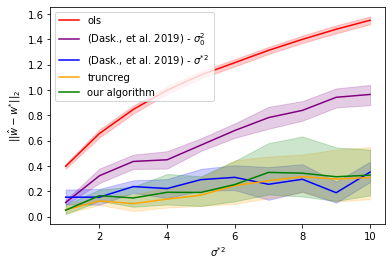

[Text(0, 0.5, '$|\\hat \\sigma^{2} - \\sigma^{*2}|$'),
 Text(0.5, 0, '$\\sigma^{*2}$')]

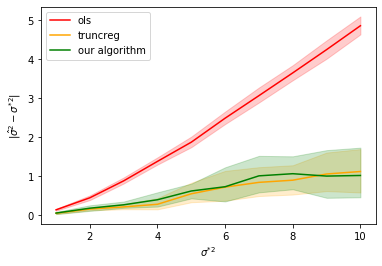

In [48]:
sns.lineplot(data=ols_logs, x='noise_var', y='ols_param_mse', label='ols', color='r')
sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', color='purple', label='(Dask., et al. 2019) - $\sigma_{0}^{2}$')
sns.lineplot(data=known_logs, x='noise_var', y='known_param_mse', label='(Dask., et al. 2019) - $\sigma^{*2}$', color='blue')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_param_mse', label='our algorithm', color='green')

ax.set(xlabel='$\sigma^{*2}$', ylabel='$||\hat w - w^{*}||_{2}$')
plt.show()

sns.lineplot(data=ols_logs, x='noise_var', y='ols_var_l1', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_var_l1', label='our algorithm', color='green')
ax.set(xlabel='$\sigma^{*2}$', ylabel='$|\hat \sigma^{2} - \sigma^{*2}|$')